In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
from torch import optim
import copy
import random
import pickle

In [2]:
class MemoryBank():
    '''Stores and retrieves memories. Also ranks memories by usefulness, and forgets unimportant ones.'''
    def __init__(self, brain):
        self.memories = []
        self.memory_probs = []
        
        self.memory_batch_n = 100
        self.memory_threshold = self.memory_batch_n*20
        self.memory_size = self.memory_batch_n*1000
        
        self.brain = brain

    def remember(self, experience):
        self.memories.append(experience)
        
    def rank_memories(self):
        '''Rank all memories in bank based on usefulness, or the difference in results between Q and target_Q.'''
        qualities, target_qualities = self.brain.get_qualities(list(map(list, zip(*self.memories))))
        usefulness = abs(qualities - target_qualities)
        usefulness += max(usefulness)/100 # allow a non-zero chance for each item to be selected
        usefulness = usefulness.detach().numpy()
        self.memory_probs = usefulness/sum(usefulness)
        #print(f"Average memory usefulness at {np.mean(usefulness.detach().numpy()):.2f} with " +
              #f"{sum(np.array(self.memories)[:,4])}/{len(self.memories)} end-game states in memory")
        
    def forget(self):
        '''Forget least useful memories.'''
        self.memories = np.array(self.memories)[\
                        np.random.choice(len(self.memories), self.memory_size, replace=False,\
                        p=self.memory_probs)]
        self.memories = list(self.memories)

    def recall_batch(self):
        '''Recall a batch of memories, and forget some. Q and target_Q are used to determine how useful each memory
        is. Memories are retrieved or forgotten based on usefulness.'''
        if len(self.memories) < self.memory_threshold: return None
        self.rank_memories()
        memory_batch = np.array(self.memories)[\
                        np.random.choice(len(self.memories), self.memory_batch_n, replace=False,\
                                         p=self.memory_probs)]
        if len(self.memories) > self.memory_size:
            self.forget()
        return list(map(list, zip(*memory_batch)))

In [8]:
class QualityNet(nn.Module):
    '''Takes a state and returns qualities for each action.'''
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(128, 256)
        self.layer_2 = nn.Linear(256, 6)
        
    def forward(self, state):
        x = torch.Tensor(state)
        x = F.relu(self.layer_1(x))
        x = self.layer_2(x)
        return x

class DDQN():
    '''Determines the quality of an action-state pair. Can learn from experience.'''
    def __init__(self):
        self.Q = QualityNet()
        self.target_Q = copy.deepcopy(self.Q)
        self.memory = MemoryBank(self)
        
        self.gamma = .95
        self.learning_rate = 0.01
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.learning_rate)
        
        self.target_count = 0
        self.target_refresh_frequency = 5

    def update_target(self):
        #print("Updating target net")
        self.target_Q = copy.deepcopy(self.Q)

    def get_qualities(self, memory_batch):
        state_batch, action_batch, reward_batch, new_state_batch, game_over_batch = memory_batch
        quality_batch = self.Q(state_batch)[list(range(len(action_batch))), action_batch]
        game_not_over_batch = [1-i for i in game_over_batch]
        DDQN_action_batch = torch.max(self.Q(new_state_batch), dim=1)[1]
        target_quality_batch = torch.Tensor(reward_batch) +\
                            torch.Tensor(game_not_over_batch)*self.gamma*\
                            self.target_Q(new_state_batch)[list(range(len(DDQN_action_batch))), DDQN_action_batch]
        #print("OLD", quality_batch)
        #print("NEW", target_quality_batch)
        return quality_batch, target_quality_batch
        
    def learn(self, memory_batch):
        if memory_batch is None:
            return
        
        quality_batch, target_quality_batch = self.get_qualities(memory_batch)
        loss = self.loss_function(quality_batch, target_quality_batch)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.target_count += 1
        if (self.target_count >= self.target_refresh_frequency):
            self.target_count = 0
            self.update_target()

In [4]:
class Agent():
    '''This agent undergoes the act->remember->recall->learn loop for a certain number of games.
    At the same time, it stores the results of these loops for plotting.'''
    def __init__(self):
        self.env = gym.make("Pong-ram-v0")
        self.state = self.env.reset()
        
        self.brain = DDQN()

        self.n_games = 1500
        self.group_n_games = 10
        self.training_history = []
        self.game_frames = []
        self.game_info = []
        
        self.epsilon = 1
        self.epsilon_decay = 0.95
        self.min_epsilon = 0.05

    def act(self, state):
        '''Choose an action using the policy, act on the environment, and return all the outputs.'''
        def policy(state):
            if np.random.uniform(0, 1) < self.epsilon:
                action = np.random.choice(self.env.action_space.n)
            else:
                action_probabilities = F.softmax(self.brain.Q(state), dim=0)
                action = Categorical(action_probabilities).sample().item()
            return action     
        
        action = policy(state)
        new_state, reward, game_over, _ = self.env.step(action)
        self.state = new_state
        experience = (state, action, reward, new_state, game_over)
        return experience

    def reduce_policy_randomness(self):  
        '''Reduce the epsilon used in the policy for less randomness in picking actions.'''
        self.epsilon *= self.epsilon_decay
        if (self.epsilon < self.min_epsilon):
            self.epsilon = self.min_epsilon
        
    def play(self):
        for n in range(self.n_games):
            game_over = False
            self.state = self.env.reset()
            game_reward = 0
            new_game_frames = []
            new_game_info =[]
            
            while not game_over:
                experience = self.act(self.state)
                game_reward += experience[2]
                game_over = experience[4]
                self.brain.memory.remember(experience)

                if (n+1)%self.group_n_games == 0:
                    new_game_frames.append(self.env.render(mode='rgb_array'))
                    new_game_info.append((experience, self.brain.Q(experience[0])))
          
            for _ in range(5):
                memory_batch = self.brain.memory.recall_batch()
                self.brain.learn(memory_batch)
            self.reduce_policy_randomness()
            self.training_history.append([game_reward, self.epsilon, self.brain.learning_rate])
  
            if (n+1)%self.group_n_games == 0:
                self.game_frames.append(new_game_frames)
                self.game_info.append(new_game_info)
                avg_score = np.average(np.array(self.training_history)[:,0][-self.group_n_games:])
                if (avg_score >= 20): break
                print(f"Finished playing {n+1} games. Average score of last {self.group_n_games} games " +
                      f"was {avg_score:.2f}.")
                torch.save(agent.brain.Q.state_dict(), "saved_pong_weights.data")
                #with open('saved_pong_history.pickle', 'wb') as handle:
                    #pickle.dump([agent.game_frames, agent.game_info], handle, protocol=pickle.HIGHEST_PROTOCOL)

    def display_game(self, game_n):
        print("quality, action")
        for info in self.game_info[game_n]:
            print(info[1].detach().numpy(), info[0][1])
        patch = plt.imshow(self.game_frames[game_n][0])
        plt.axis('off')
        def animate(i): patch.set_data(self.game_frames[game_n][i])
        anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(self.game_frames[game_n]), interval=50)
        display(display_animation(anim, default_mode='once'))

# Train and Save Model

In [5]:
agent = Agent()
agent.play()

Finished playing 10 games. Average score of last 10 games was -20.30.
Finished playing 20 games. Average score of last 10 games was -20.10.
Finished playing 30 games. Average score of last 10 games was -20.10.
Finished playing 40 games. Average score of last 10 games was -20.70.
Finished playing 50 games. Average score of last 10 games was -20.00.
Finished playing 60 games. Average score of last 10 games was -20.30.
Finished playing 70 games. Average score of last 10 games was -20.70.
Finished playing 80 games. Average score of last 10 games was -20.30.
Finished playing 90 games. Average score of last 10 games was -20.20.
Finished playing 100 games. Average score of last 10 games was -19.90.
Finished playing 110 games. Average score of last 10 games was -20.60.
Finished playing 120 games. Average score of last 10 games was -20.50.
Finished playing 130 games. Average score of last 10 games was -20.20.
Finished playing 140 games. Average score of last 10 games was -19.90.
Finished playin

Finished playing 1170 games. Average score of last 10 games was -20.30.
Finished playing 1180 games. Average score of last 10 games was -20.20.
Finished playing 1190 games. Average score of last 10 games was -20.90.
Finished playing 1200 games. Average score of last 10 games was -21.00.
Finished playing 1210 games. Average score of last 10 games was -21.00.
Finished playing 1220 games. Average score of last 10 games was -20.80.
Finished playing 1230 games. Average score of last 10 games was -20.90.
Finished playing 1240 games. Average score of last 10 games was -20.80.
Finished playing 1250 games. Average score of last 10 games was -20.80.
Finished playing 1260 games. Average score of last 10 games was -20.80.
Finished playing 1270 games. Average score of last 10 games was -20.70.
Finished playing 1280 games. Average score of last 10 games was -20.50.
Finished playing 1290 games. Average score of last 10 games was -19.90.
Finished playing 1300 games. Average score of last 10 games was 

quality, action
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958

[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525

[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525

[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 1
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 2
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 5
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 4
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 0
[-0.16582525  0.12335973 -0.7289491  -0.05317935 -0.19322746 -0.24730958] 3
[-0.16582525


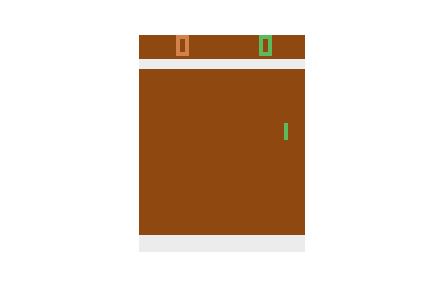
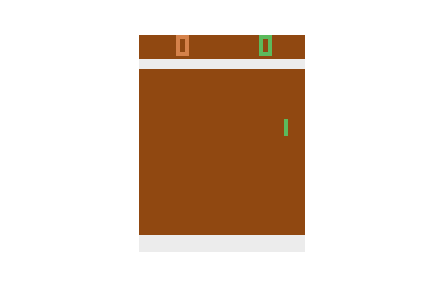
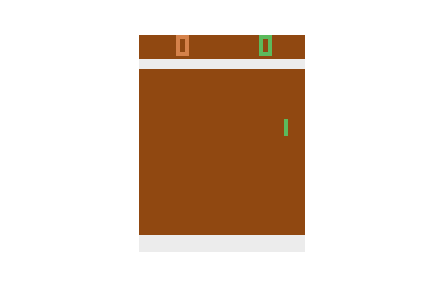
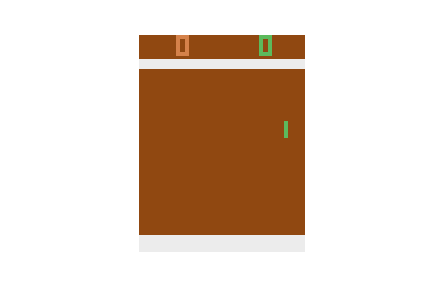
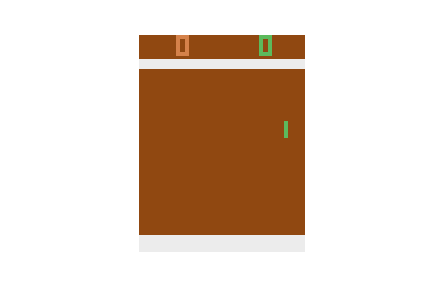
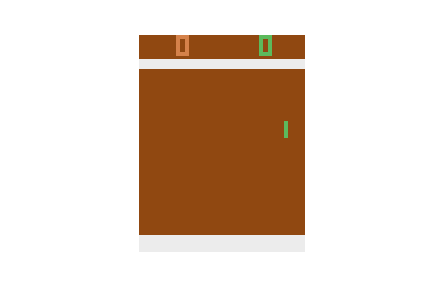
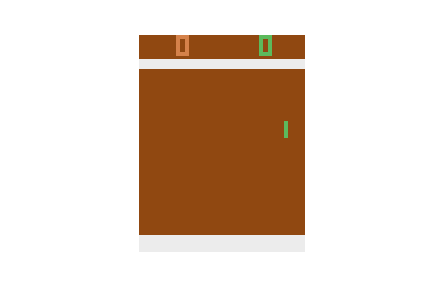
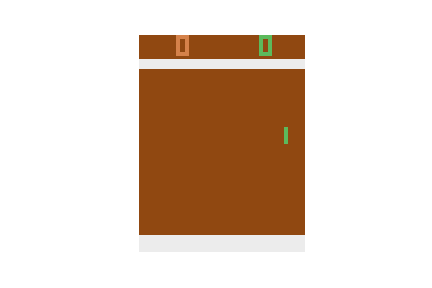
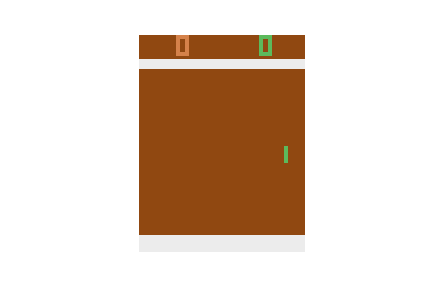
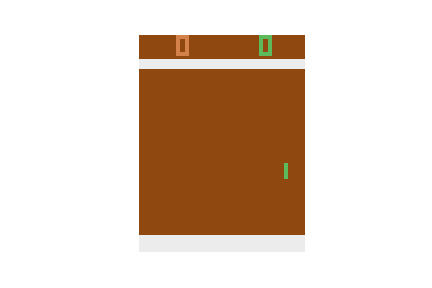
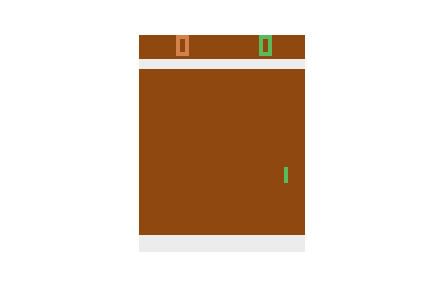
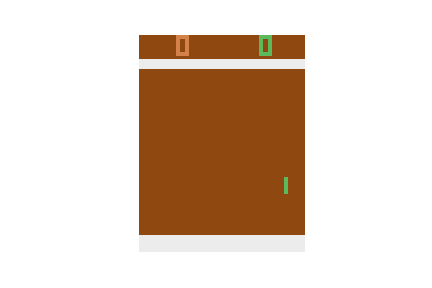
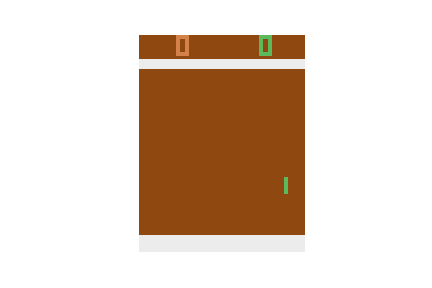
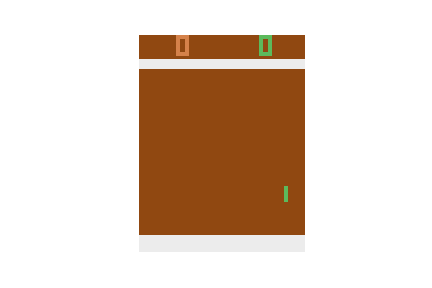
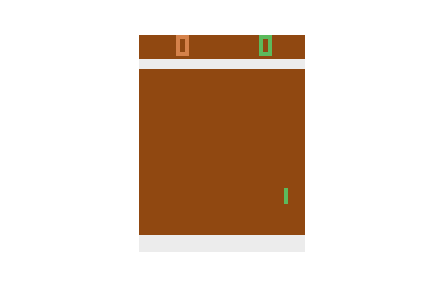
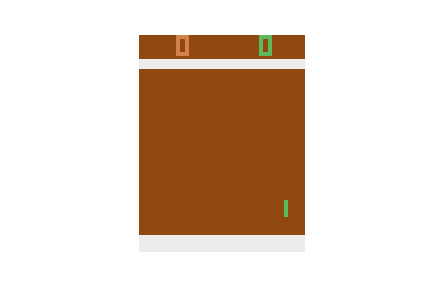
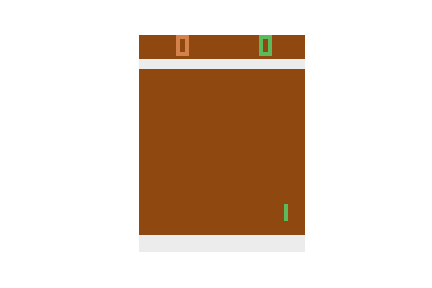
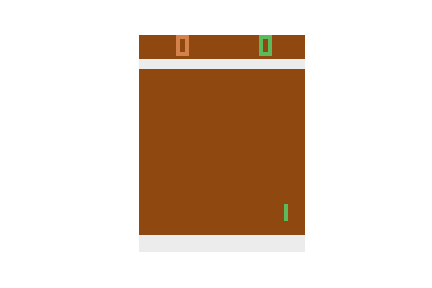
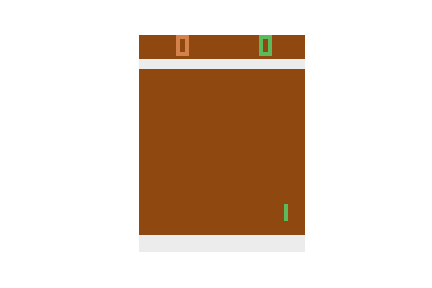
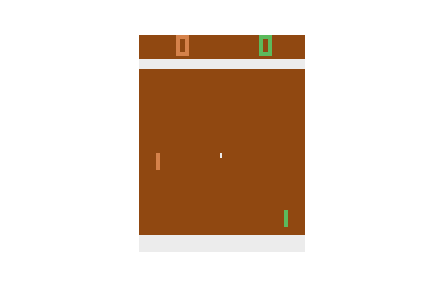
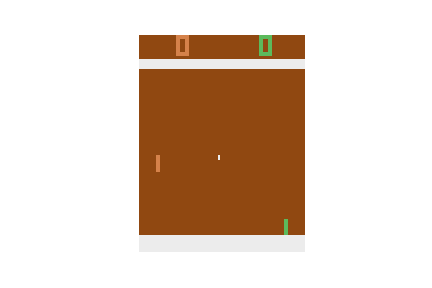
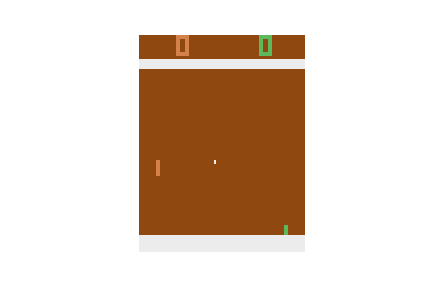
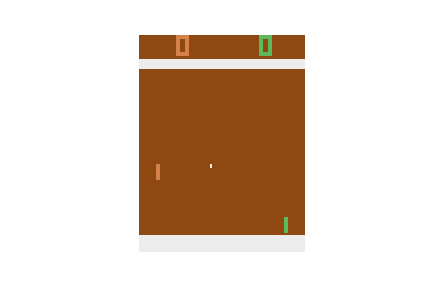
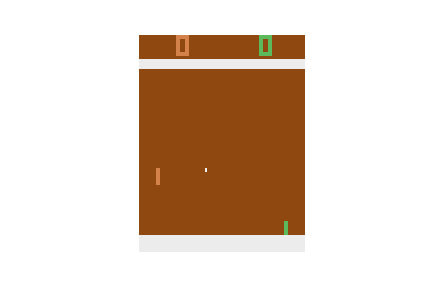
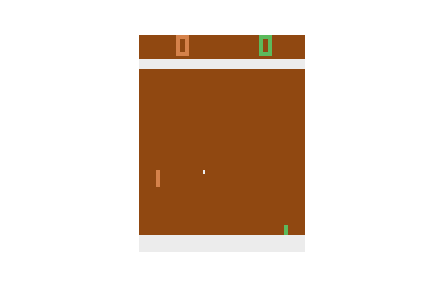
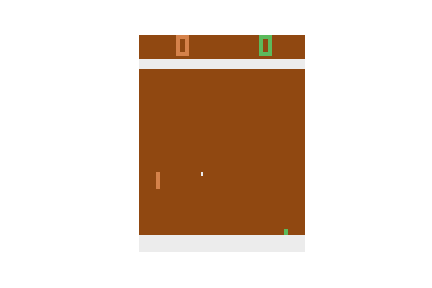
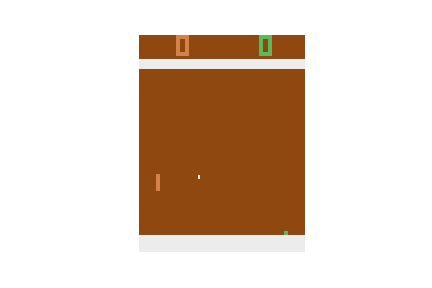
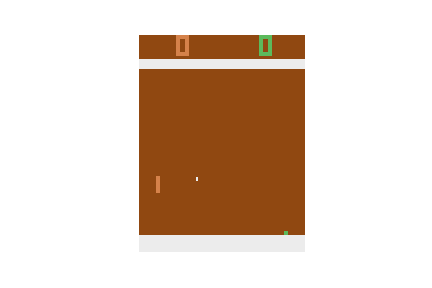
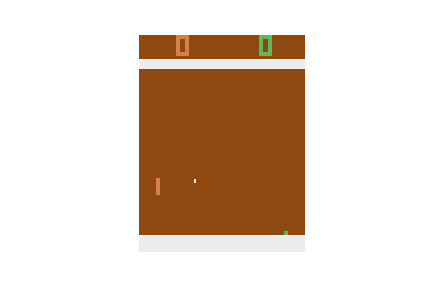
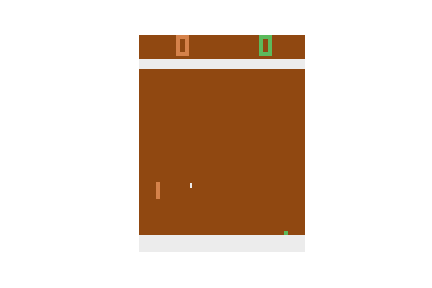
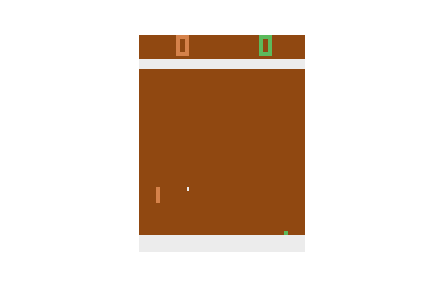
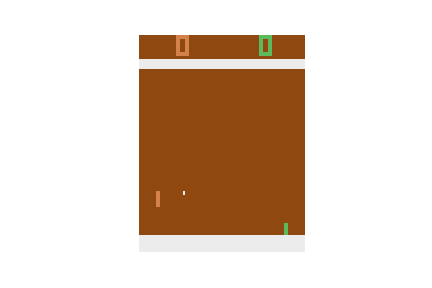
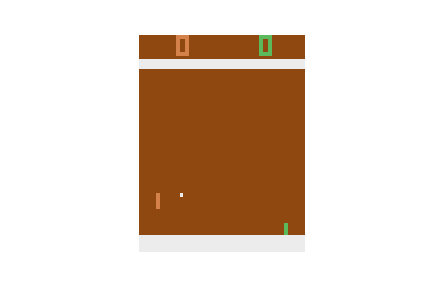
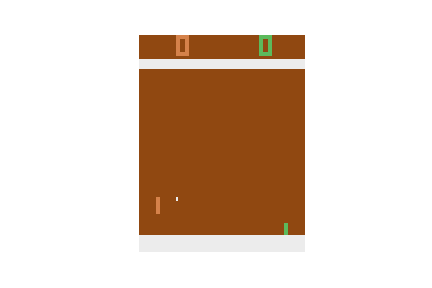
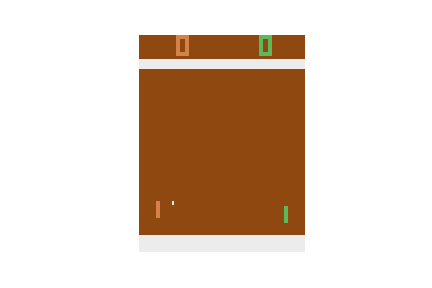
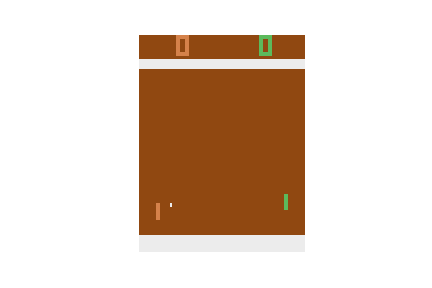
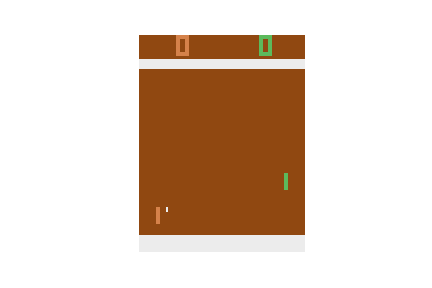
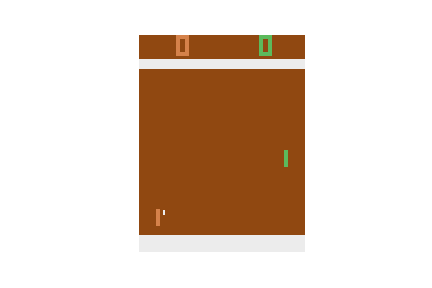
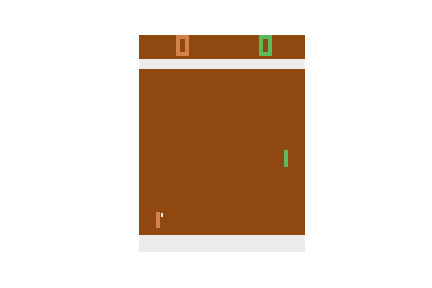
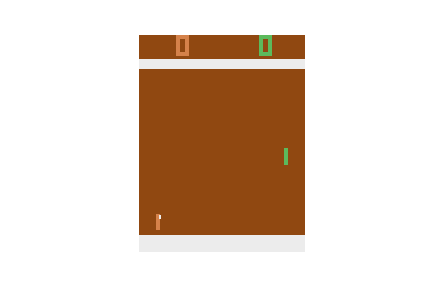
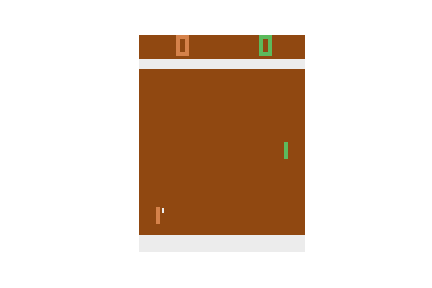
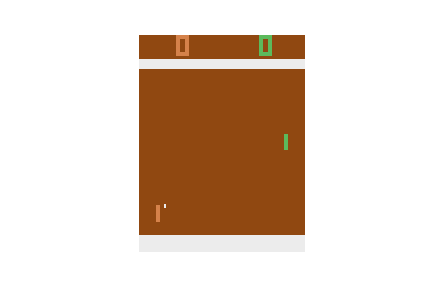
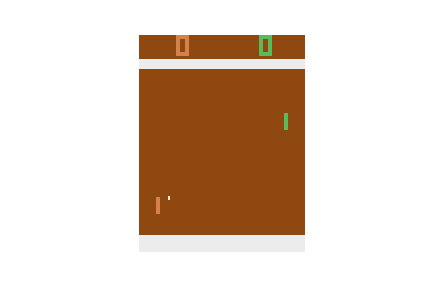
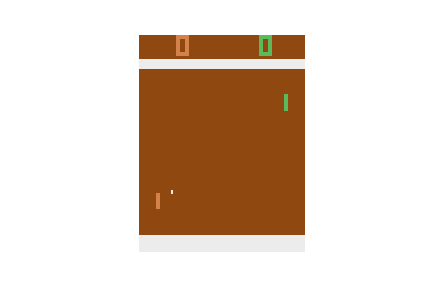
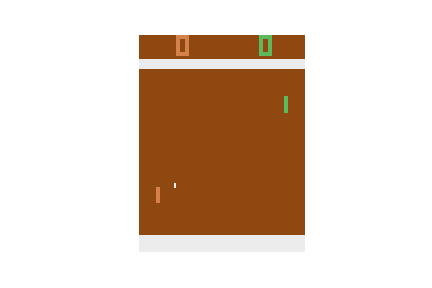
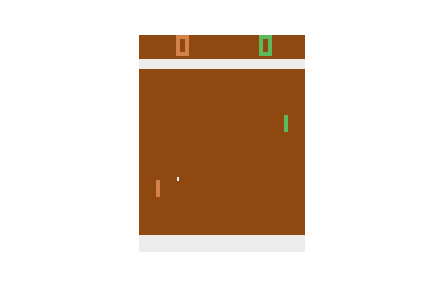
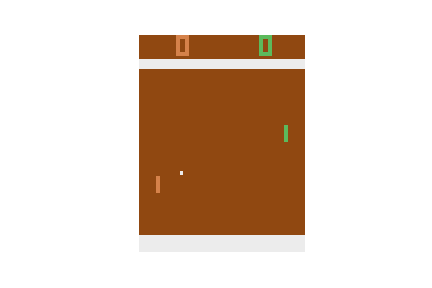
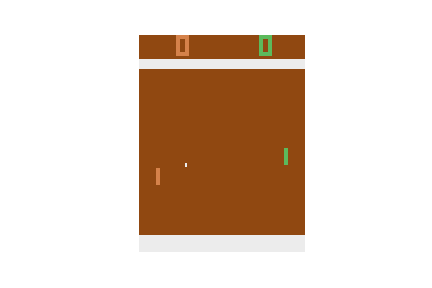
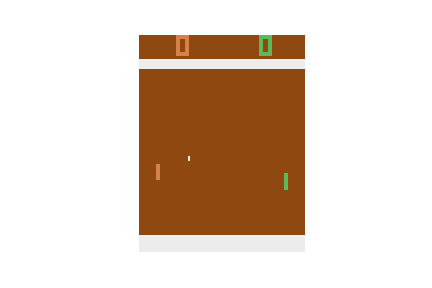
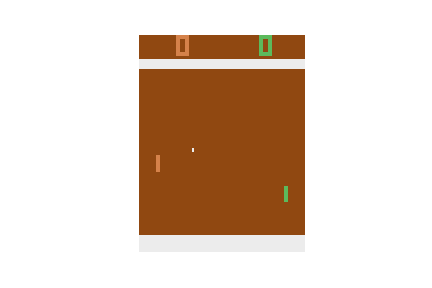
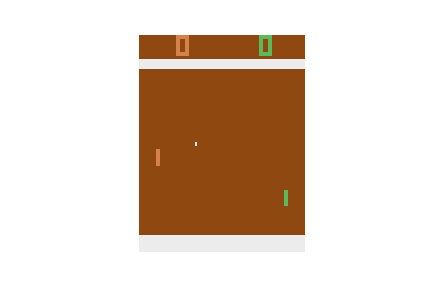
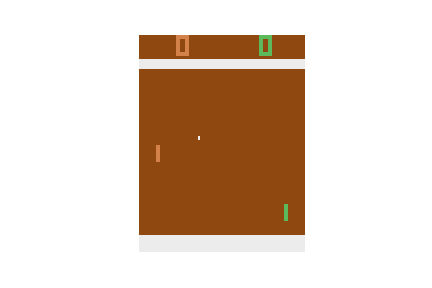
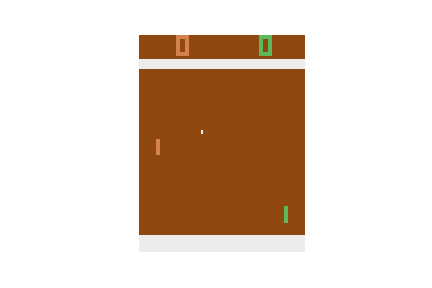
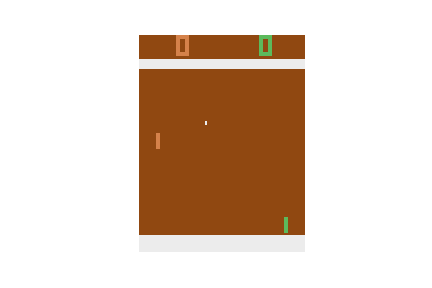
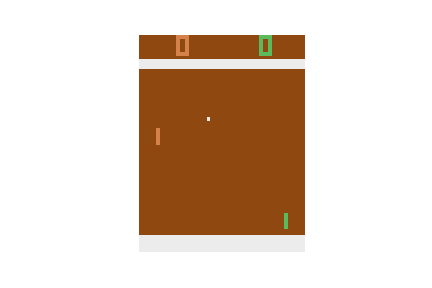
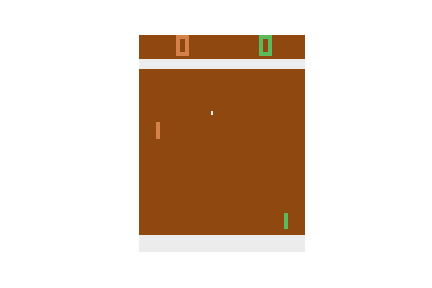
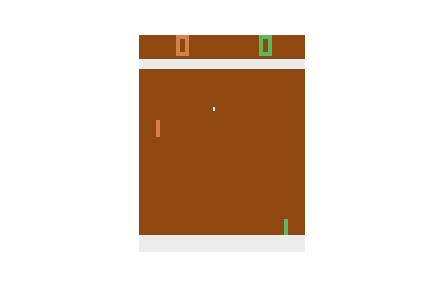
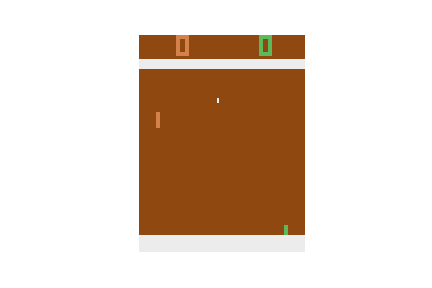
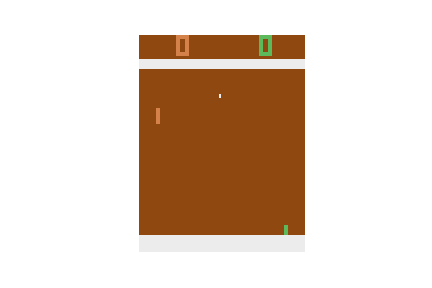
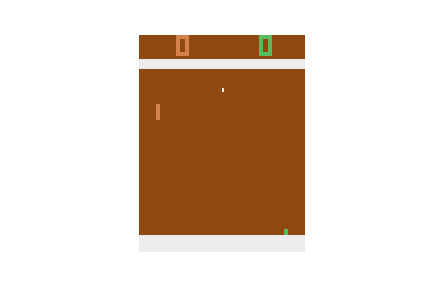
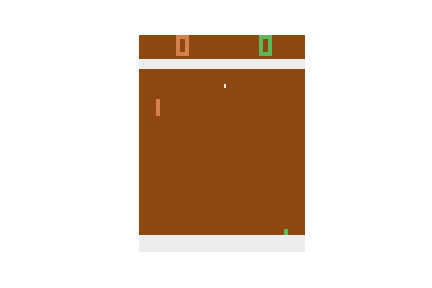
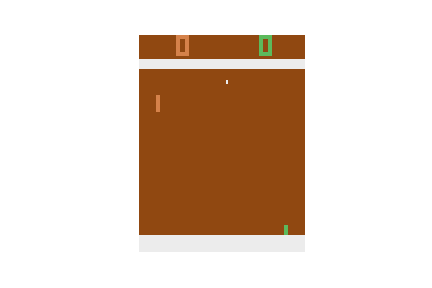
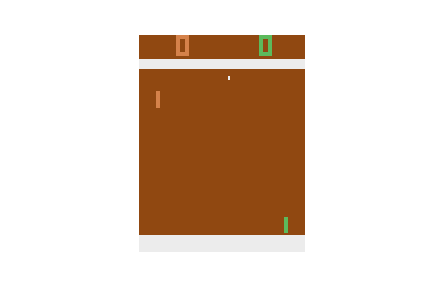
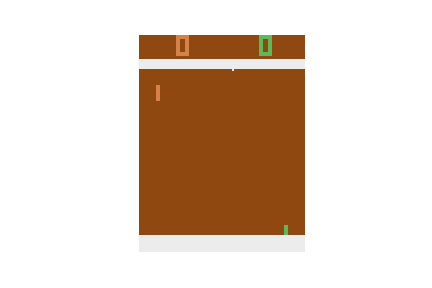
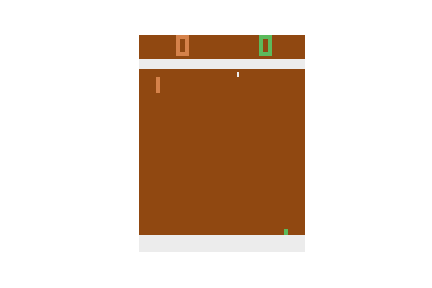
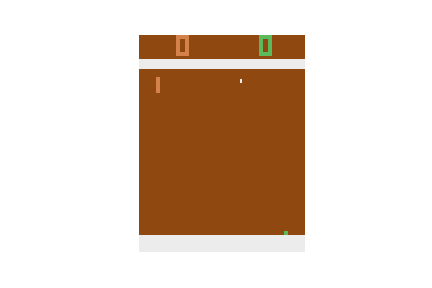
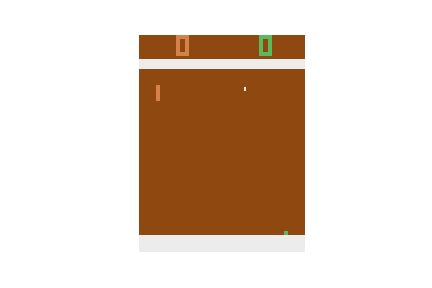
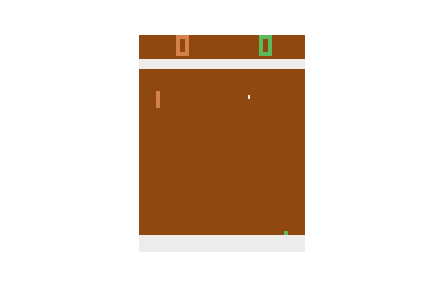
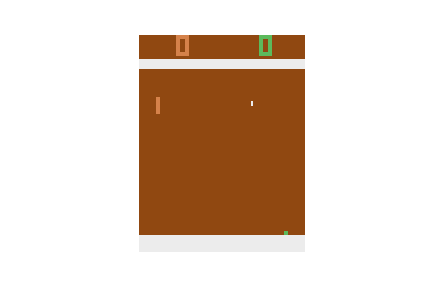
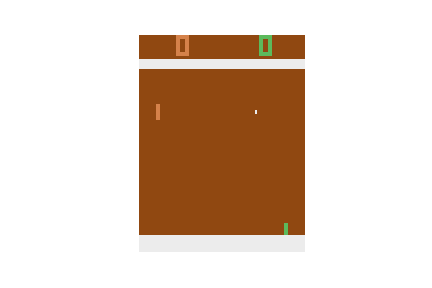
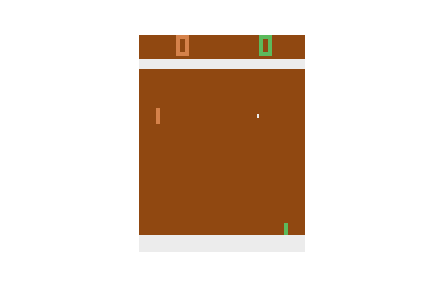
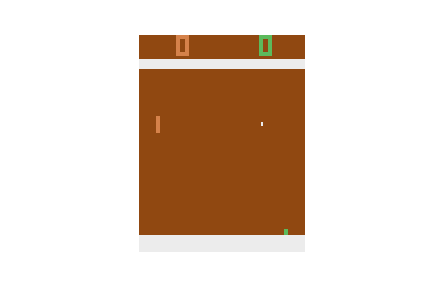
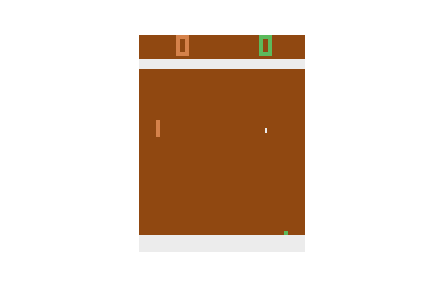
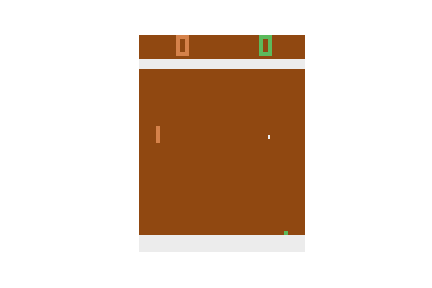
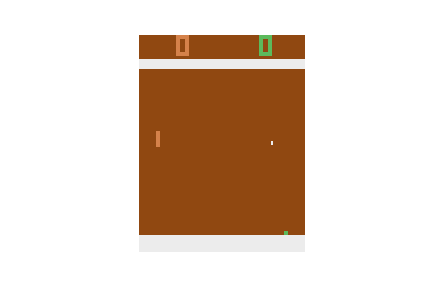
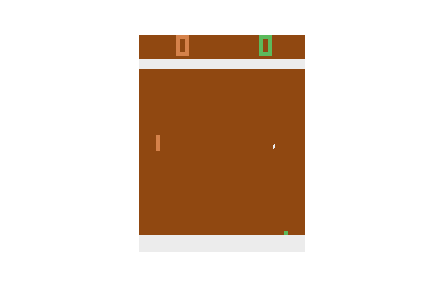
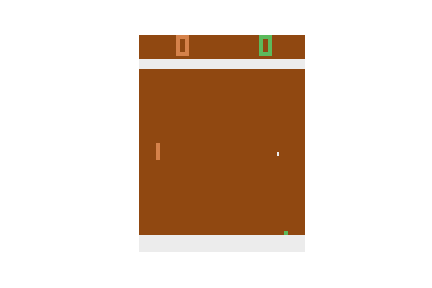
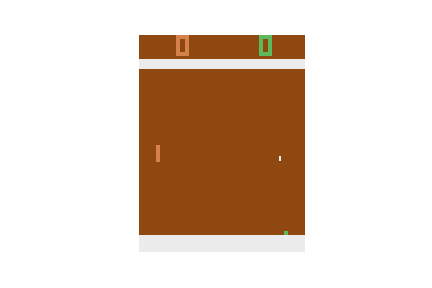
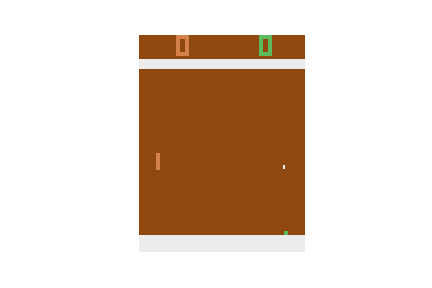
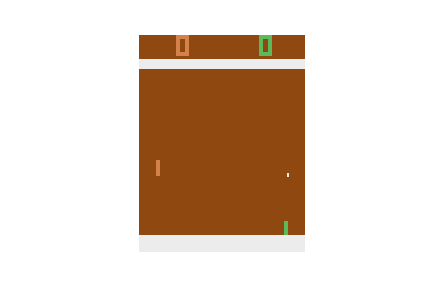
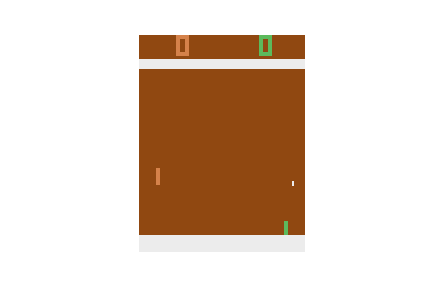
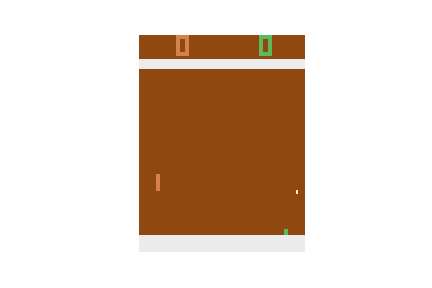
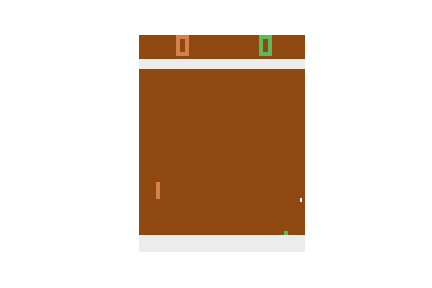
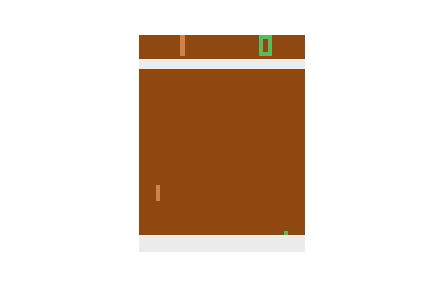
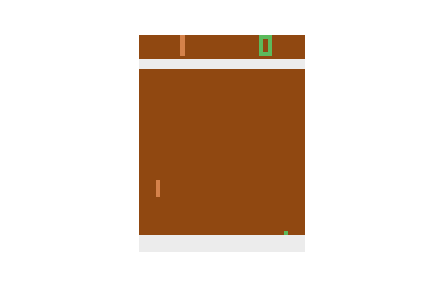
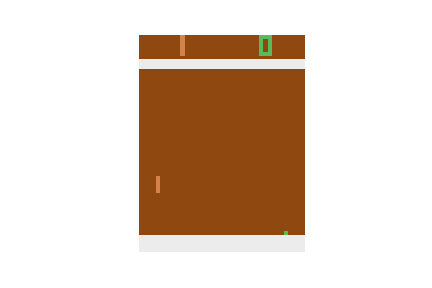
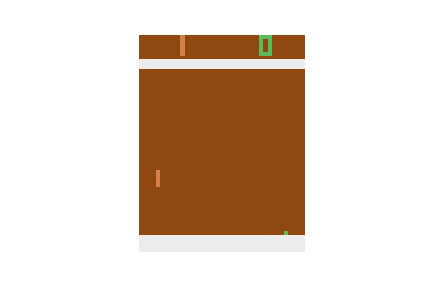
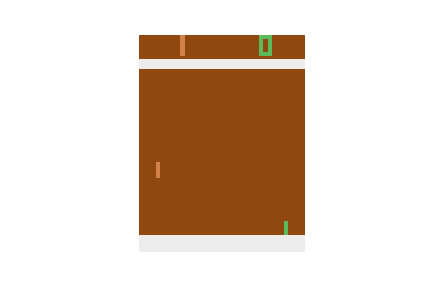
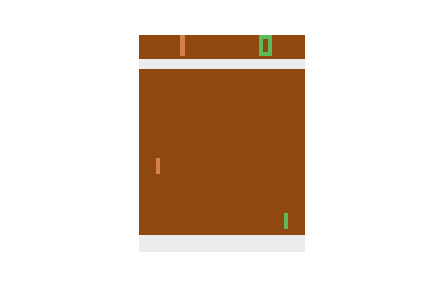
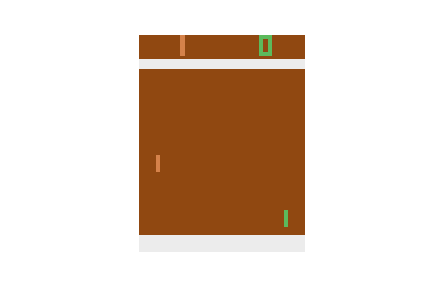
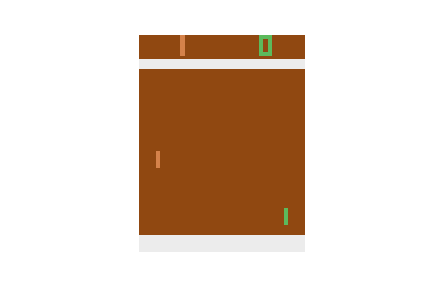
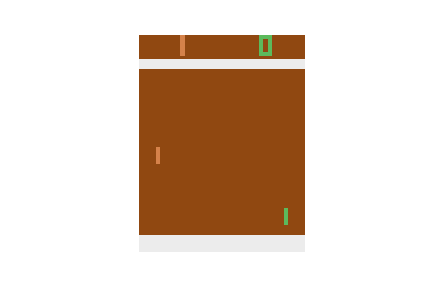
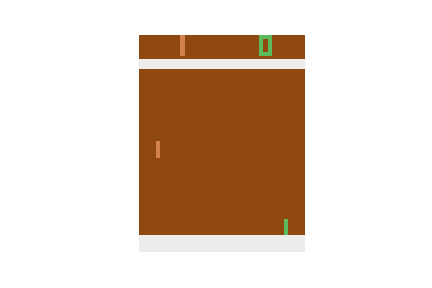
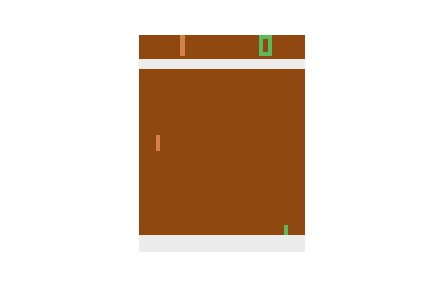
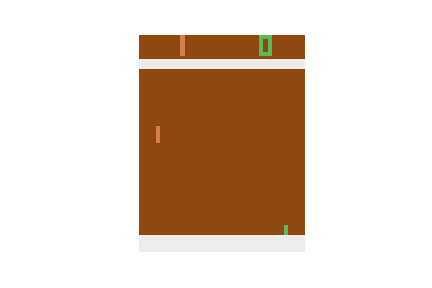
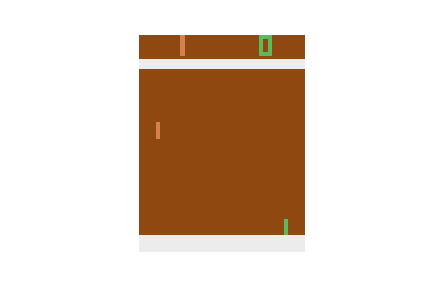
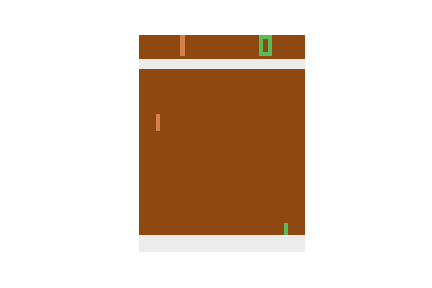
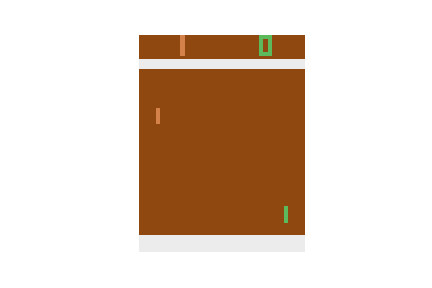
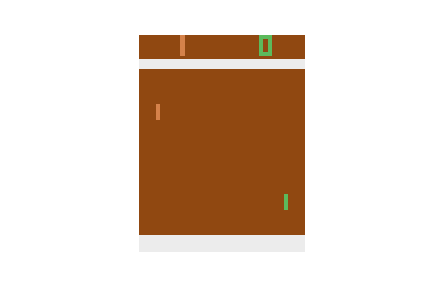
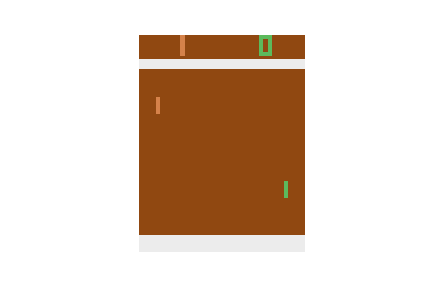
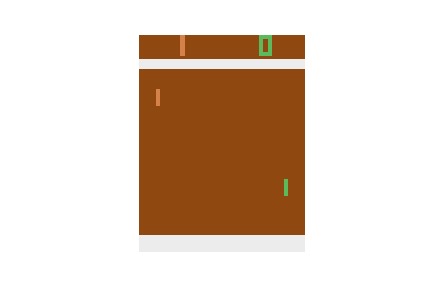
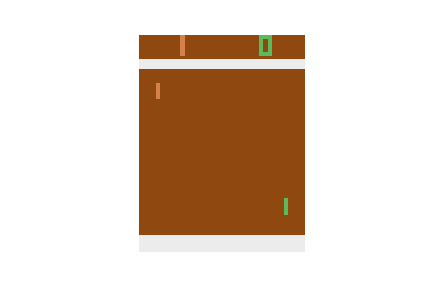
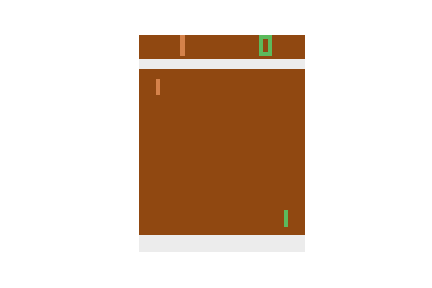
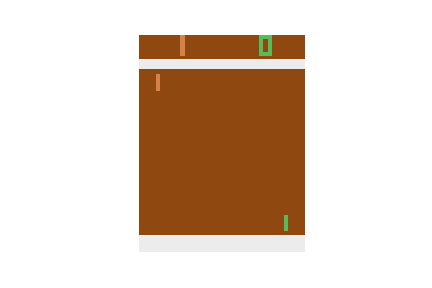
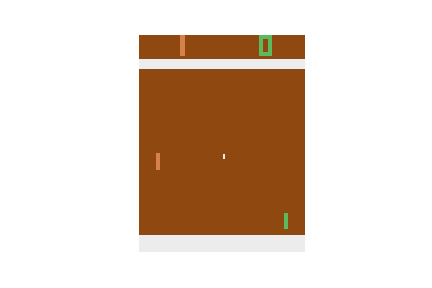
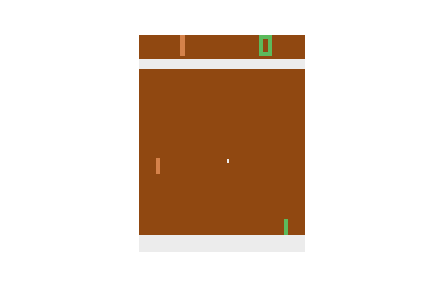
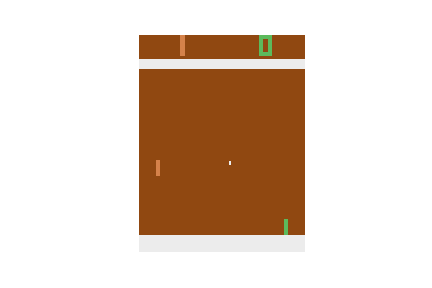
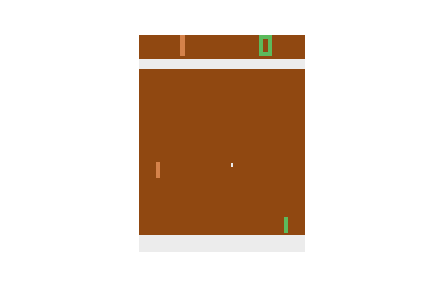
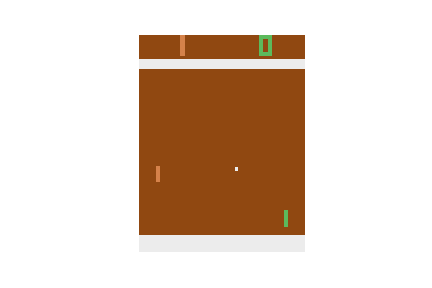
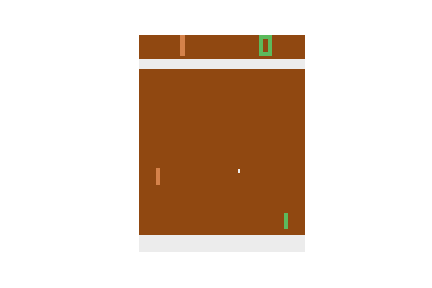
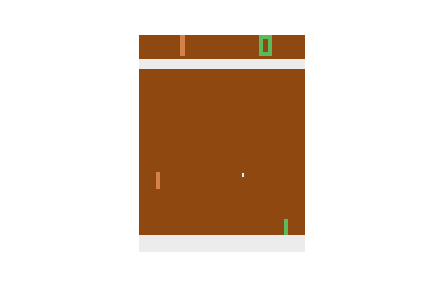
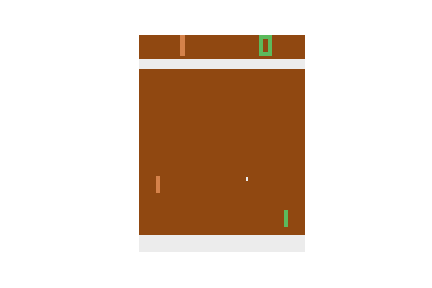
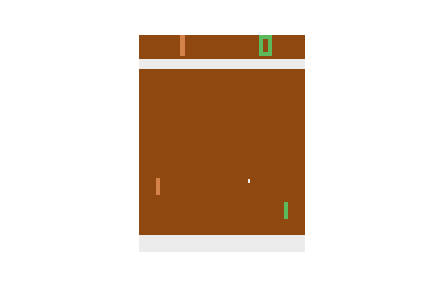
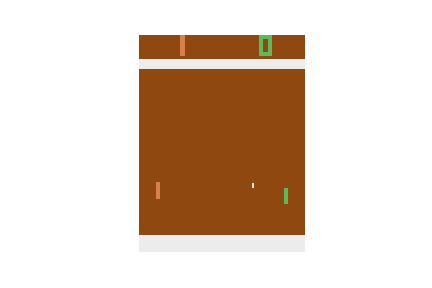
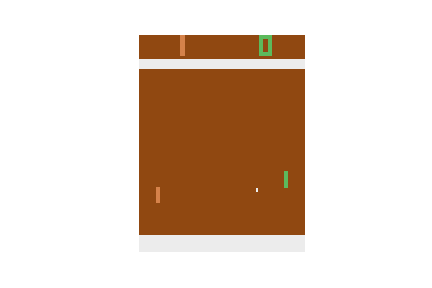
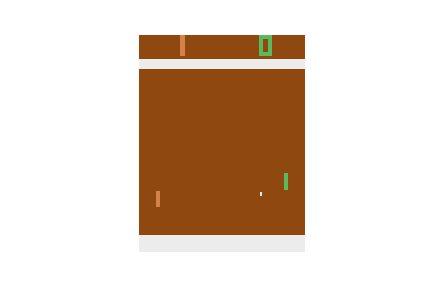
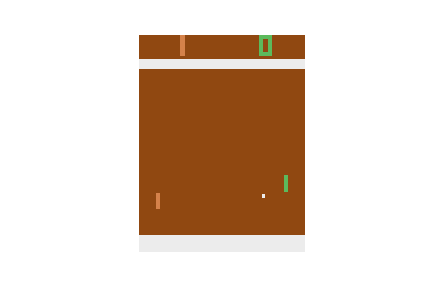
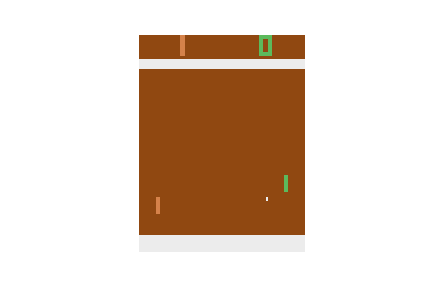
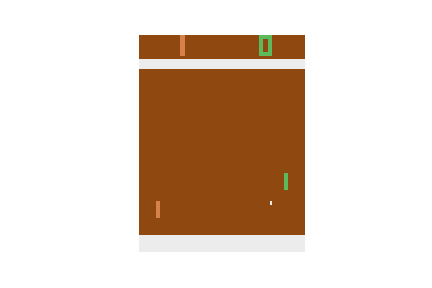
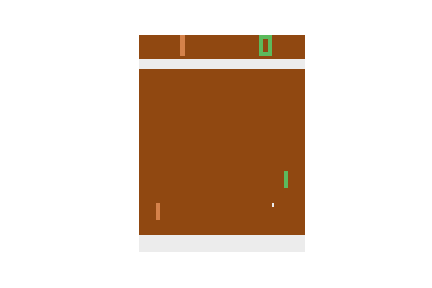
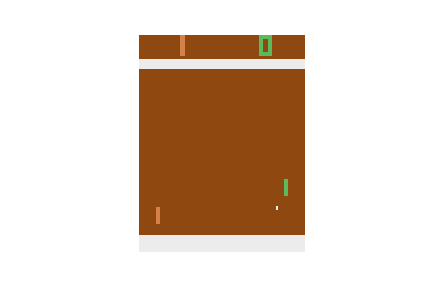
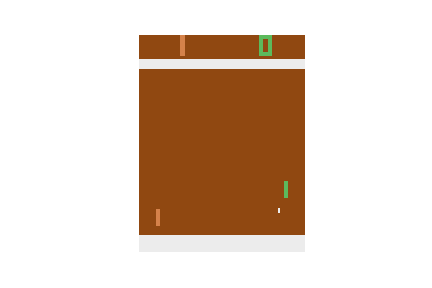
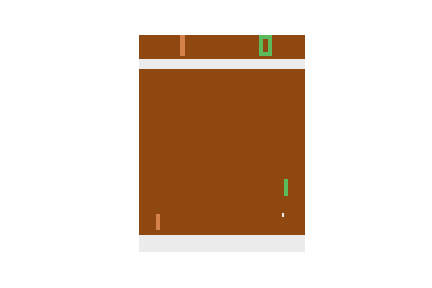
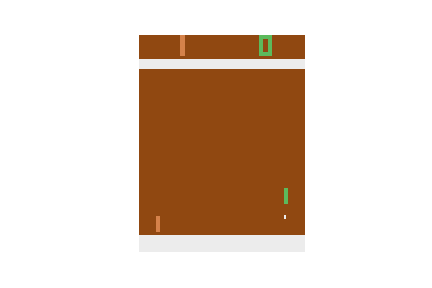
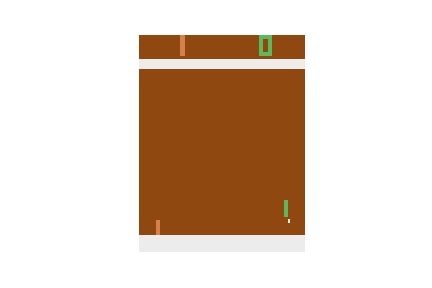
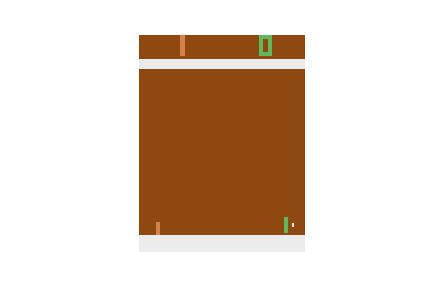
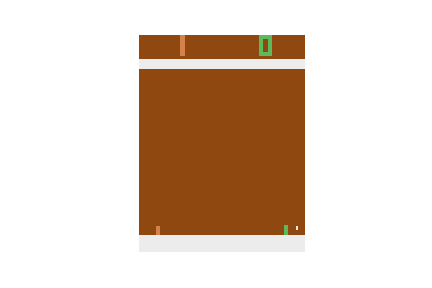
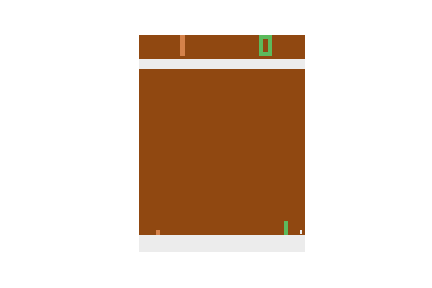
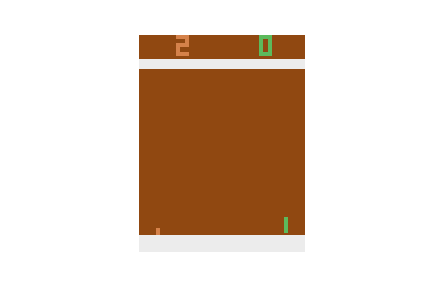
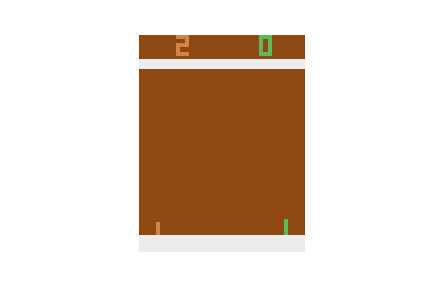
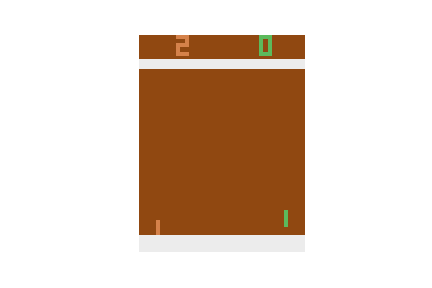
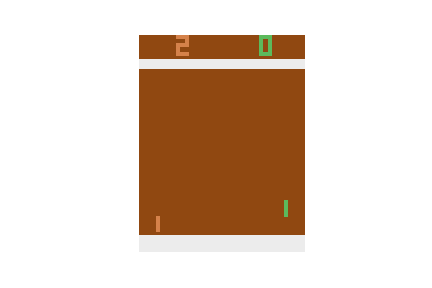
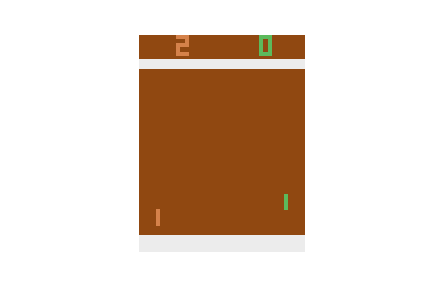
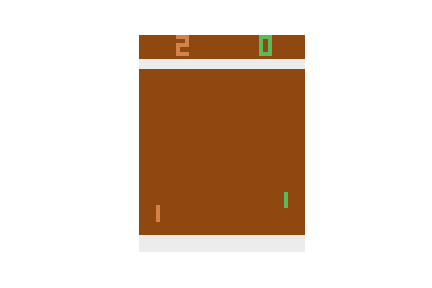
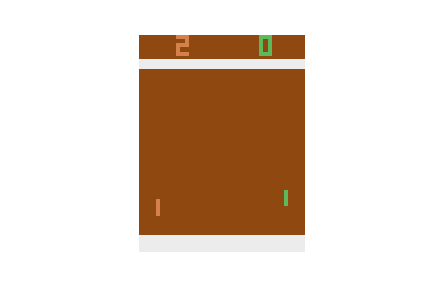
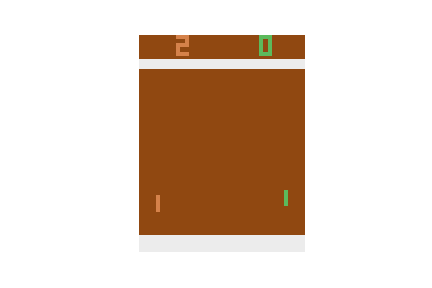
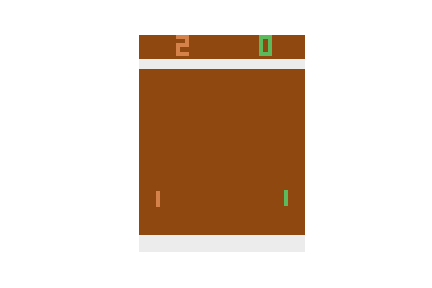
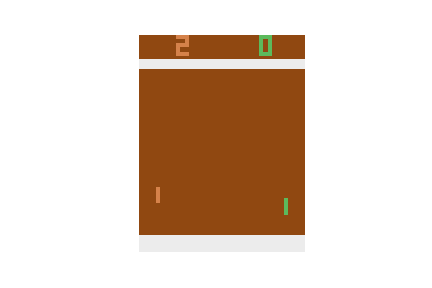
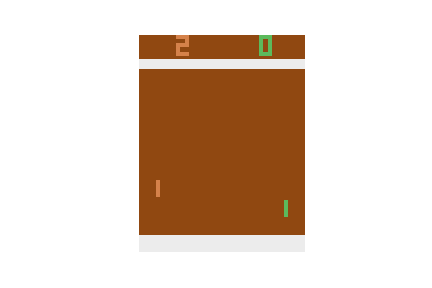
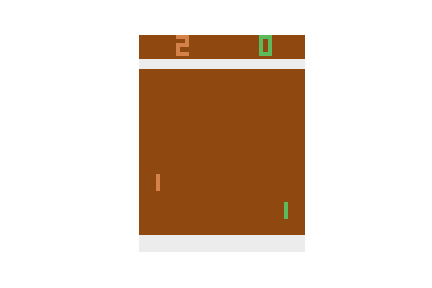
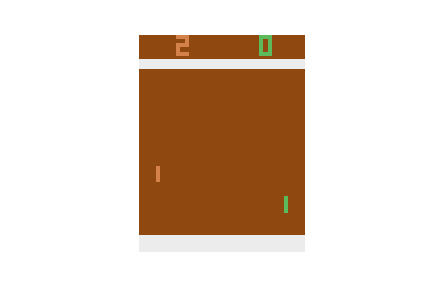
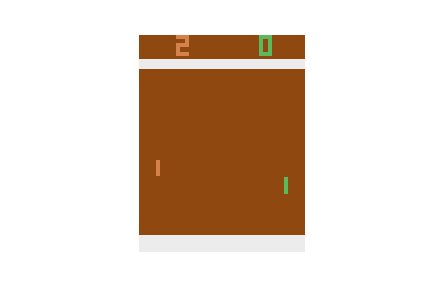
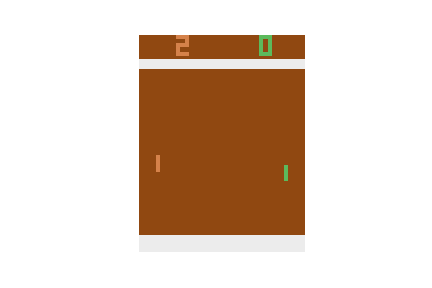
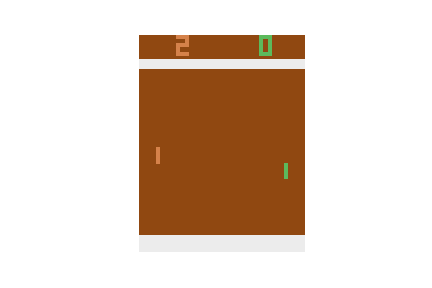
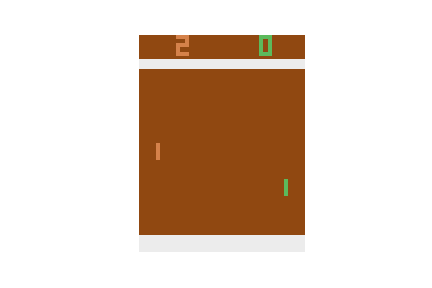
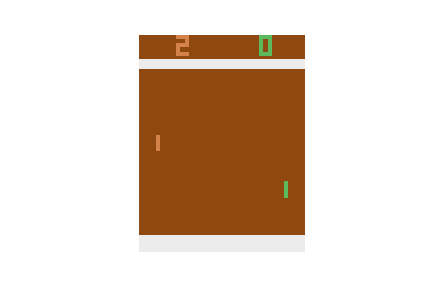
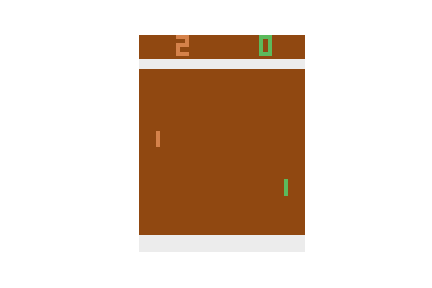
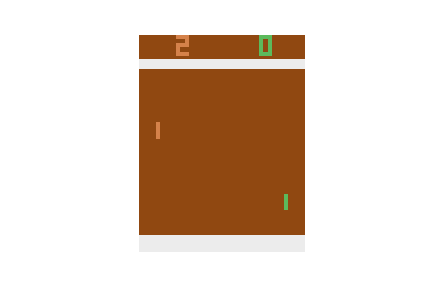
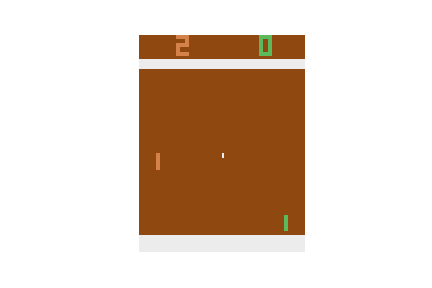
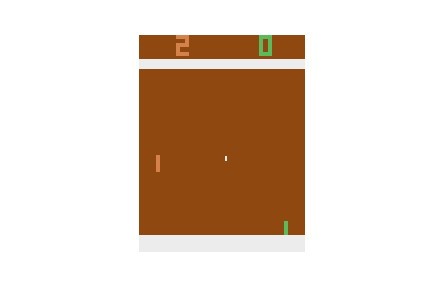
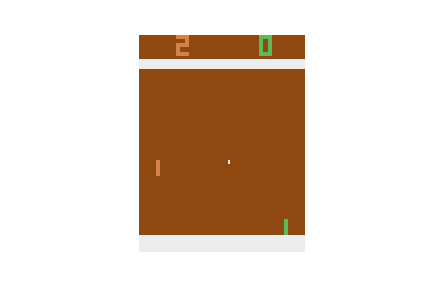
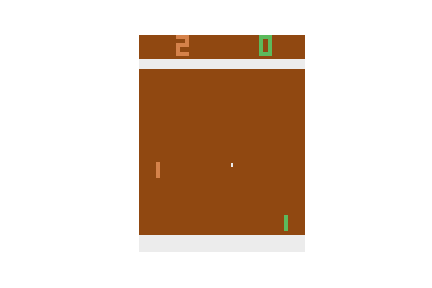
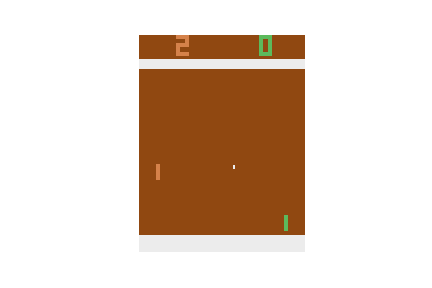
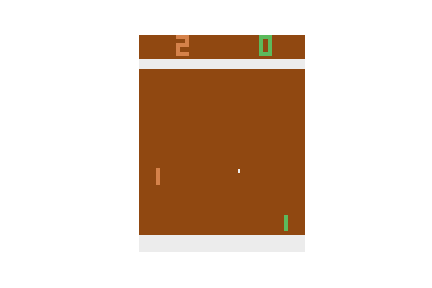
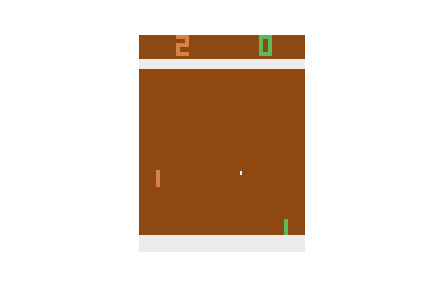
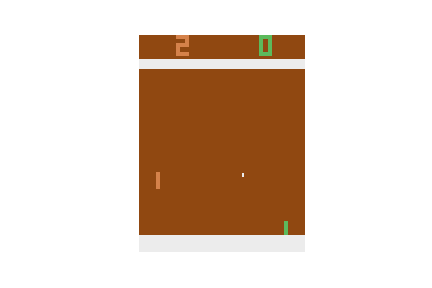
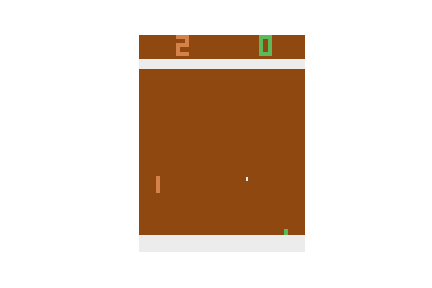
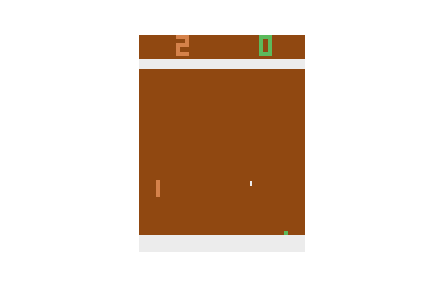
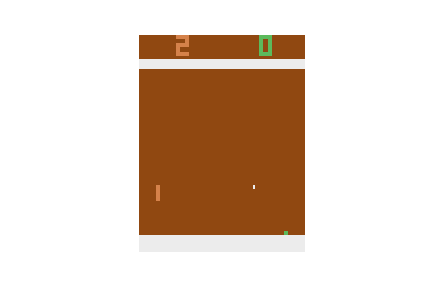
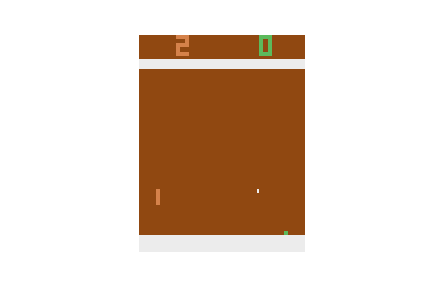
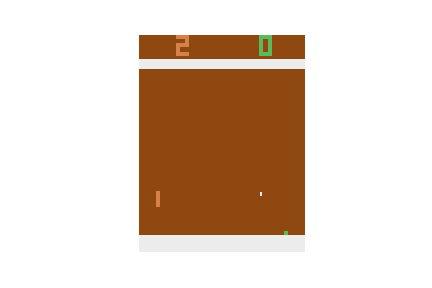
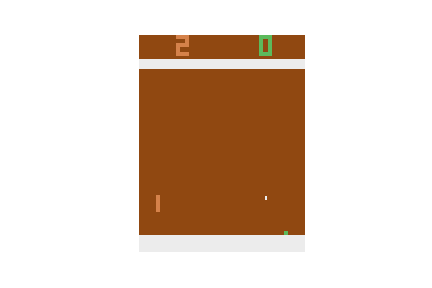
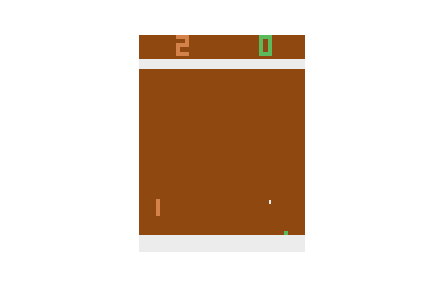
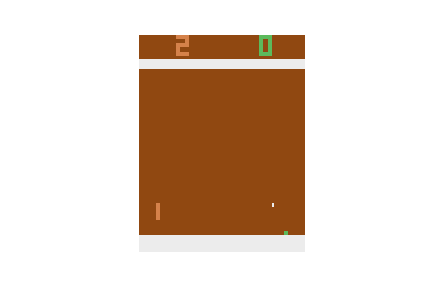
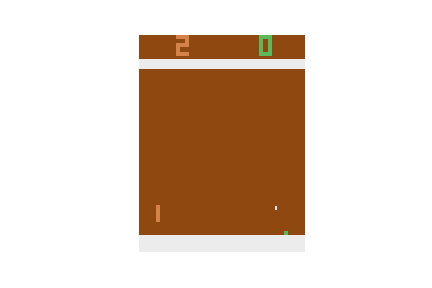
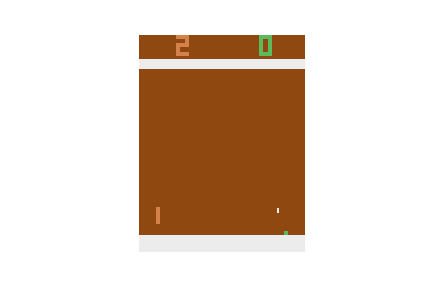
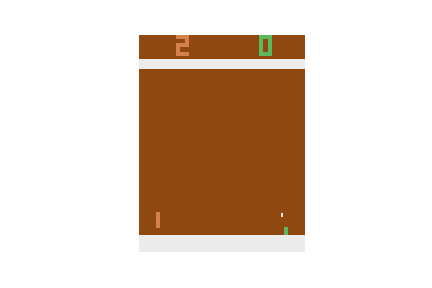
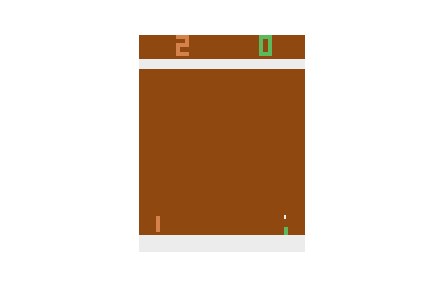
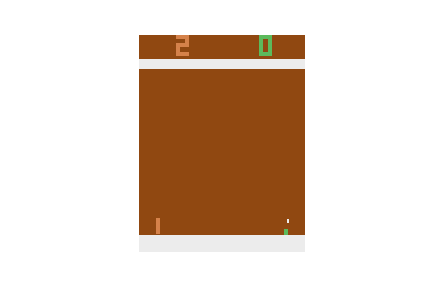
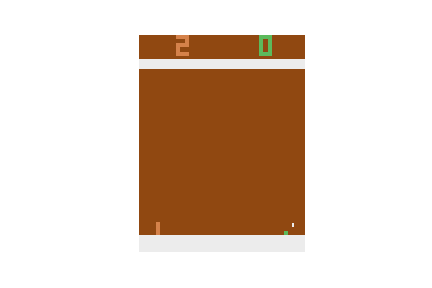
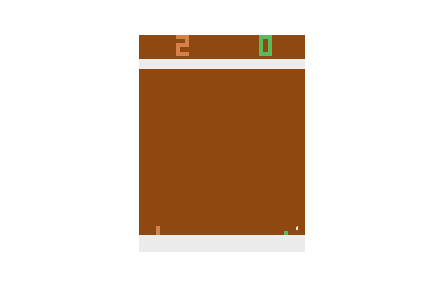
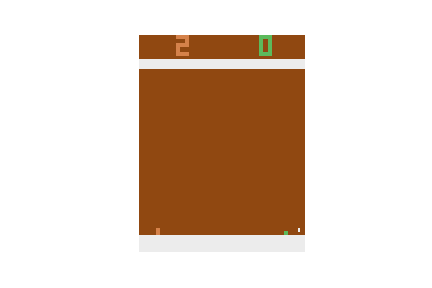
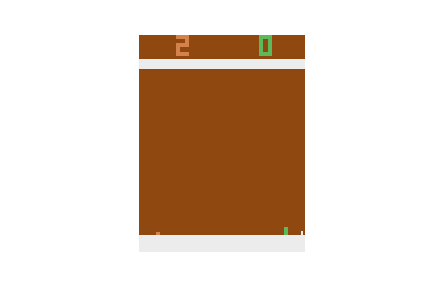
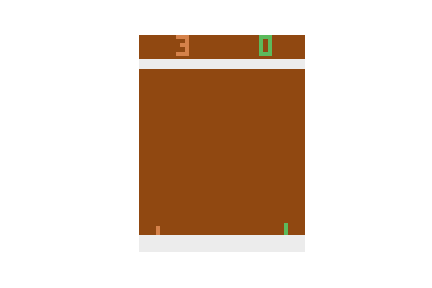
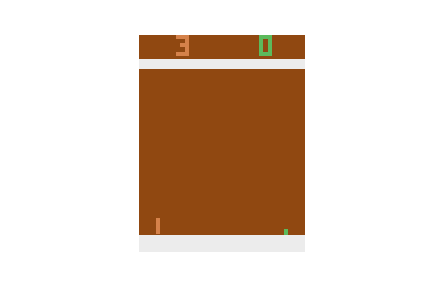
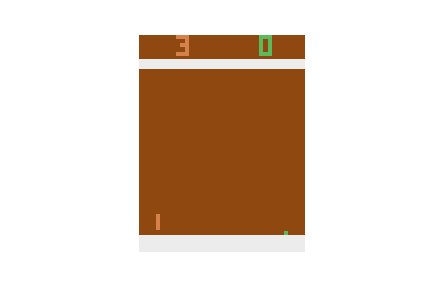
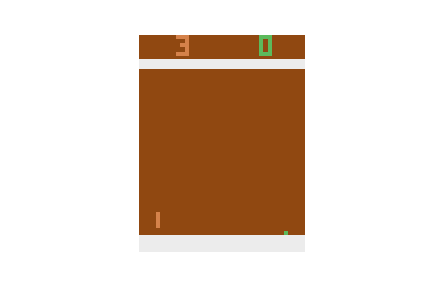
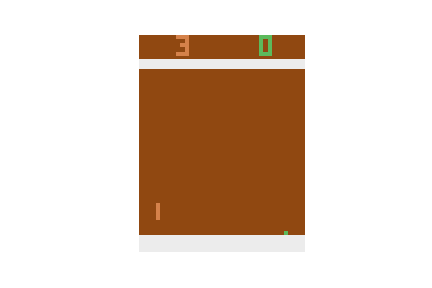
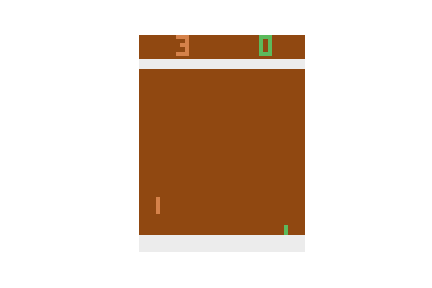
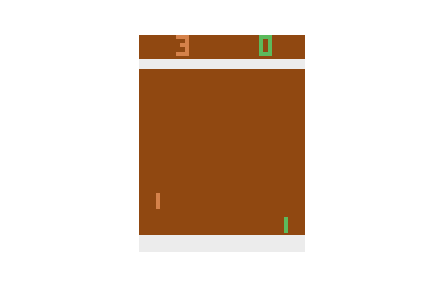
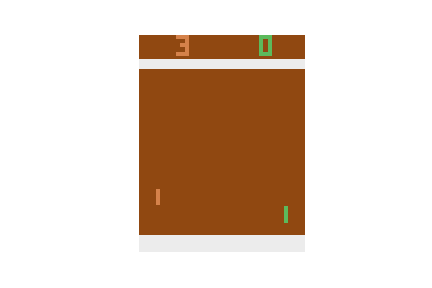
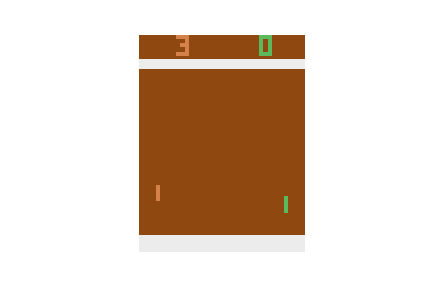
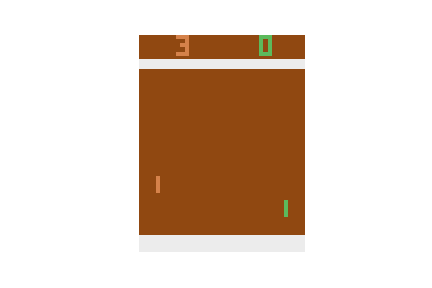
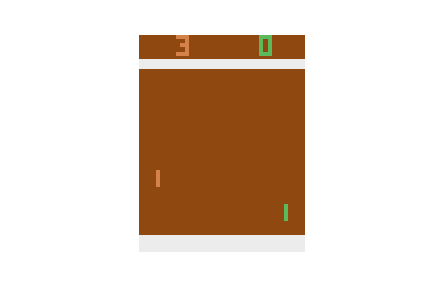
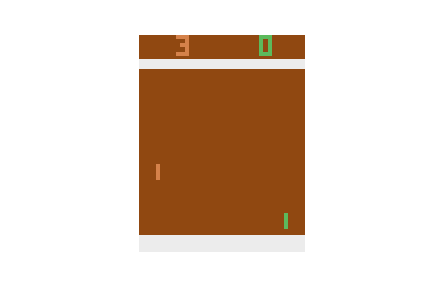
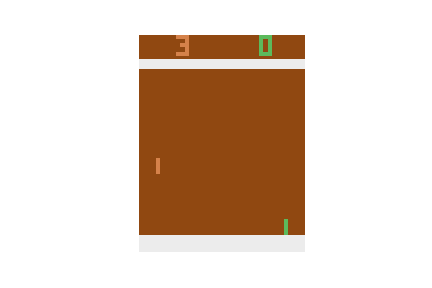
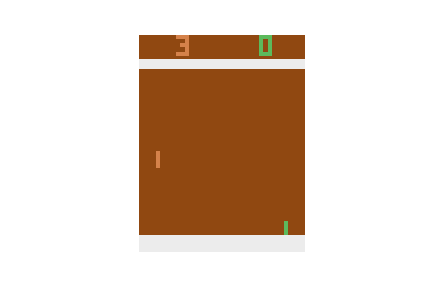
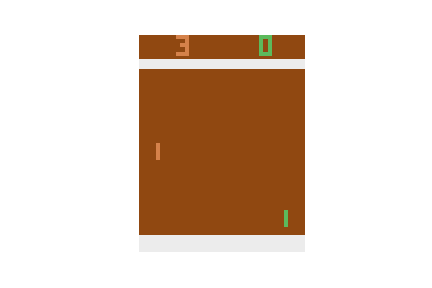
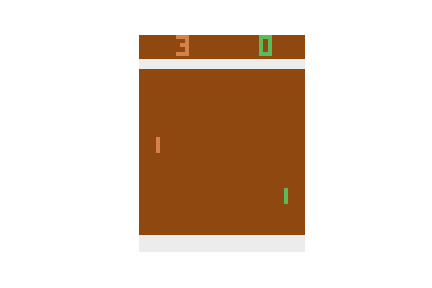
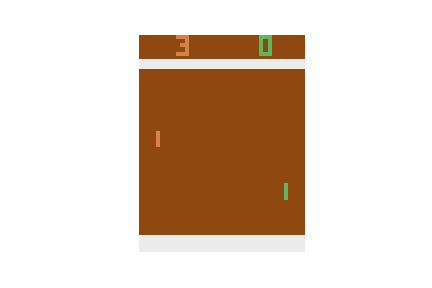
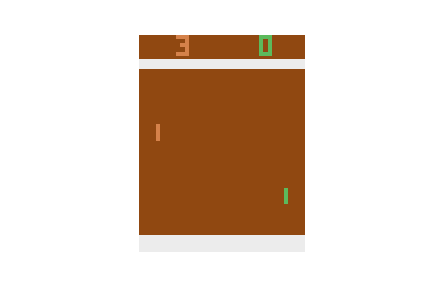
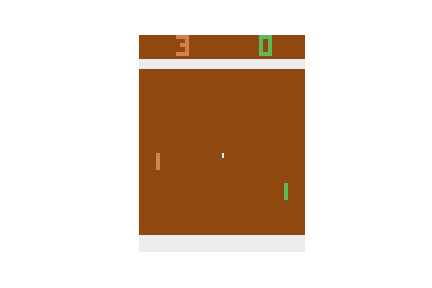
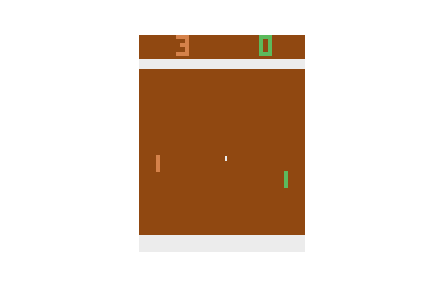
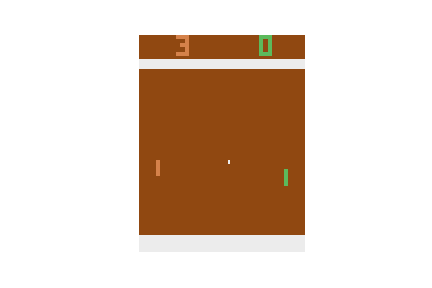
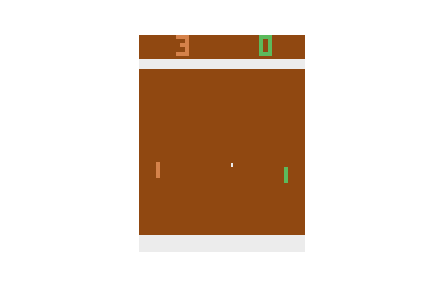
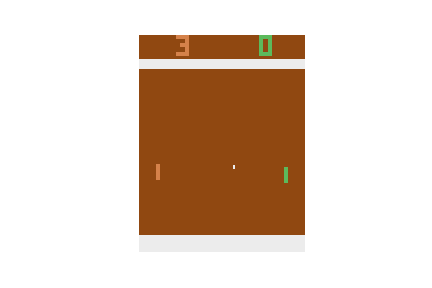
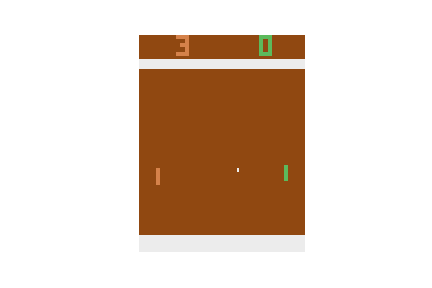
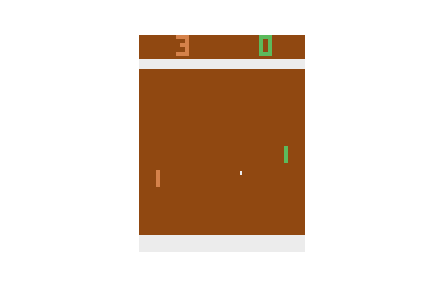
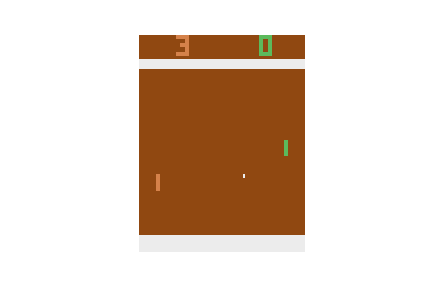
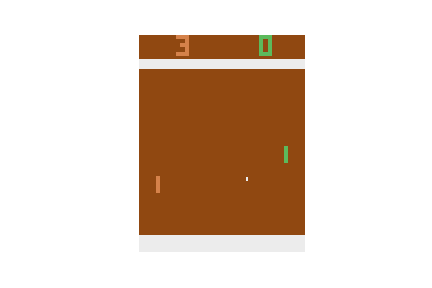
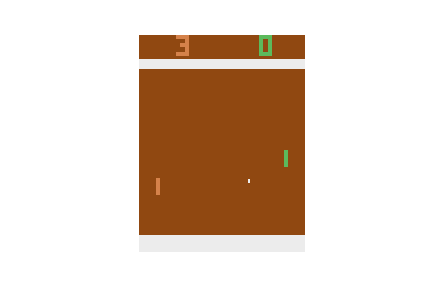
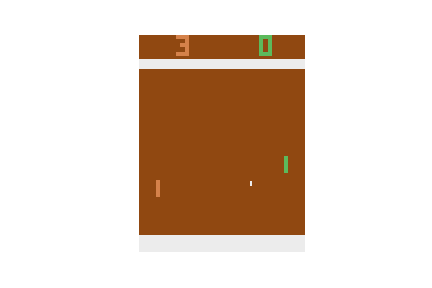
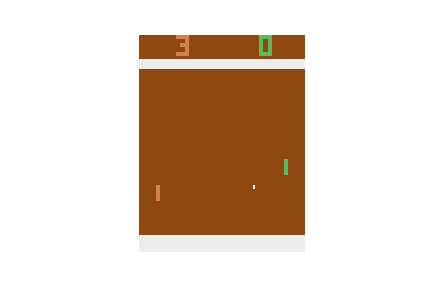
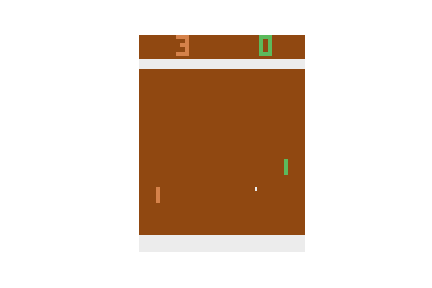
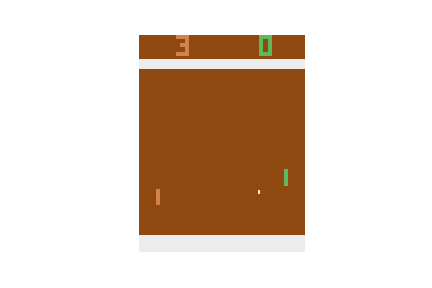
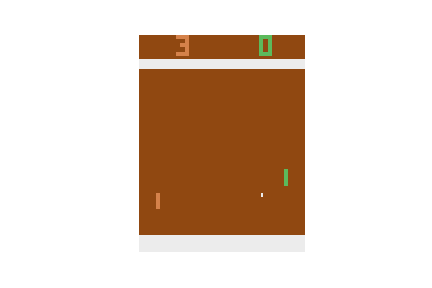
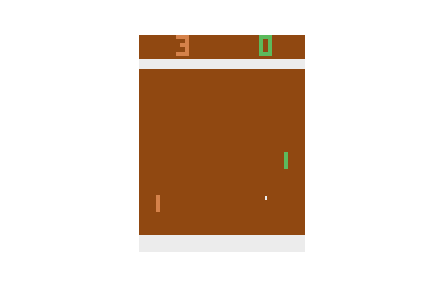
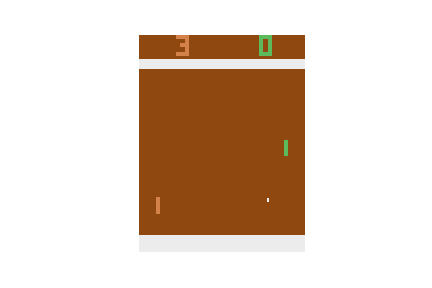
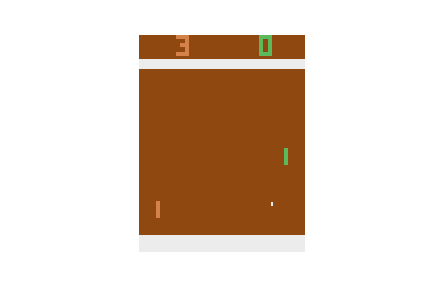
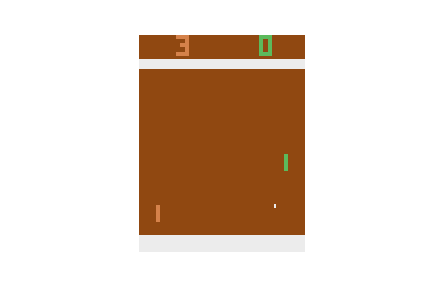
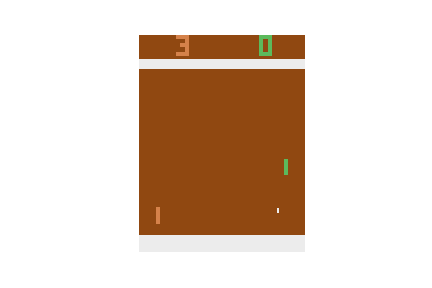
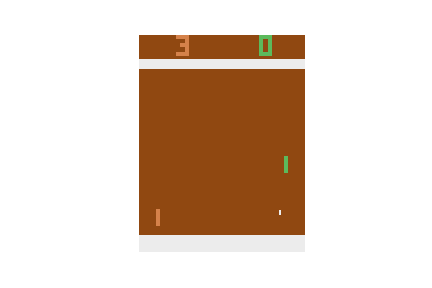
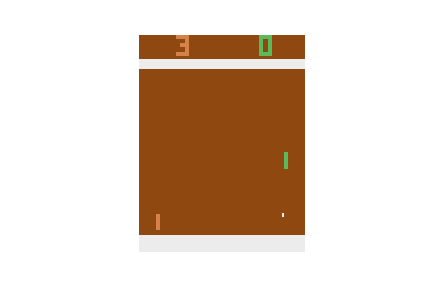
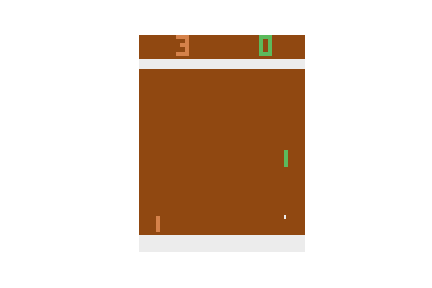
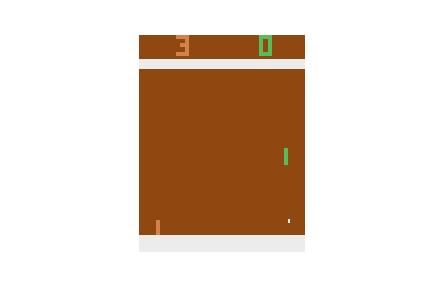
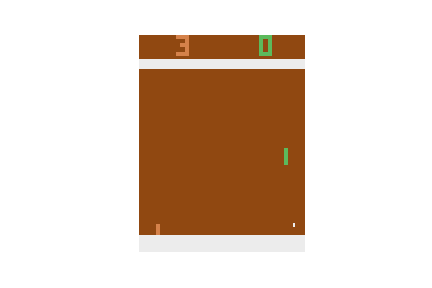
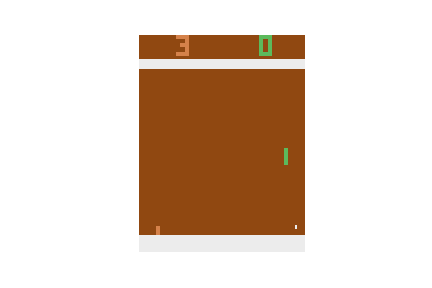
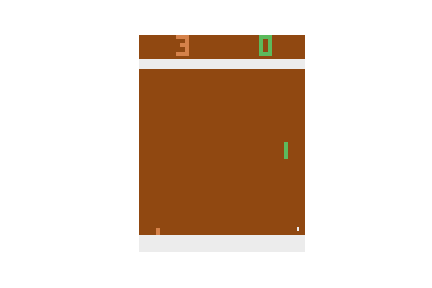
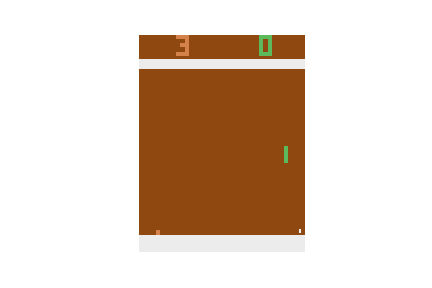
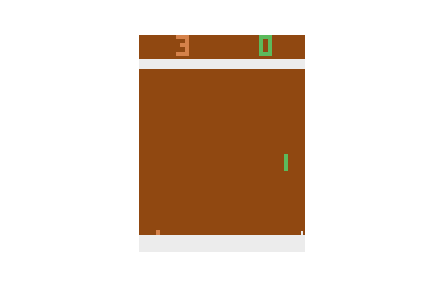
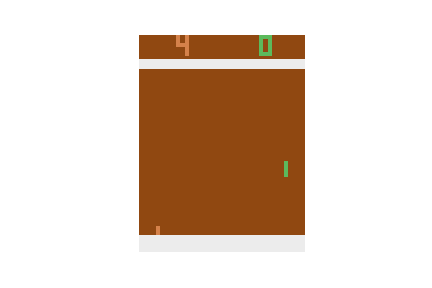
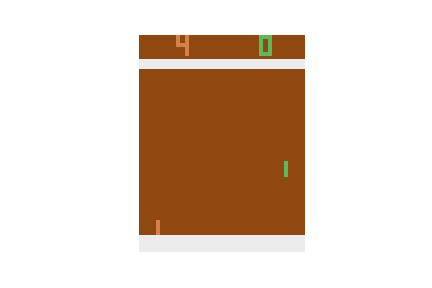
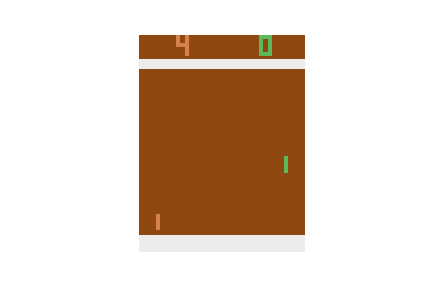
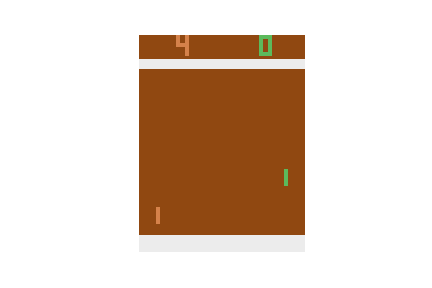
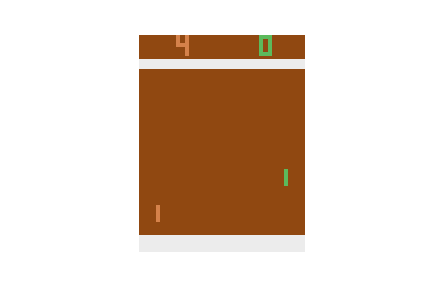
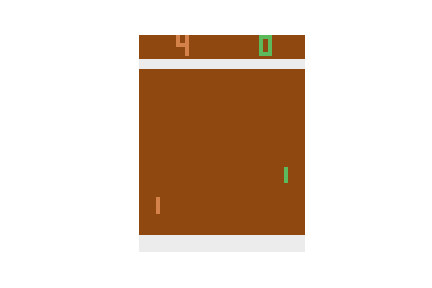
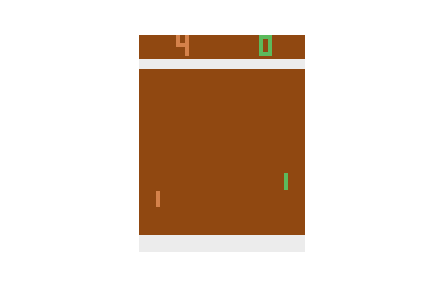
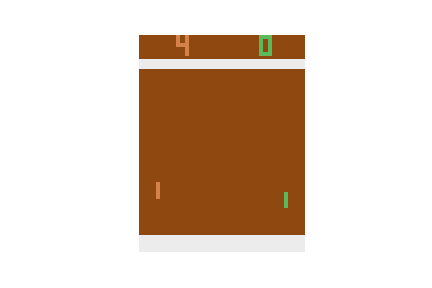
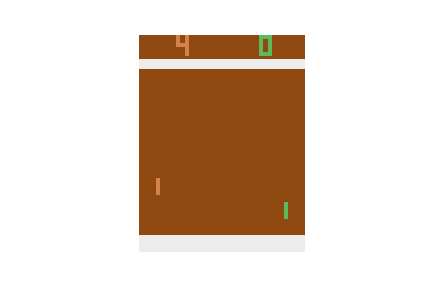
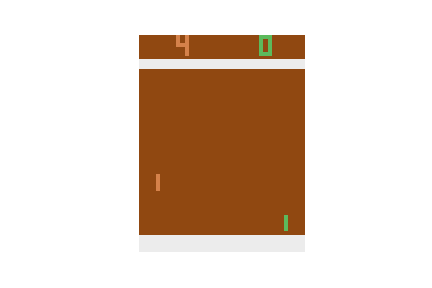
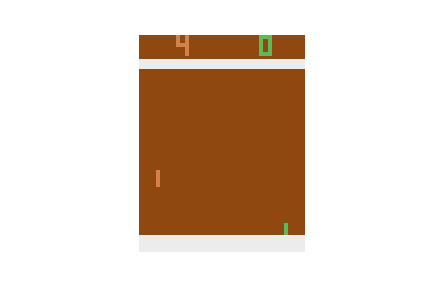
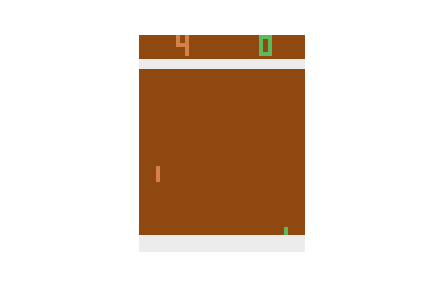
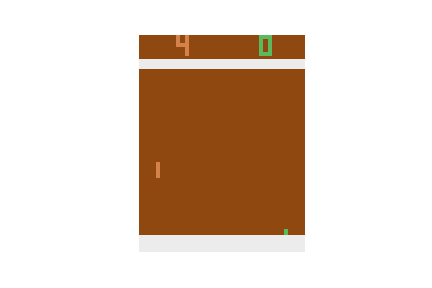
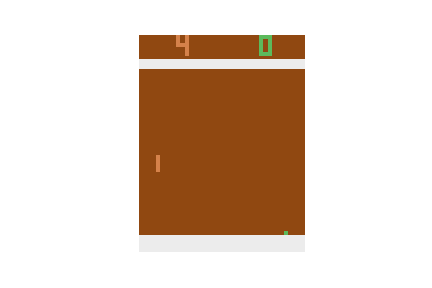
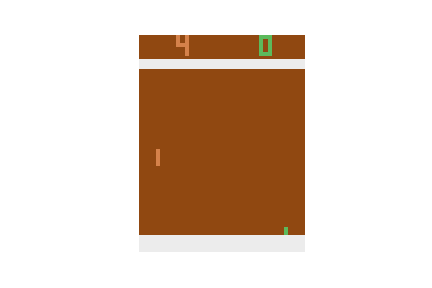
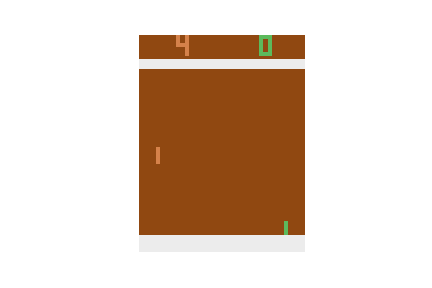
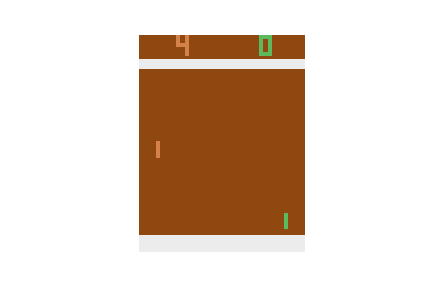
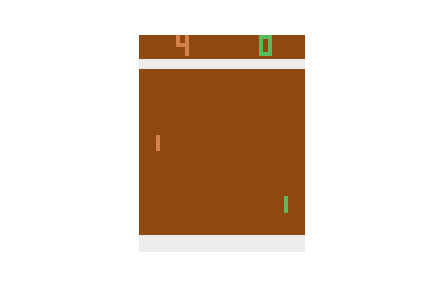
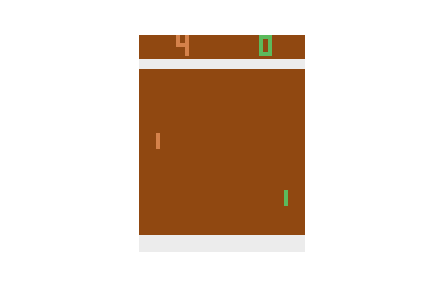
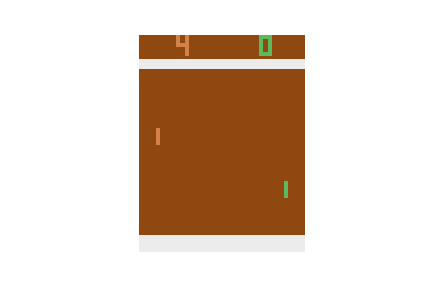
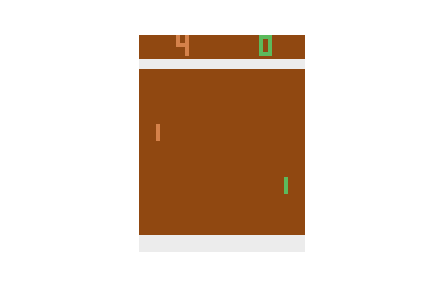
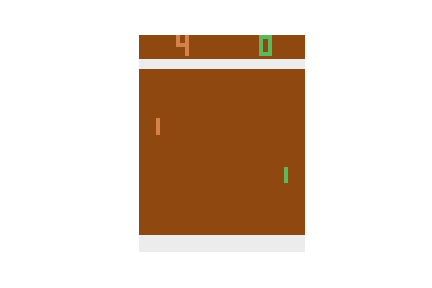
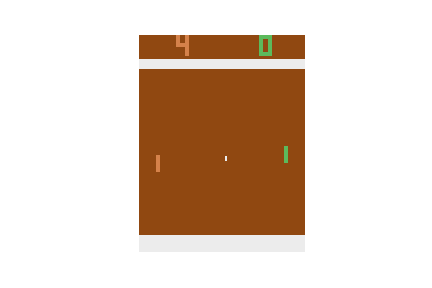
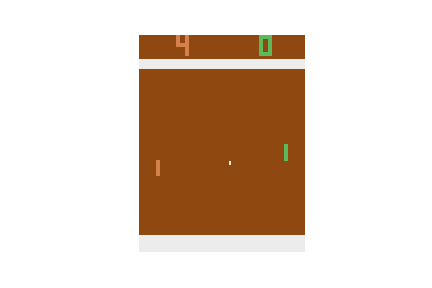
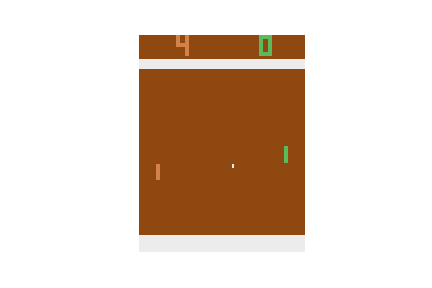
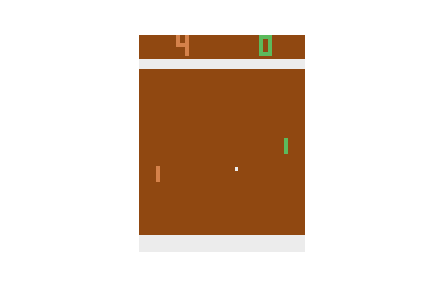
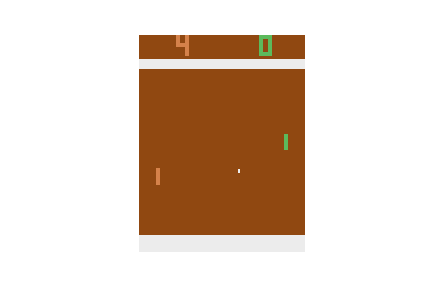
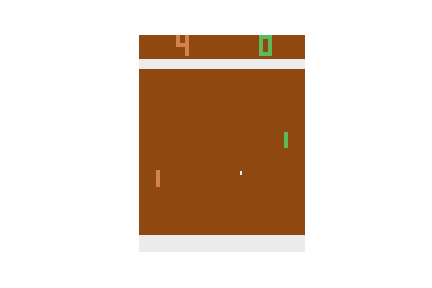
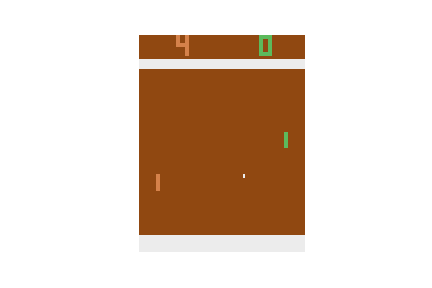
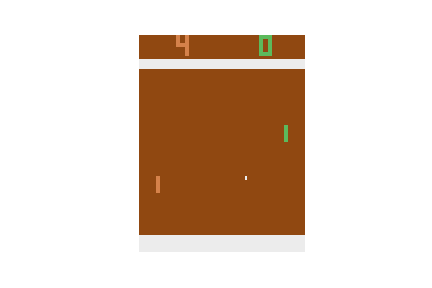
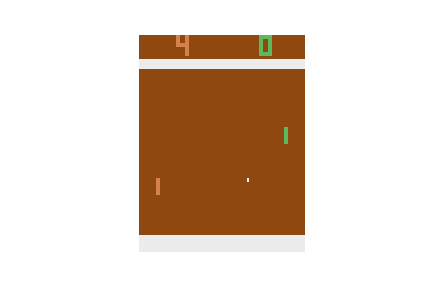
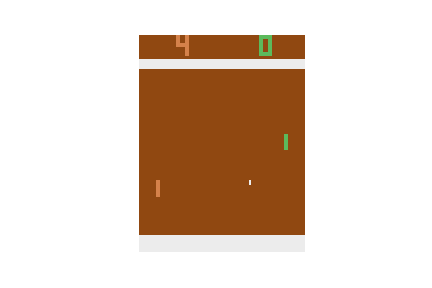
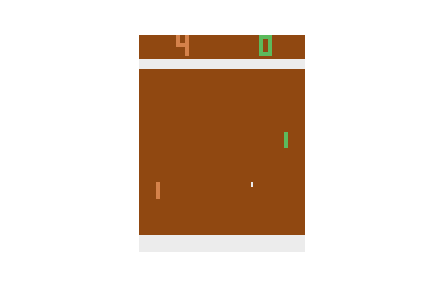
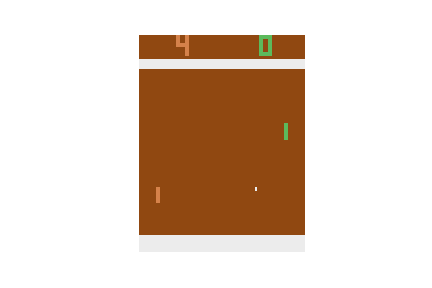
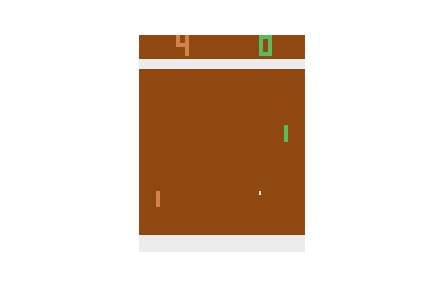
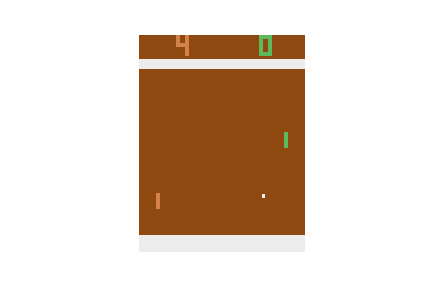
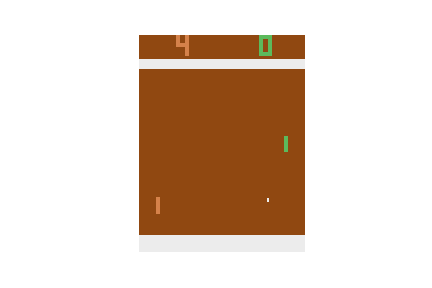
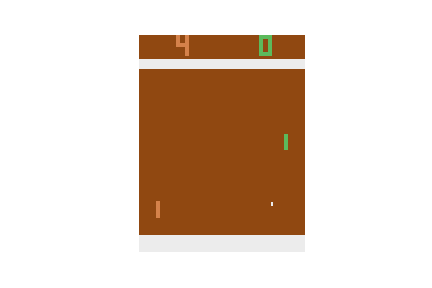
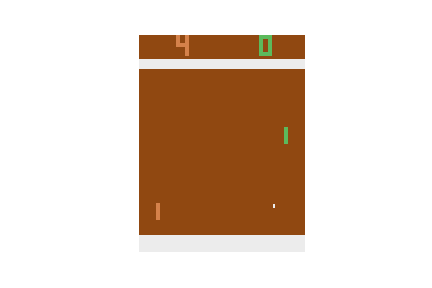
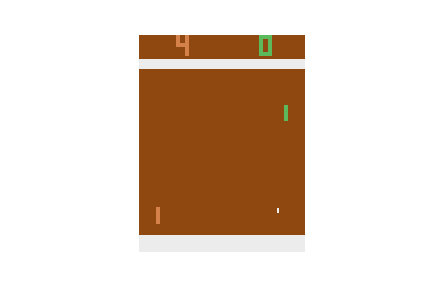
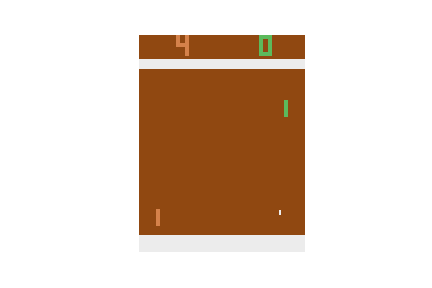
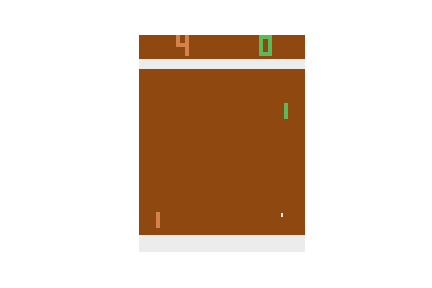
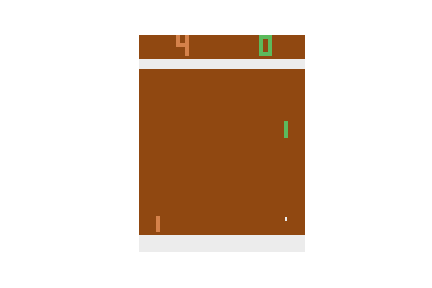
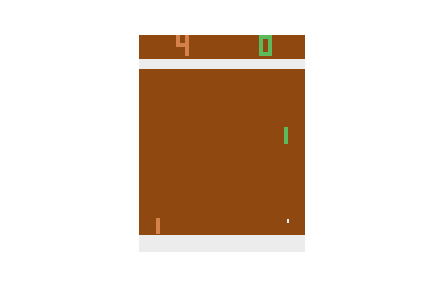
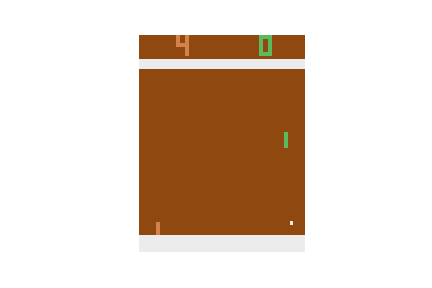
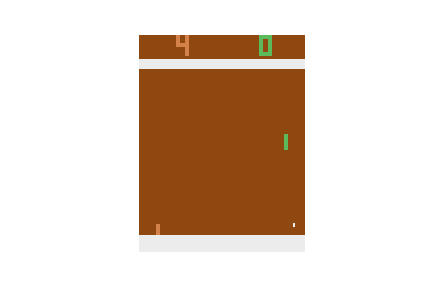
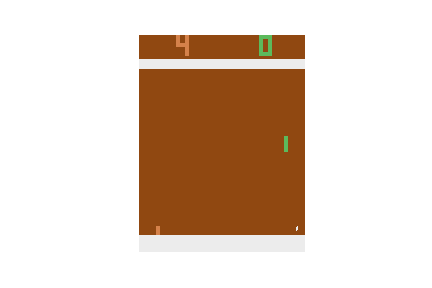
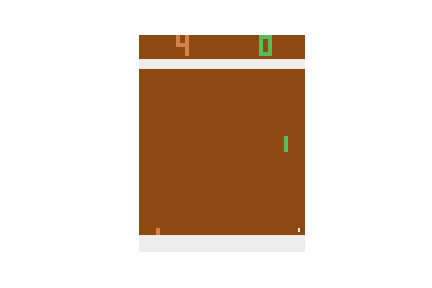
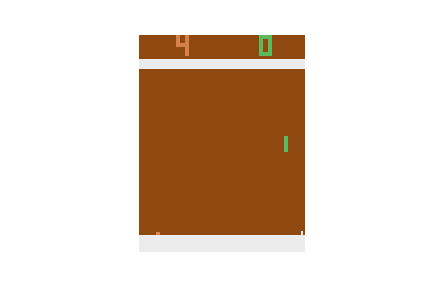
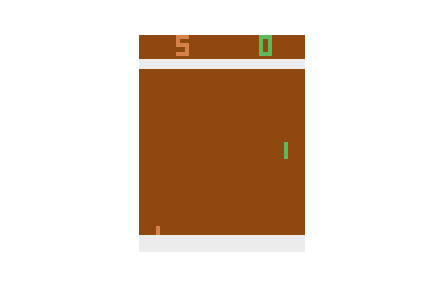
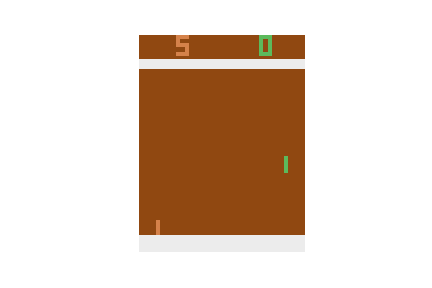
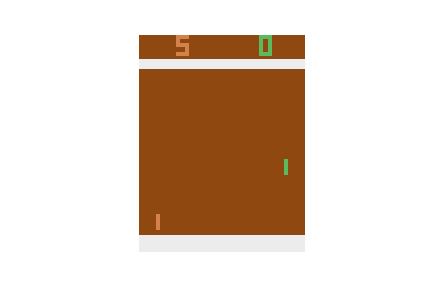
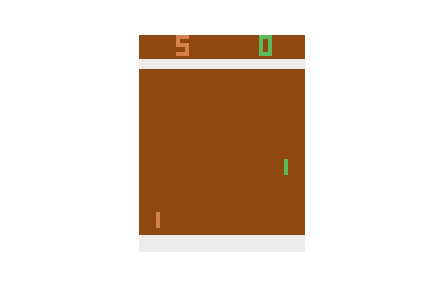
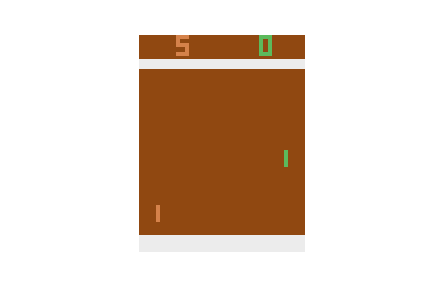
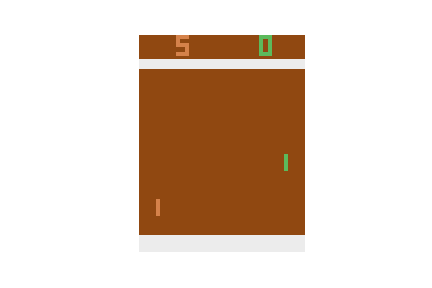
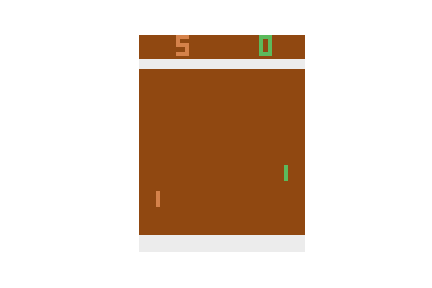
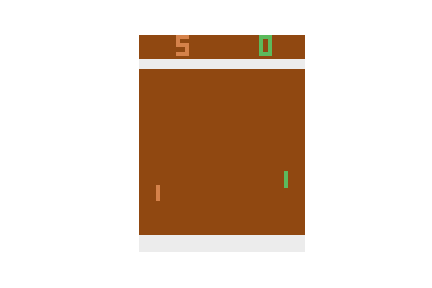
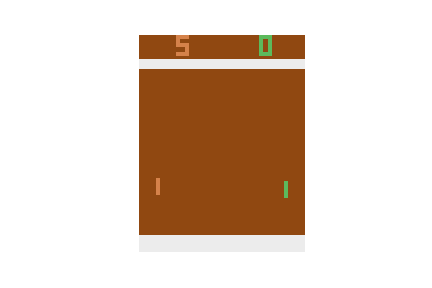
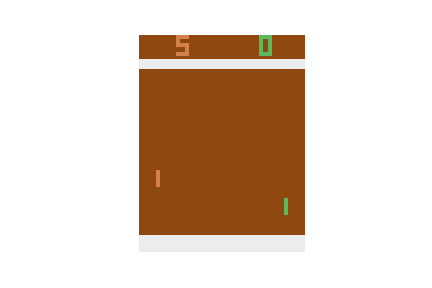
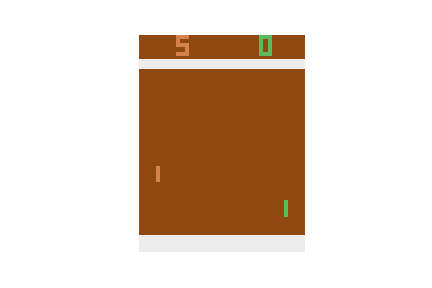
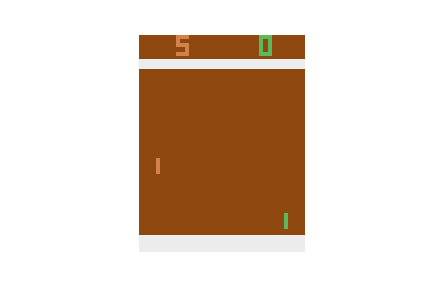
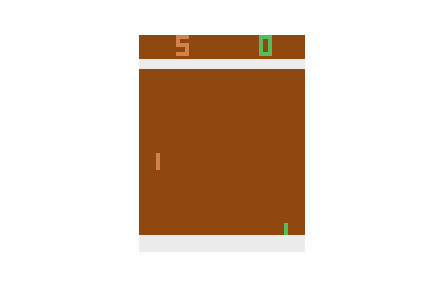
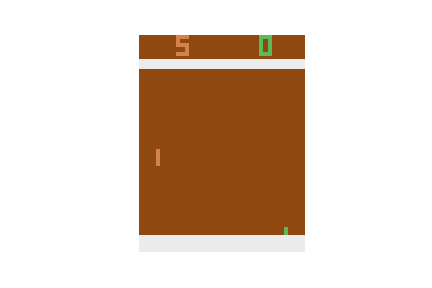
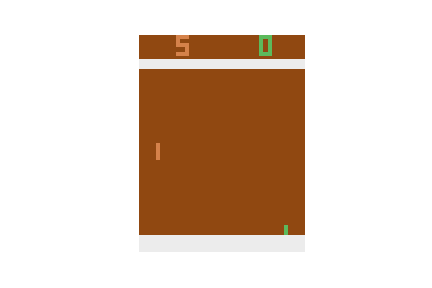
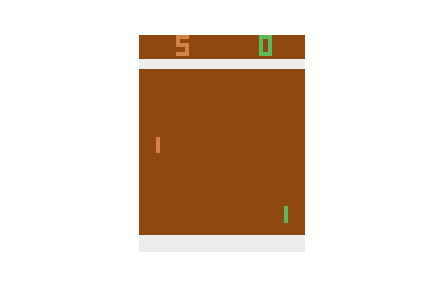
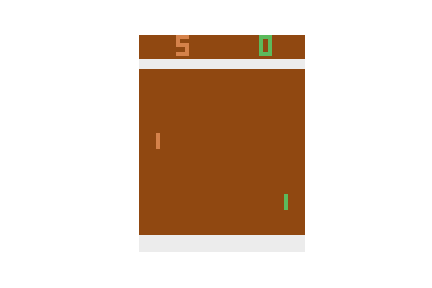
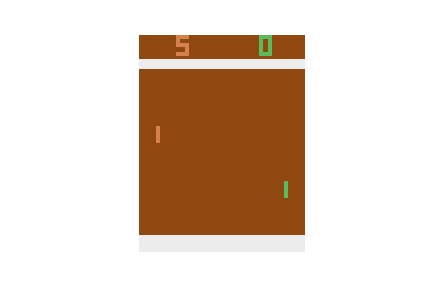
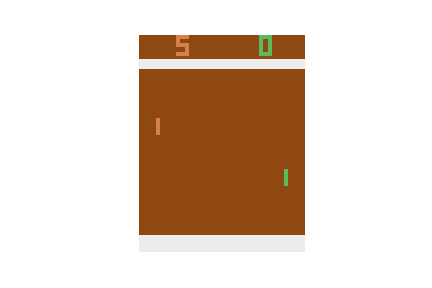
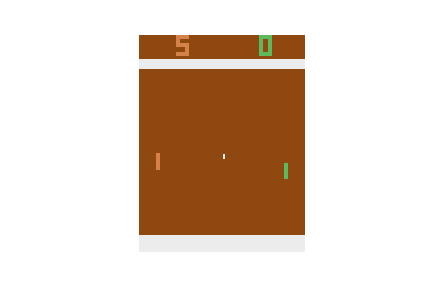
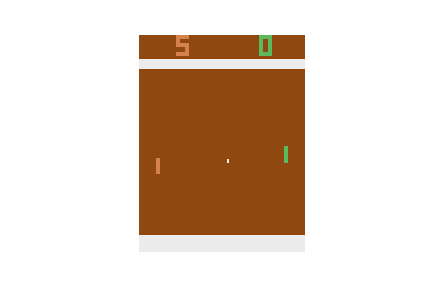
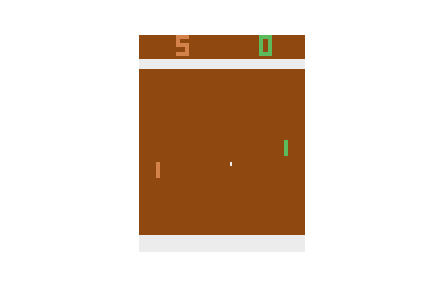
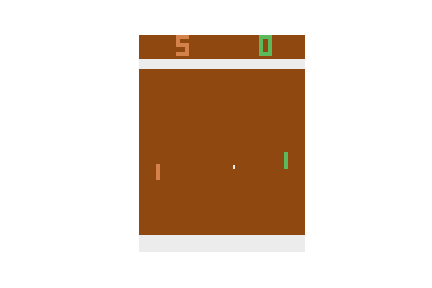
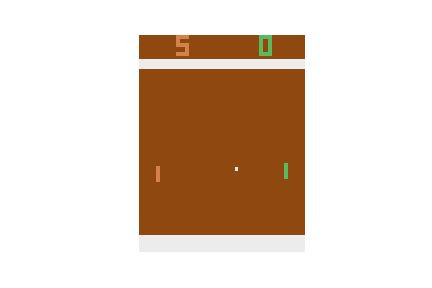
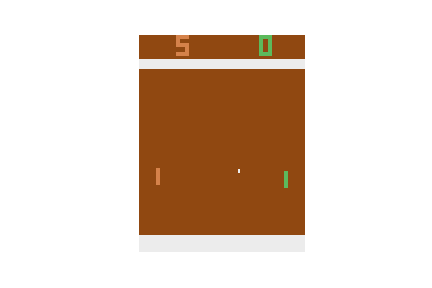
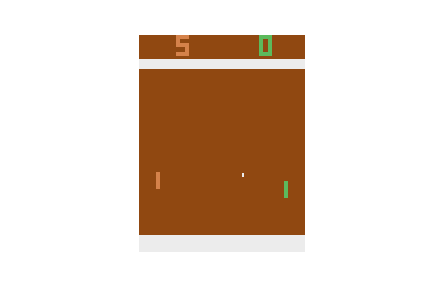
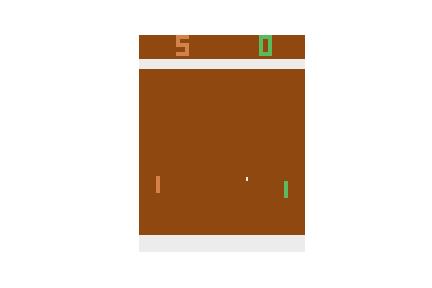
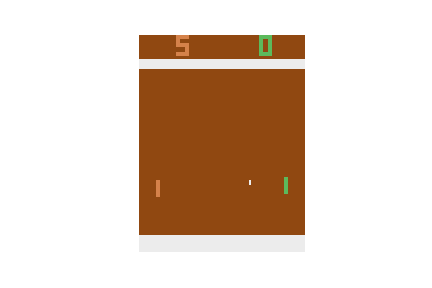
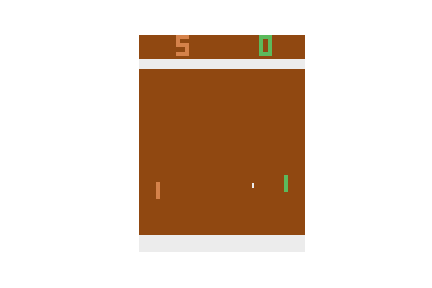
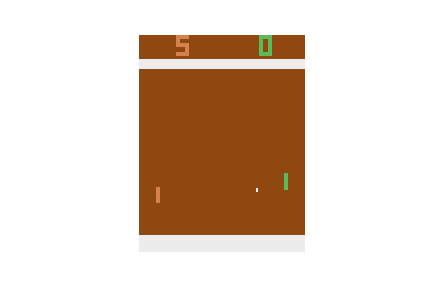
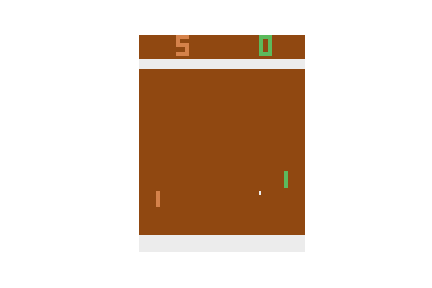
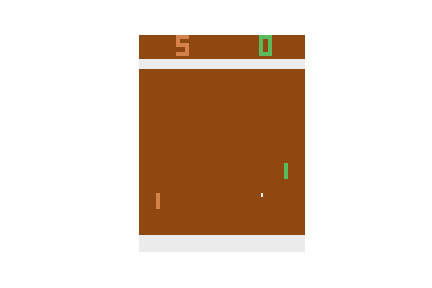
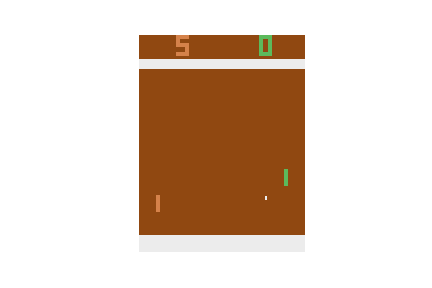
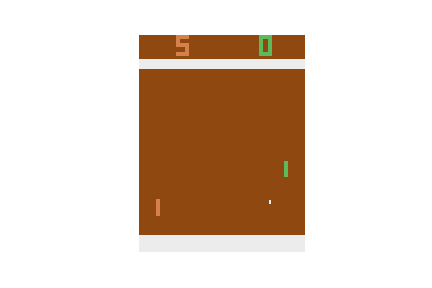
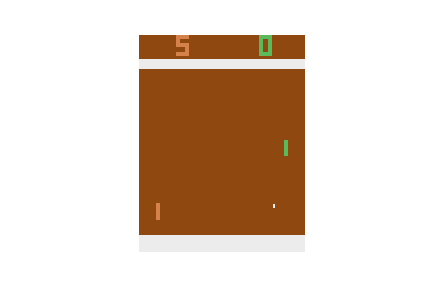
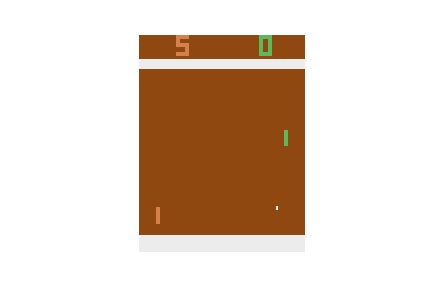
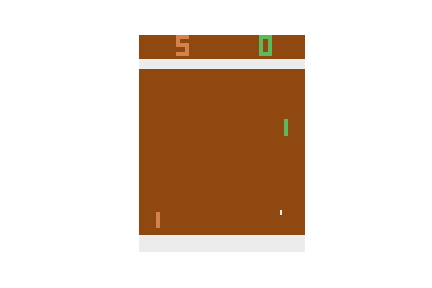
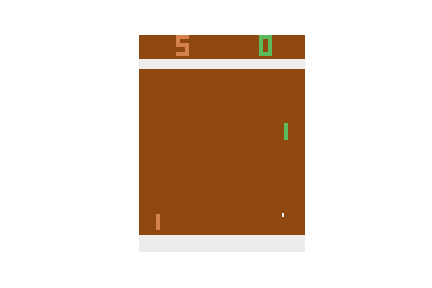
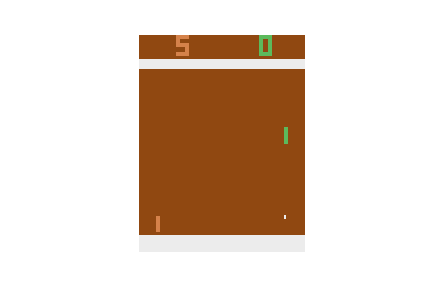
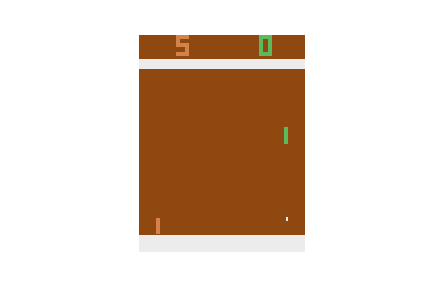
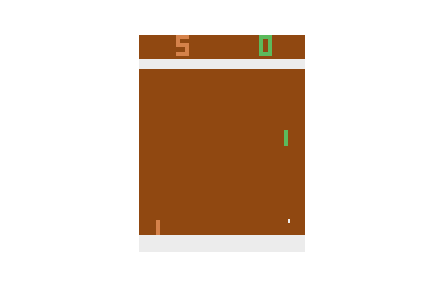
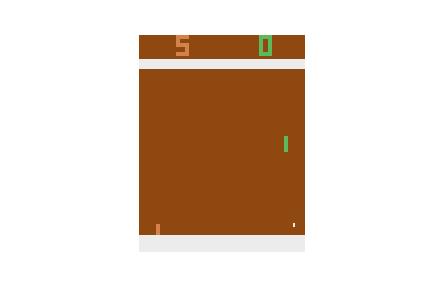
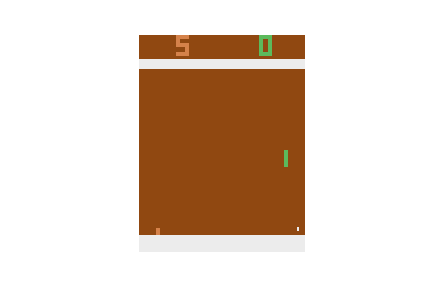
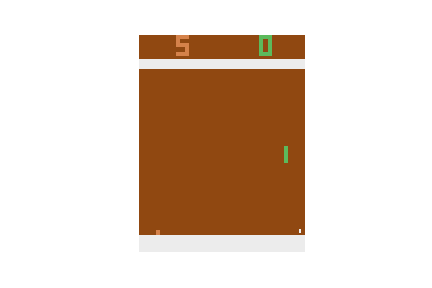
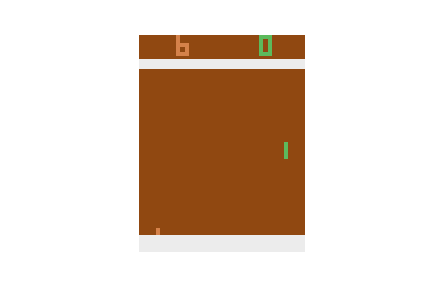
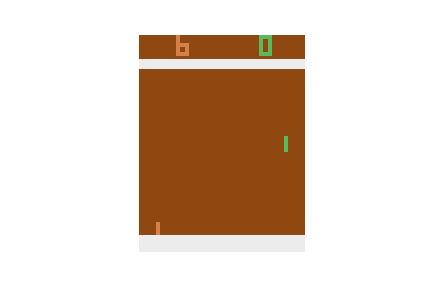
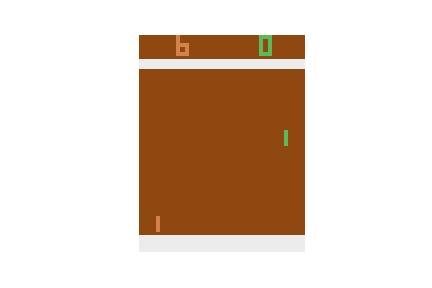
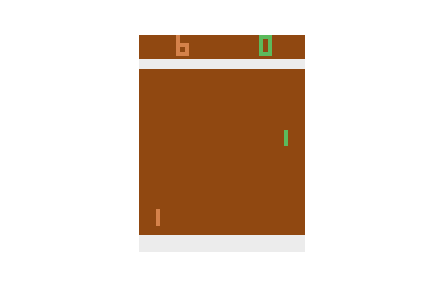
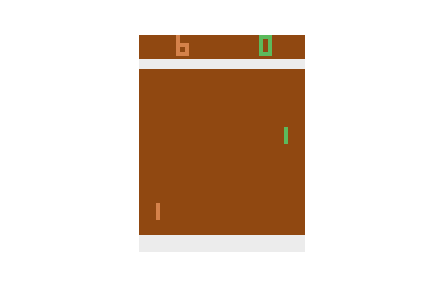
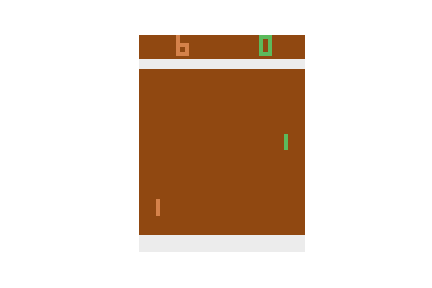
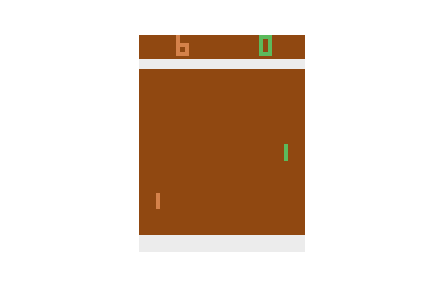
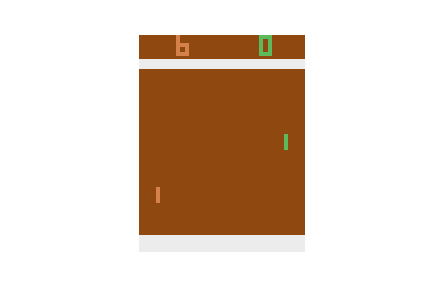
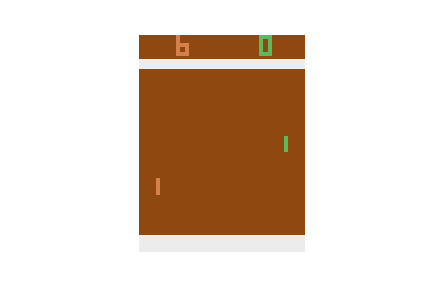
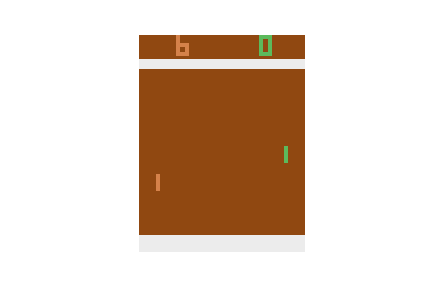
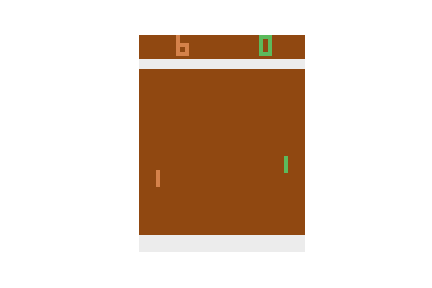
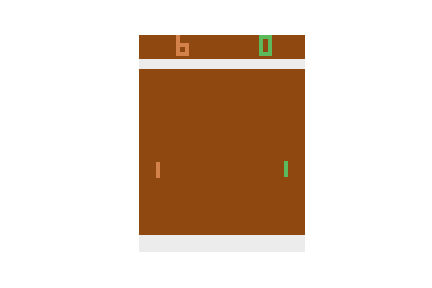
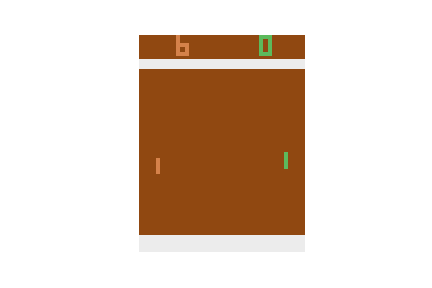
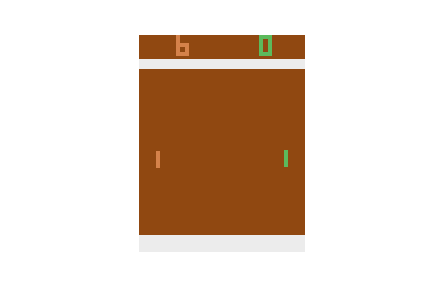
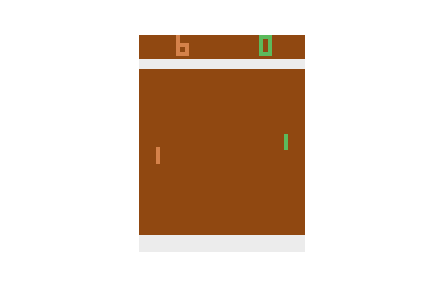
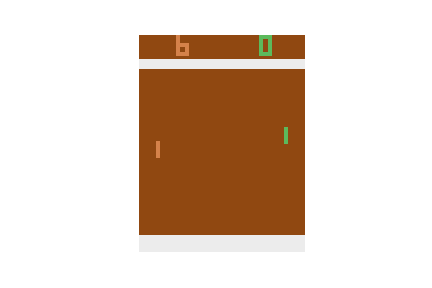
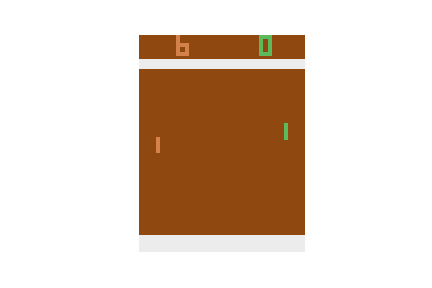
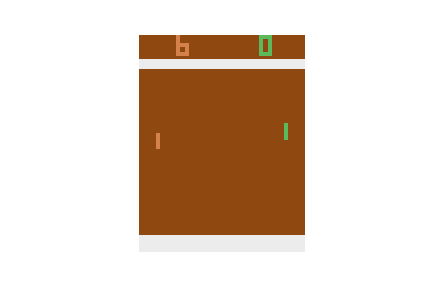
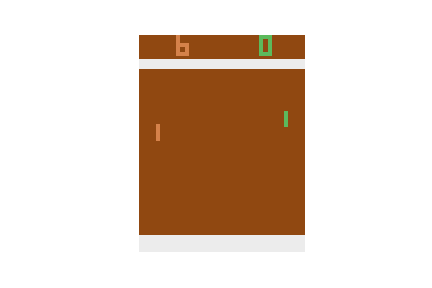
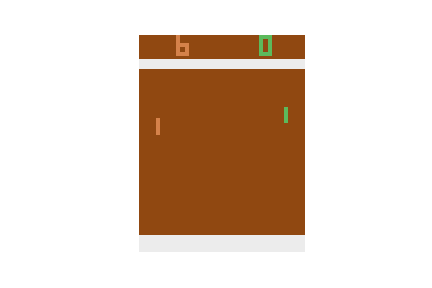
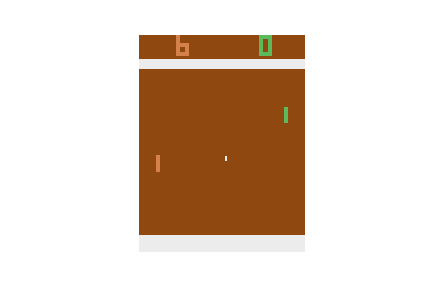
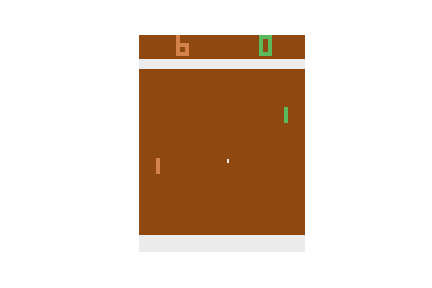
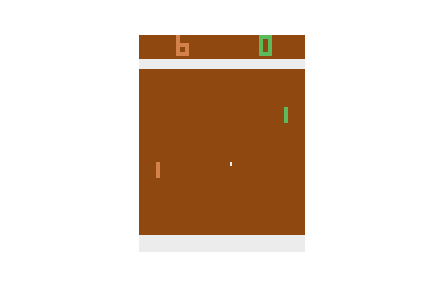
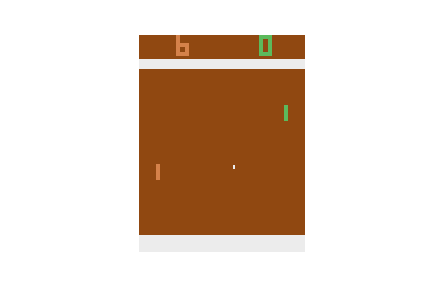
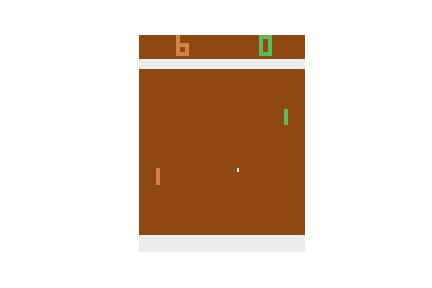
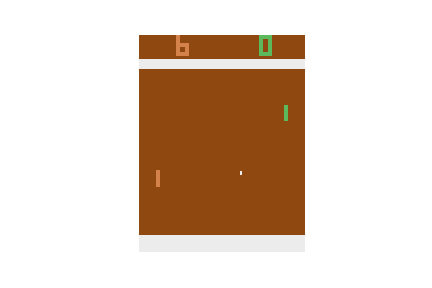
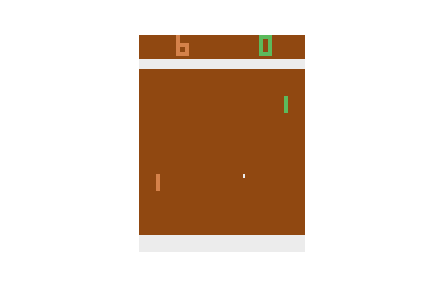
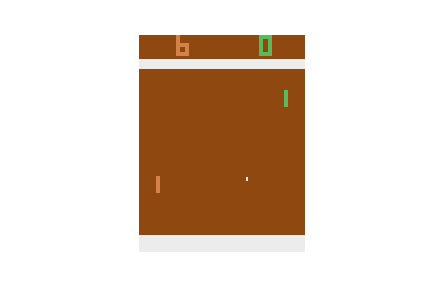
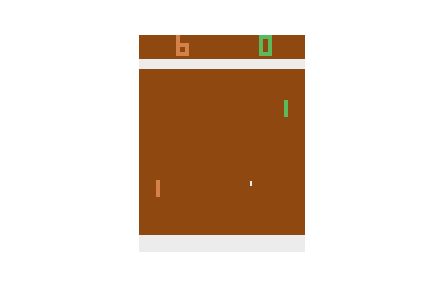
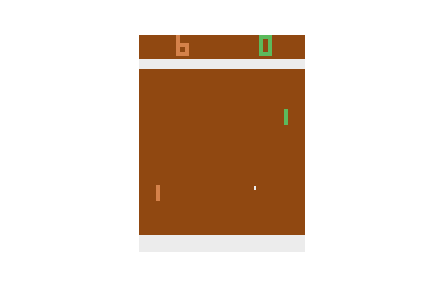
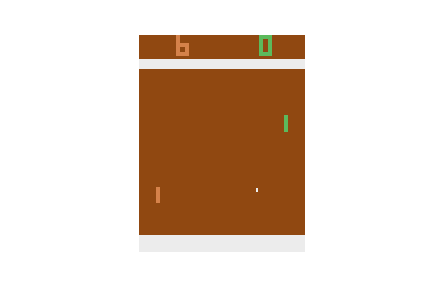
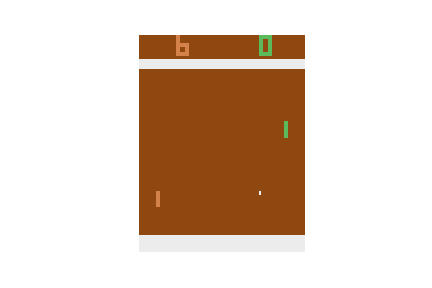
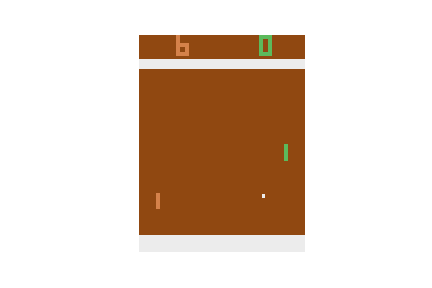
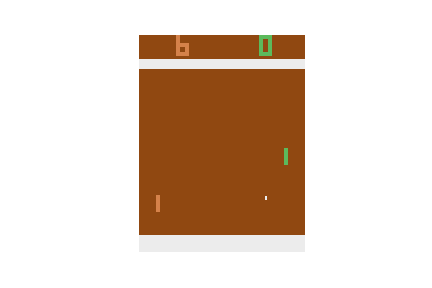
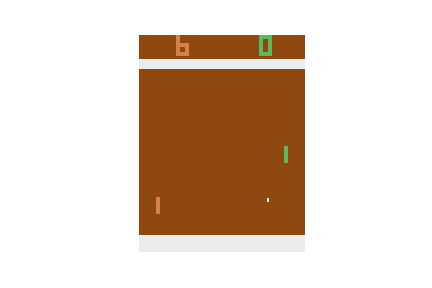
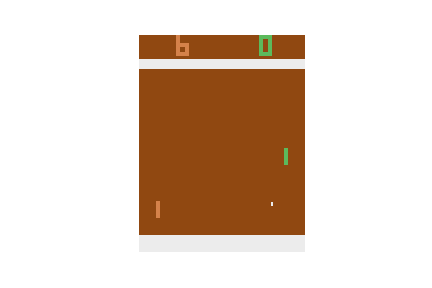
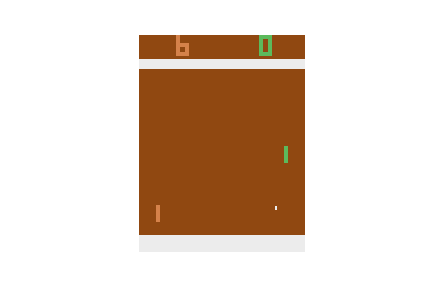
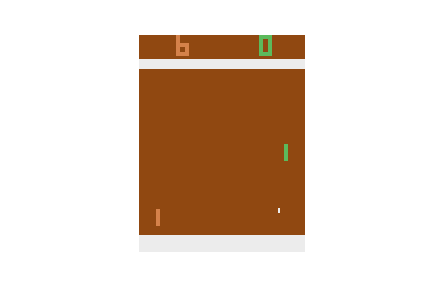
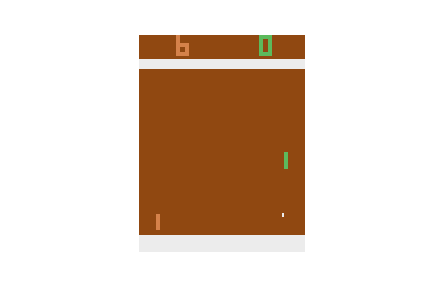
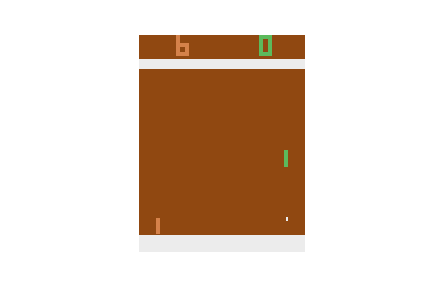
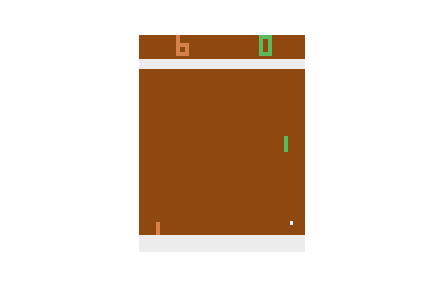
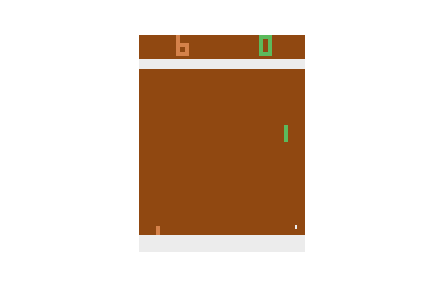
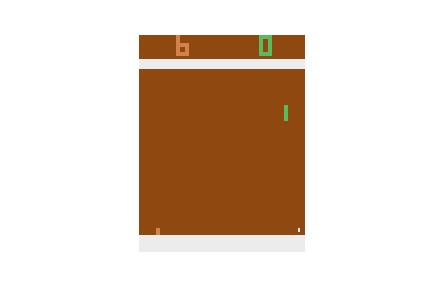
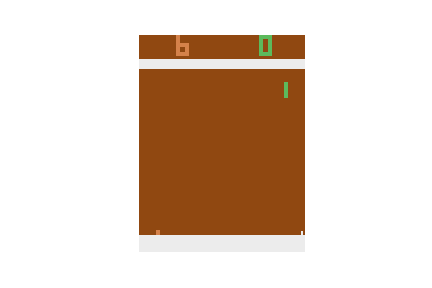
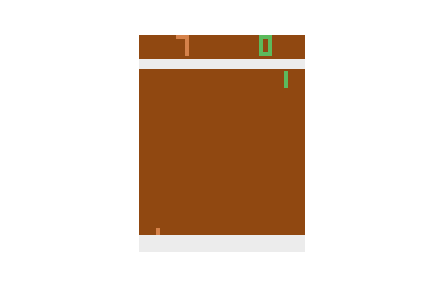
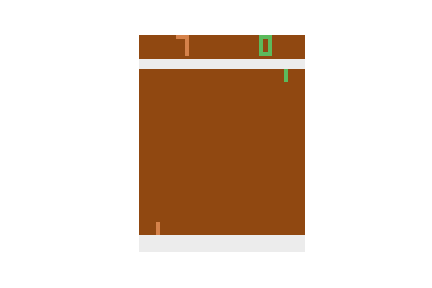
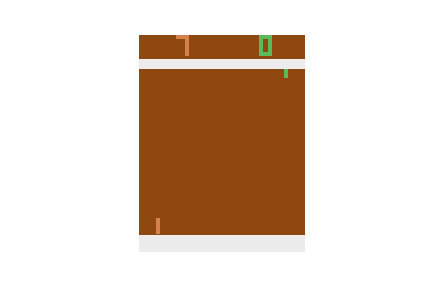
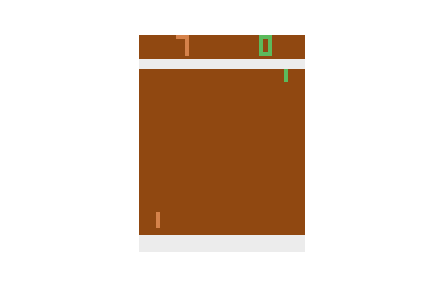
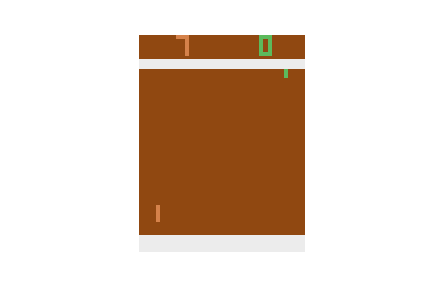
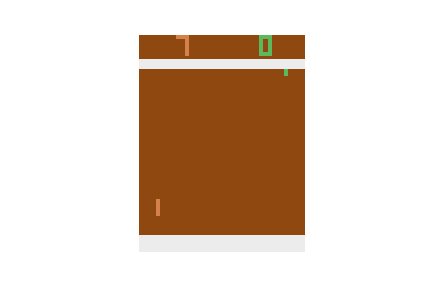
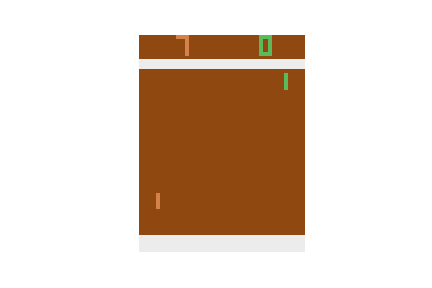
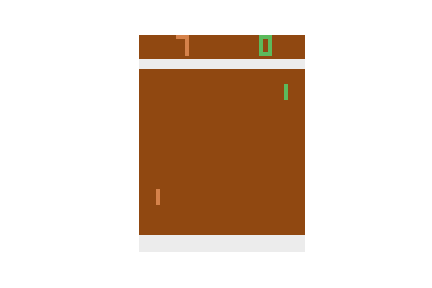
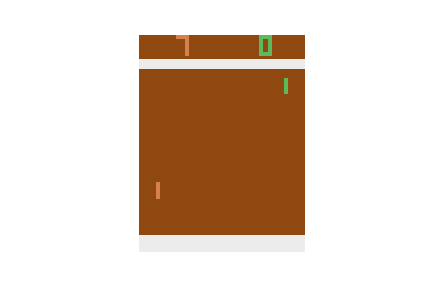
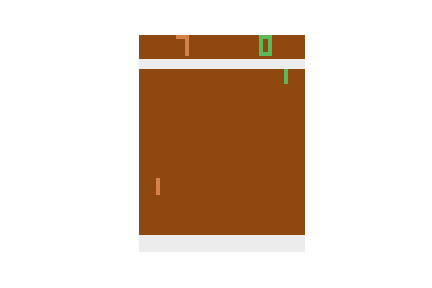
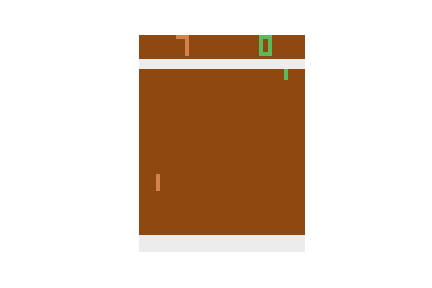
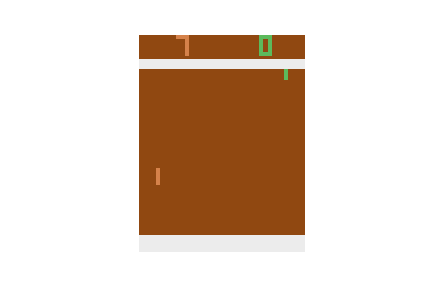
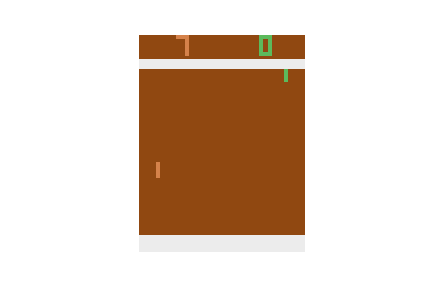
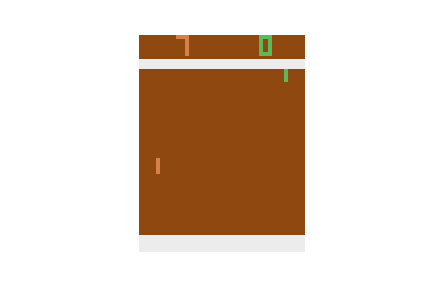
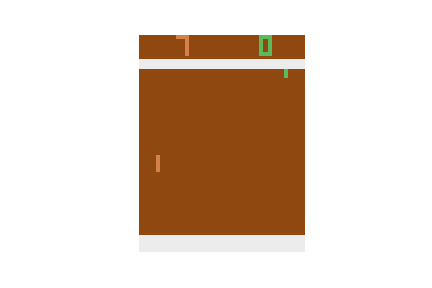
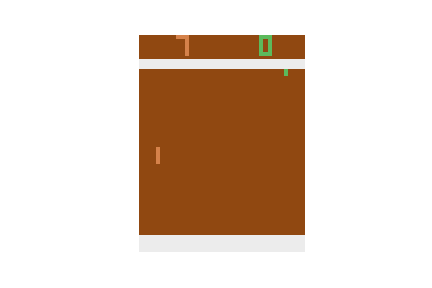
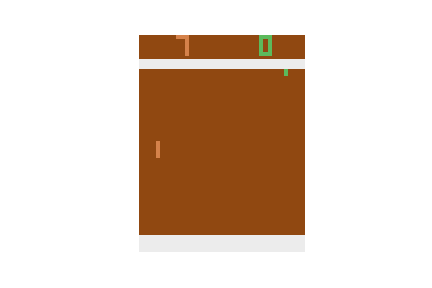
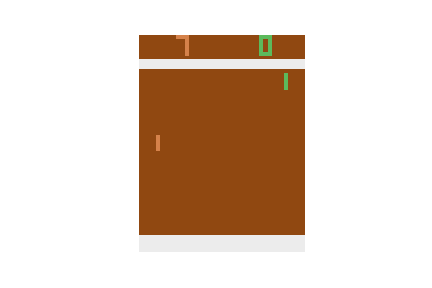
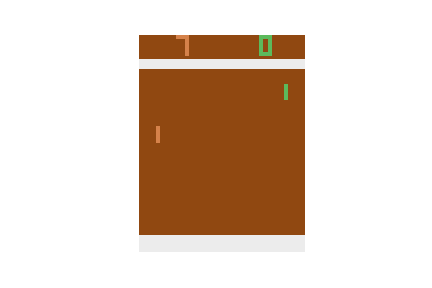
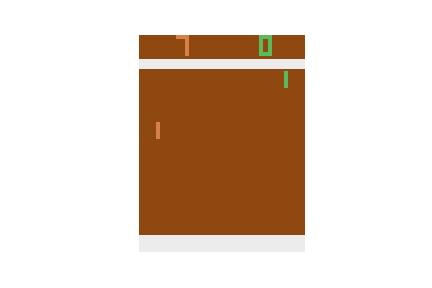
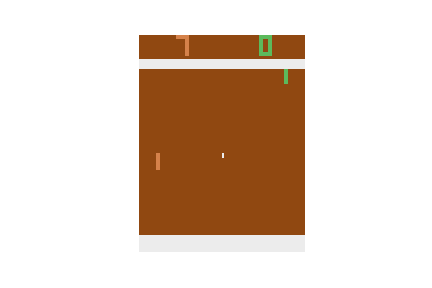
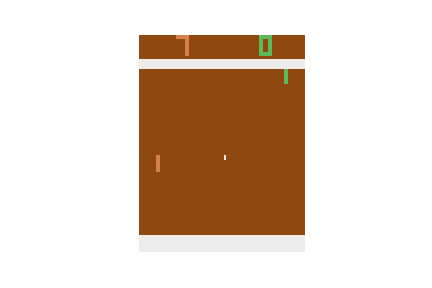
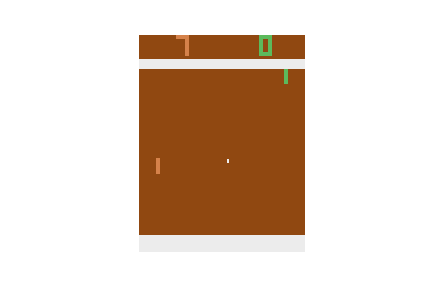
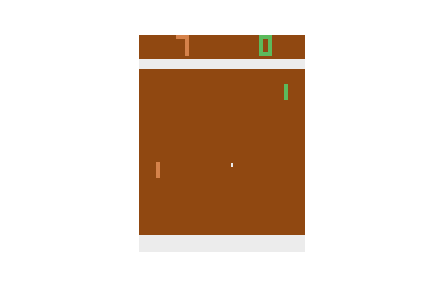
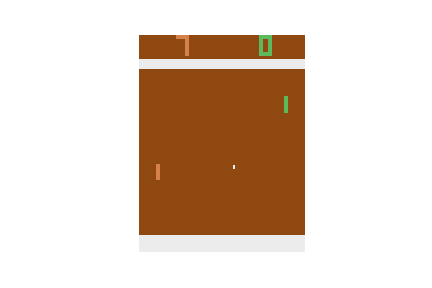
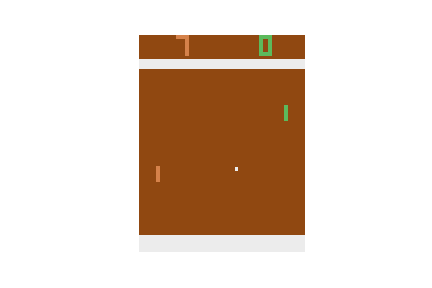
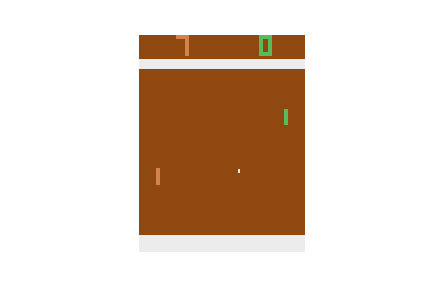
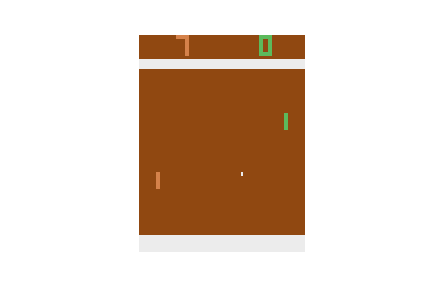
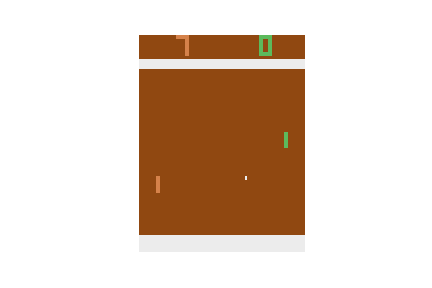
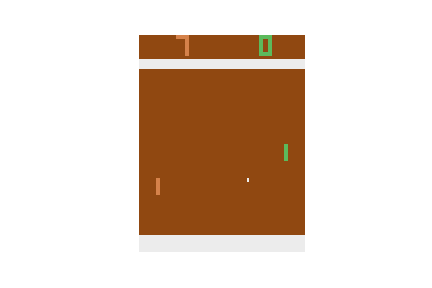
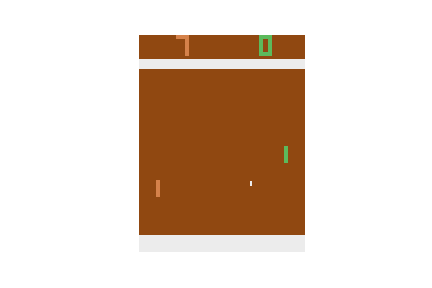
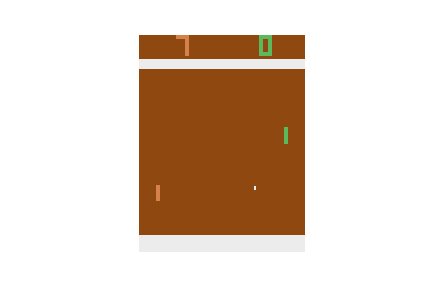
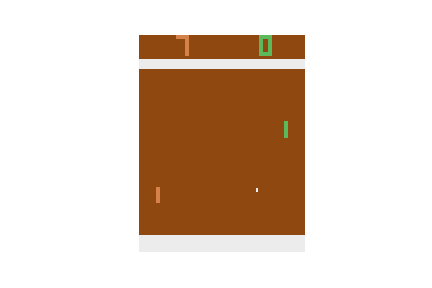
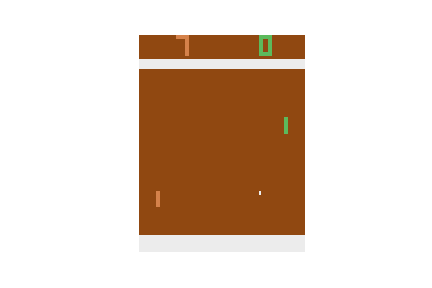
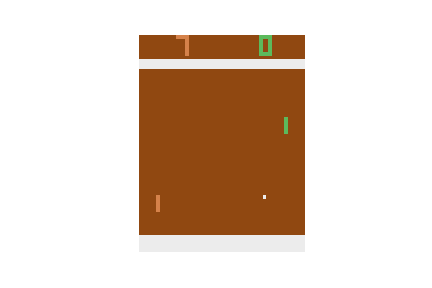
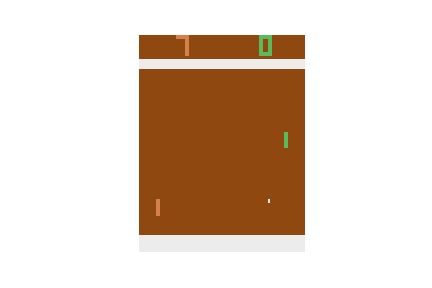
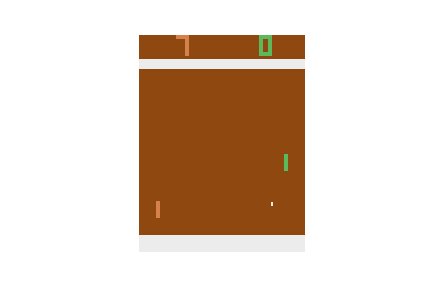
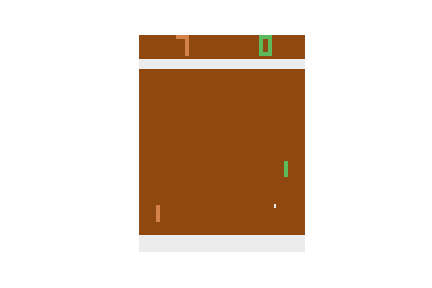
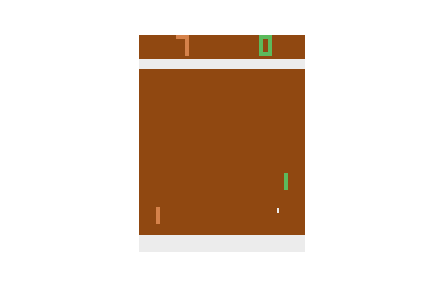
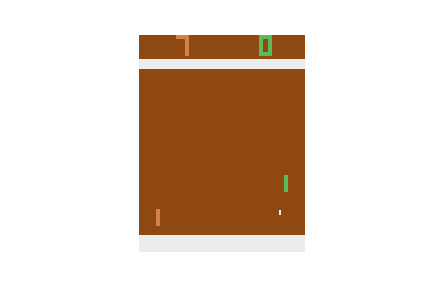
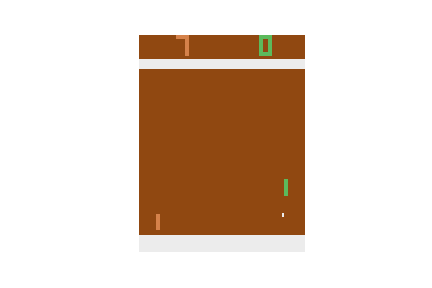
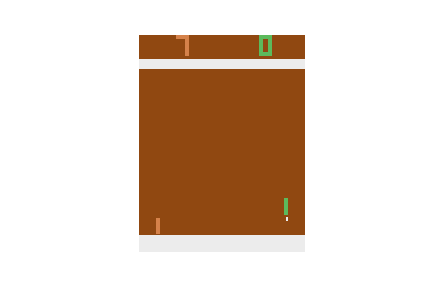
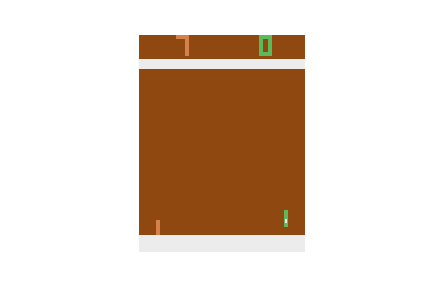
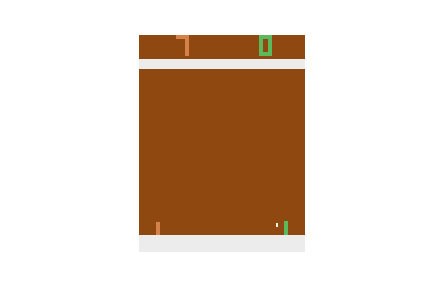
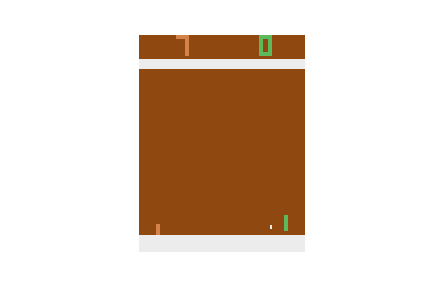
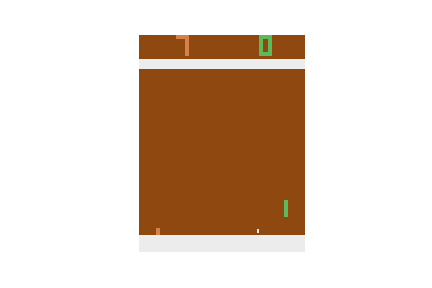
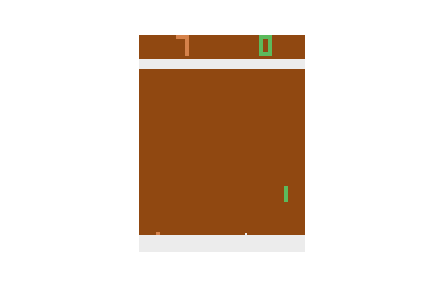
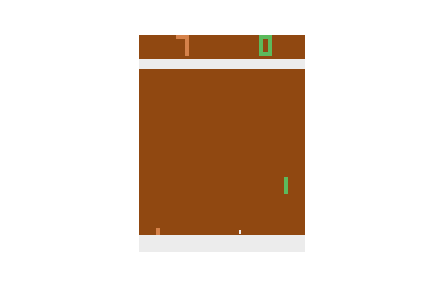
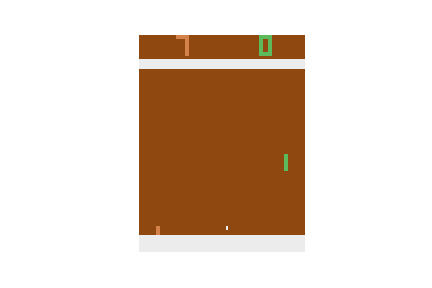
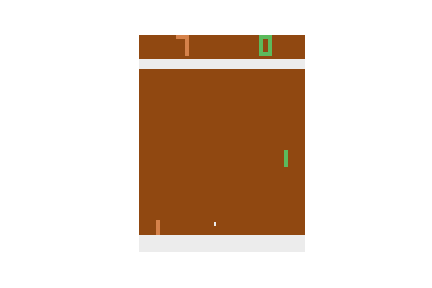
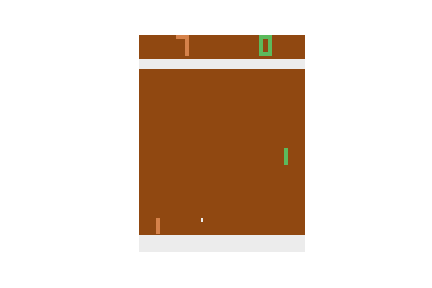
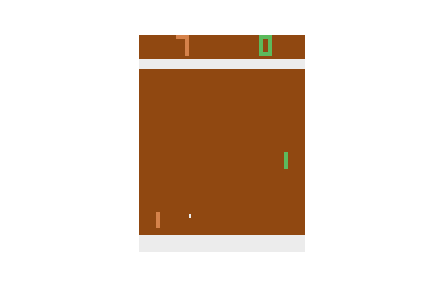
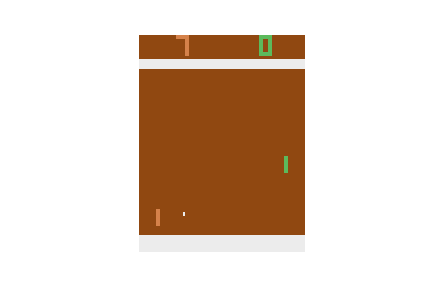
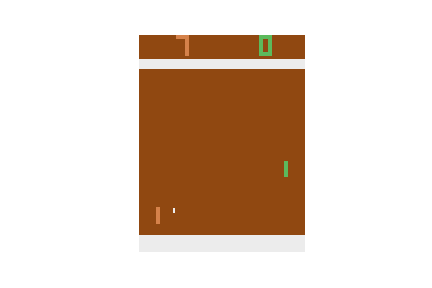
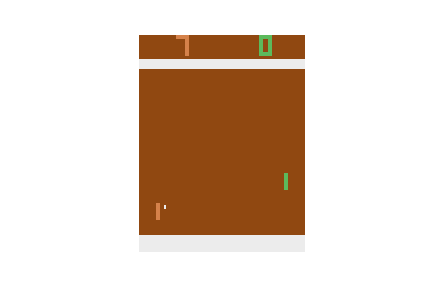
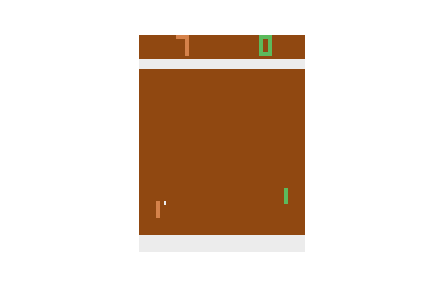
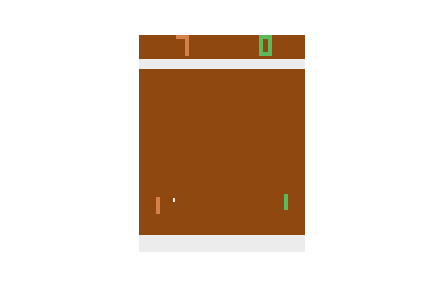
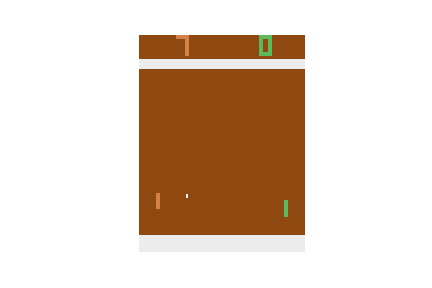
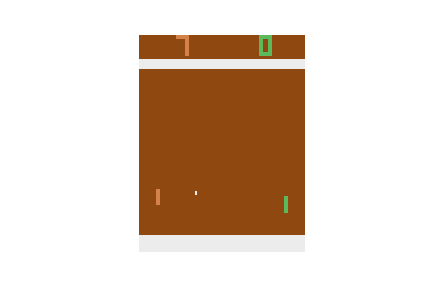
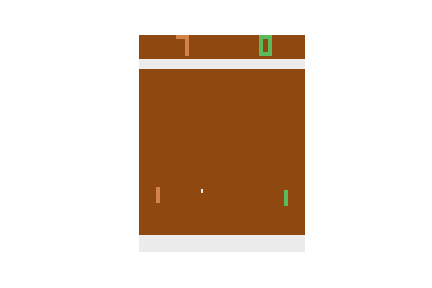
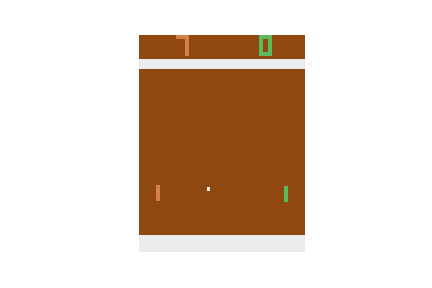
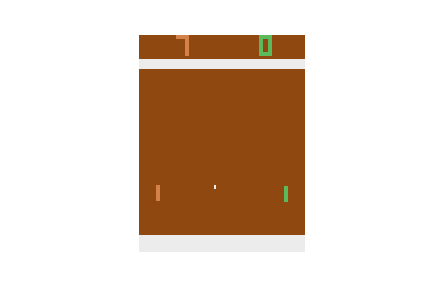
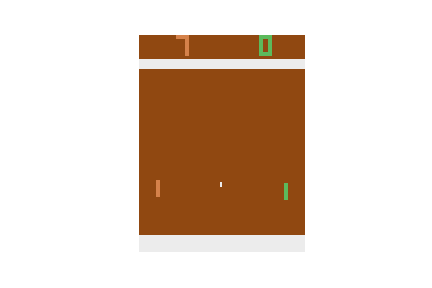
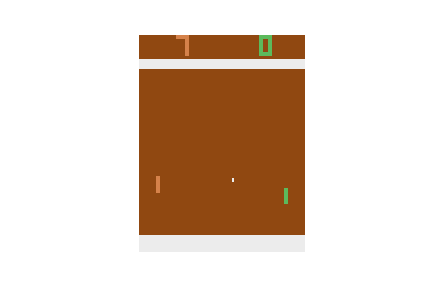
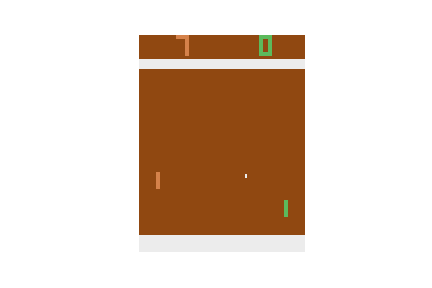
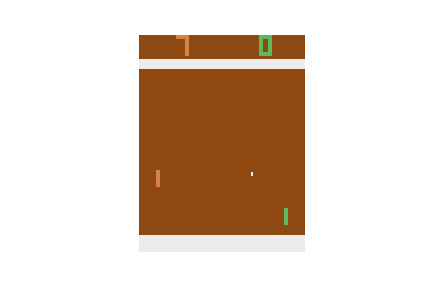
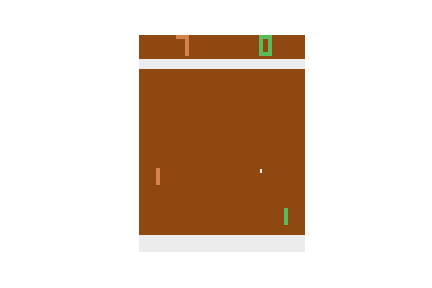
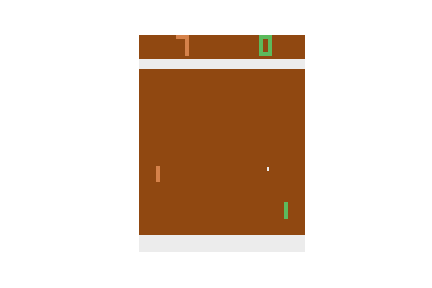
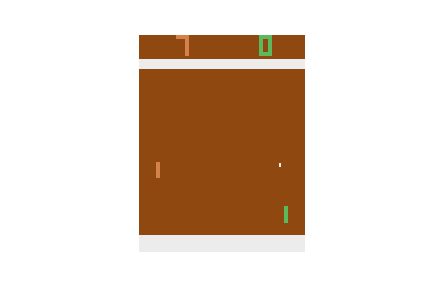
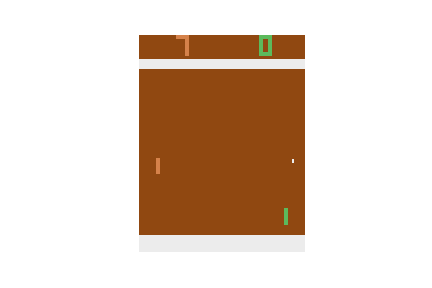
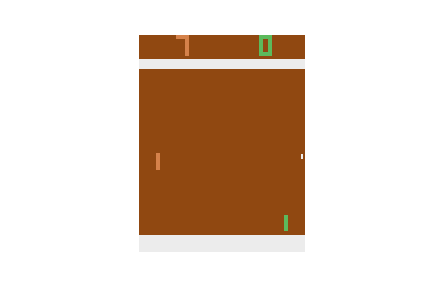
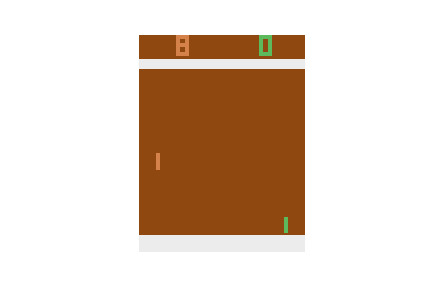
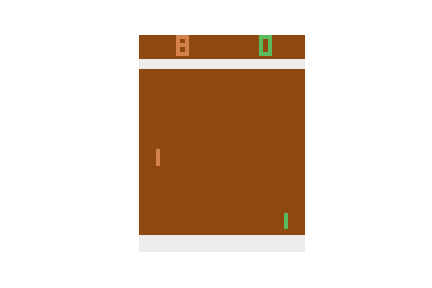
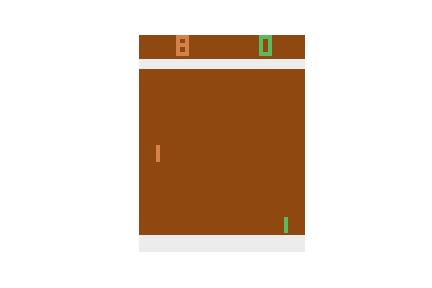
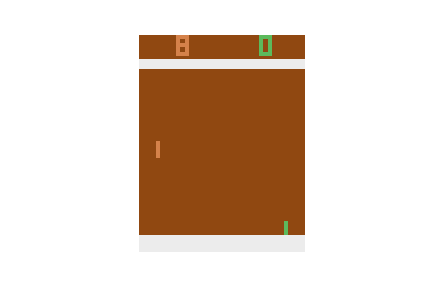
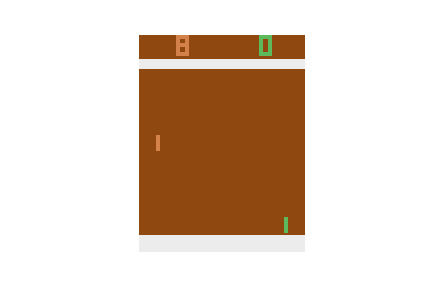
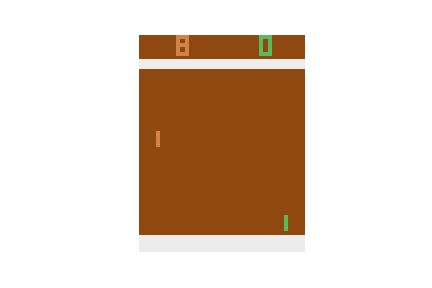
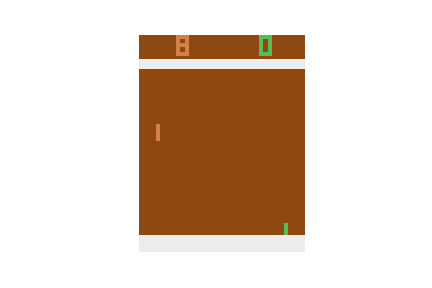
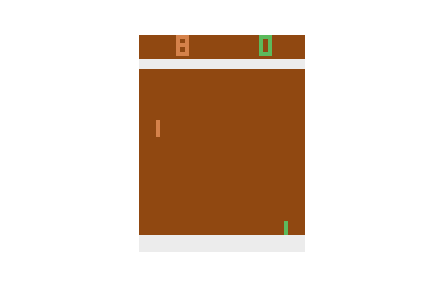
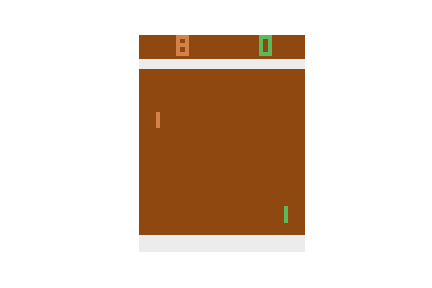
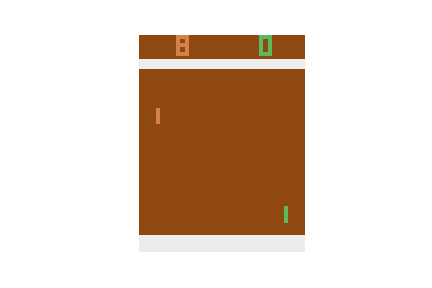
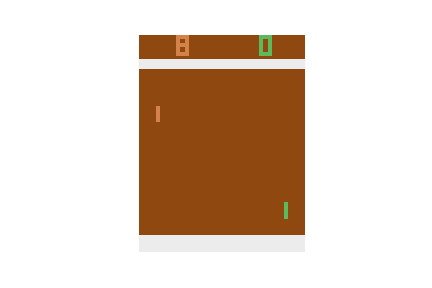
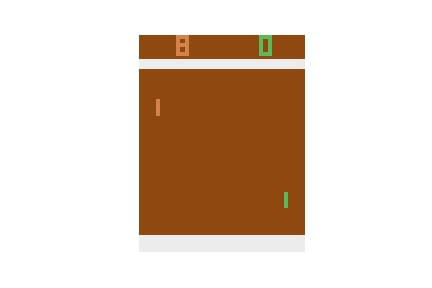
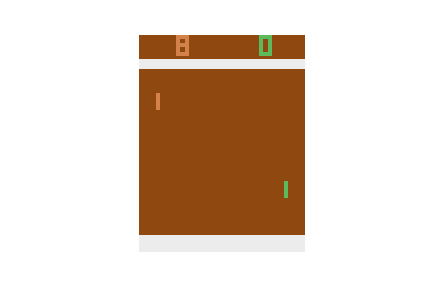
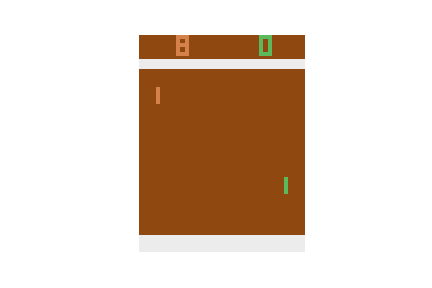
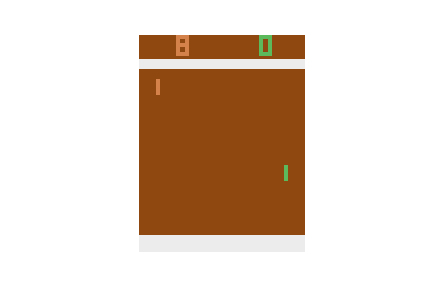
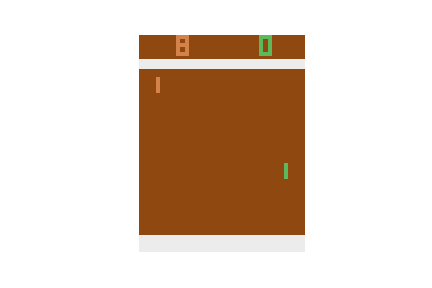
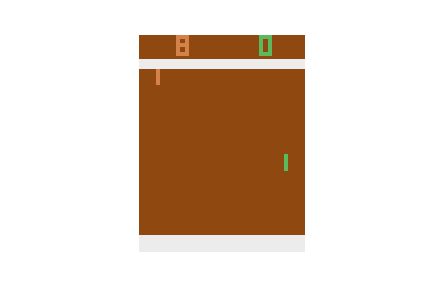
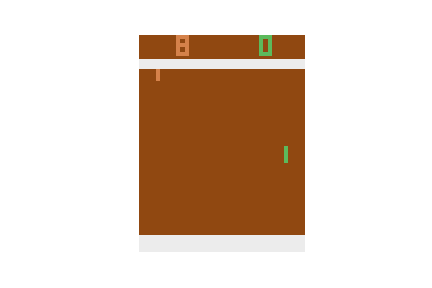
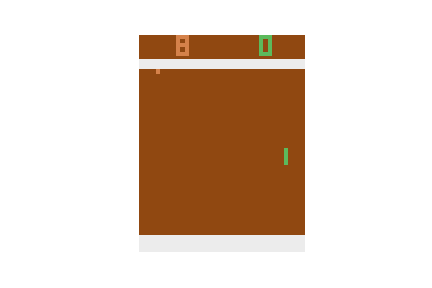
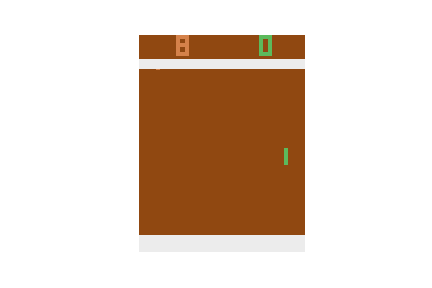
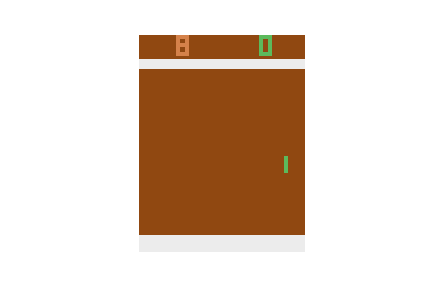
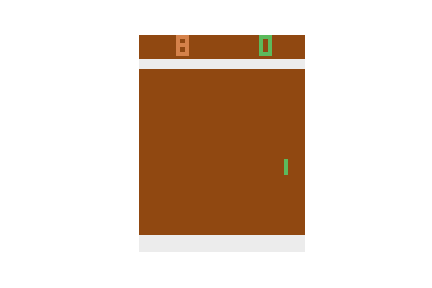
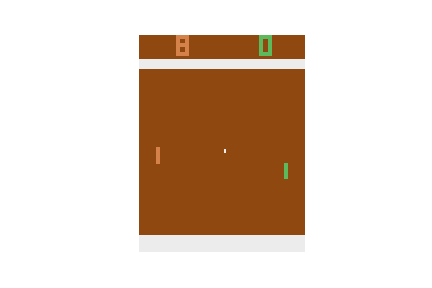
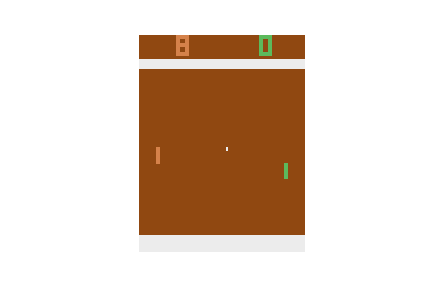
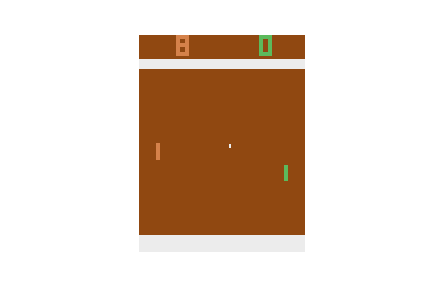
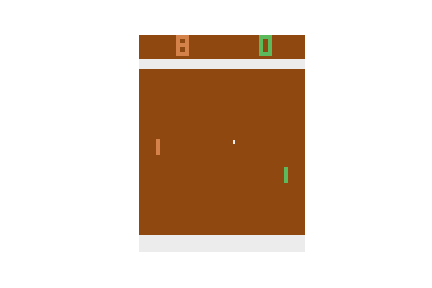
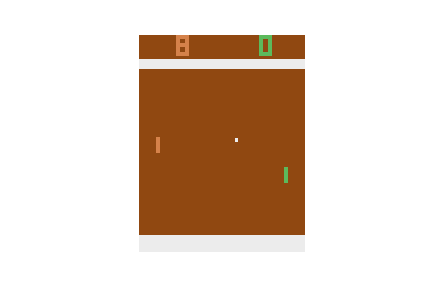
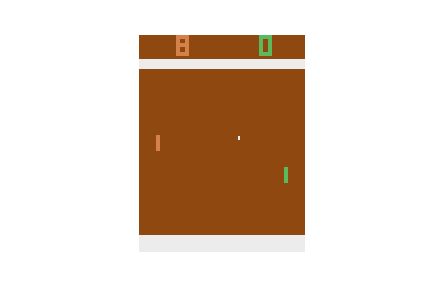
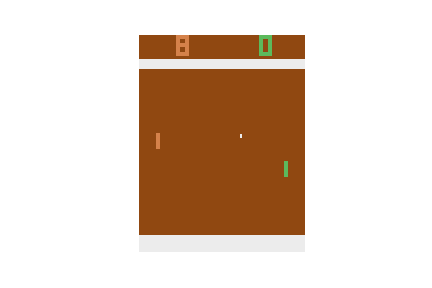
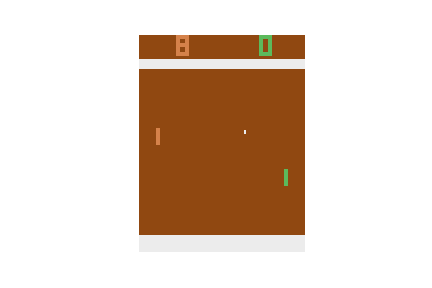
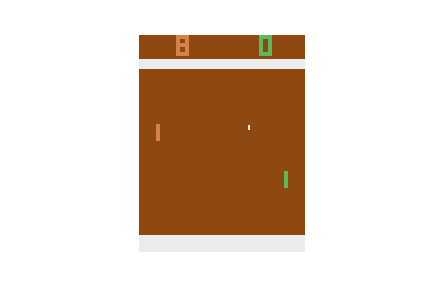
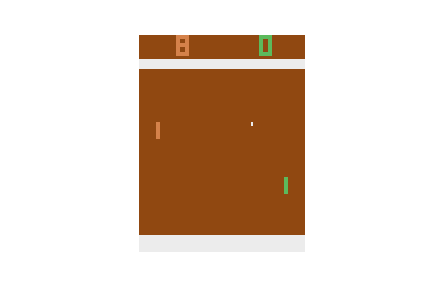
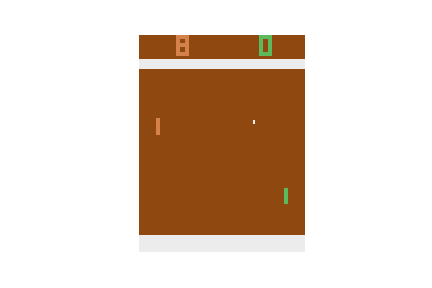
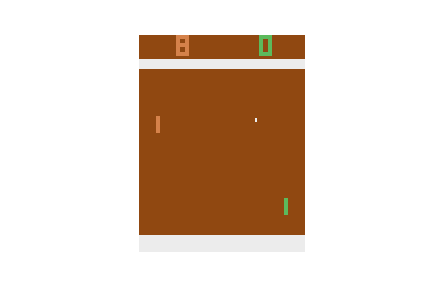
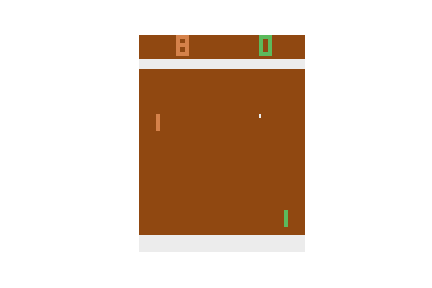
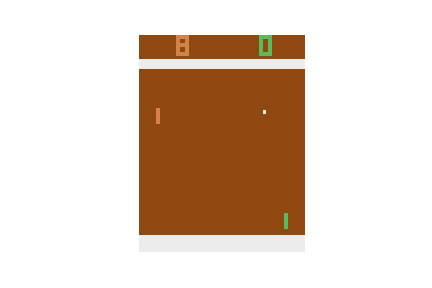
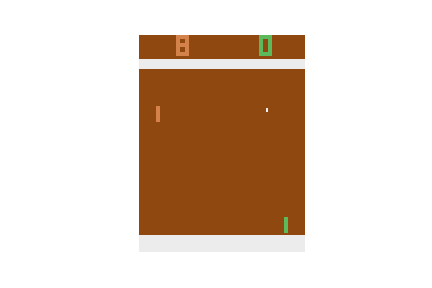
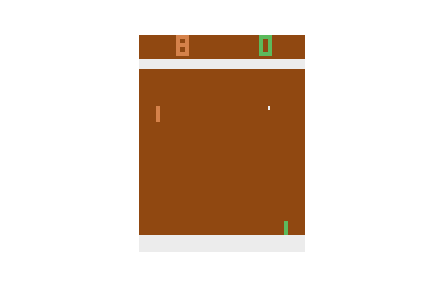
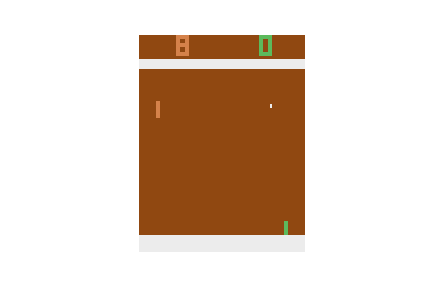
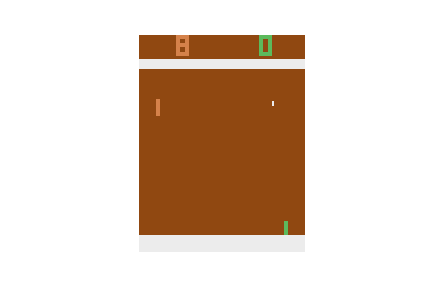
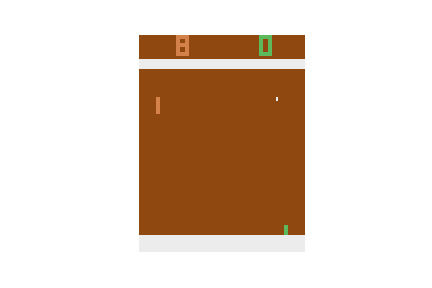
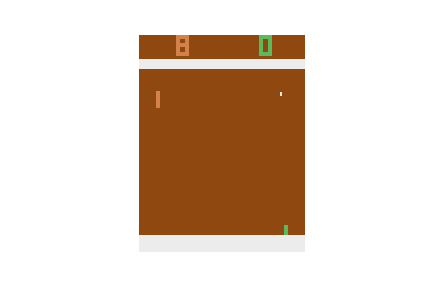
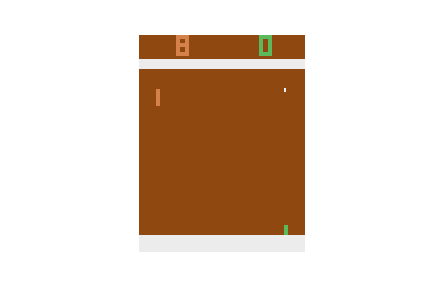
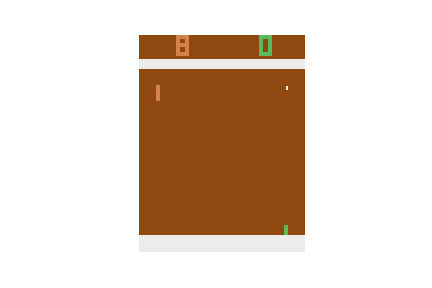
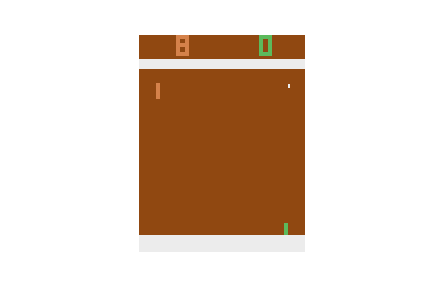
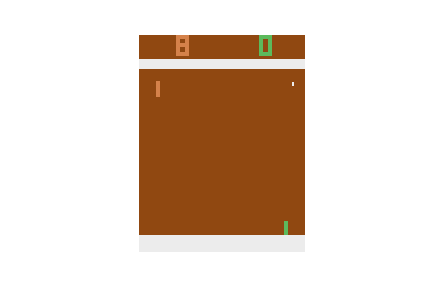
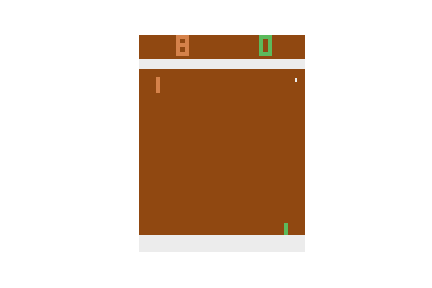
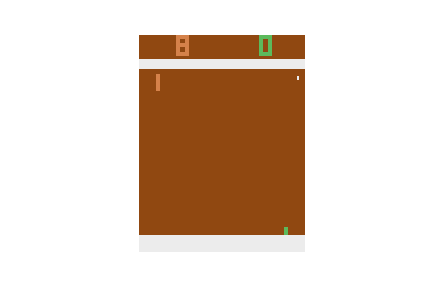
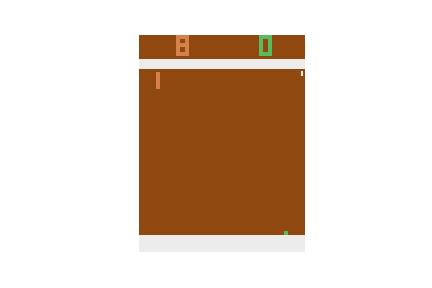
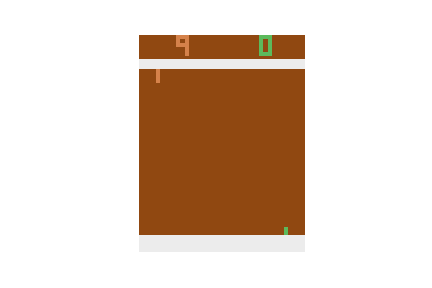
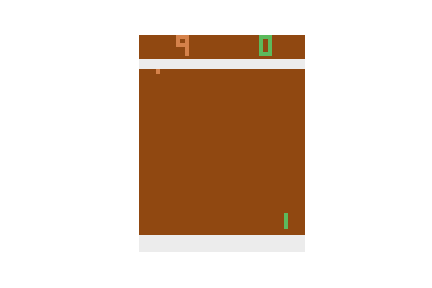
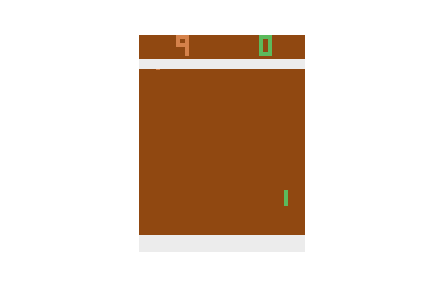
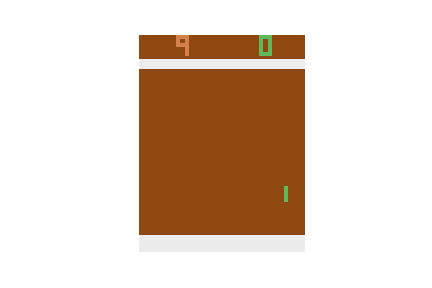
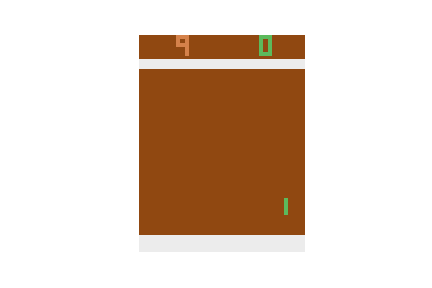
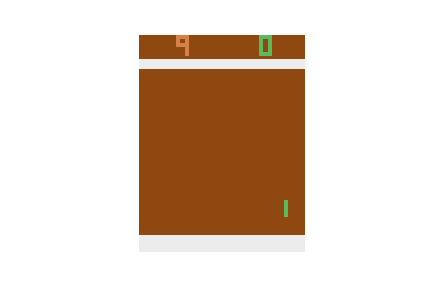
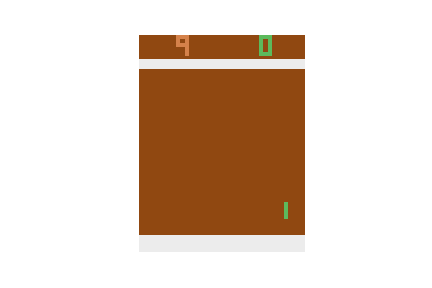
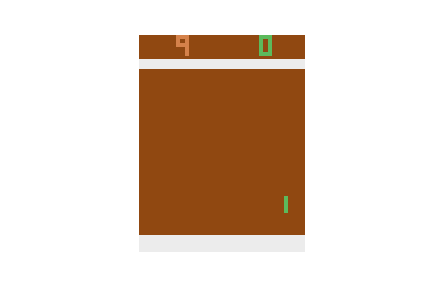
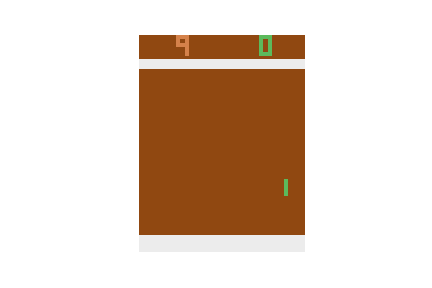
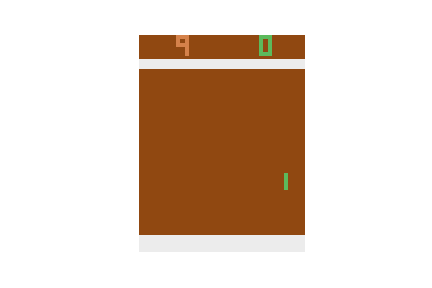
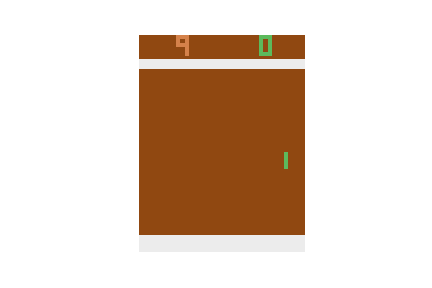
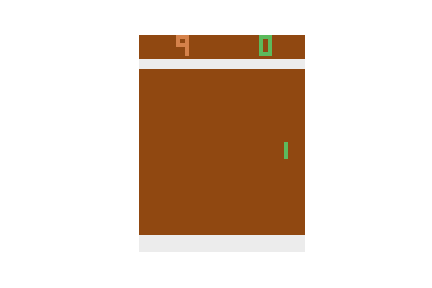
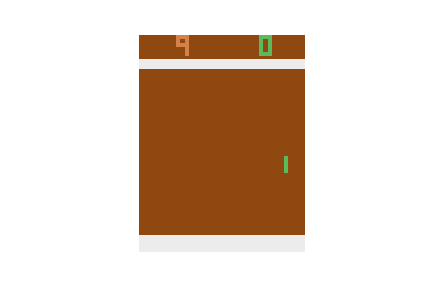
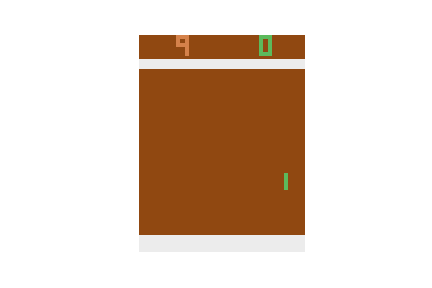
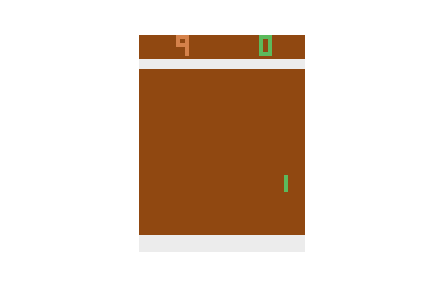
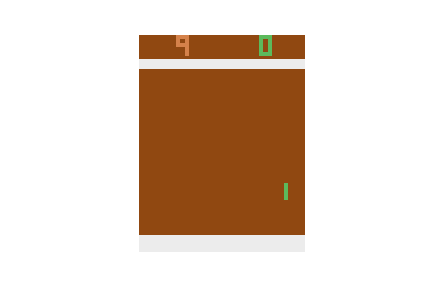
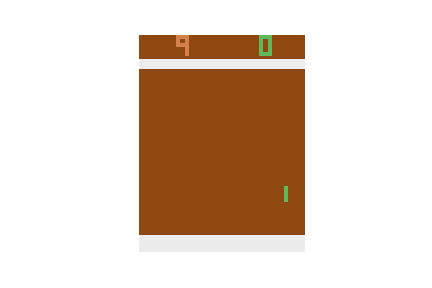
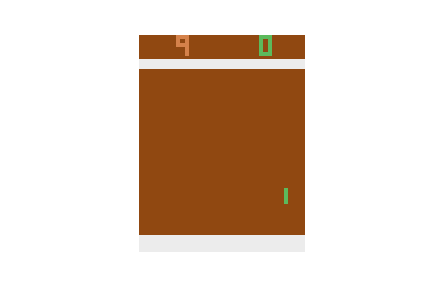
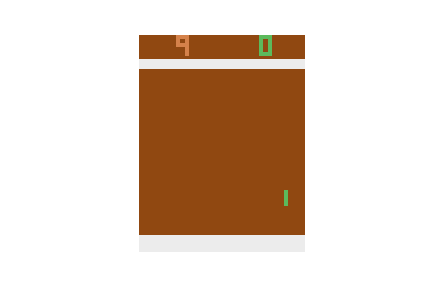
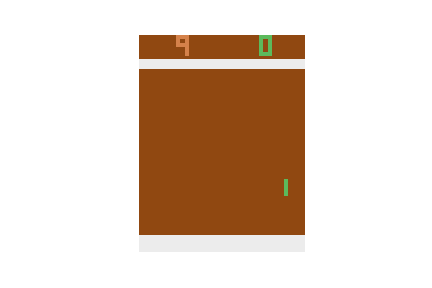
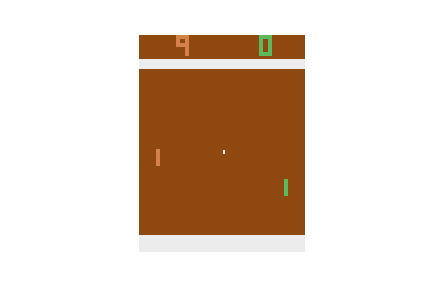
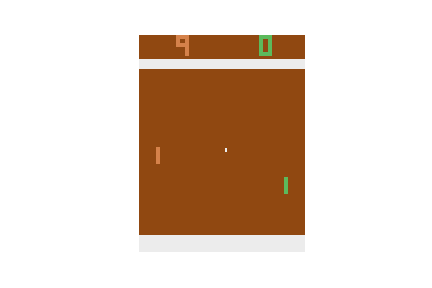
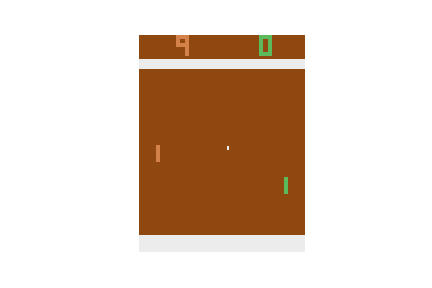
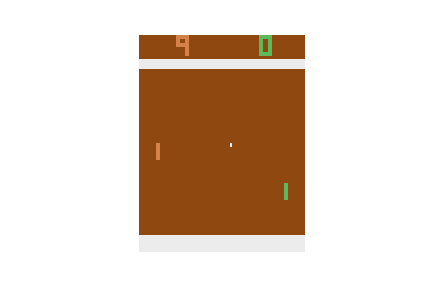
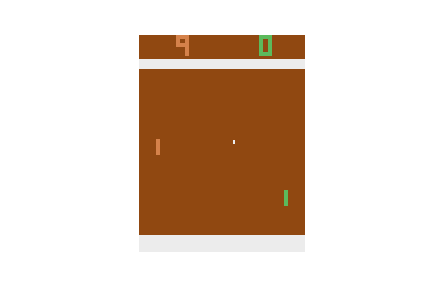
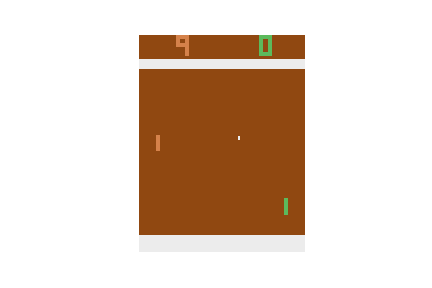
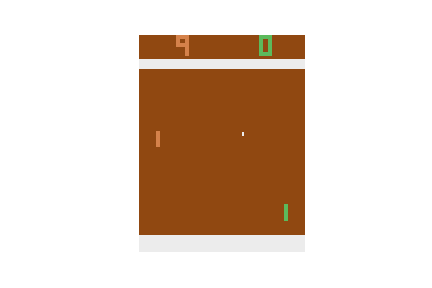
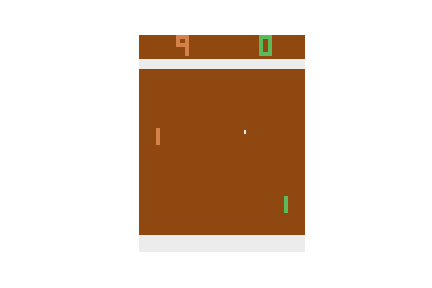
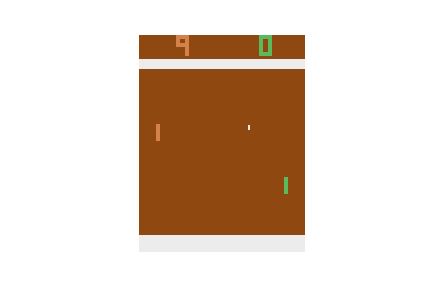
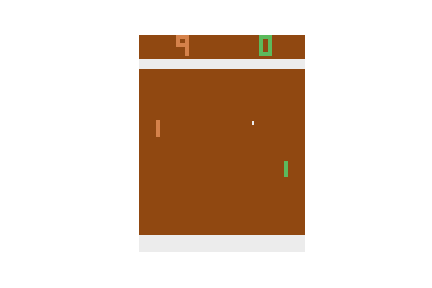
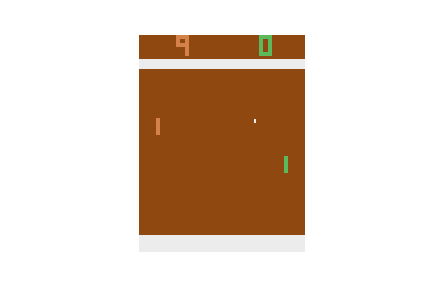
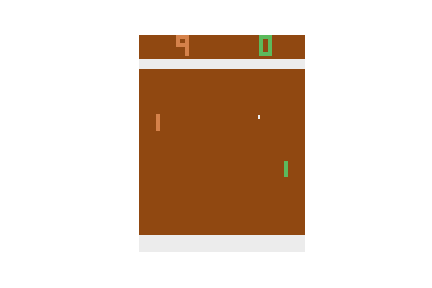
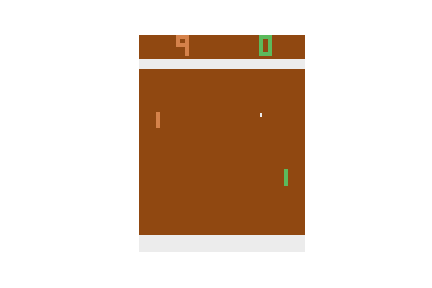
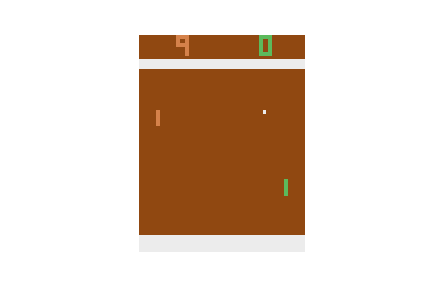
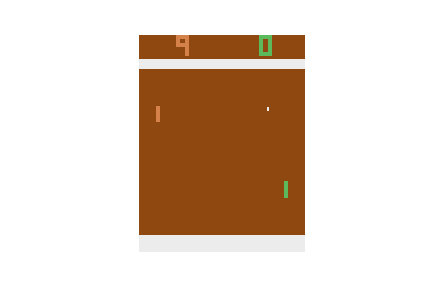
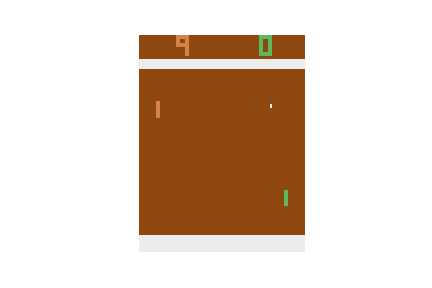
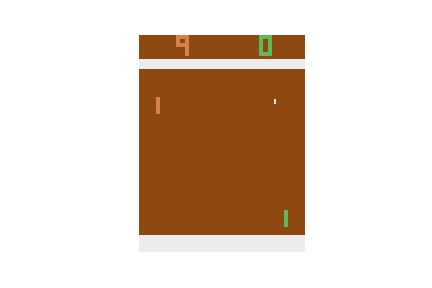
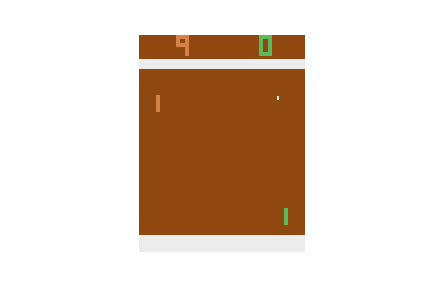
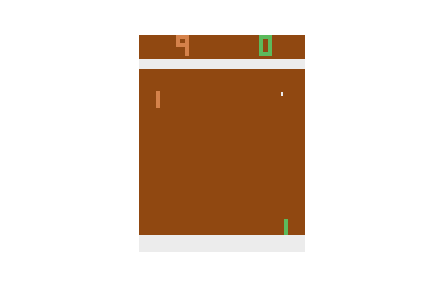
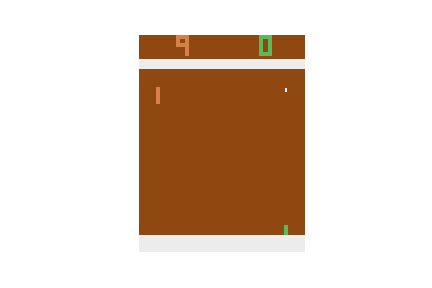
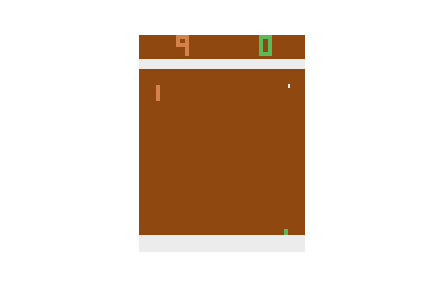
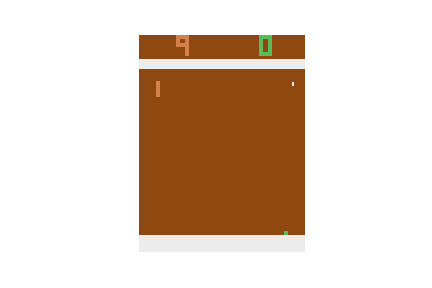
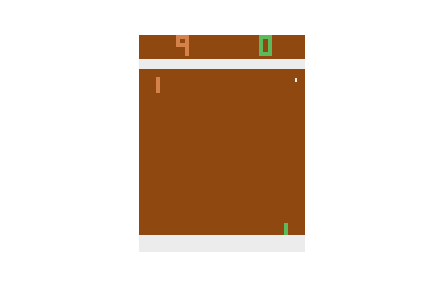
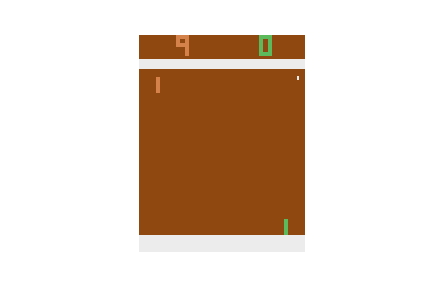
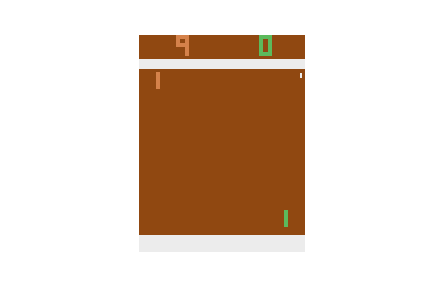
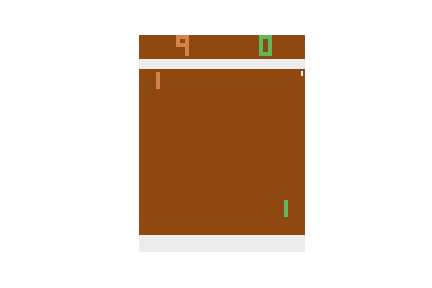
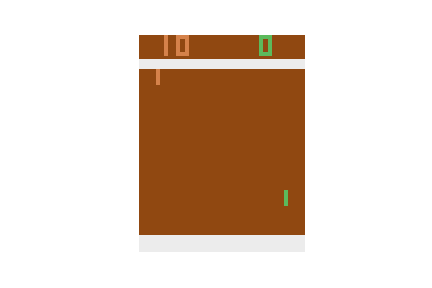
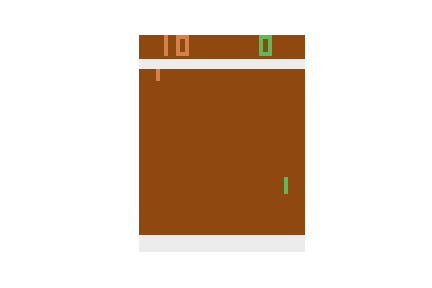
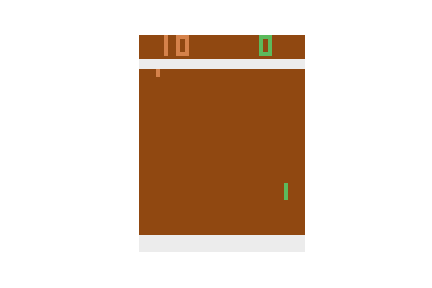
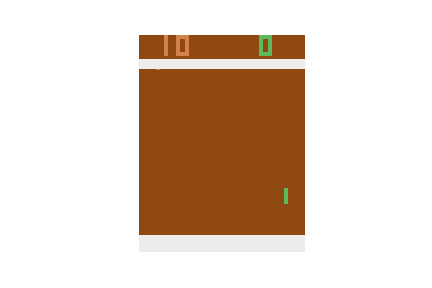
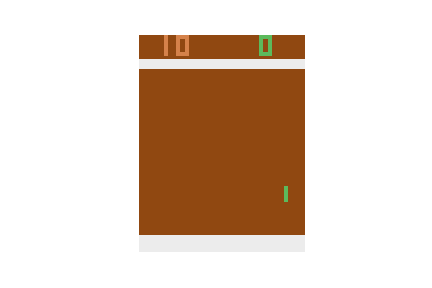
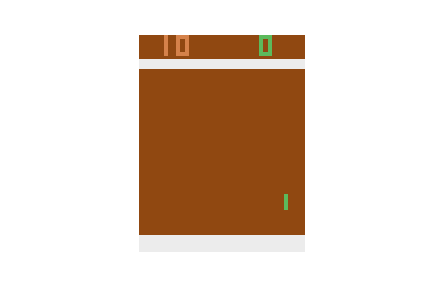
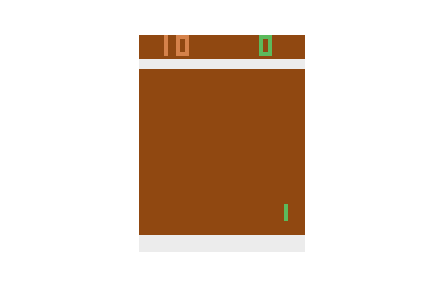
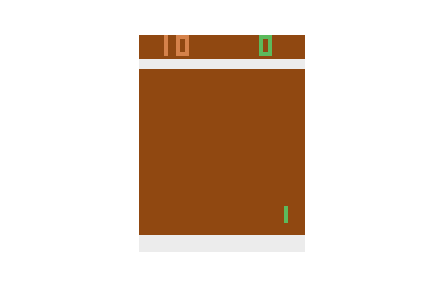
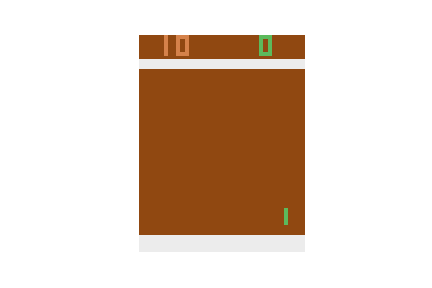
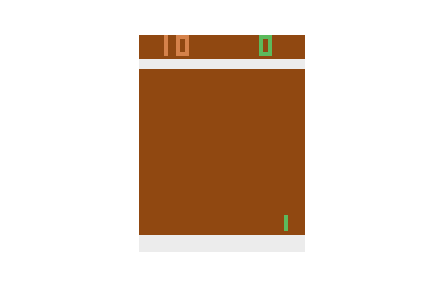
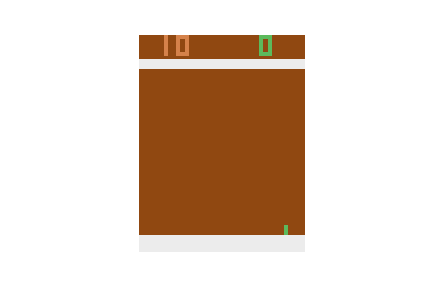
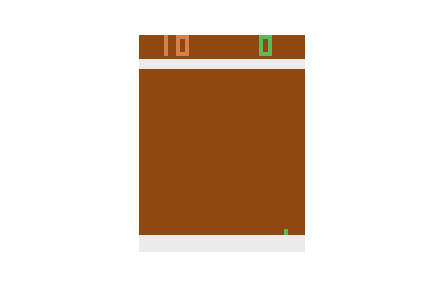
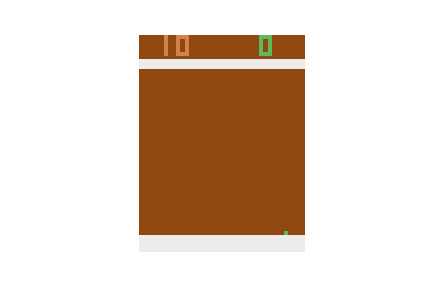
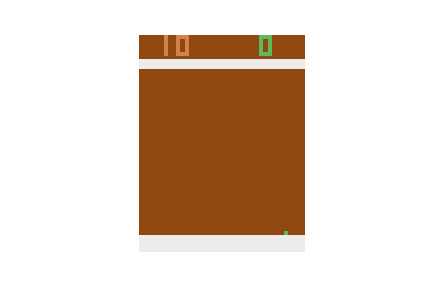
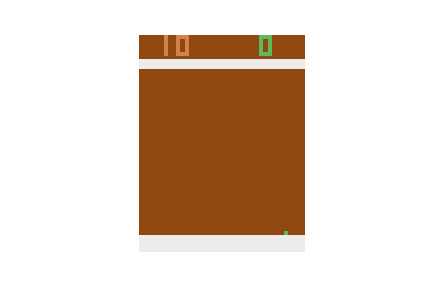
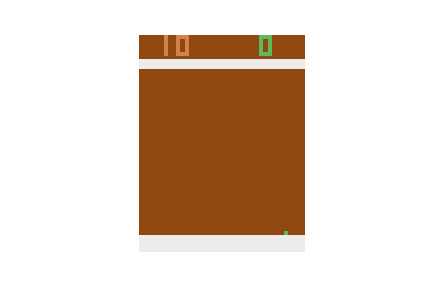
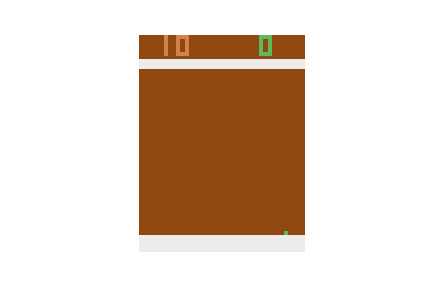
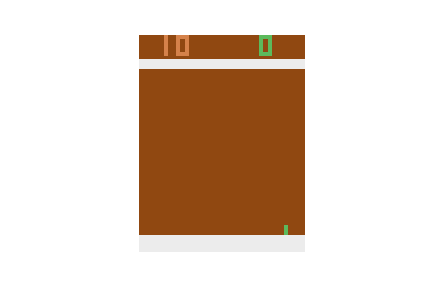
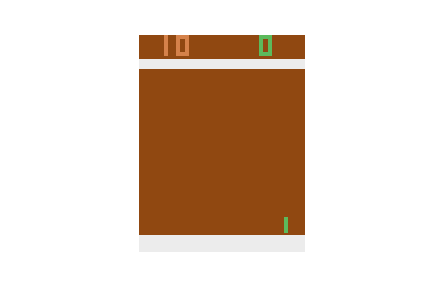
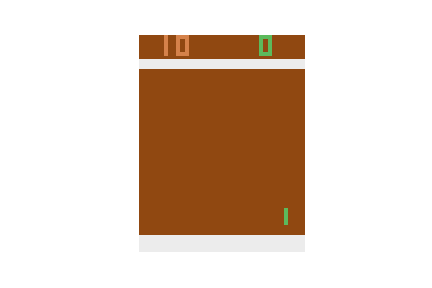
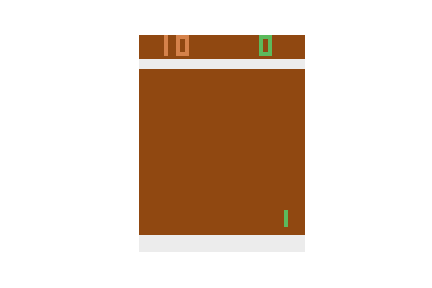
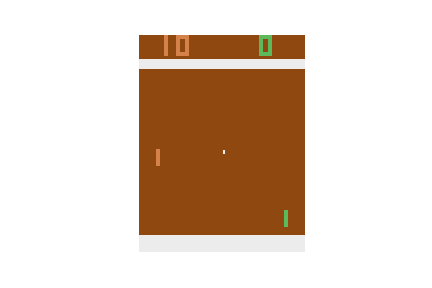
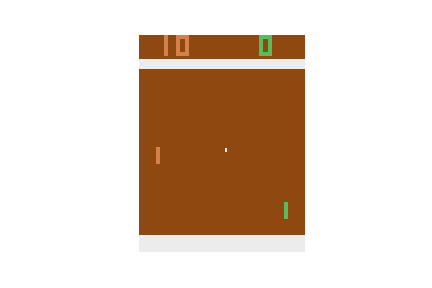
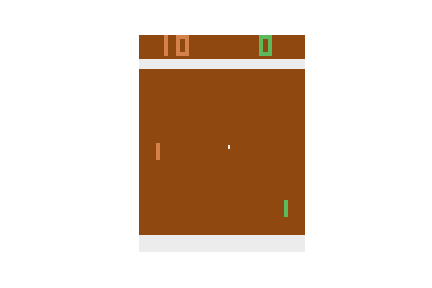
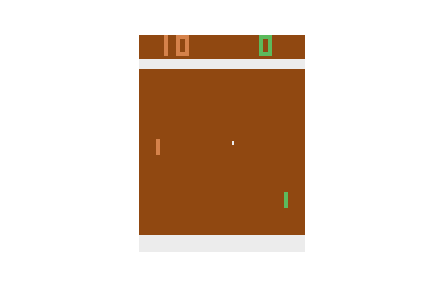
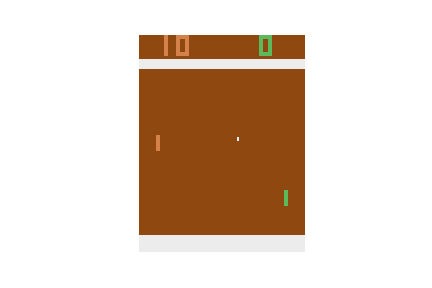
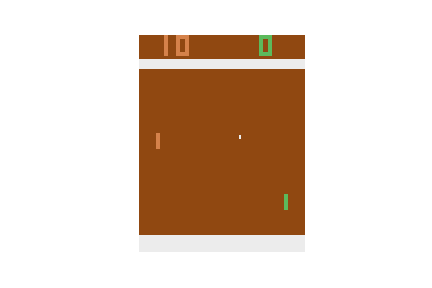
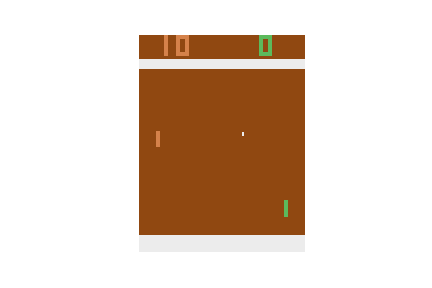
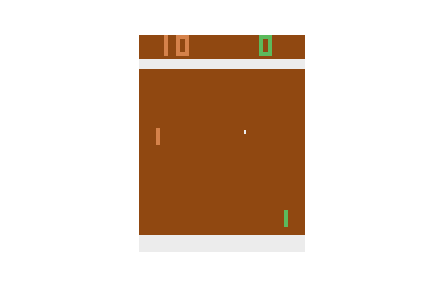
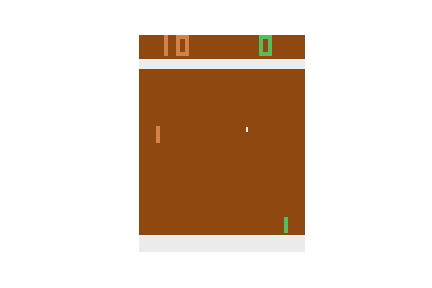
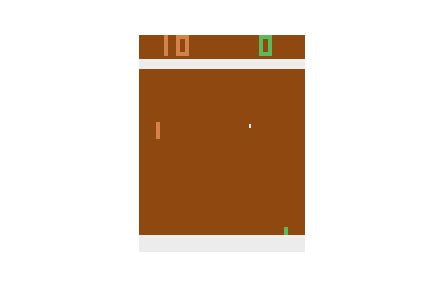
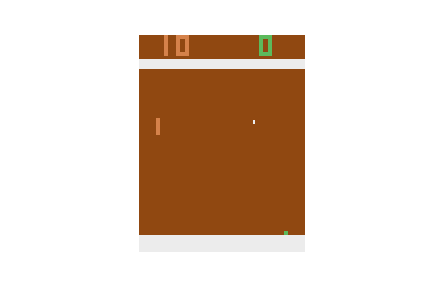
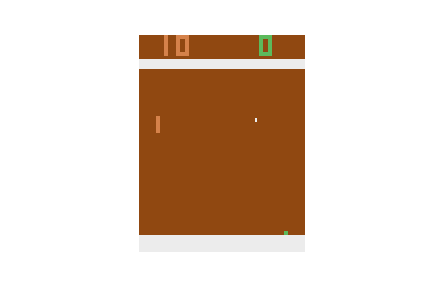
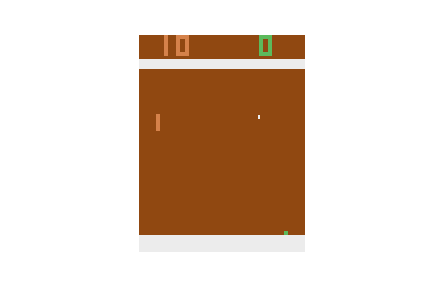
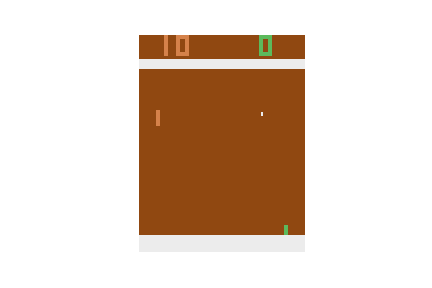
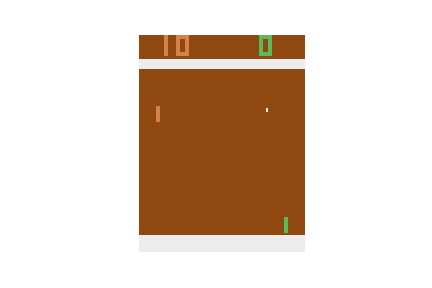
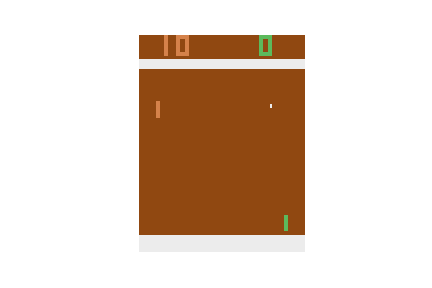
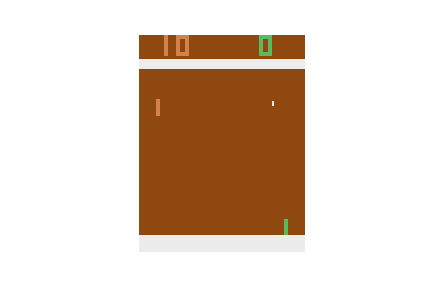
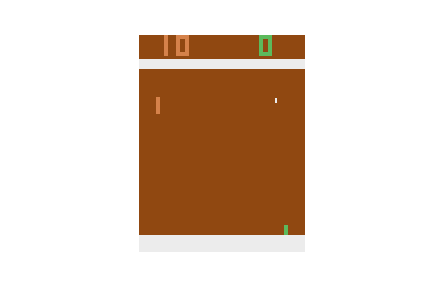
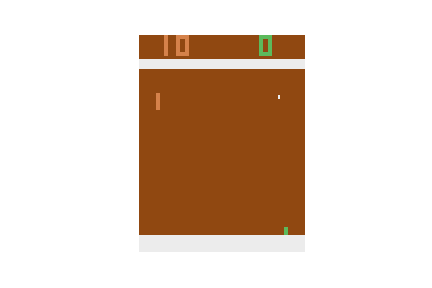
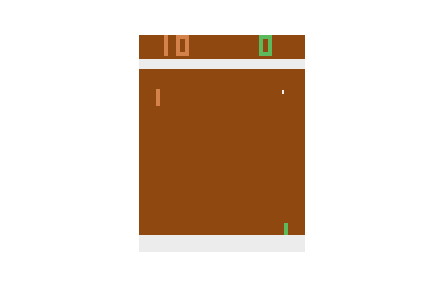
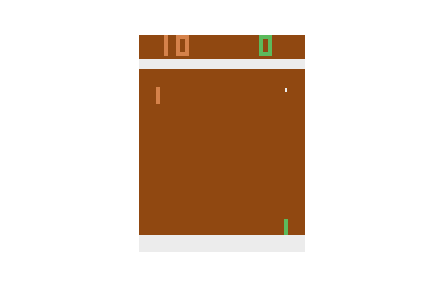
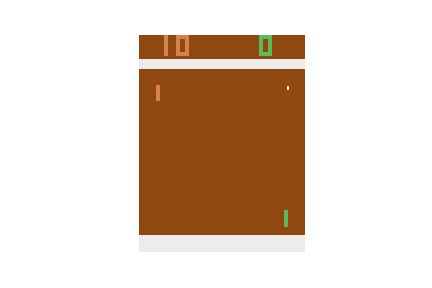
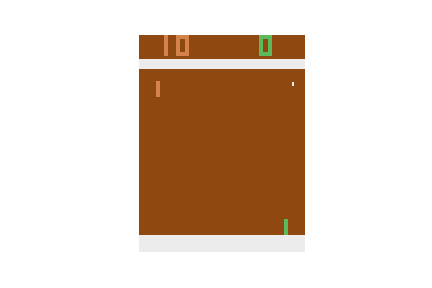
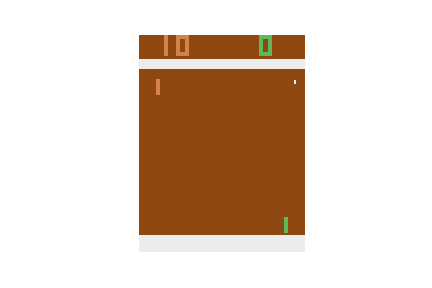
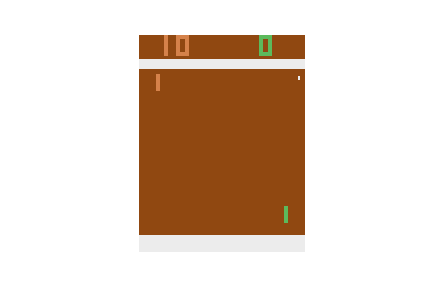
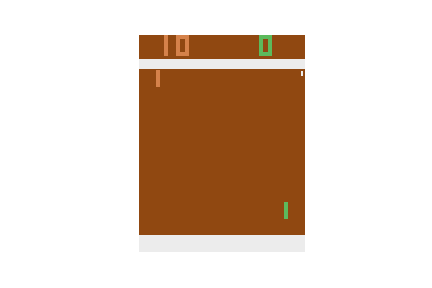
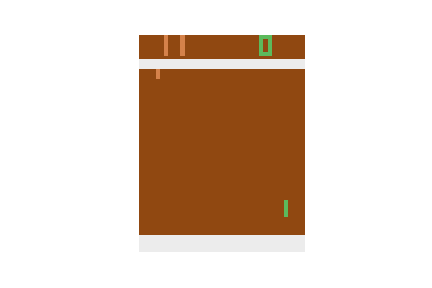
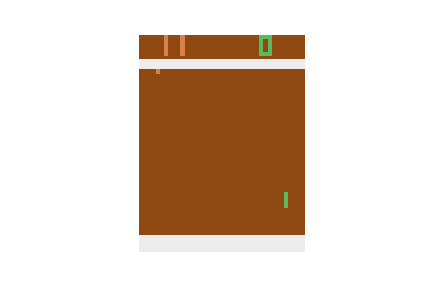
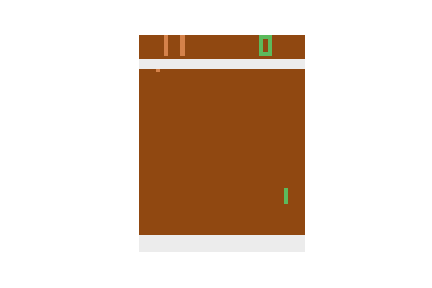
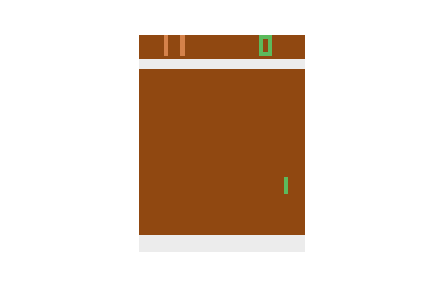
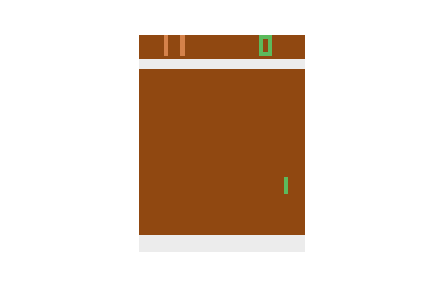
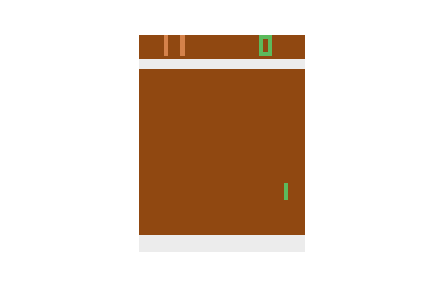
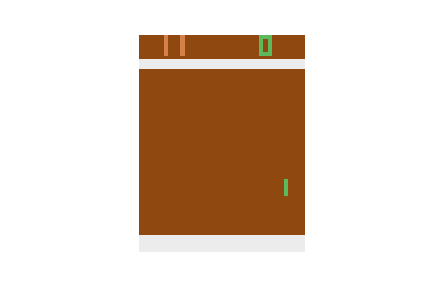
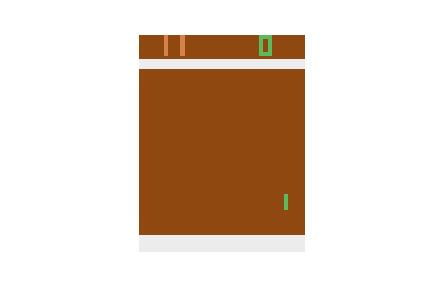
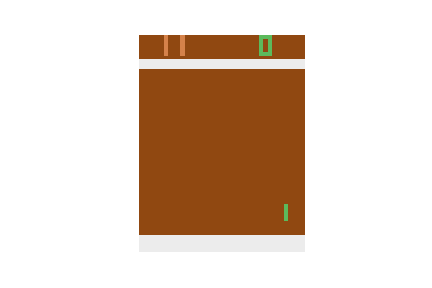
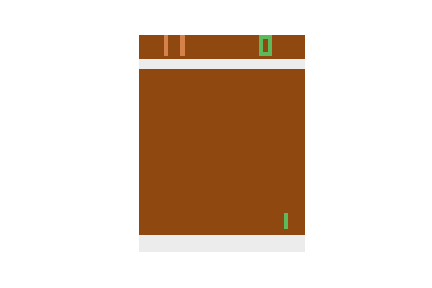
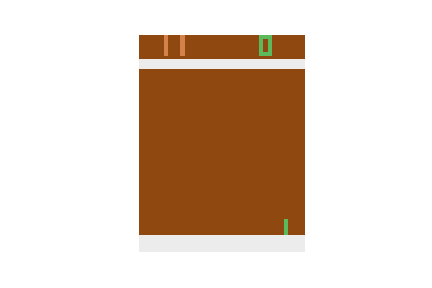
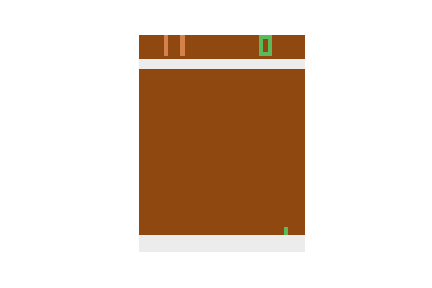
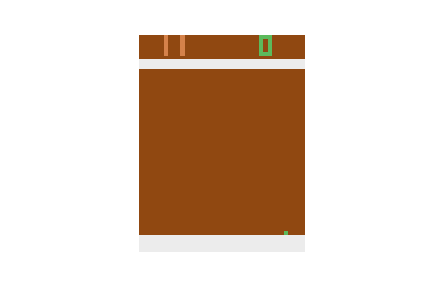
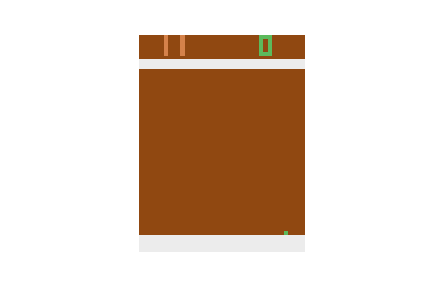
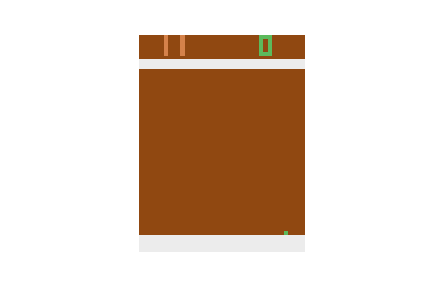
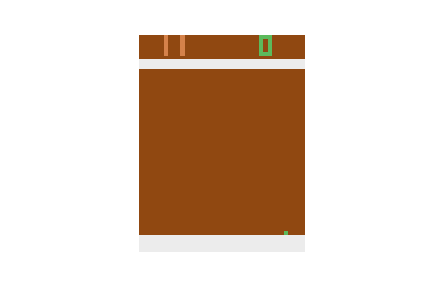
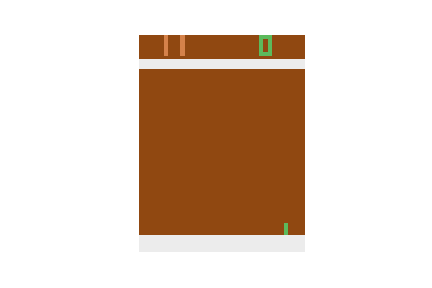
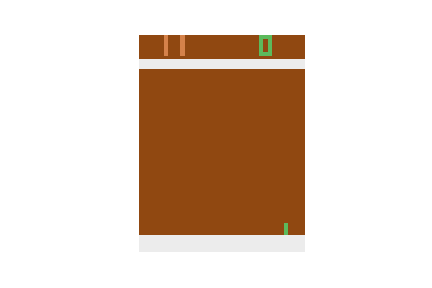
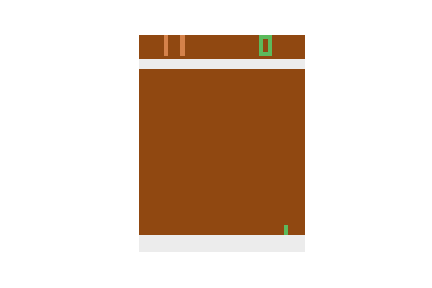
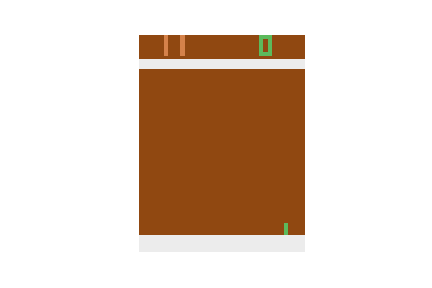
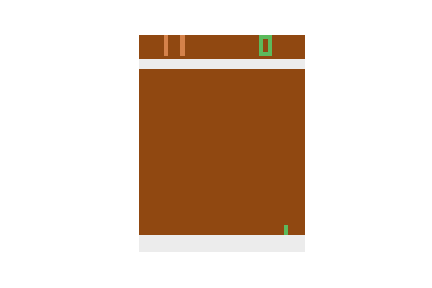
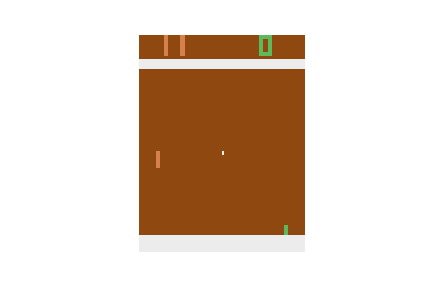
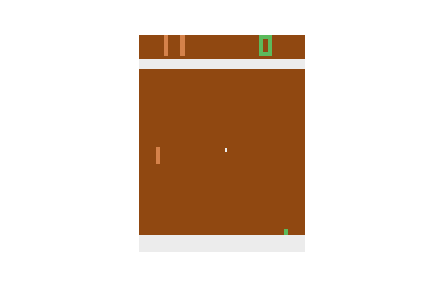
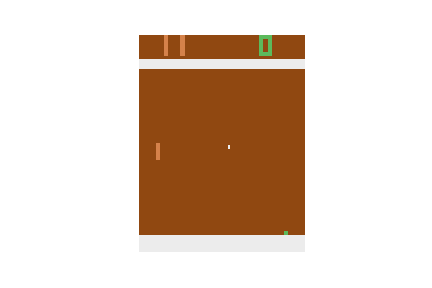
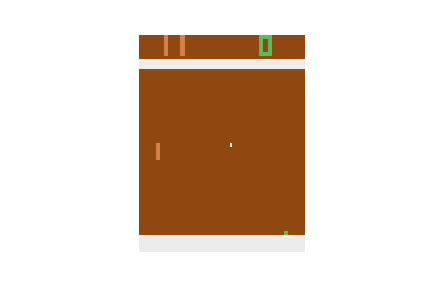
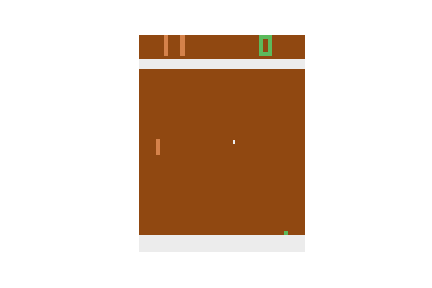
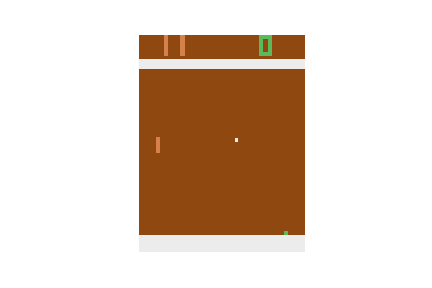
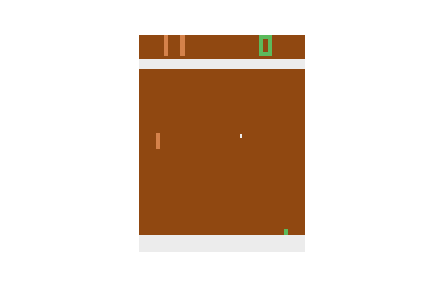
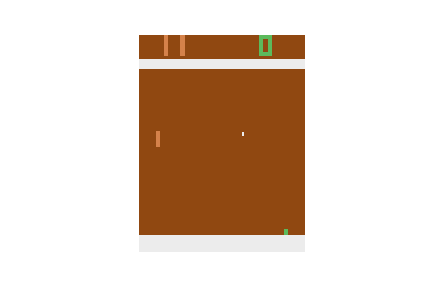
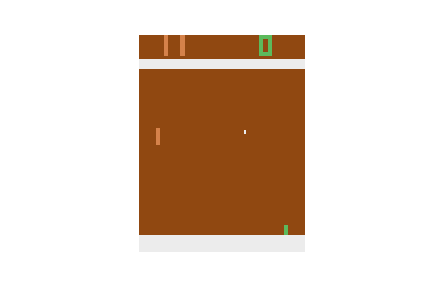
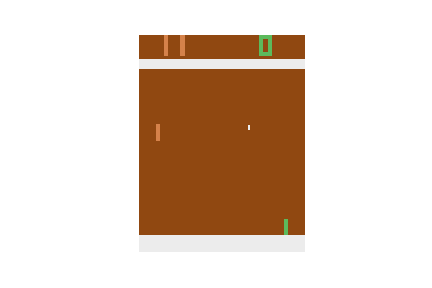
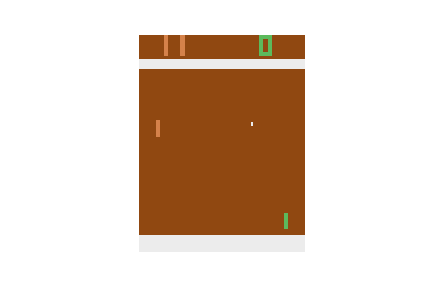
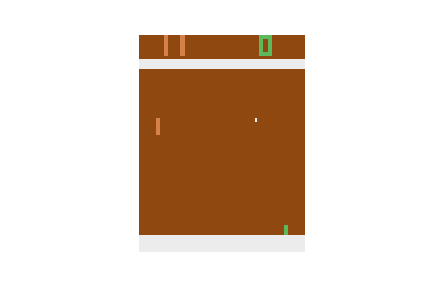
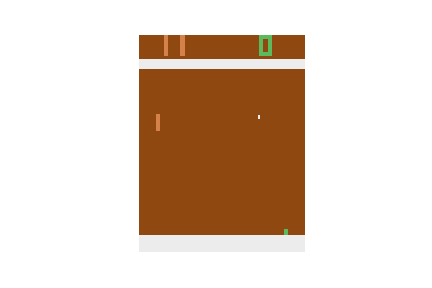
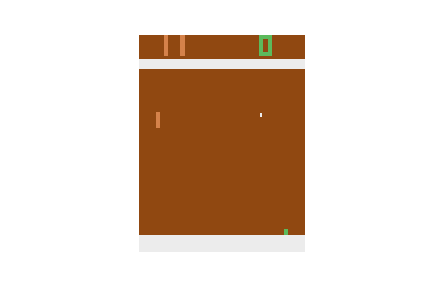
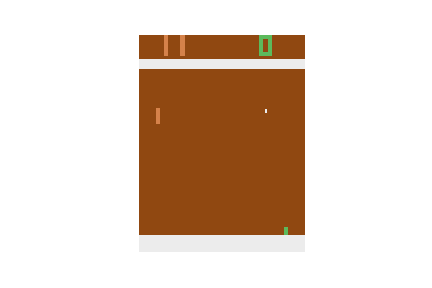
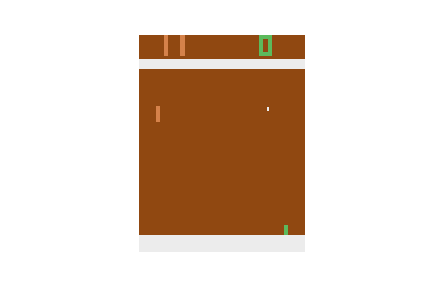
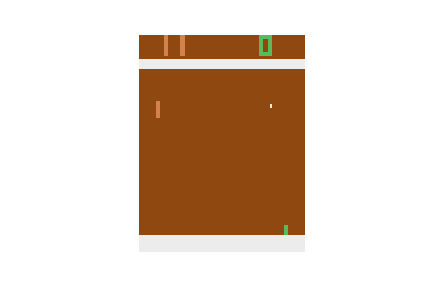
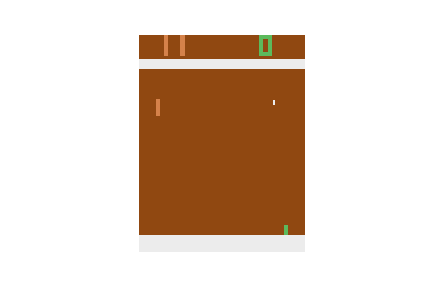
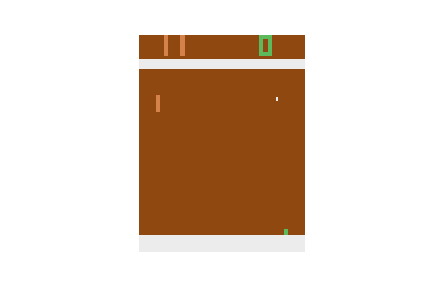
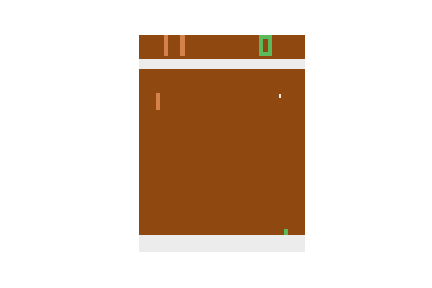
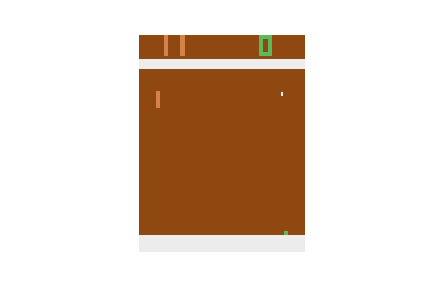
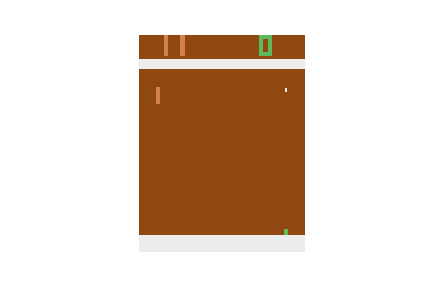
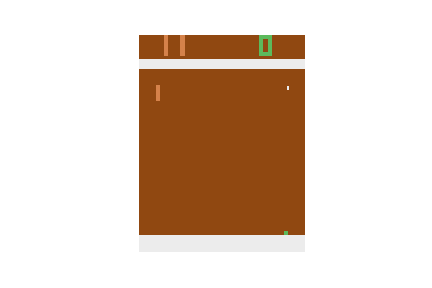
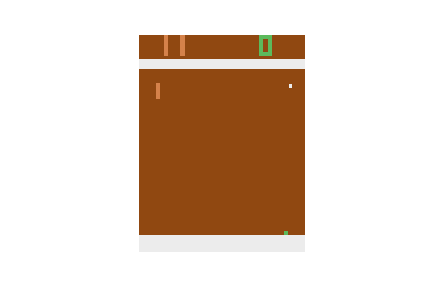
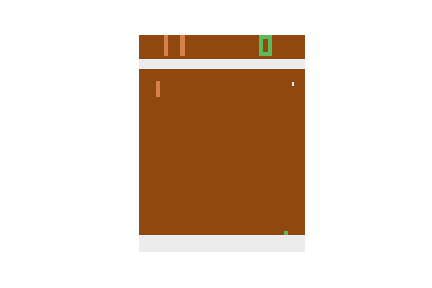
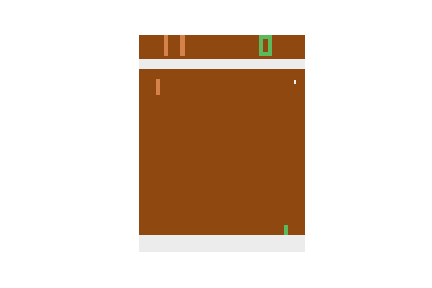
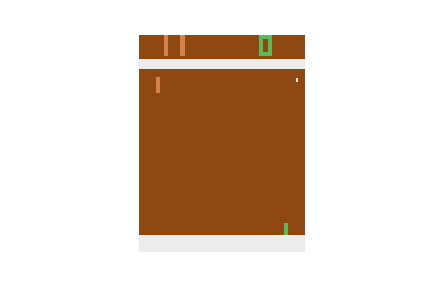
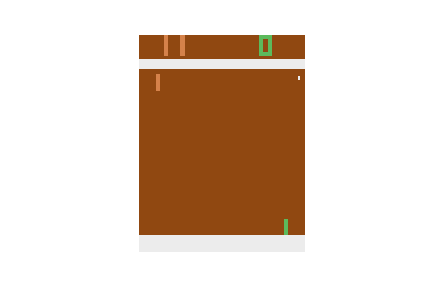
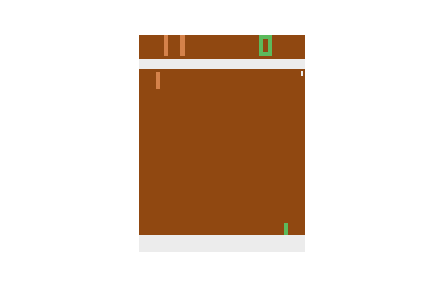
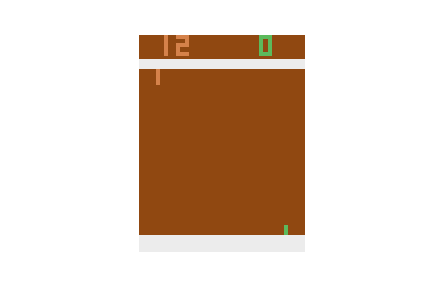
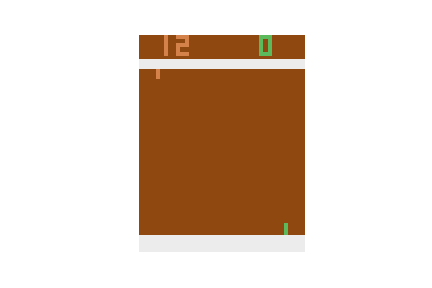
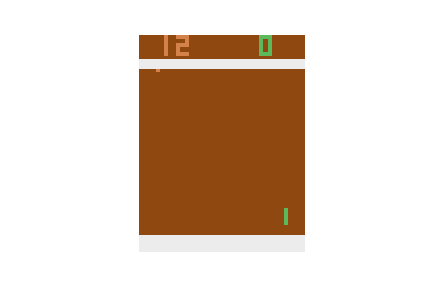
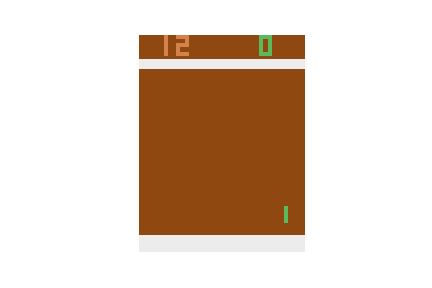
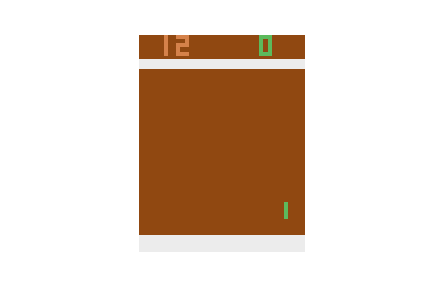
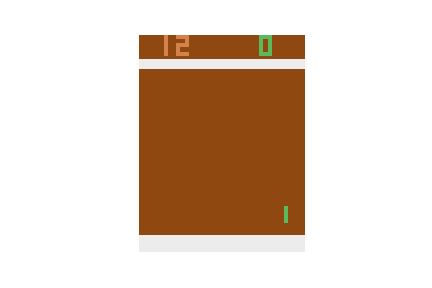
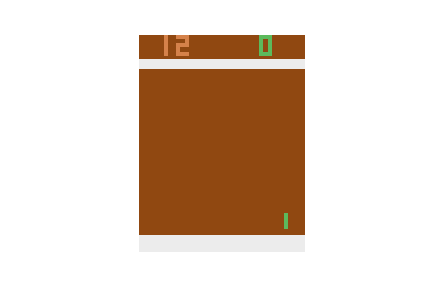
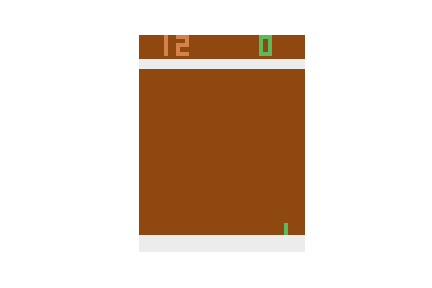
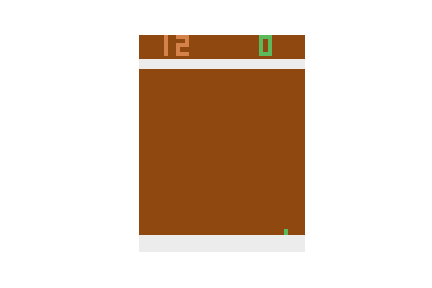
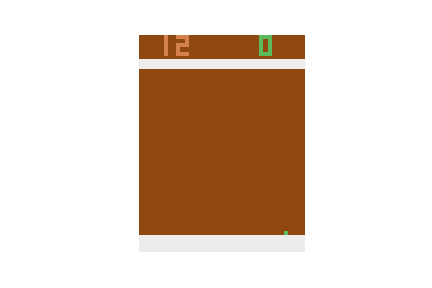
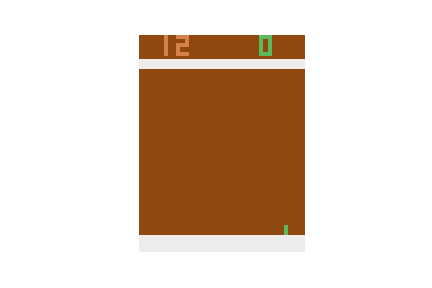
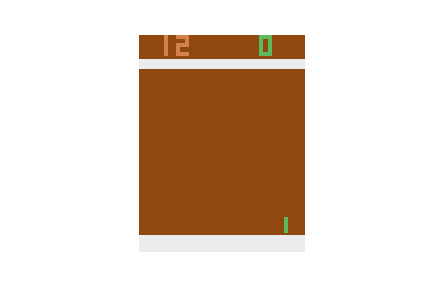
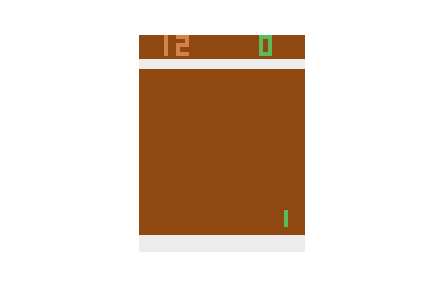
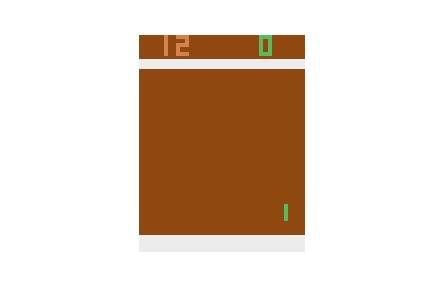
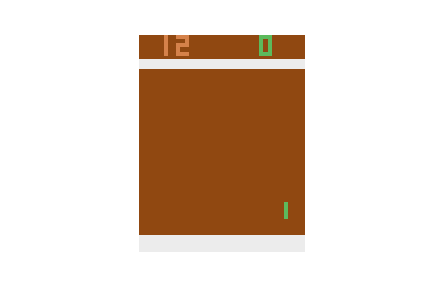
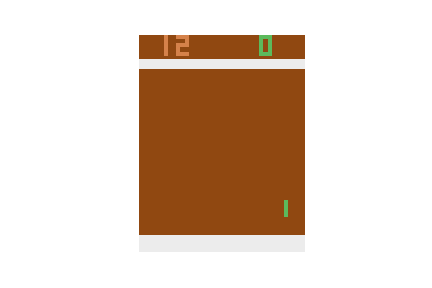
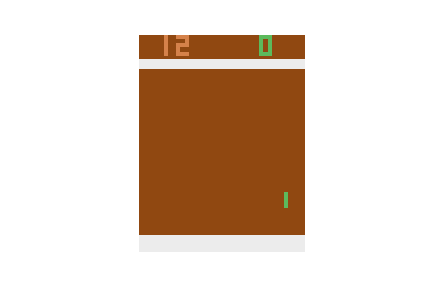
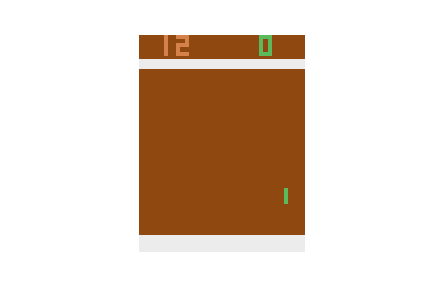
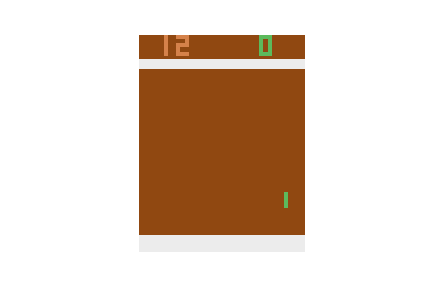
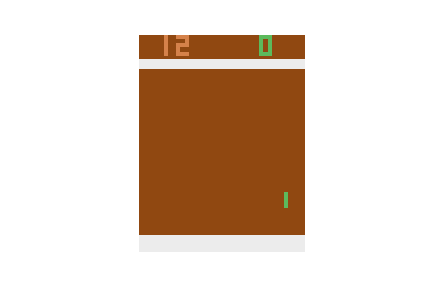
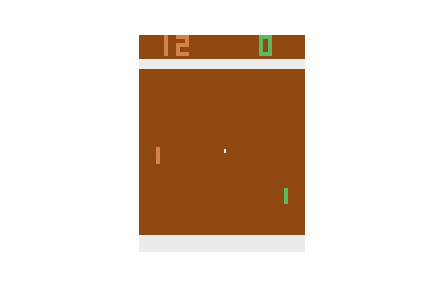
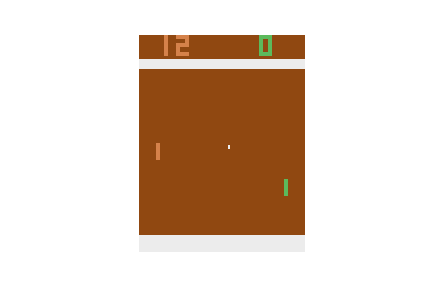
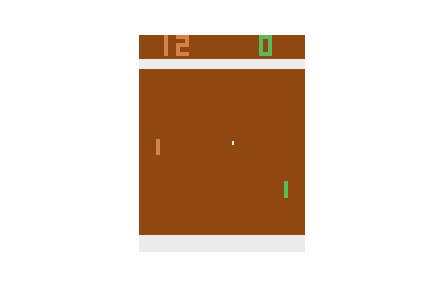
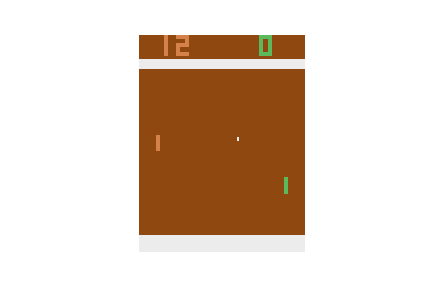
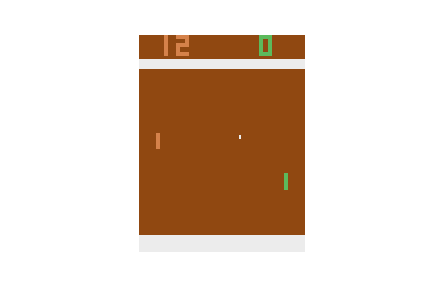
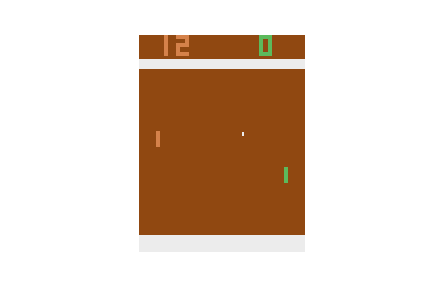
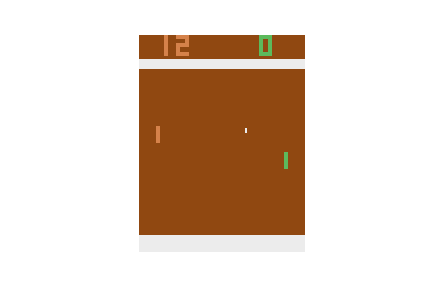
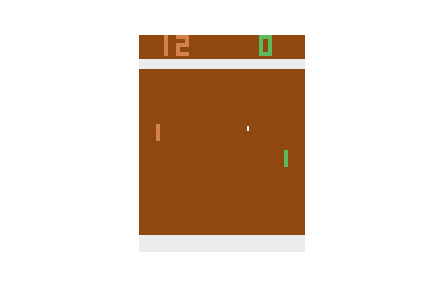
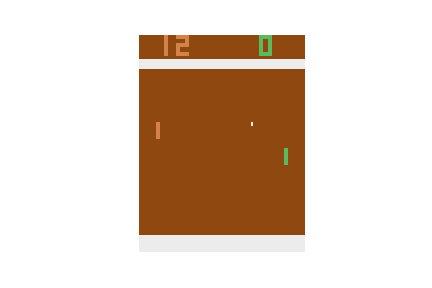
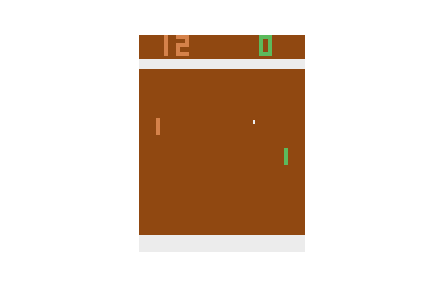
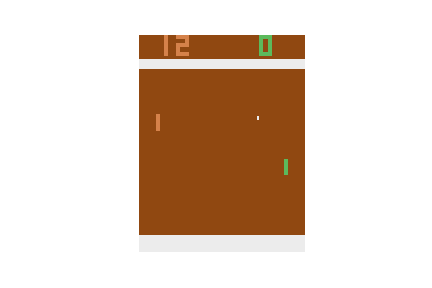
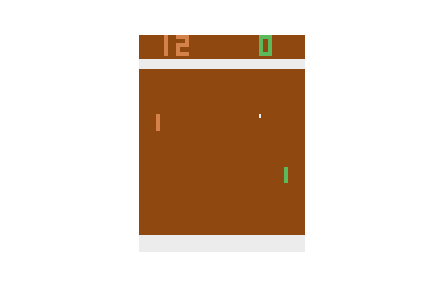
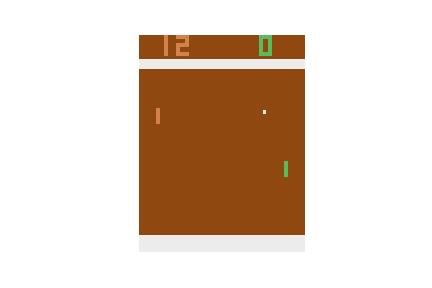
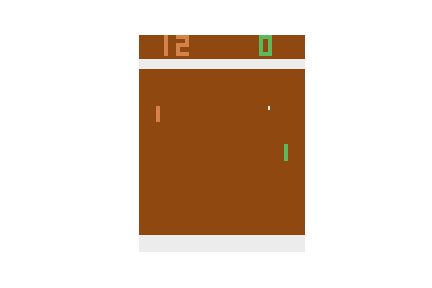
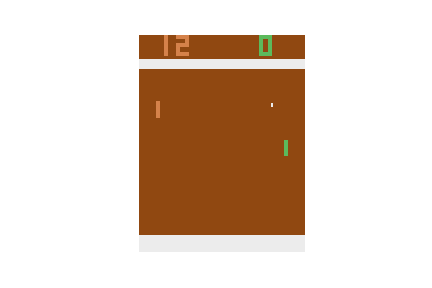
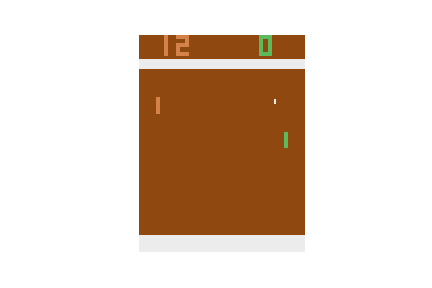
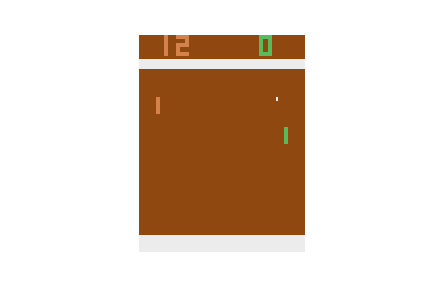
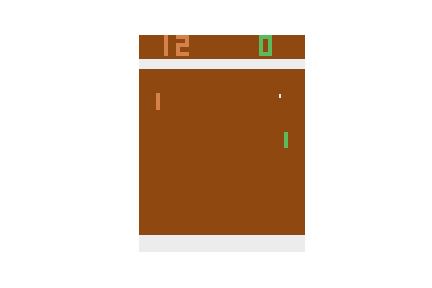
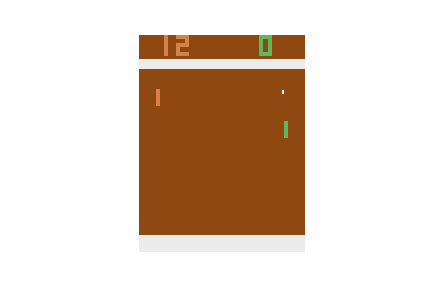
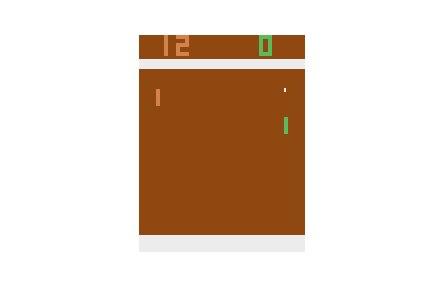
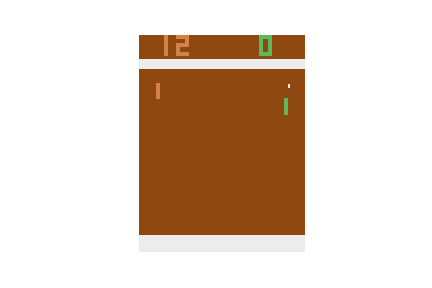
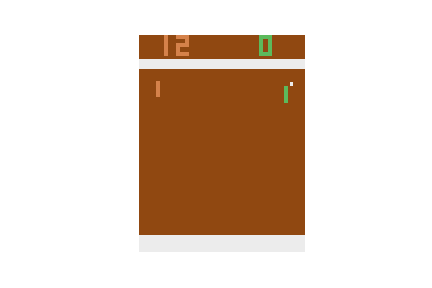
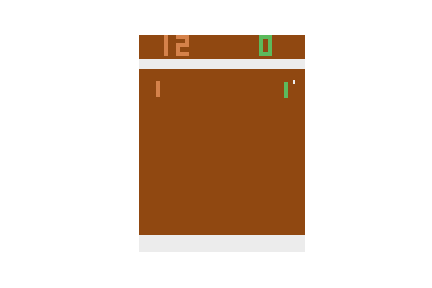
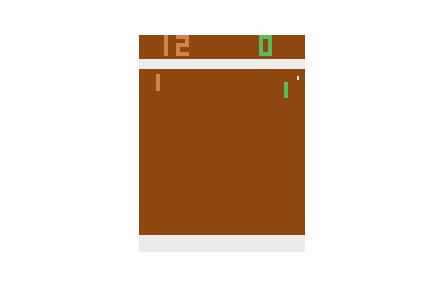
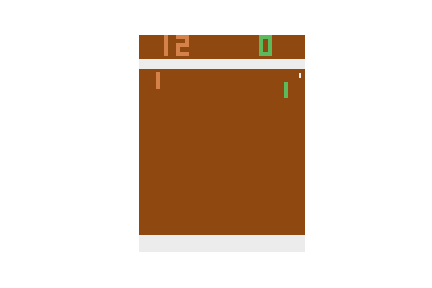
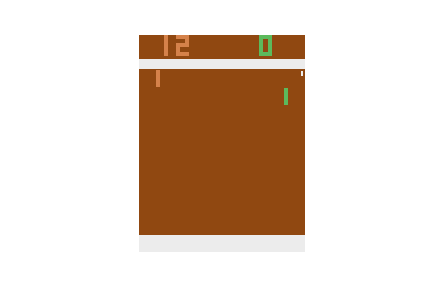
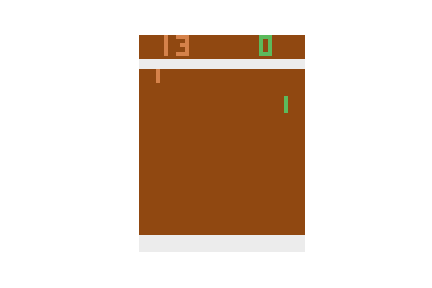
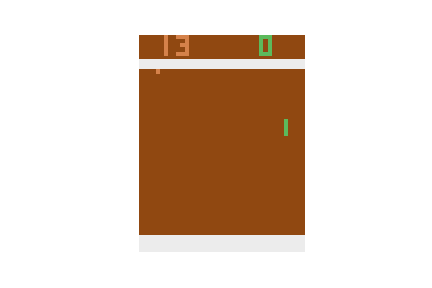
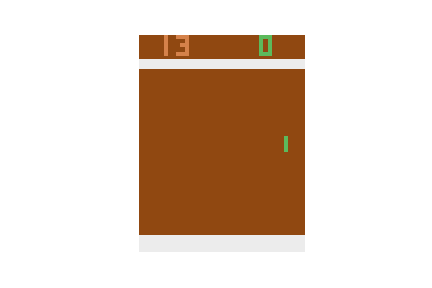
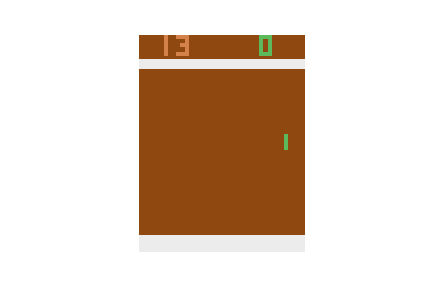
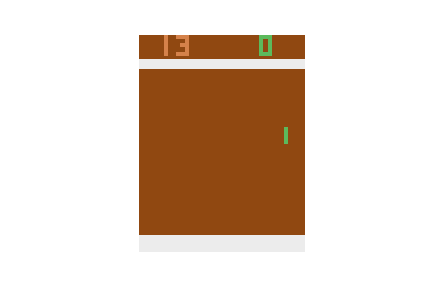
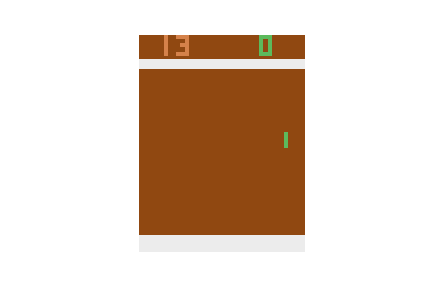
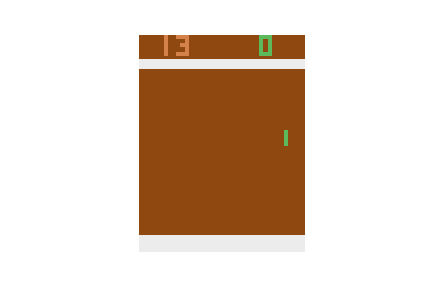
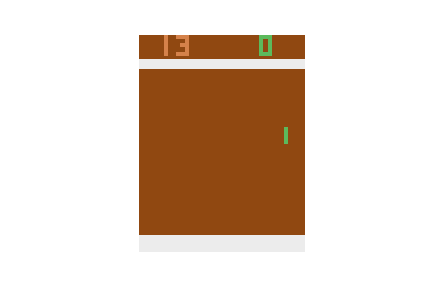
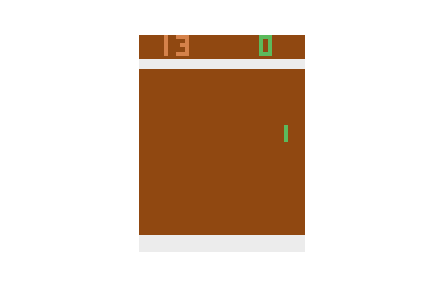
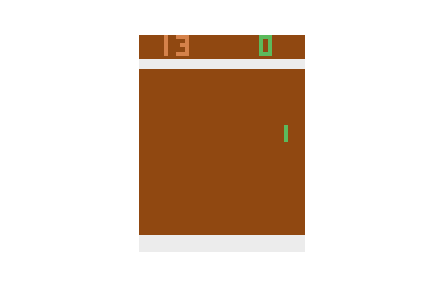
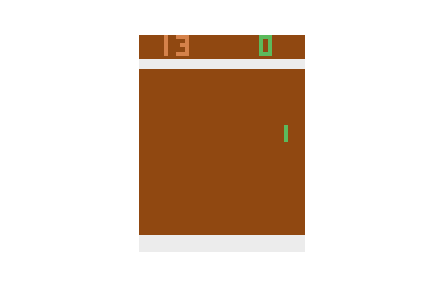
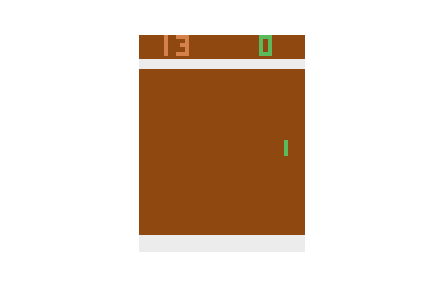
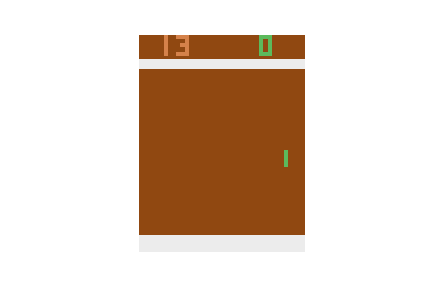
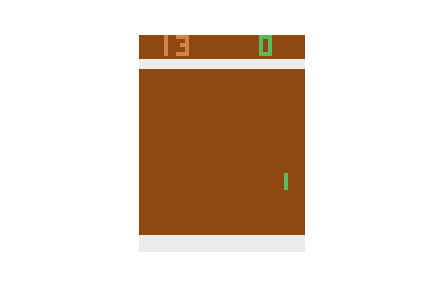
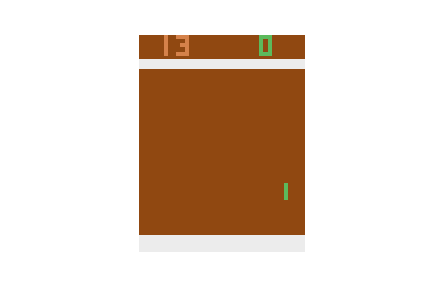
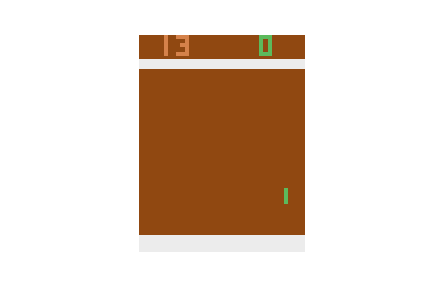
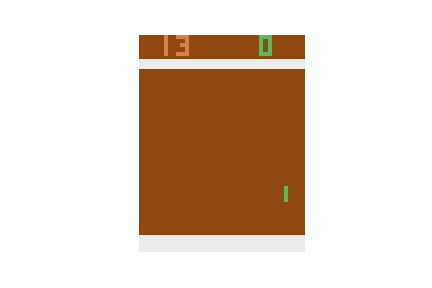
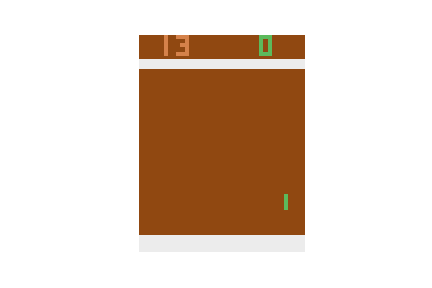
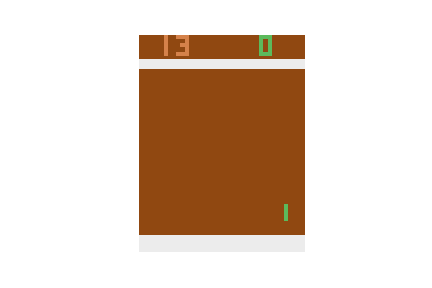
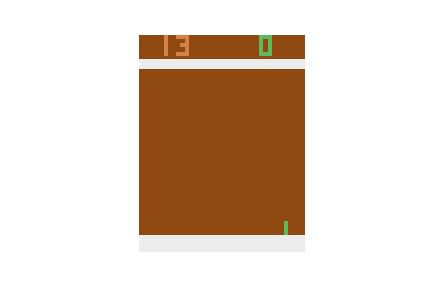
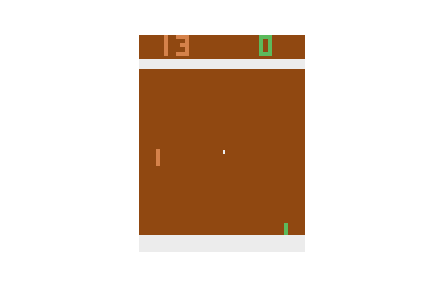
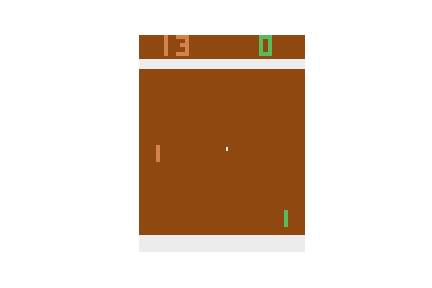
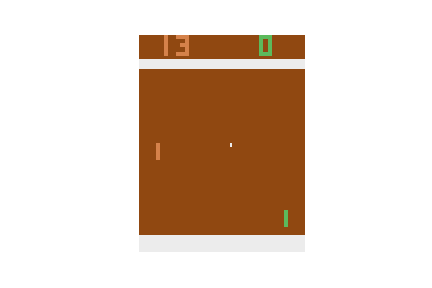
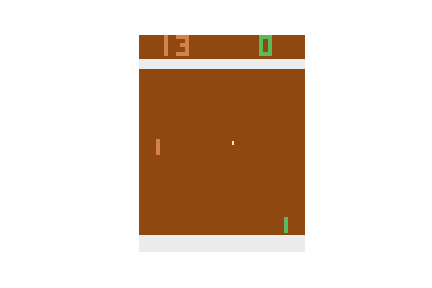
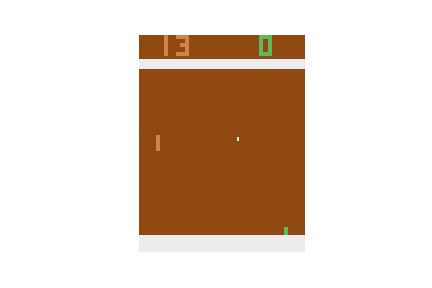
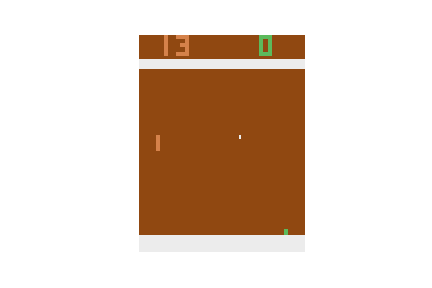
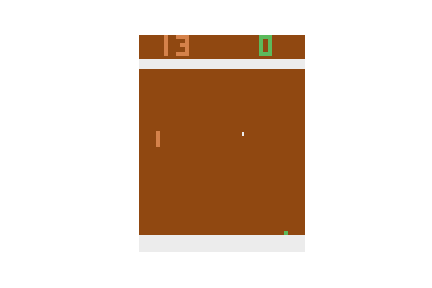
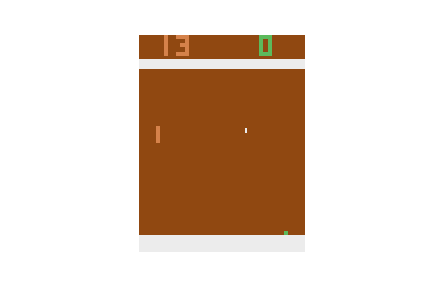
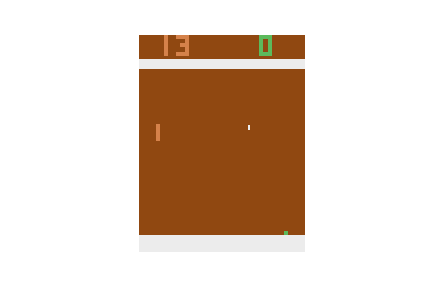
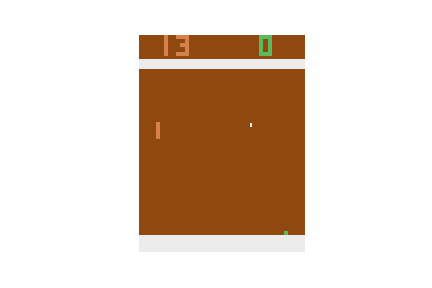
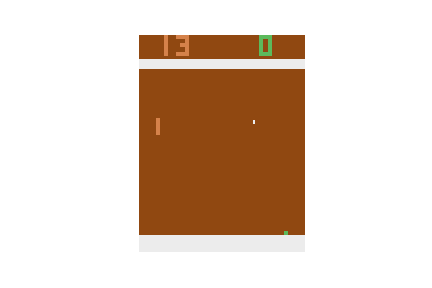
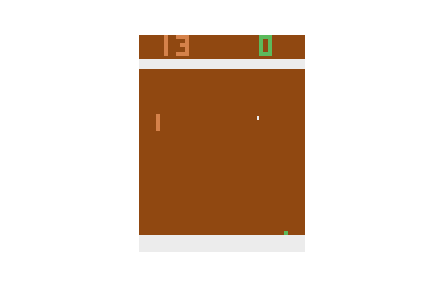
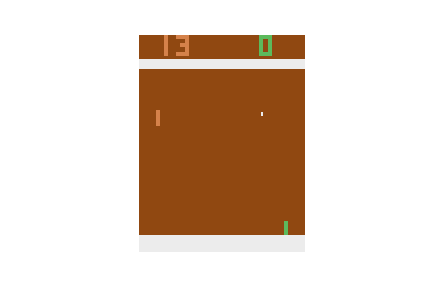
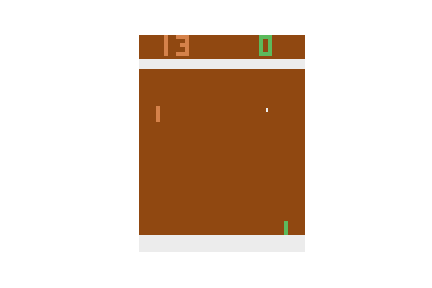
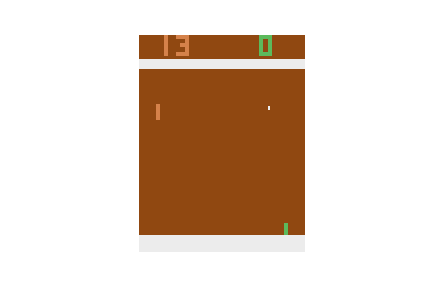
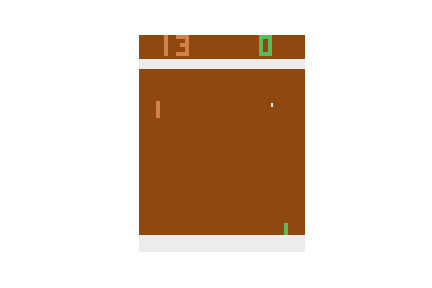
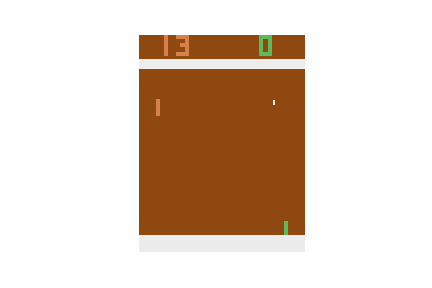
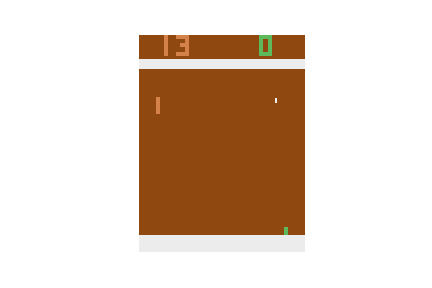
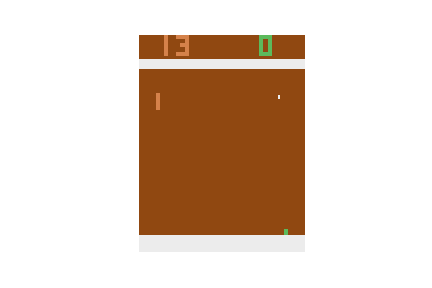
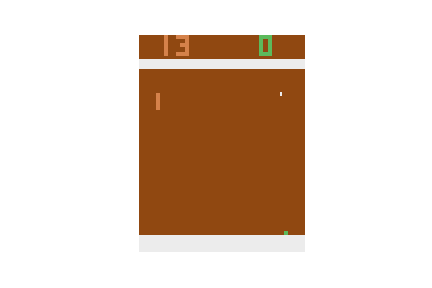
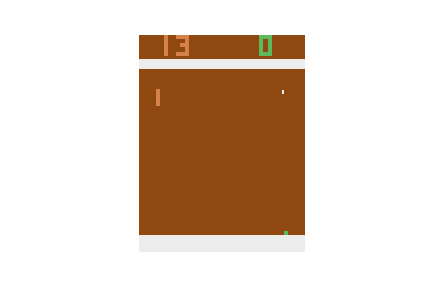
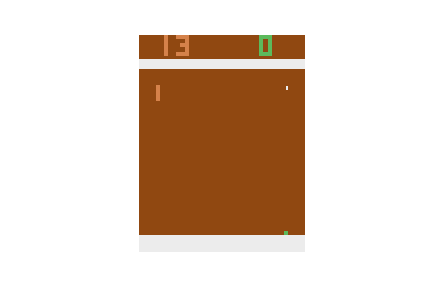
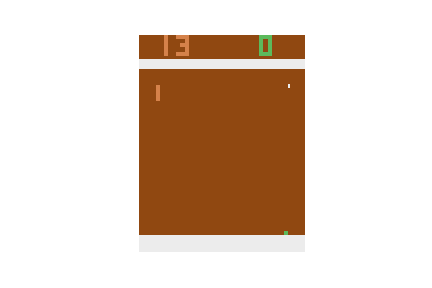
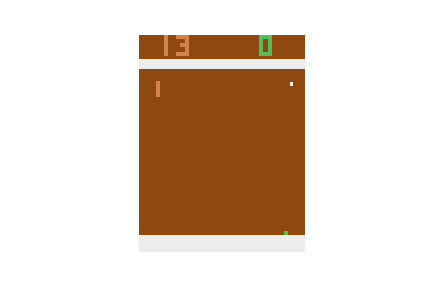
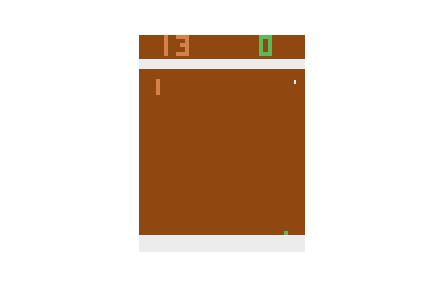
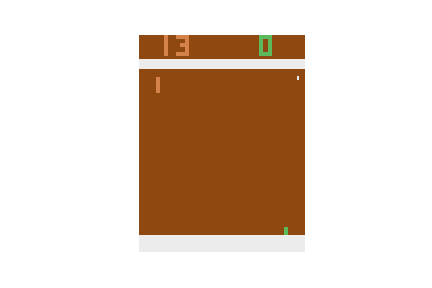
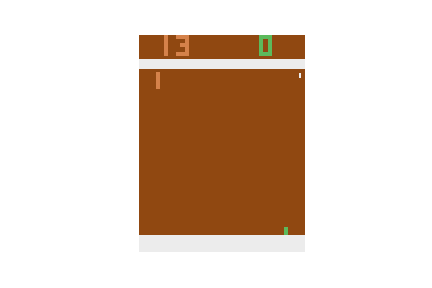
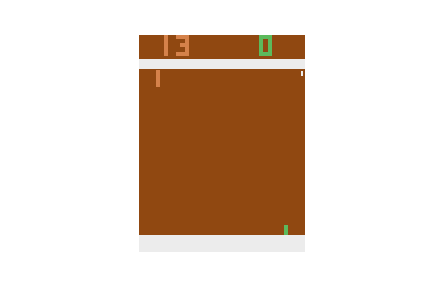
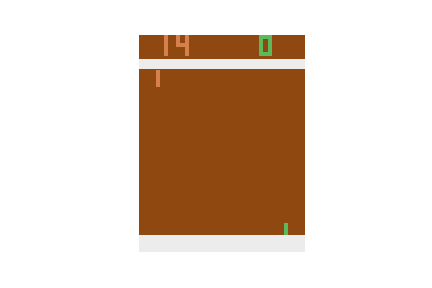
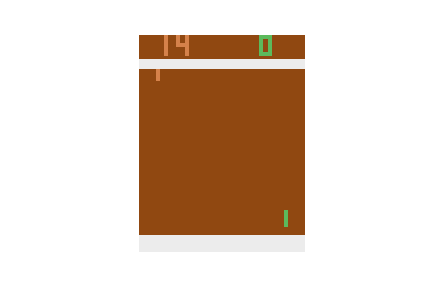
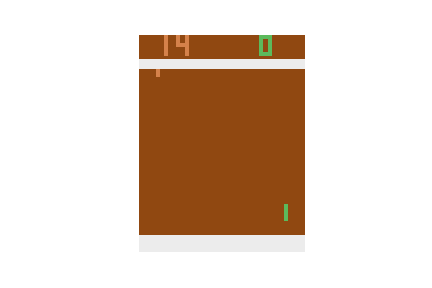
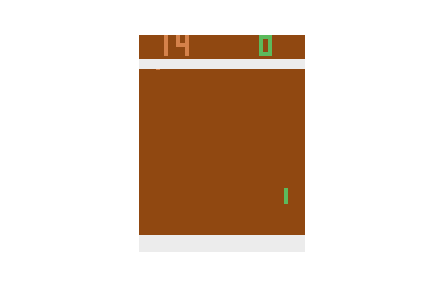
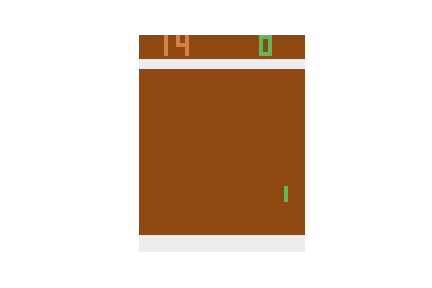
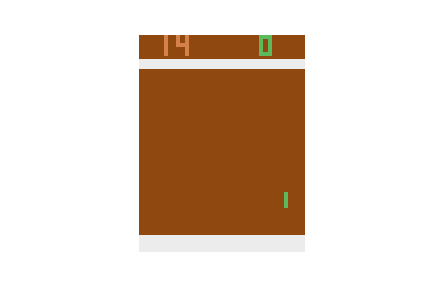
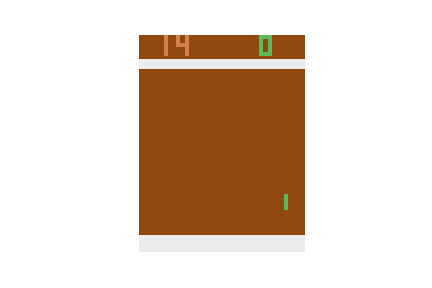
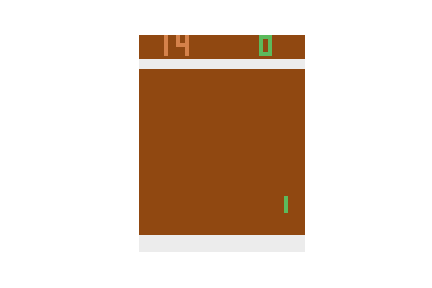
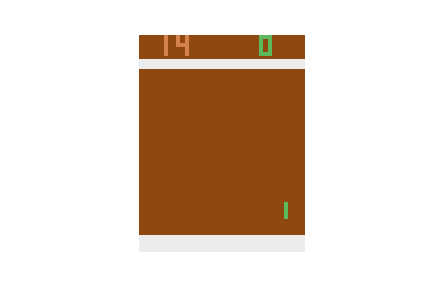
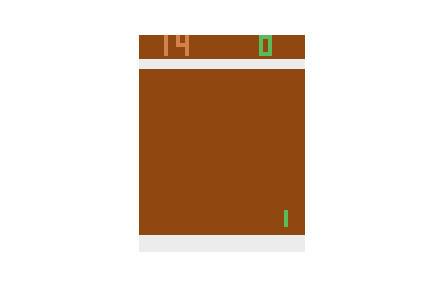
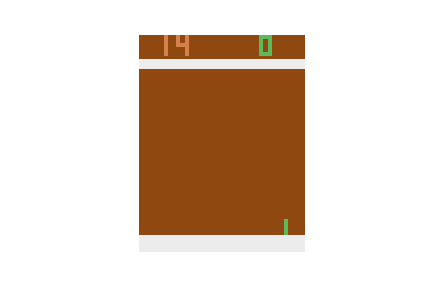
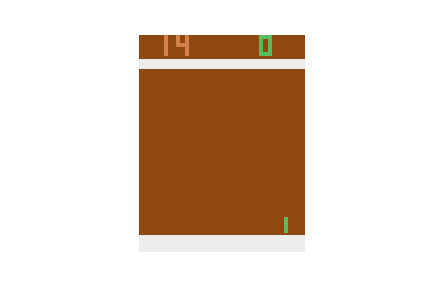
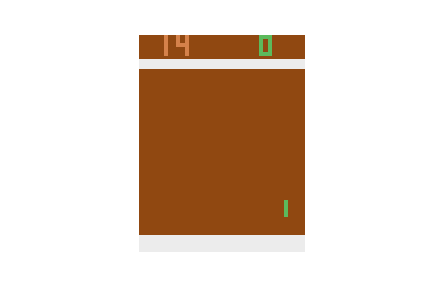
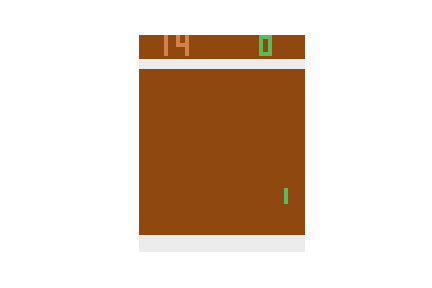
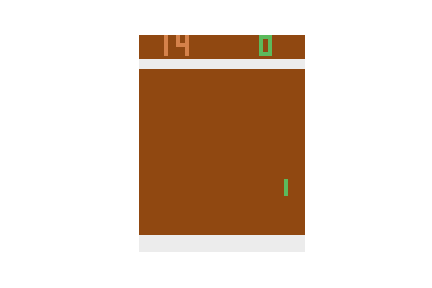
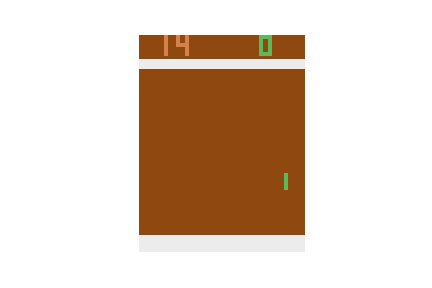
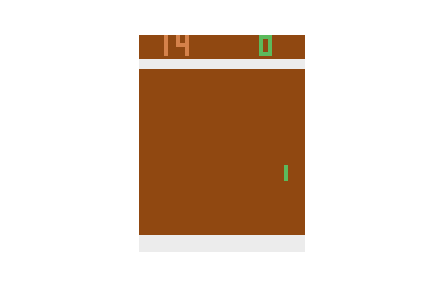
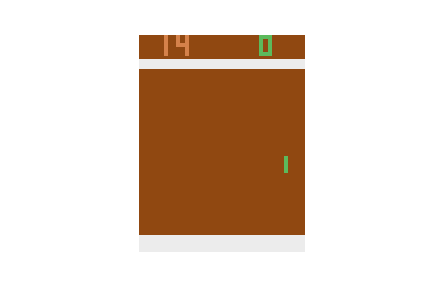
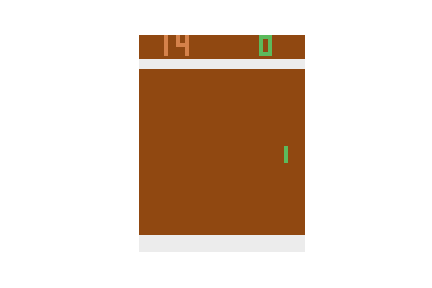
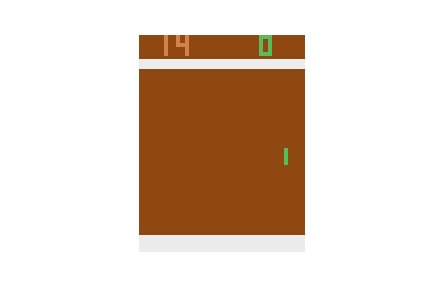
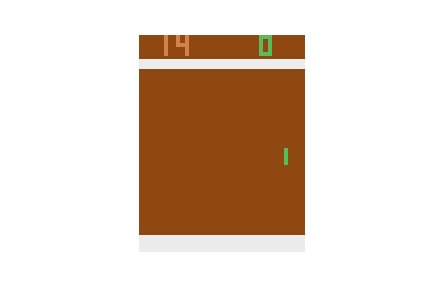
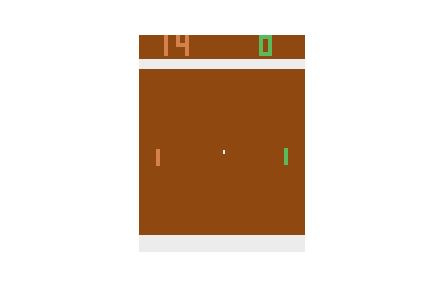
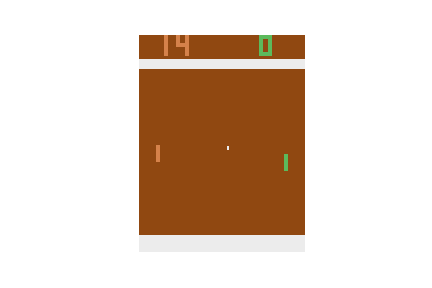
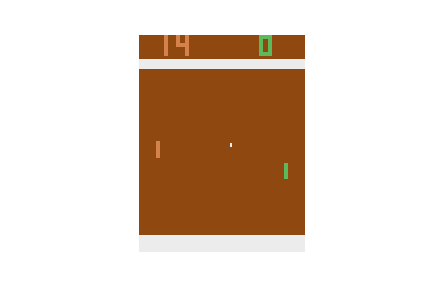
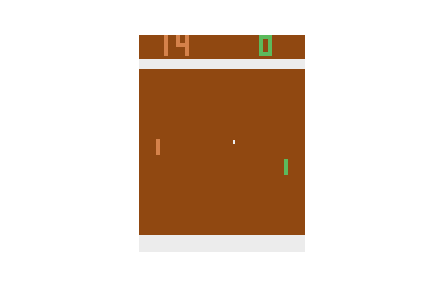
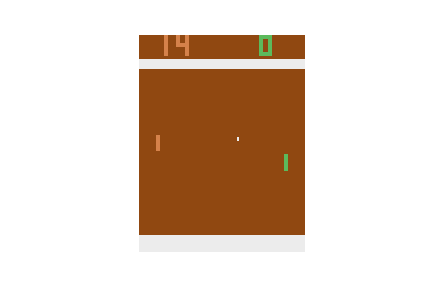
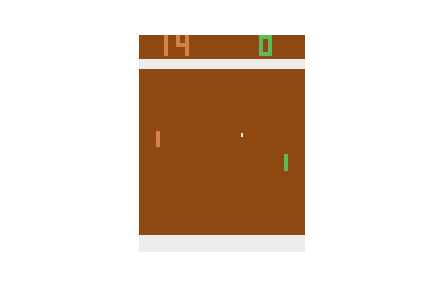
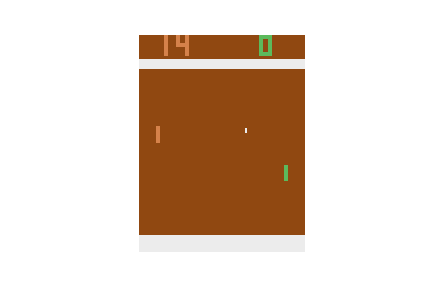
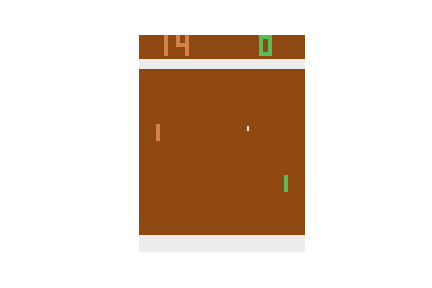
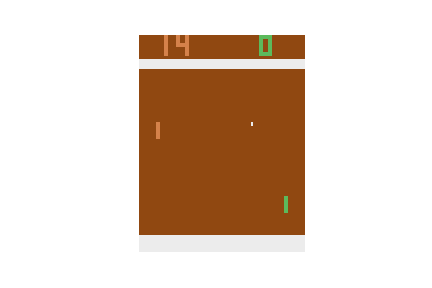
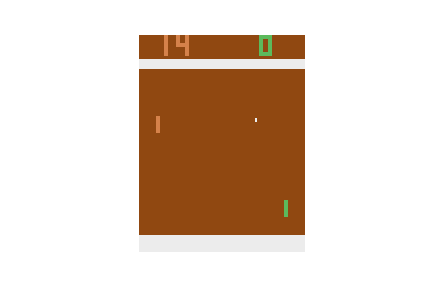
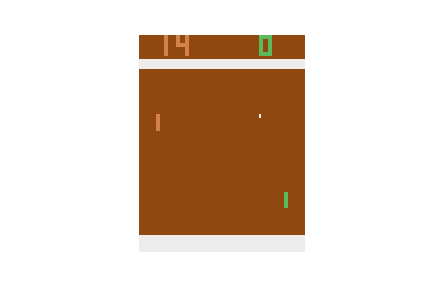
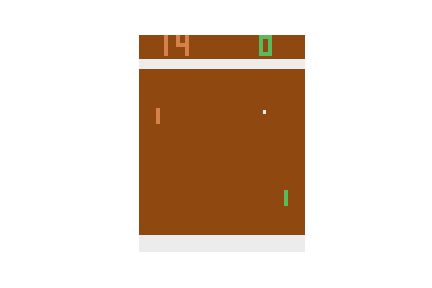
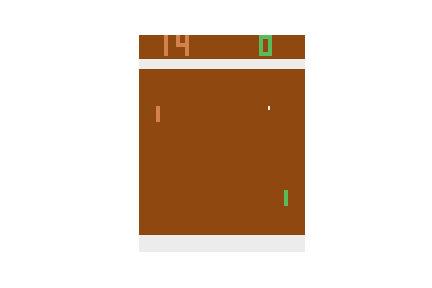
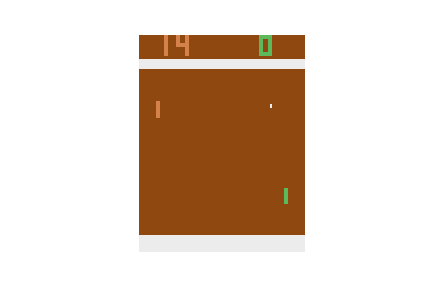
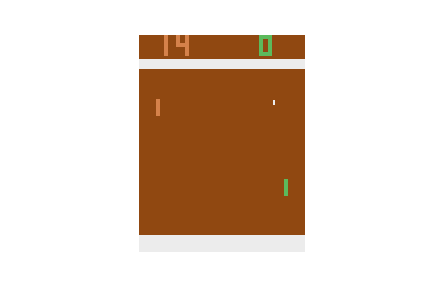
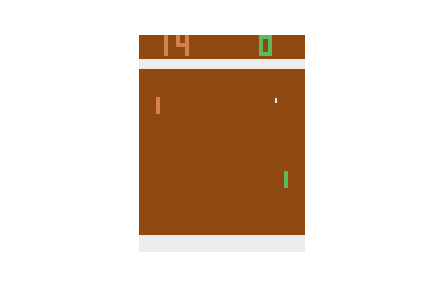
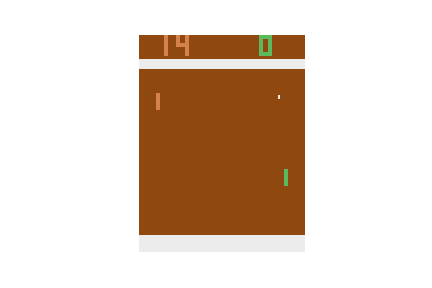
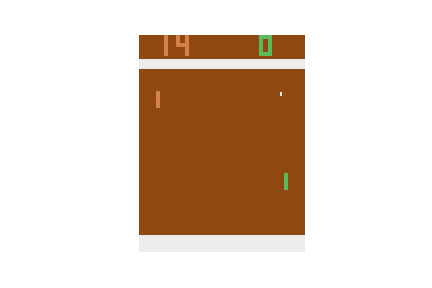
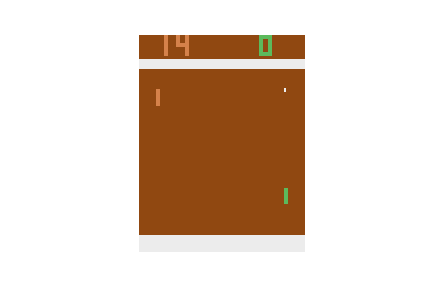
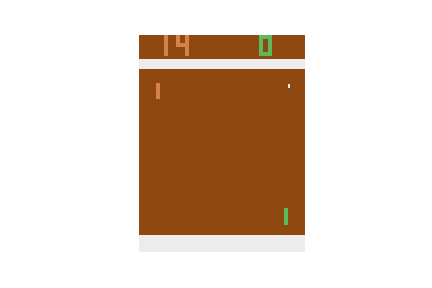
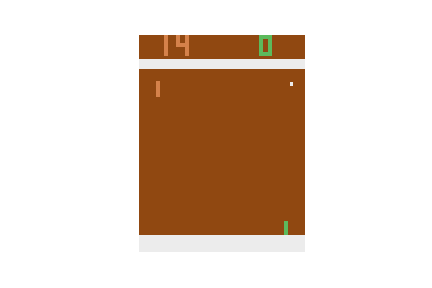
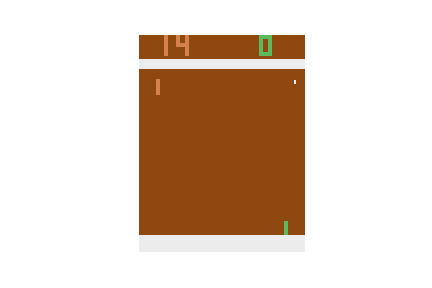
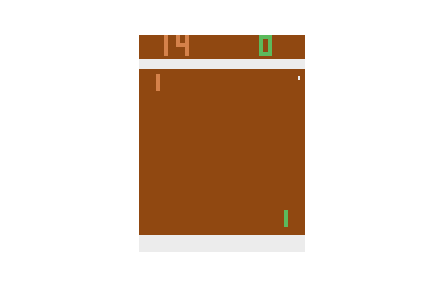
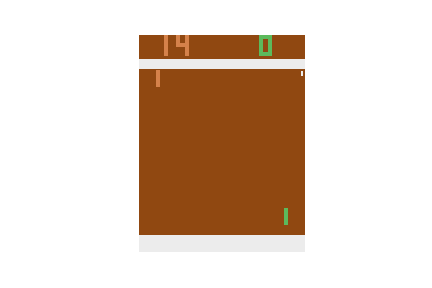
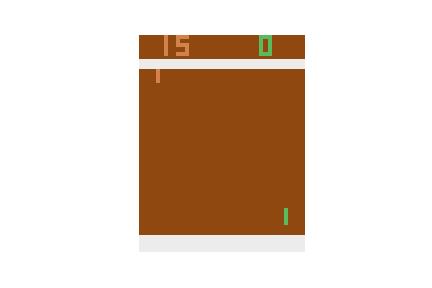
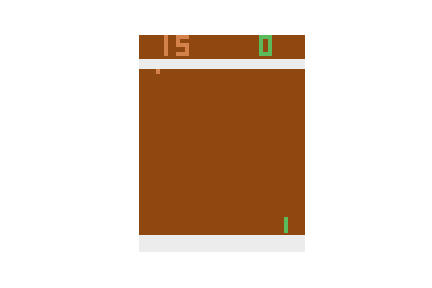
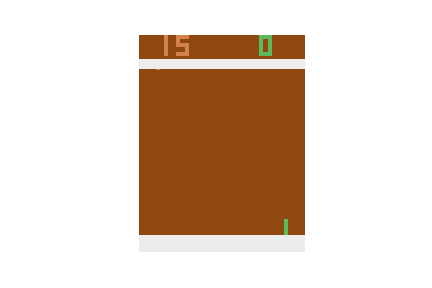
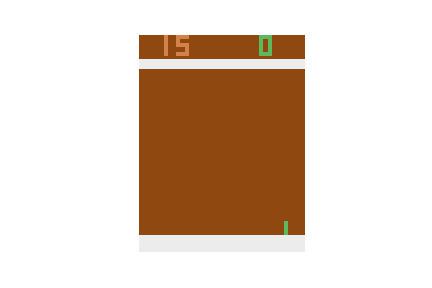
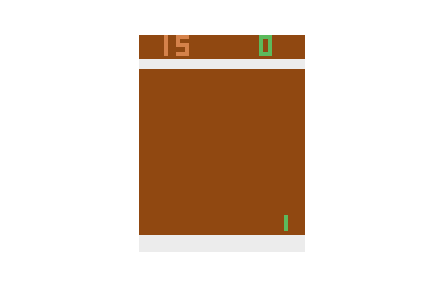
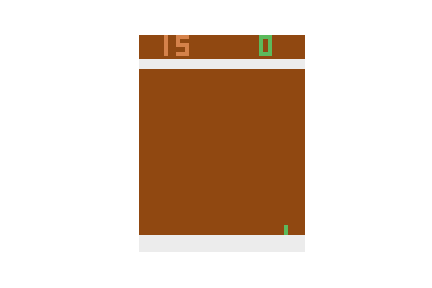
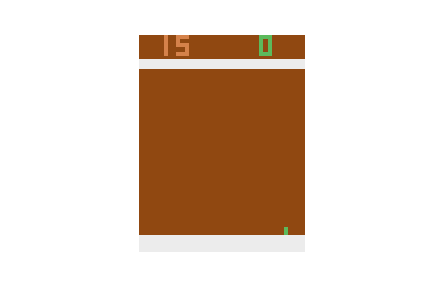
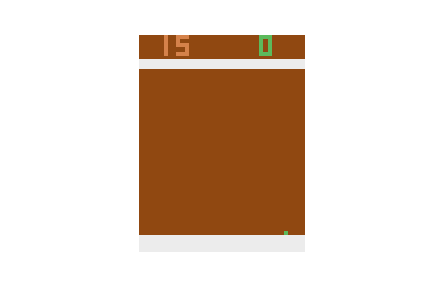
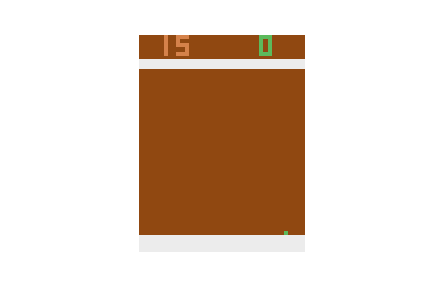
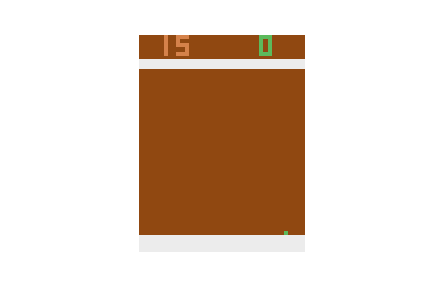
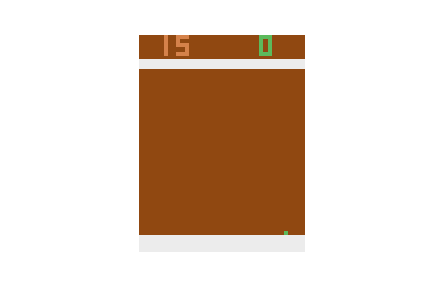
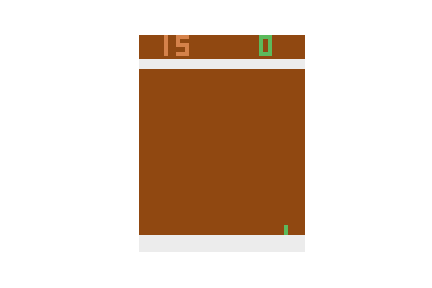
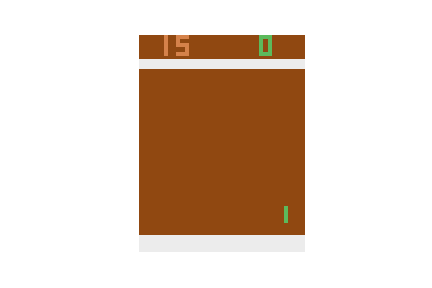
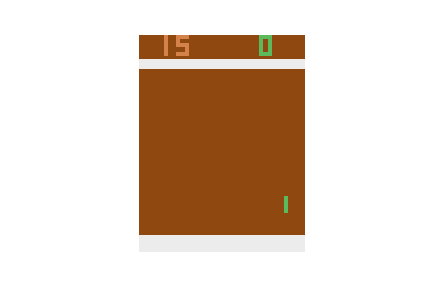
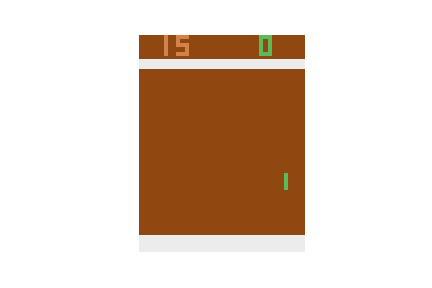
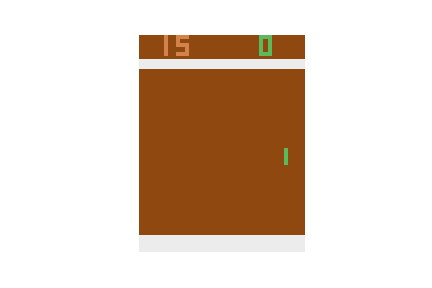
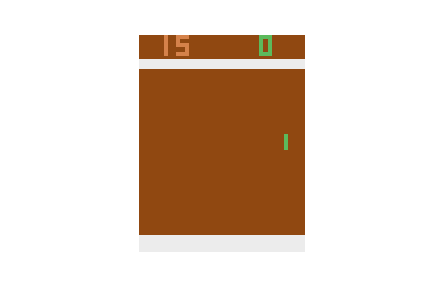
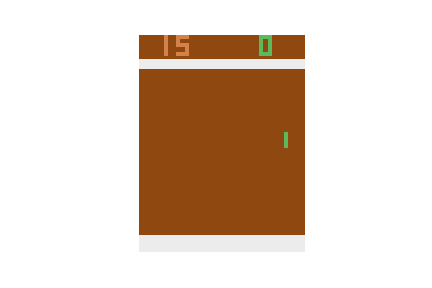
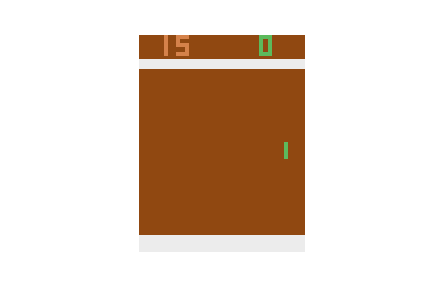
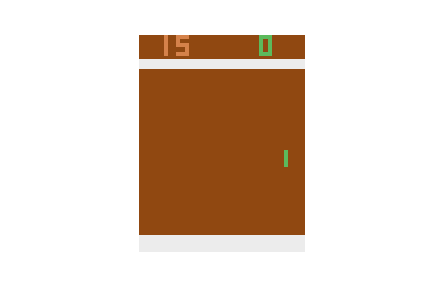
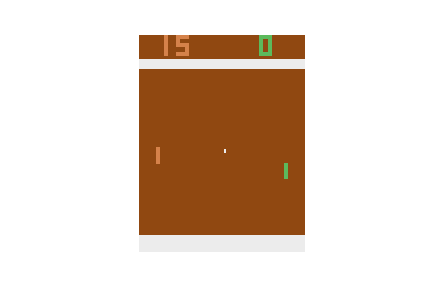
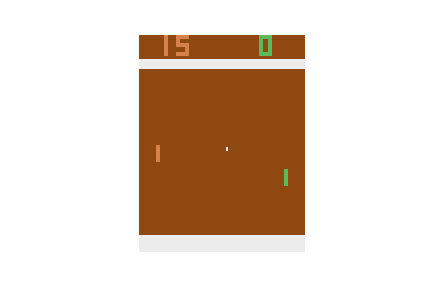
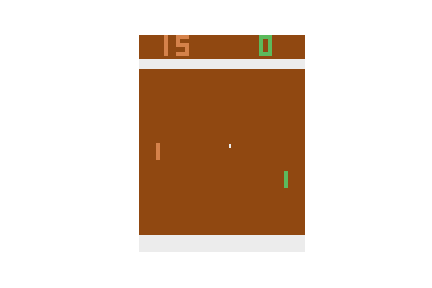
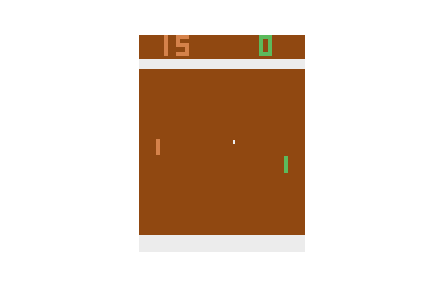
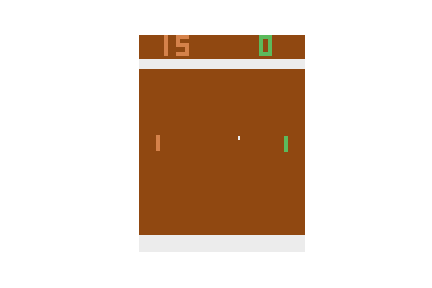
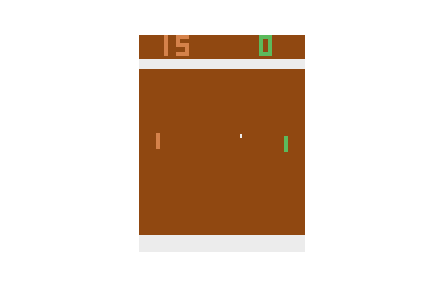
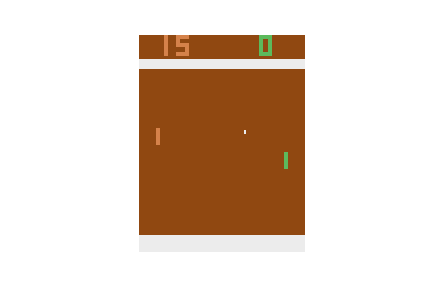
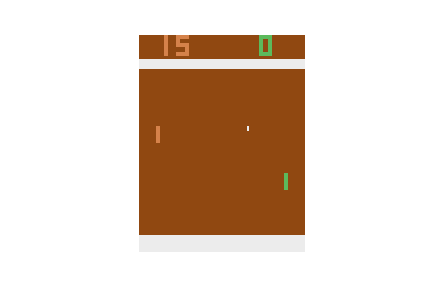
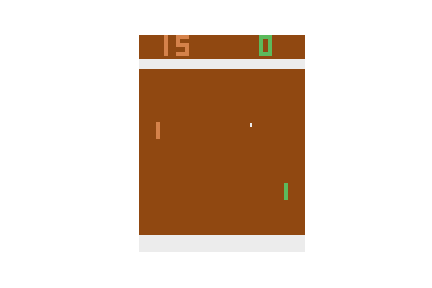
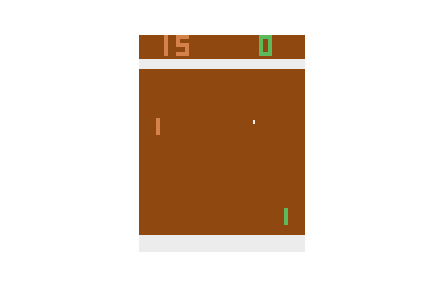
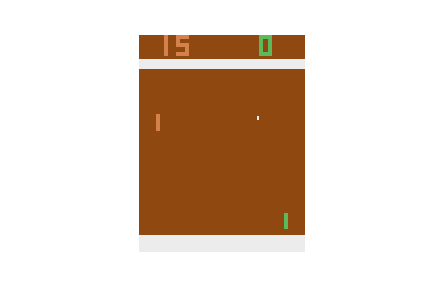
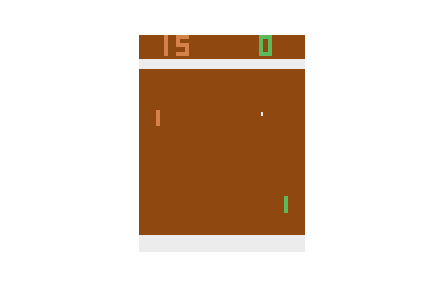
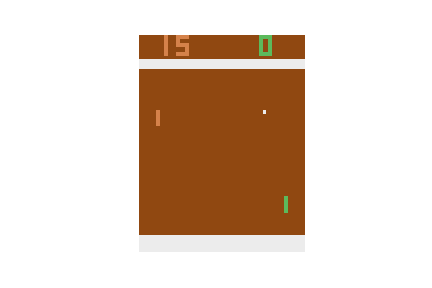
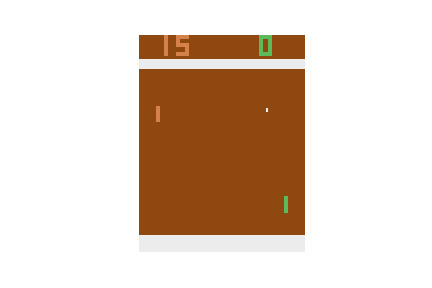
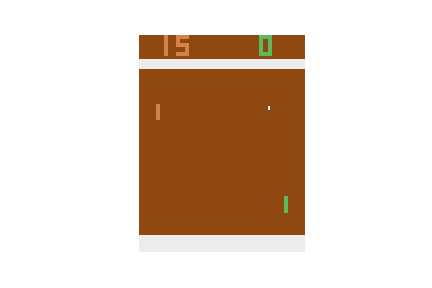
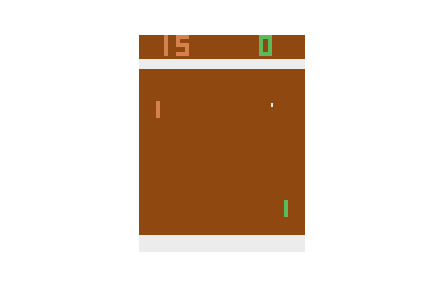
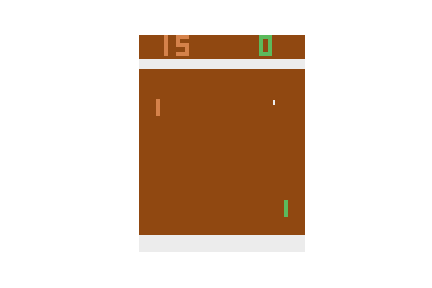
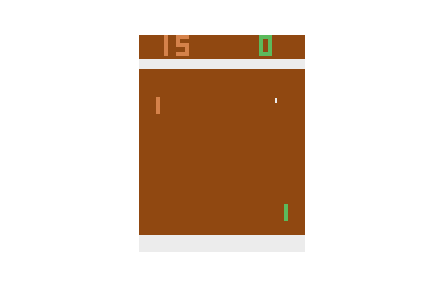
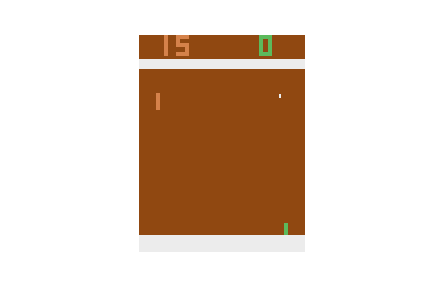
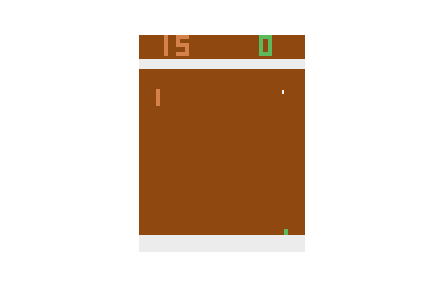
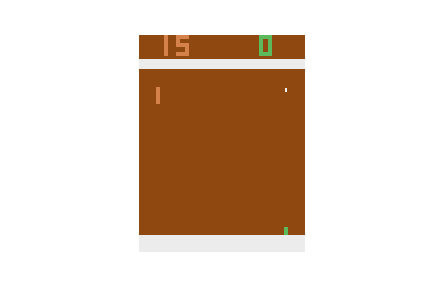
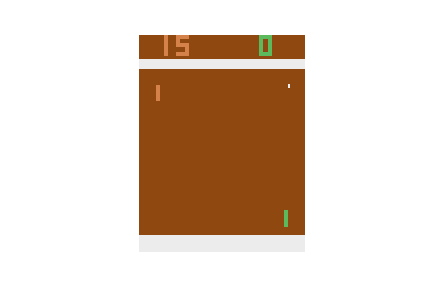
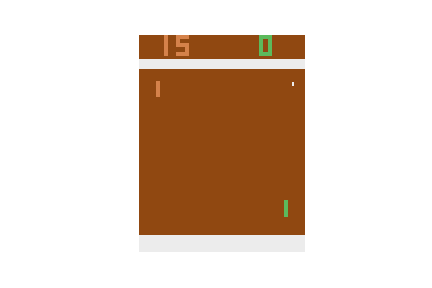
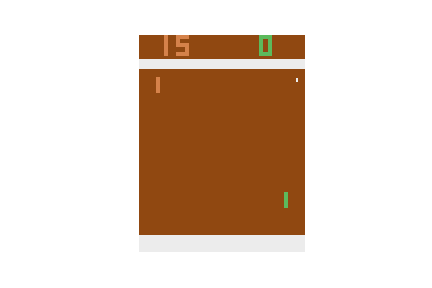
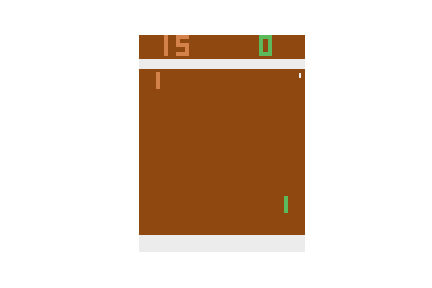
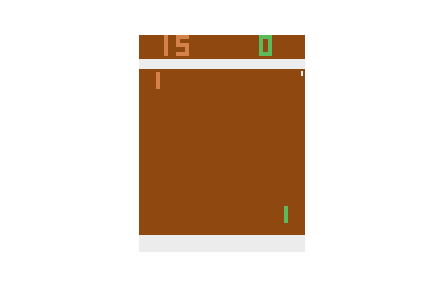
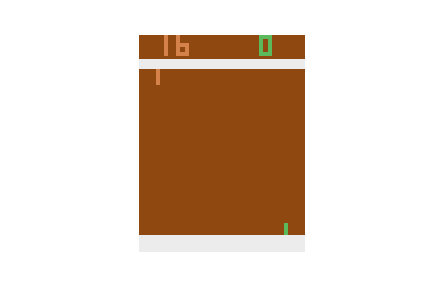
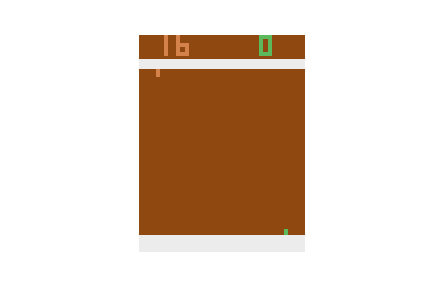
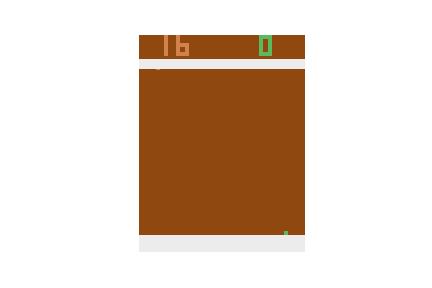
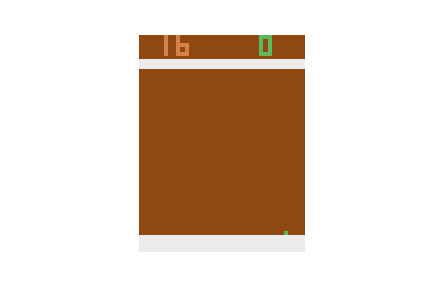
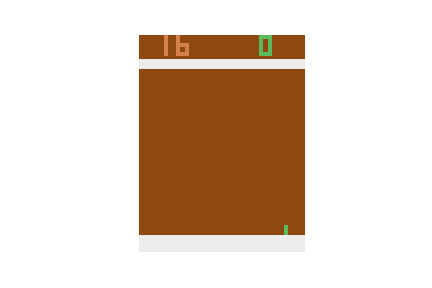
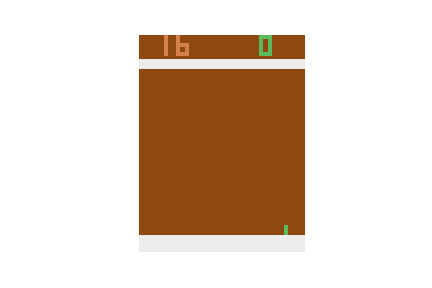
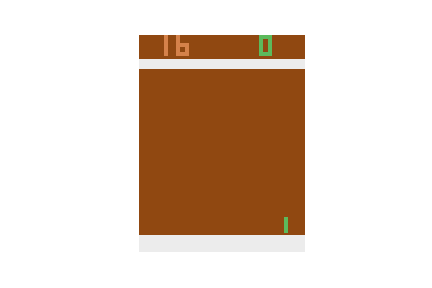
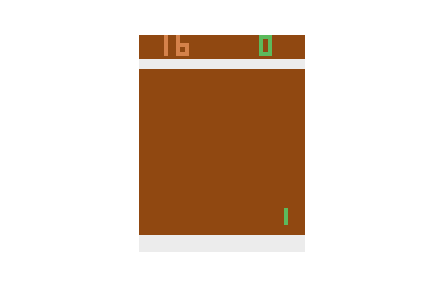
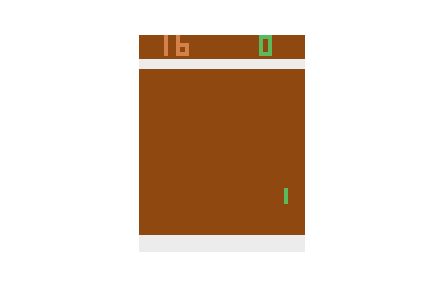
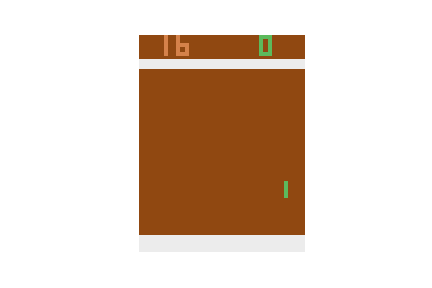
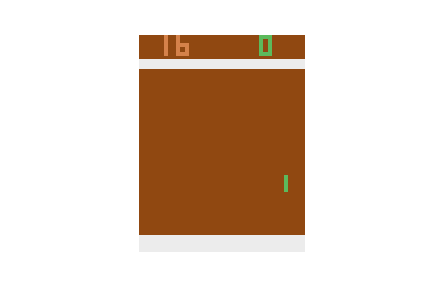
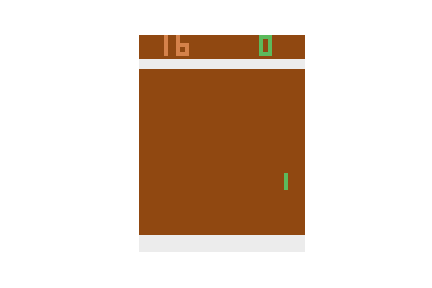
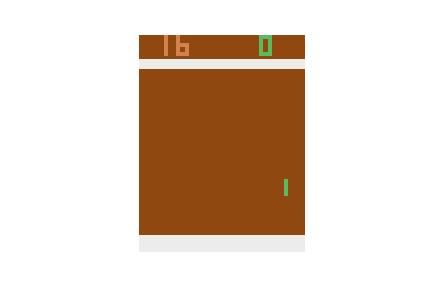
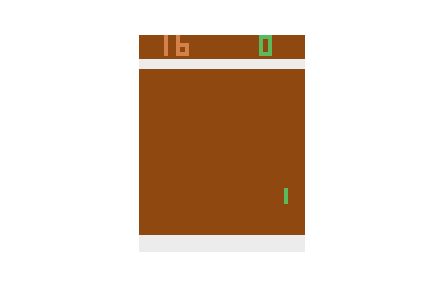
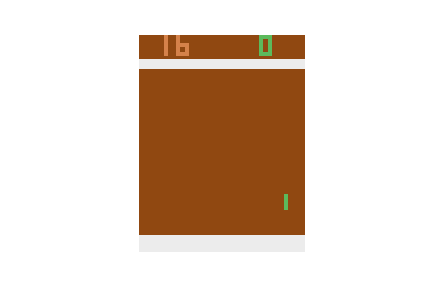
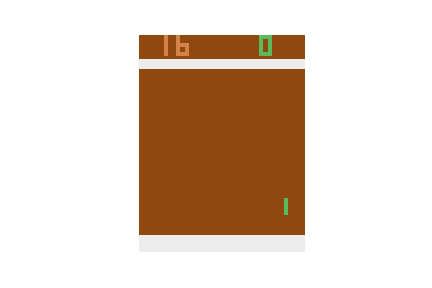
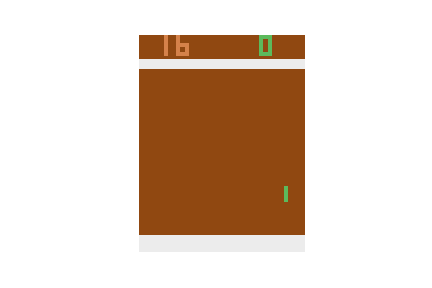
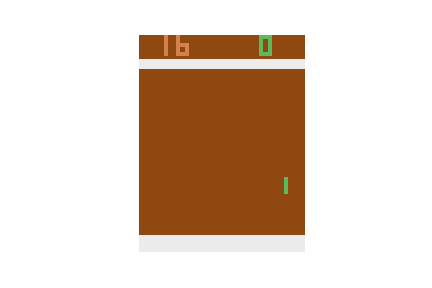
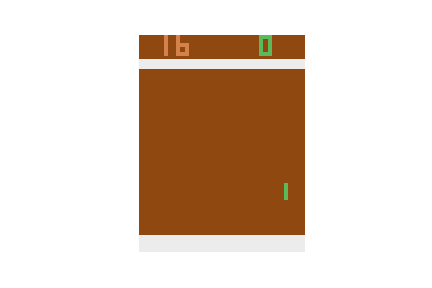
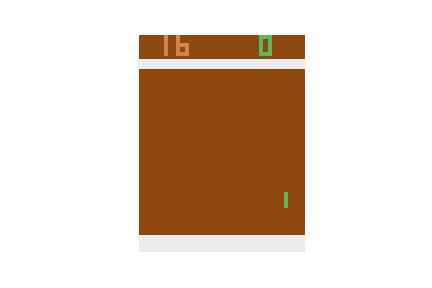
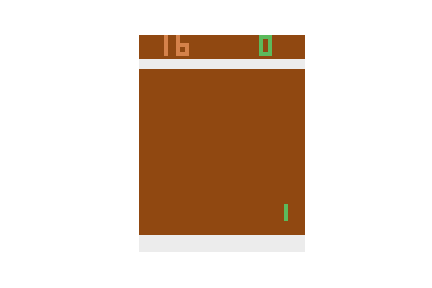
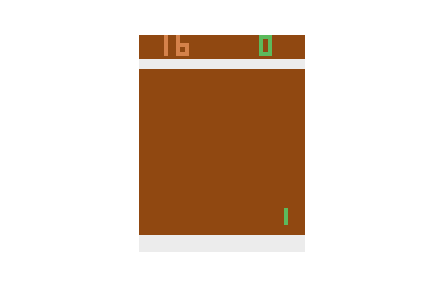
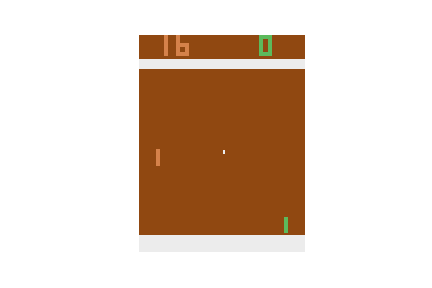
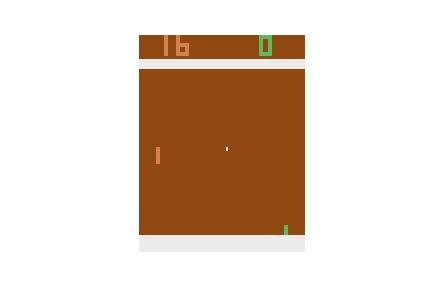
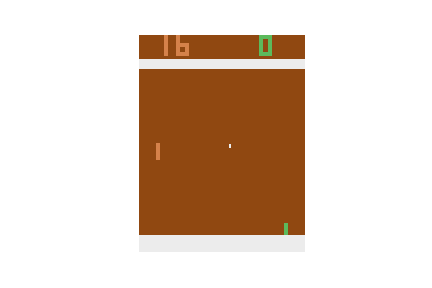
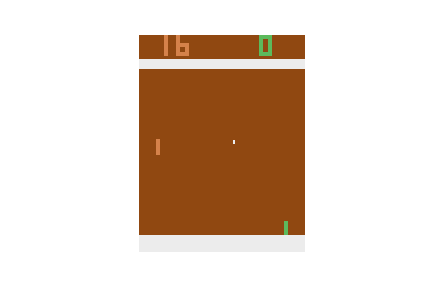
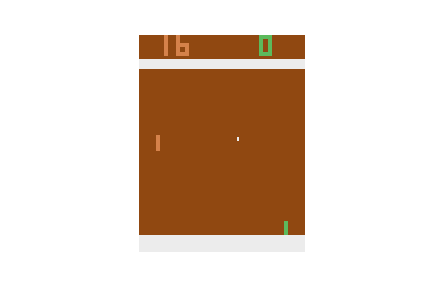
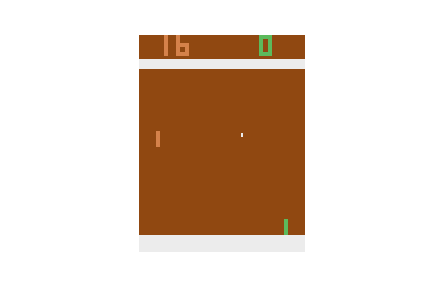
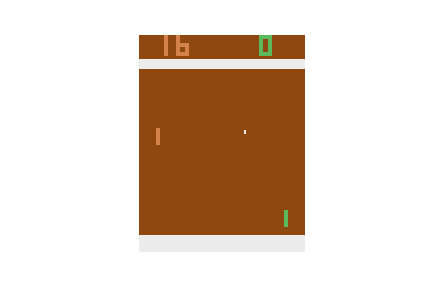
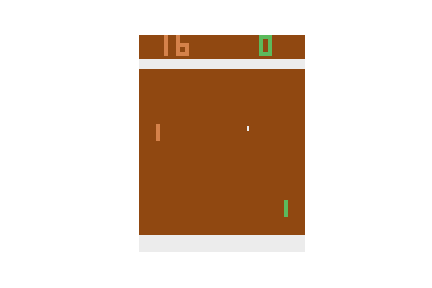
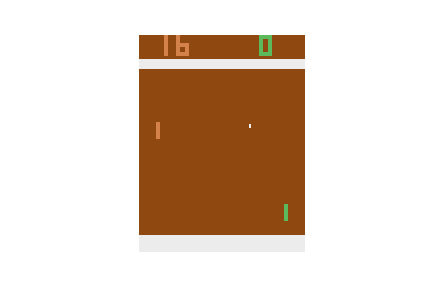
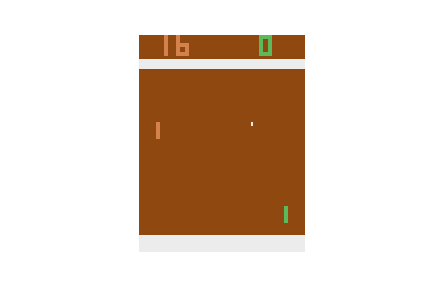
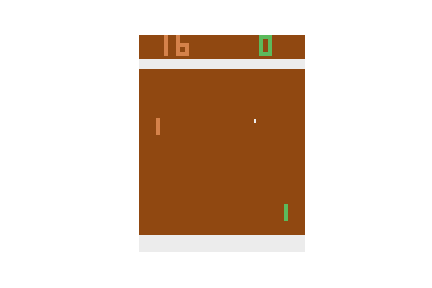
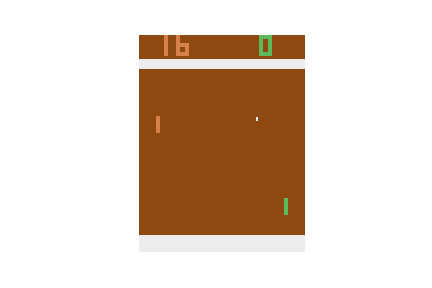
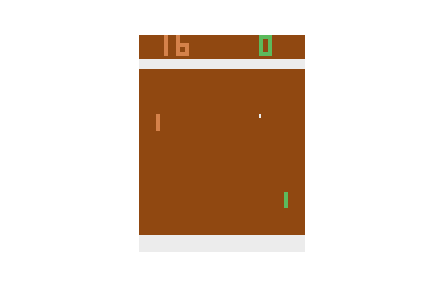
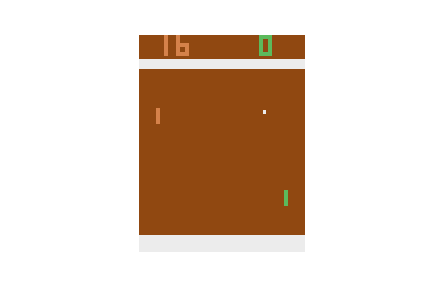
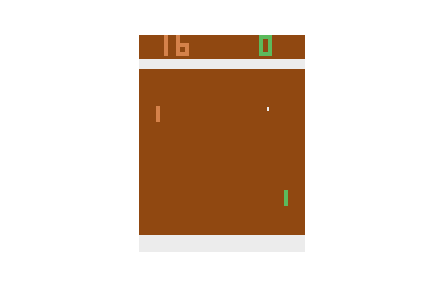
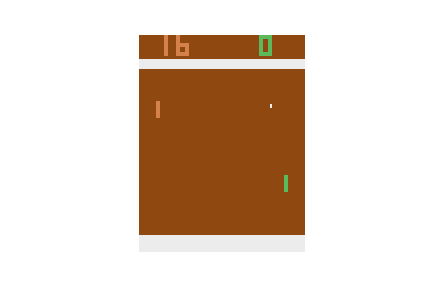
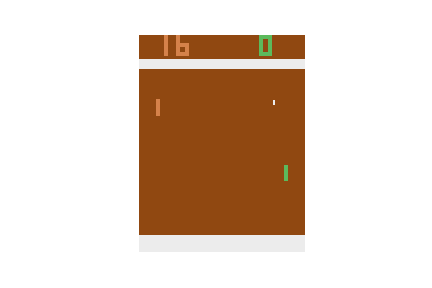
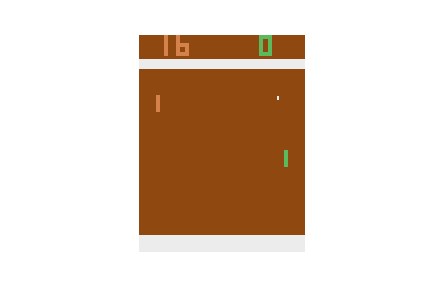
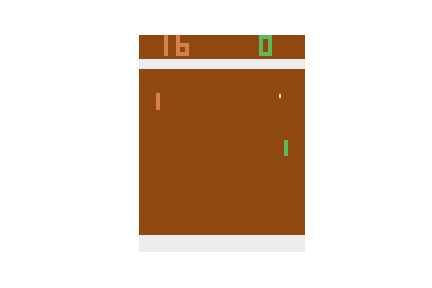
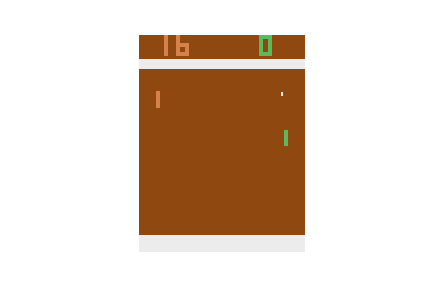
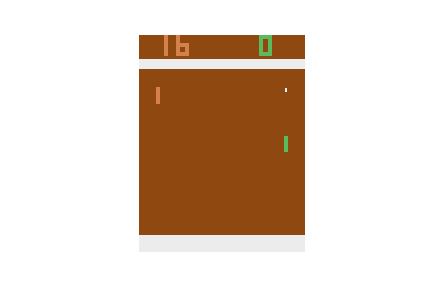
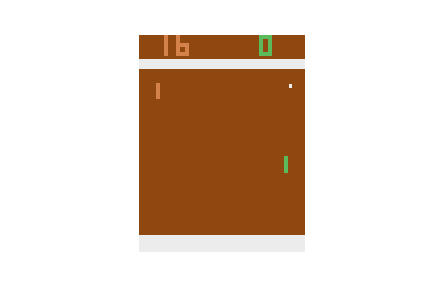
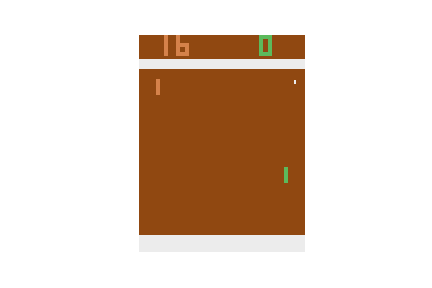
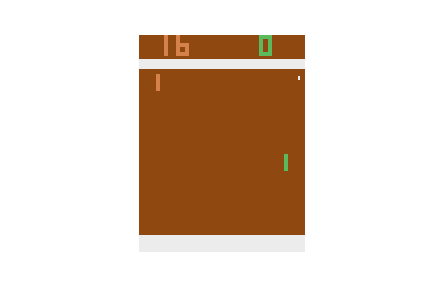
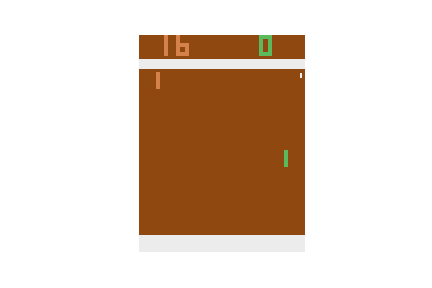
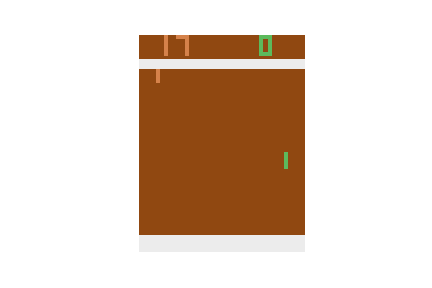
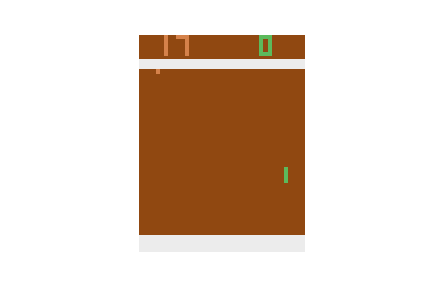
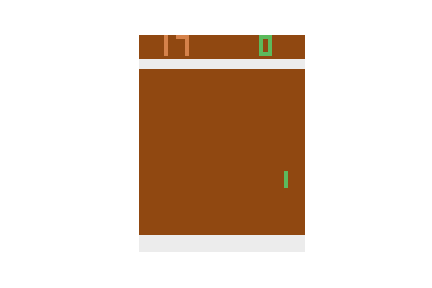
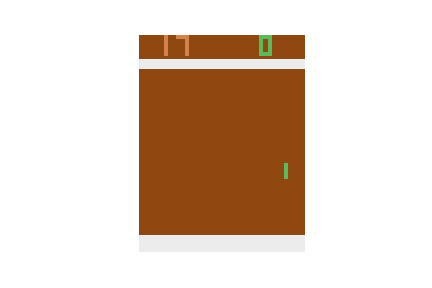
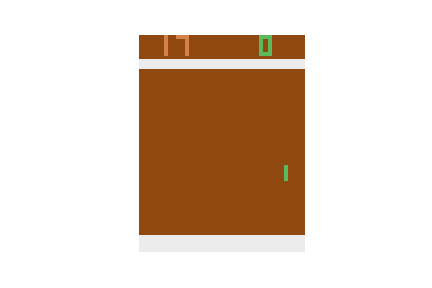
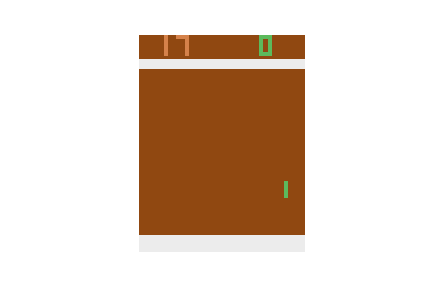
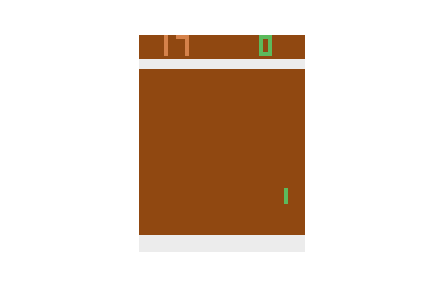
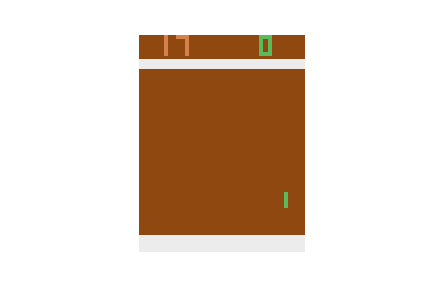
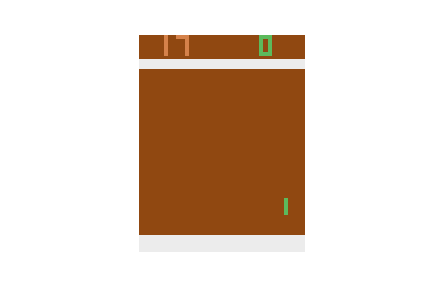
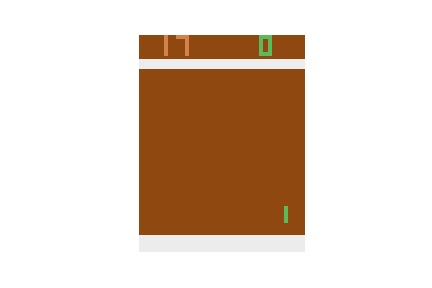
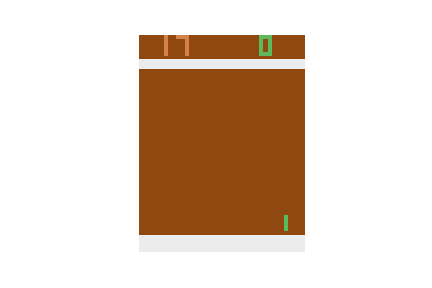
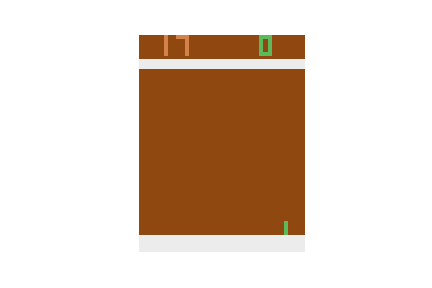
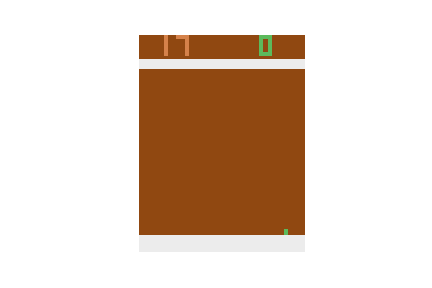
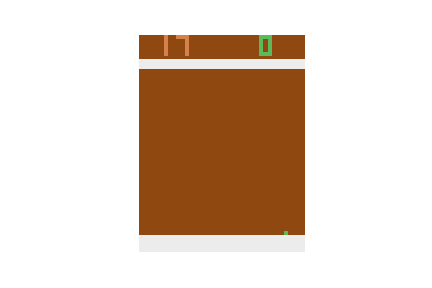
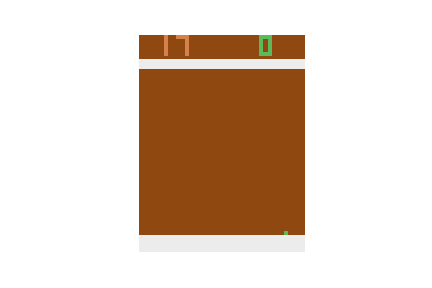
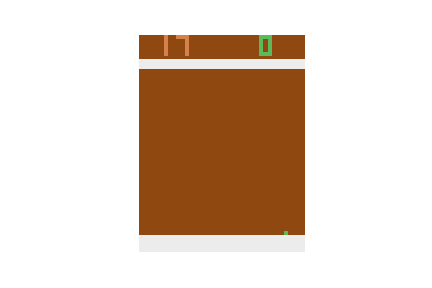
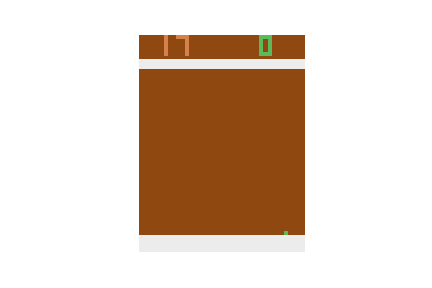
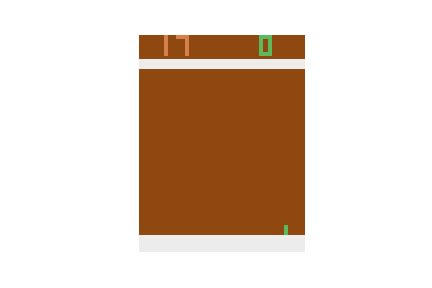
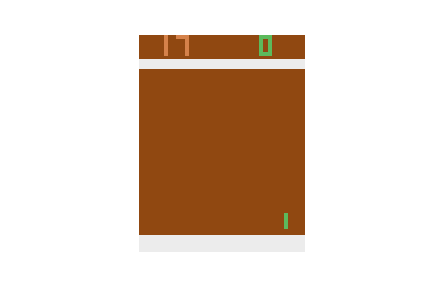
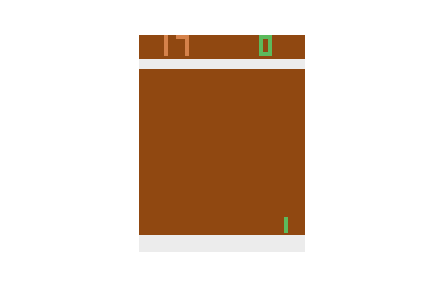
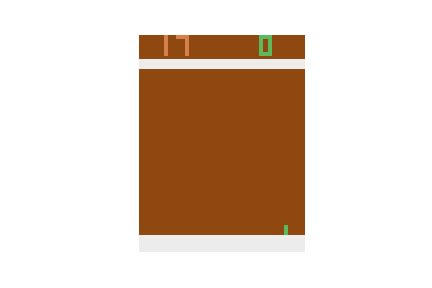
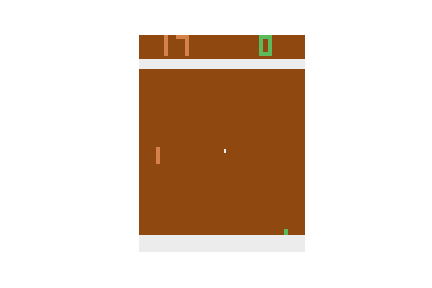
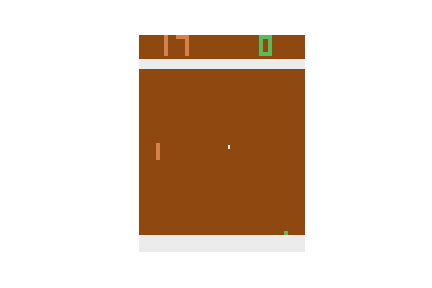
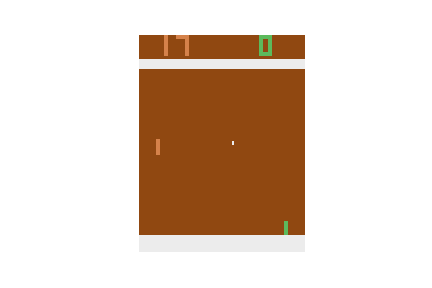
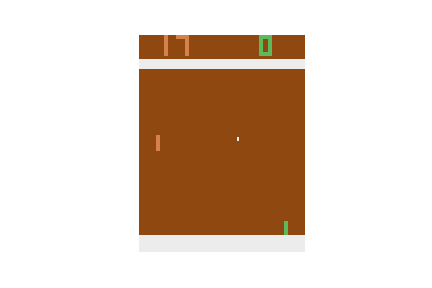
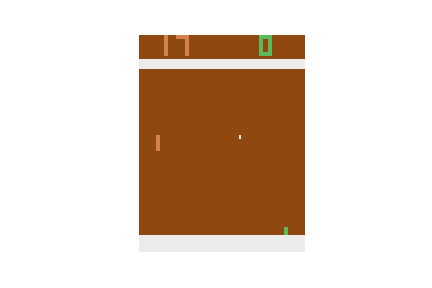
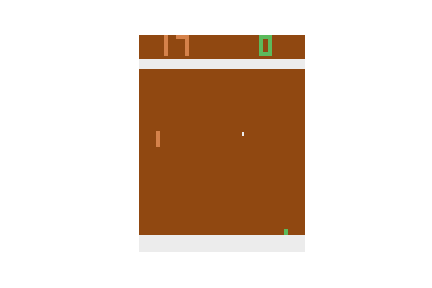
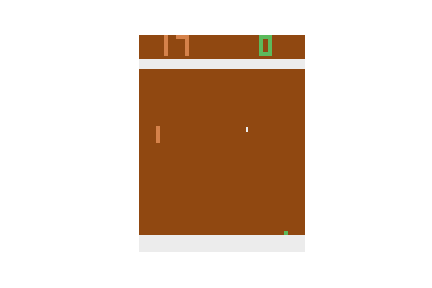
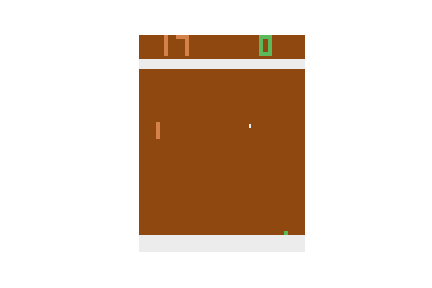
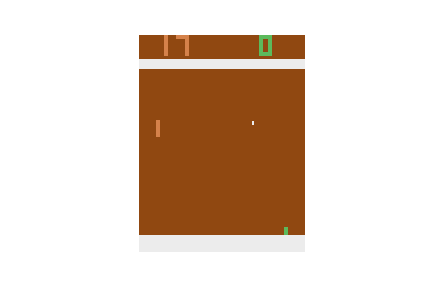
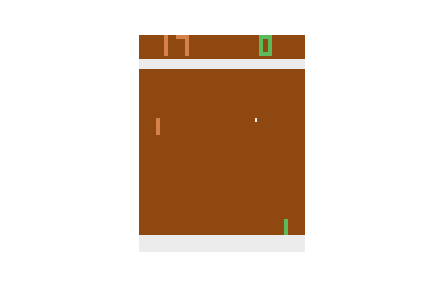
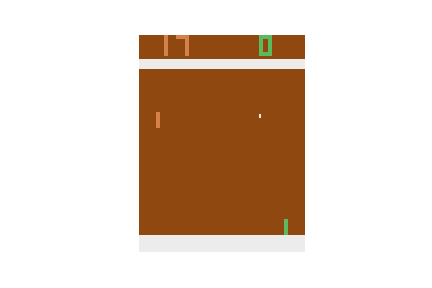
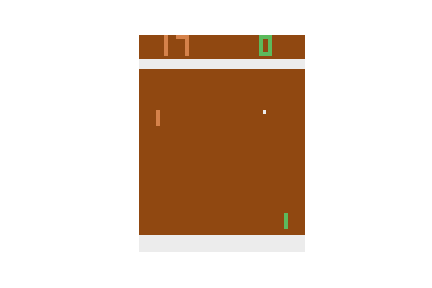
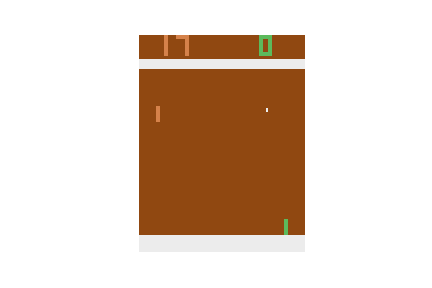
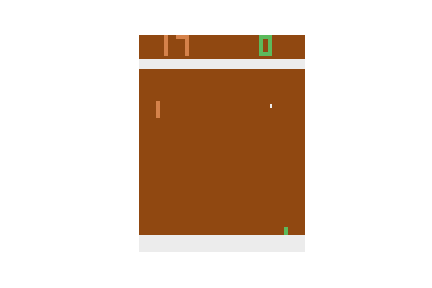
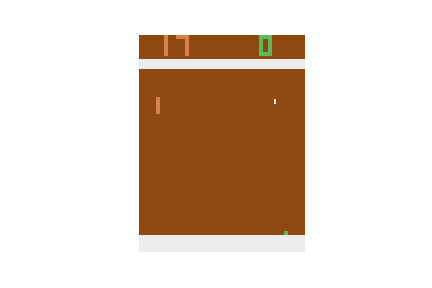
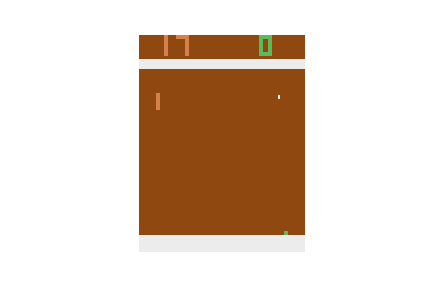
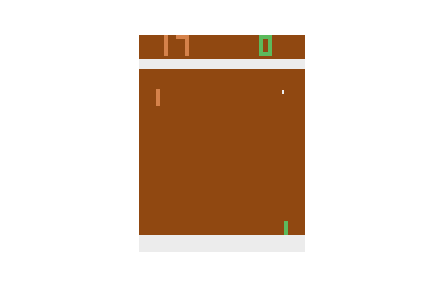
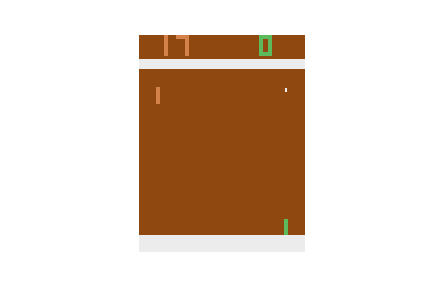
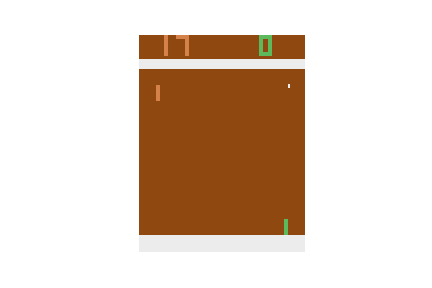
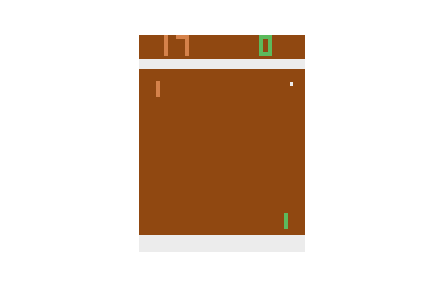
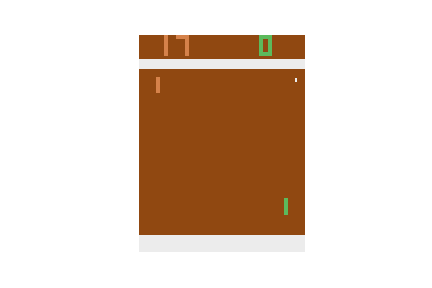
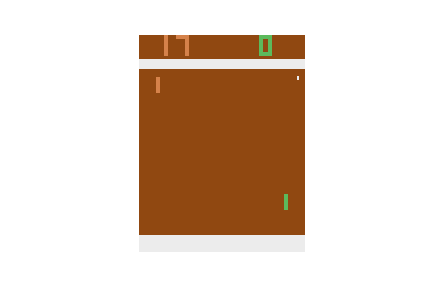
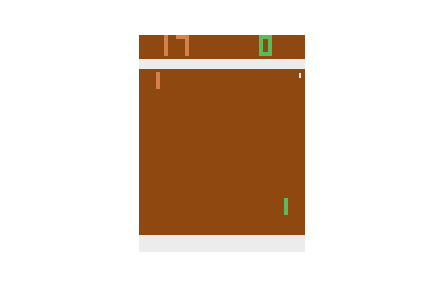
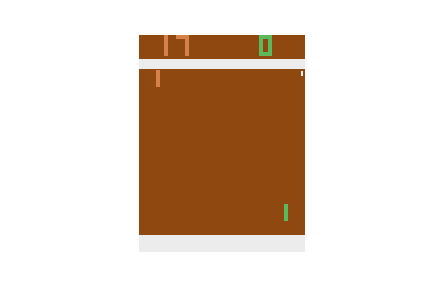
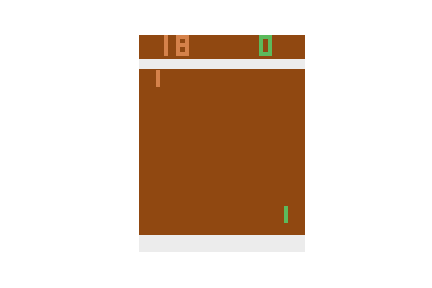
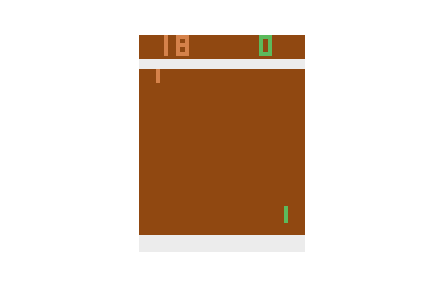
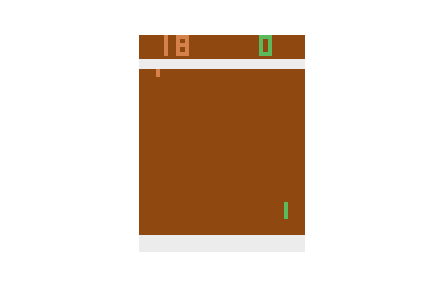
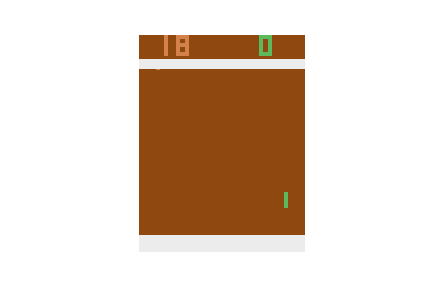
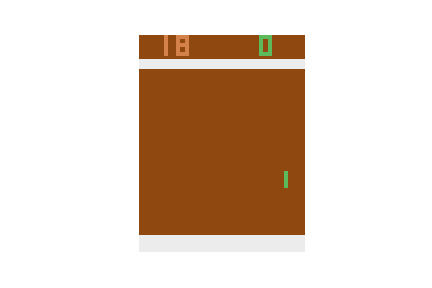
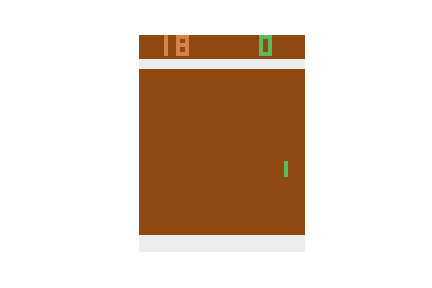
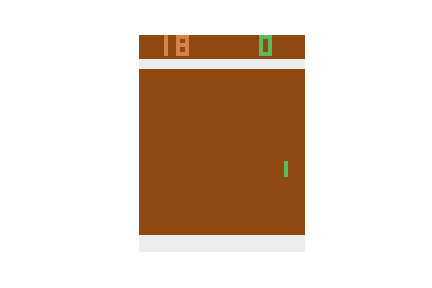
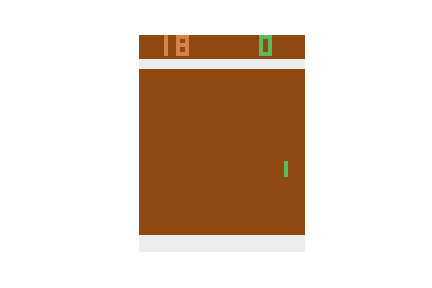
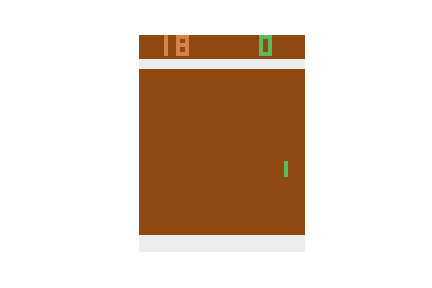
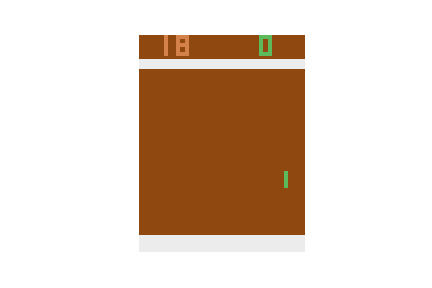
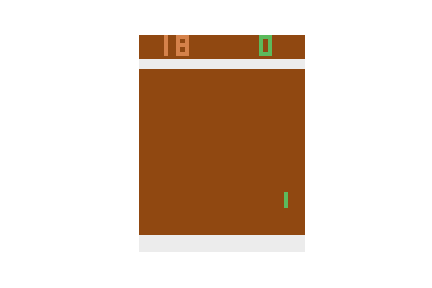
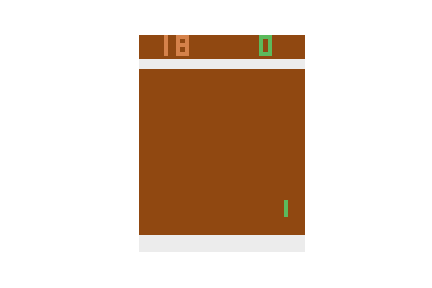
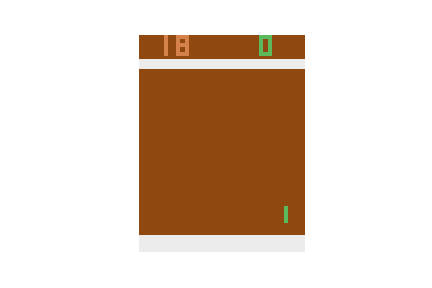
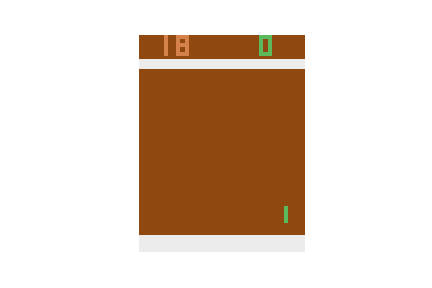
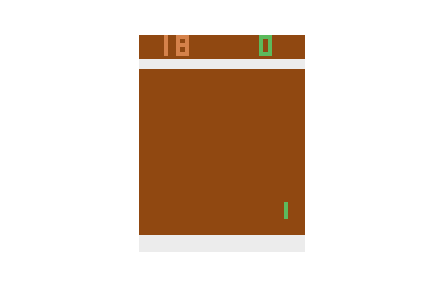
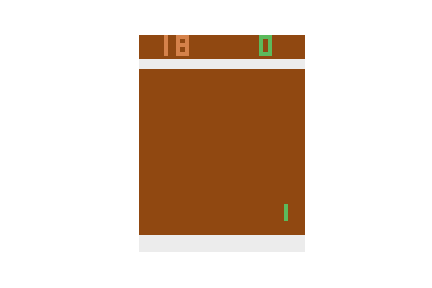
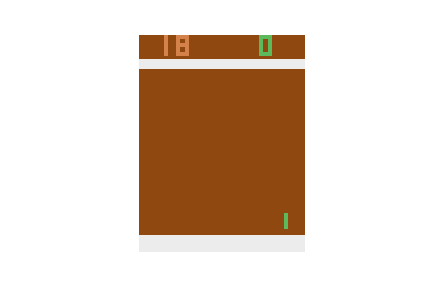
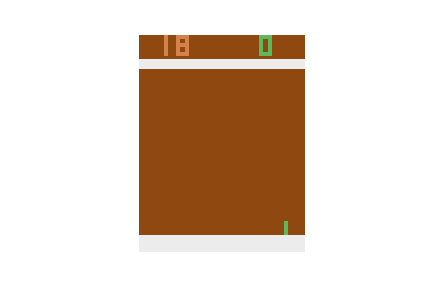
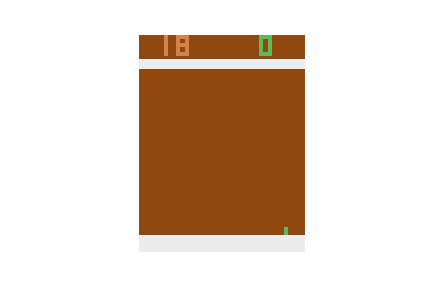
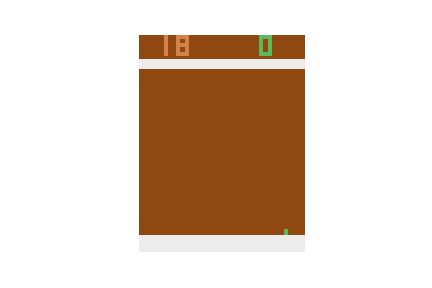
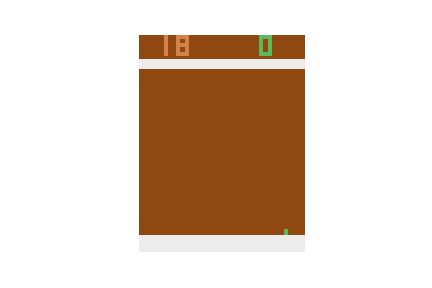
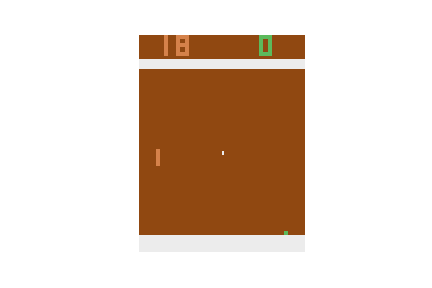
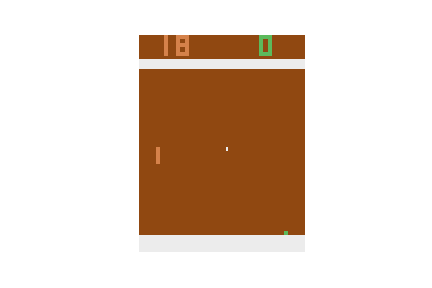
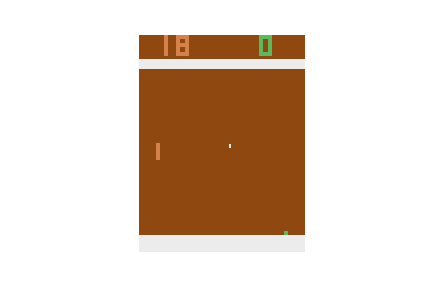
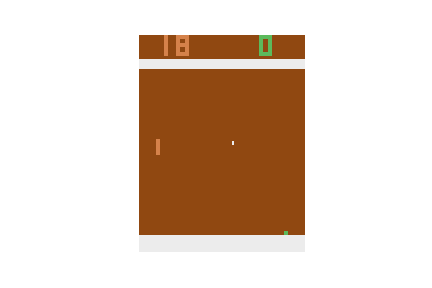
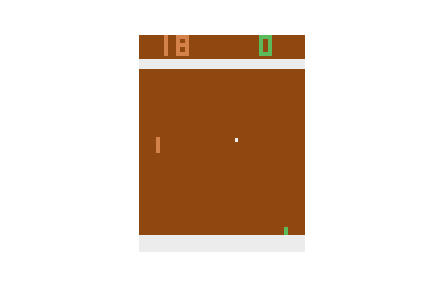
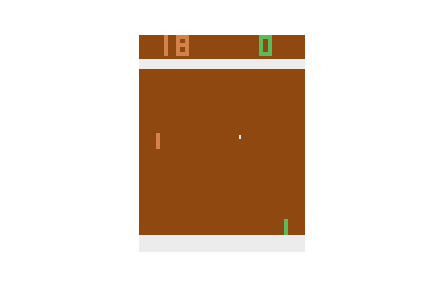
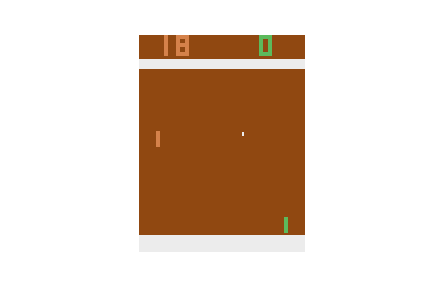
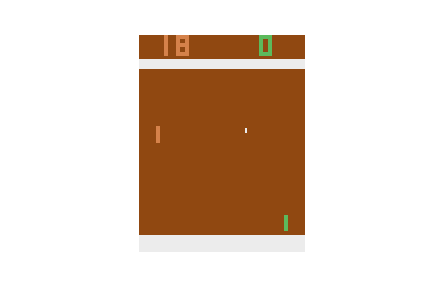
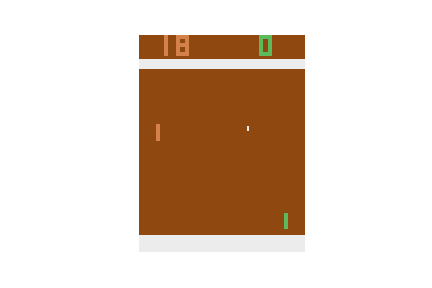
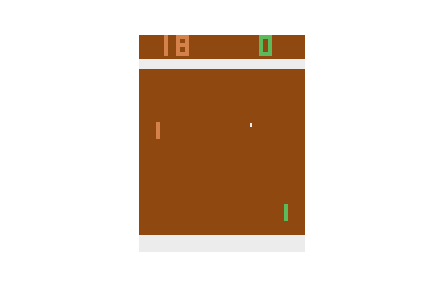
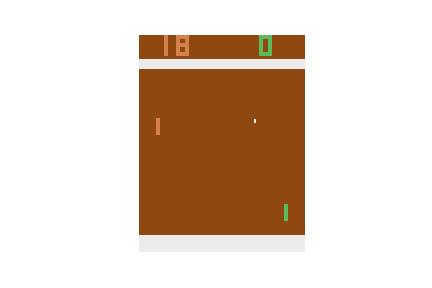
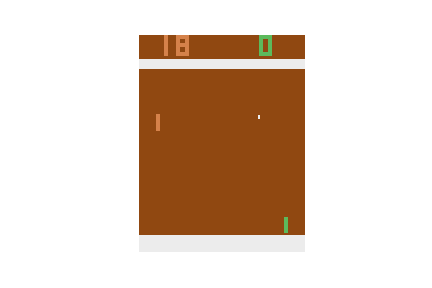
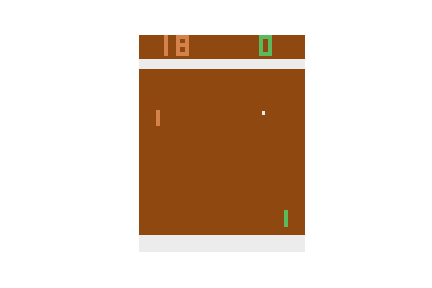
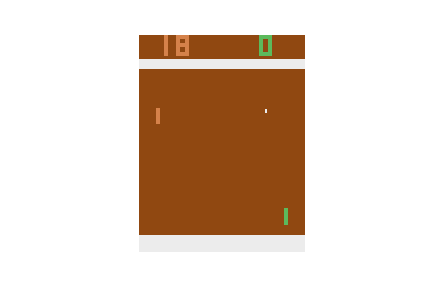
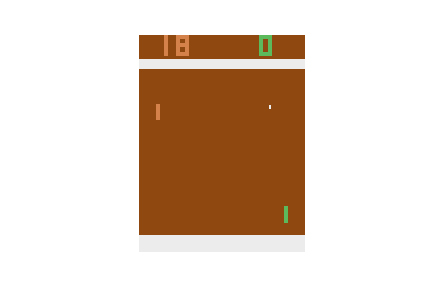
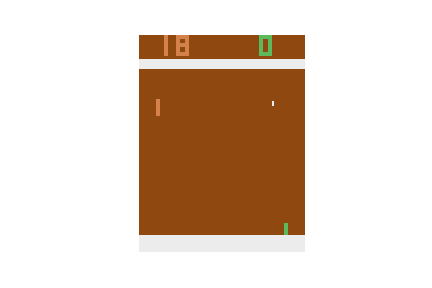
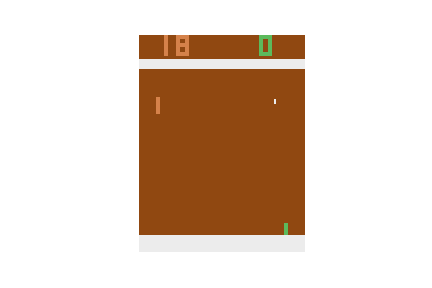
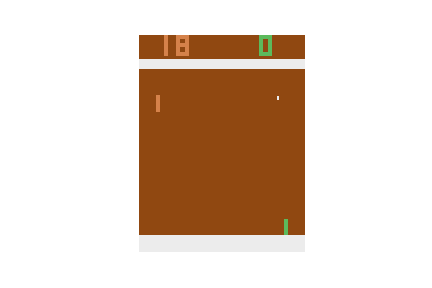
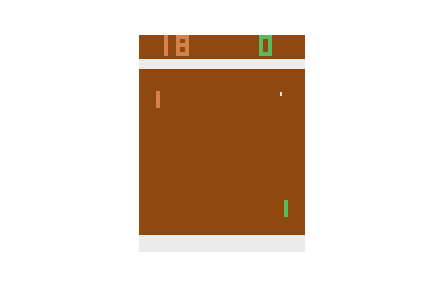
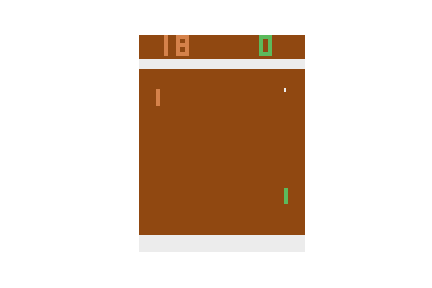
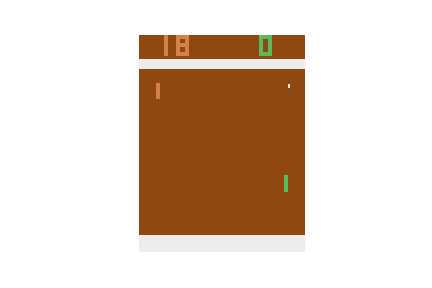
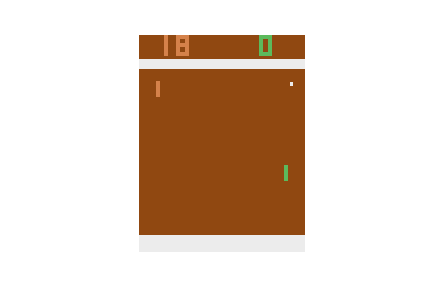
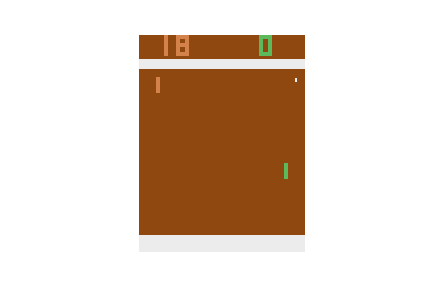
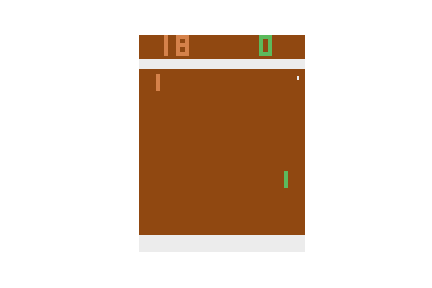
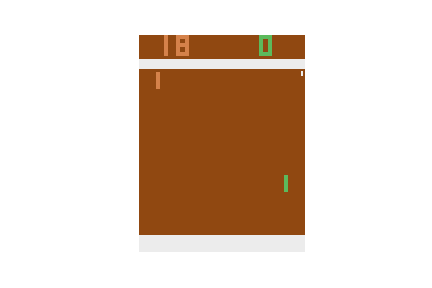
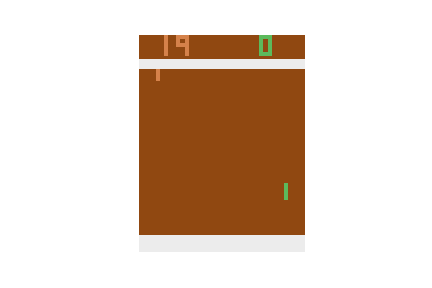
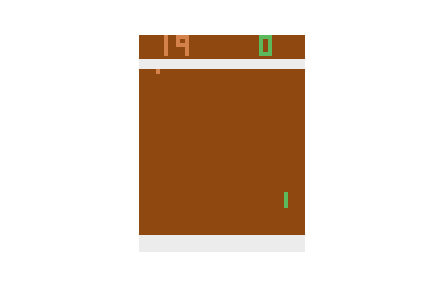
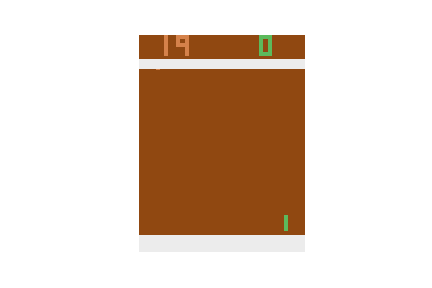
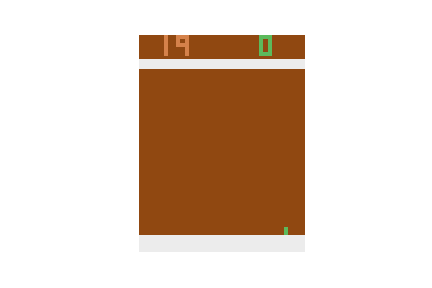
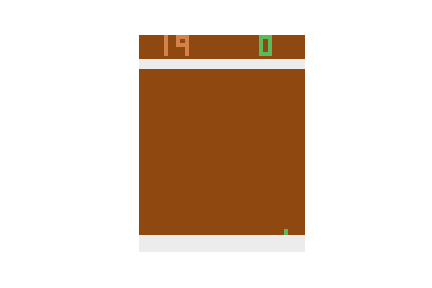
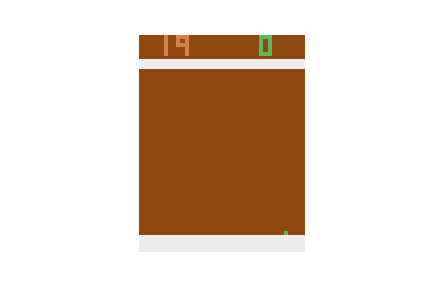
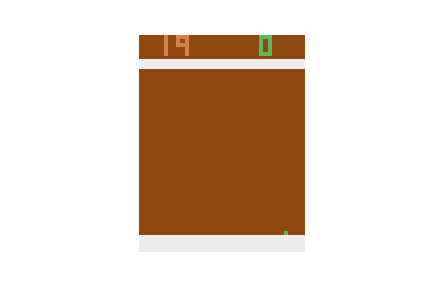
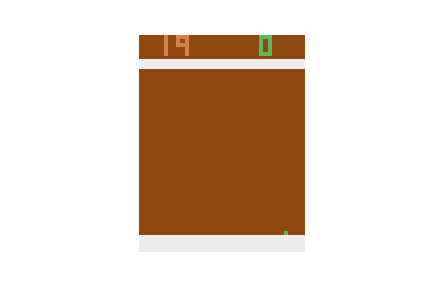
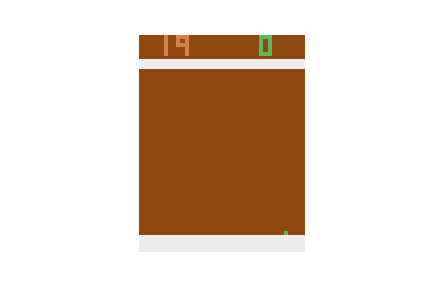
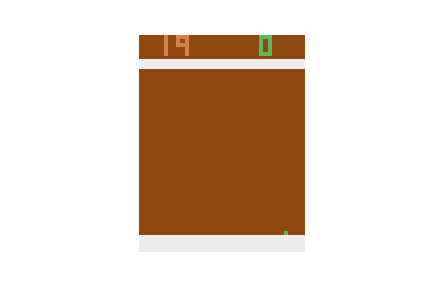
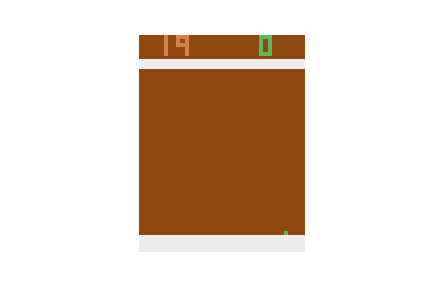
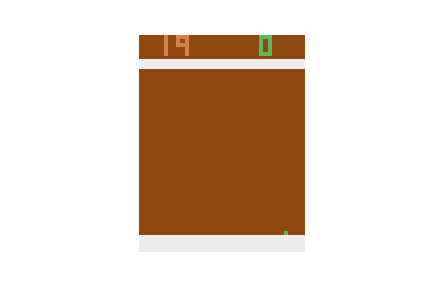
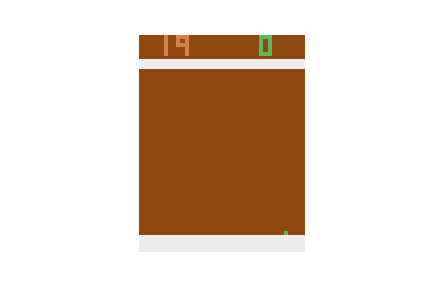
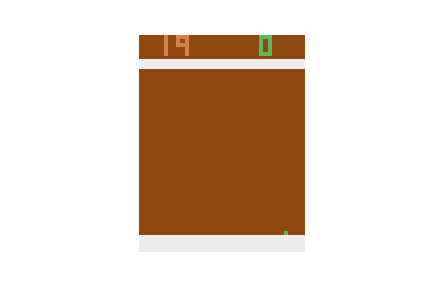
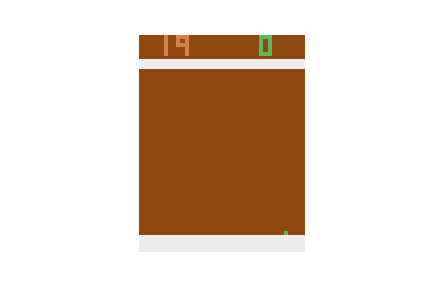
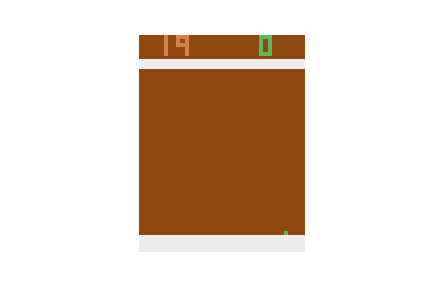
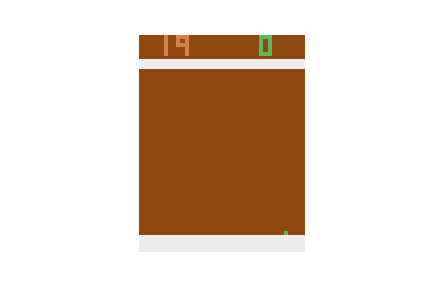
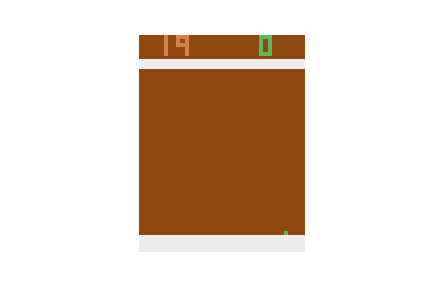
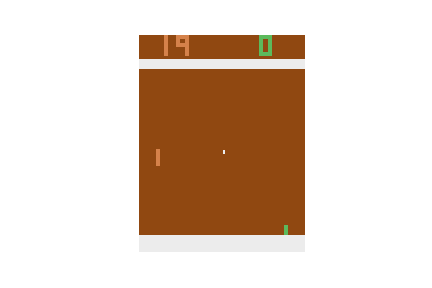
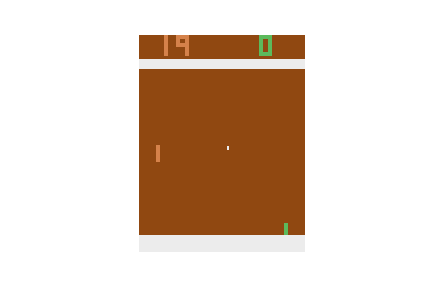
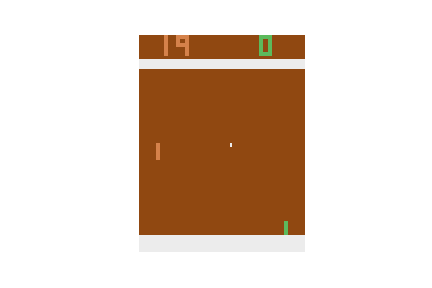
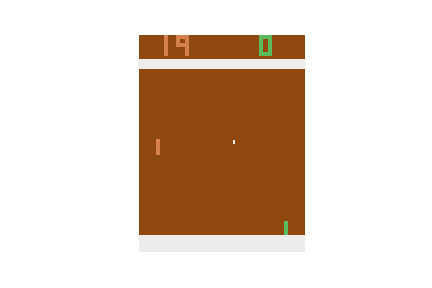
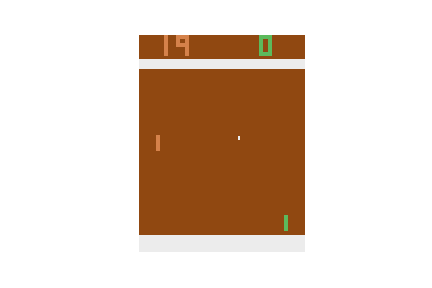
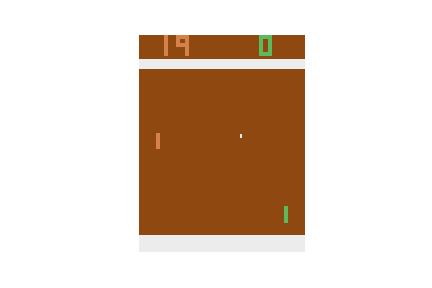
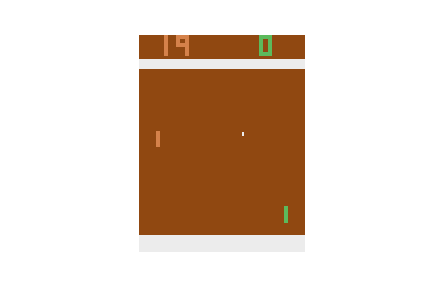
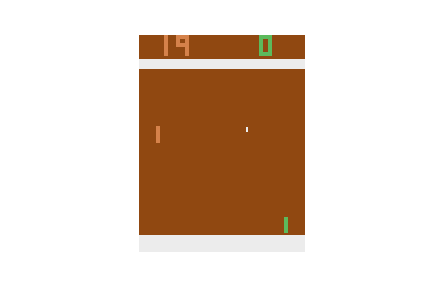
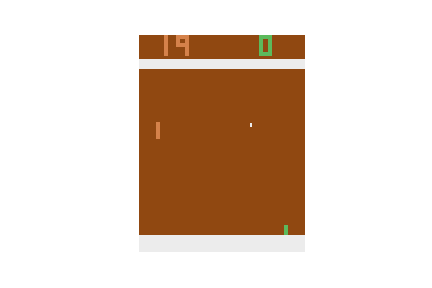
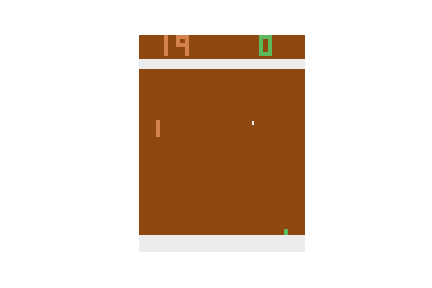
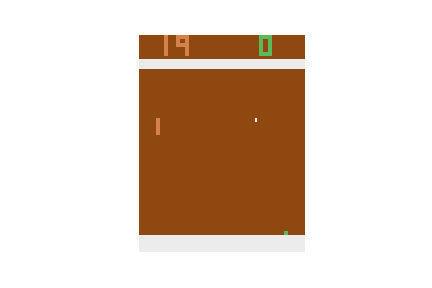
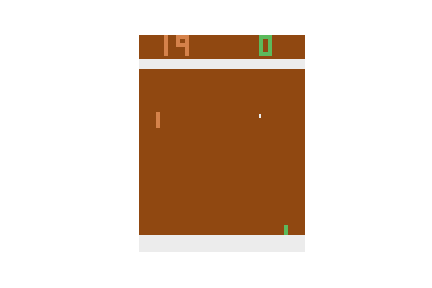
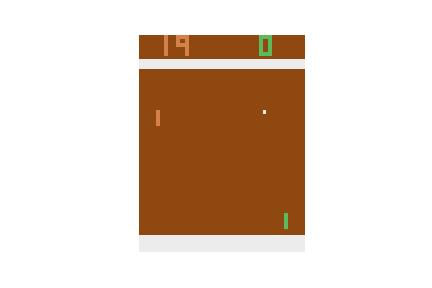
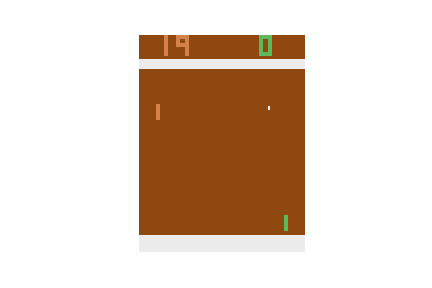
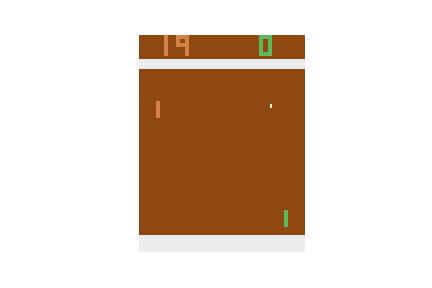
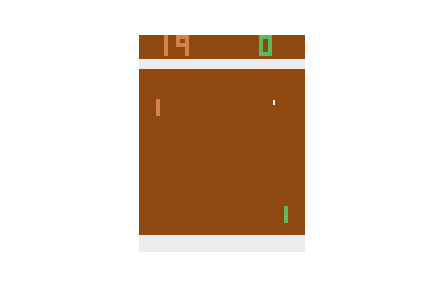
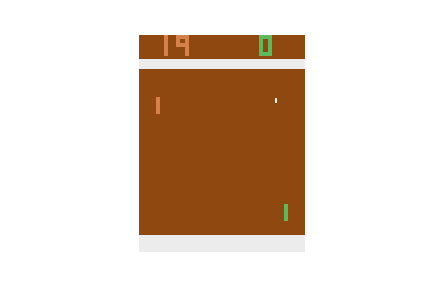
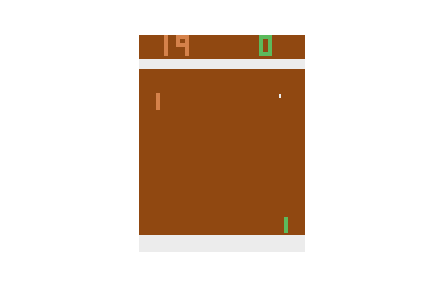
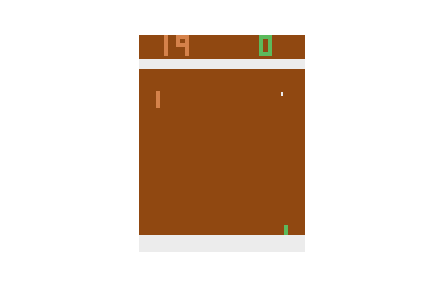
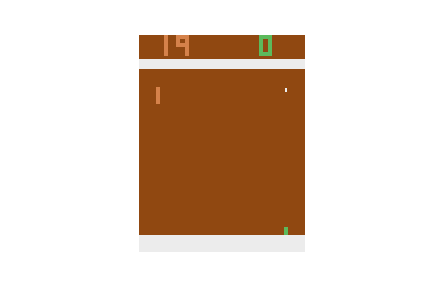
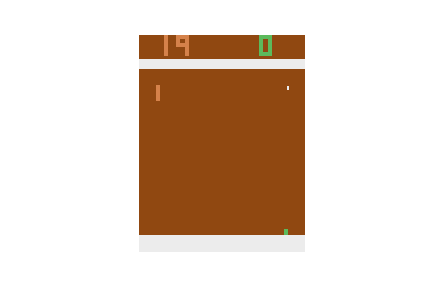
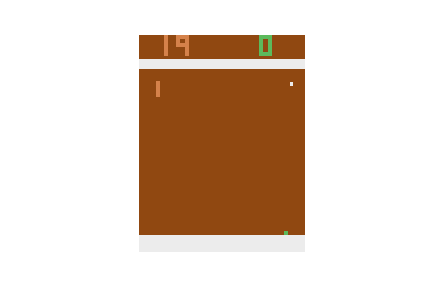
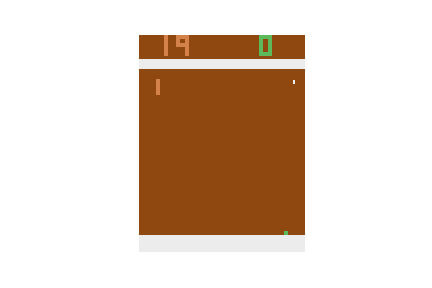
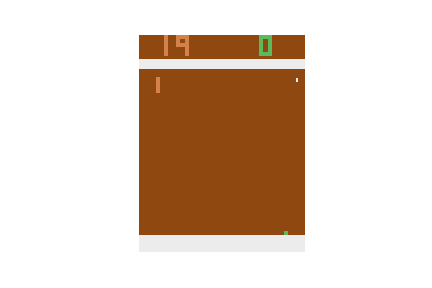
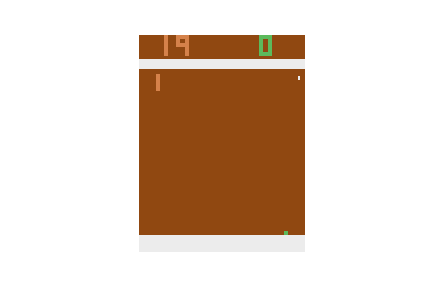
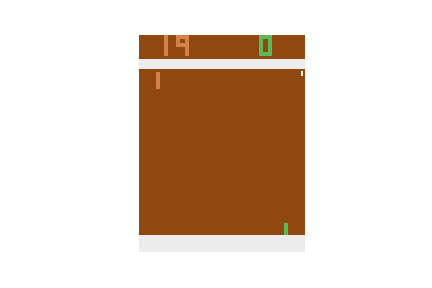
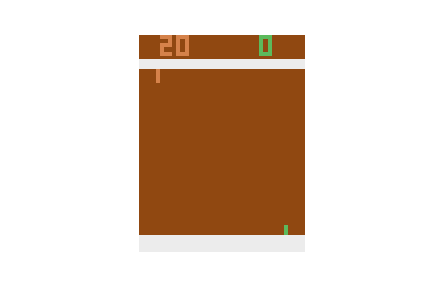
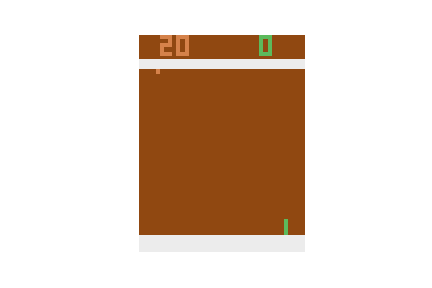
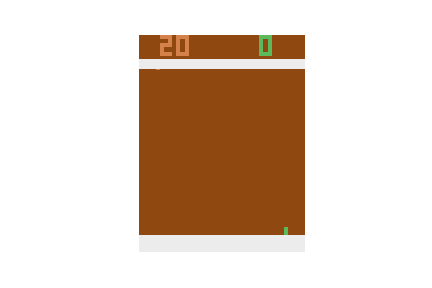
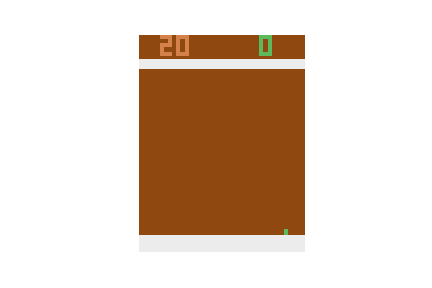
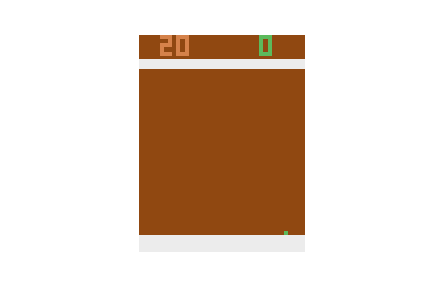
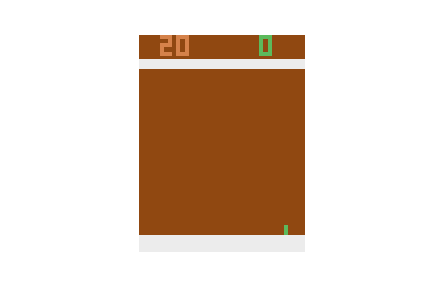
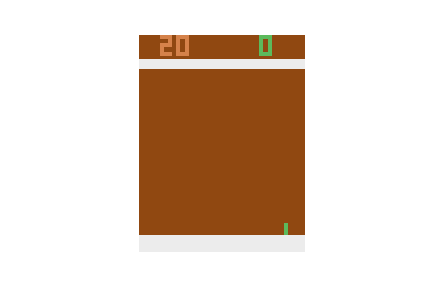
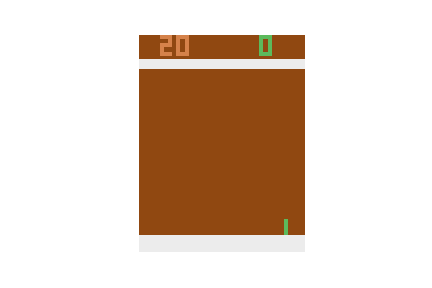
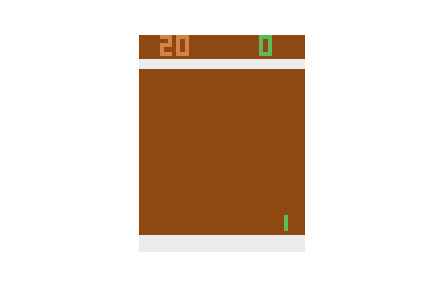
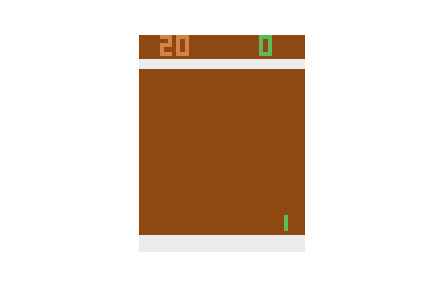
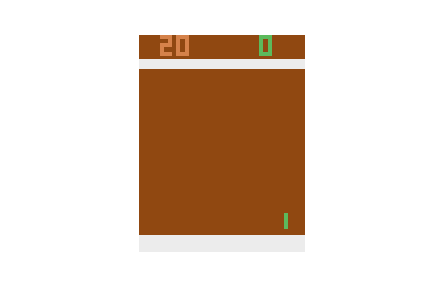
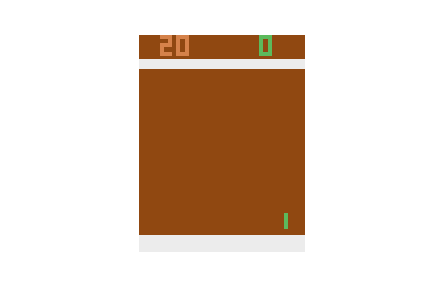
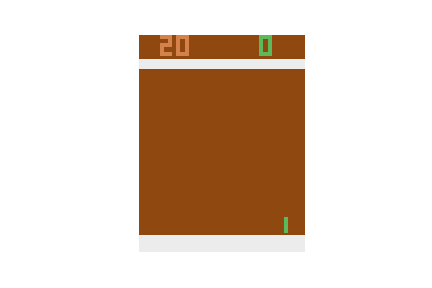
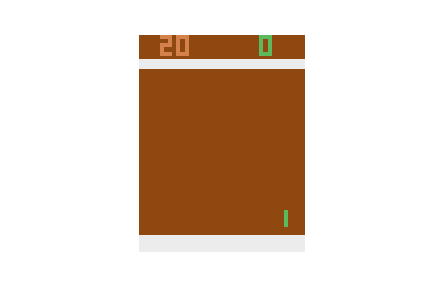
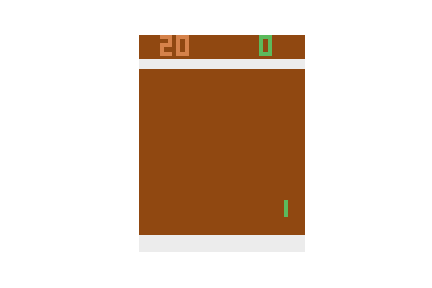
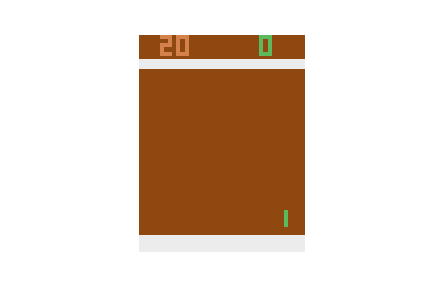
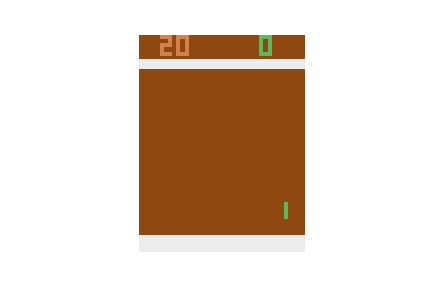
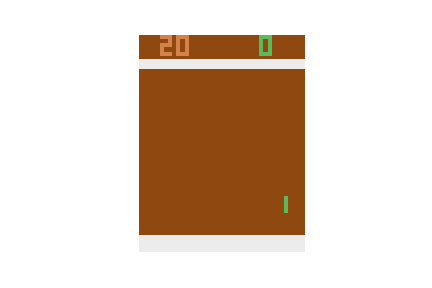
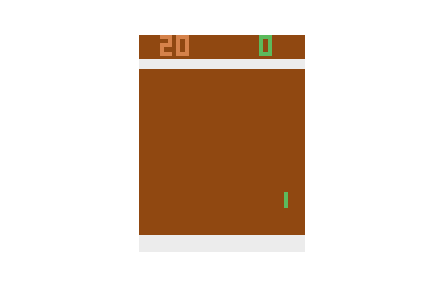
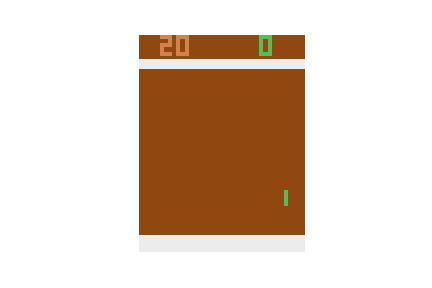
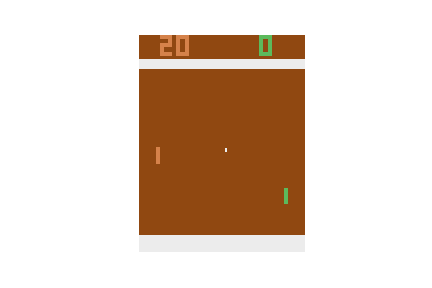
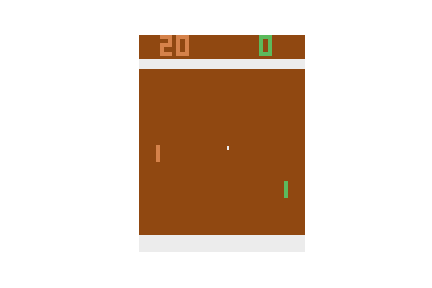
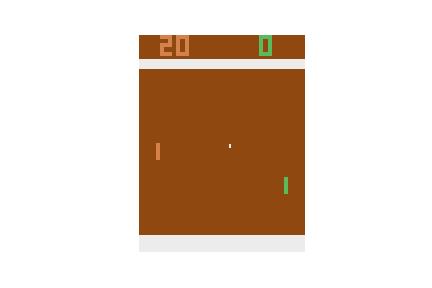
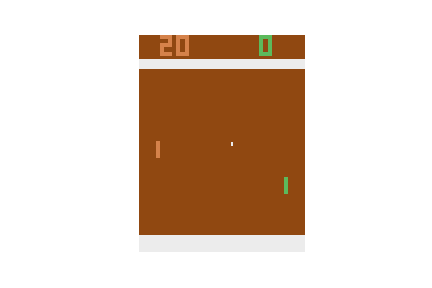
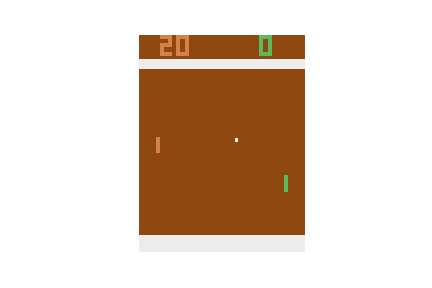
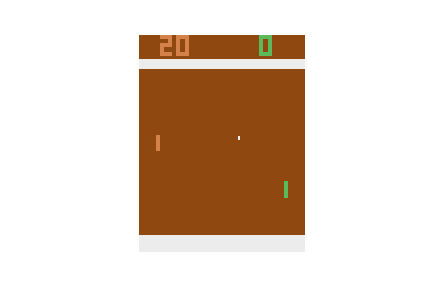
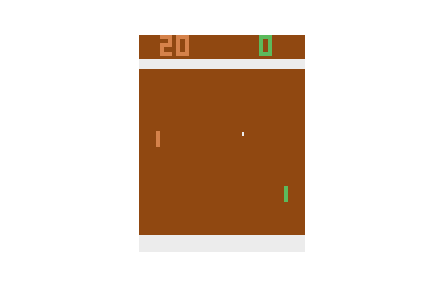
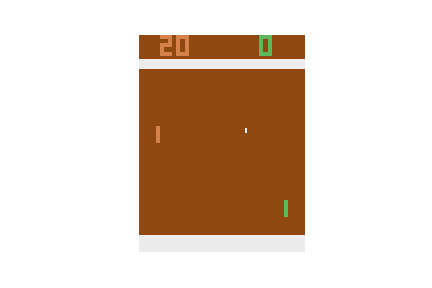
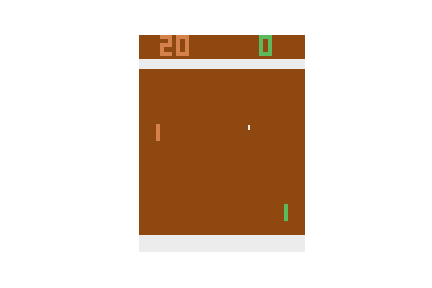
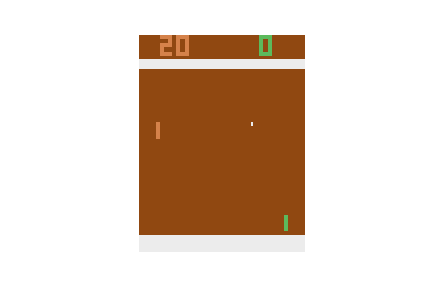
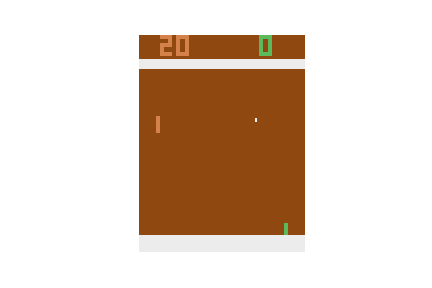
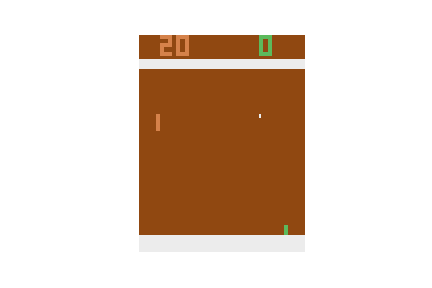
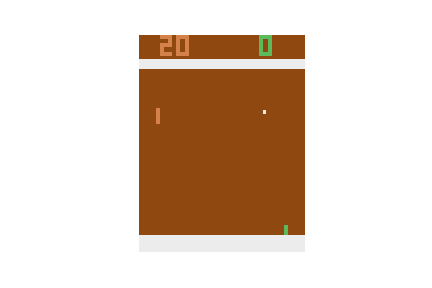
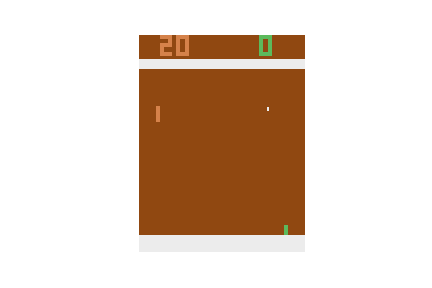
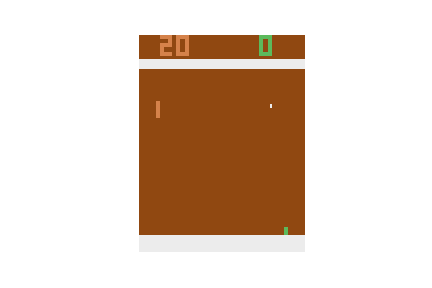
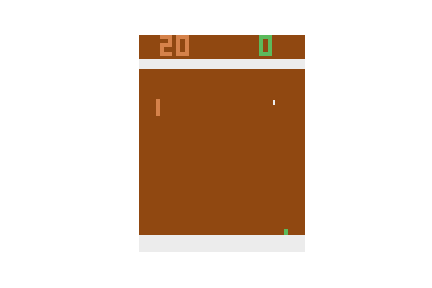
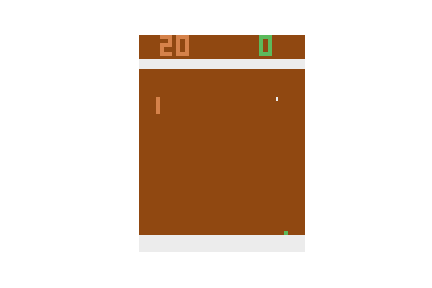
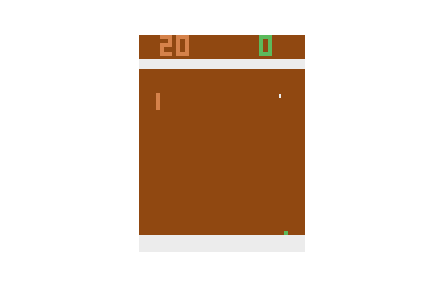
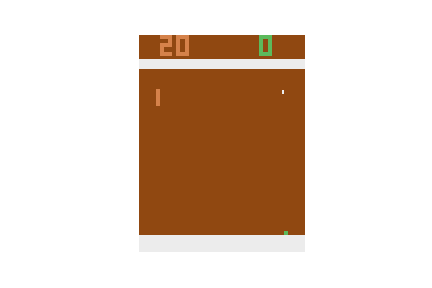
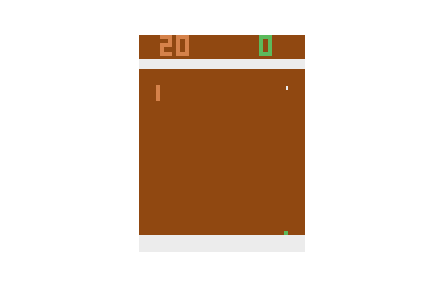
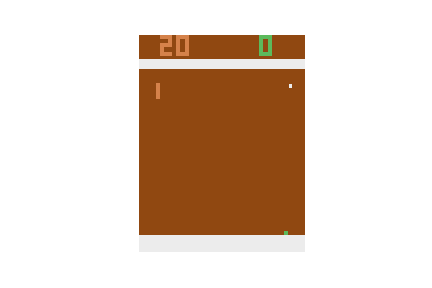
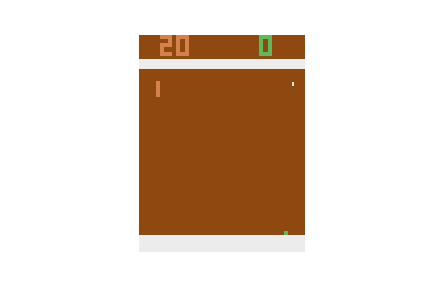
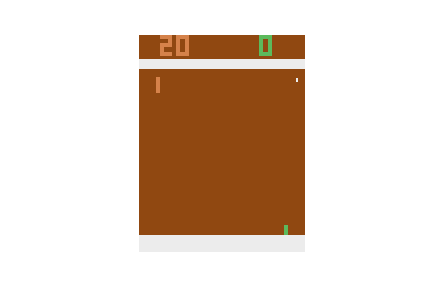
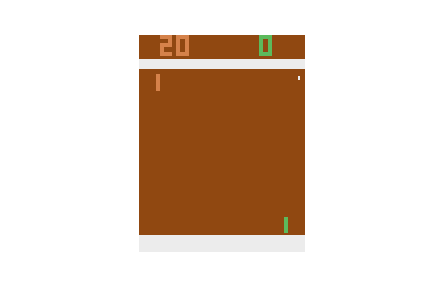
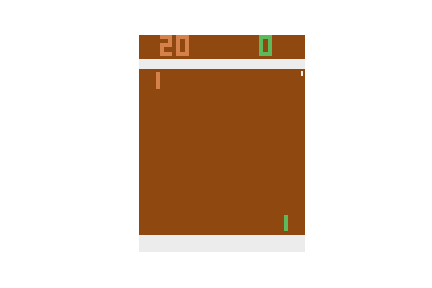
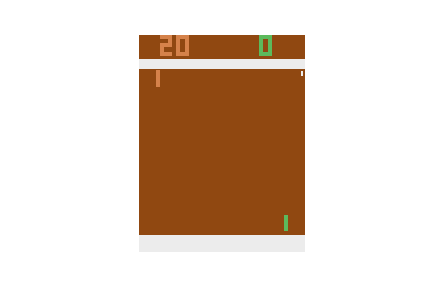

In [6]:
agent.display_game(29)

Game reward


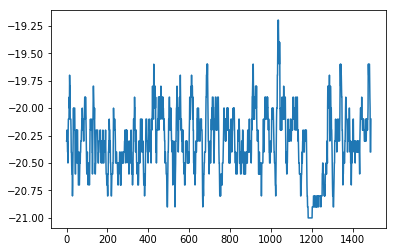

Policy epsilon


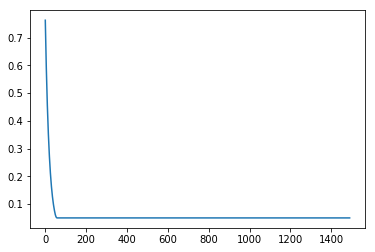

Learning rate


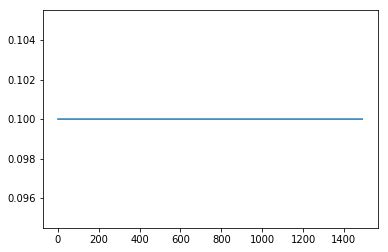

In [7]:
training_history = np.array(agent.training_history)
average_n_games = agent.group_n_games
print("Game reward")
plt.plot(np.convolve(training_history[:,0], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()
print("Policy epsilon")
plt.plot(np.convolve(training_history[:,1], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()
print("Learning rate")
plt.plot(np.convolve(training_history[:,2], np.ones((average_n_games,))/average_n_games, mode='valid'))
plt.show()

# Load and Run Model

In [8]:
import pickle

agent = Agent()
agent.brain.Q.load_state_dict(torch.load("saved_pong_weights.data"))
with open('saved_pong_history.pickle', 'rb') as handle:
    saved_info = pickle.load(handle)
    agent.game_frames = saved_info[0]
    agent.game_info = saved_info [1]

quality, action
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 3
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316

[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 4
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 3
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 4
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 4
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592

[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 4
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 0
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 2
[-0.45213592

[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 5
[-0.45213592 -0.5417158  -0.40280443 -0.46986473 -0.52632385 -0.51479316] 1



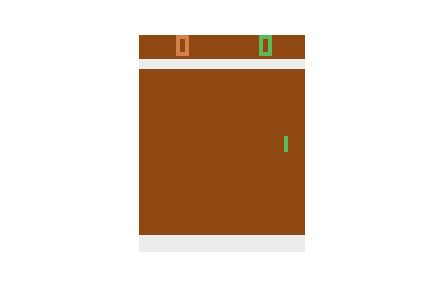
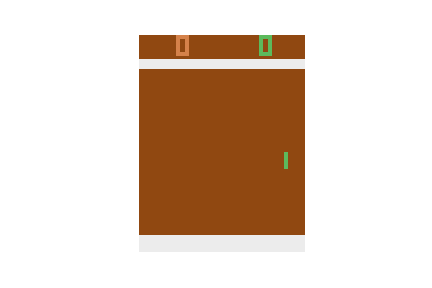
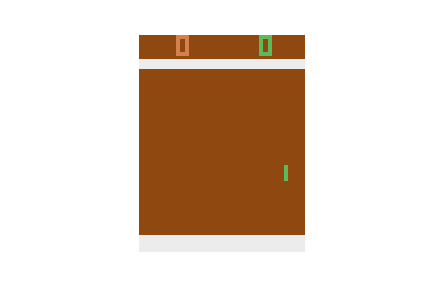
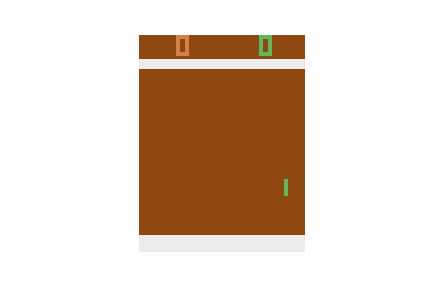
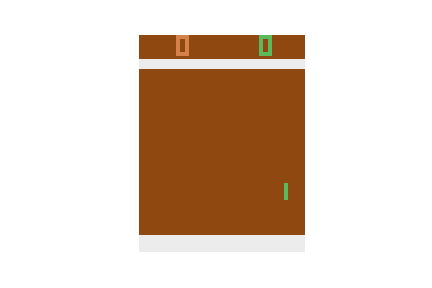
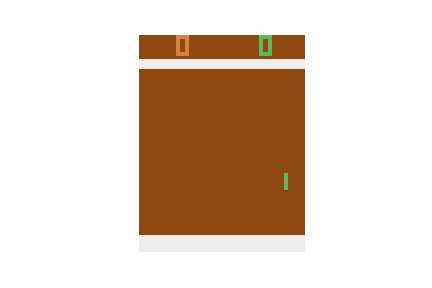
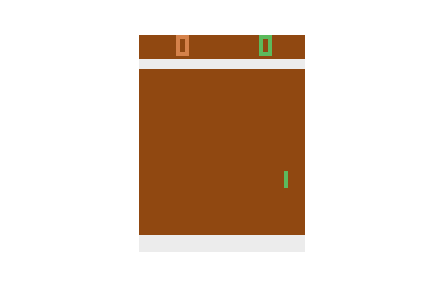
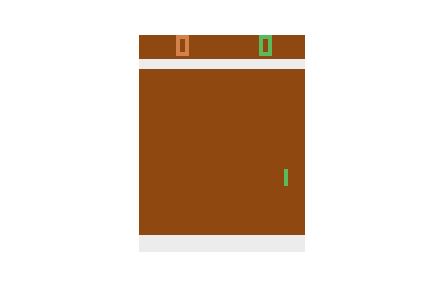
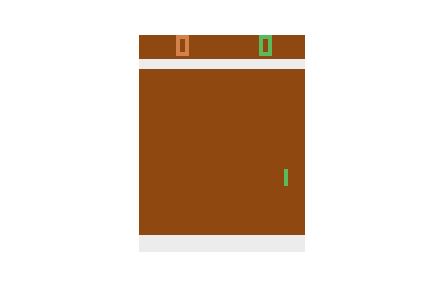
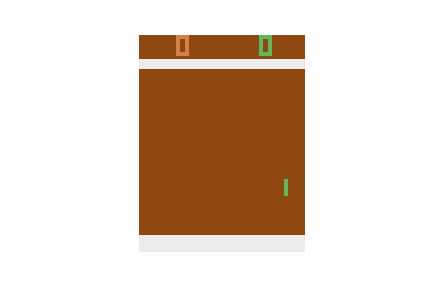
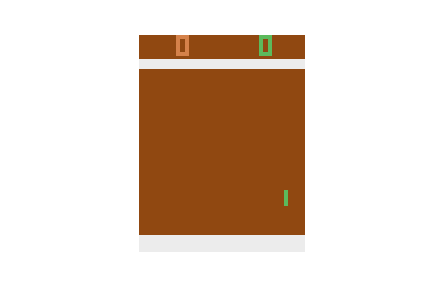
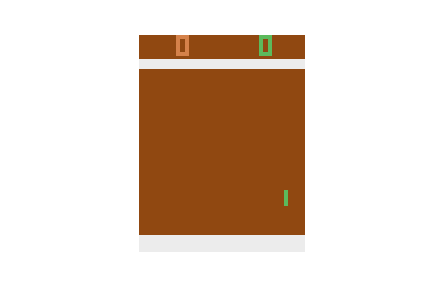
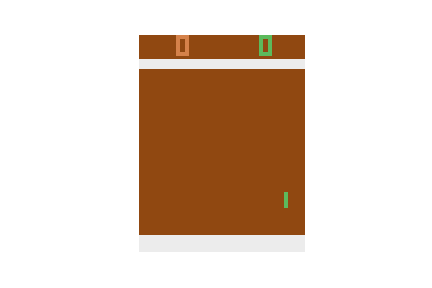
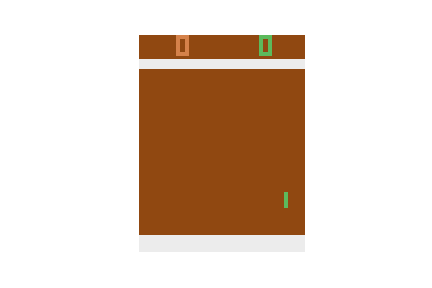
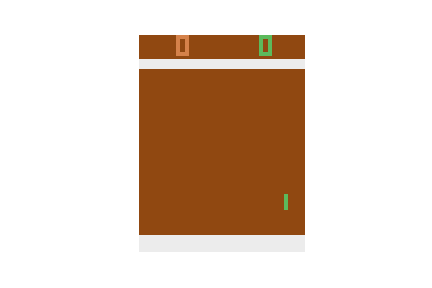
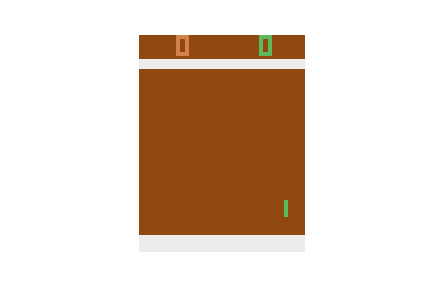
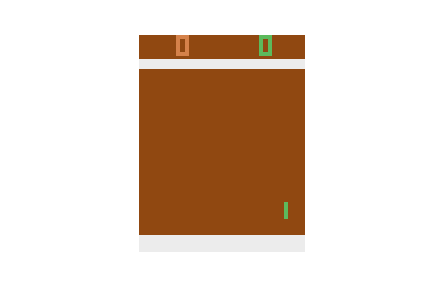
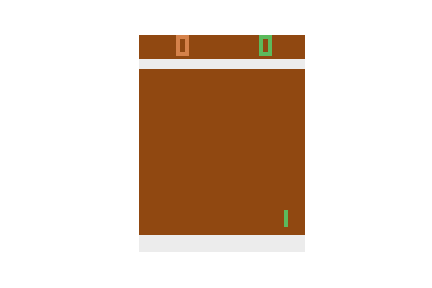
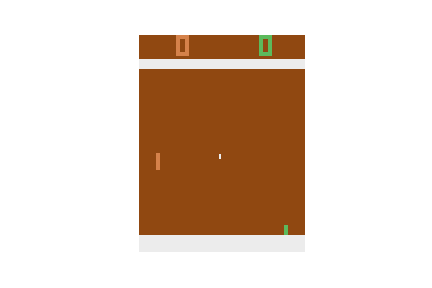
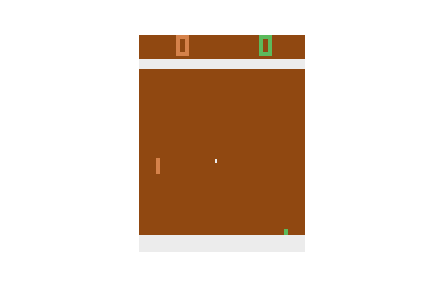
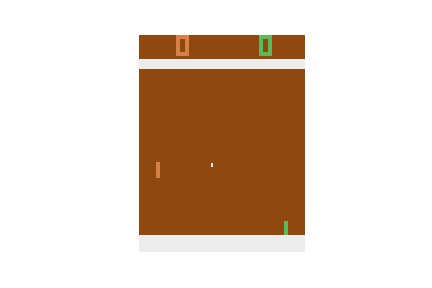
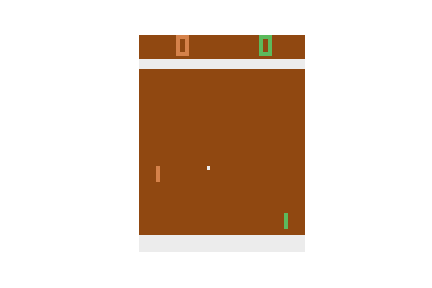
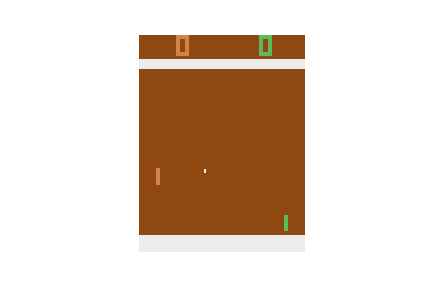
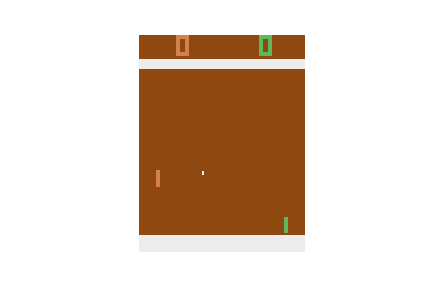
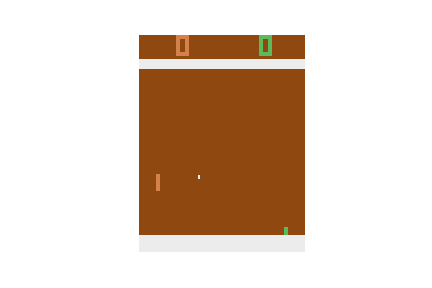
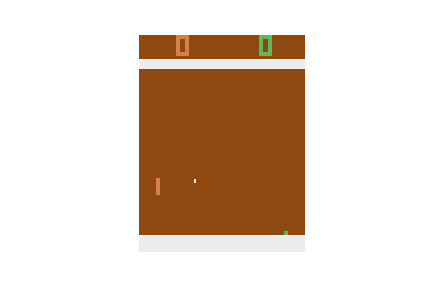
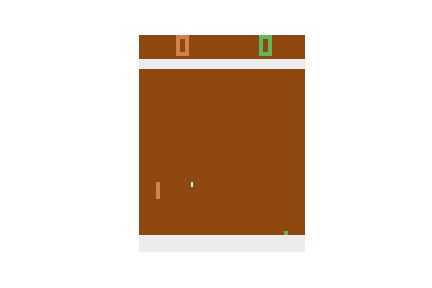
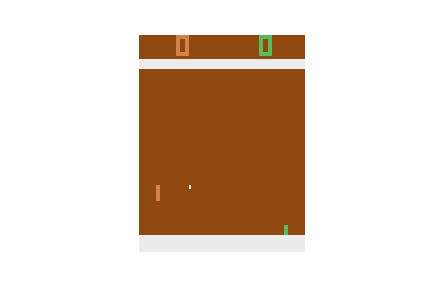
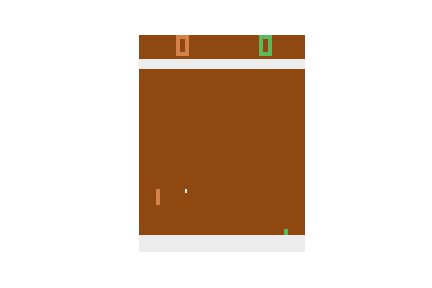
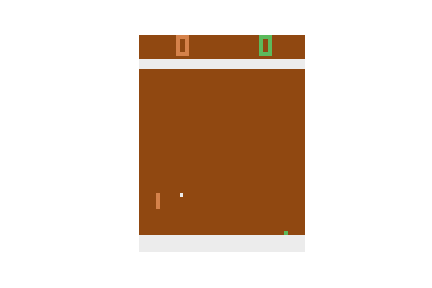
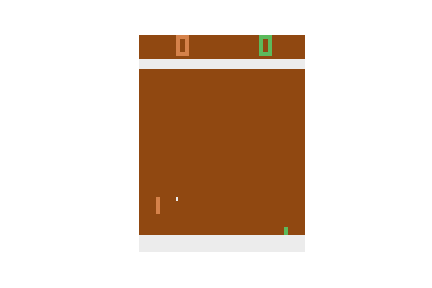
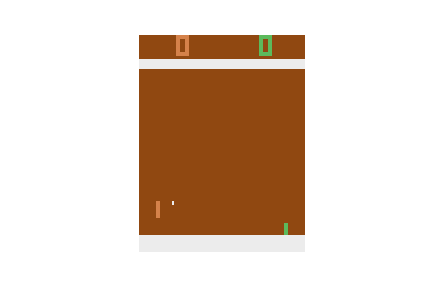
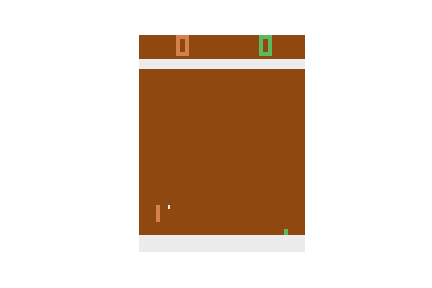
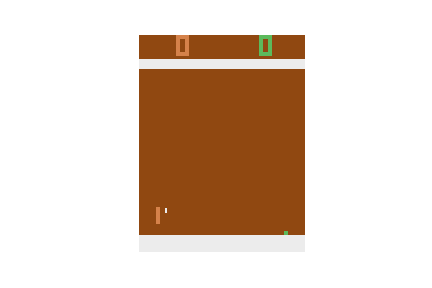
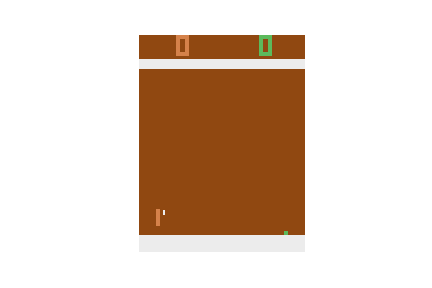
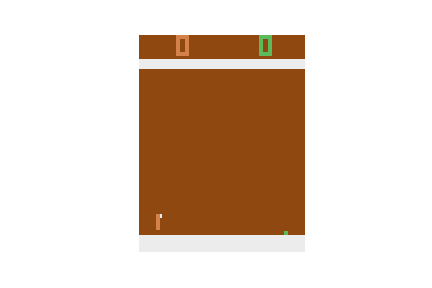
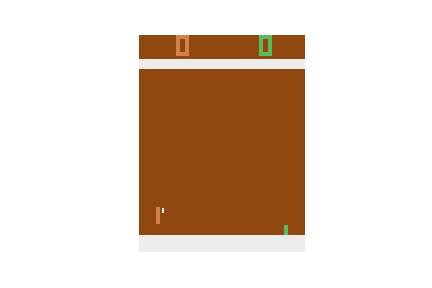
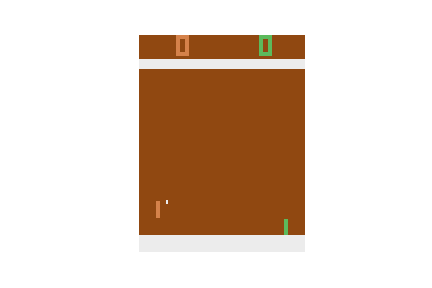
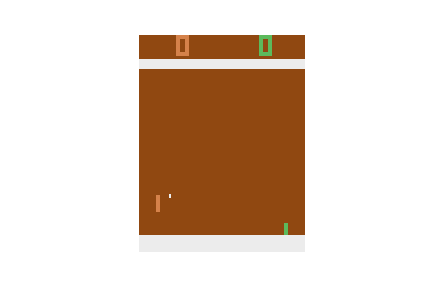
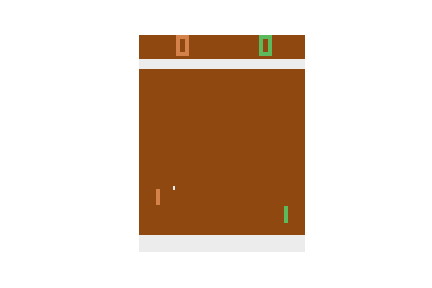
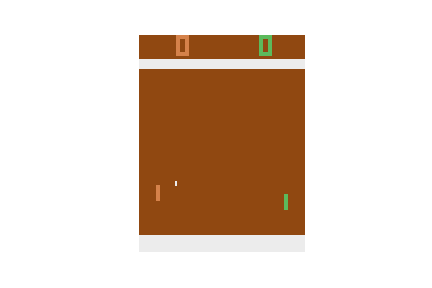
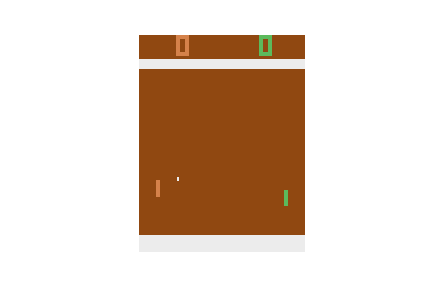
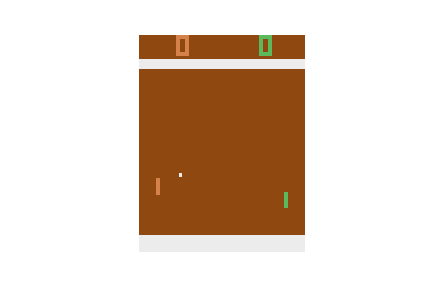
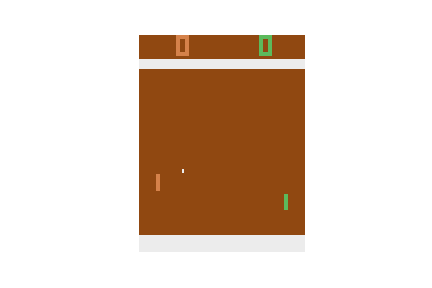
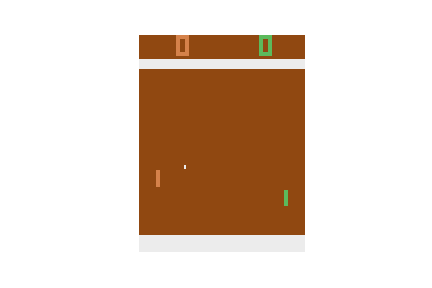
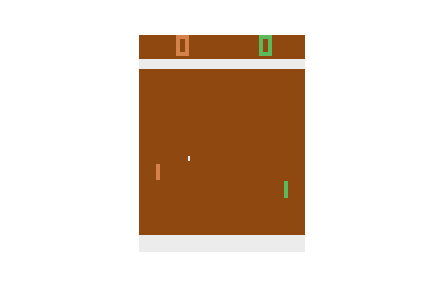
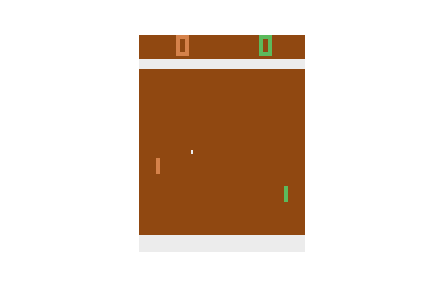
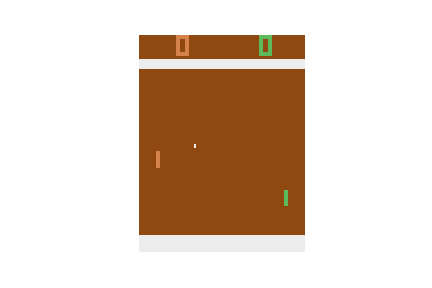
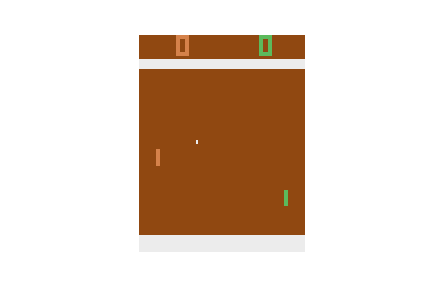
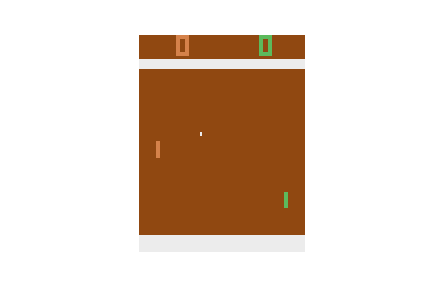
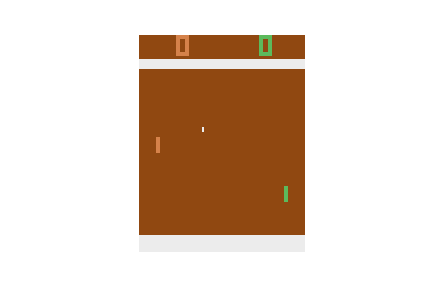
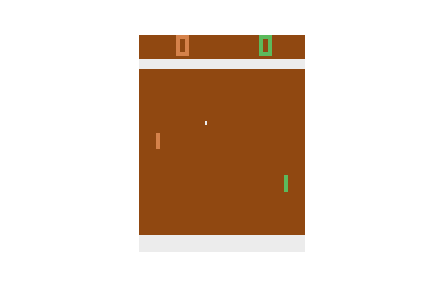
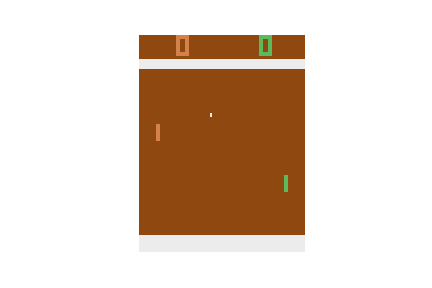
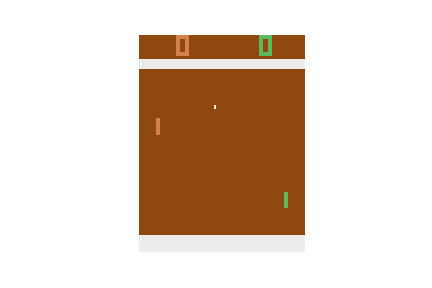
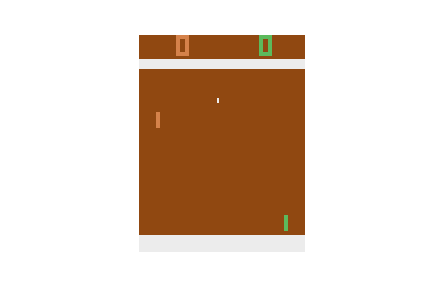
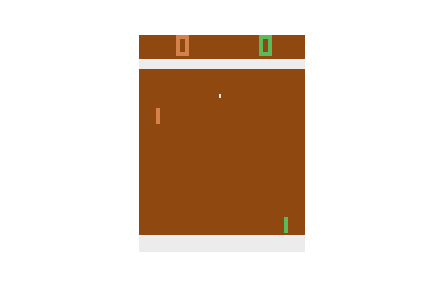
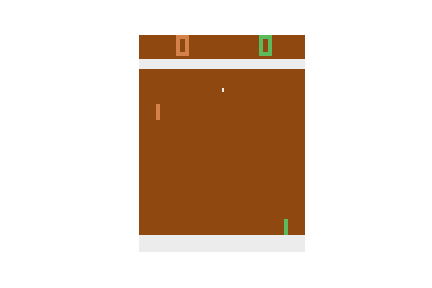
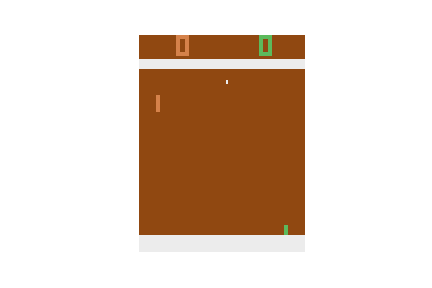
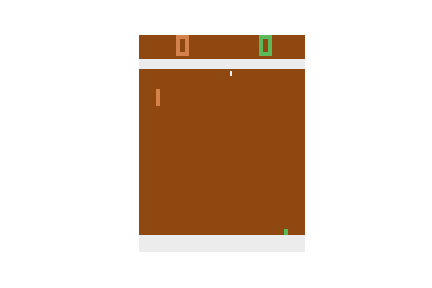
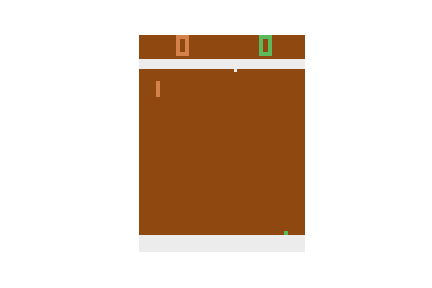
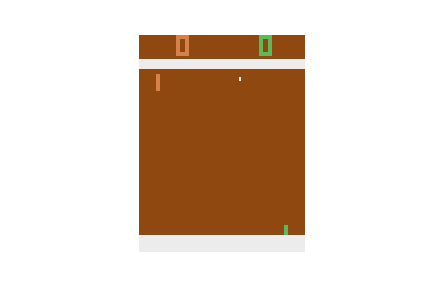
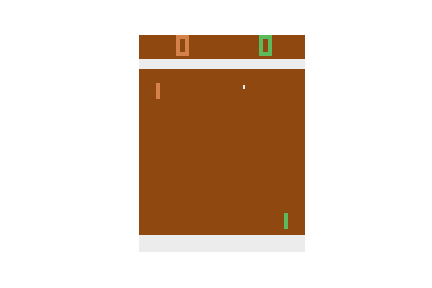
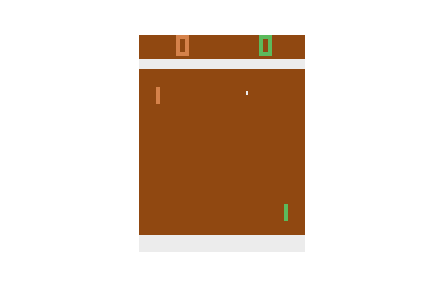
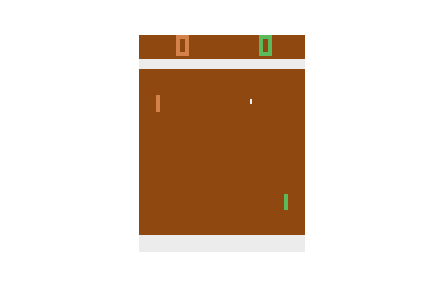
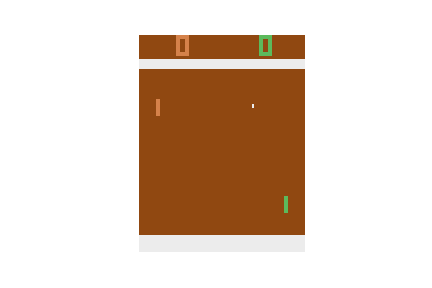
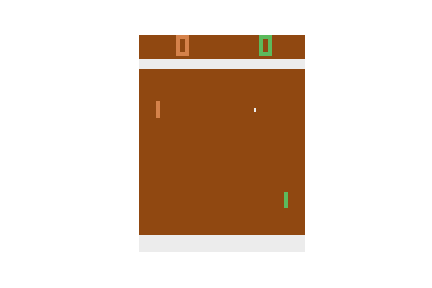
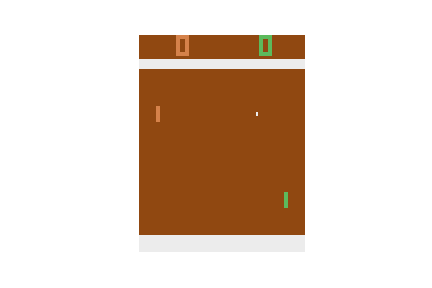
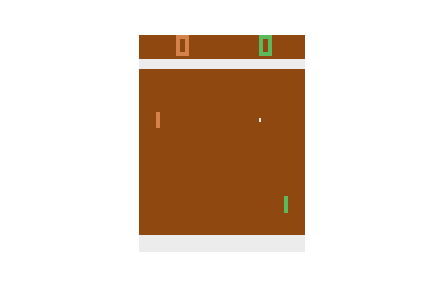
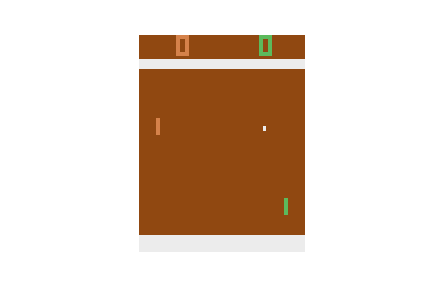
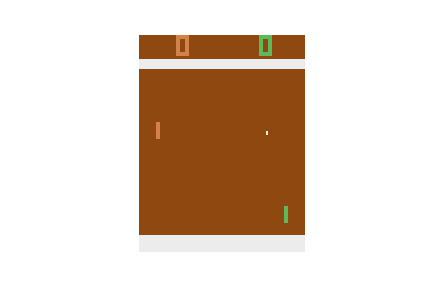
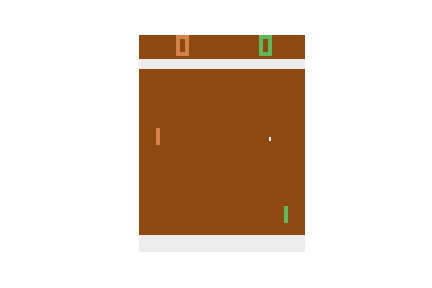
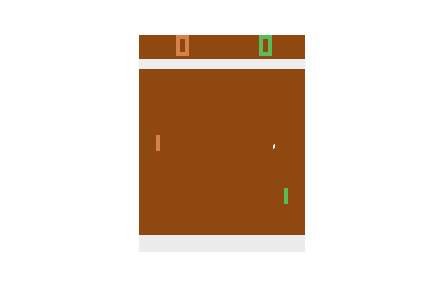
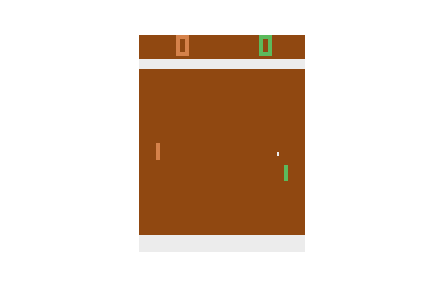
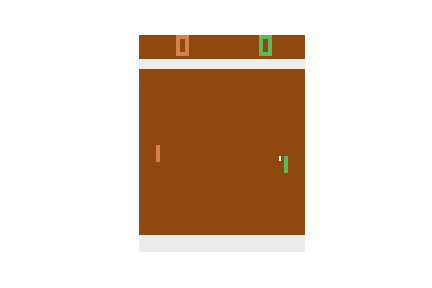
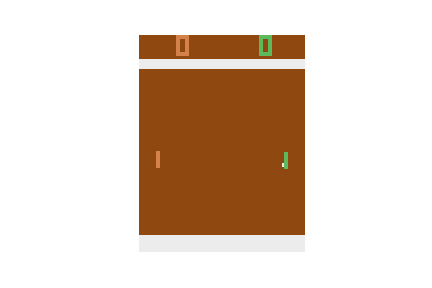
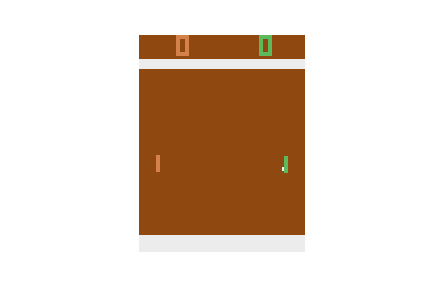
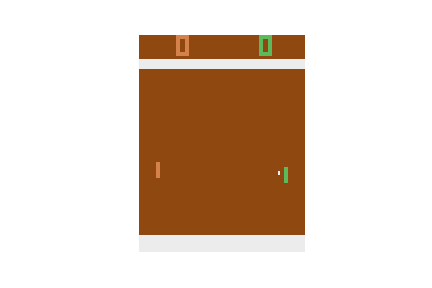
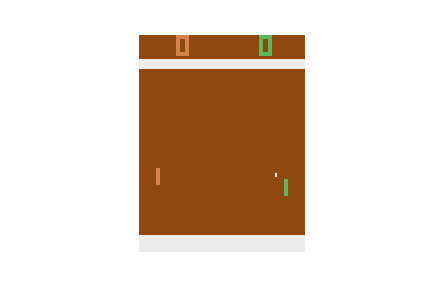
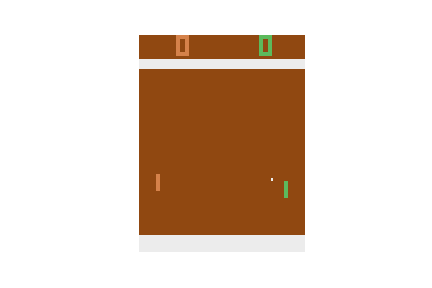
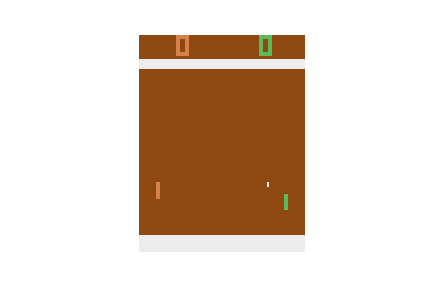
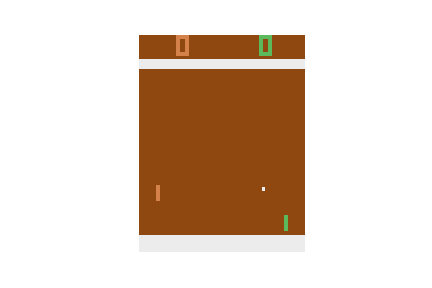
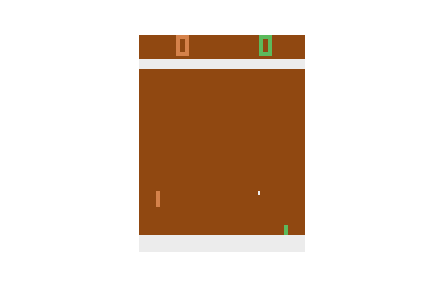
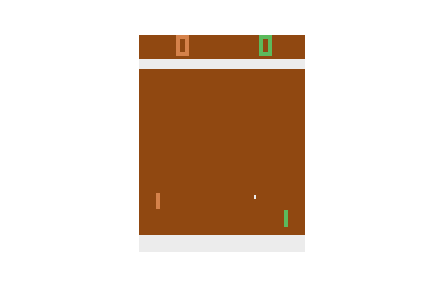
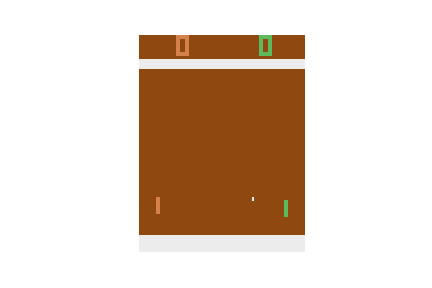
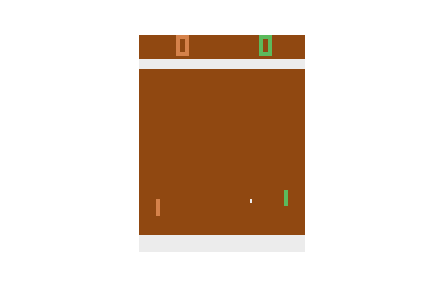
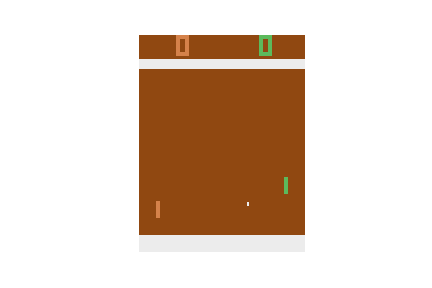
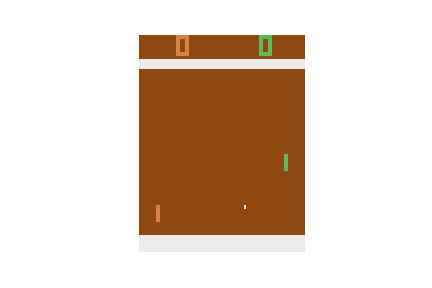
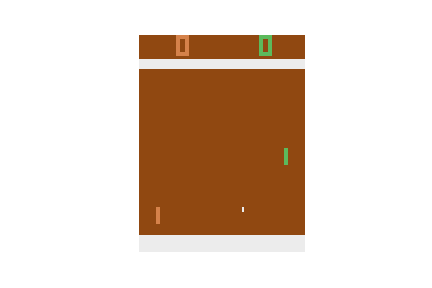
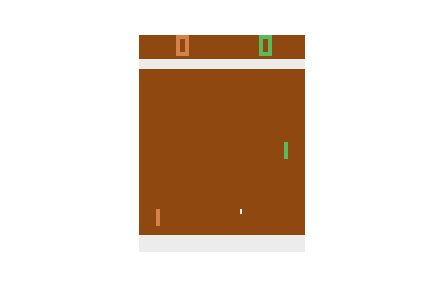
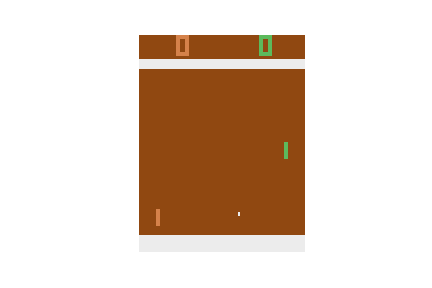
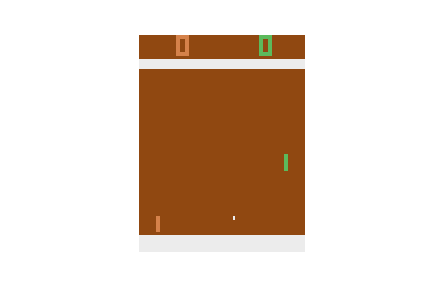
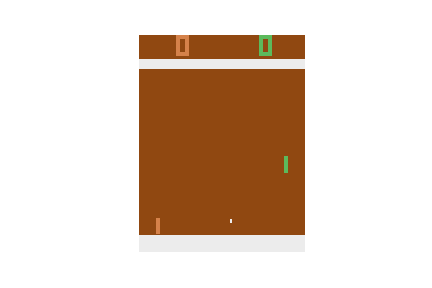
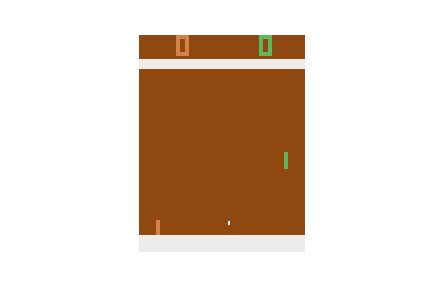
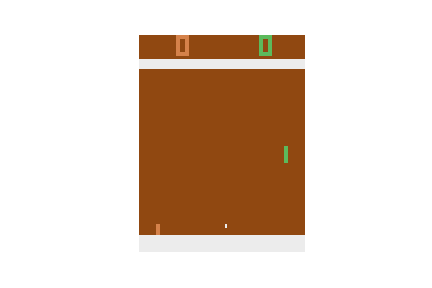
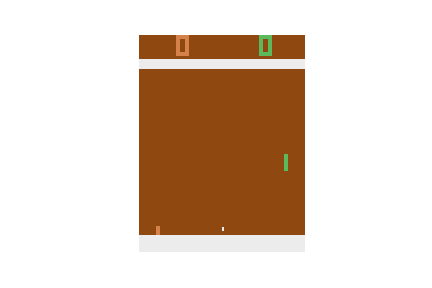
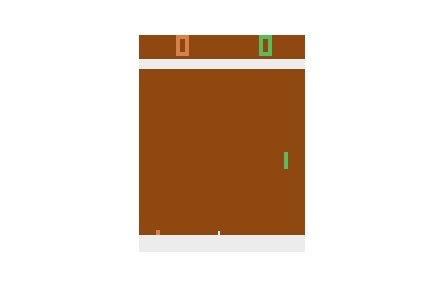
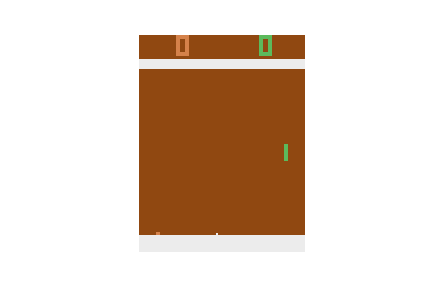
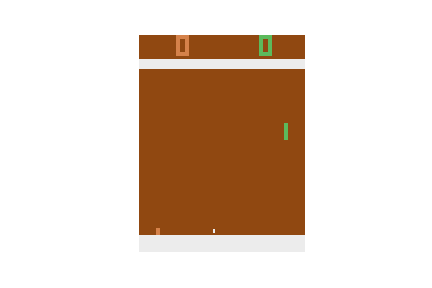
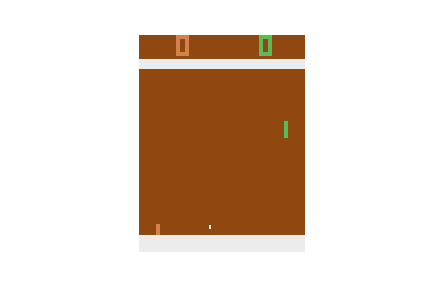
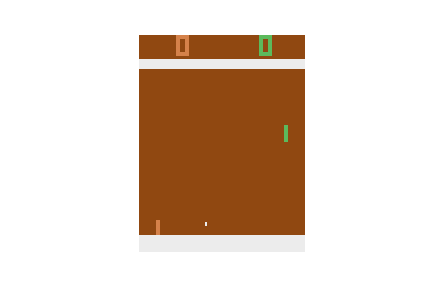
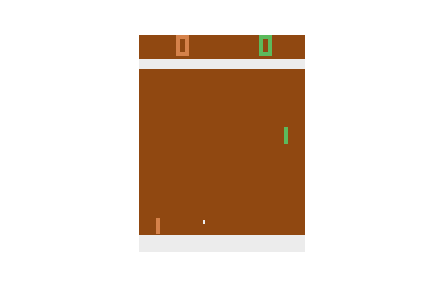
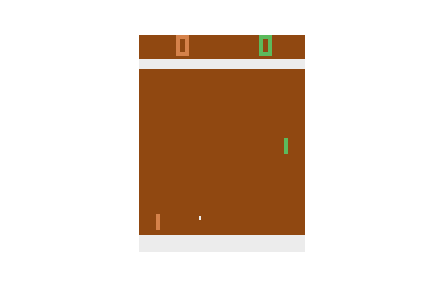
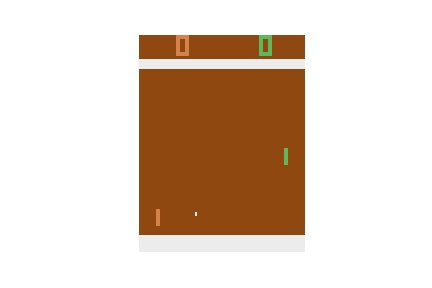
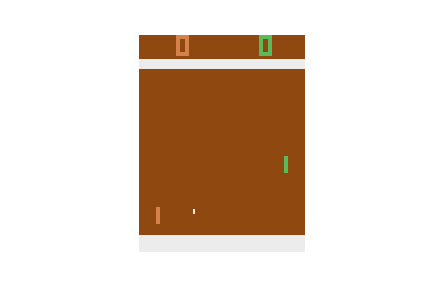
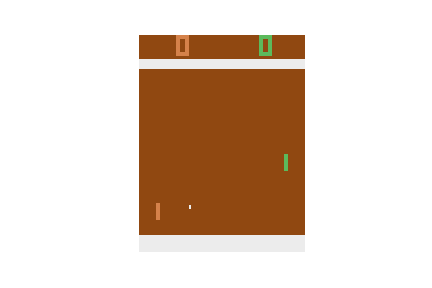
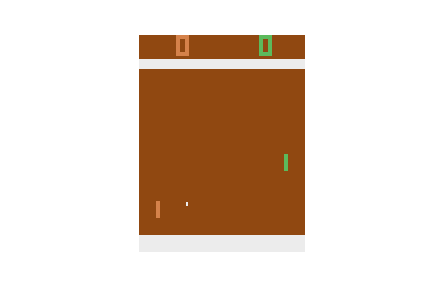
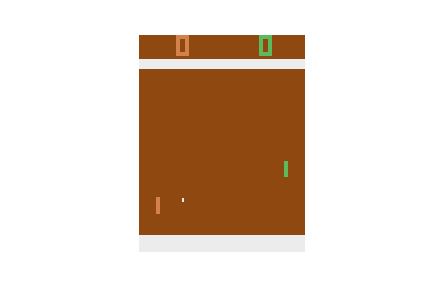
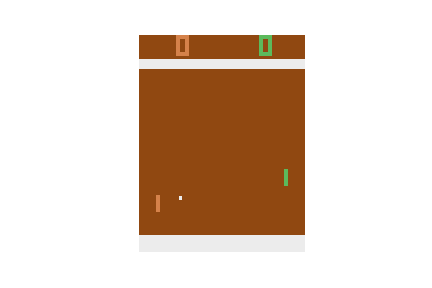
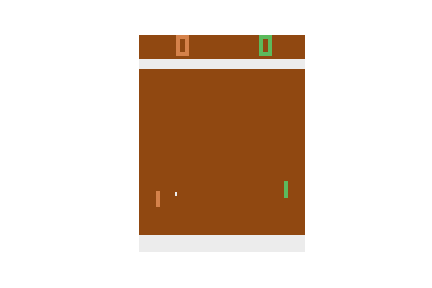
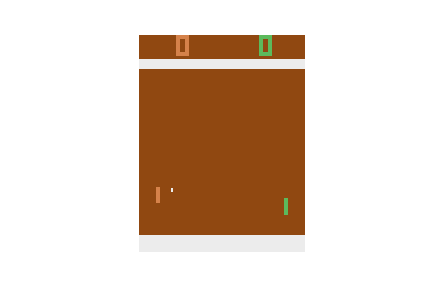
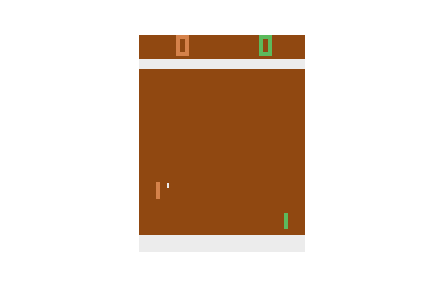
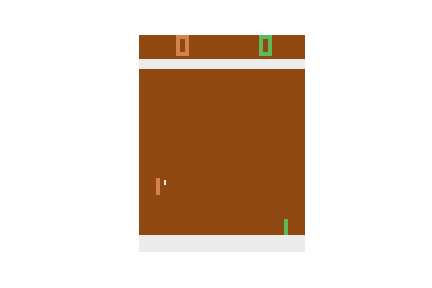
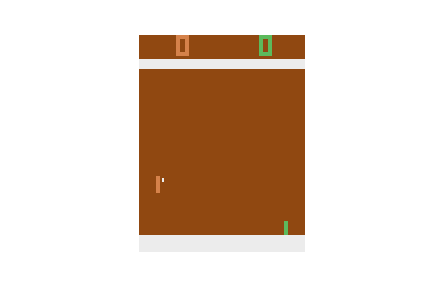
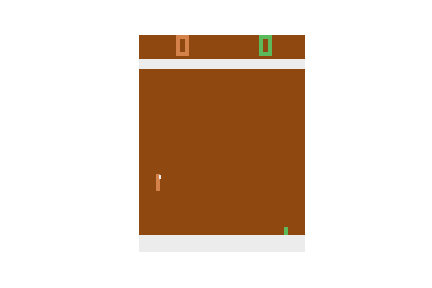
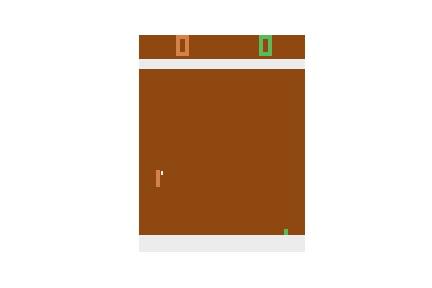
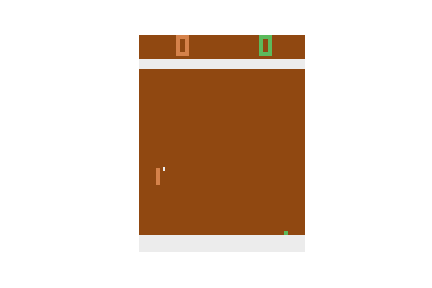
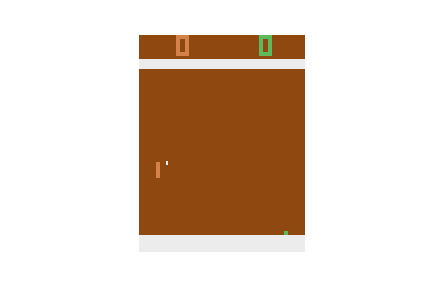
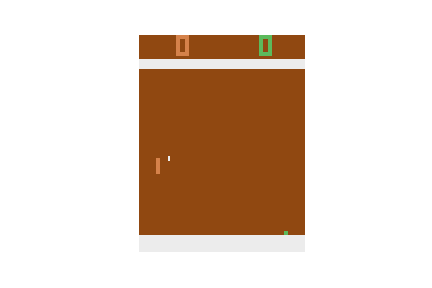
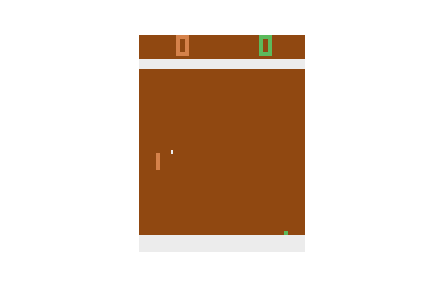
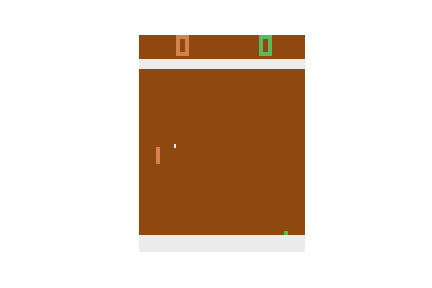
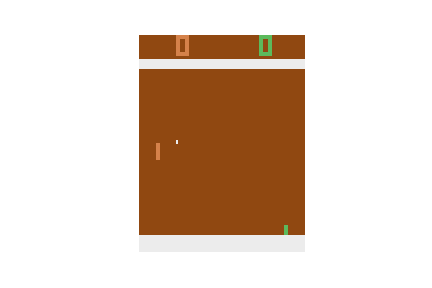
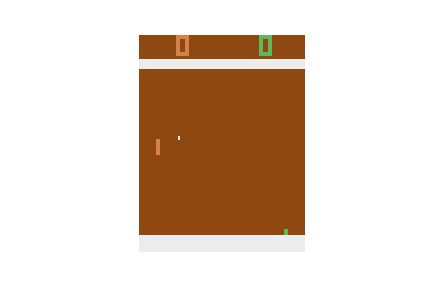
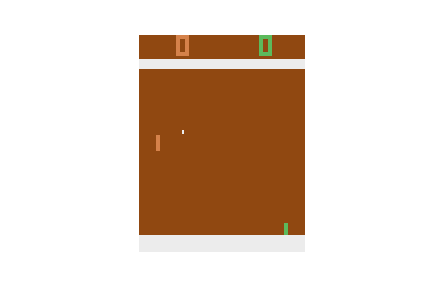
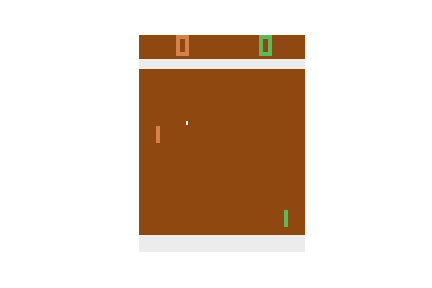
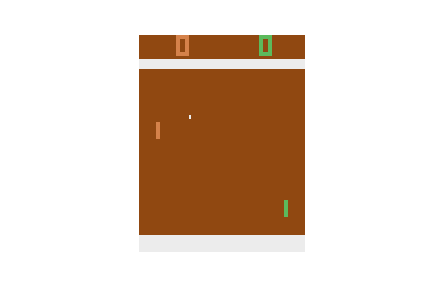
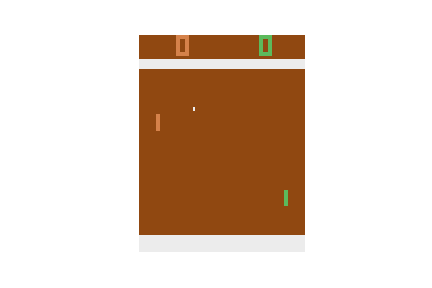
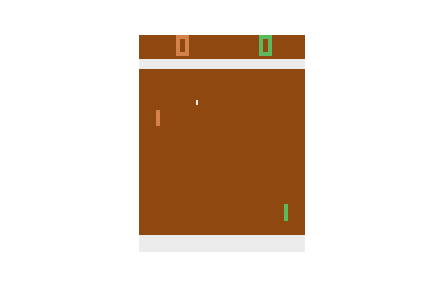
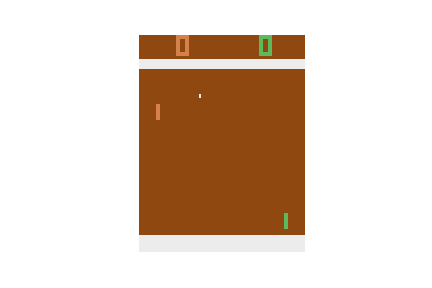
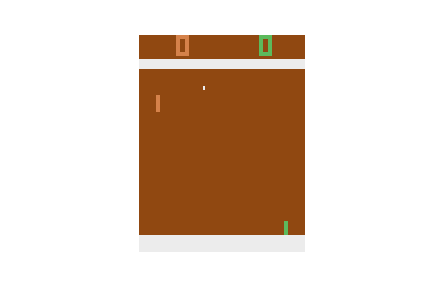
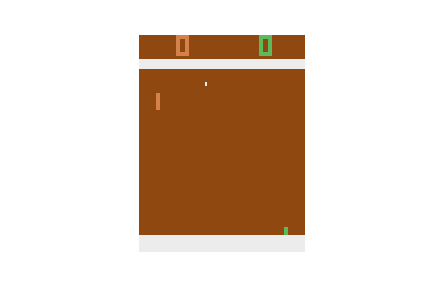
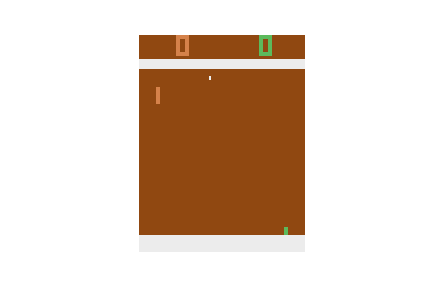
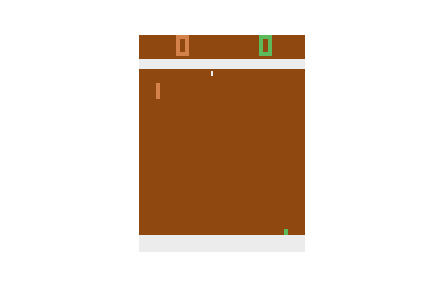
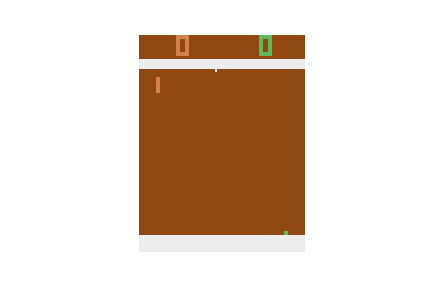
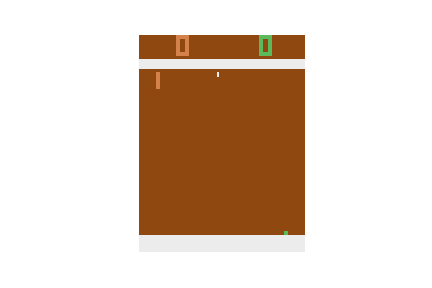
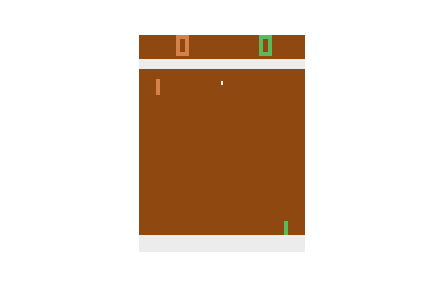
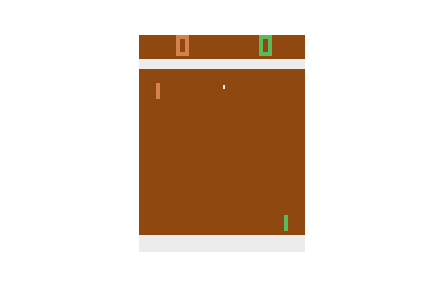
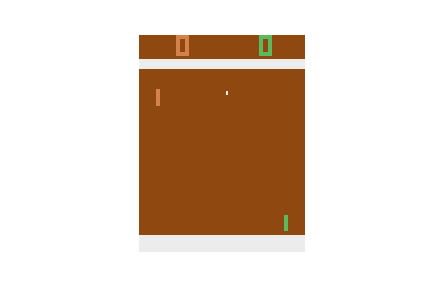
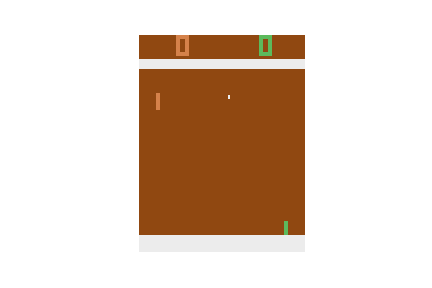
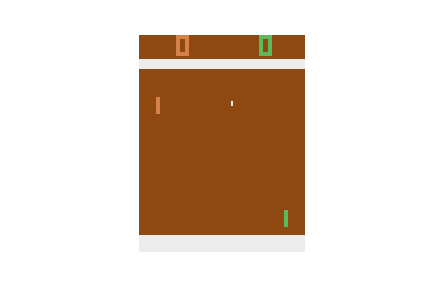
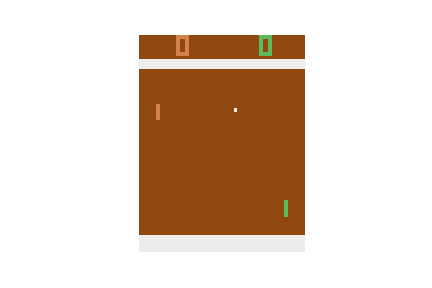
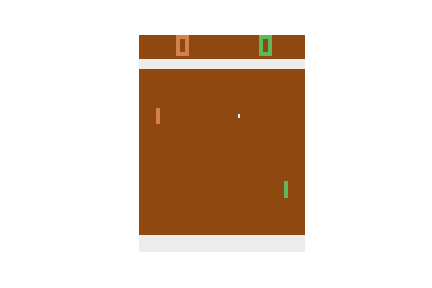
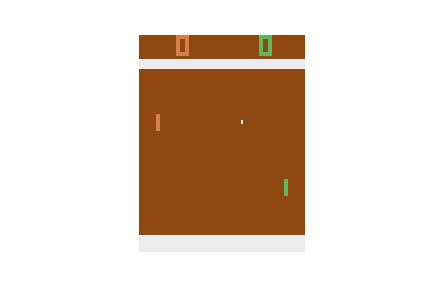
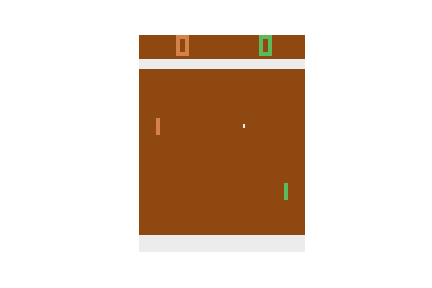
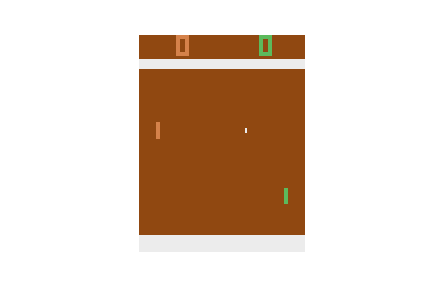
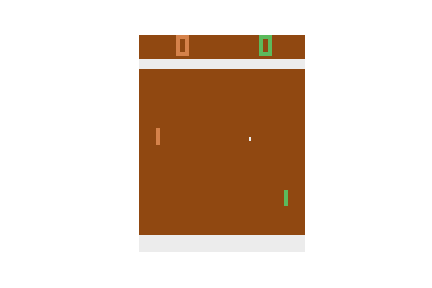
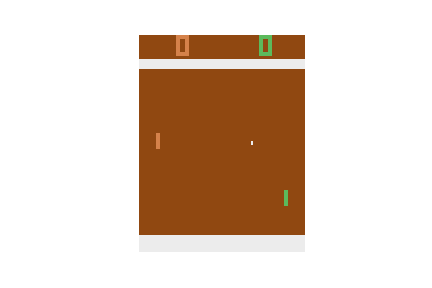
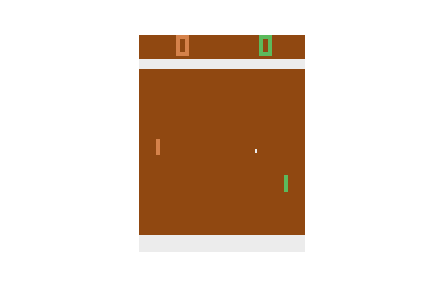
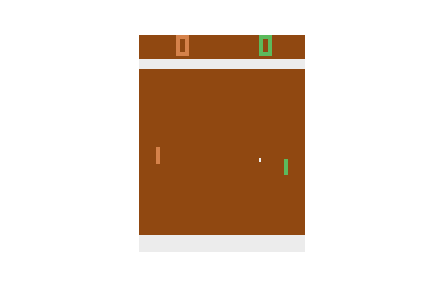
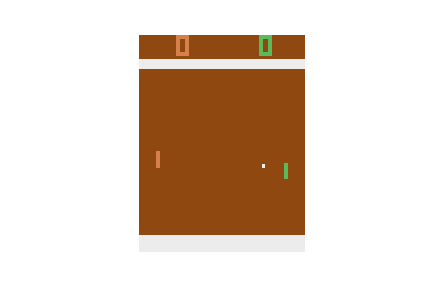
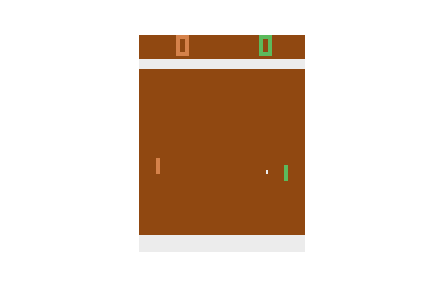
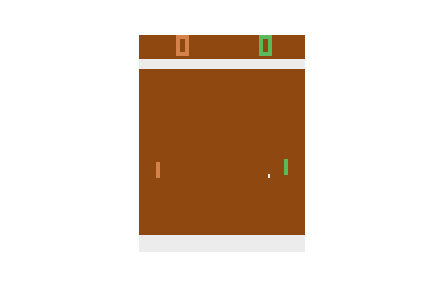
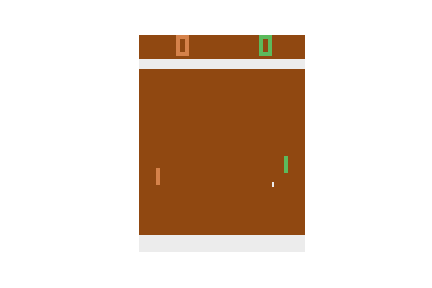
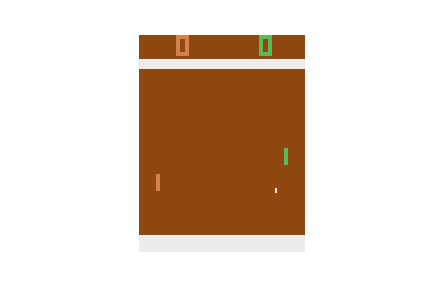
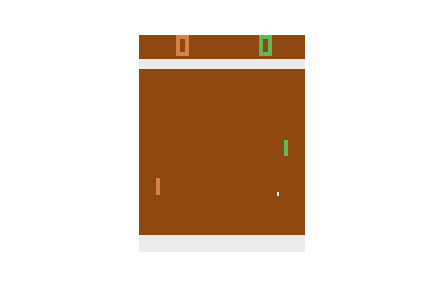
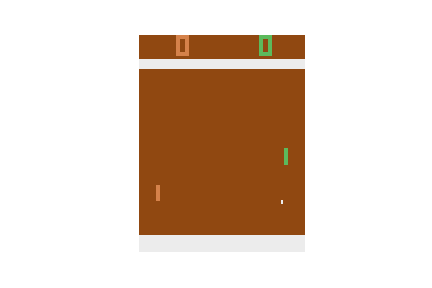
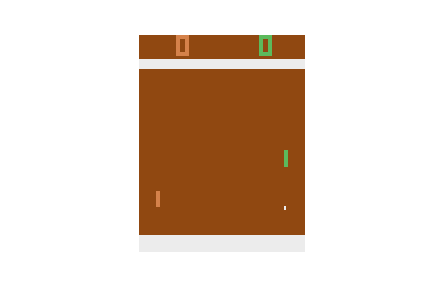
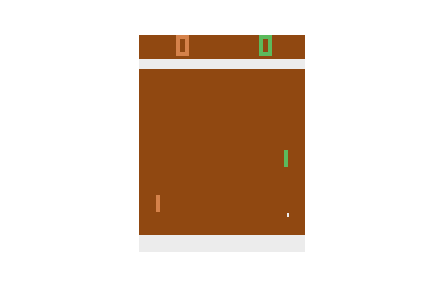
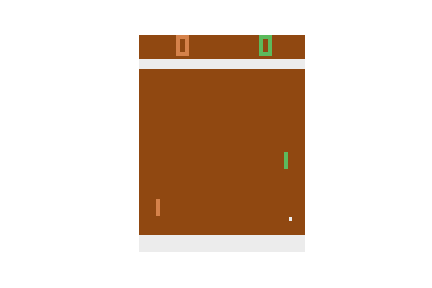
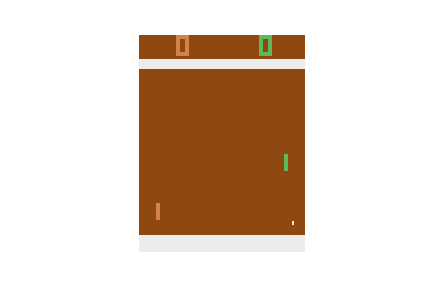
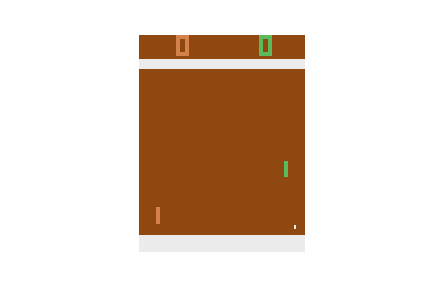
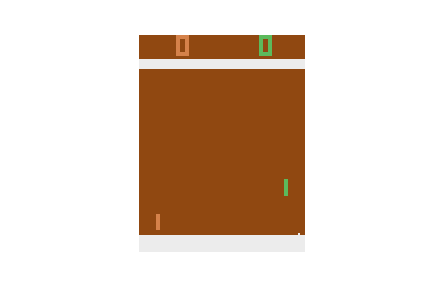
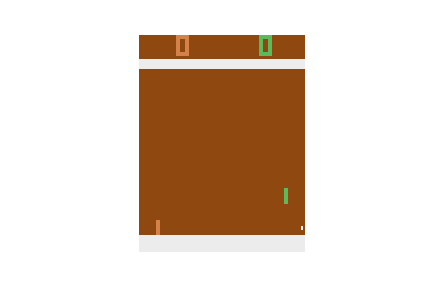
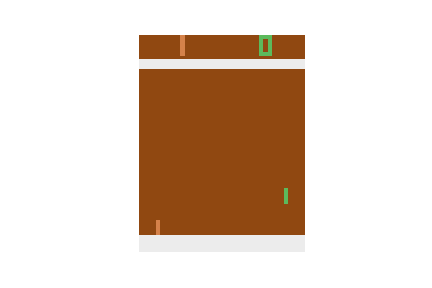
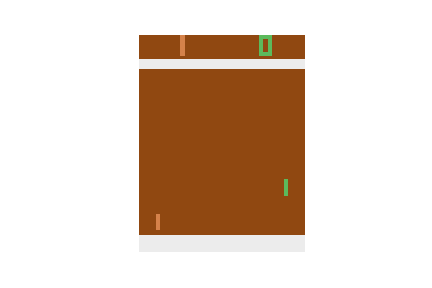
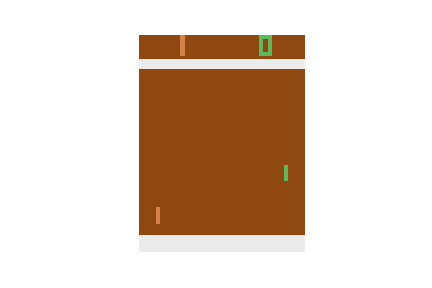
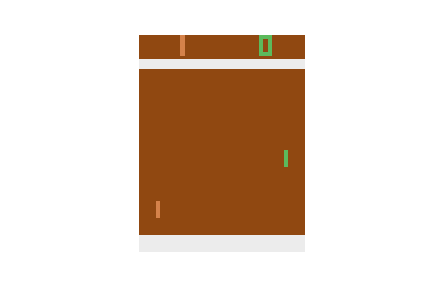
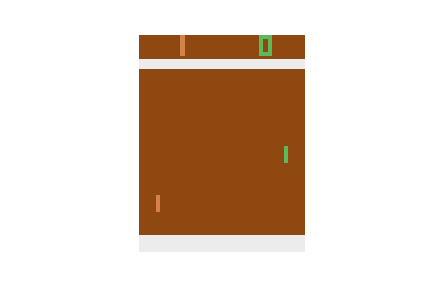
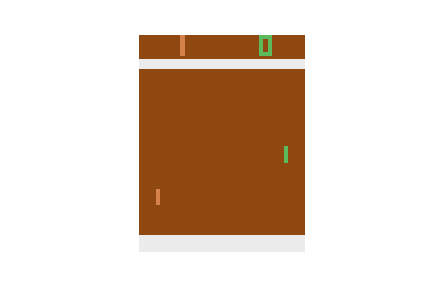
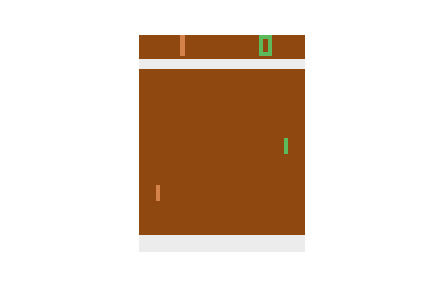
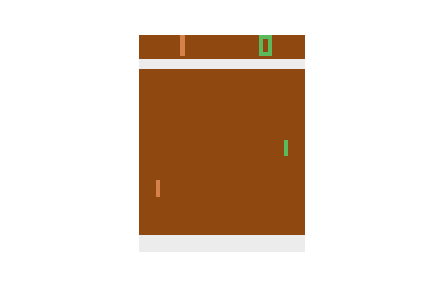
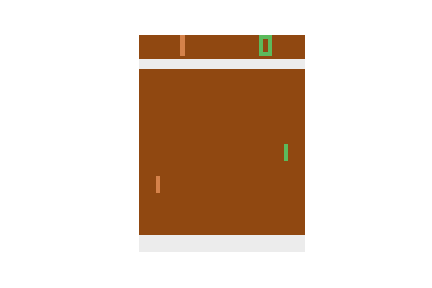
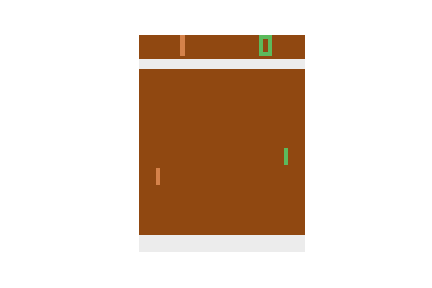
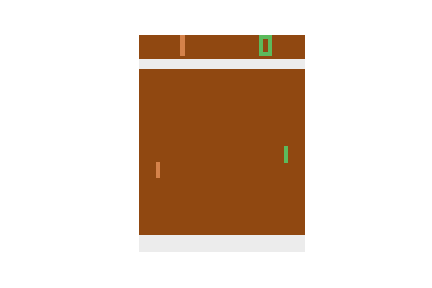
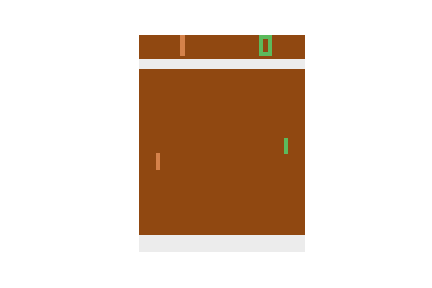
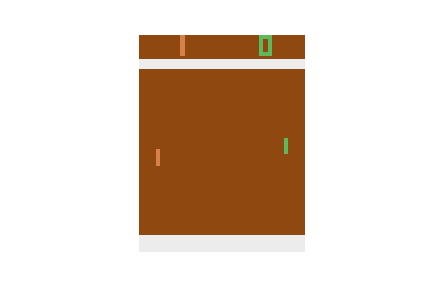
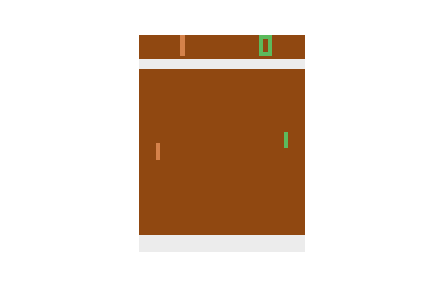
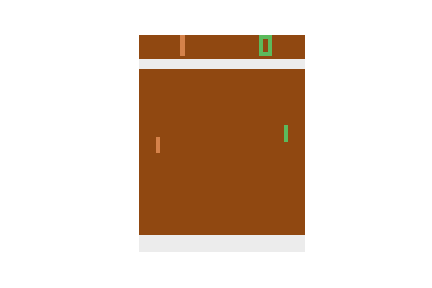
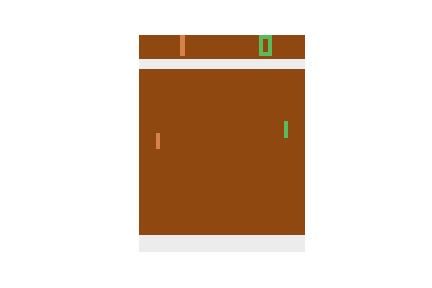
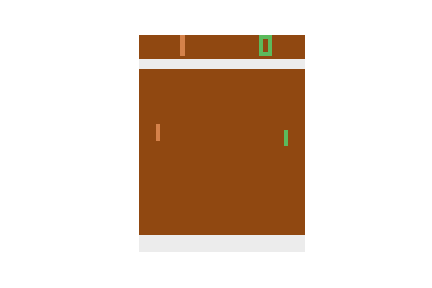
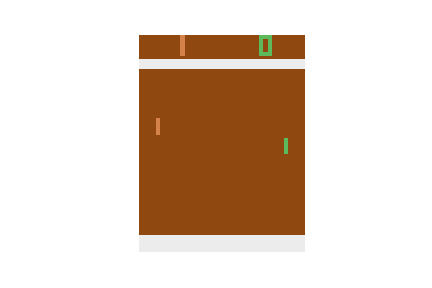
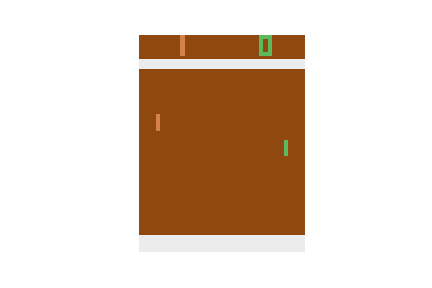
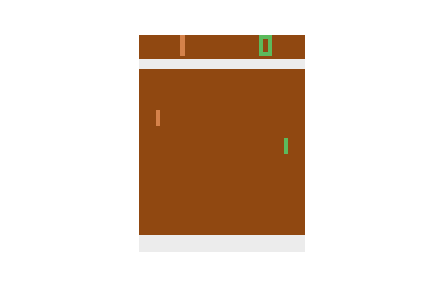
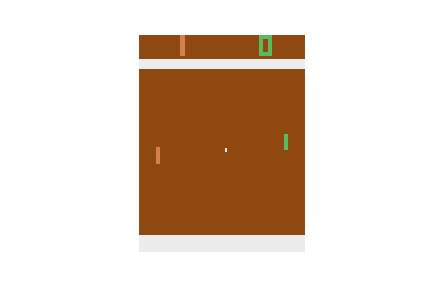
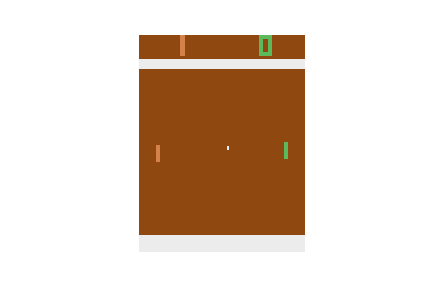
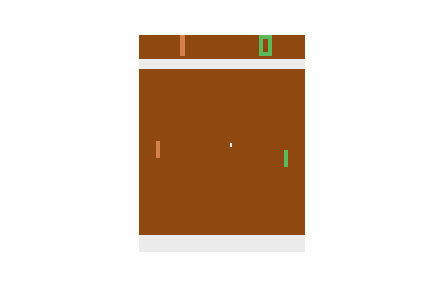
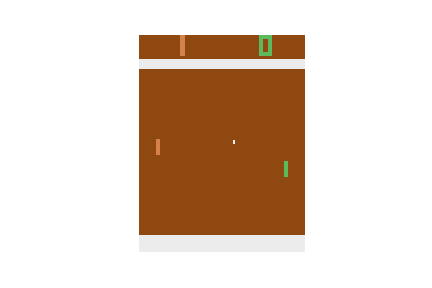
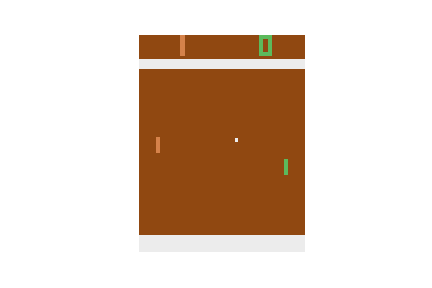
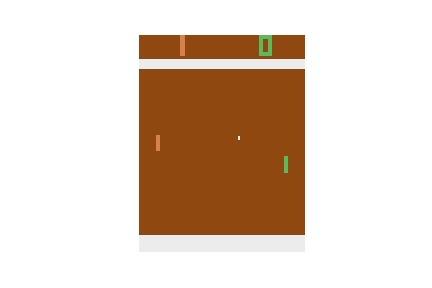
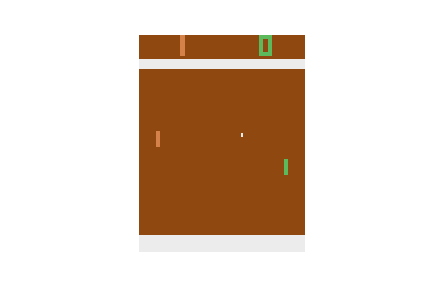
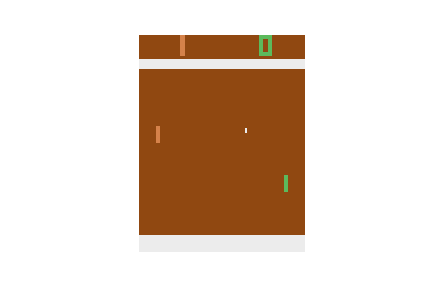
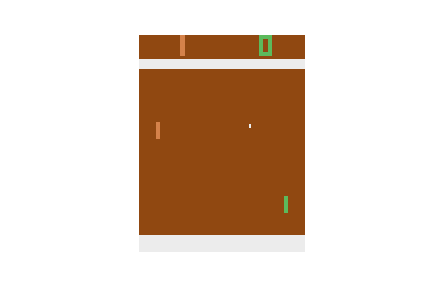
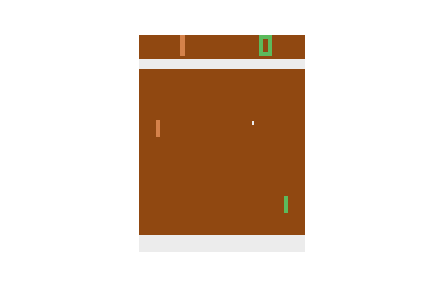
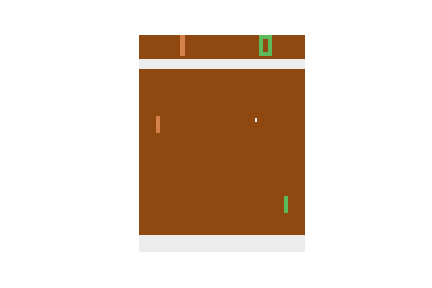
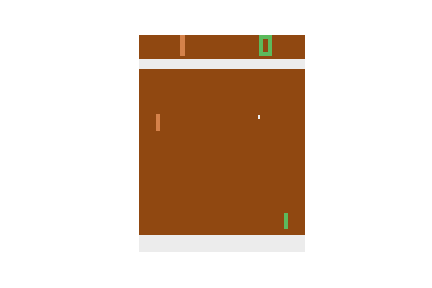
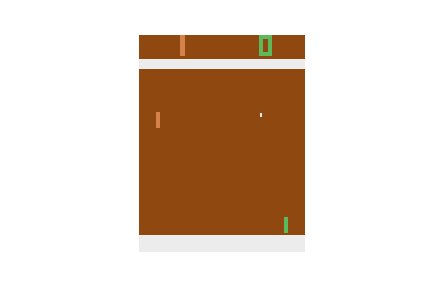
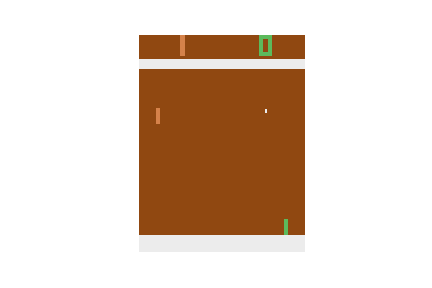
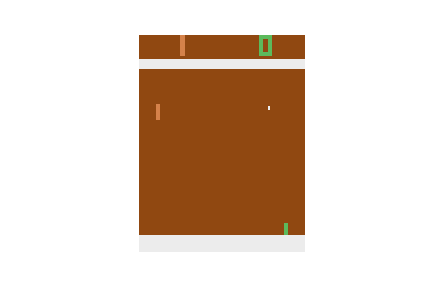
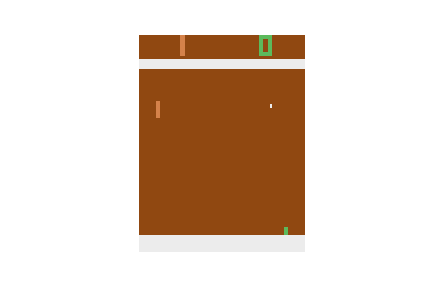
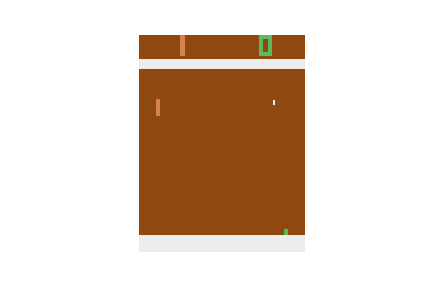
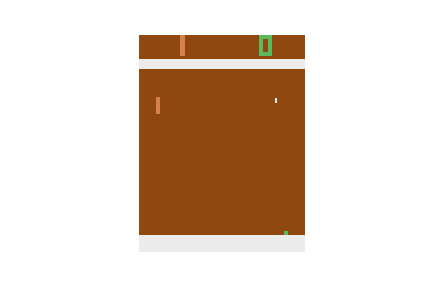
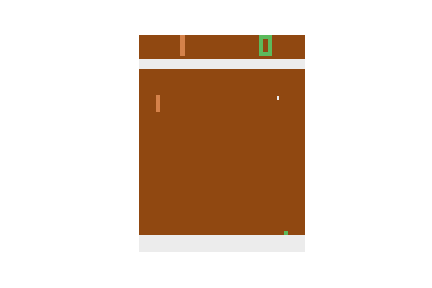
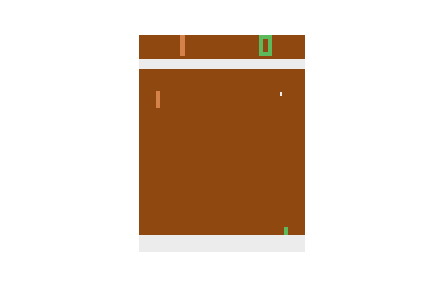
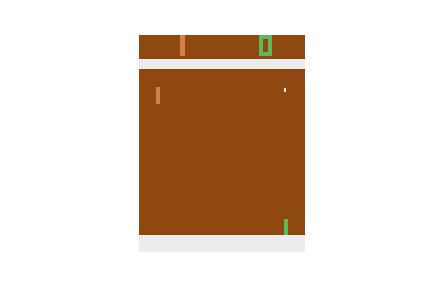
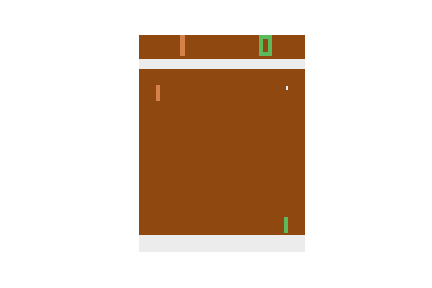
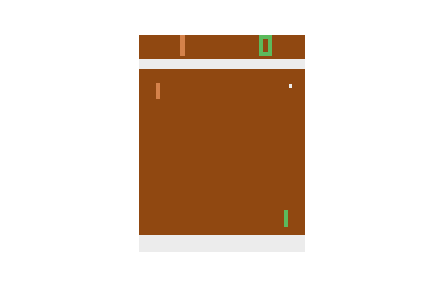
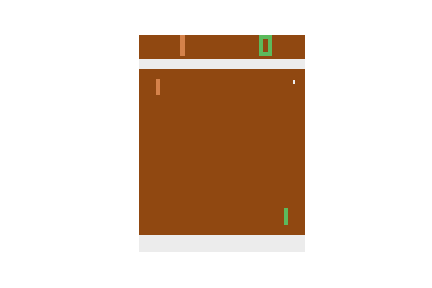
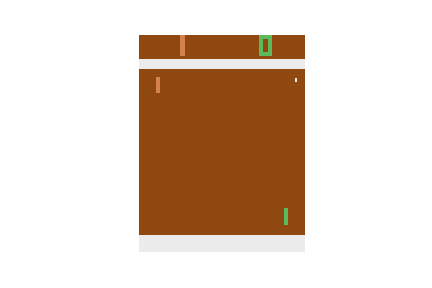
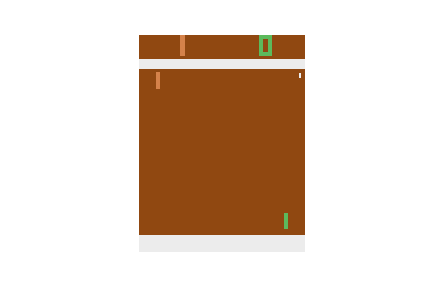
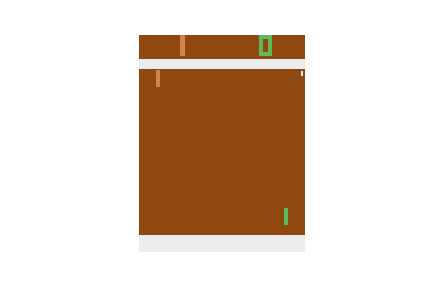
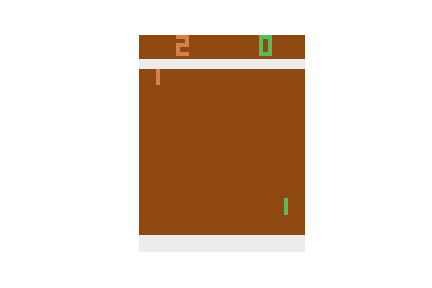
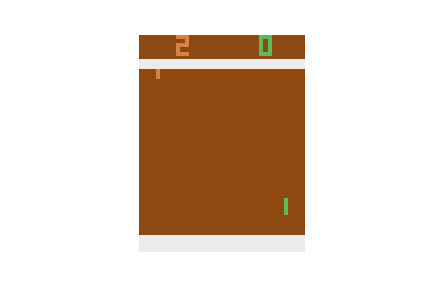
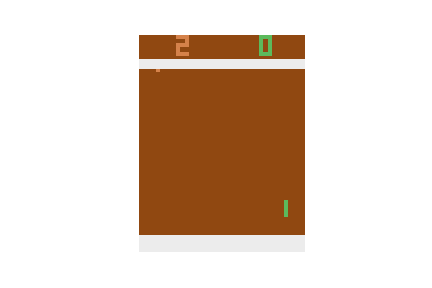
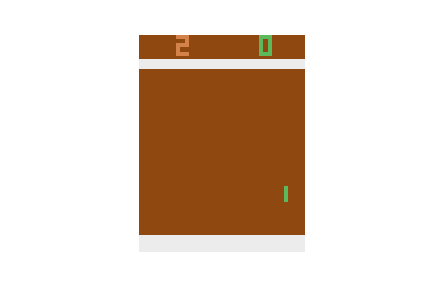
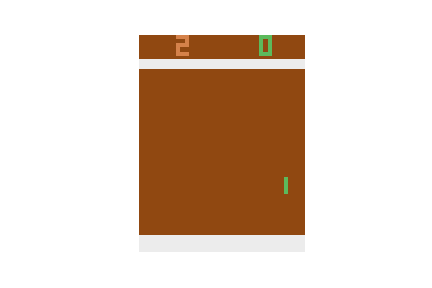
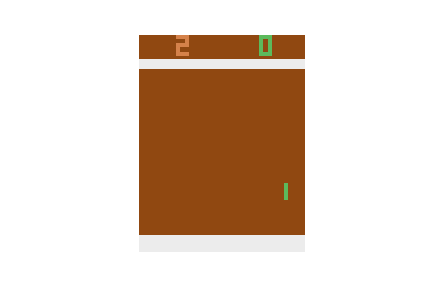
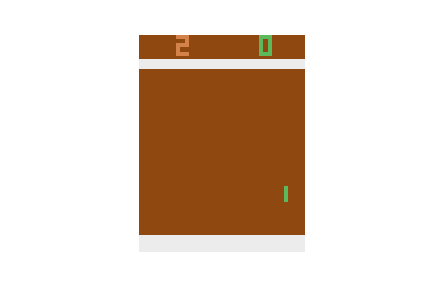
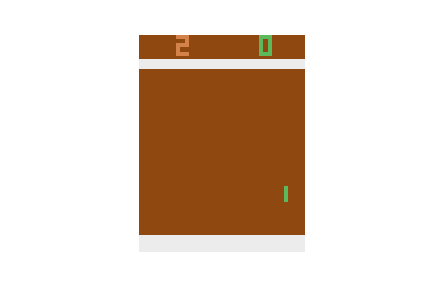
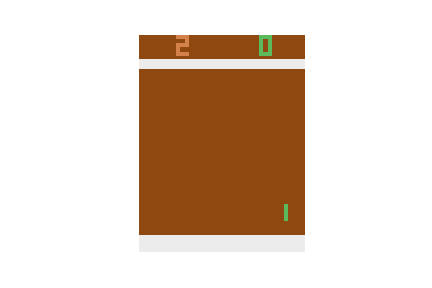
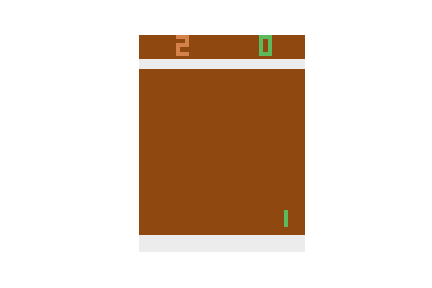
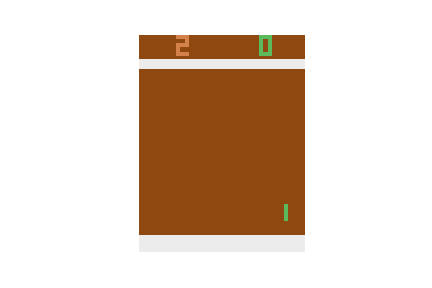
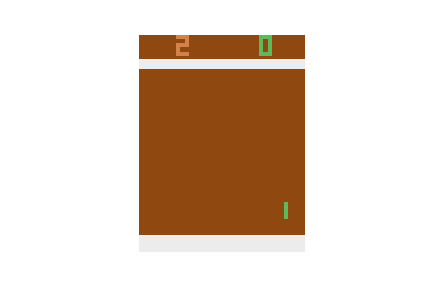
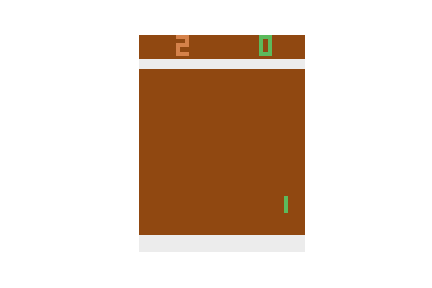
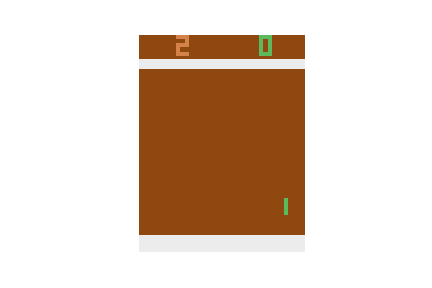
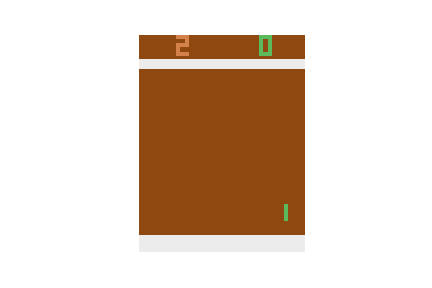
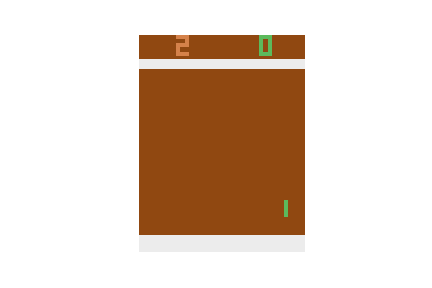
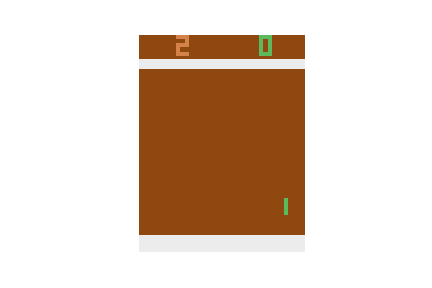
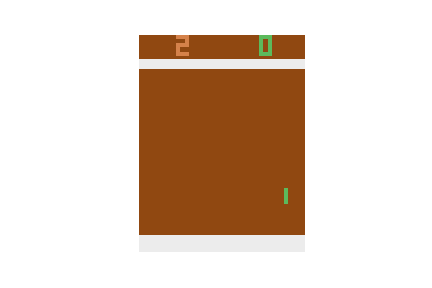
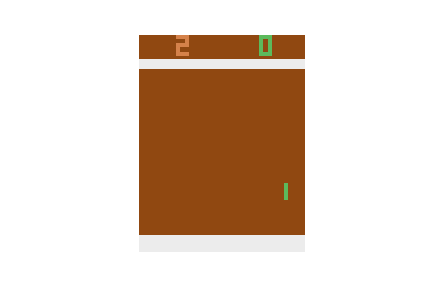
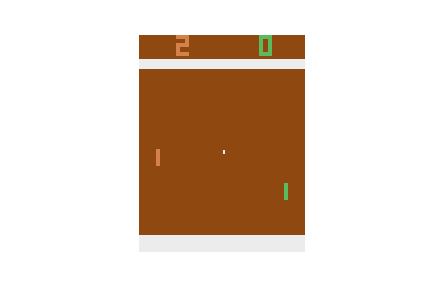
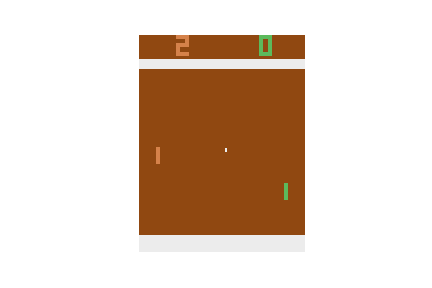
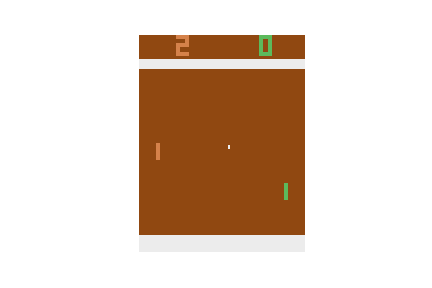
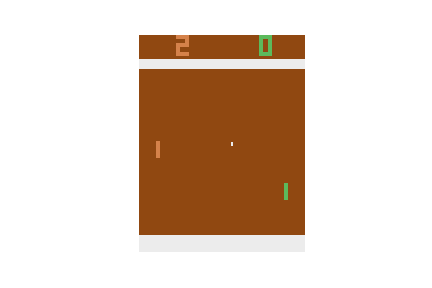
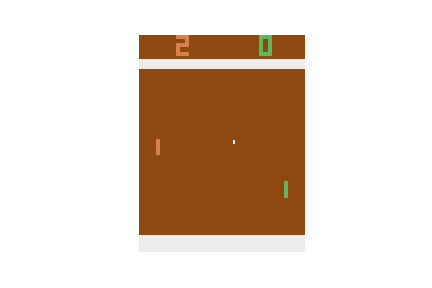
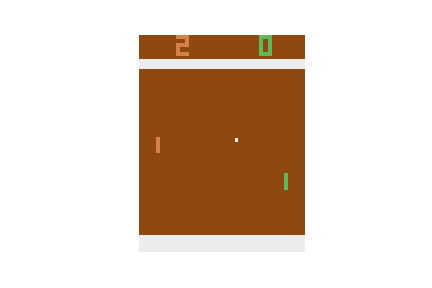
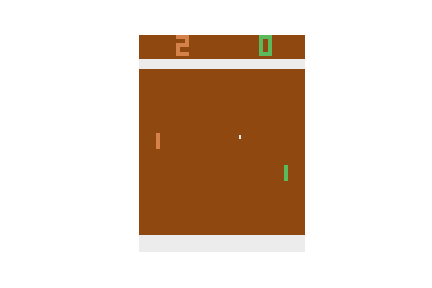
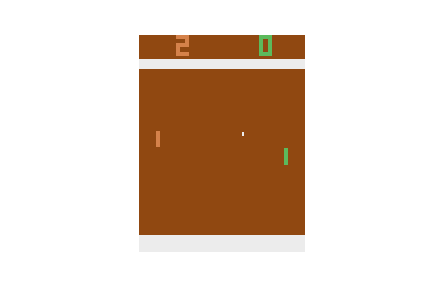
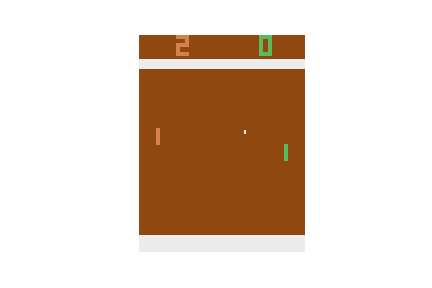
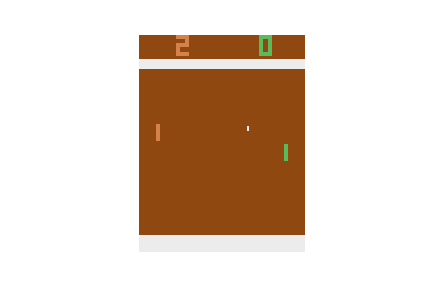
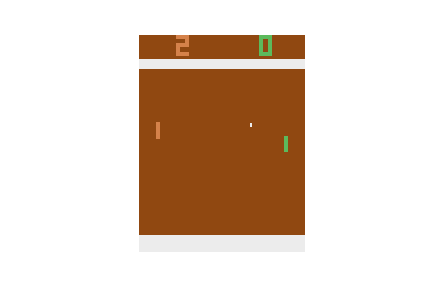
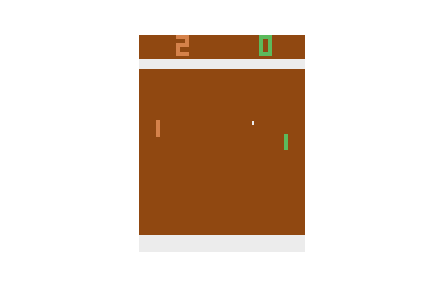
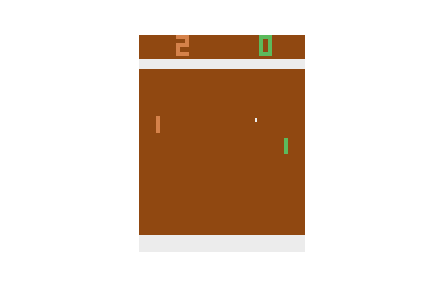
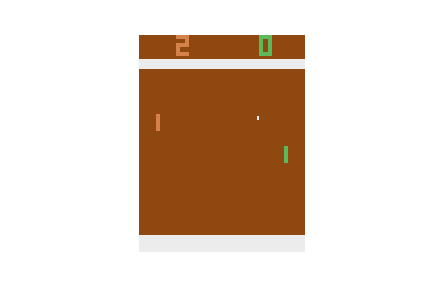
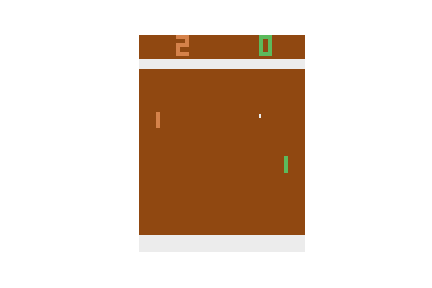
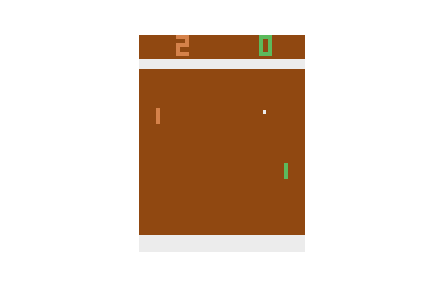
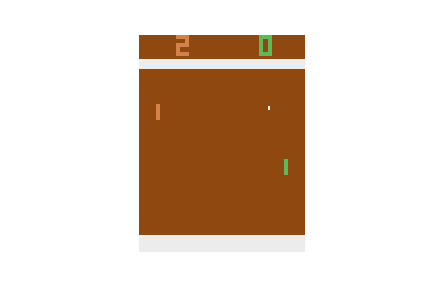
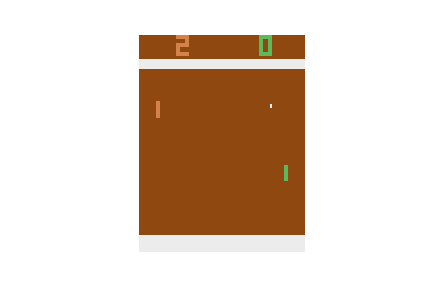
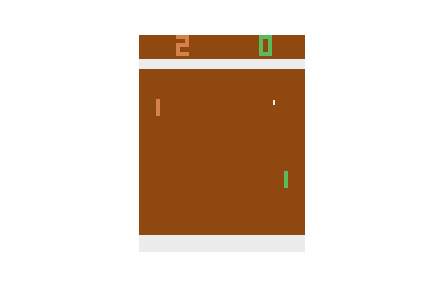
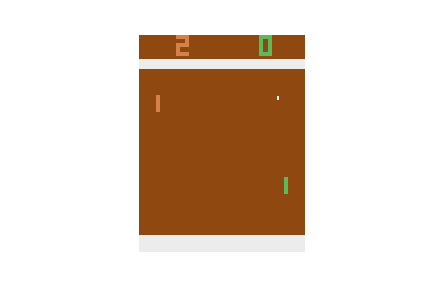
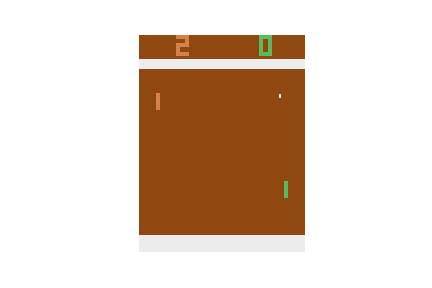
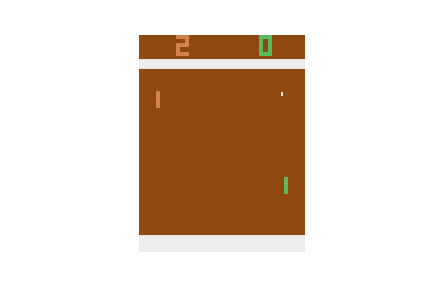
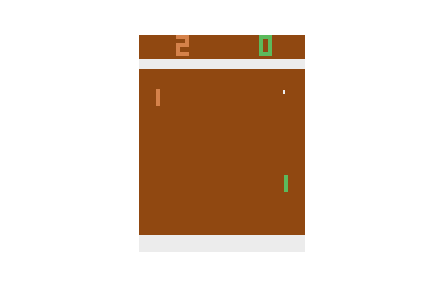
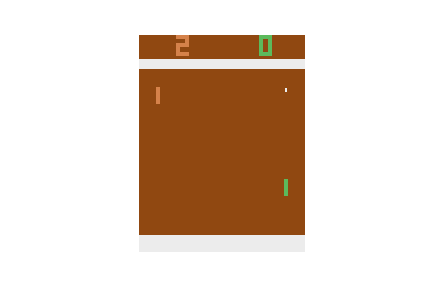
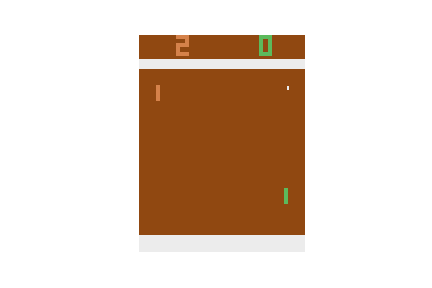
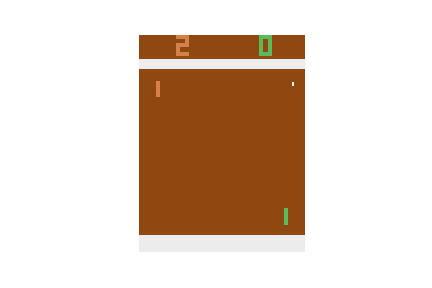
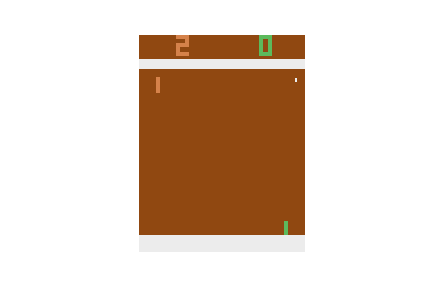
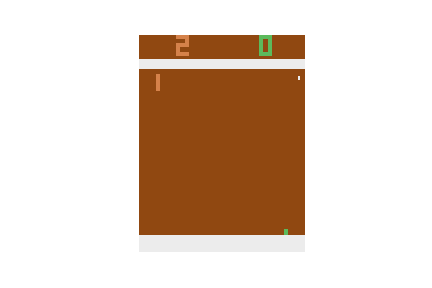
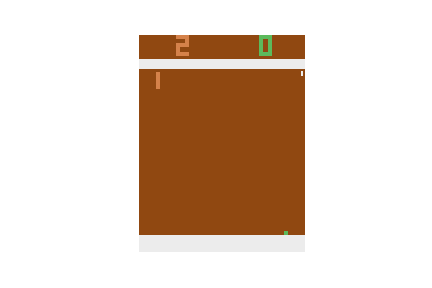
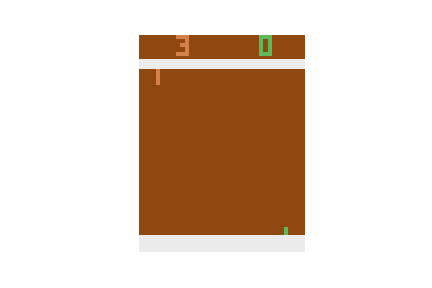
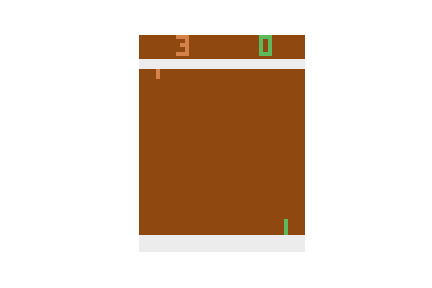
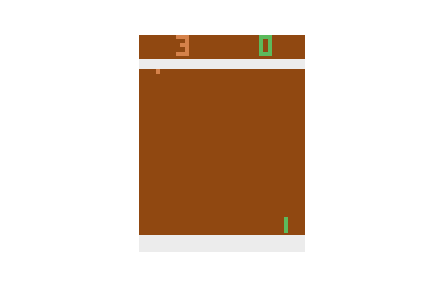
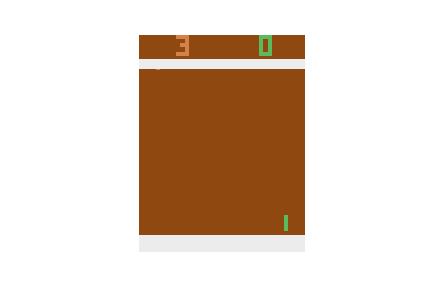
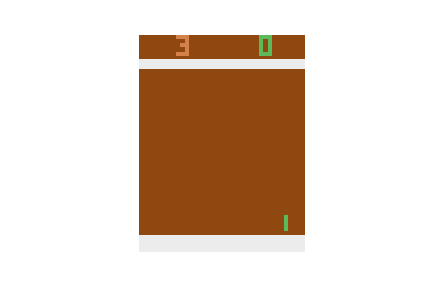
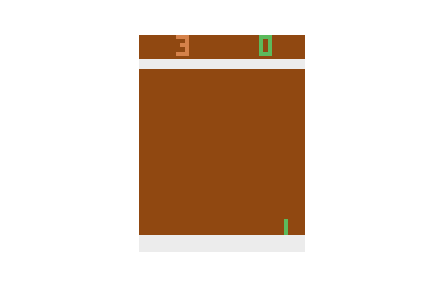
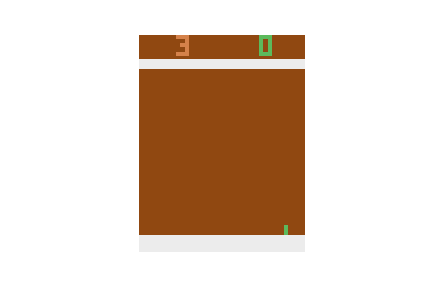
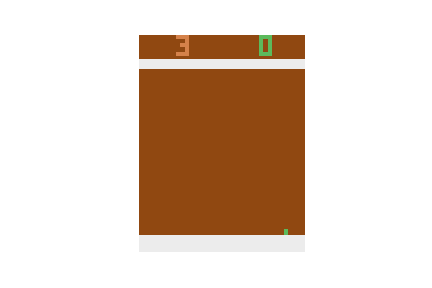
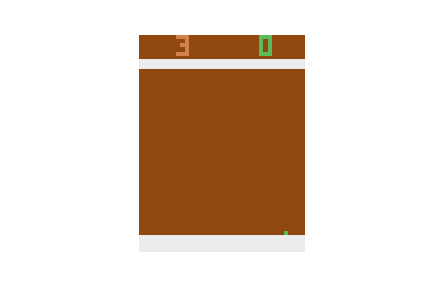
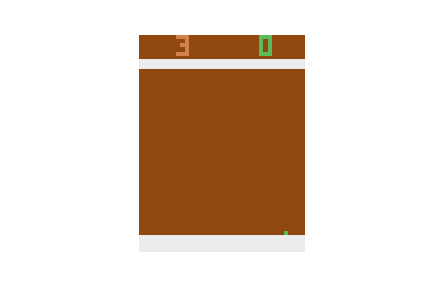
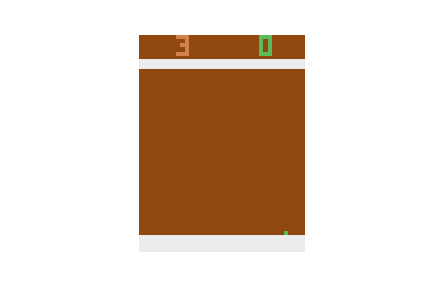
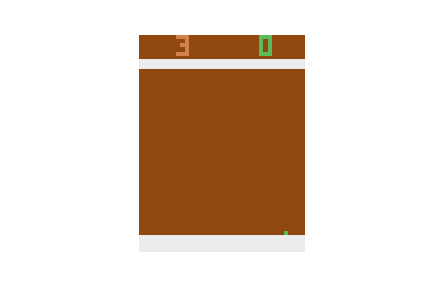
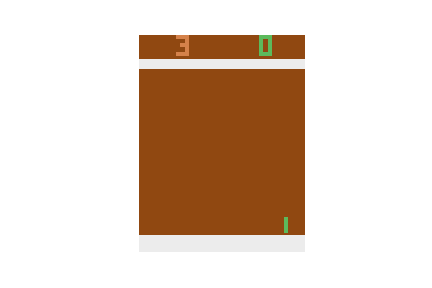
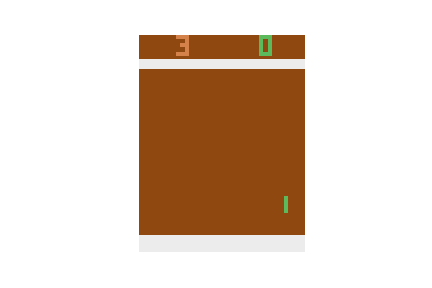
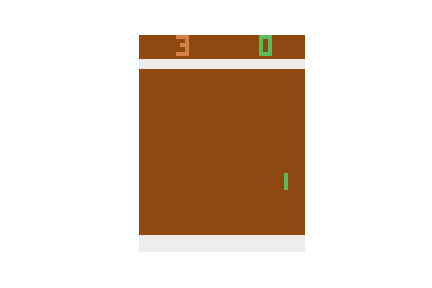
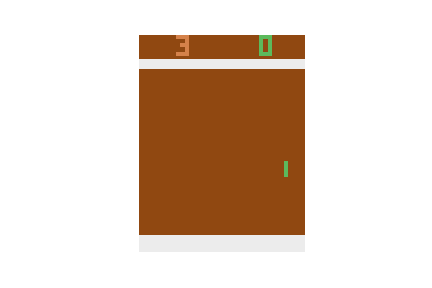
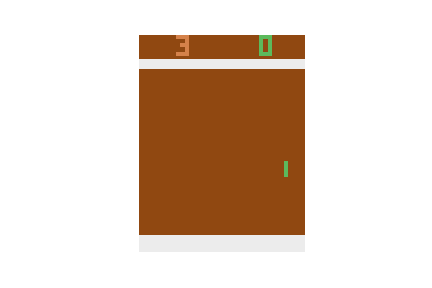
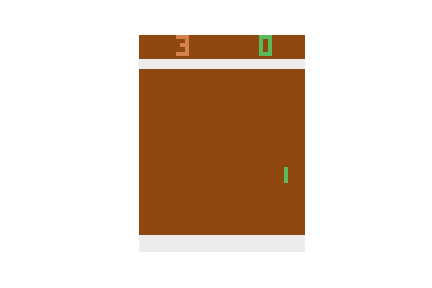
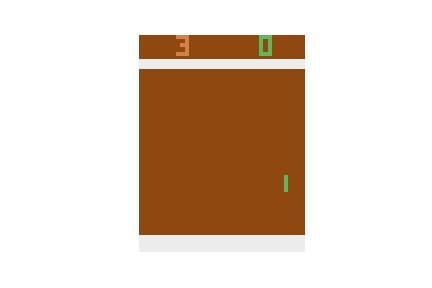
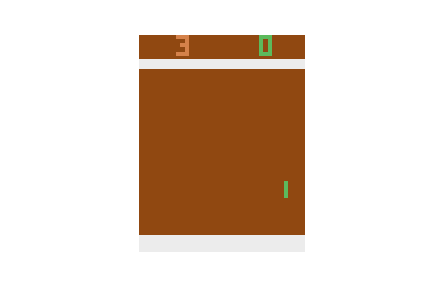
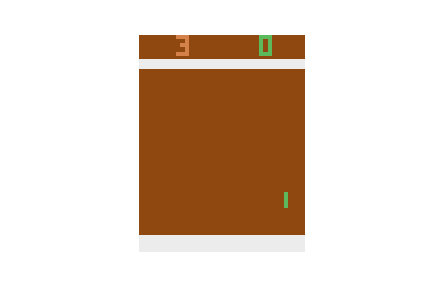
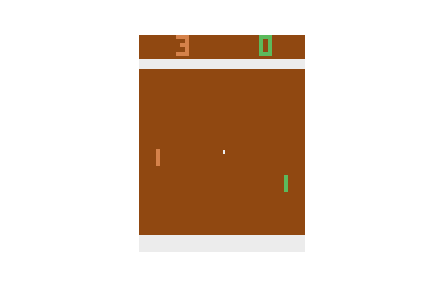
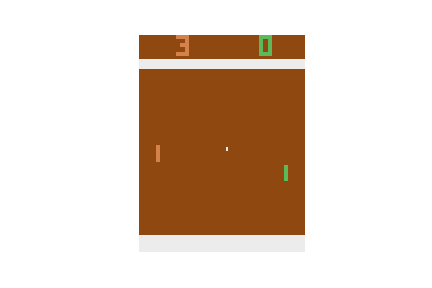
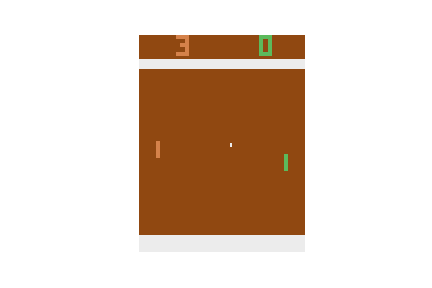
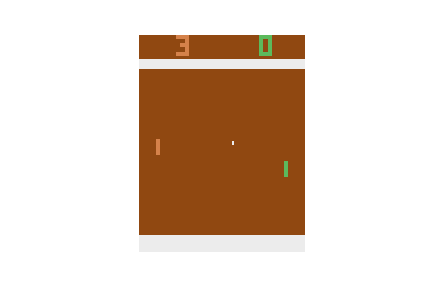
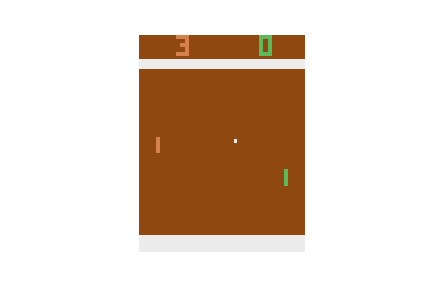
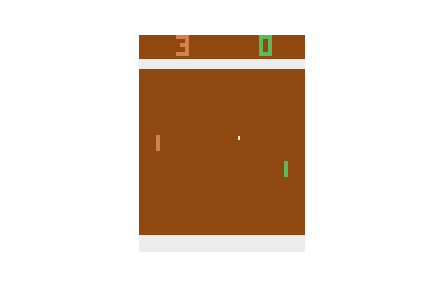
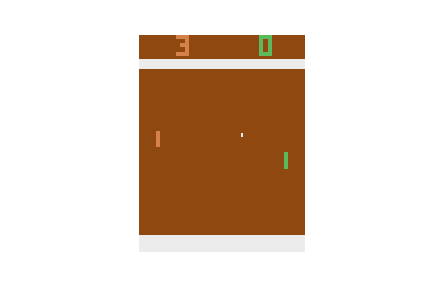
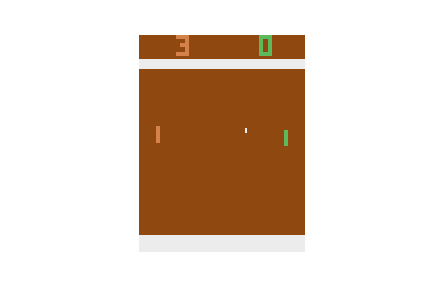
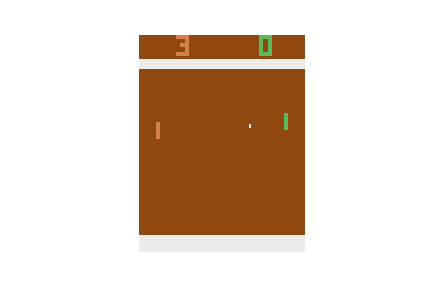
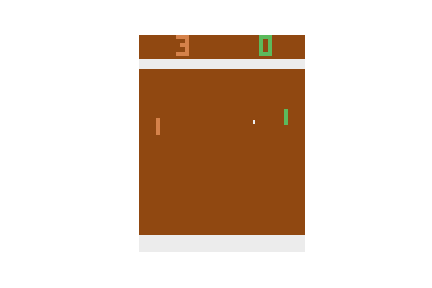
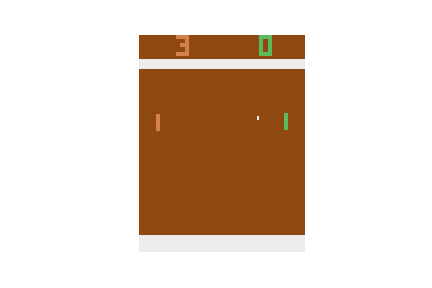
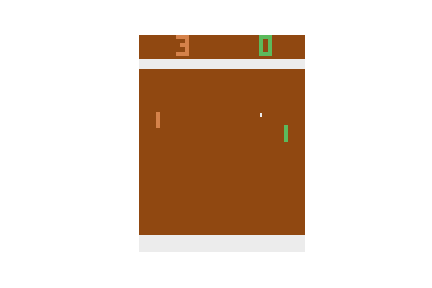
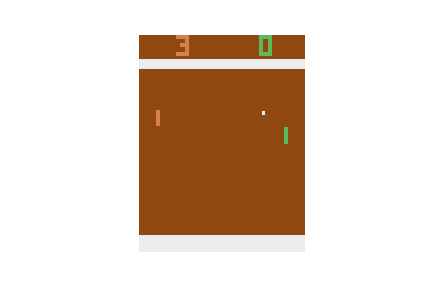
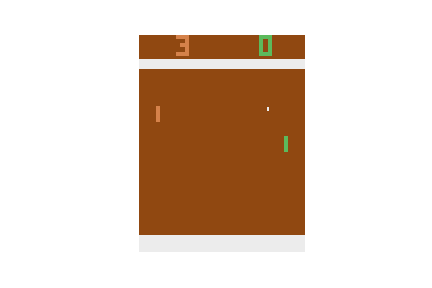
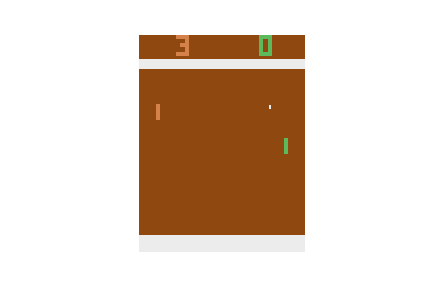
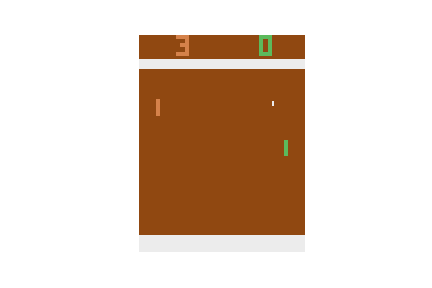
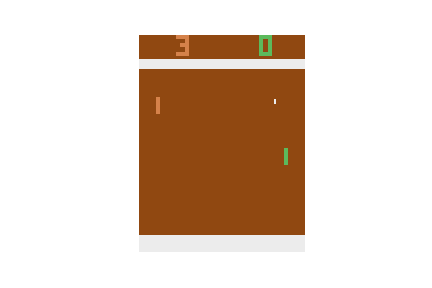
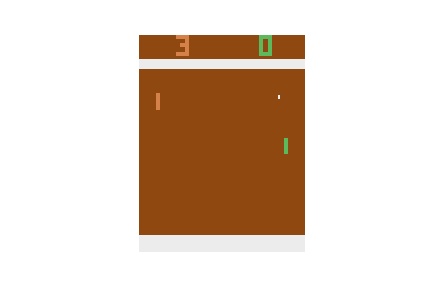
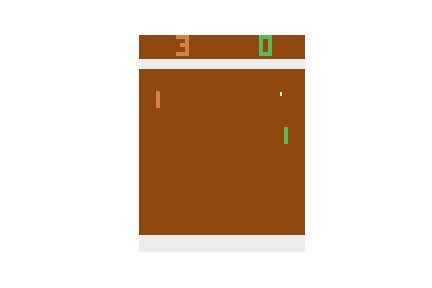
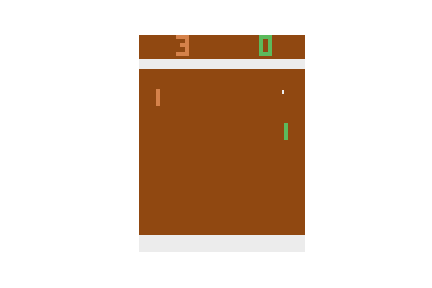
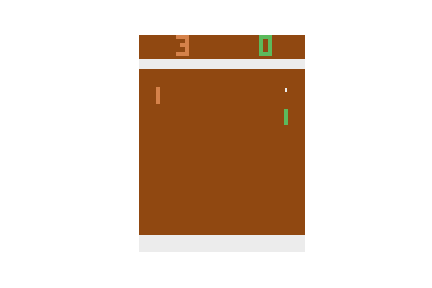
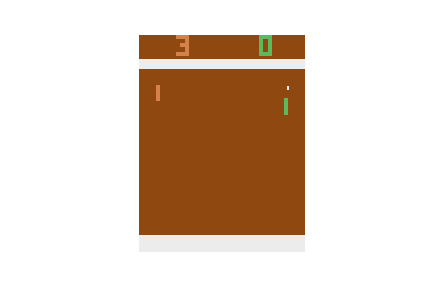
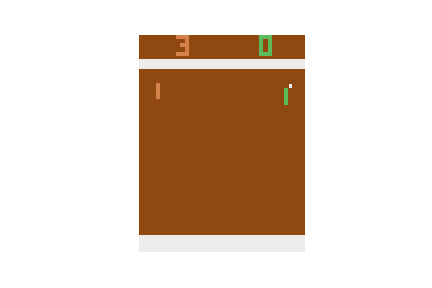
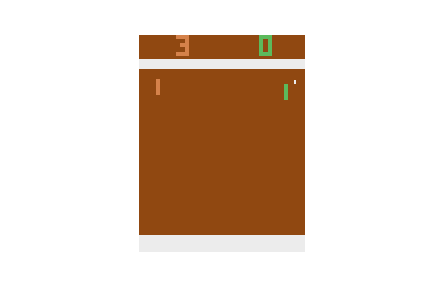
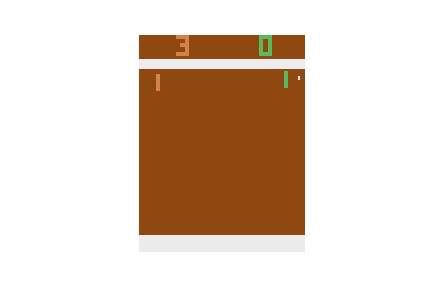
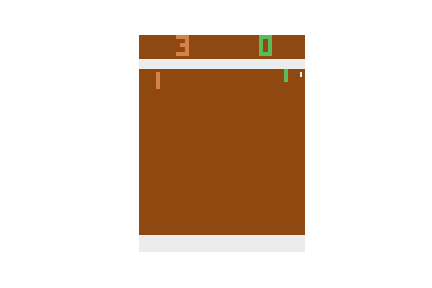
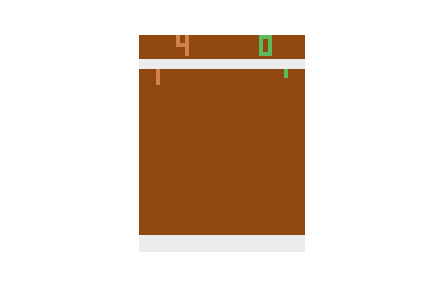
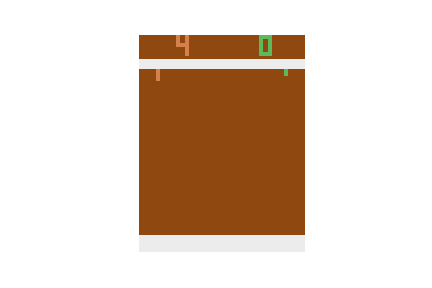
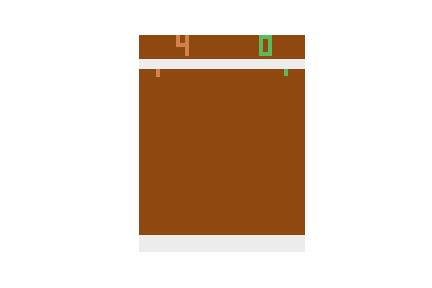
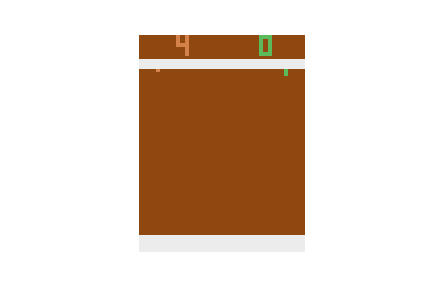
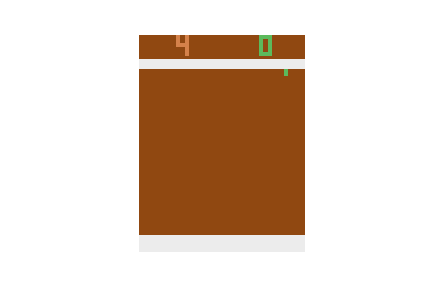
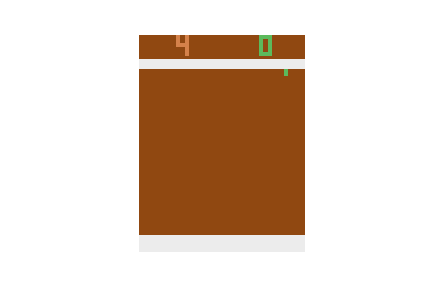
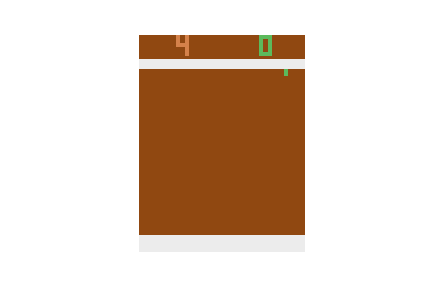
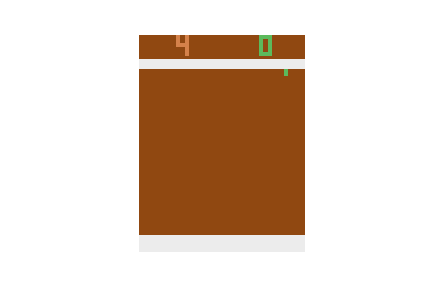
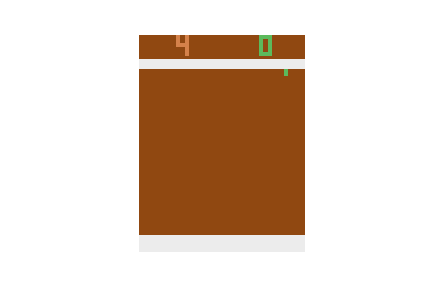
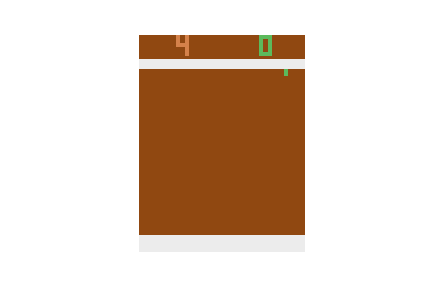
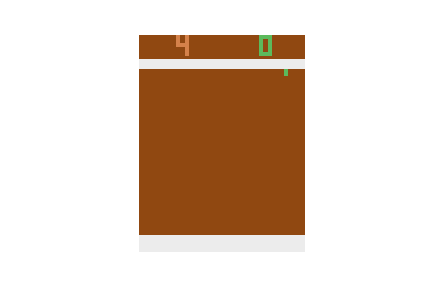
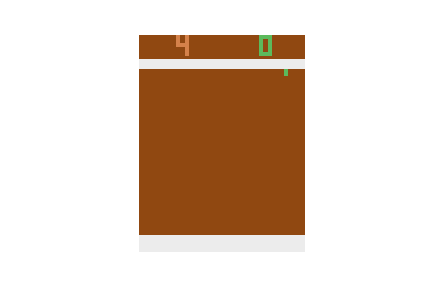
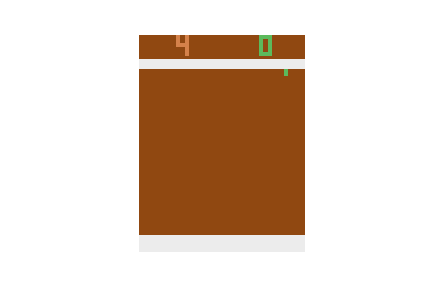
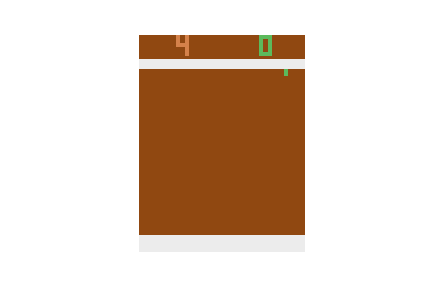
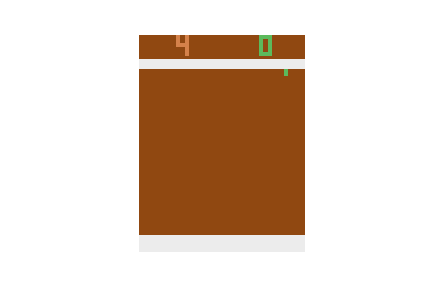
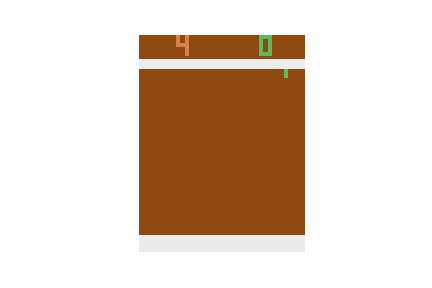
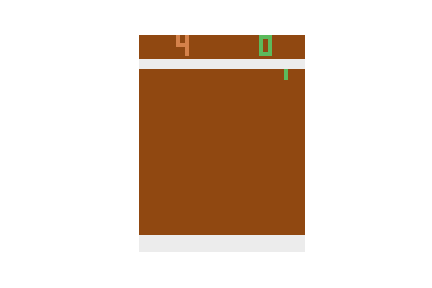
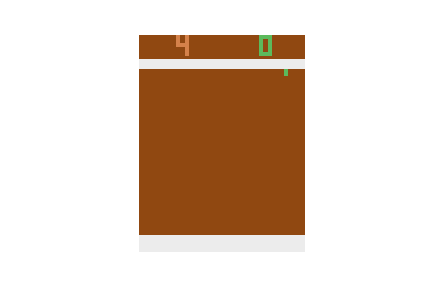
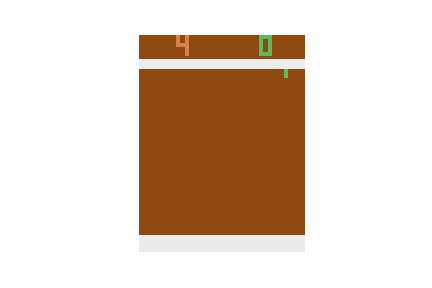
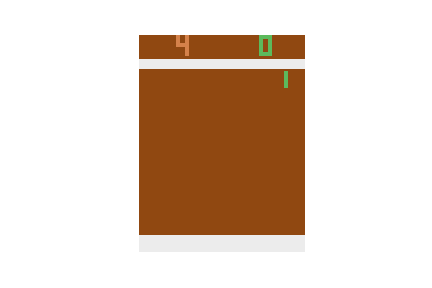
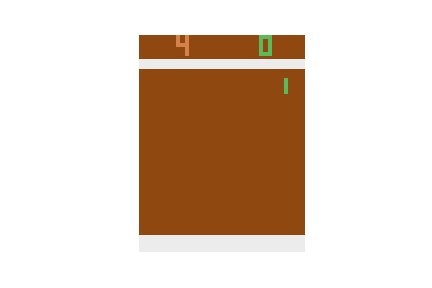
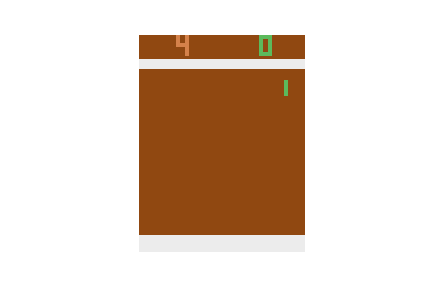
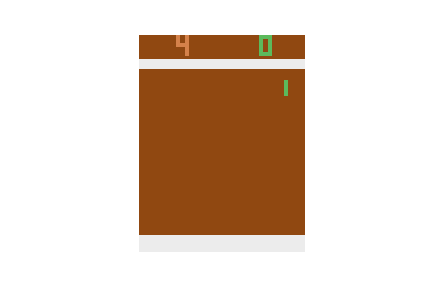
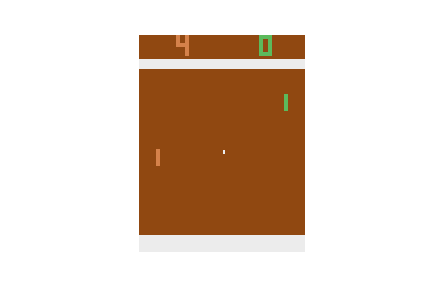
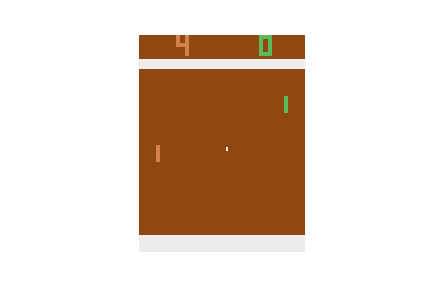
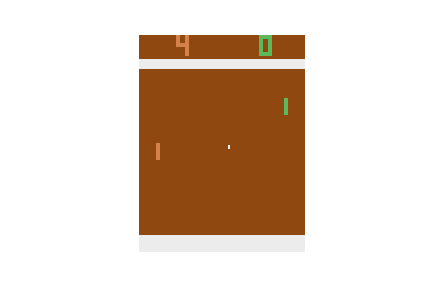
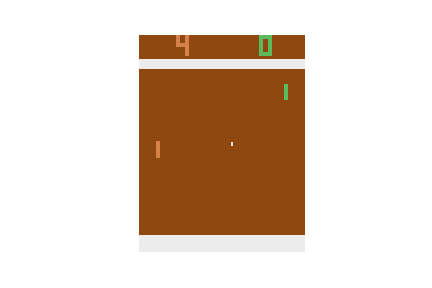
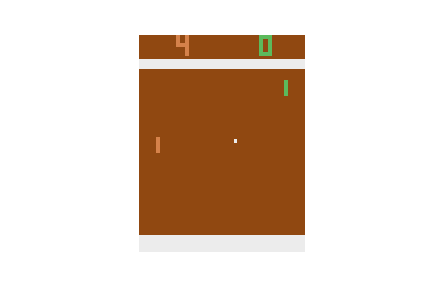
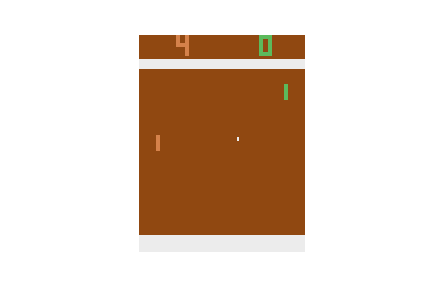
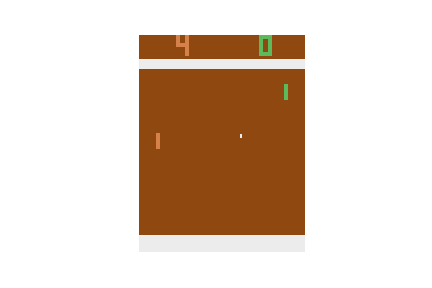
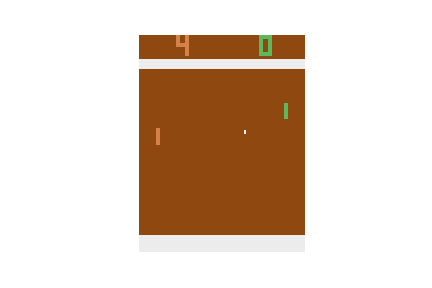
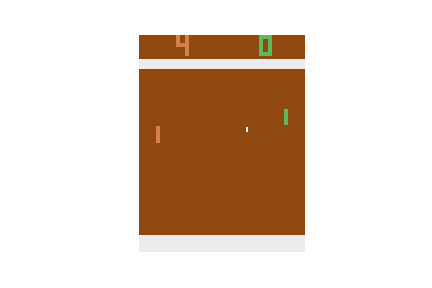
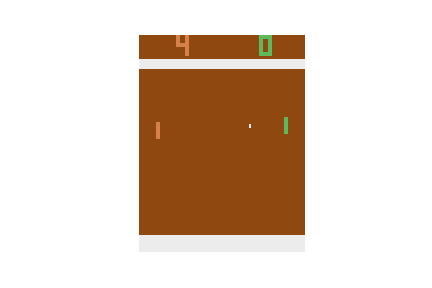
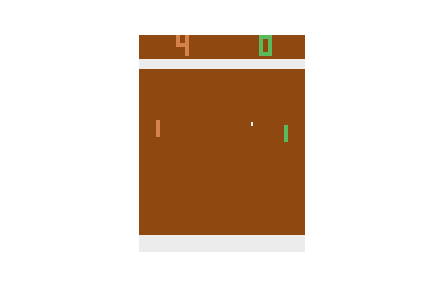
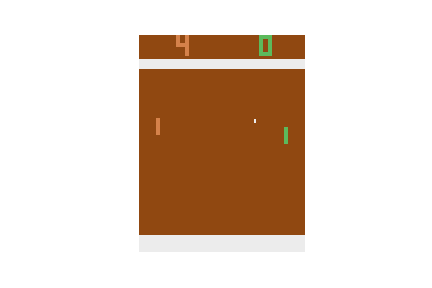
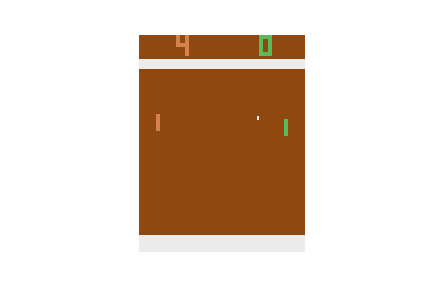
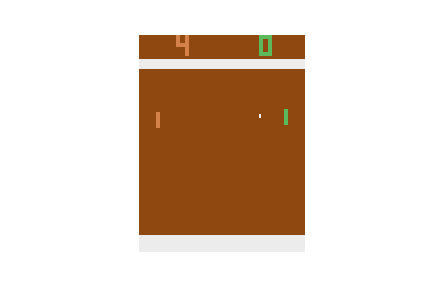
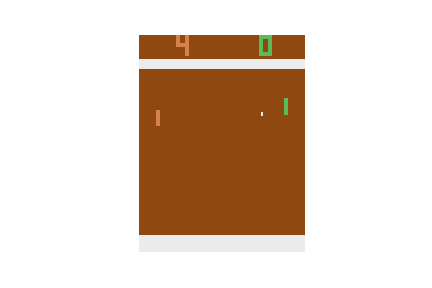
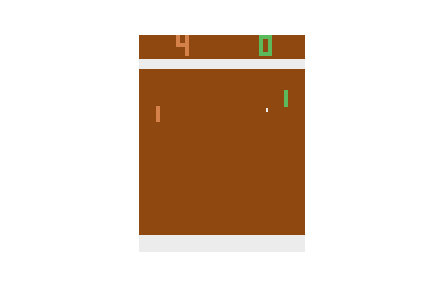
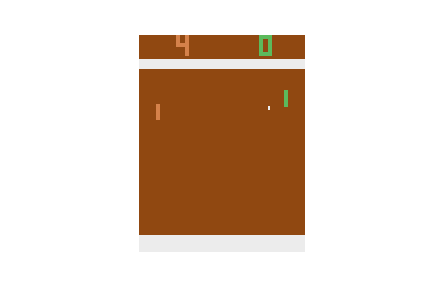
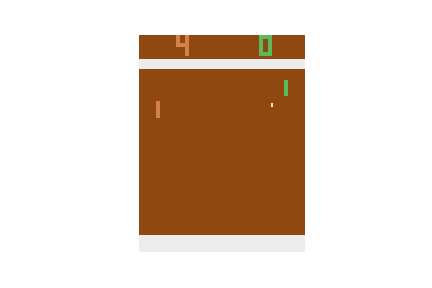
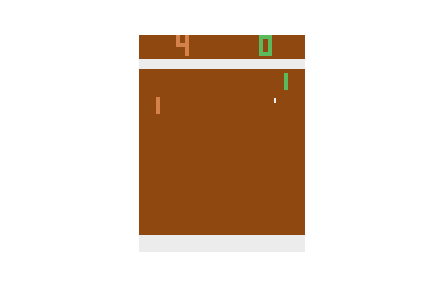
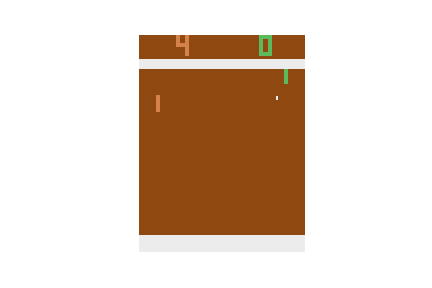
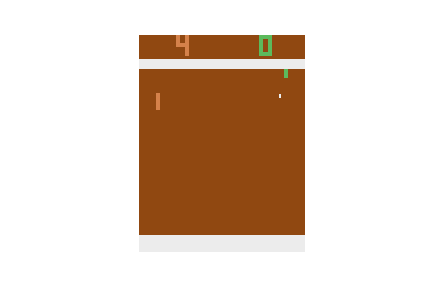
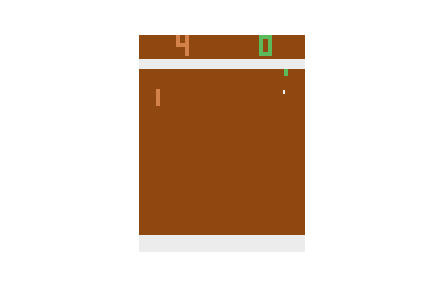
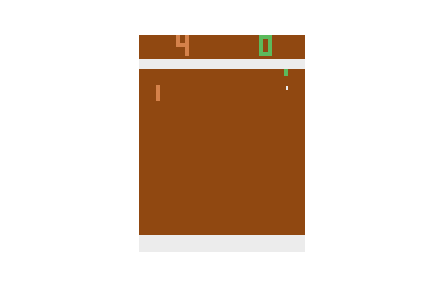
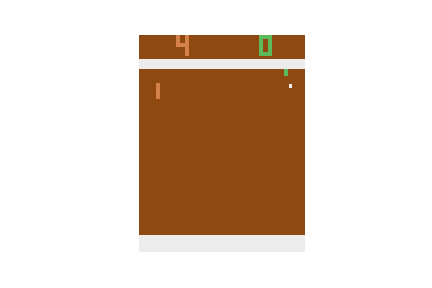
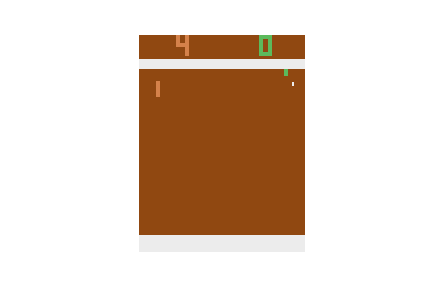
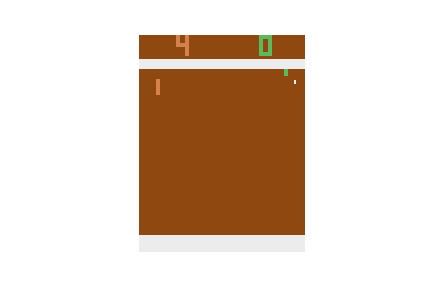
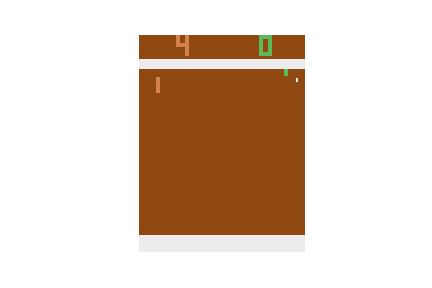
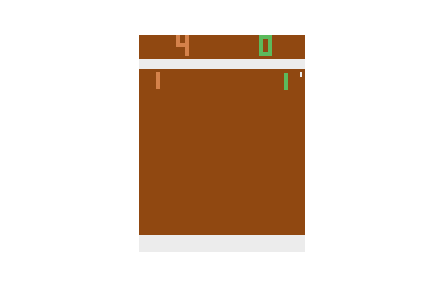
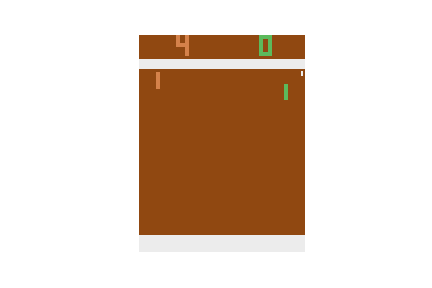
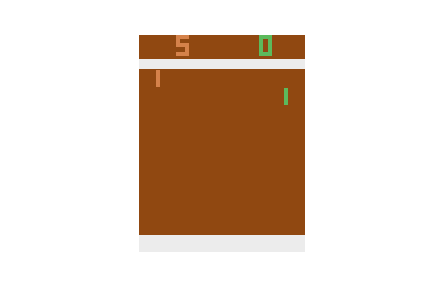
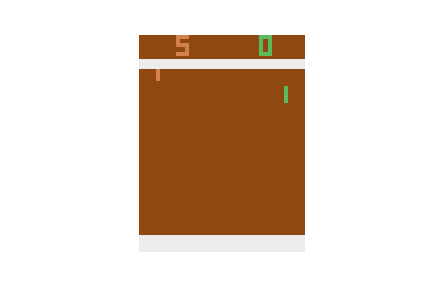
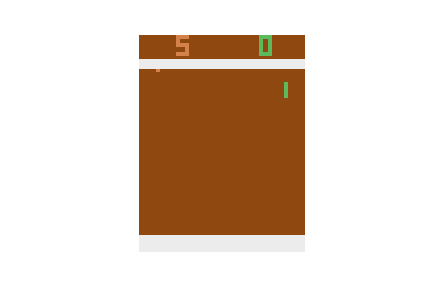
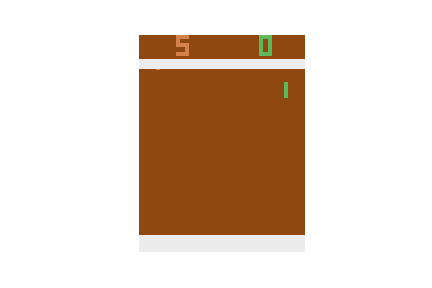
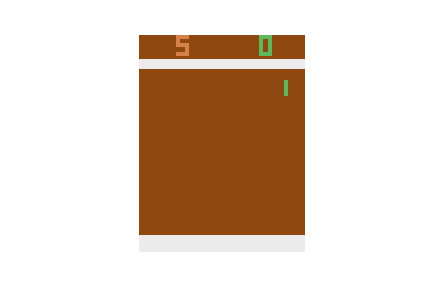
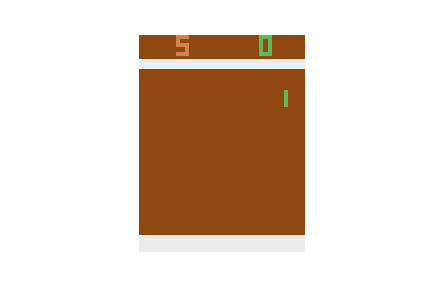
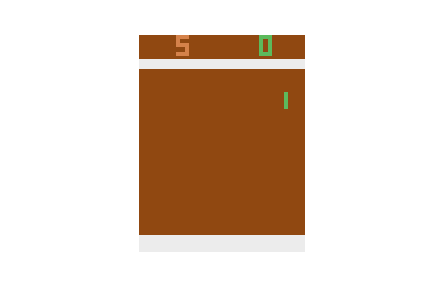
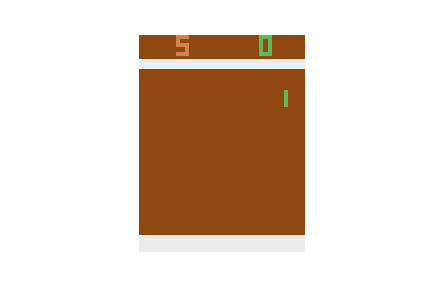
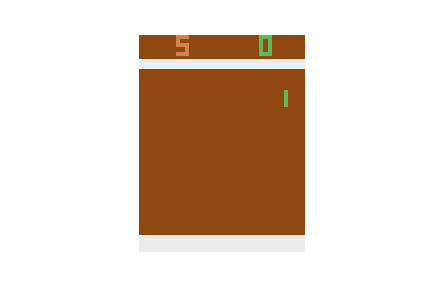
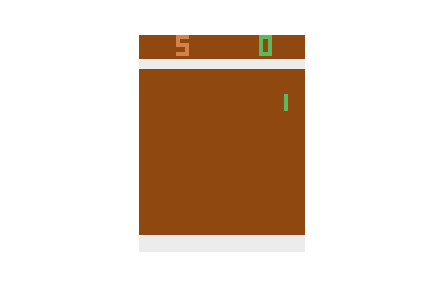
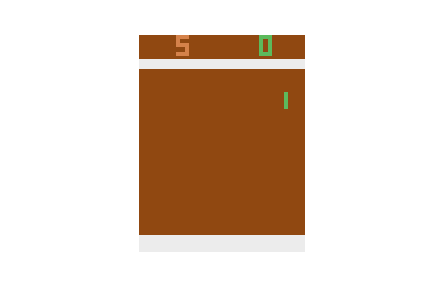
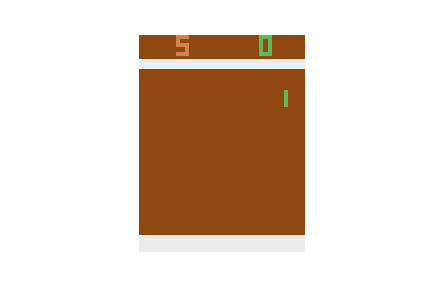
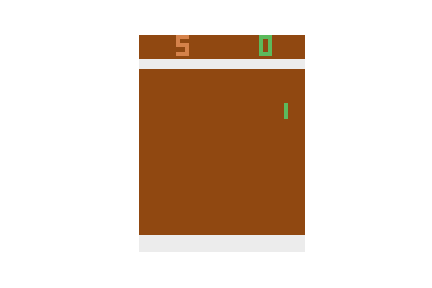
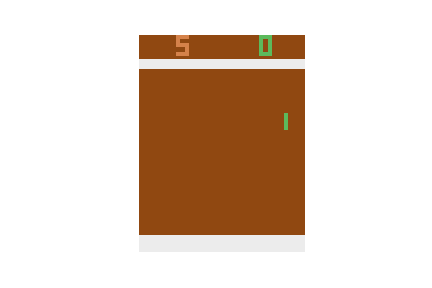
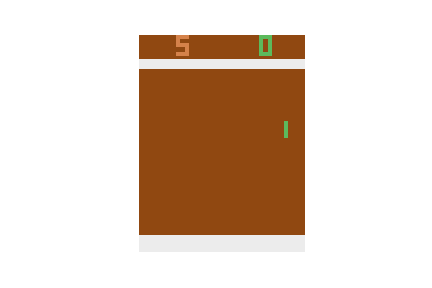
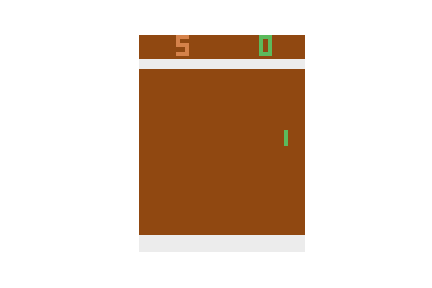
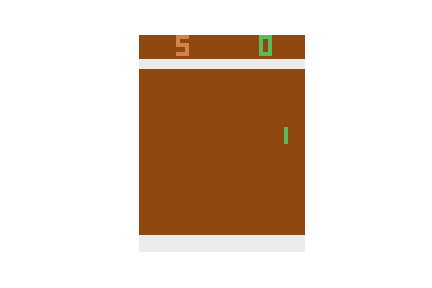
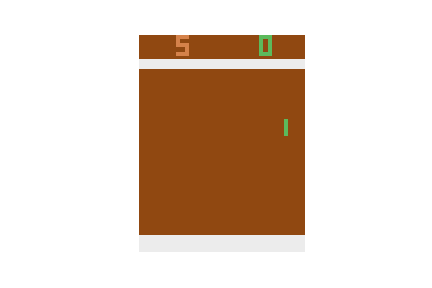
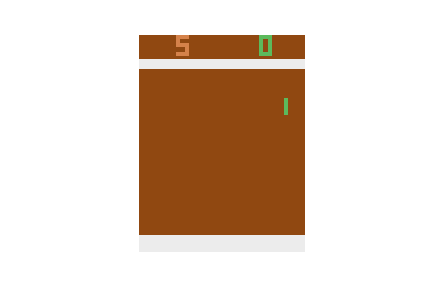
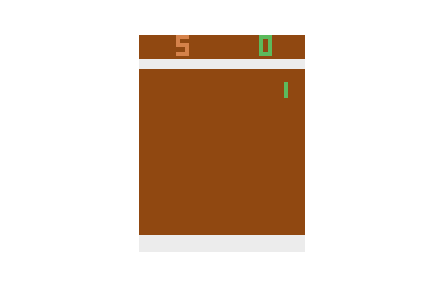
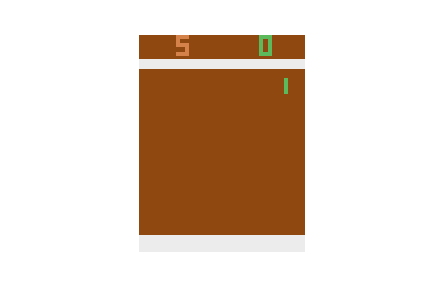
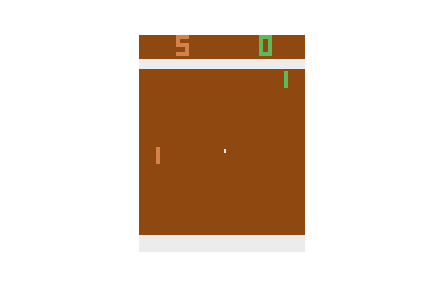
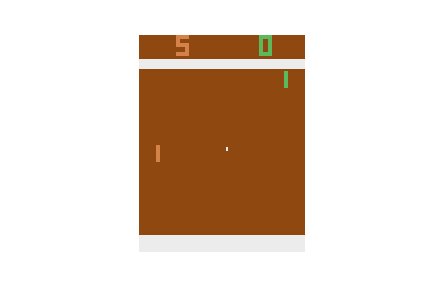
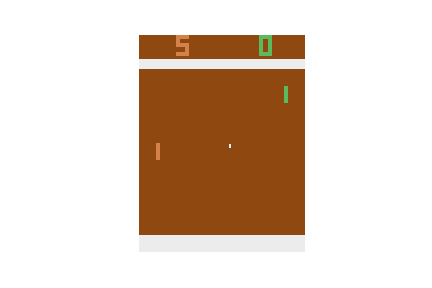
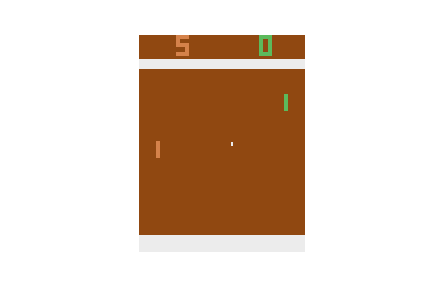
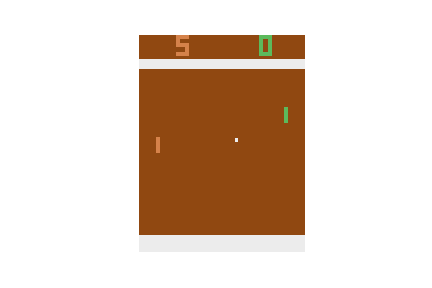
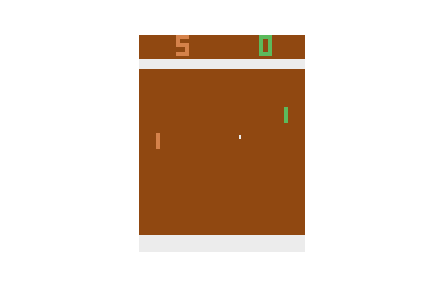
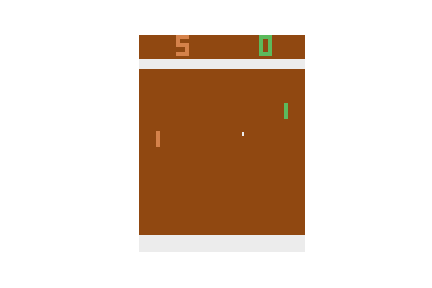
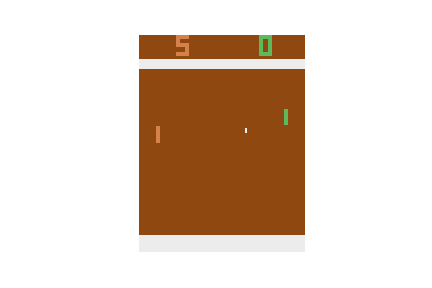
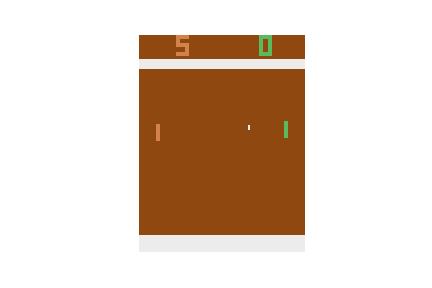
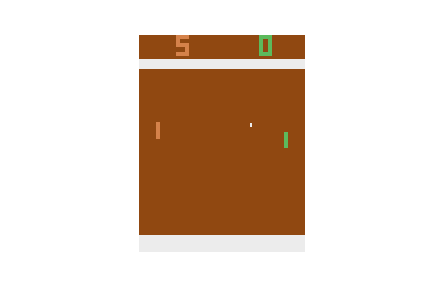
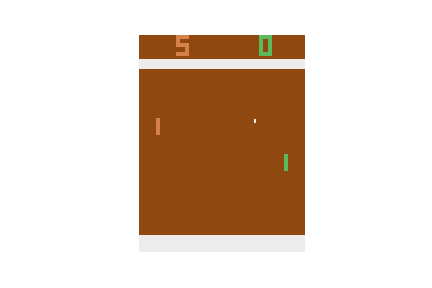
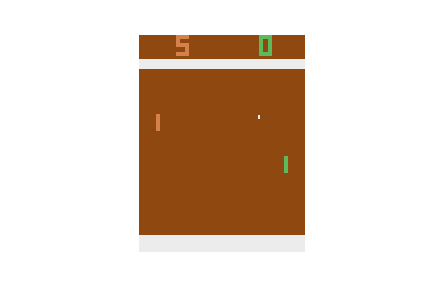
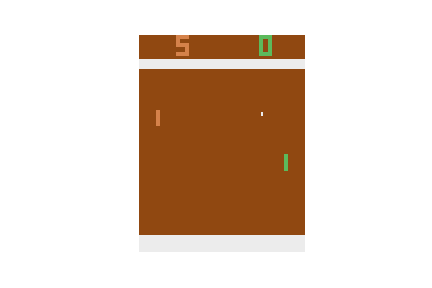
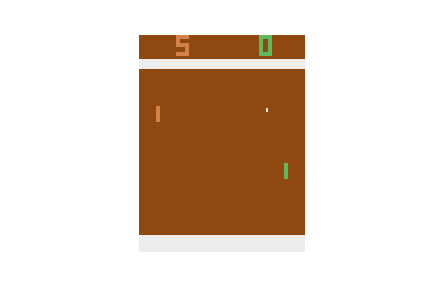
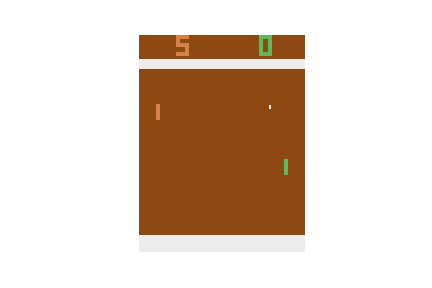
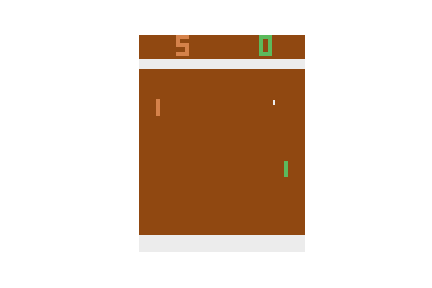
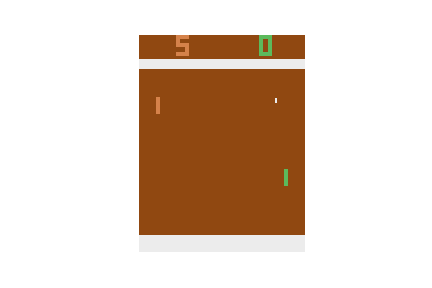
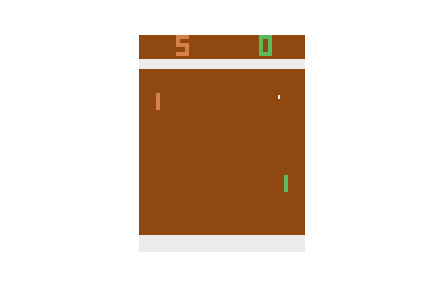
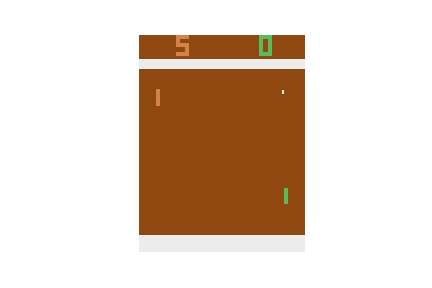
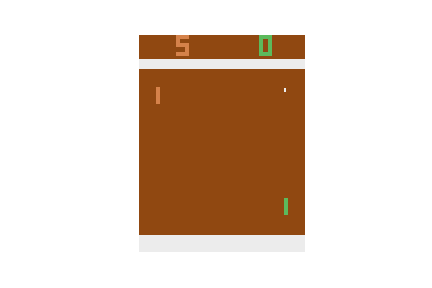
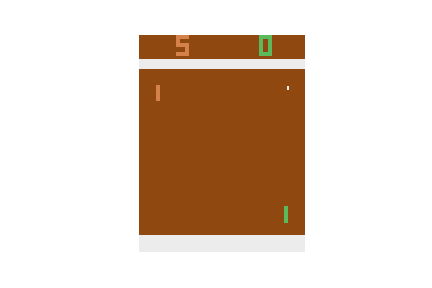
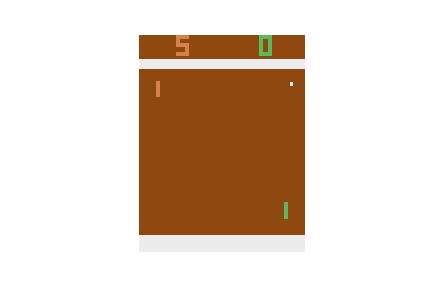
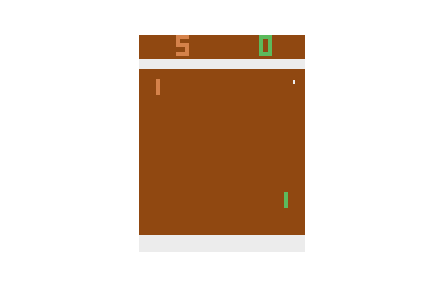
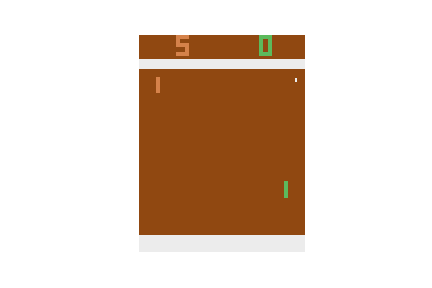
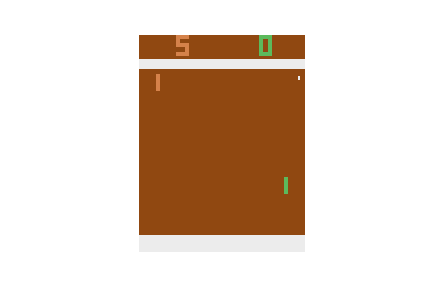
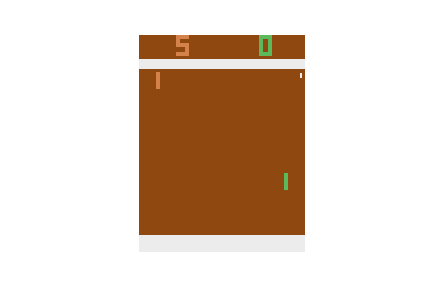
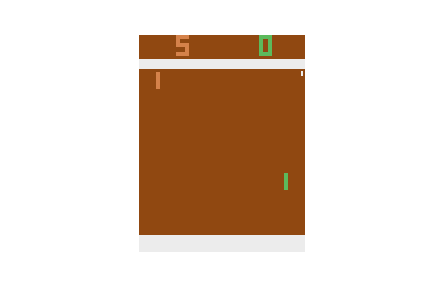
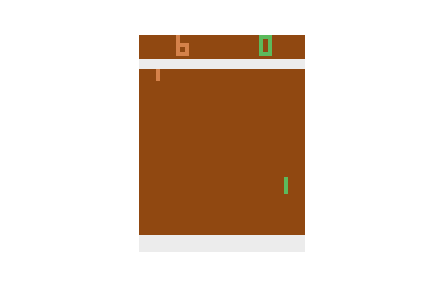
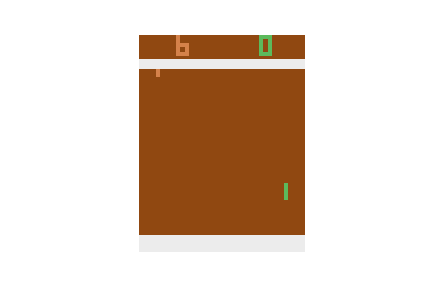
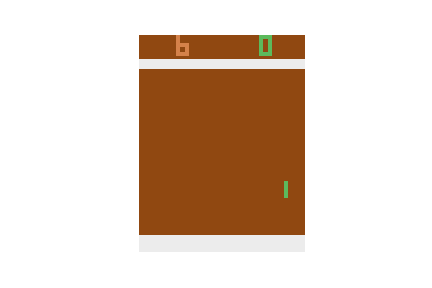
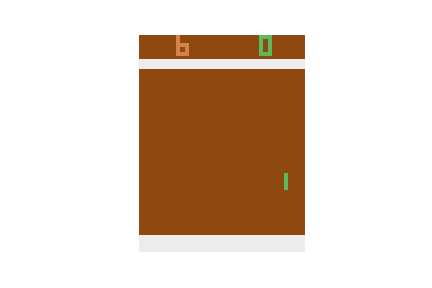
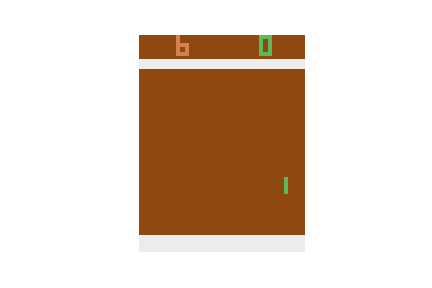
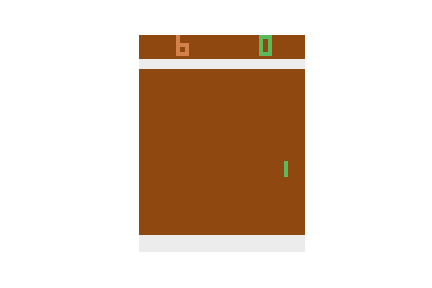
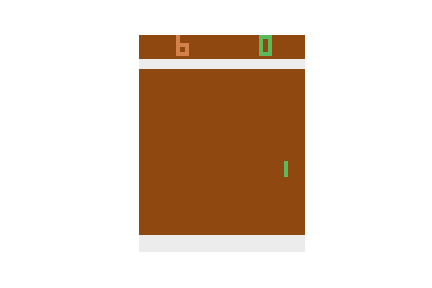
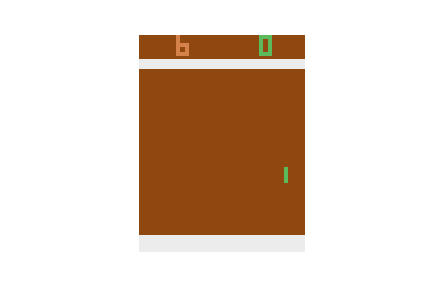
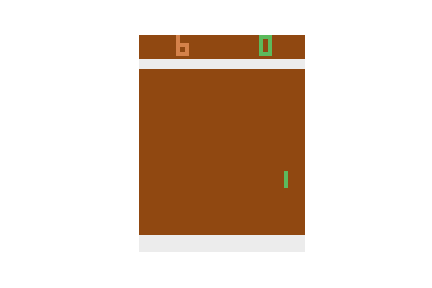
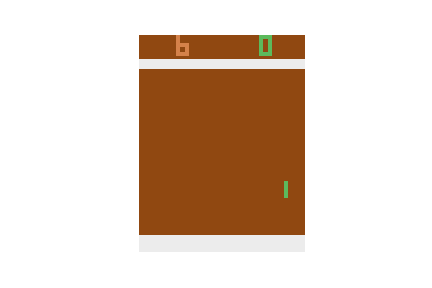
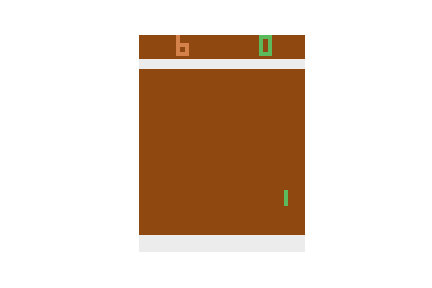
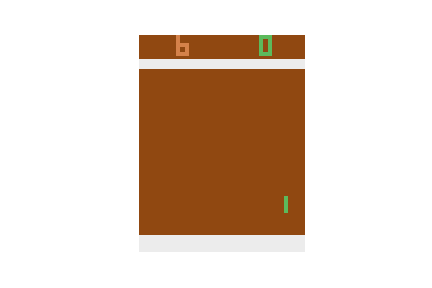
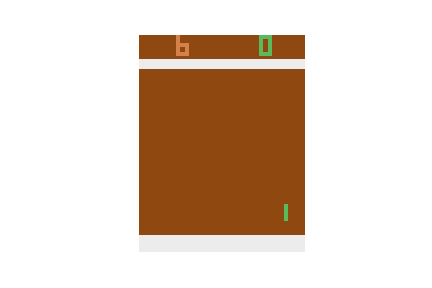
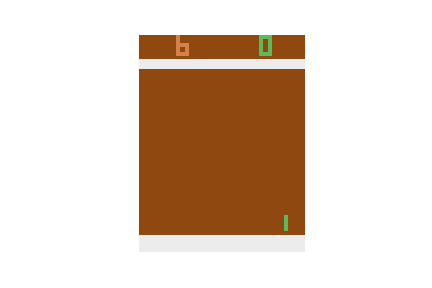
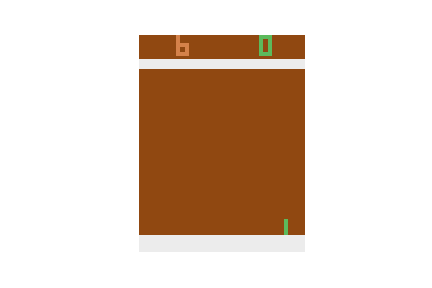
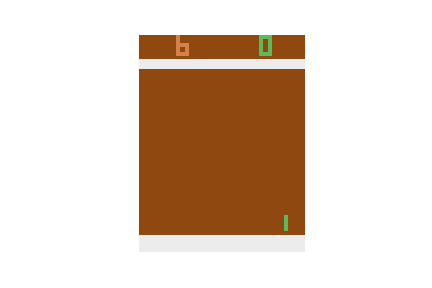
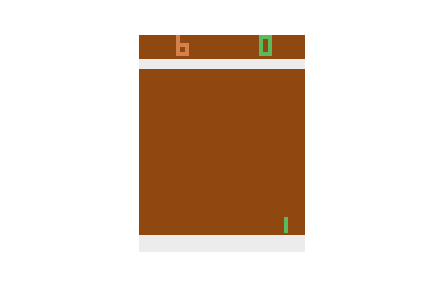
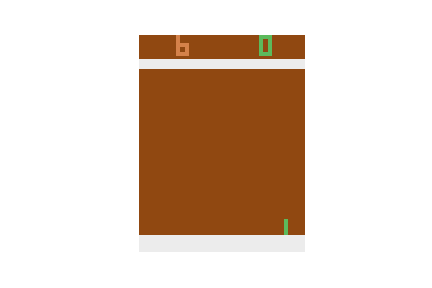
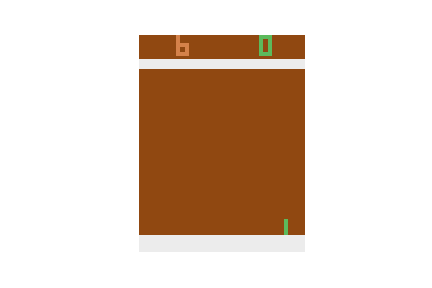
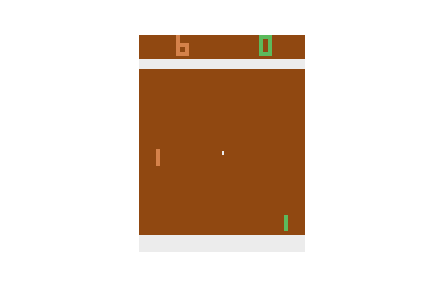
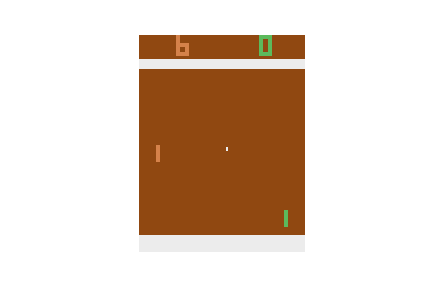
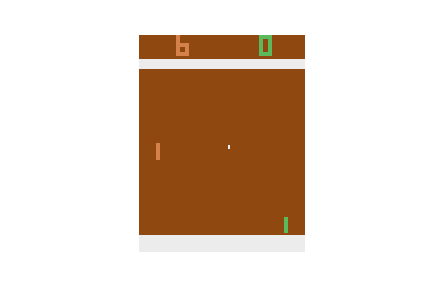
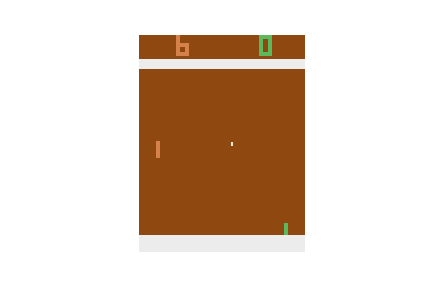
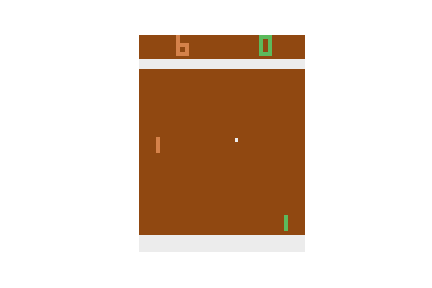
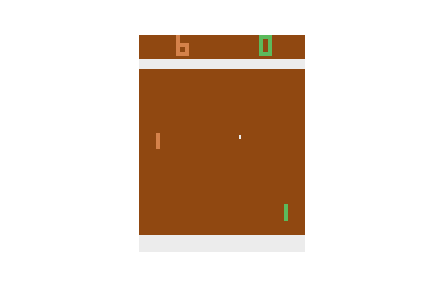
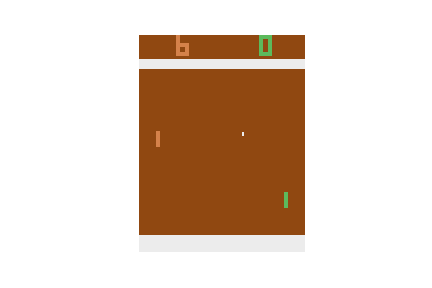
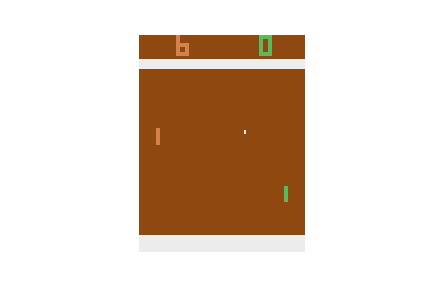
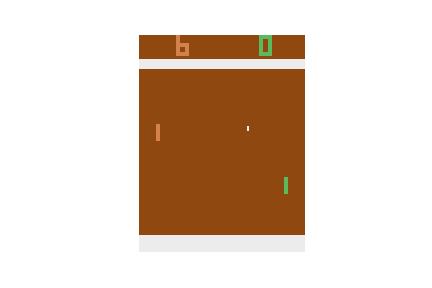
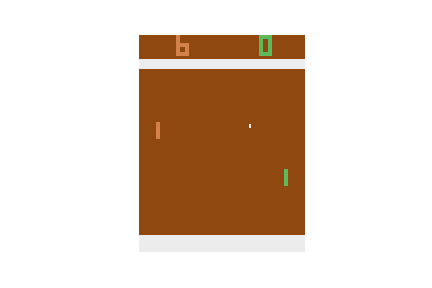
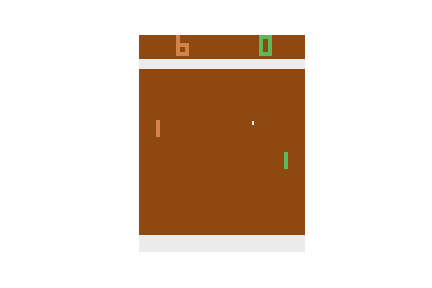
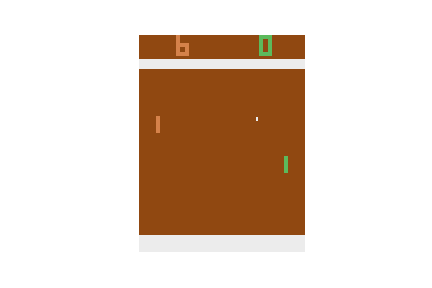
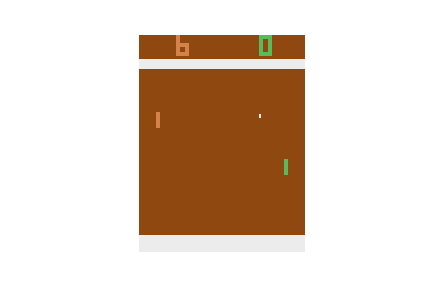
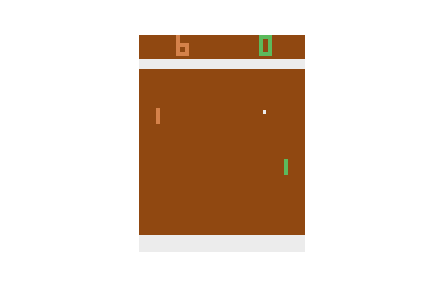
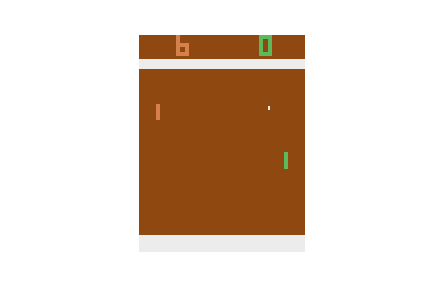
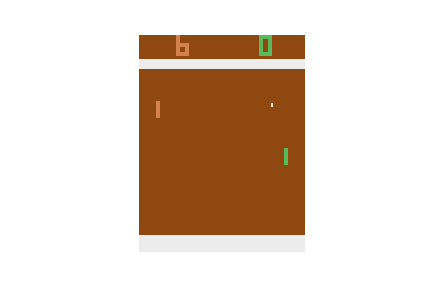
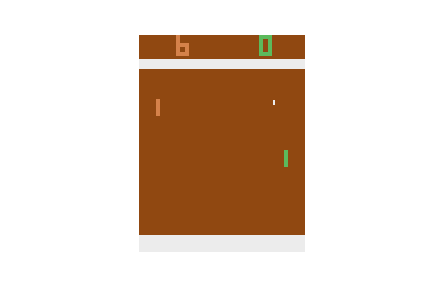
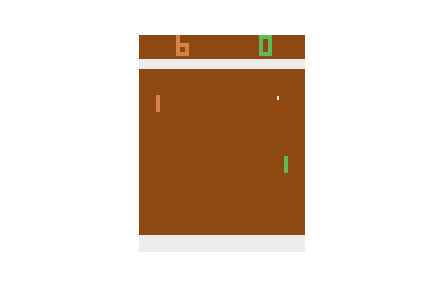
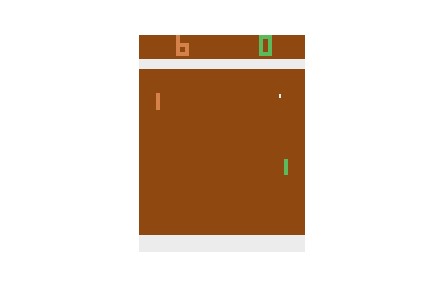
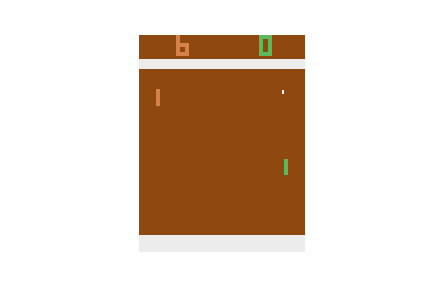
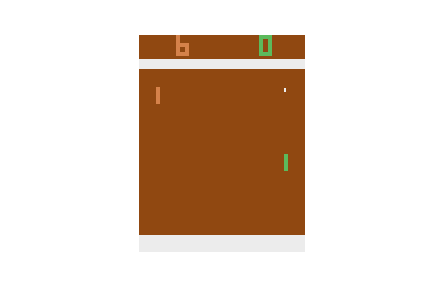
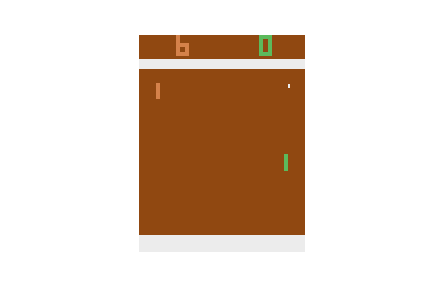
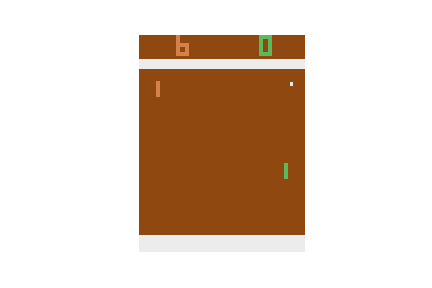
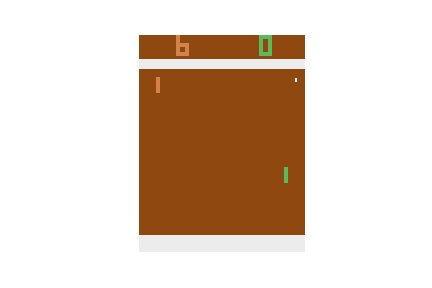
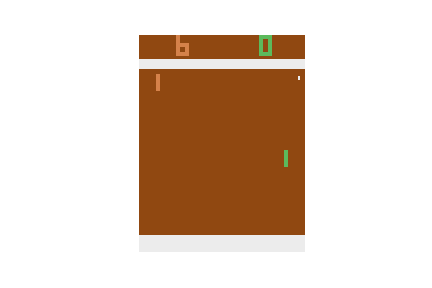
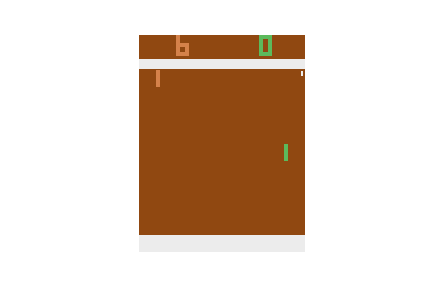
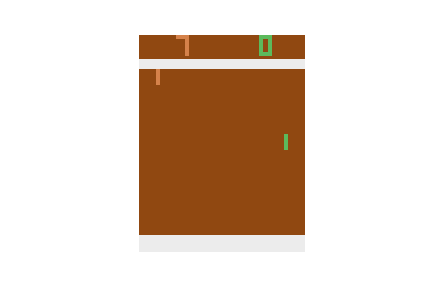
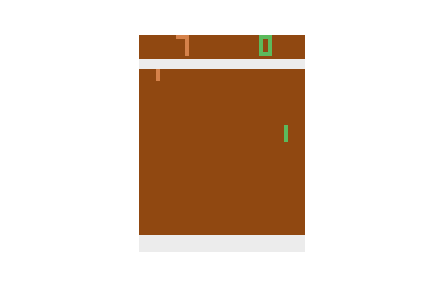
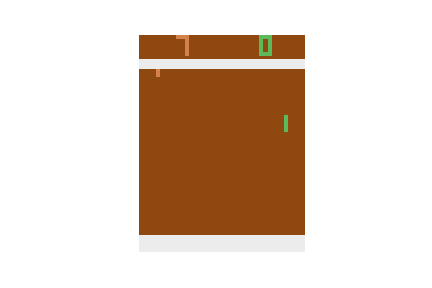
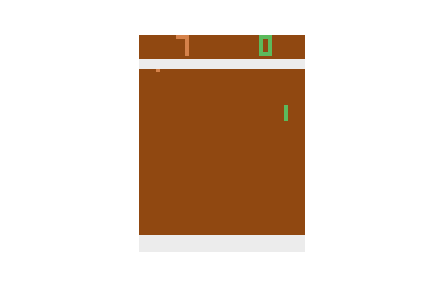
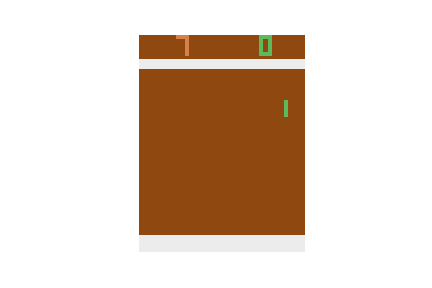
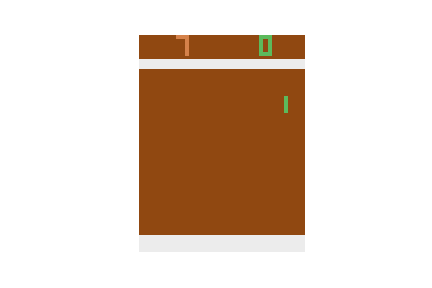
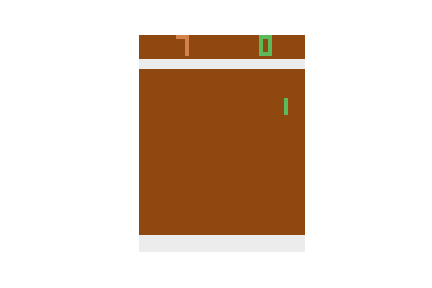
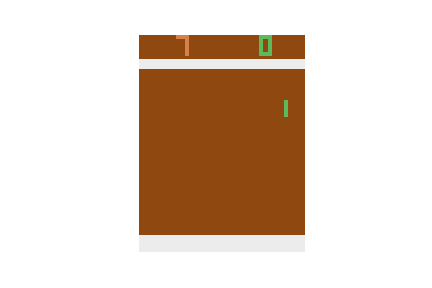
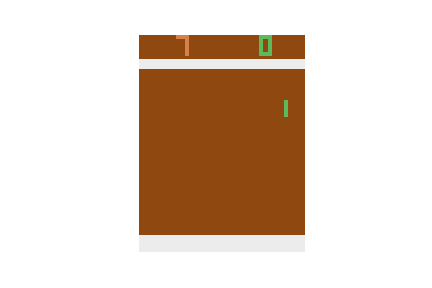
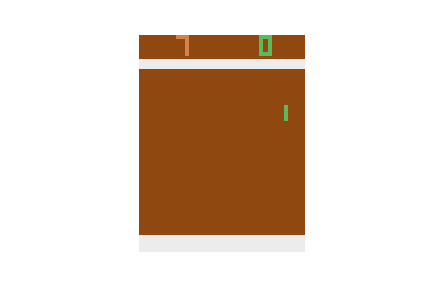
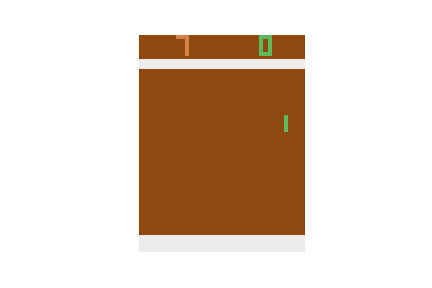
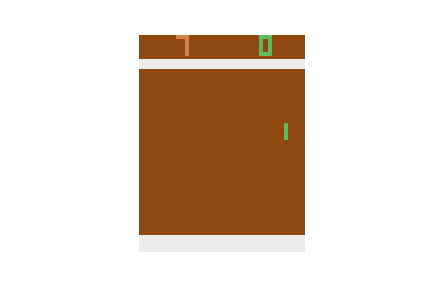
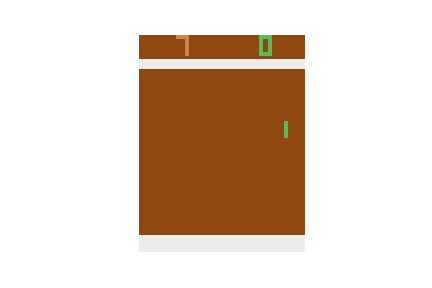
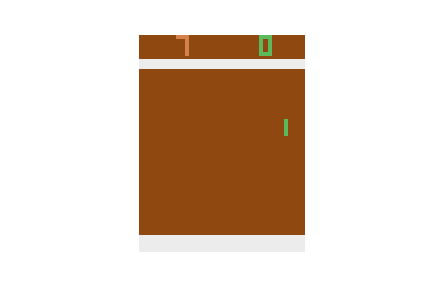
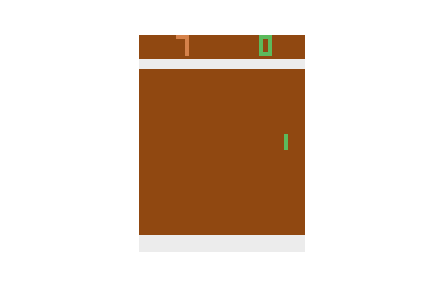
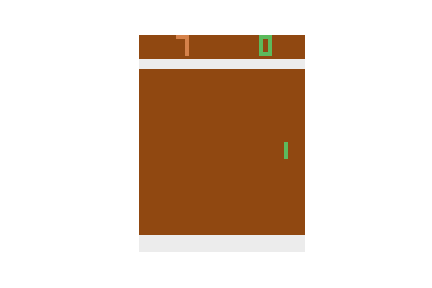
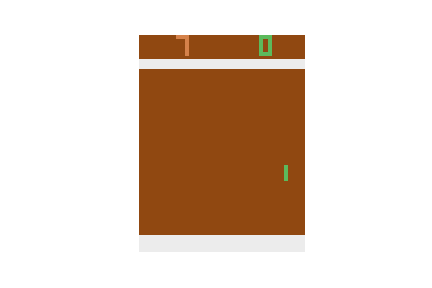
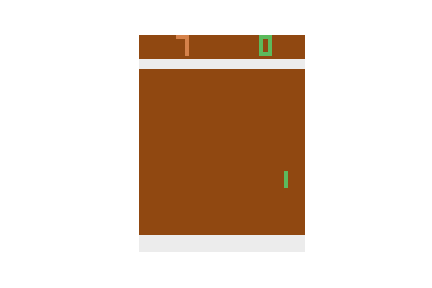
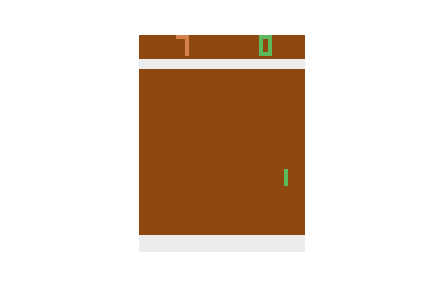
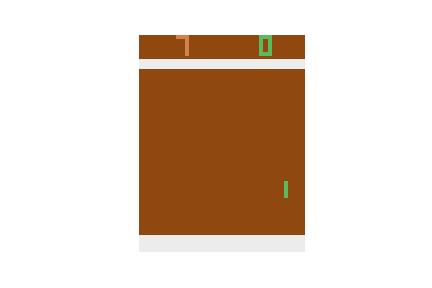
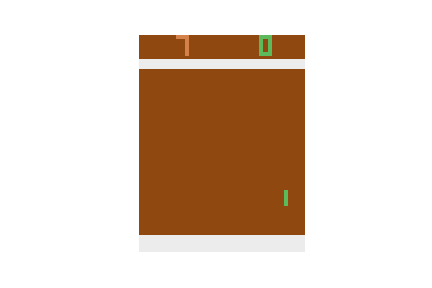
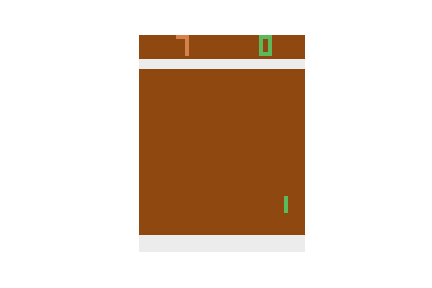
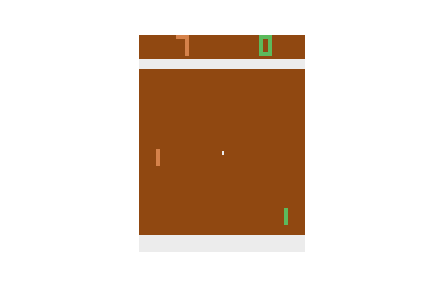
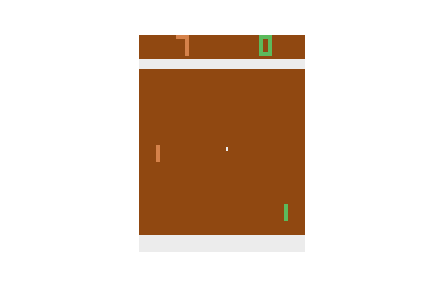
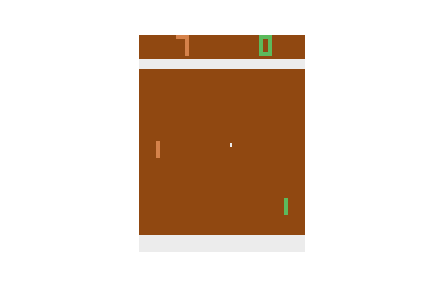
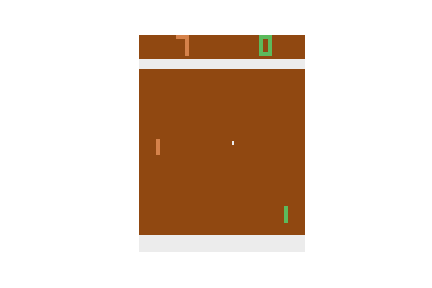
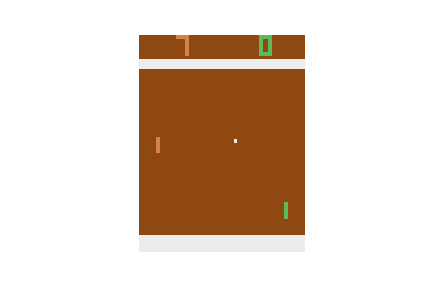
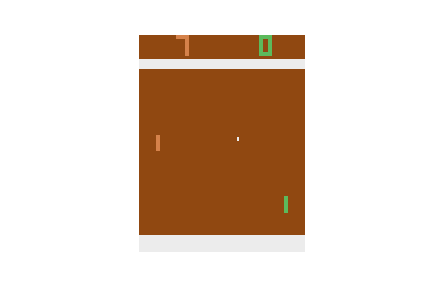
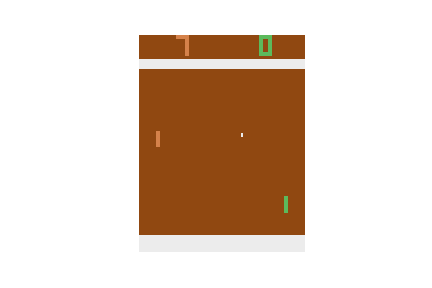
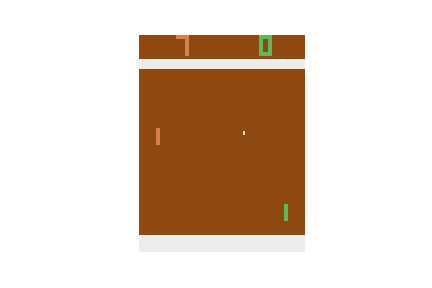
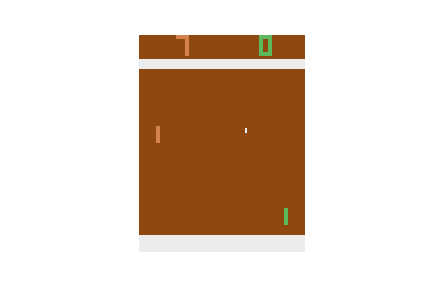
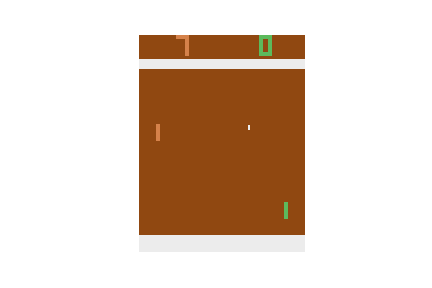
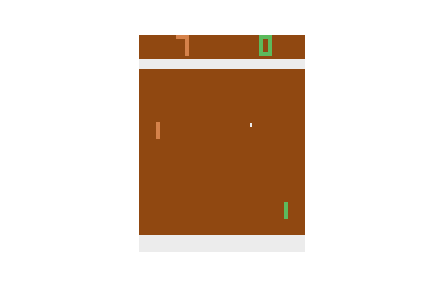
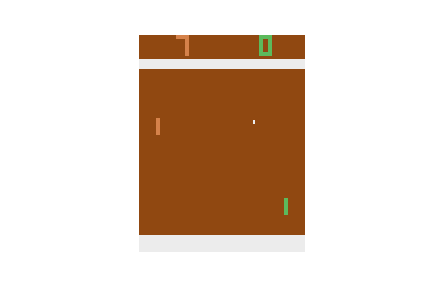
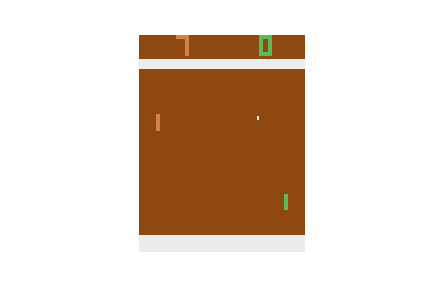
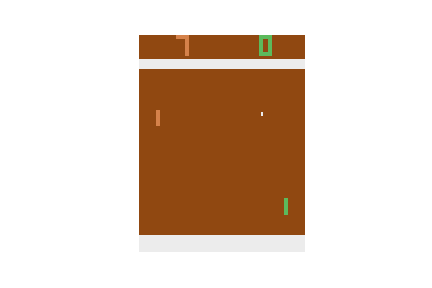
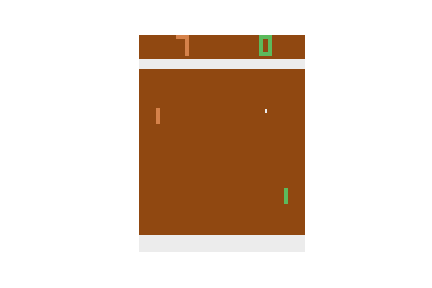
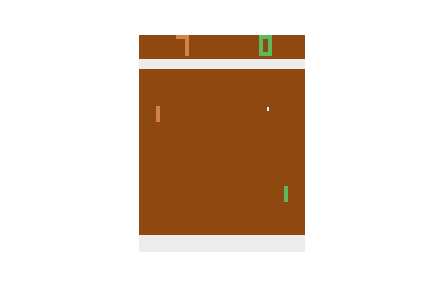
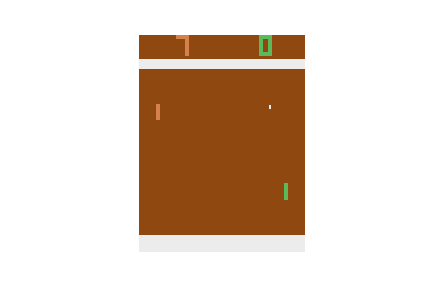
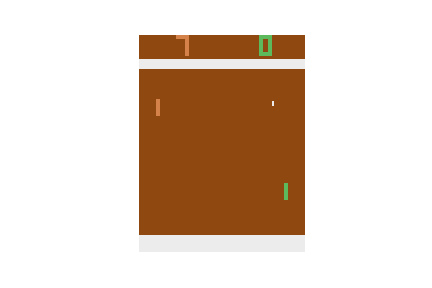
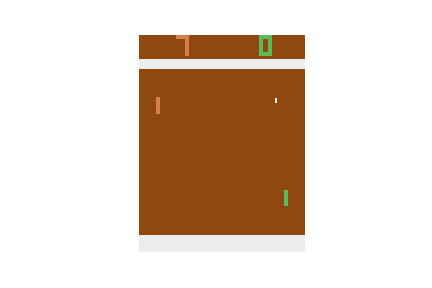
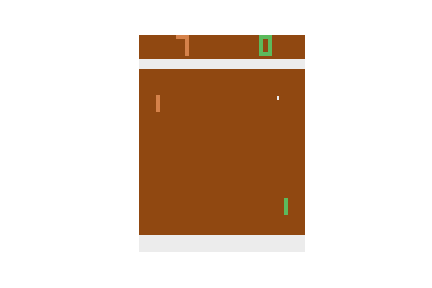
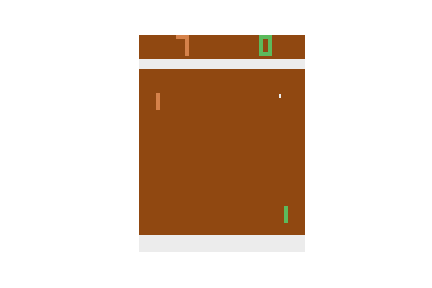
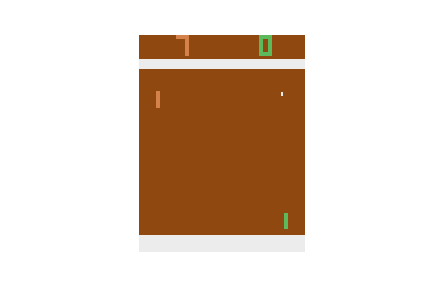
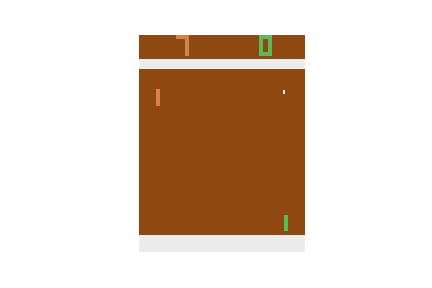
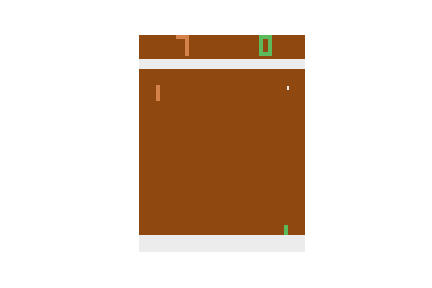
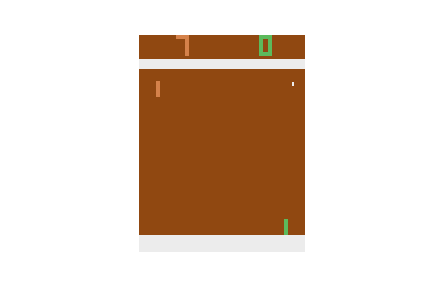
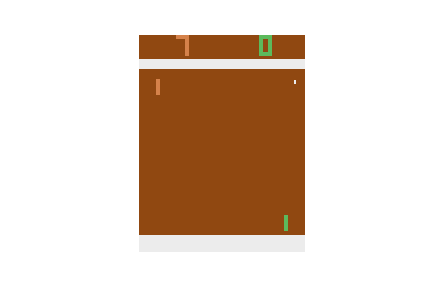
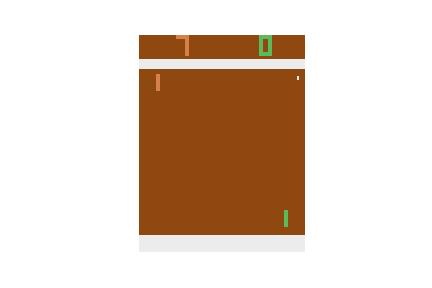
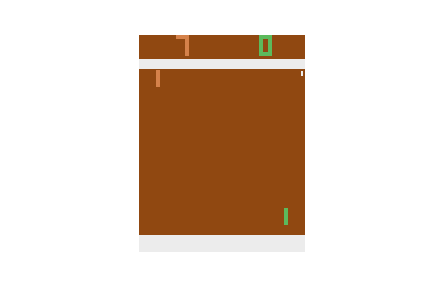
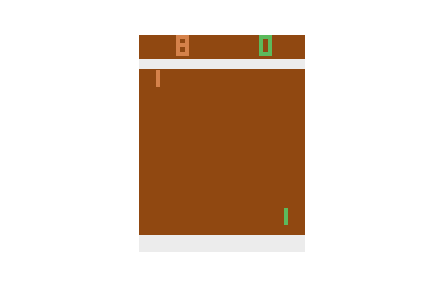
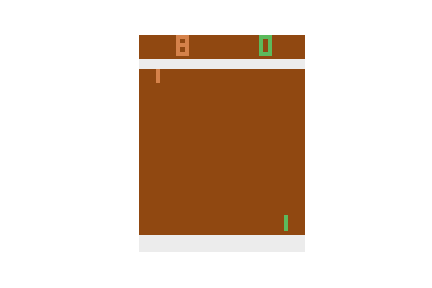
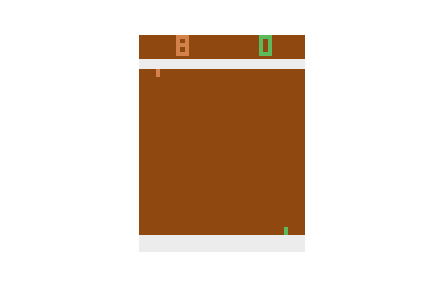
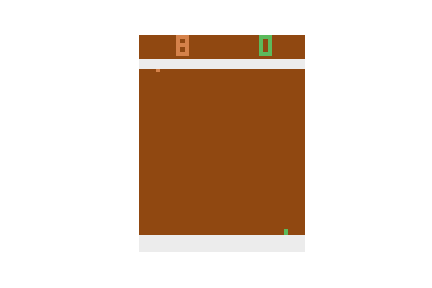
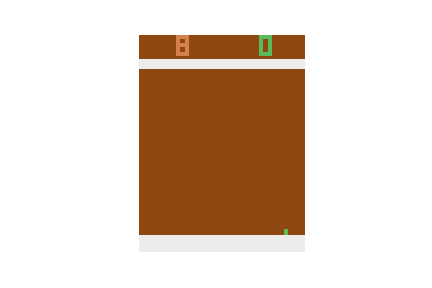
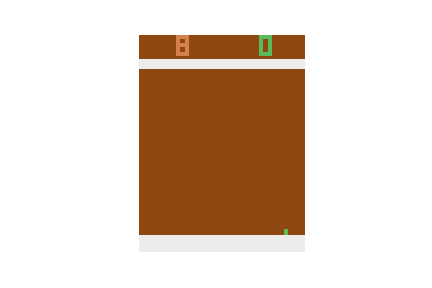
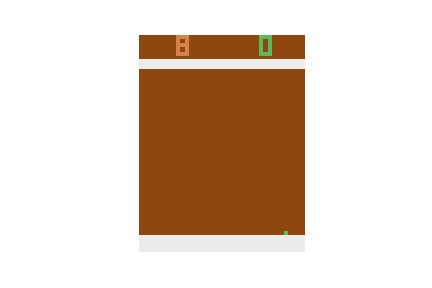
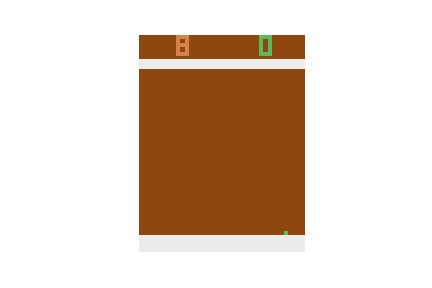
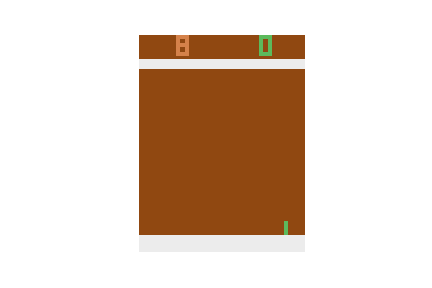
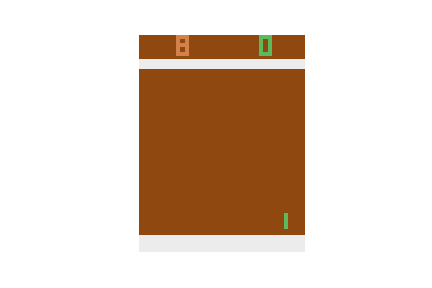
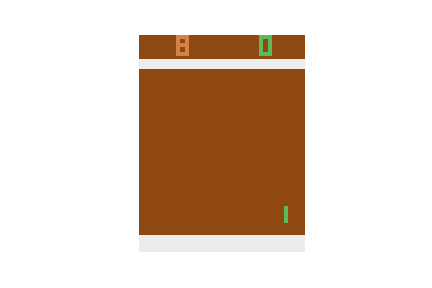
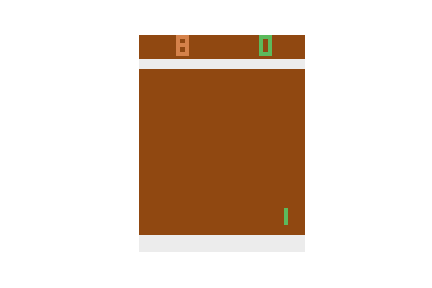
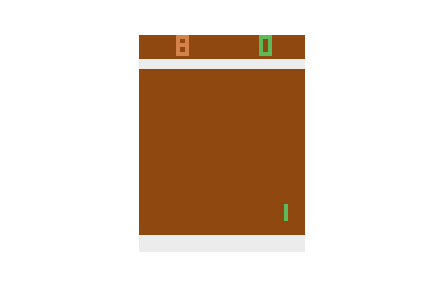
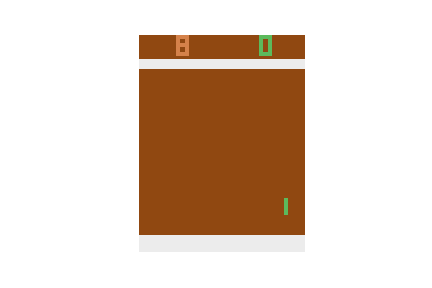
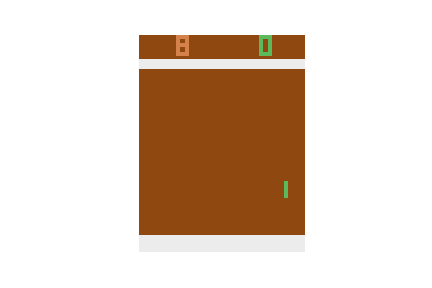
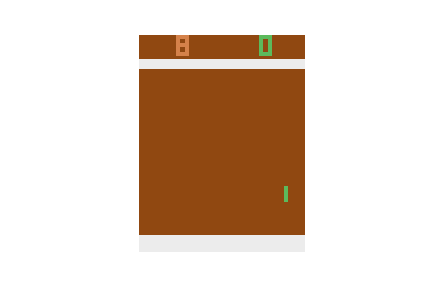
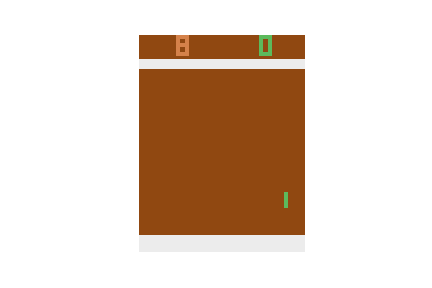
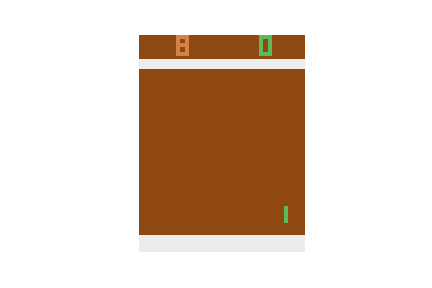
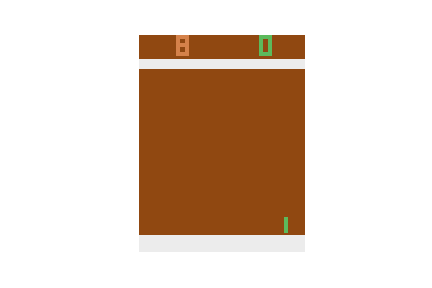
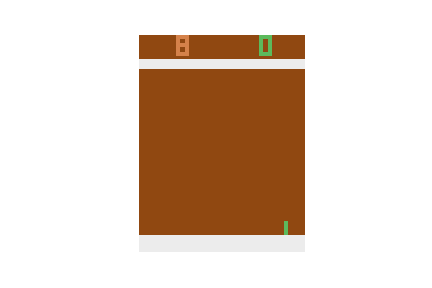
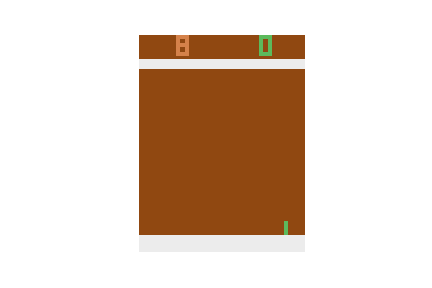
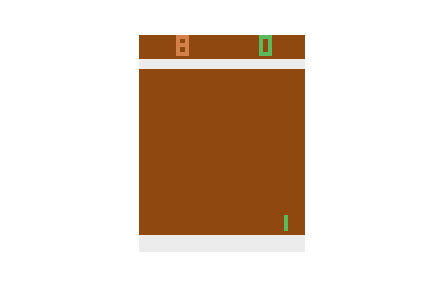
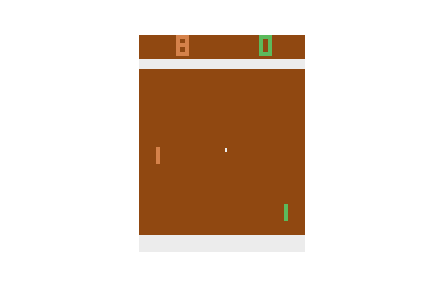
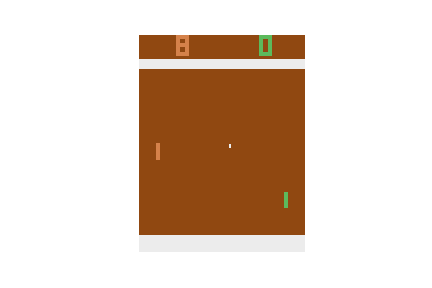
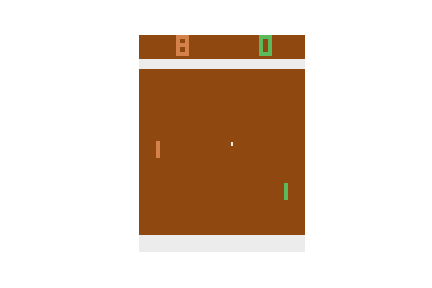
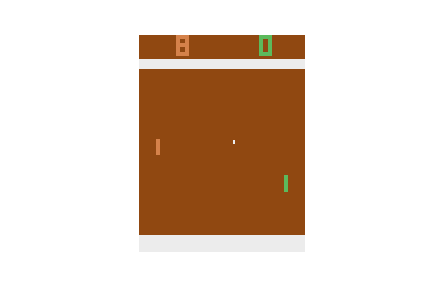
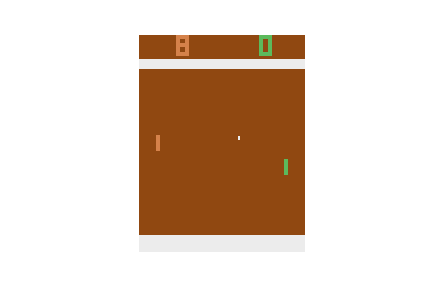
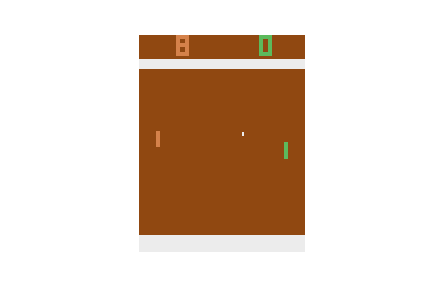
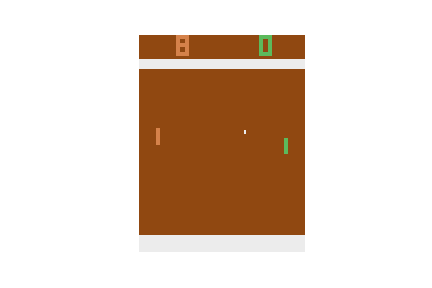
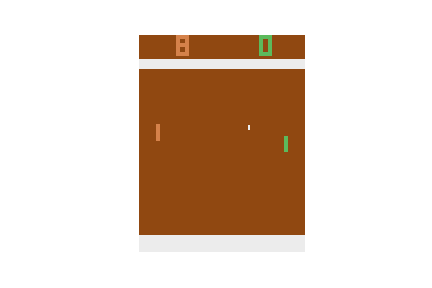
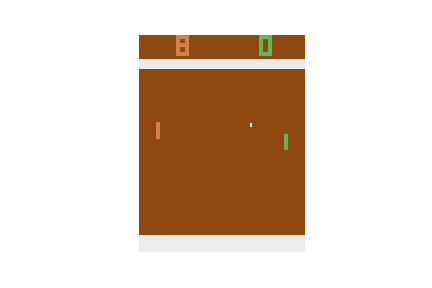
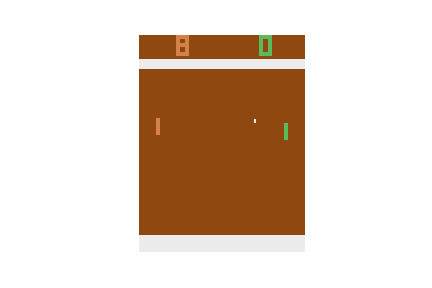
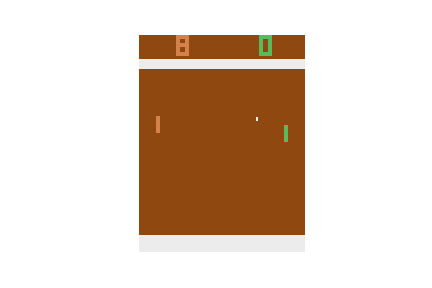
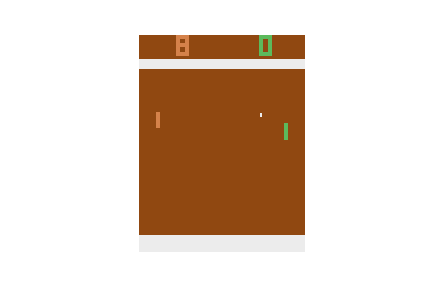
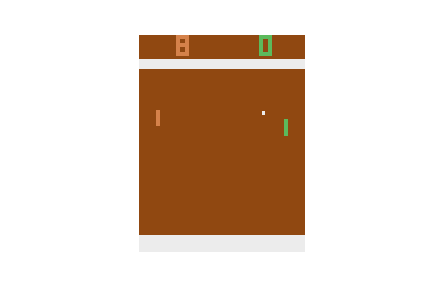
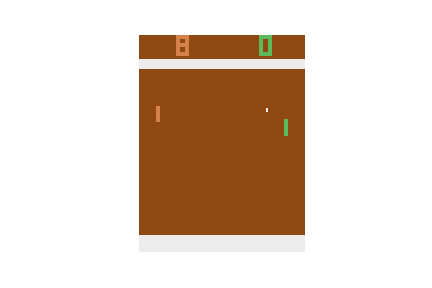
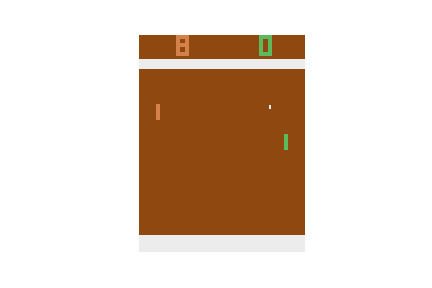
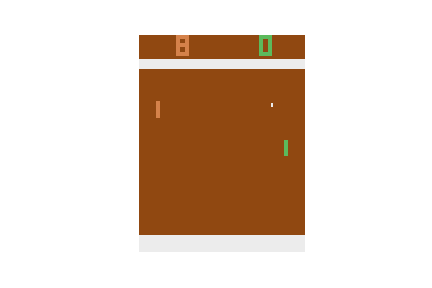
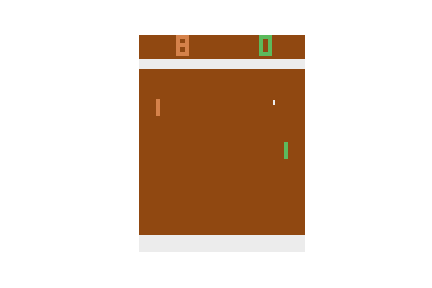
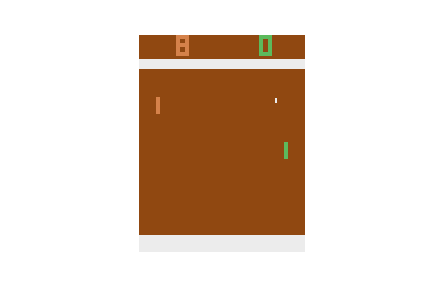
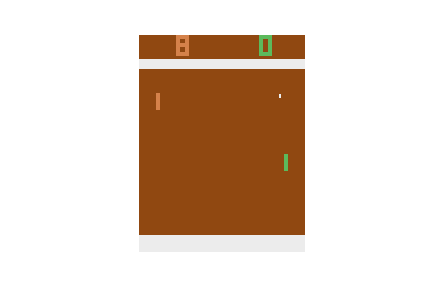
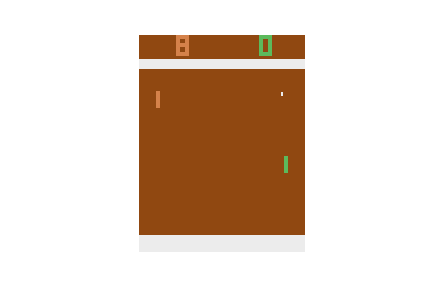
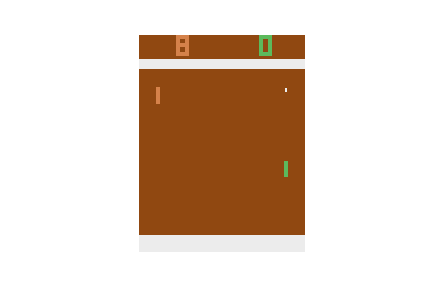
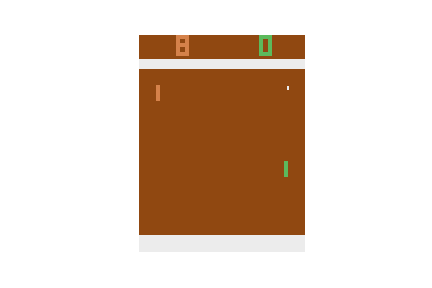
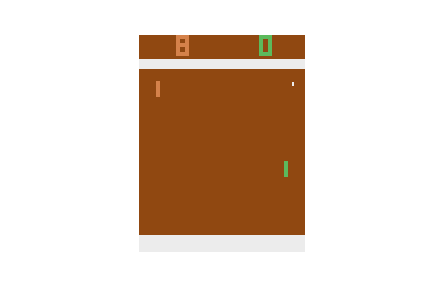
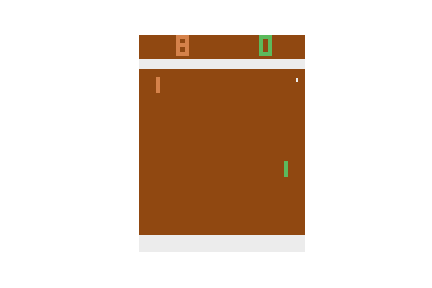
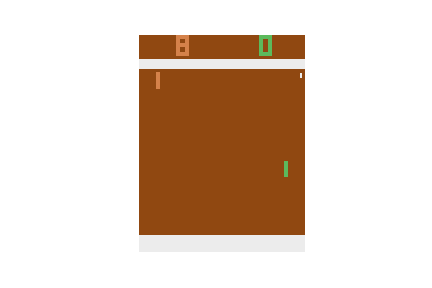
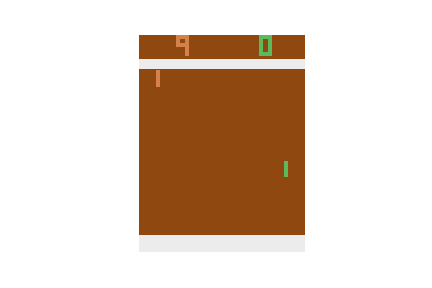
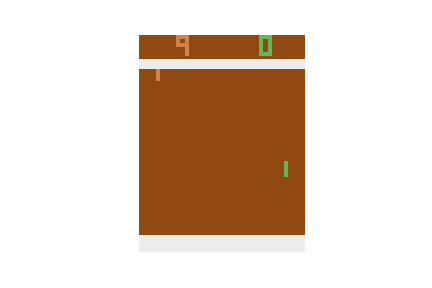
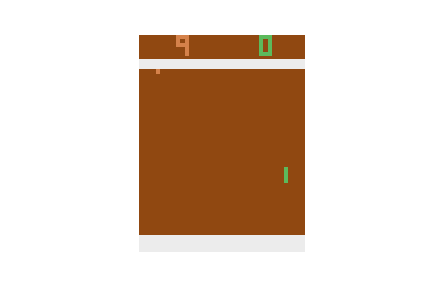
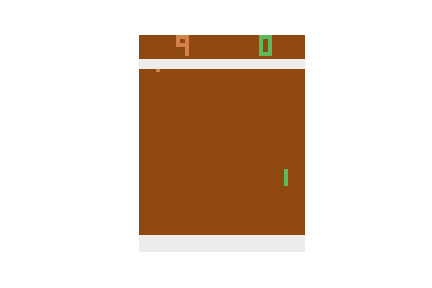
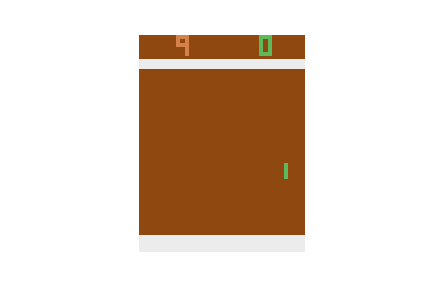
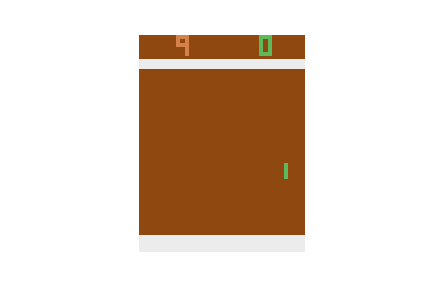
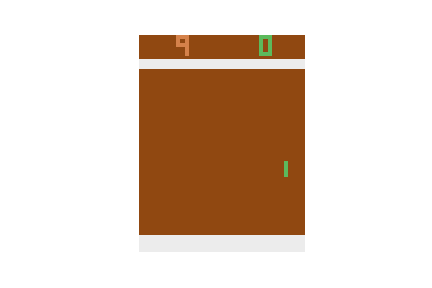
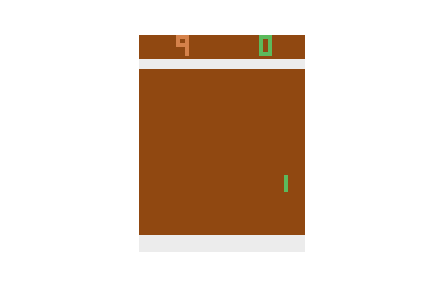
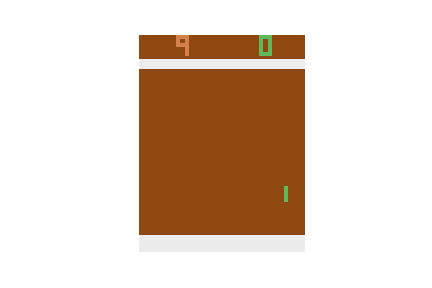
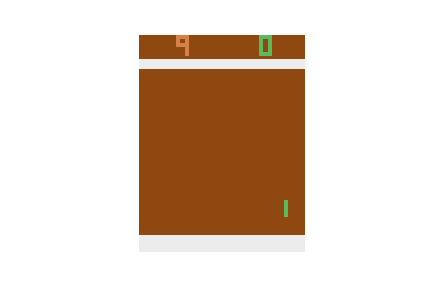
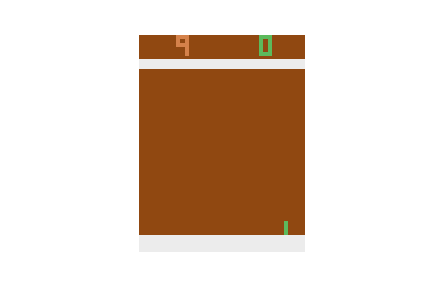
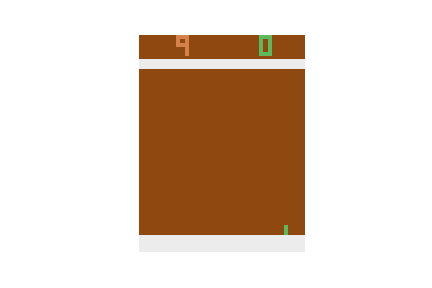
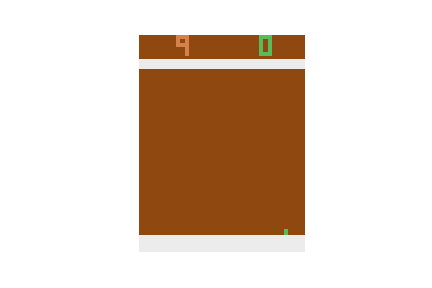
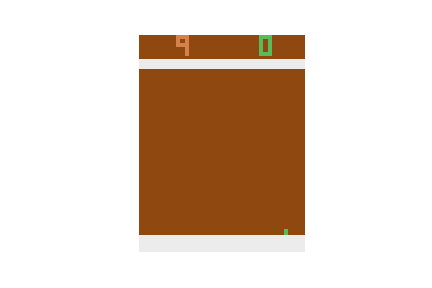
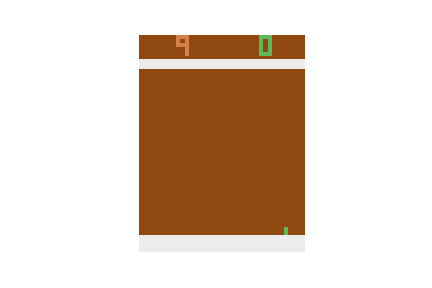
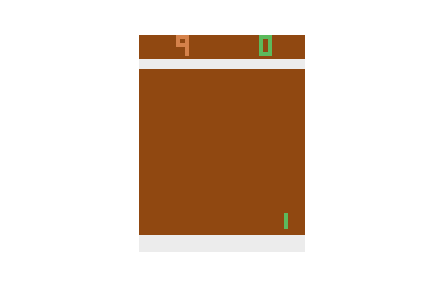
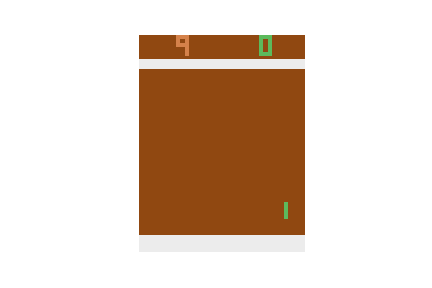
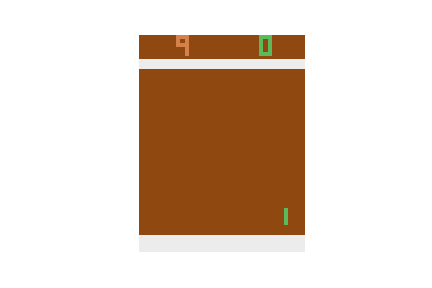
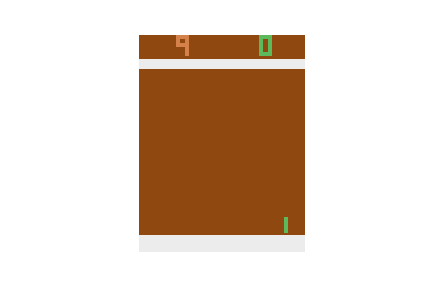
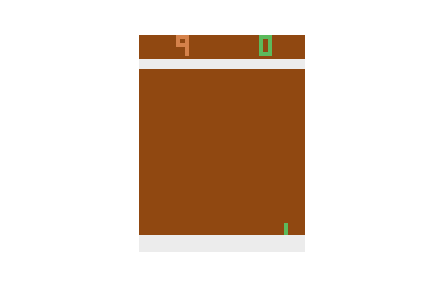
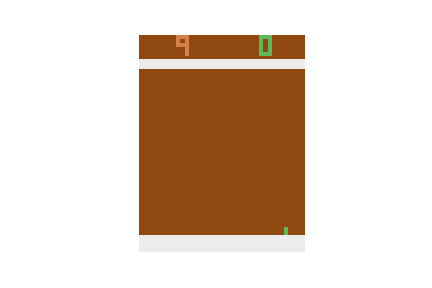
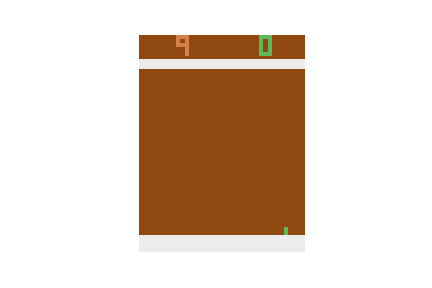
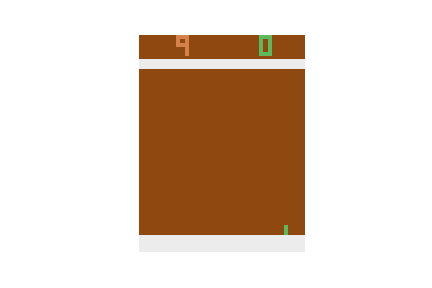
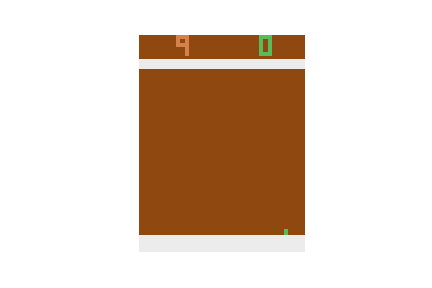
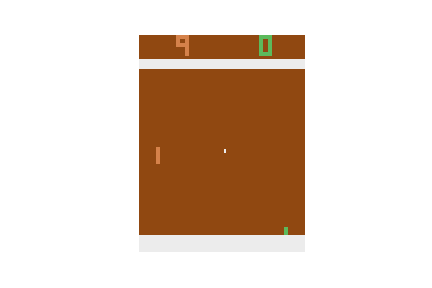
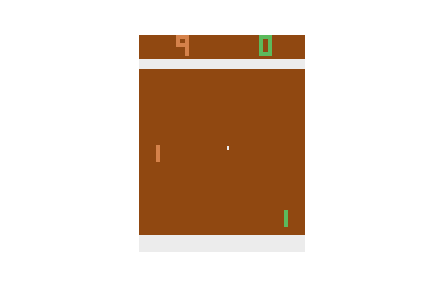
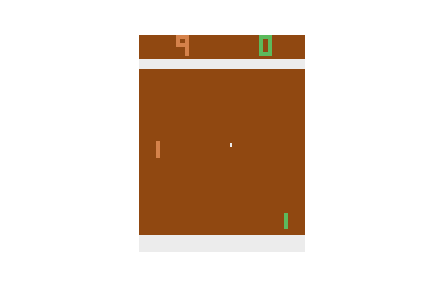
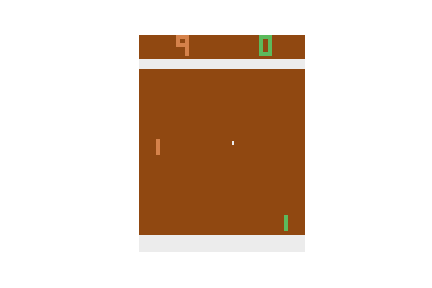
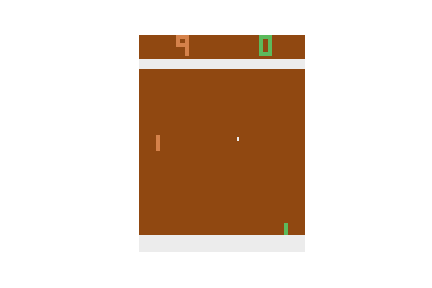
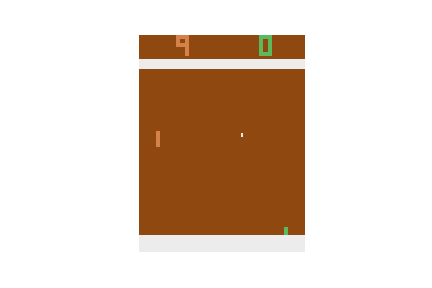
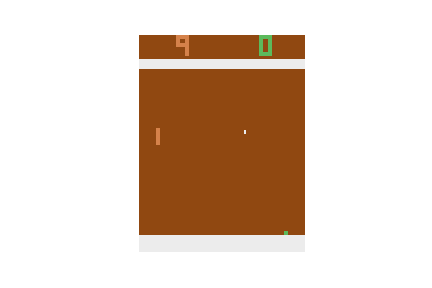
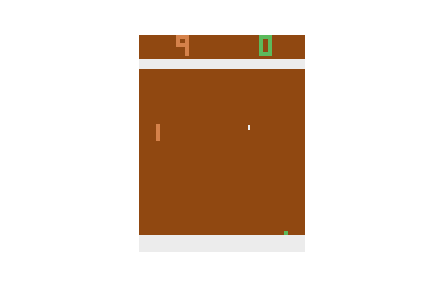
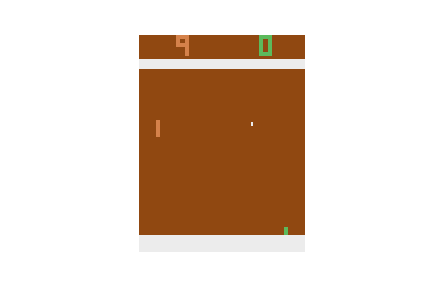
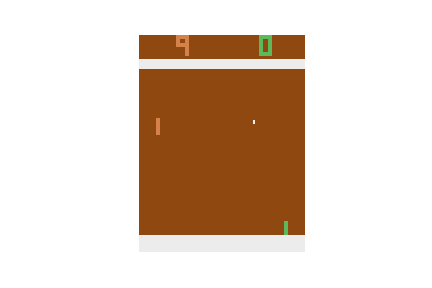
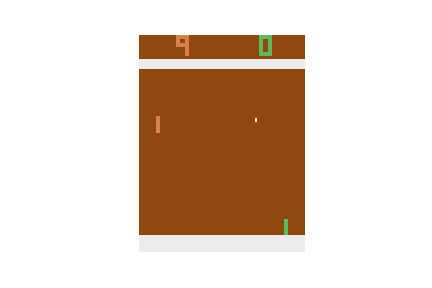
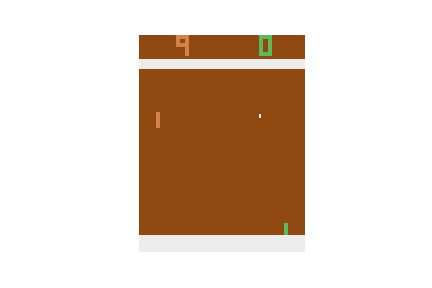
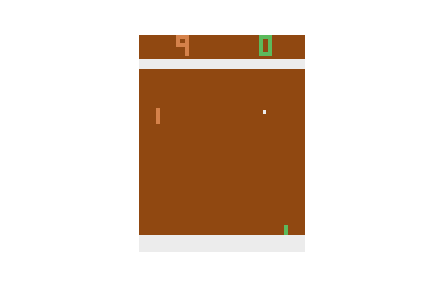
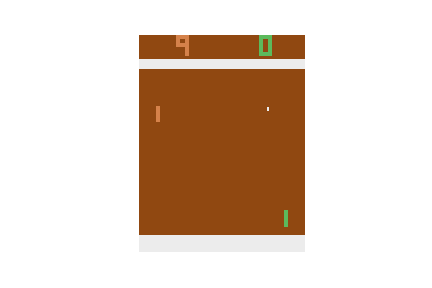
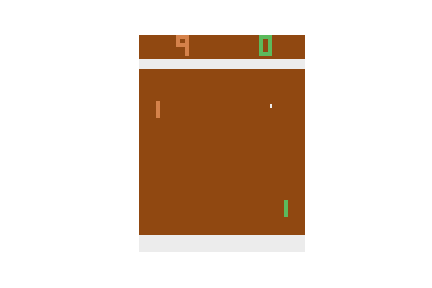
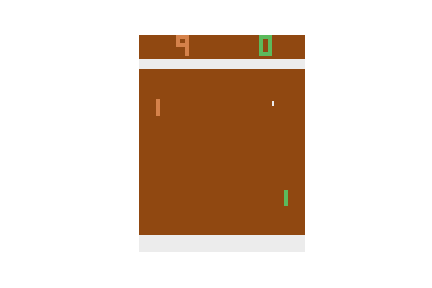
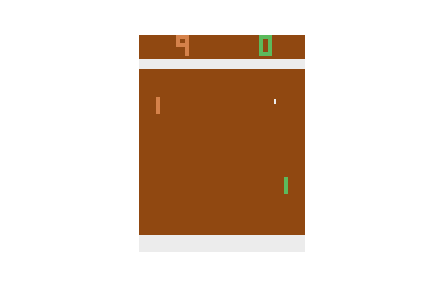
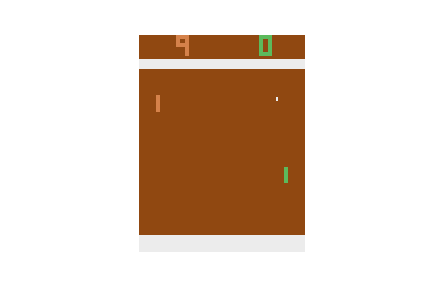
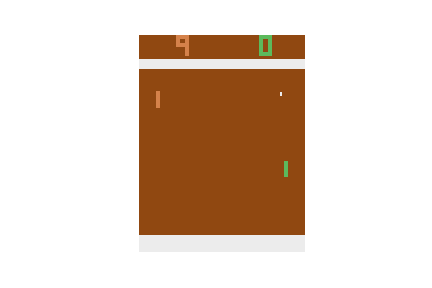
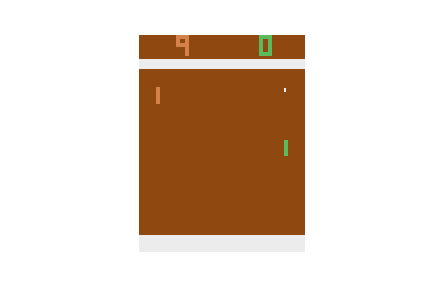
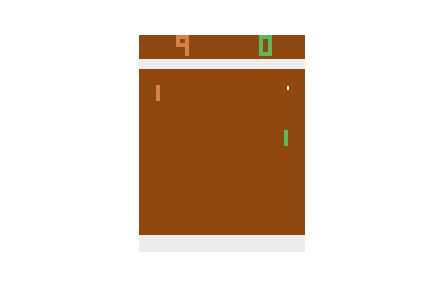
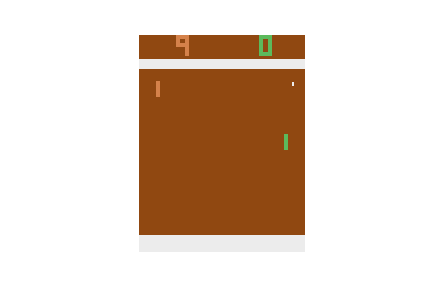
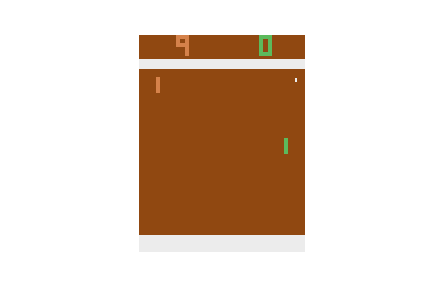
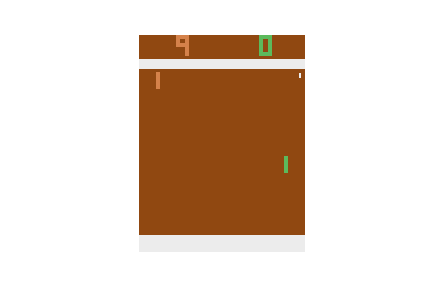
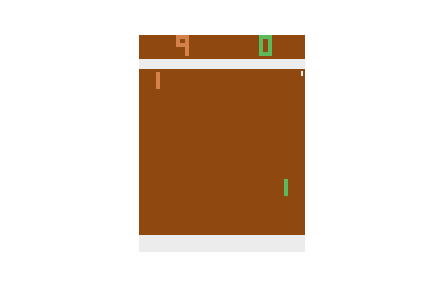
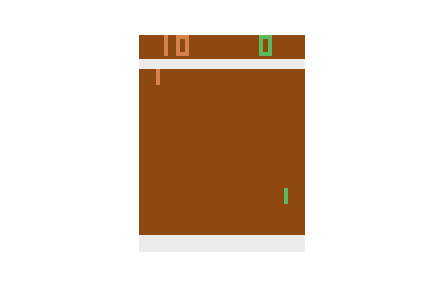
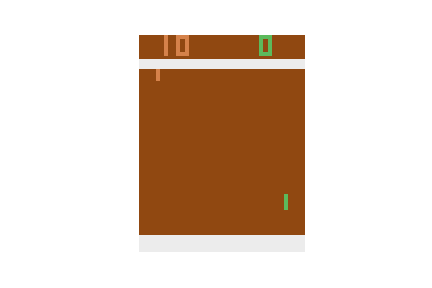
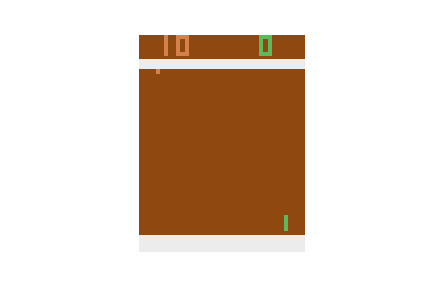
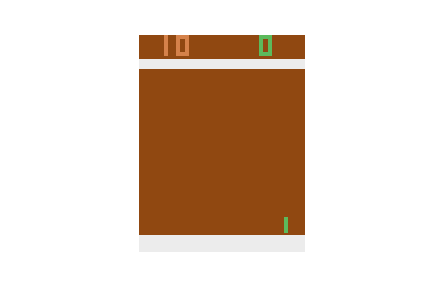
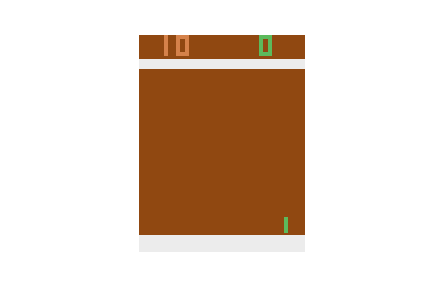
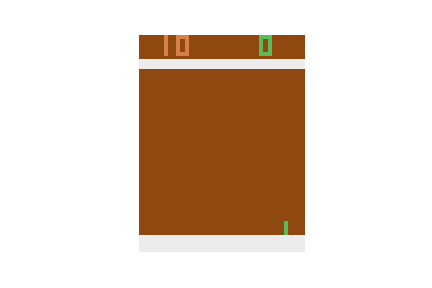
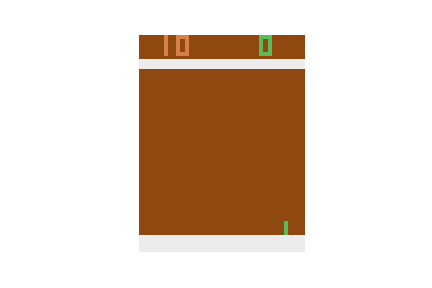
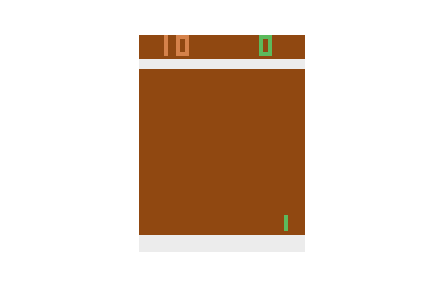
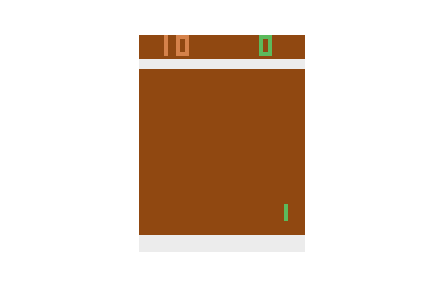
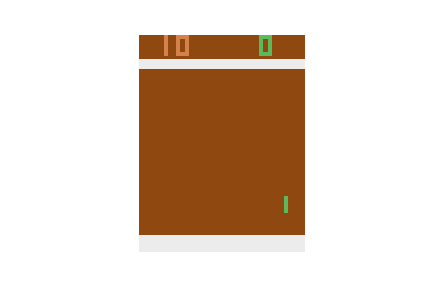
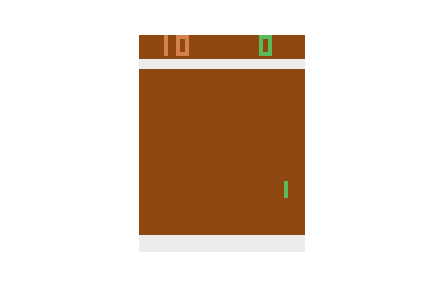
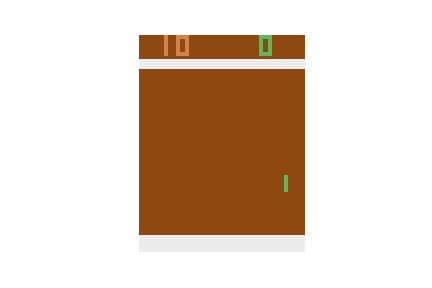
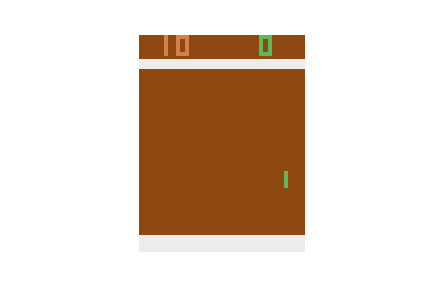
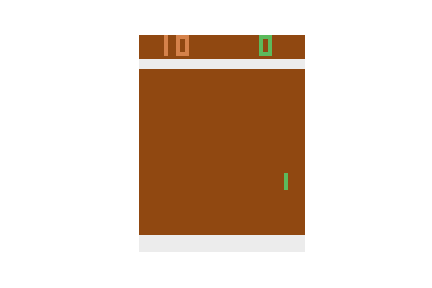
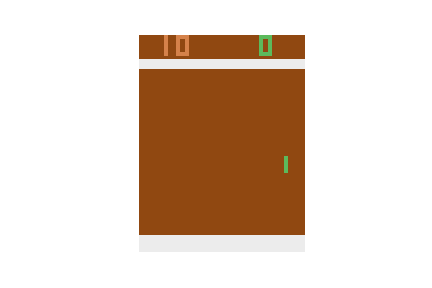
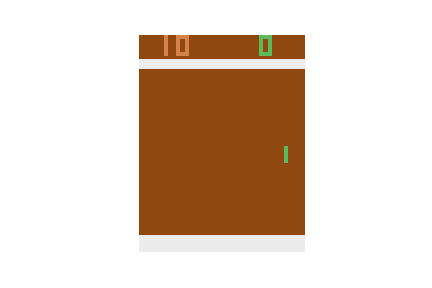
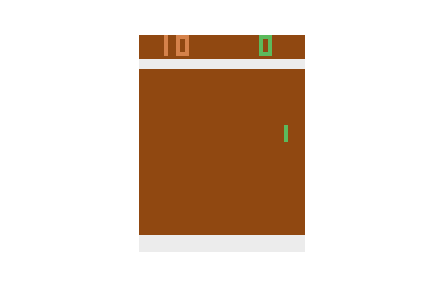
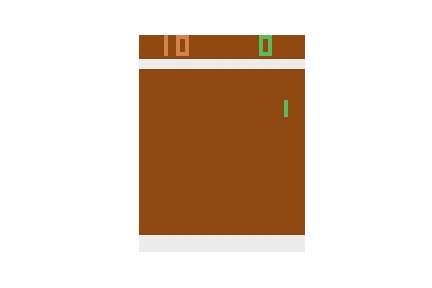
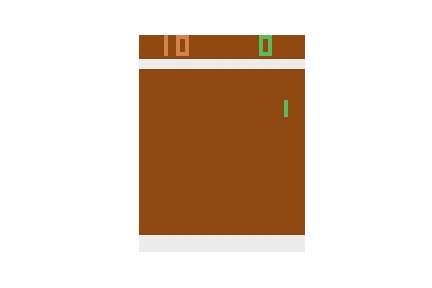
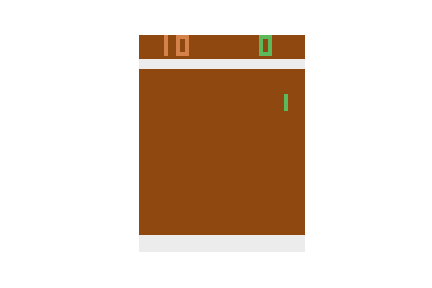
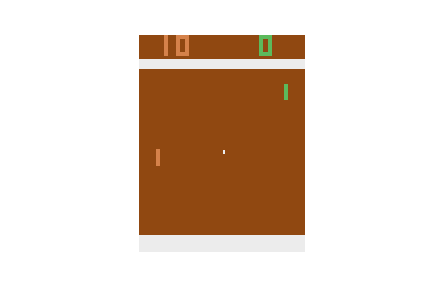
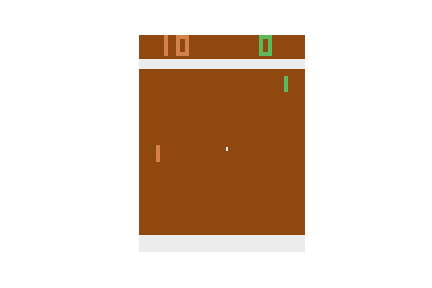
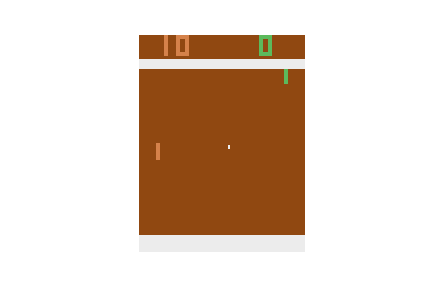
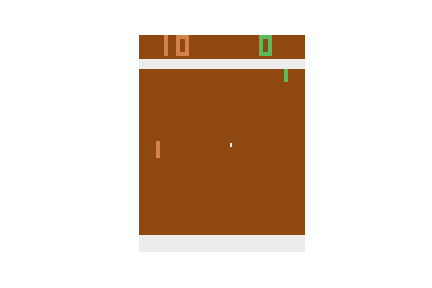
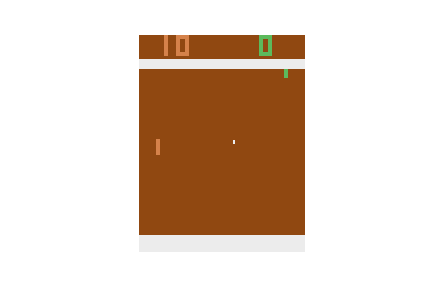
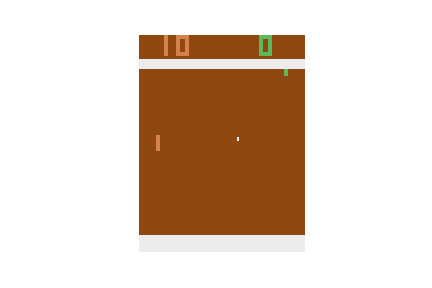
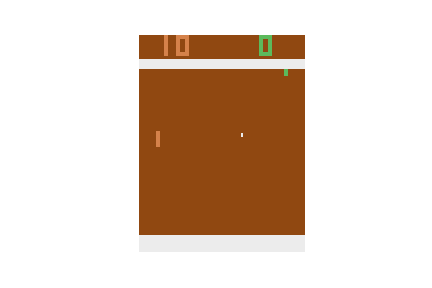
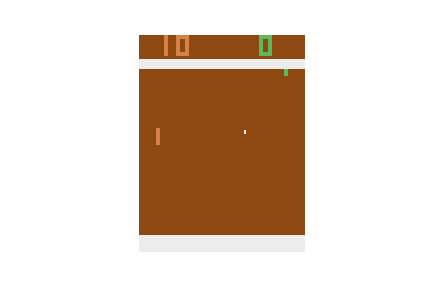
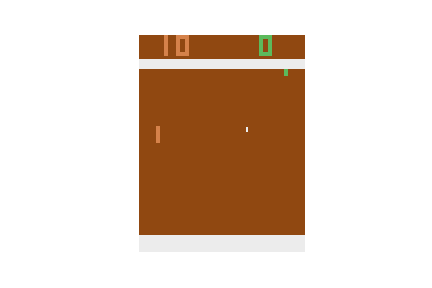
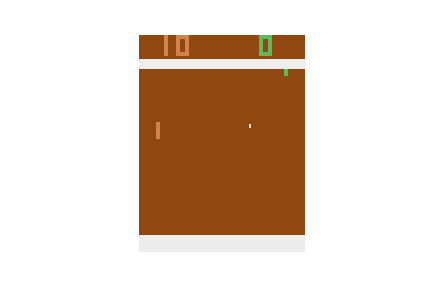
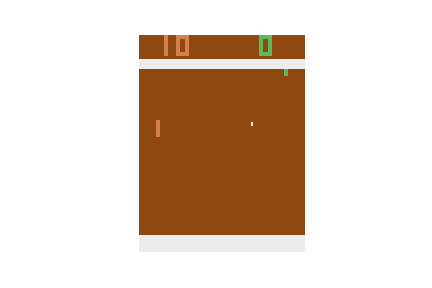
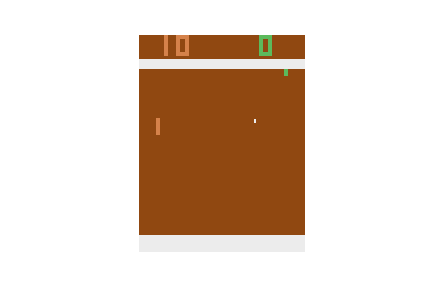
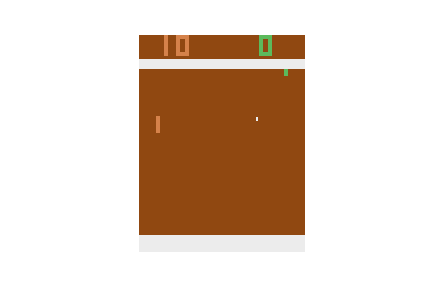
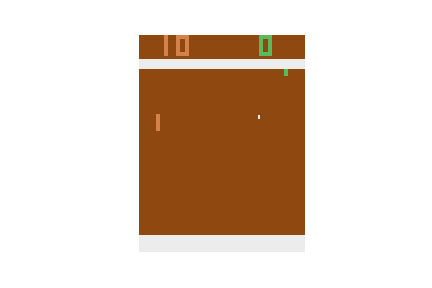
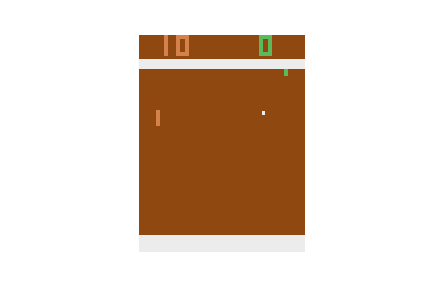
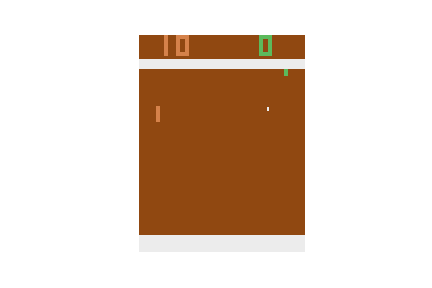
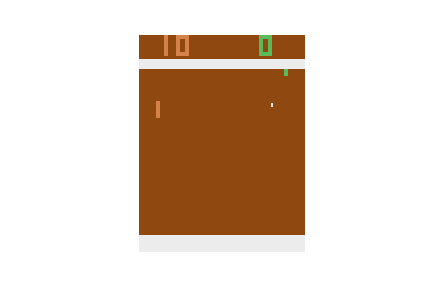
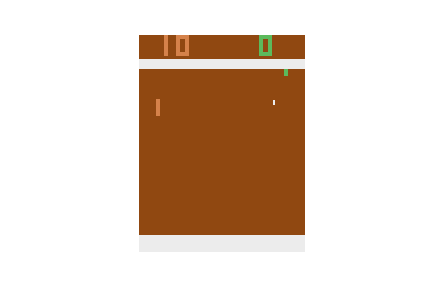
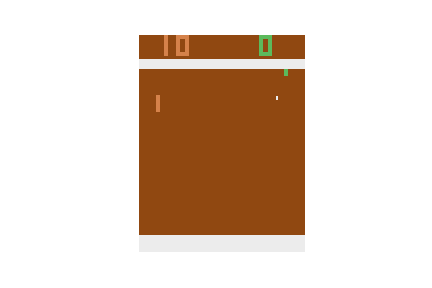
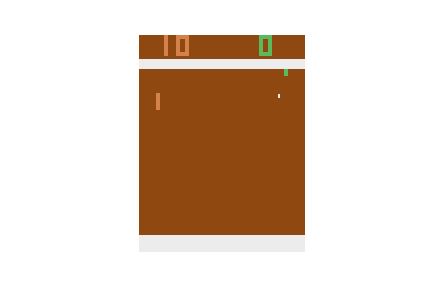
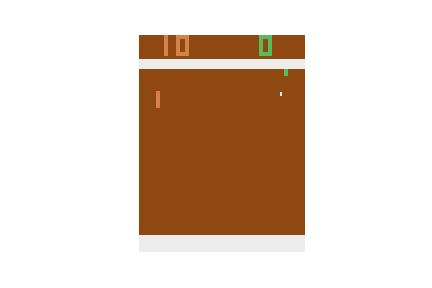
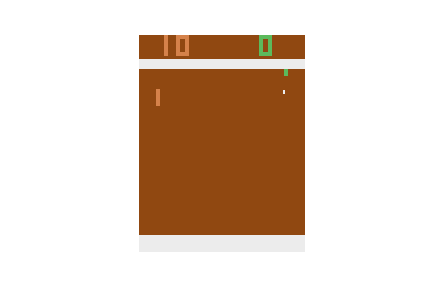
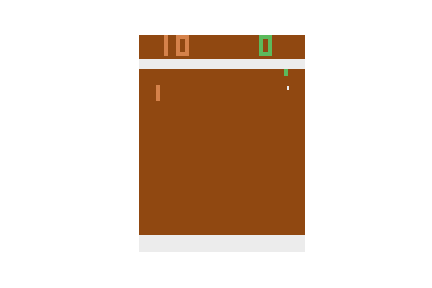
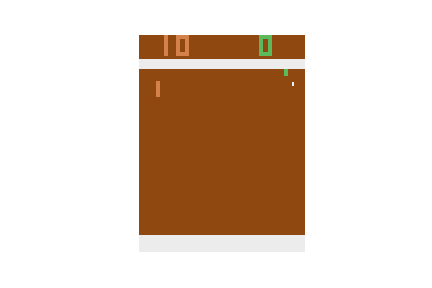
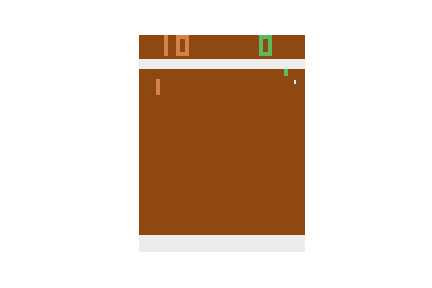
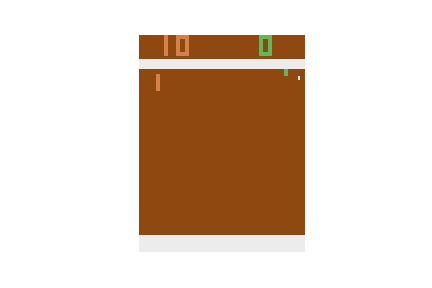
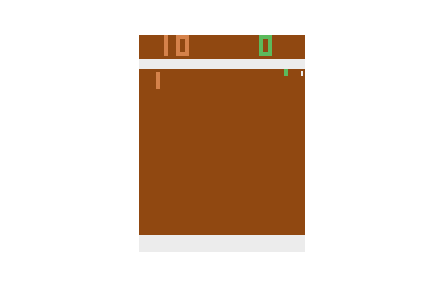
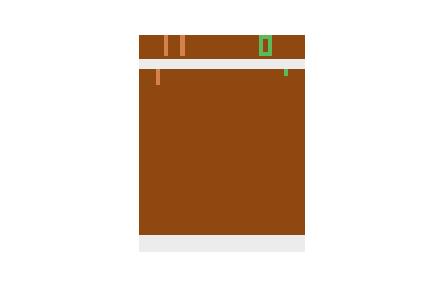
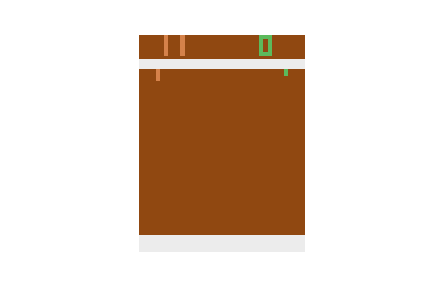
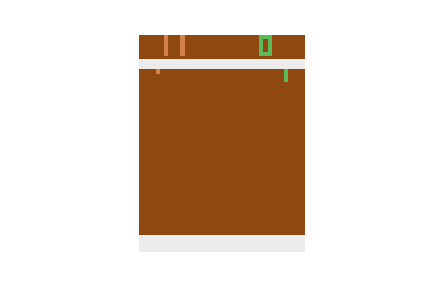
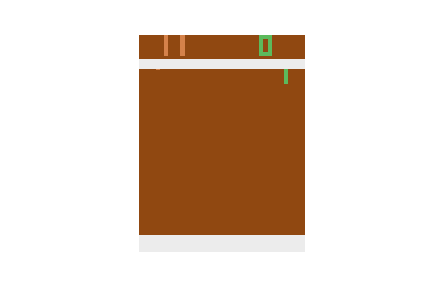
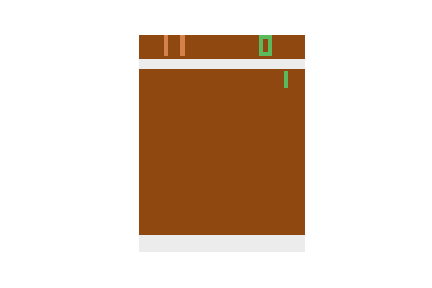
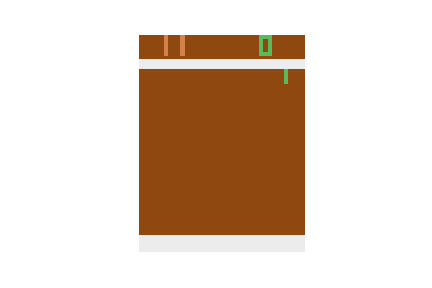
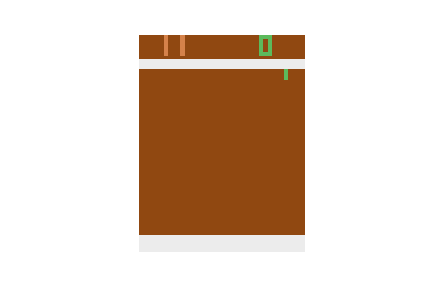
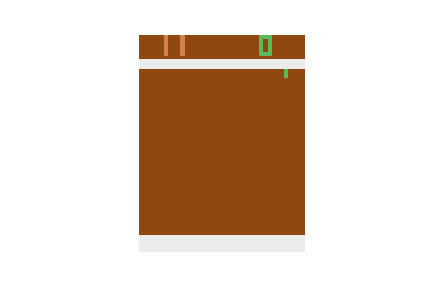
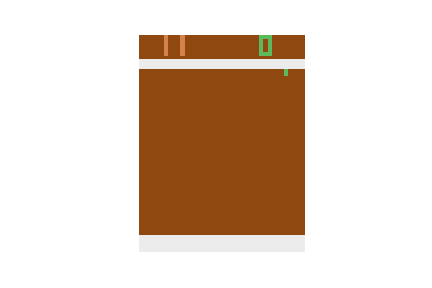
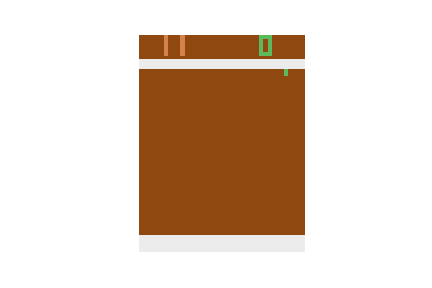
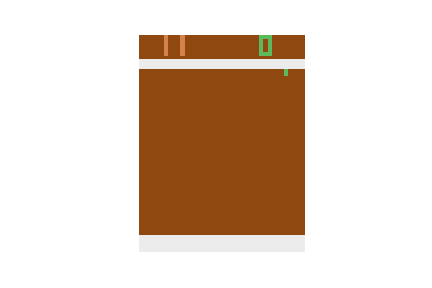
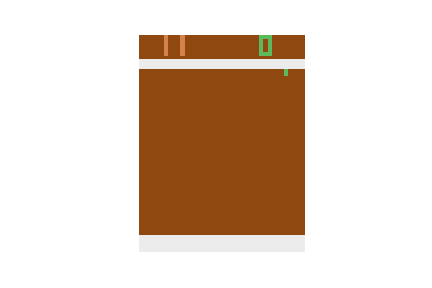
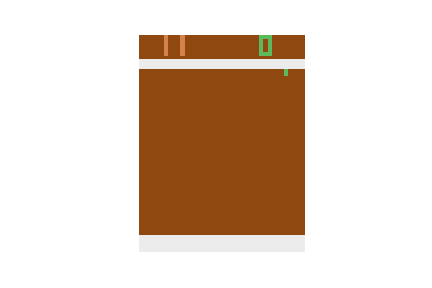
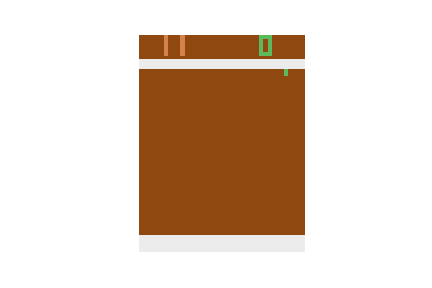
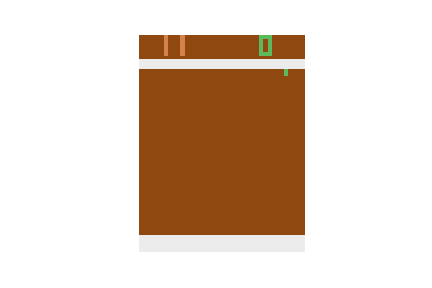
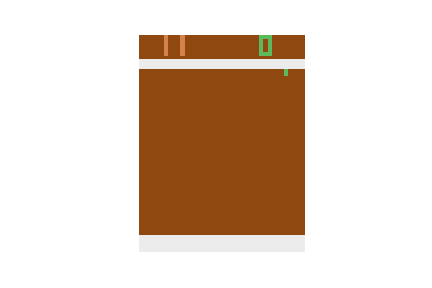
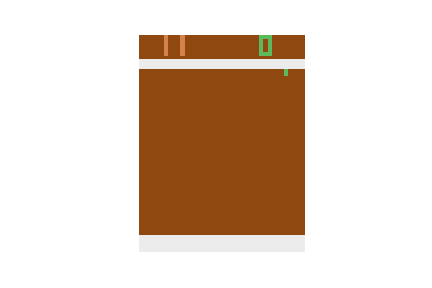
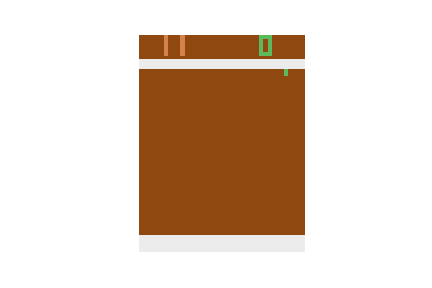
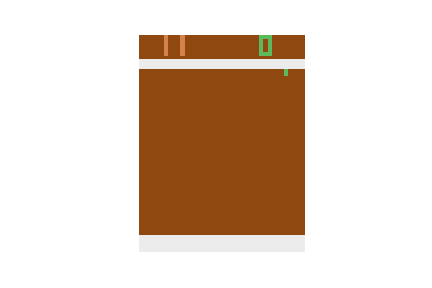
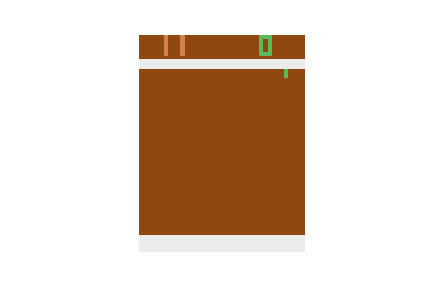
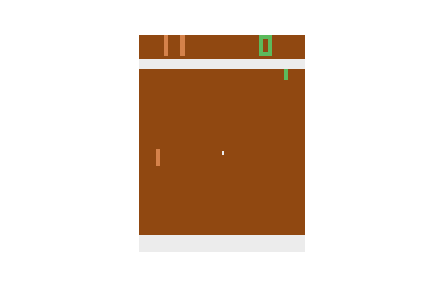
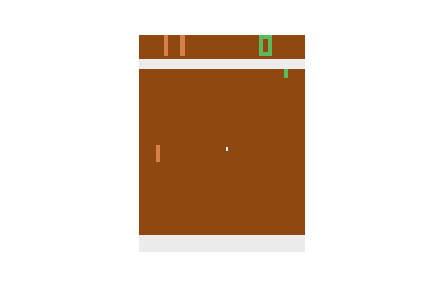
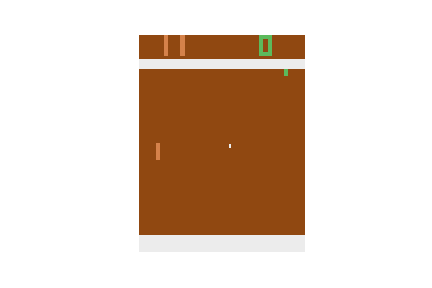
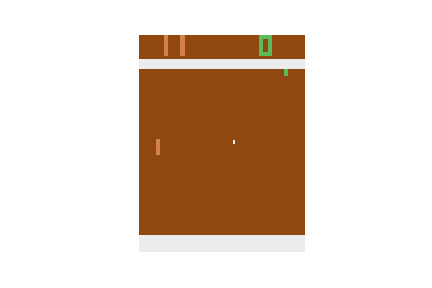
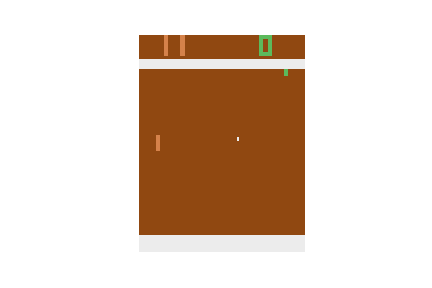
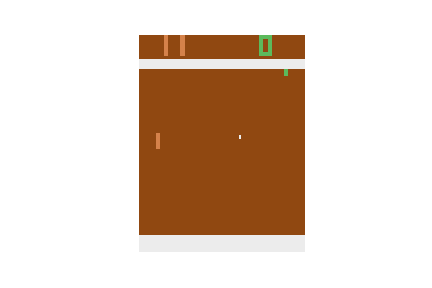
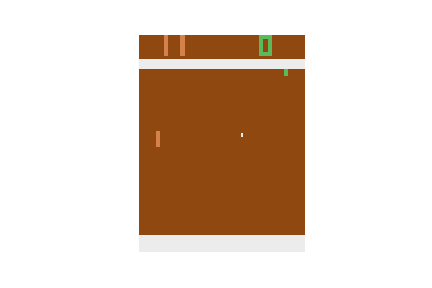
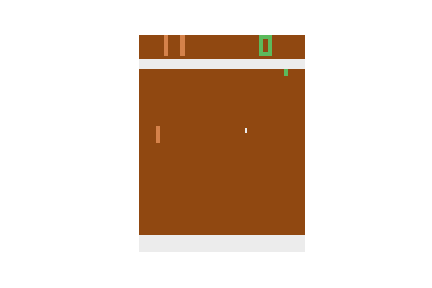
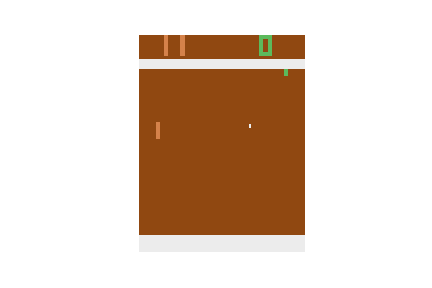
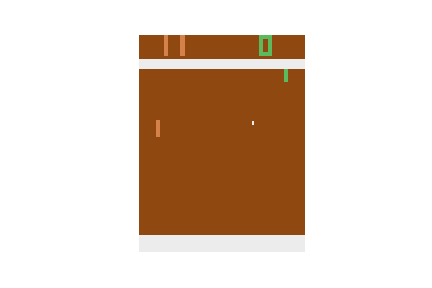
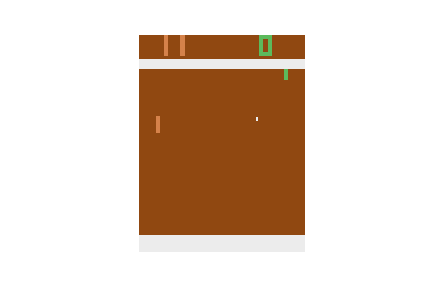
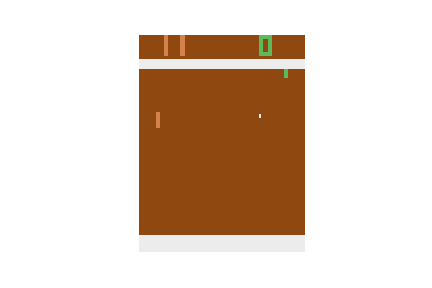
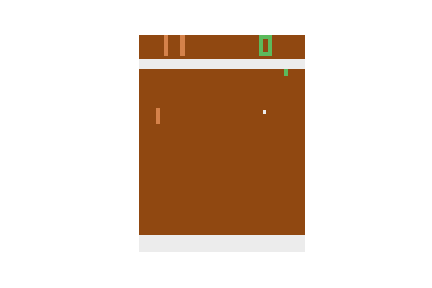
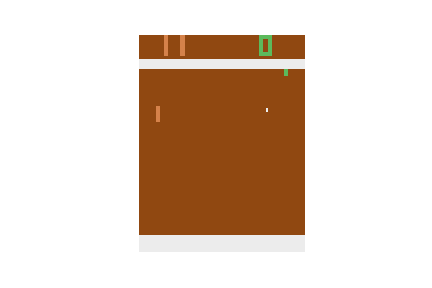
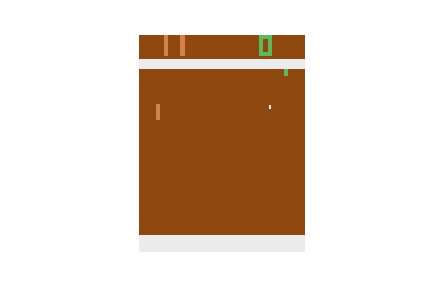
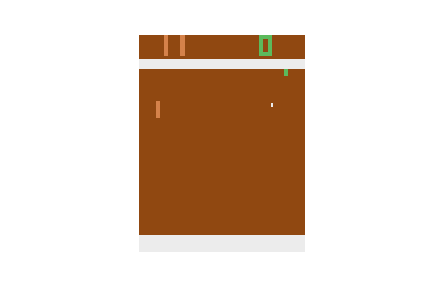
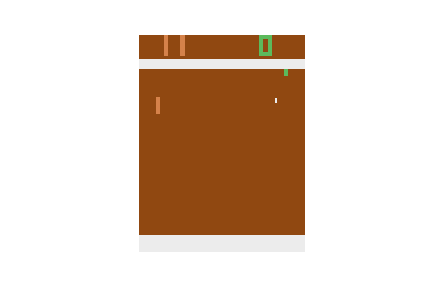
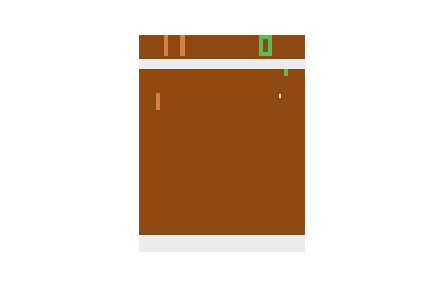
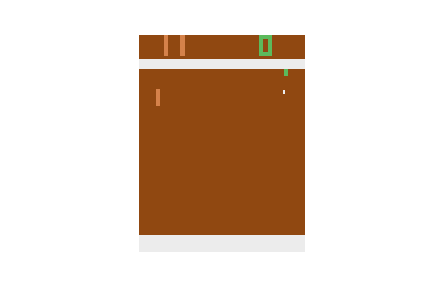
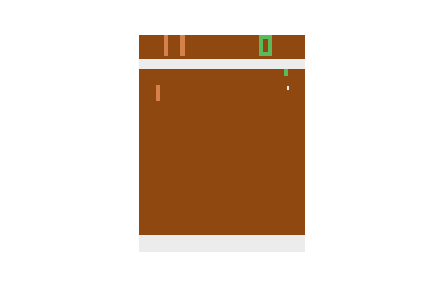
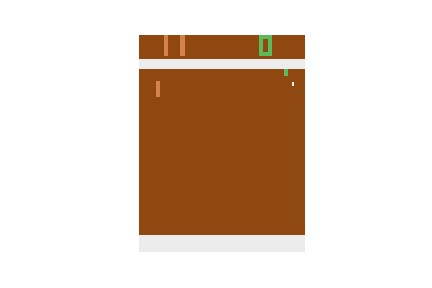
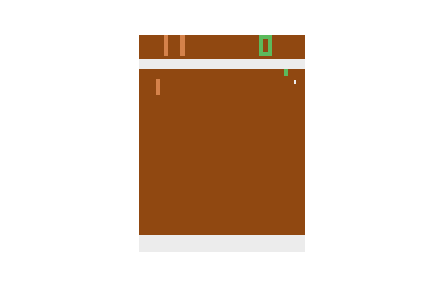
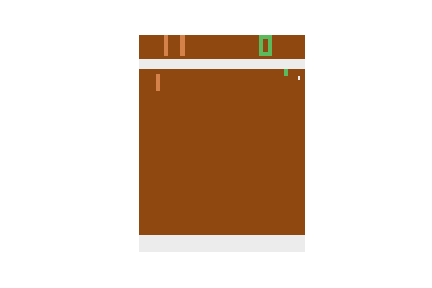
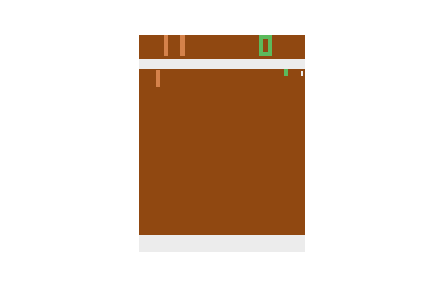
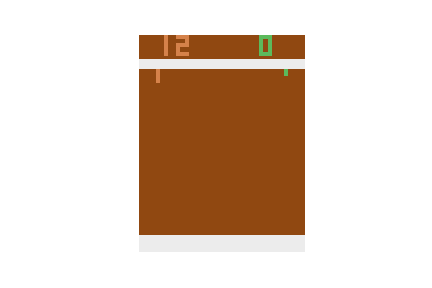
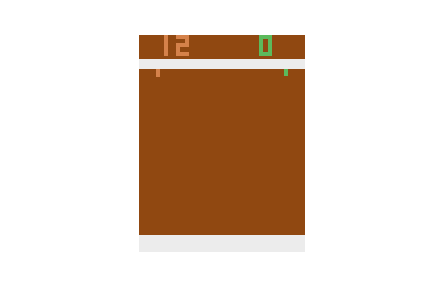
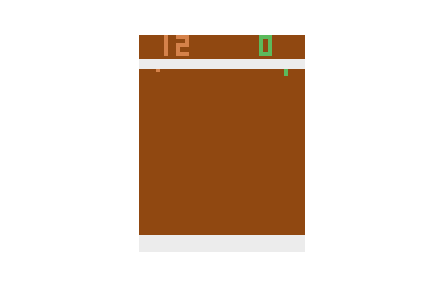
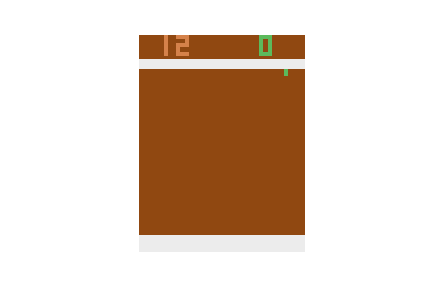
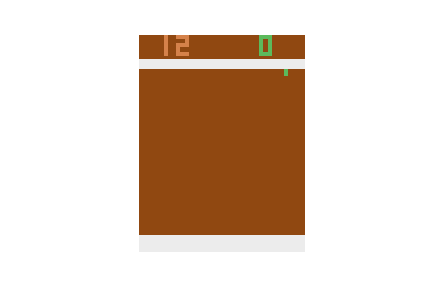
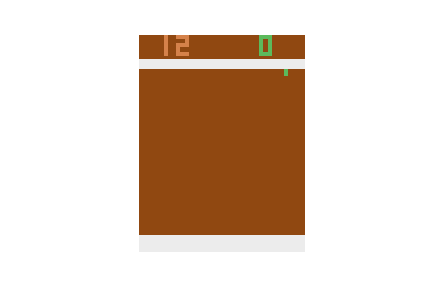
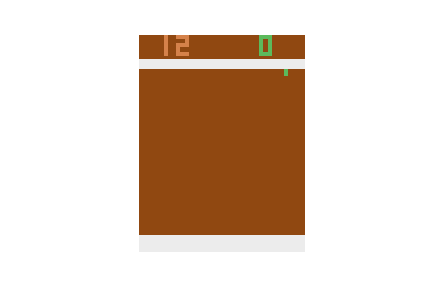
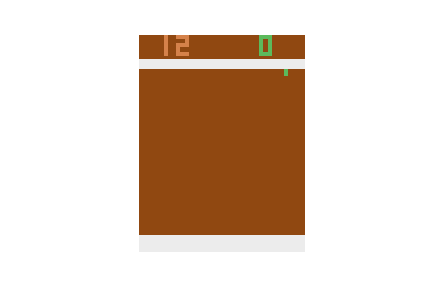
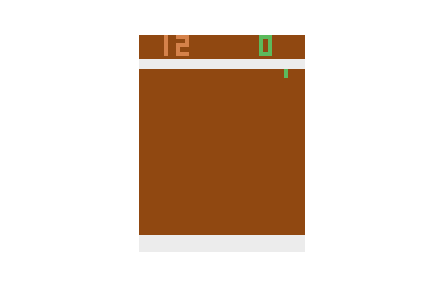
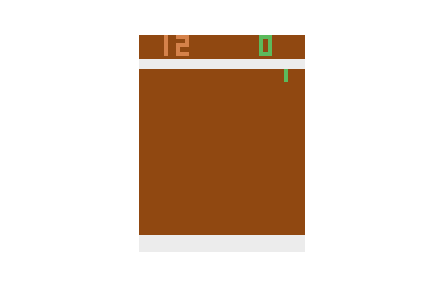
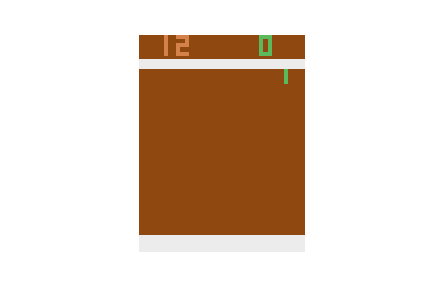
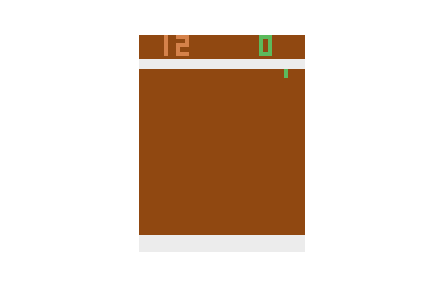
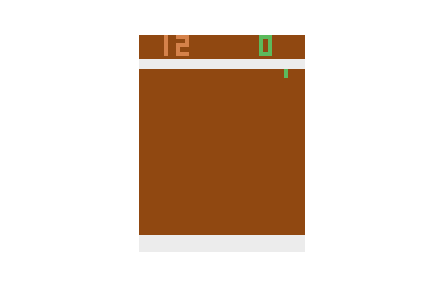
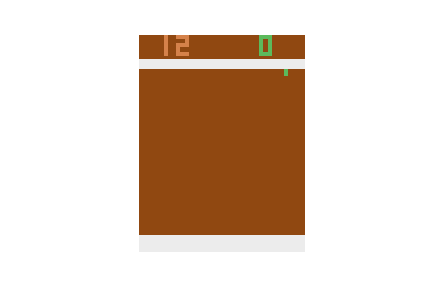
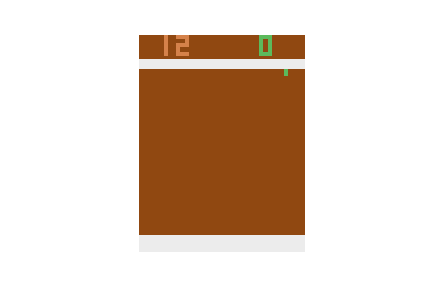
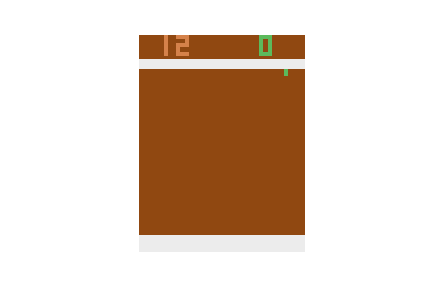
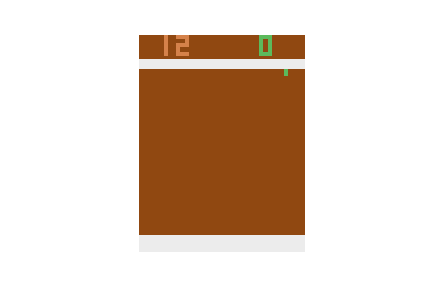
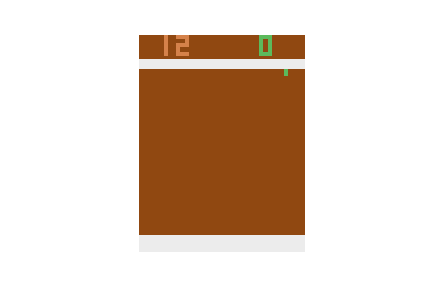
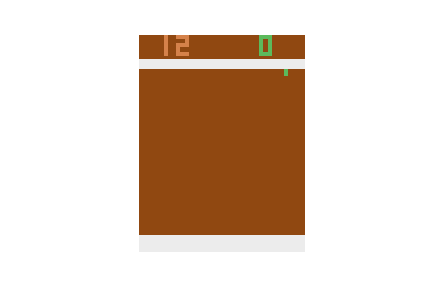
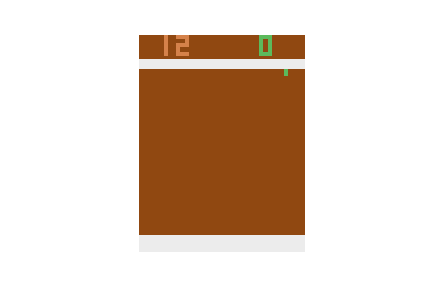
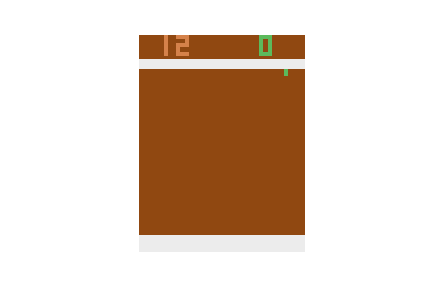
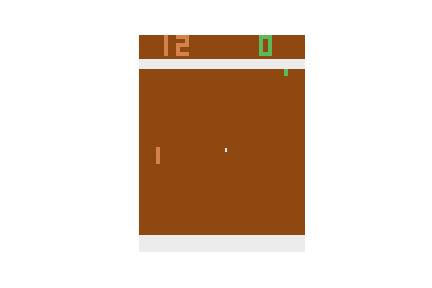
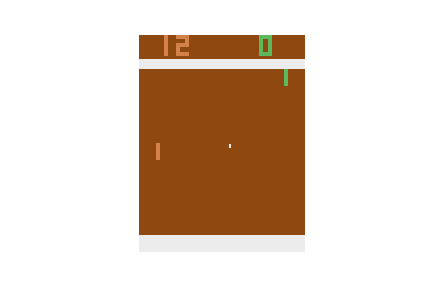
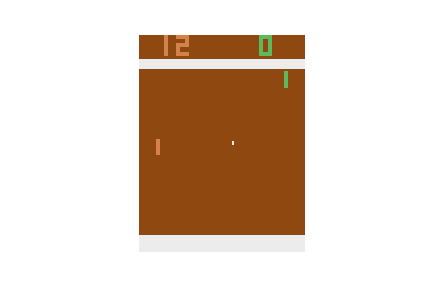
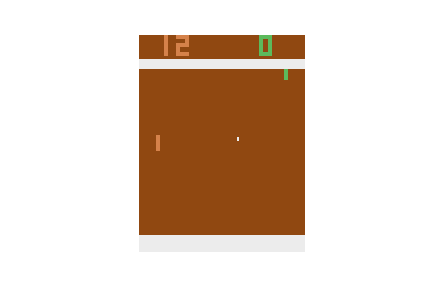
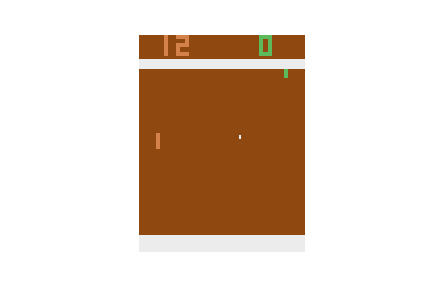
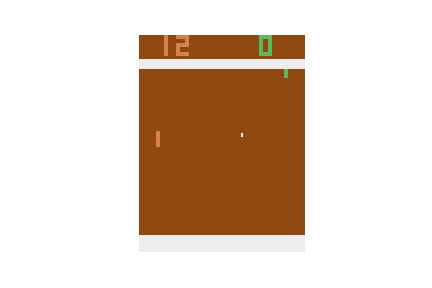
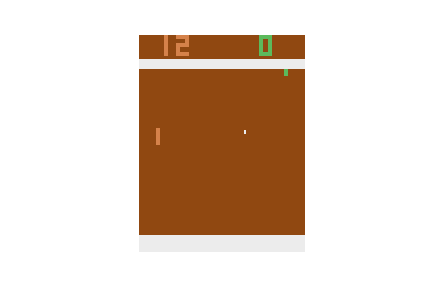
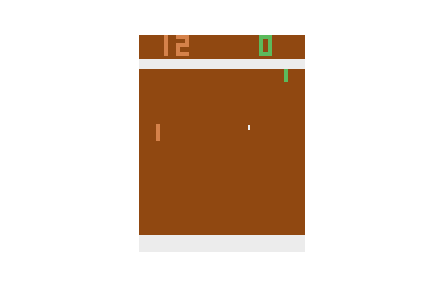
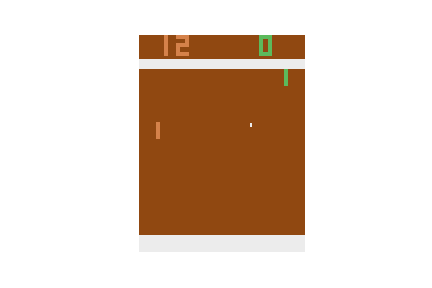
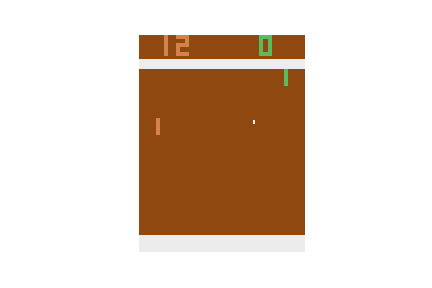
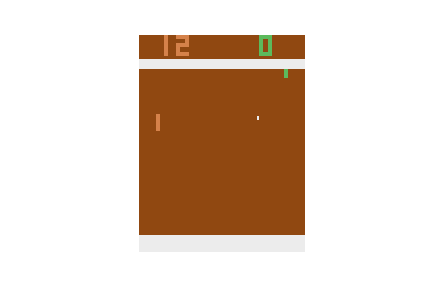
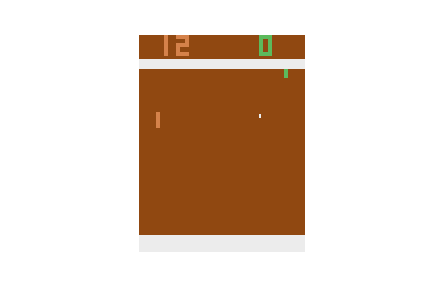
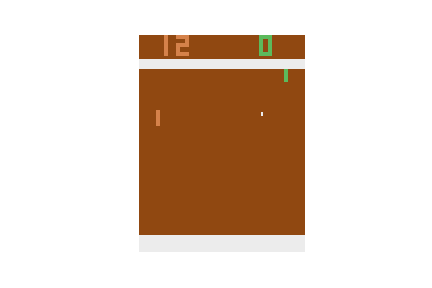
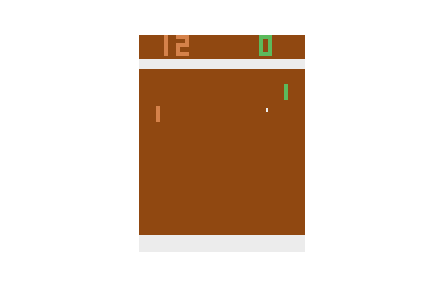
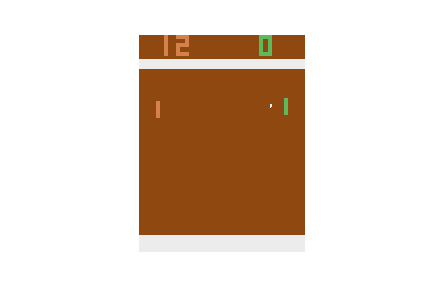
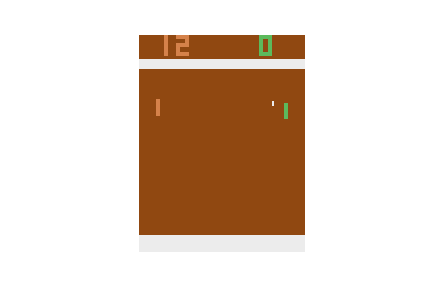
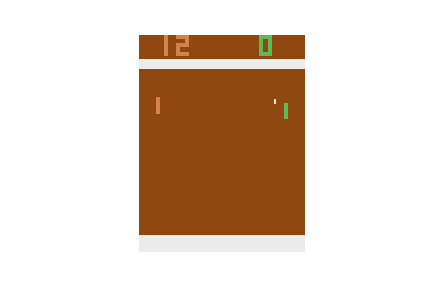
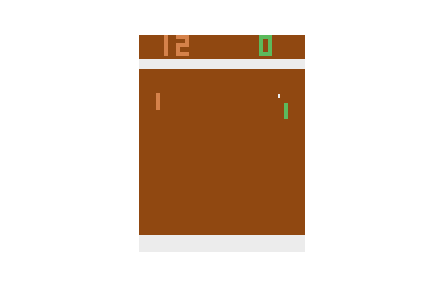
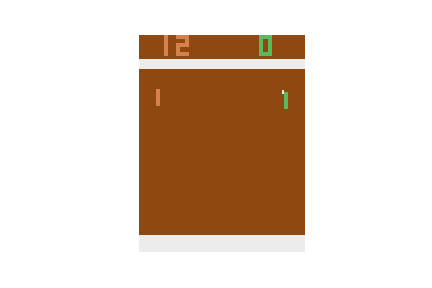
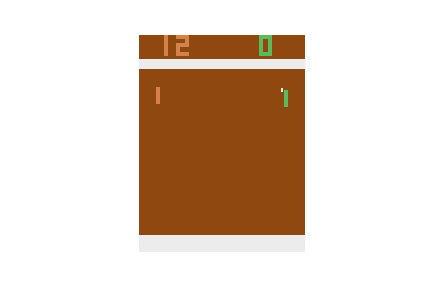
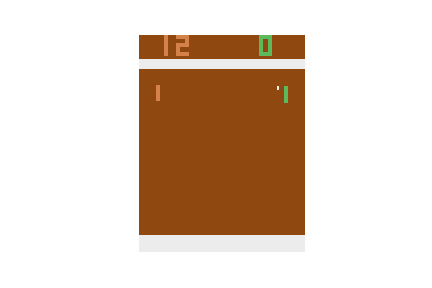
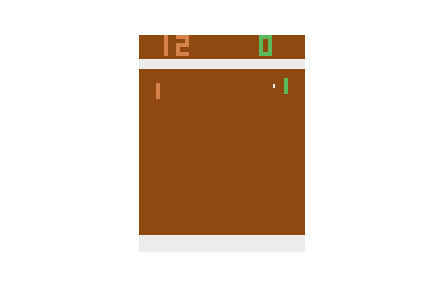
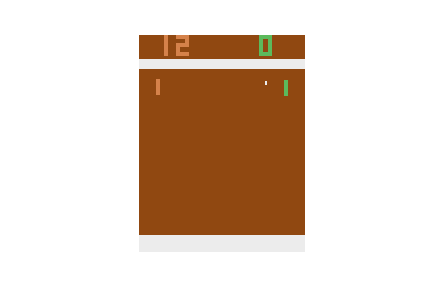
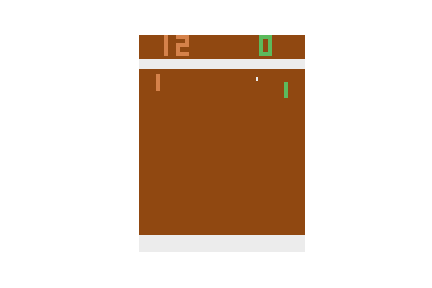
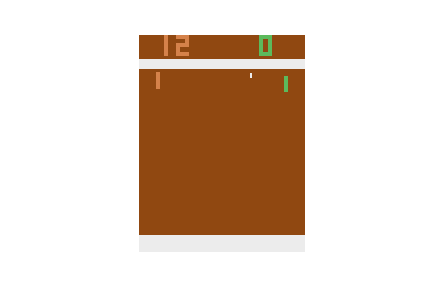
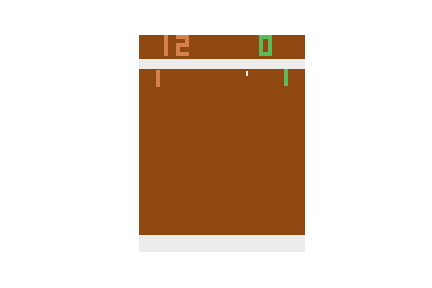
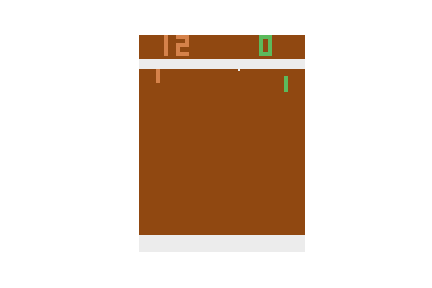
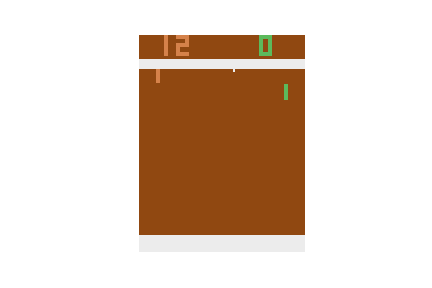
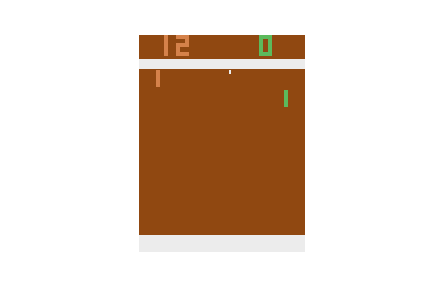
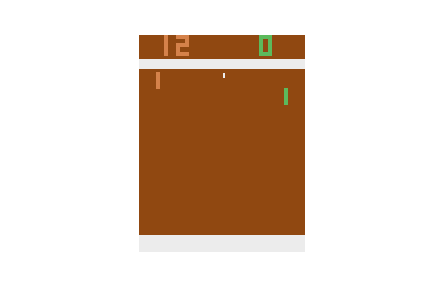
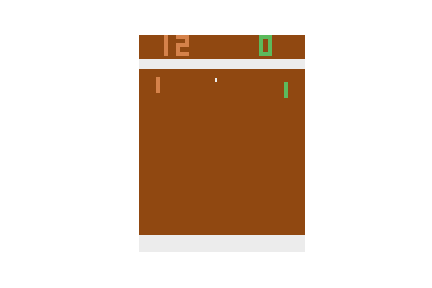
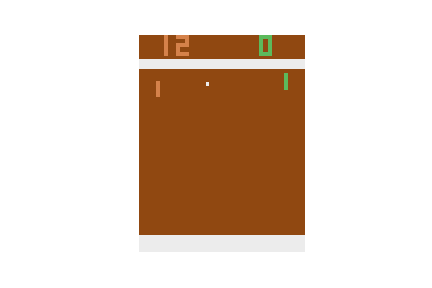
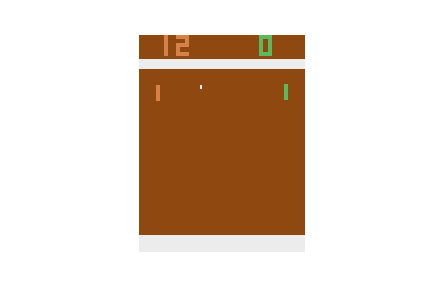
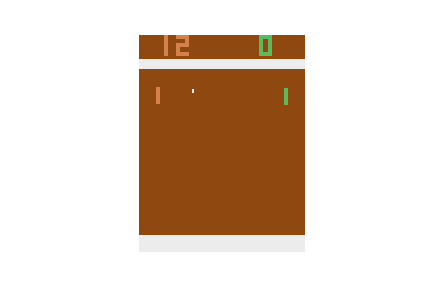
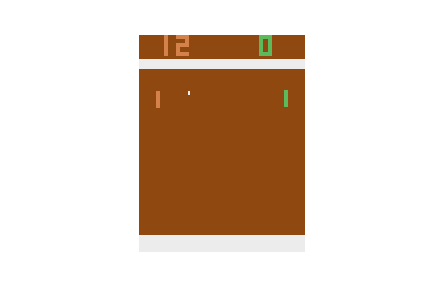
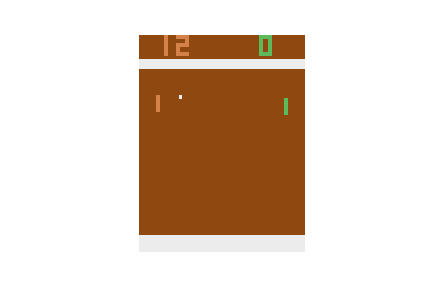
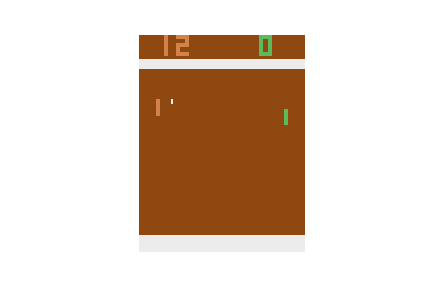
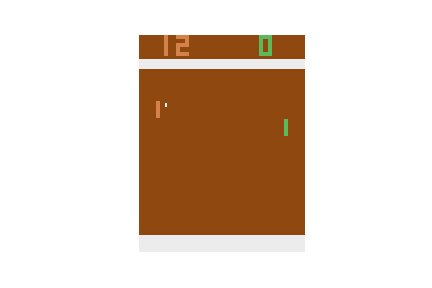
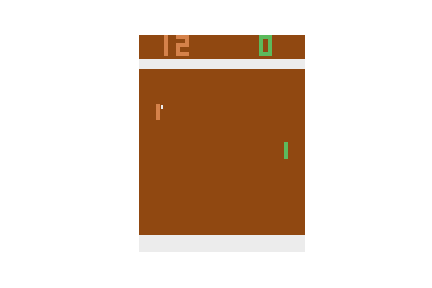
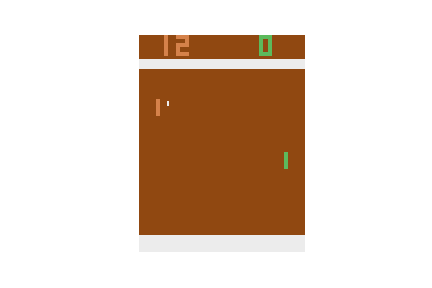
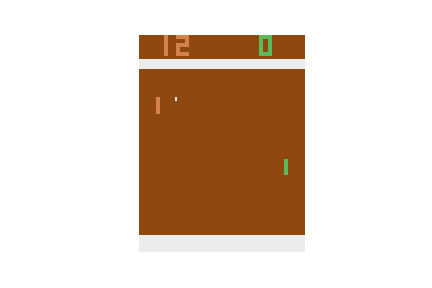
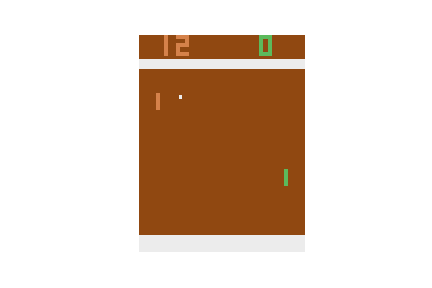
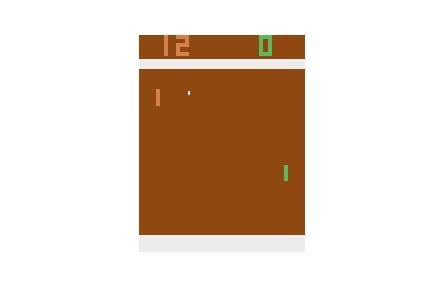
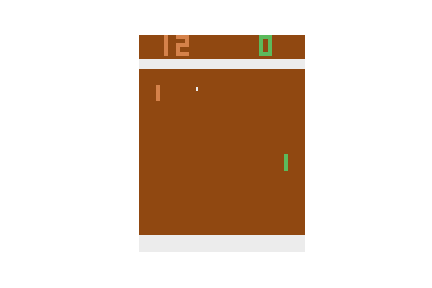
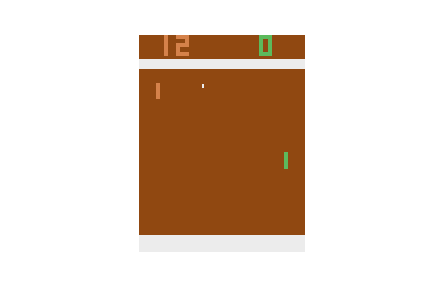
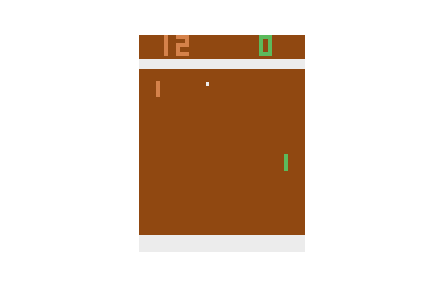
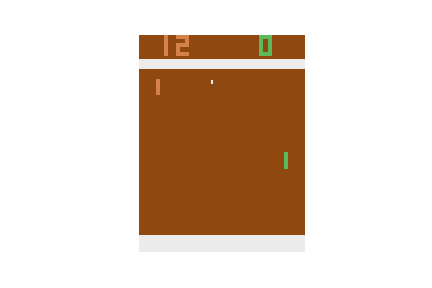
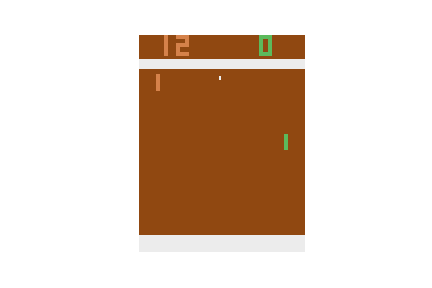
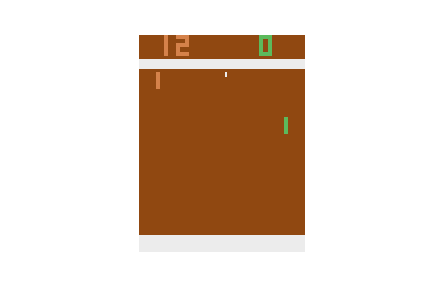
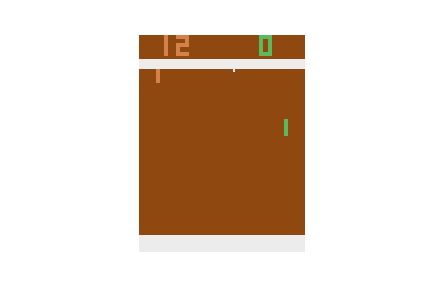
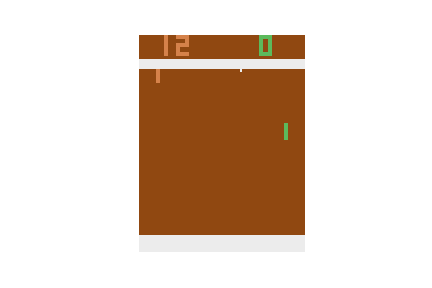
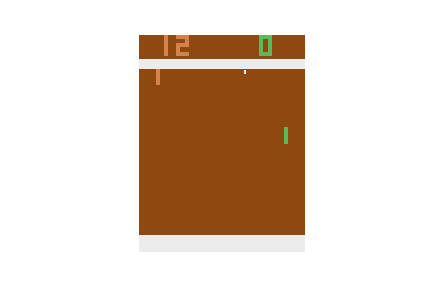
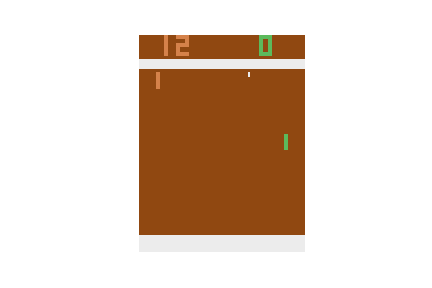
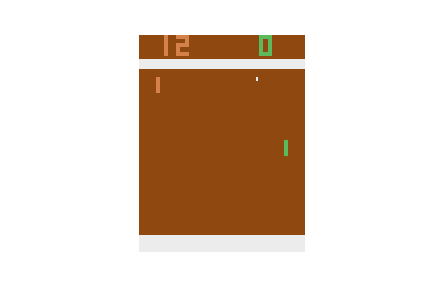
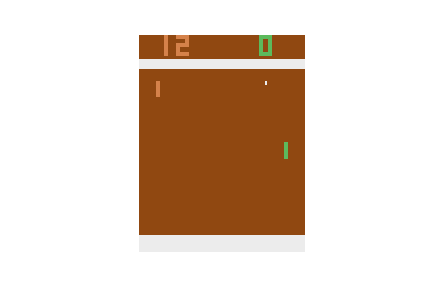
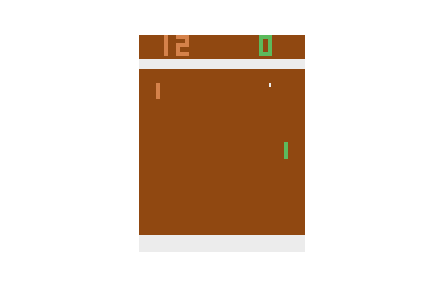
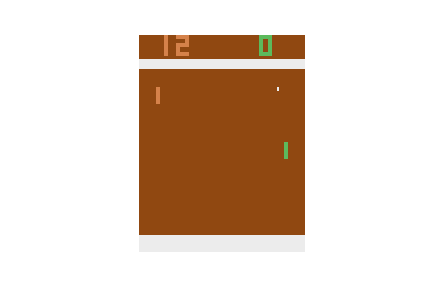
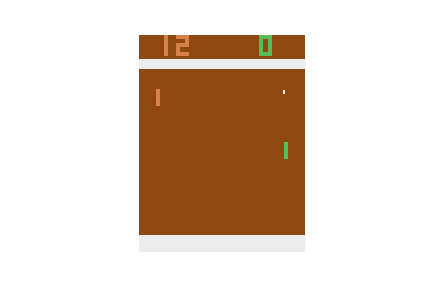
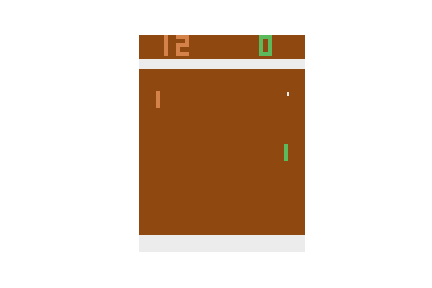
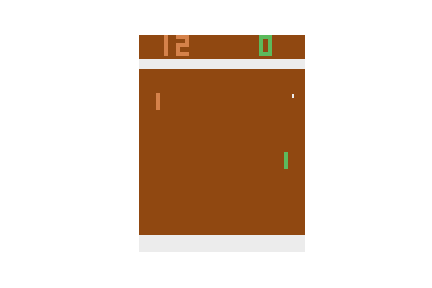
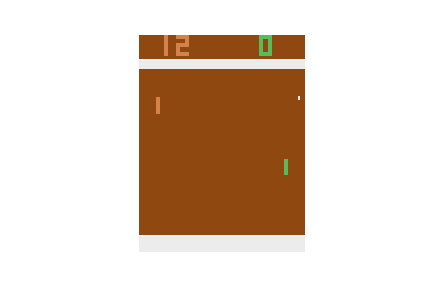
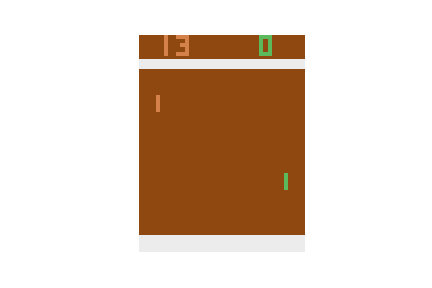
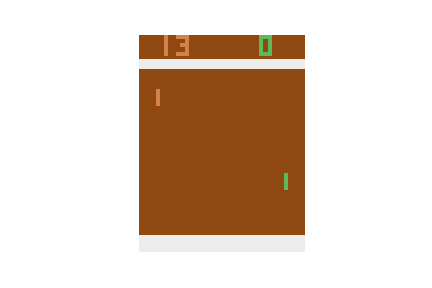
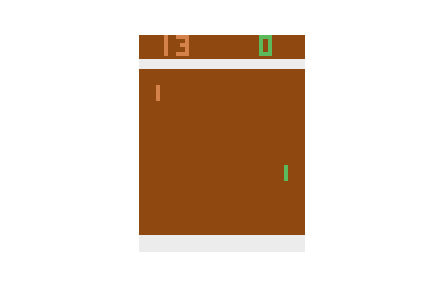
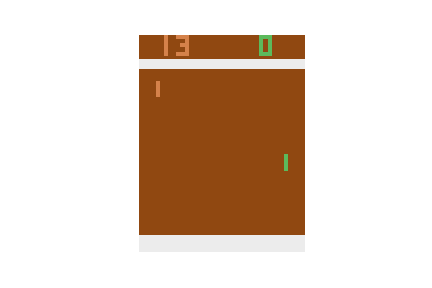
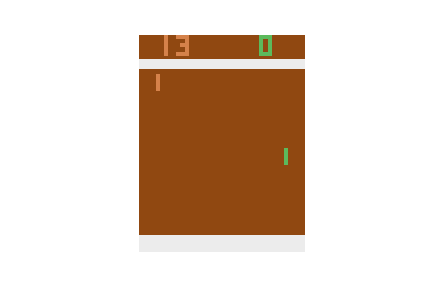
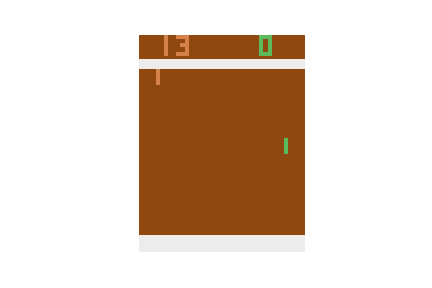
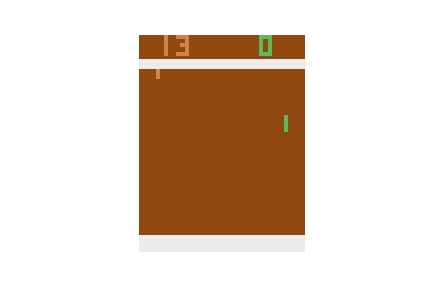
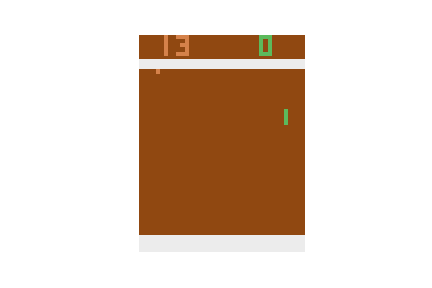
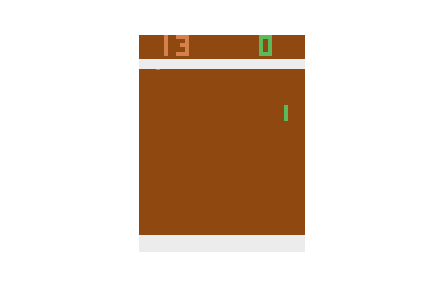
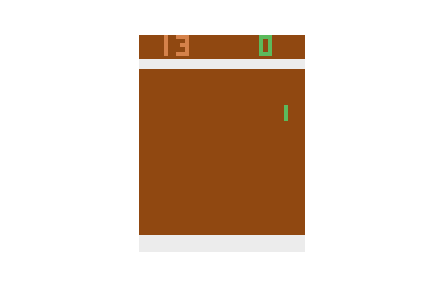
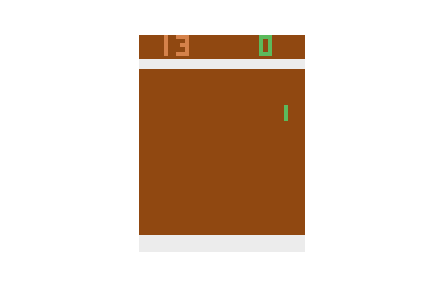
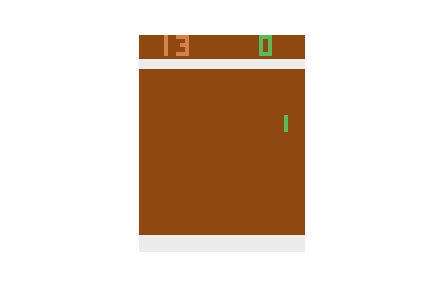
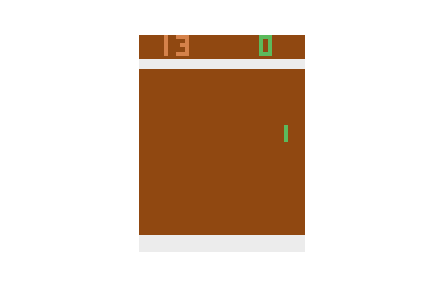
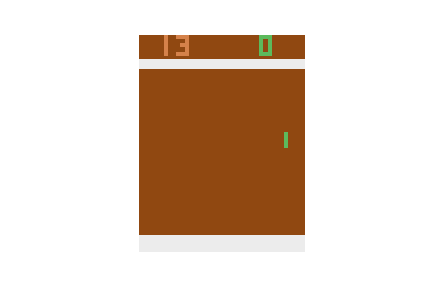
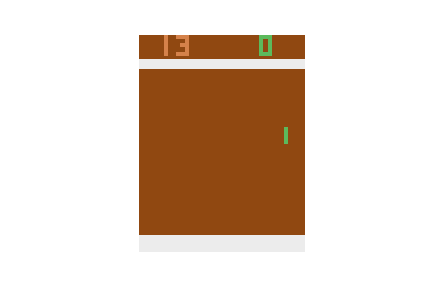
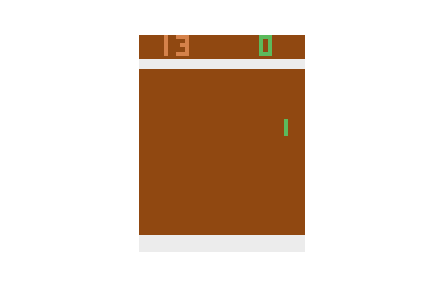
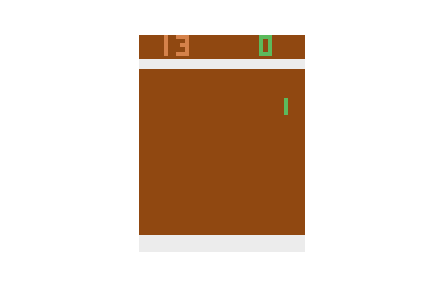
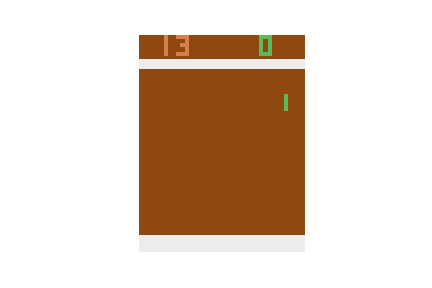
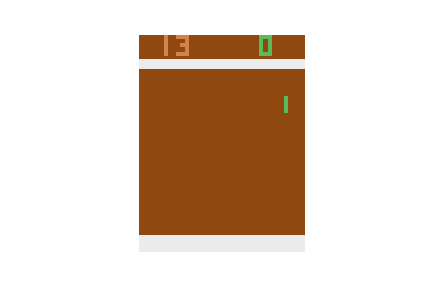
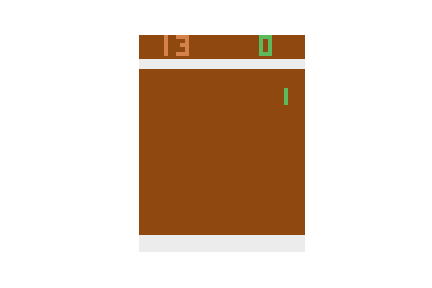
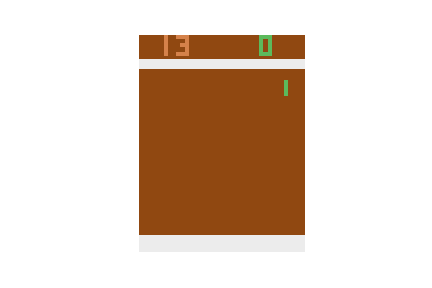
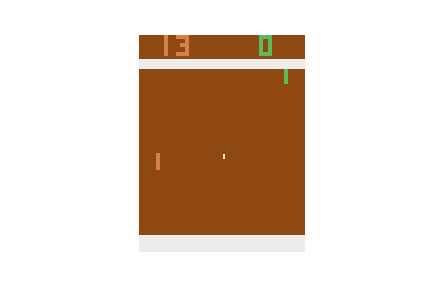
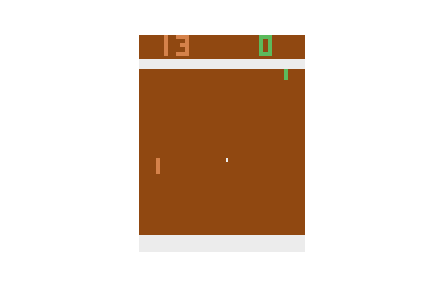
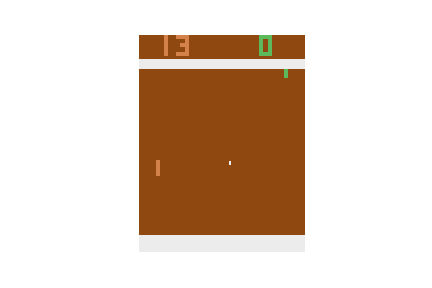
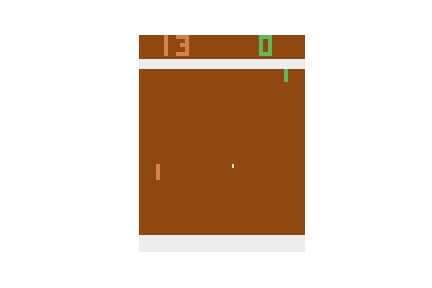
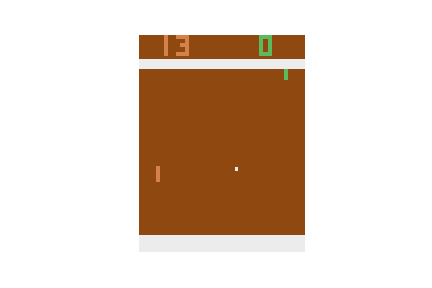
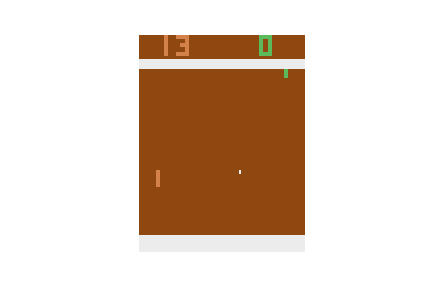
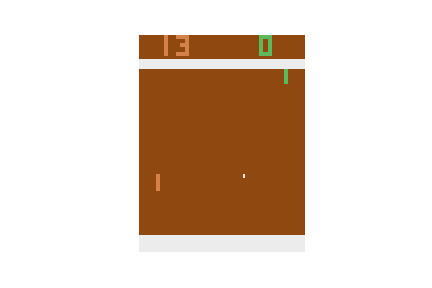
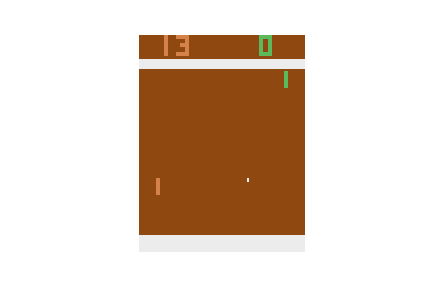
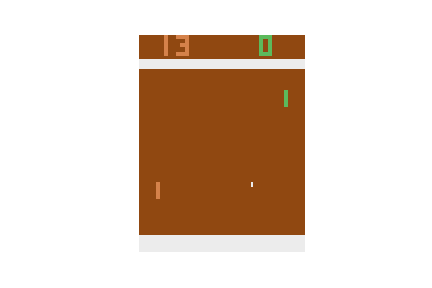
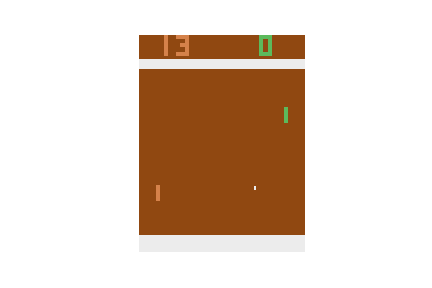
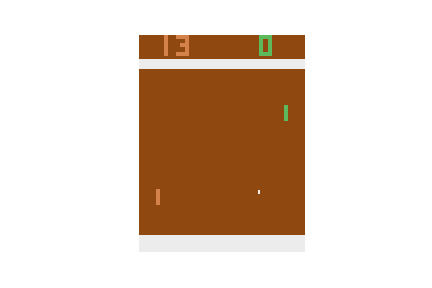
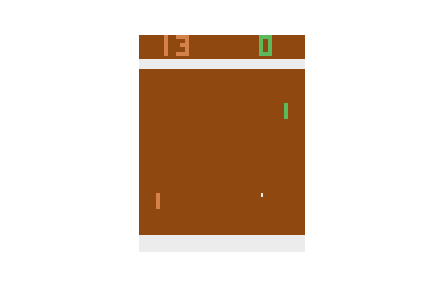
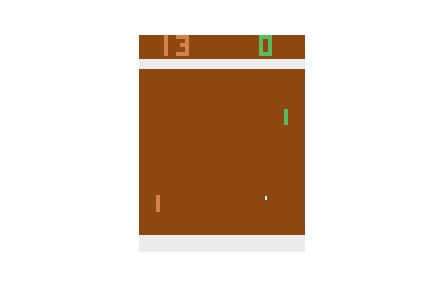
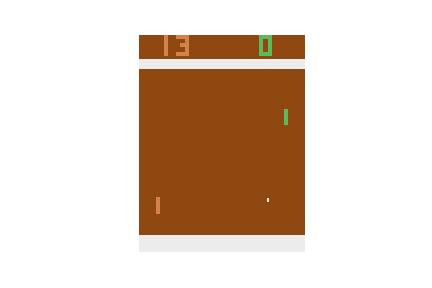
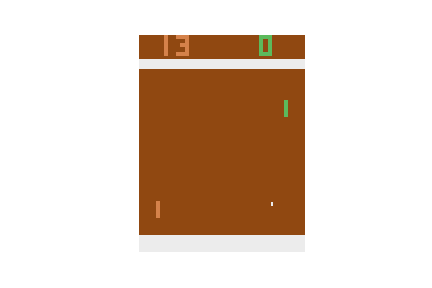
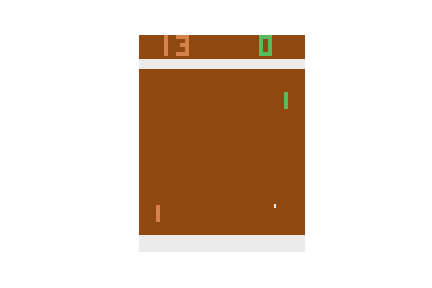
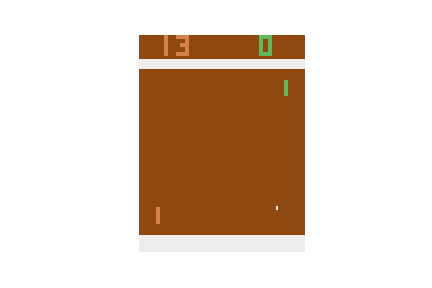
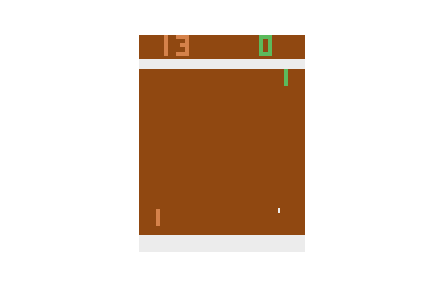
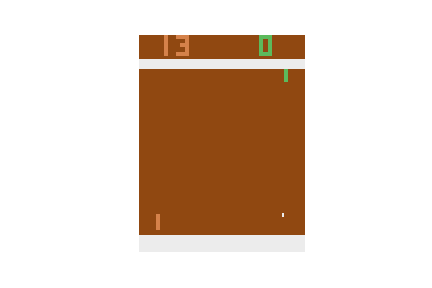
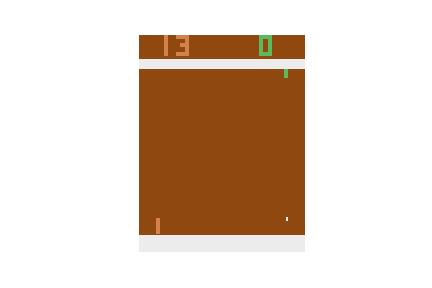
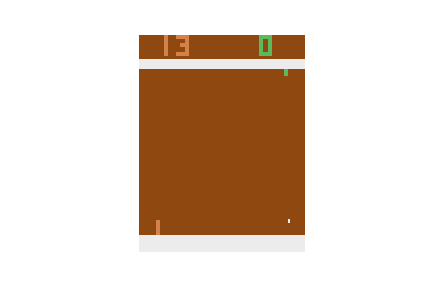
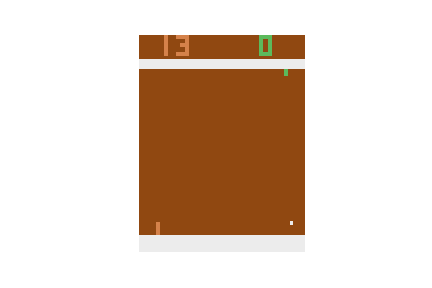
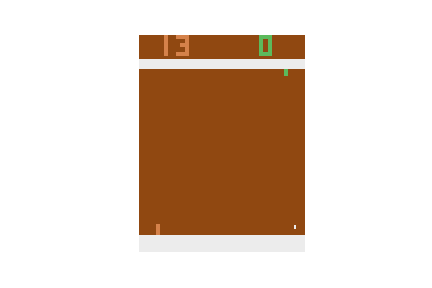
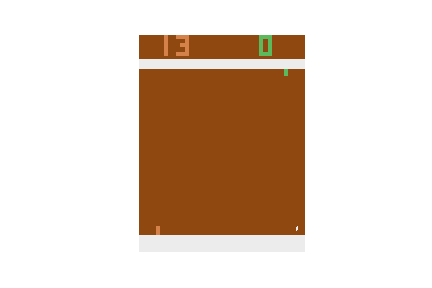
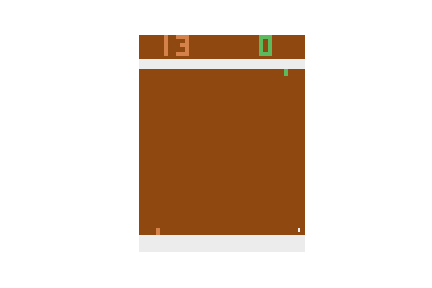
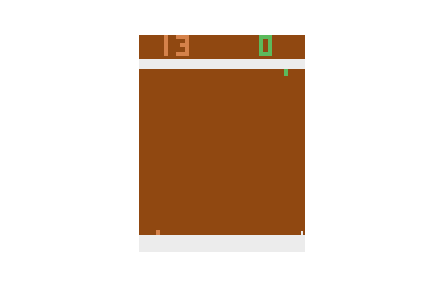
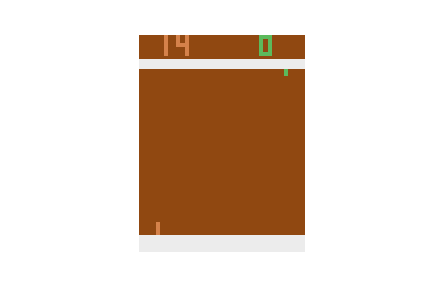
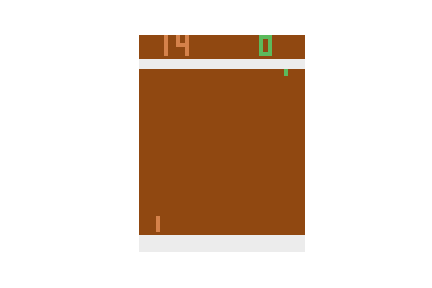
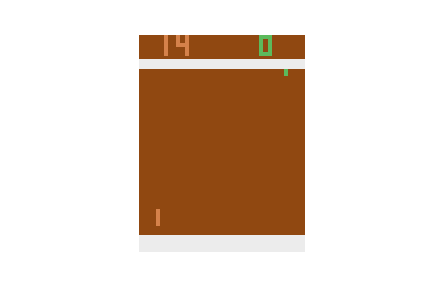
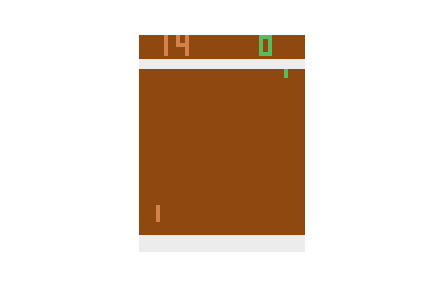
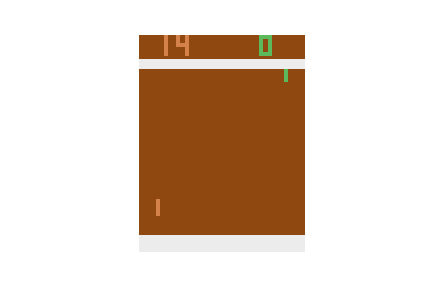
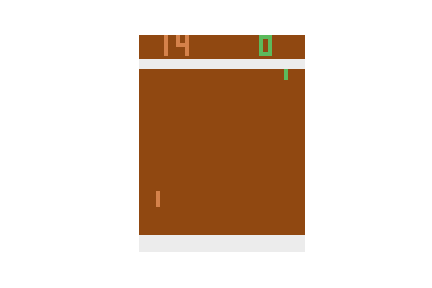
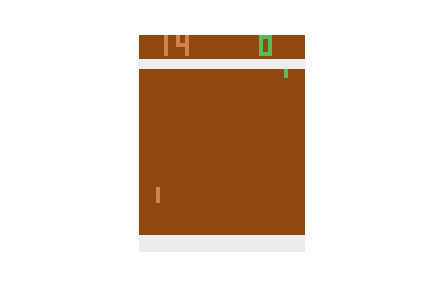
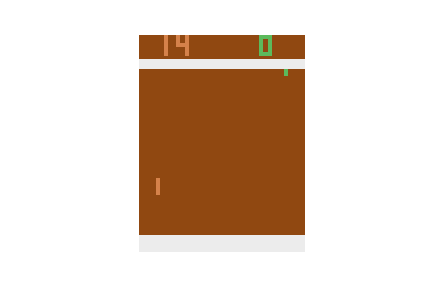
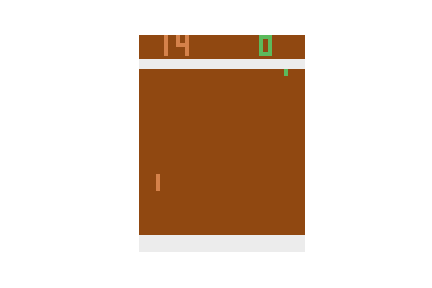
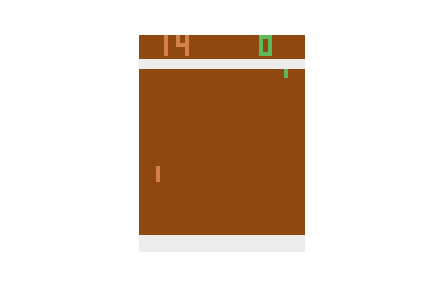
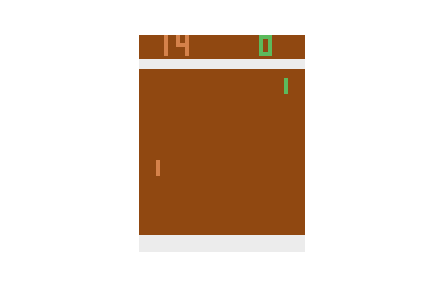
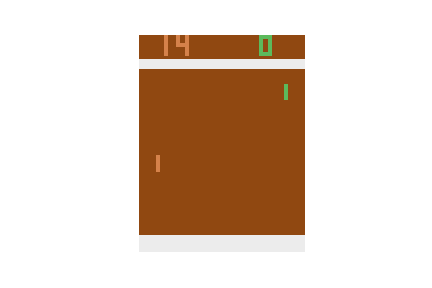
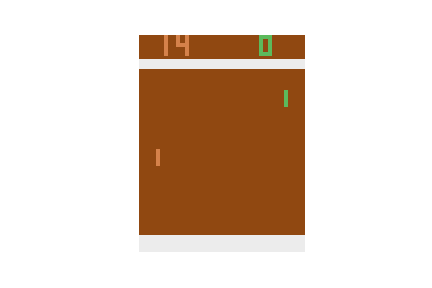
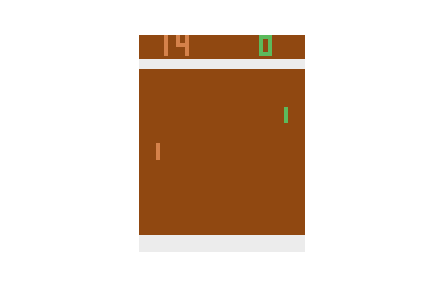
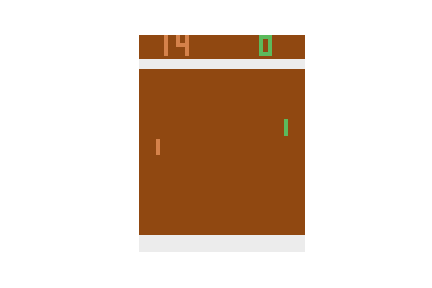
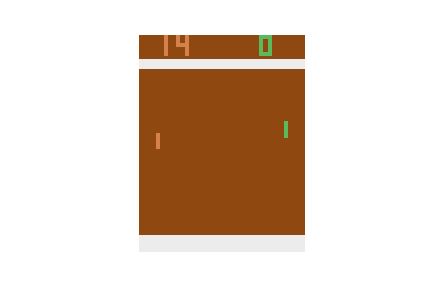
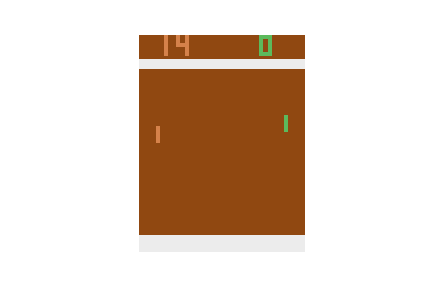
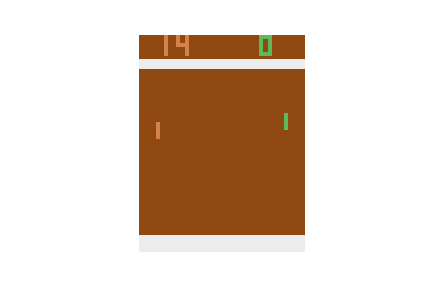
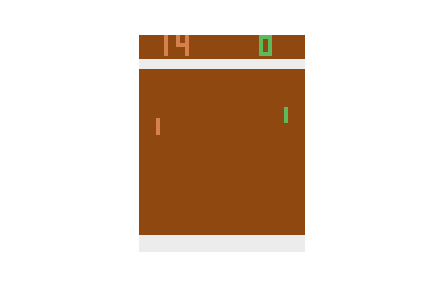
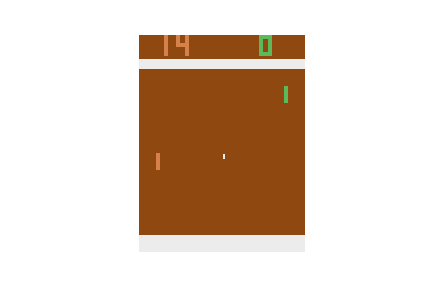
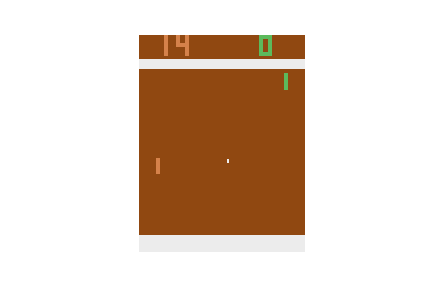
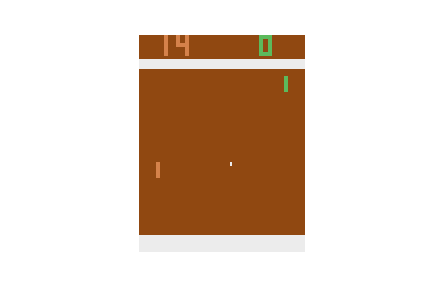
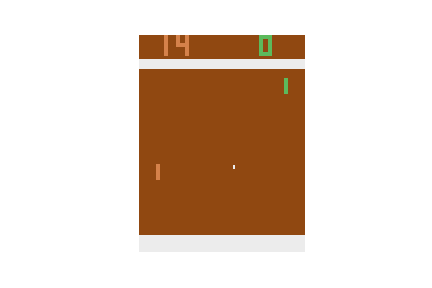
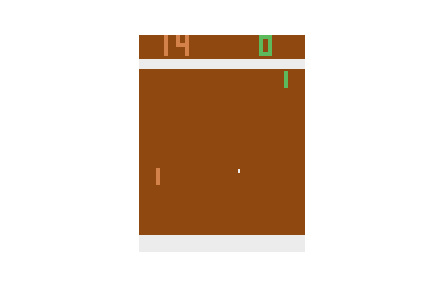
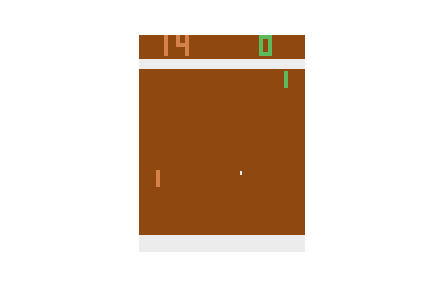
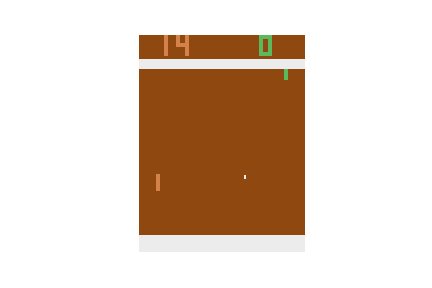
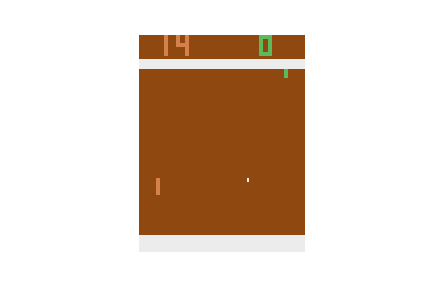
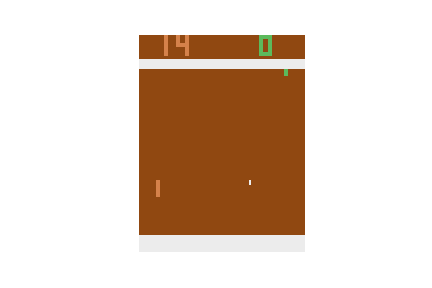
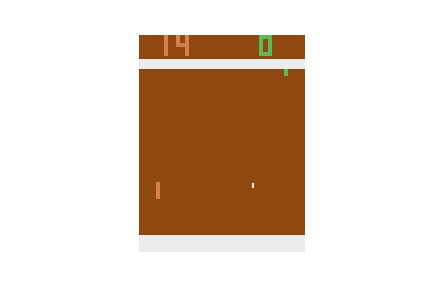
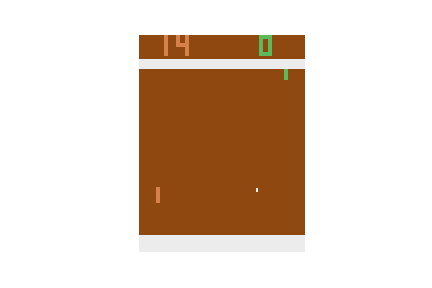
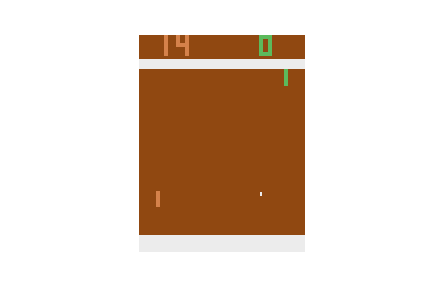
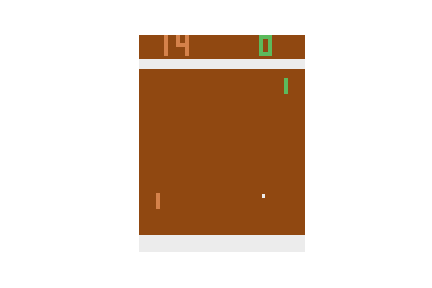
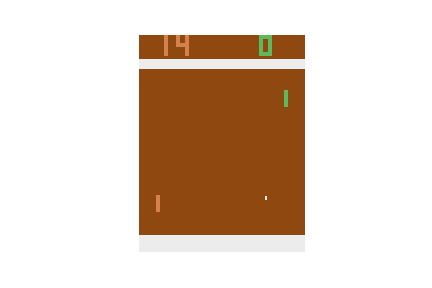
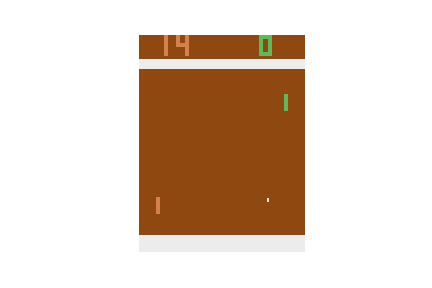
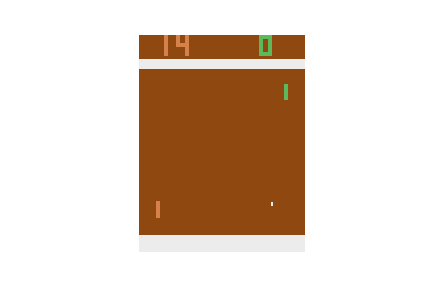
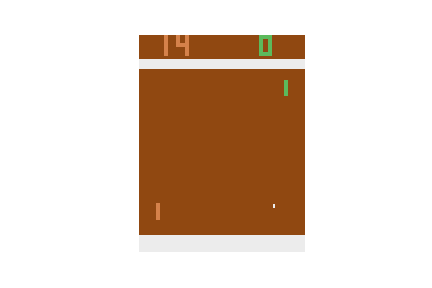
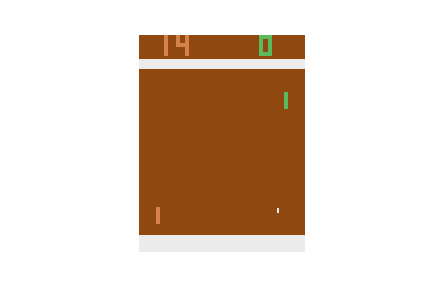
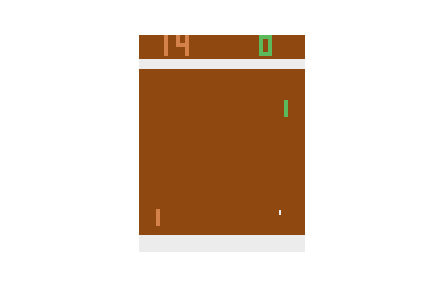
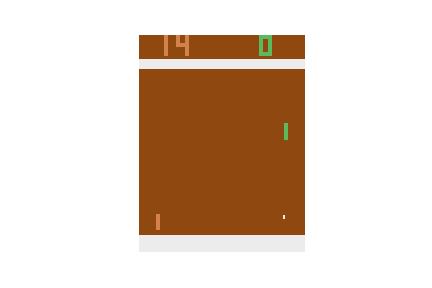
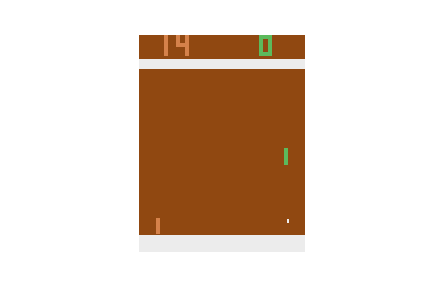
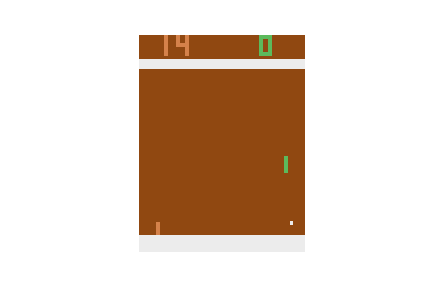
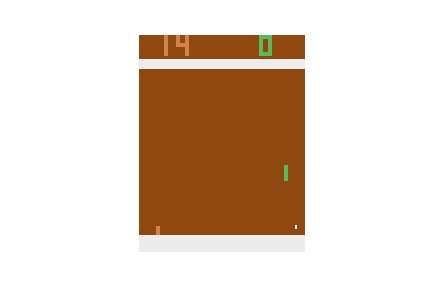
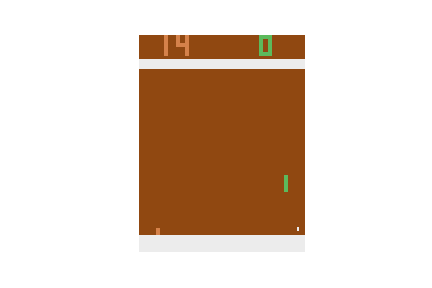
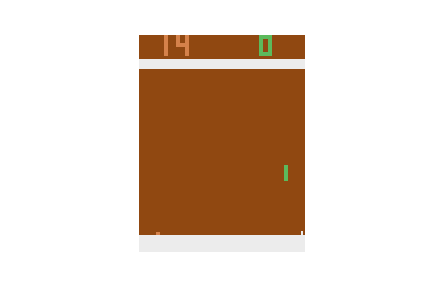
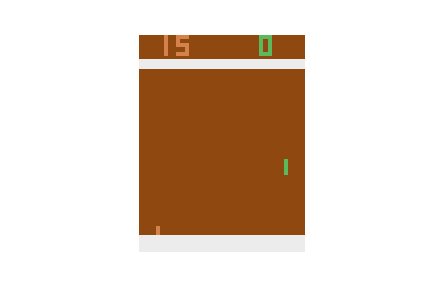
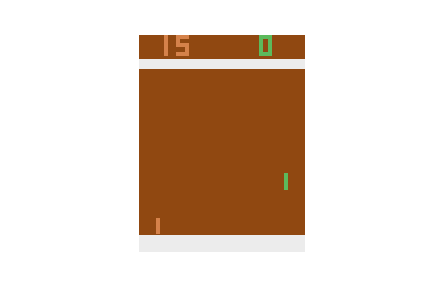
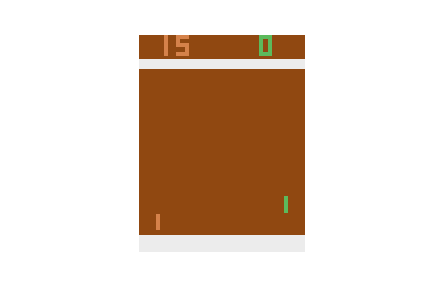
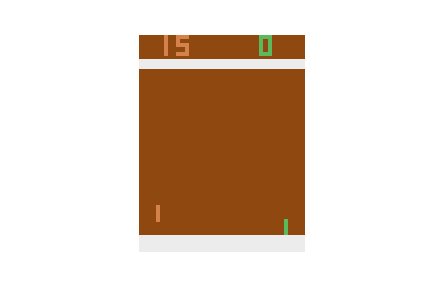
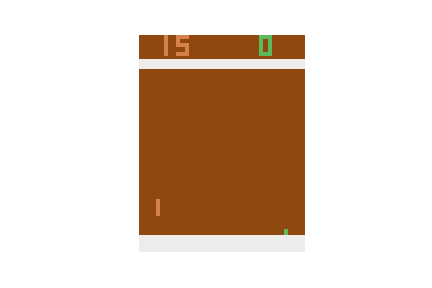
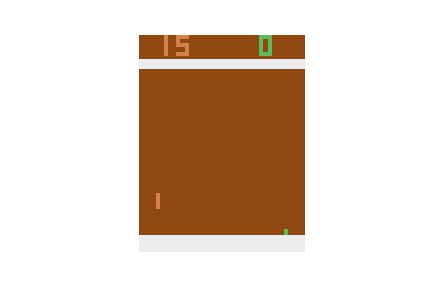
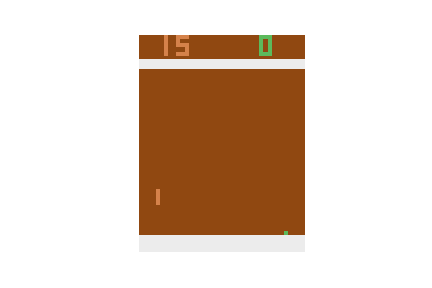
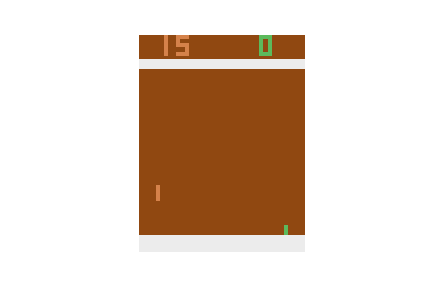
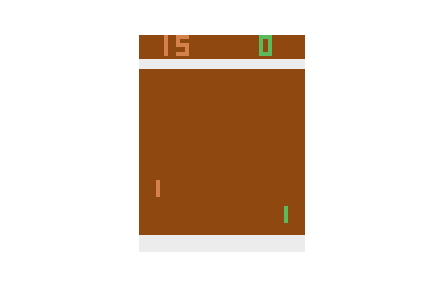
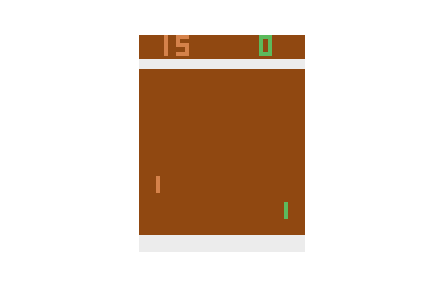
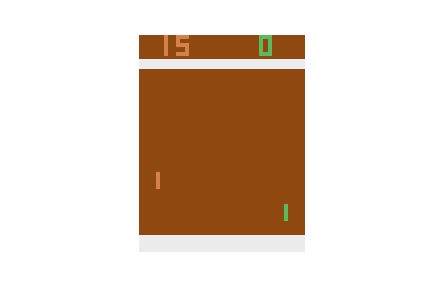
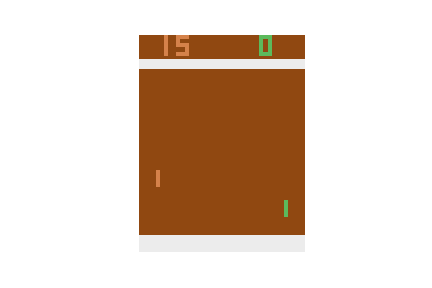
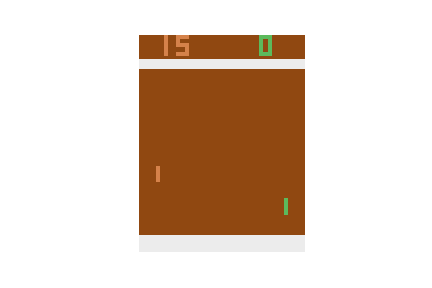
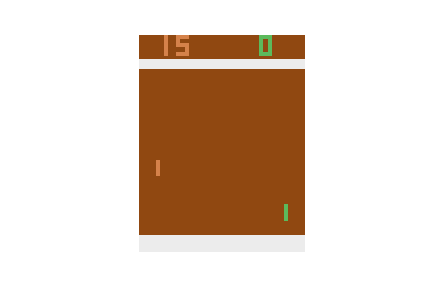
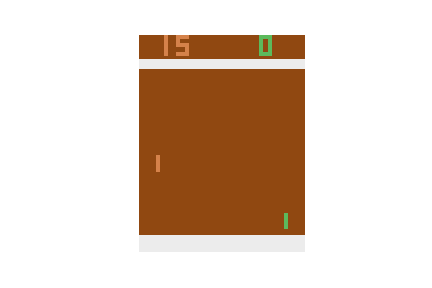
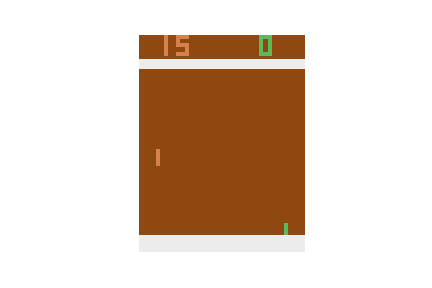
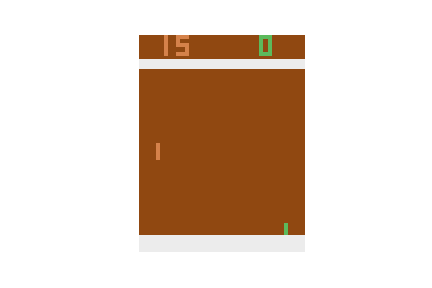
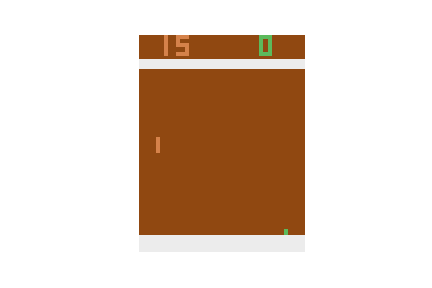
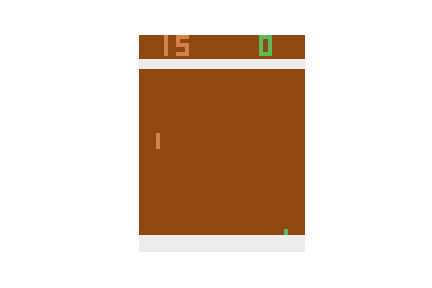
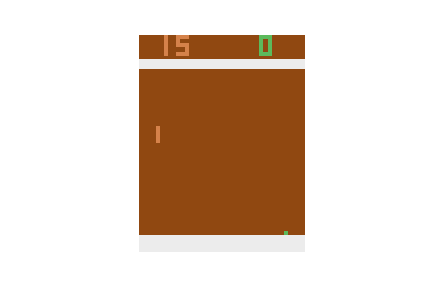
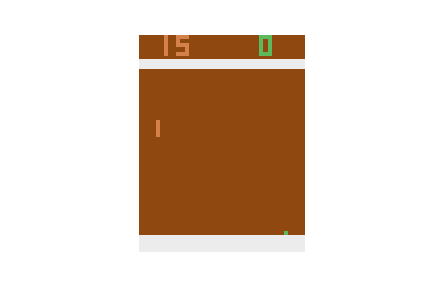
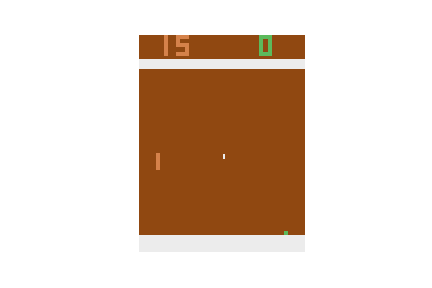
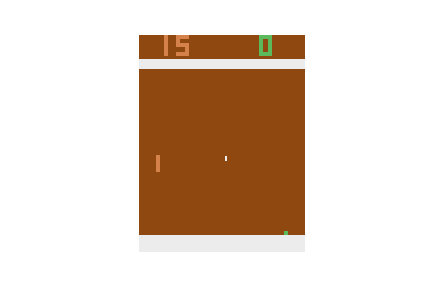
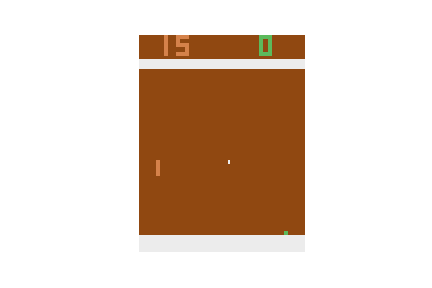
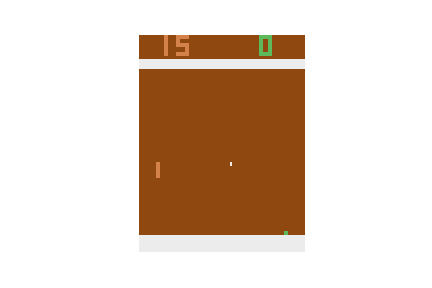
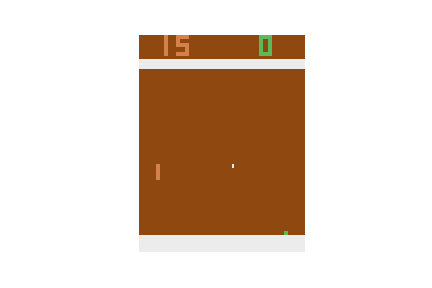
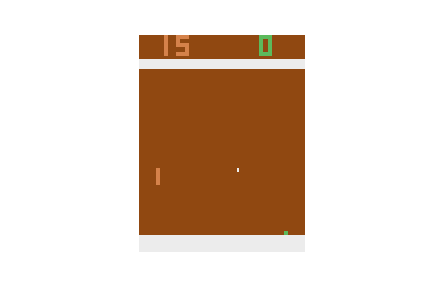
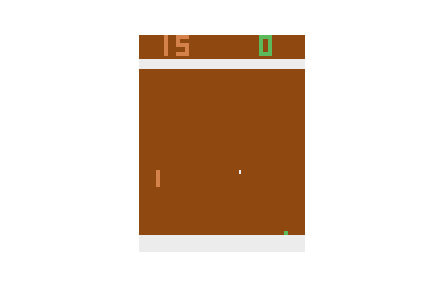
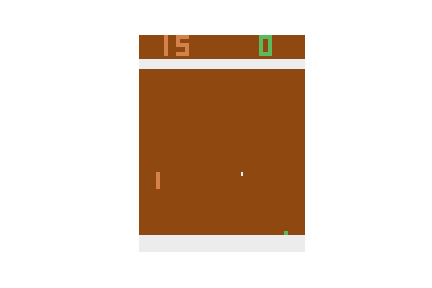
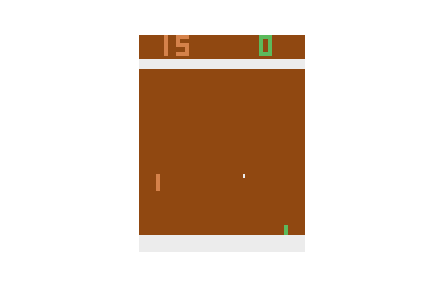
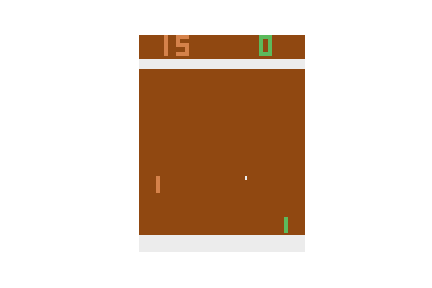
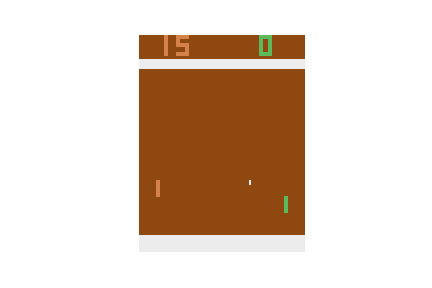
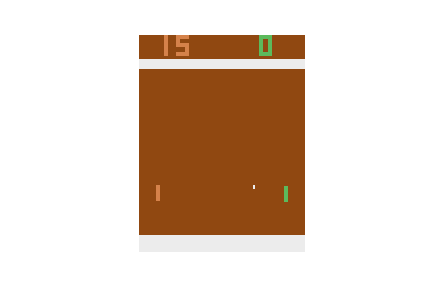
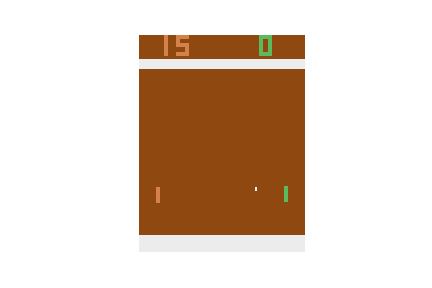
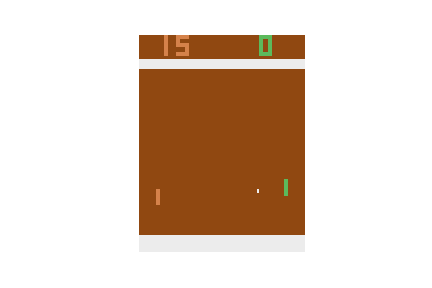
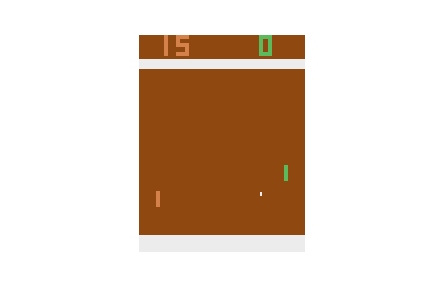
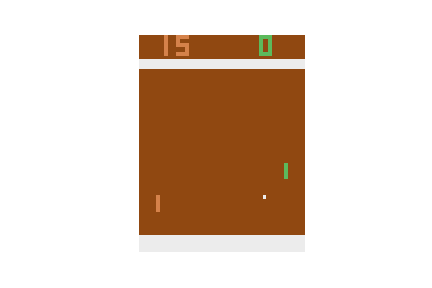
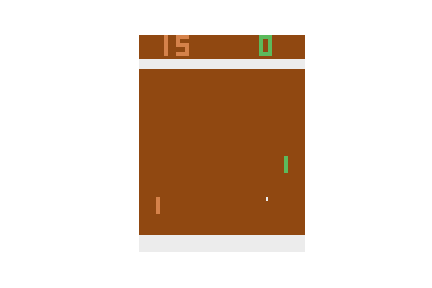
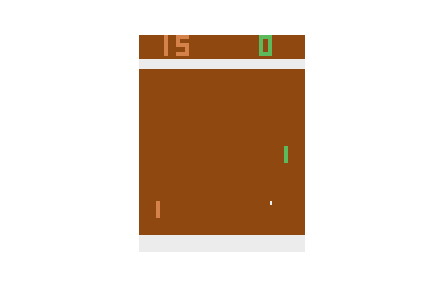
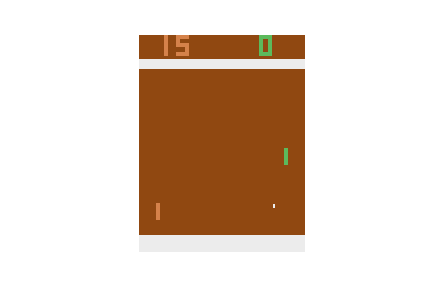
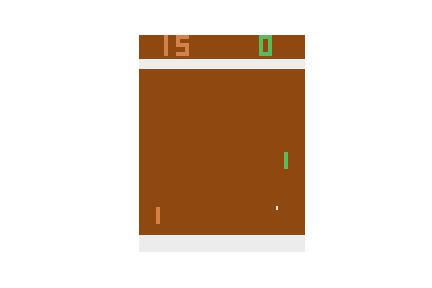
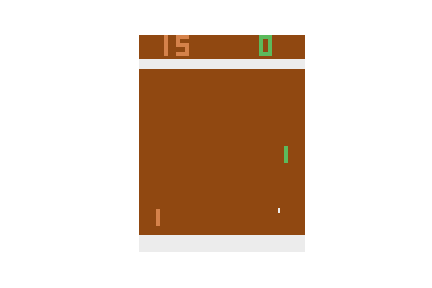
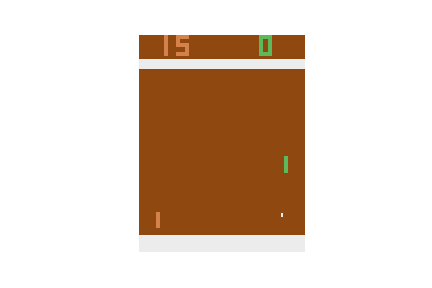
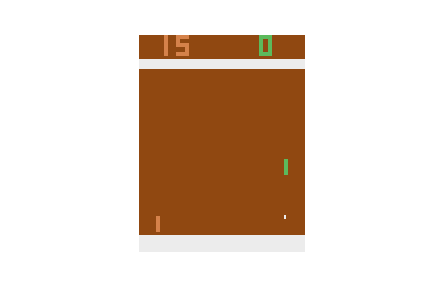
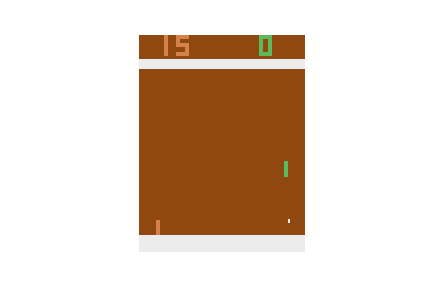
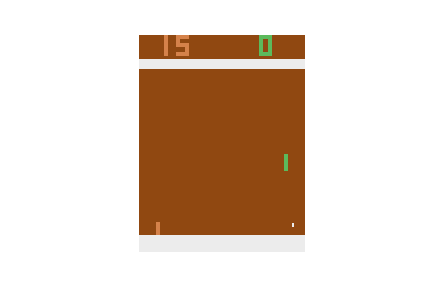
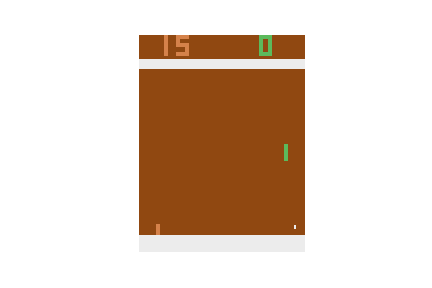
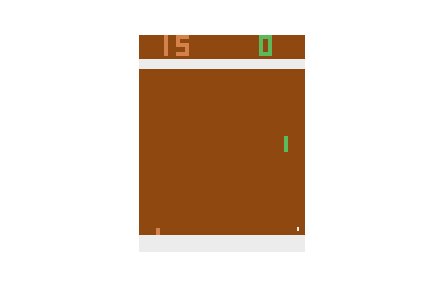
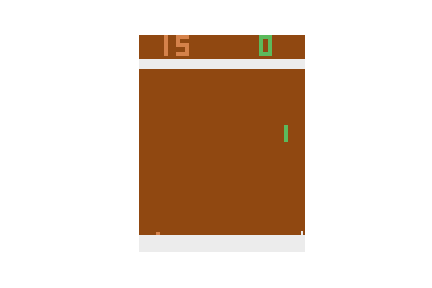
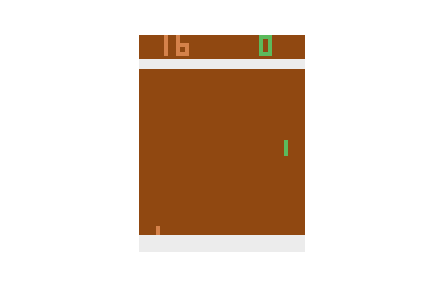
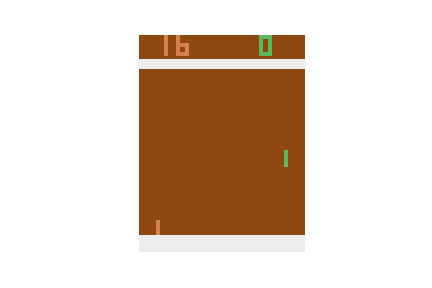
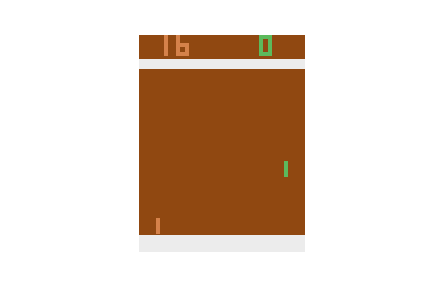
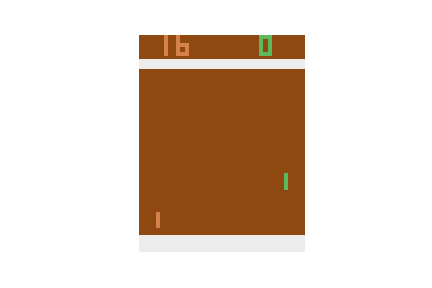
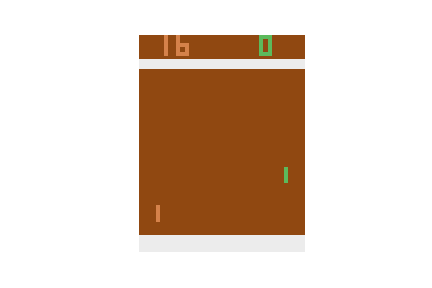
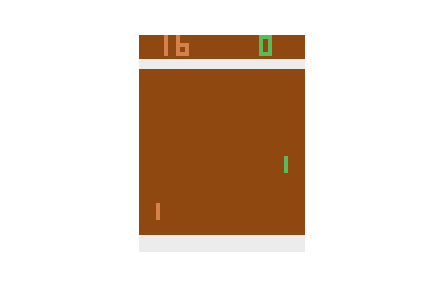
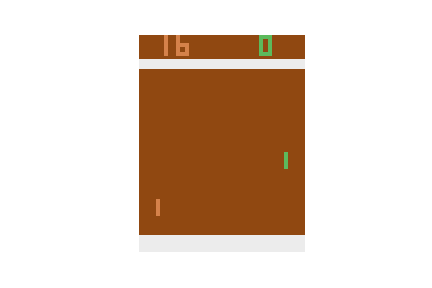
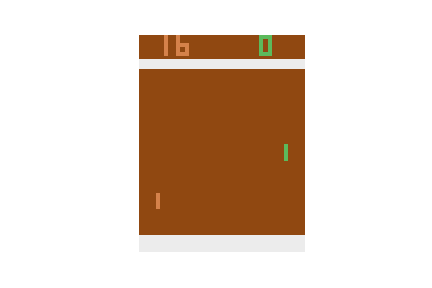
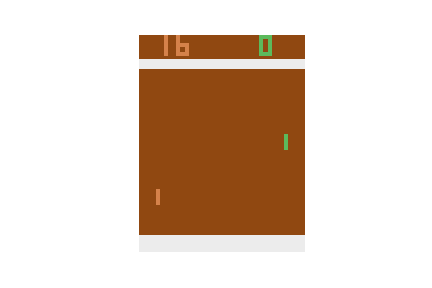
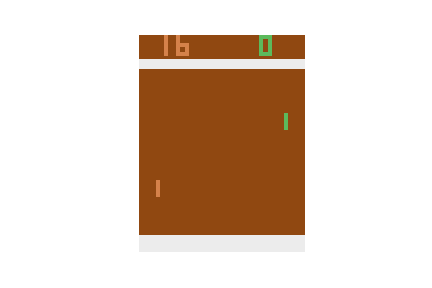
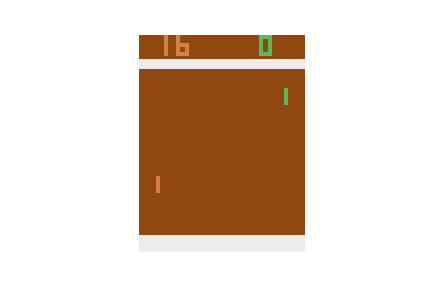
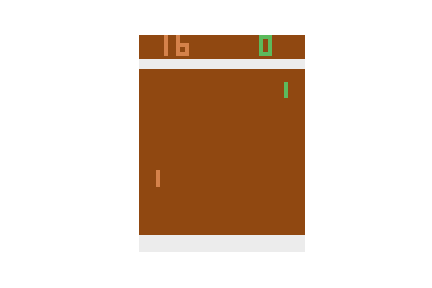
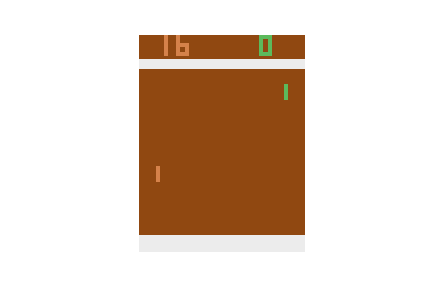
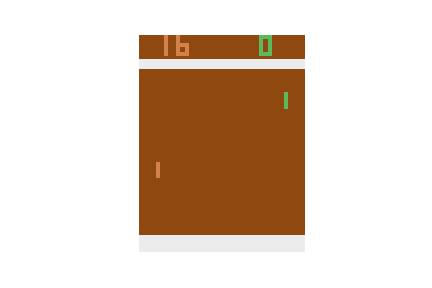
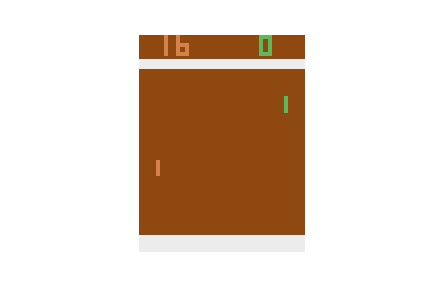
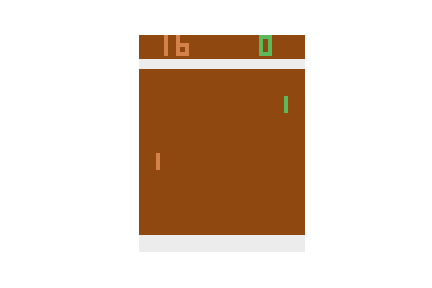
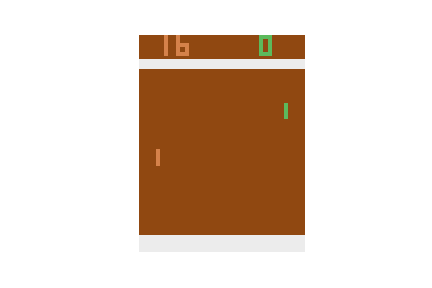
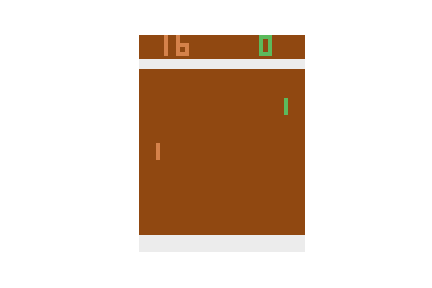
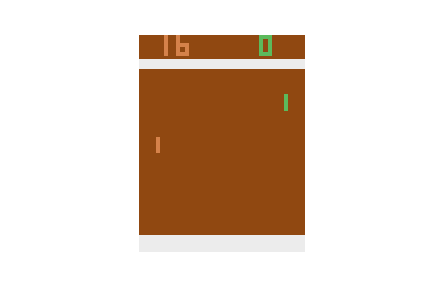
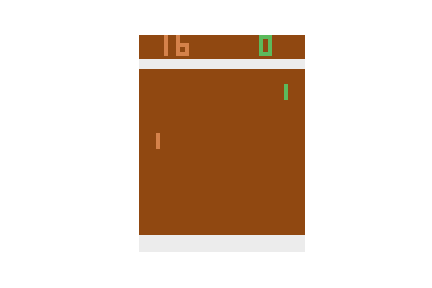
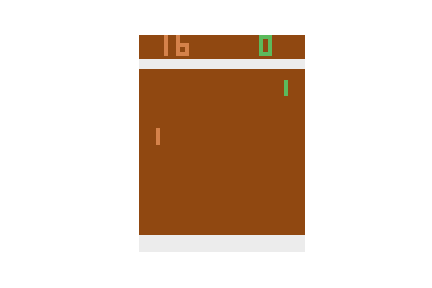
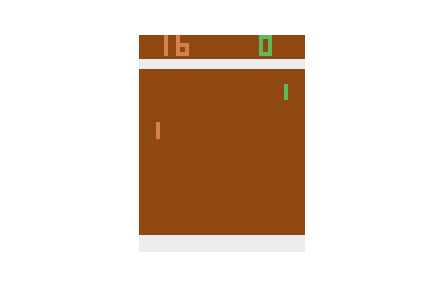
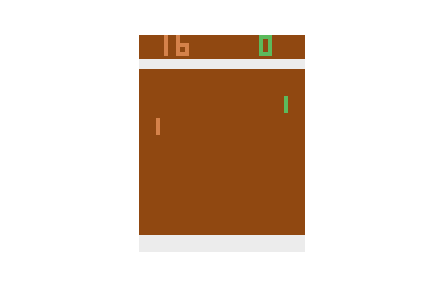
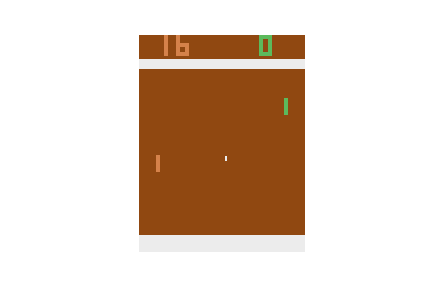
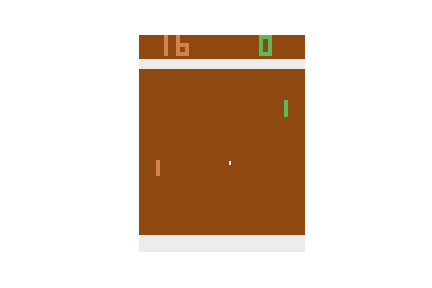
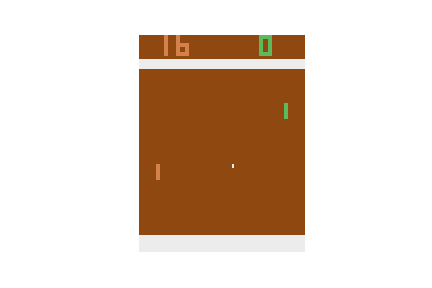
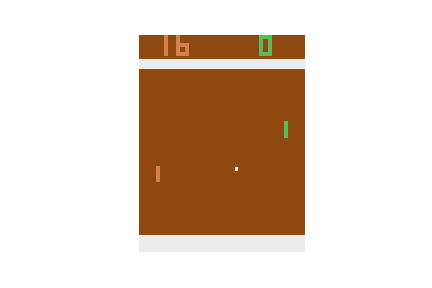
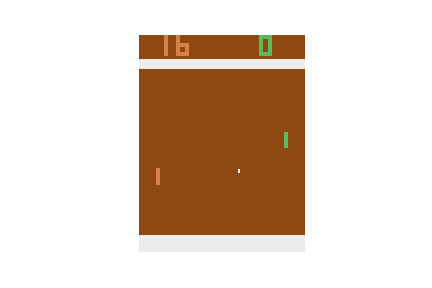
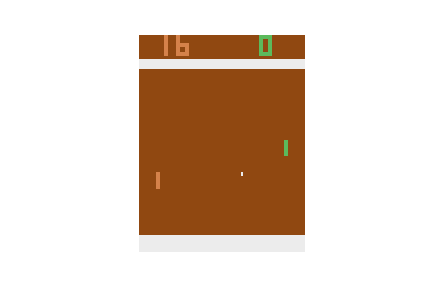
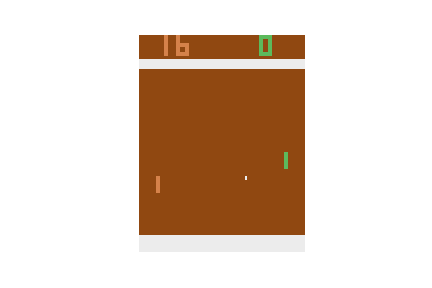
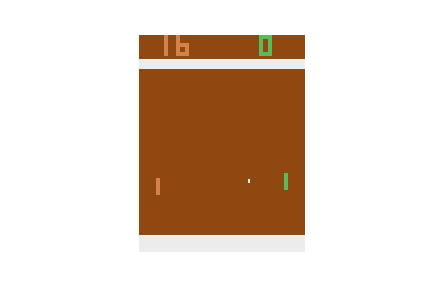
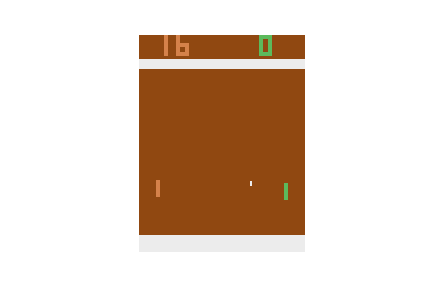
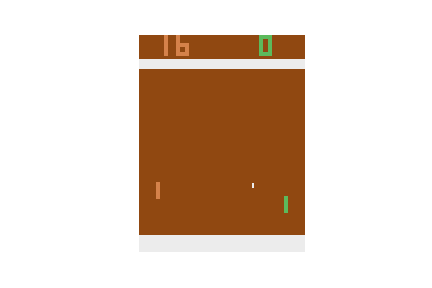
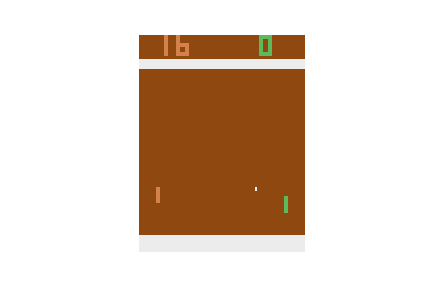
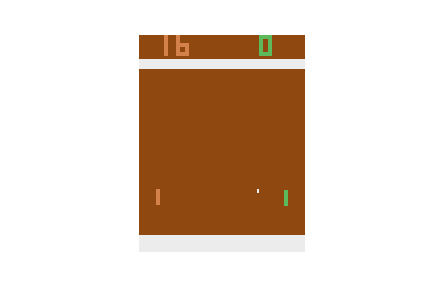
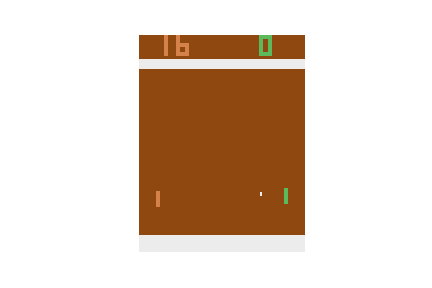
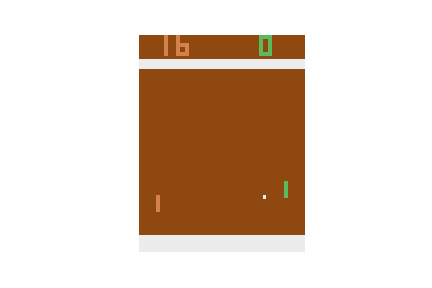
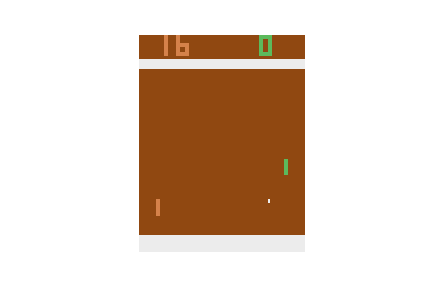
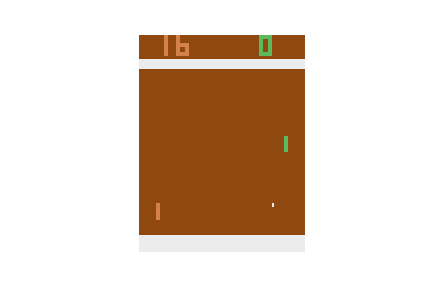
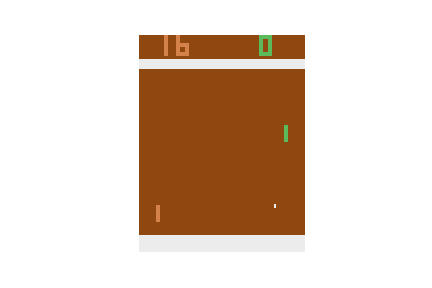
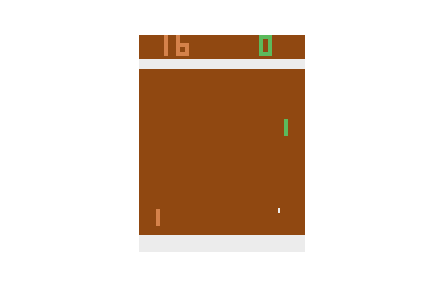
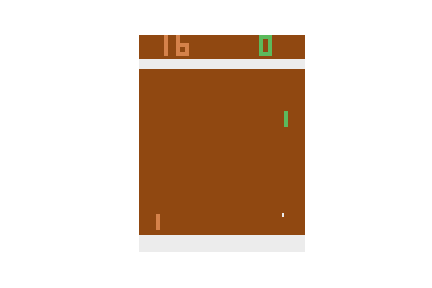
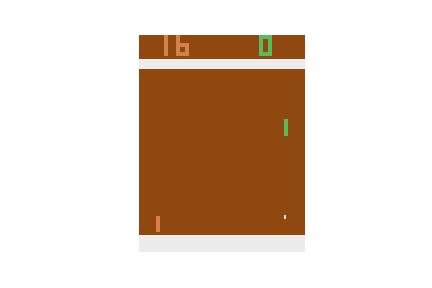
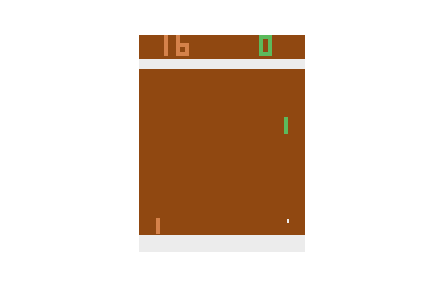
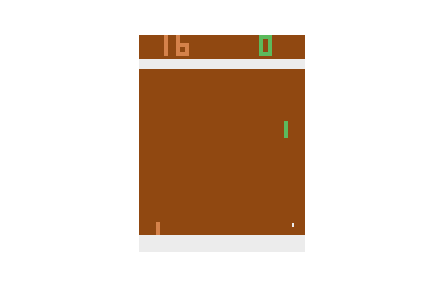
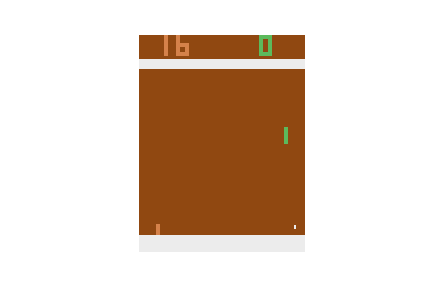
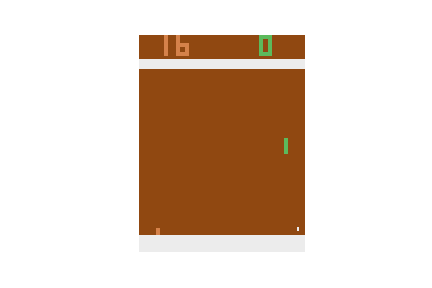
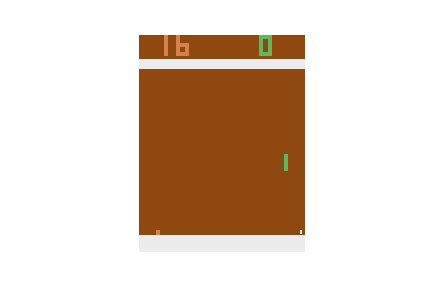
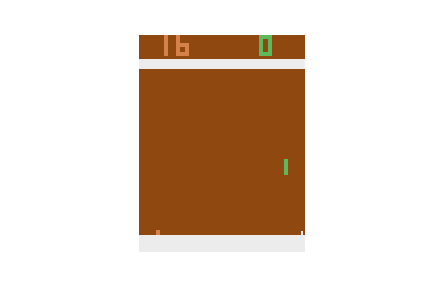
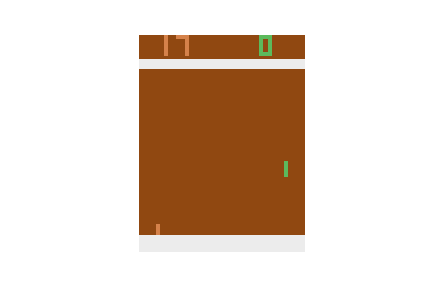
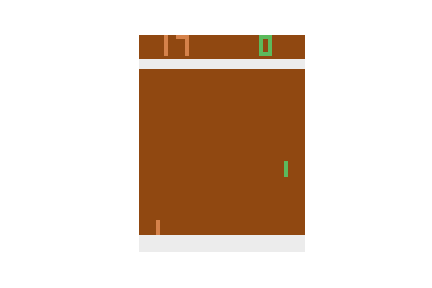
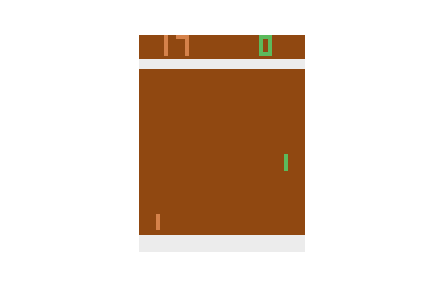
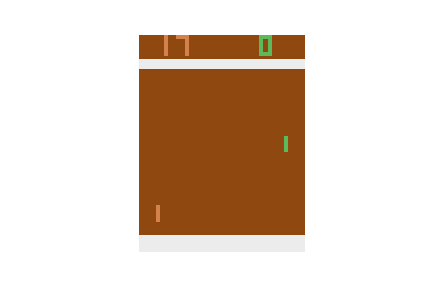
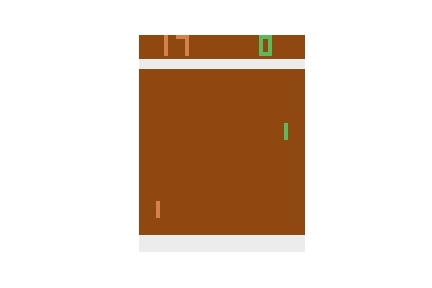
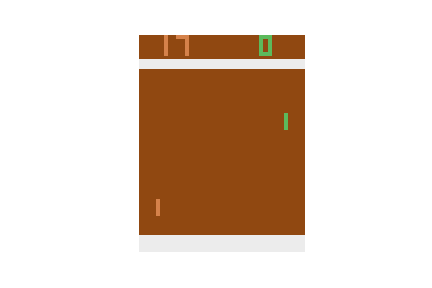
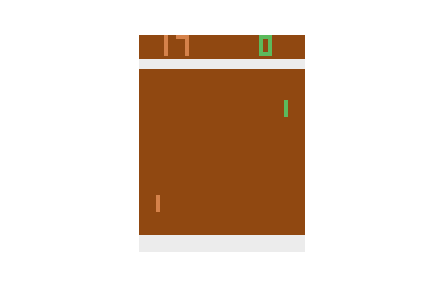
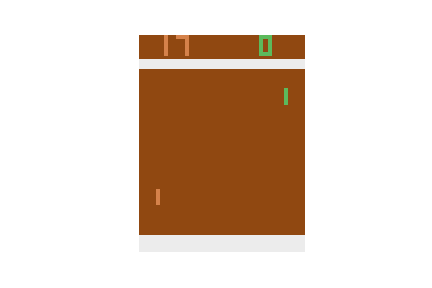
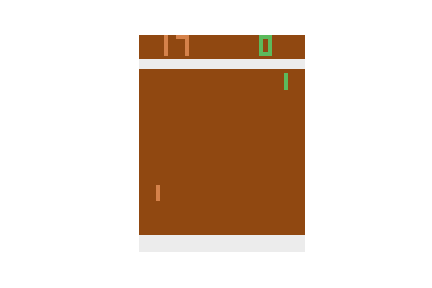
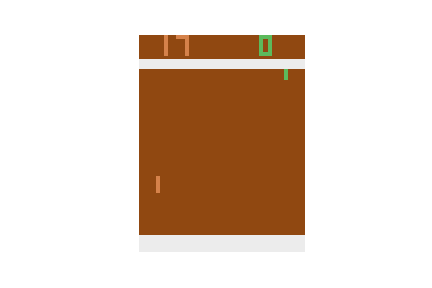
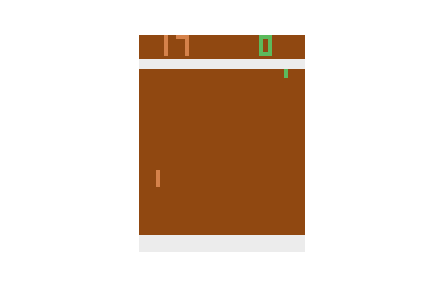
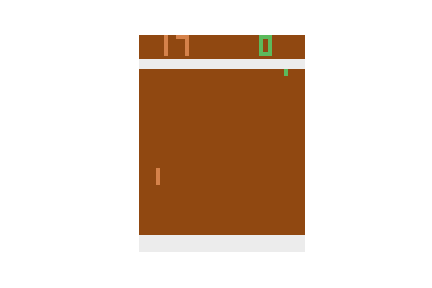
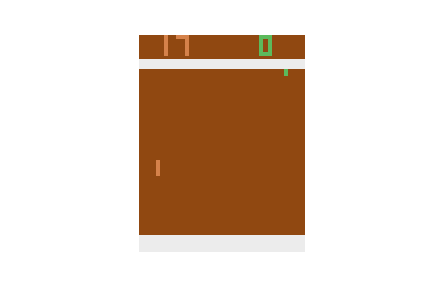
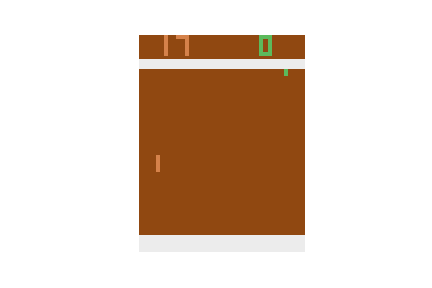
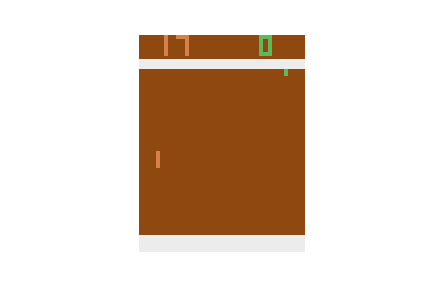
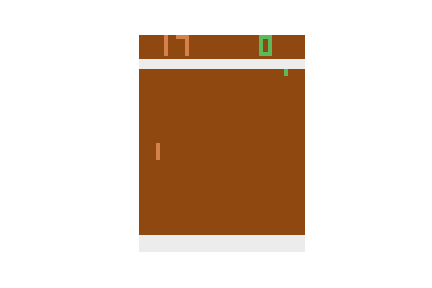
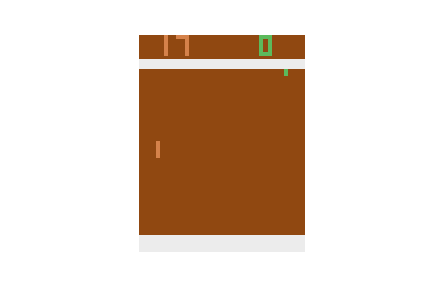
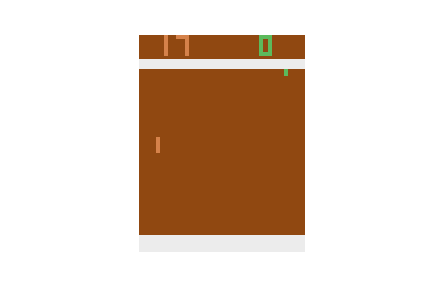
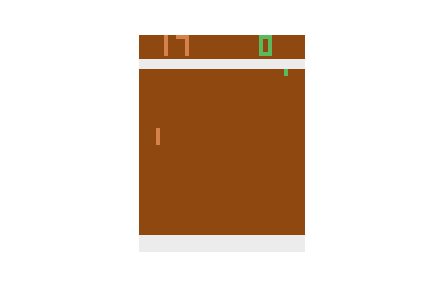
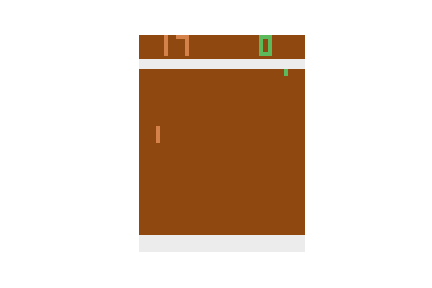
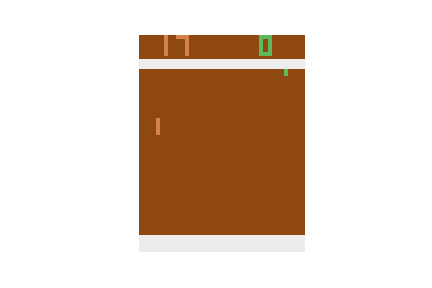
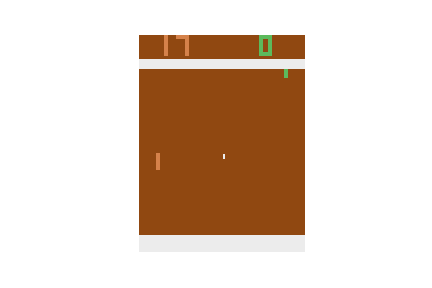
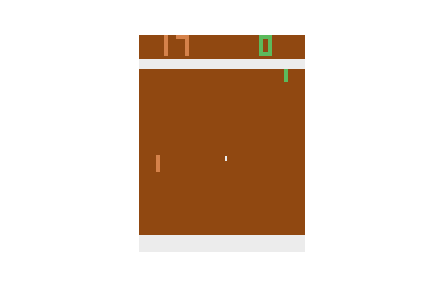
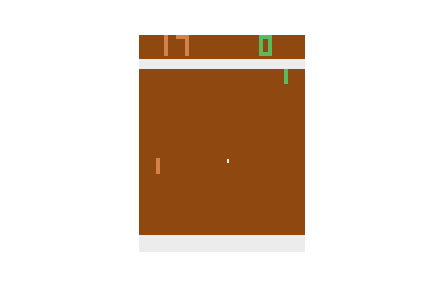
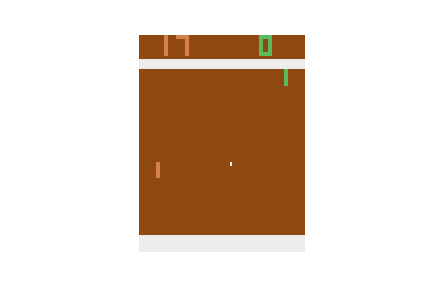
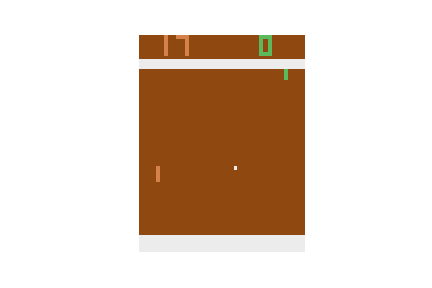
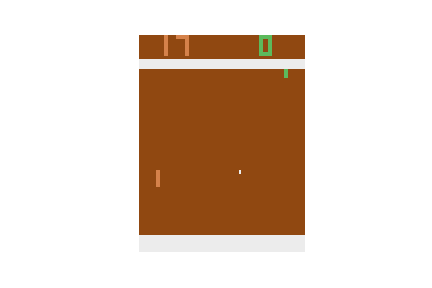
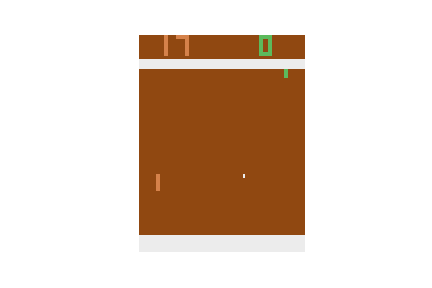
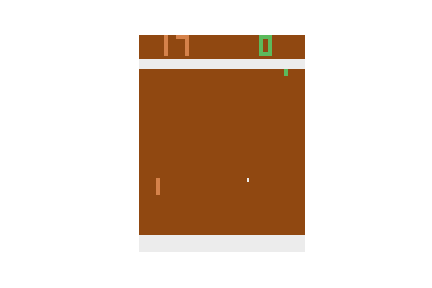
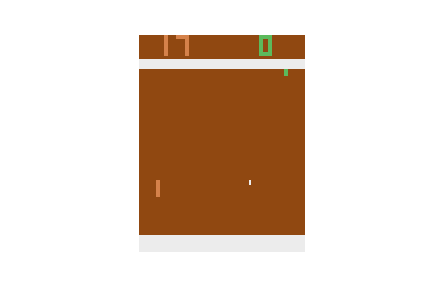
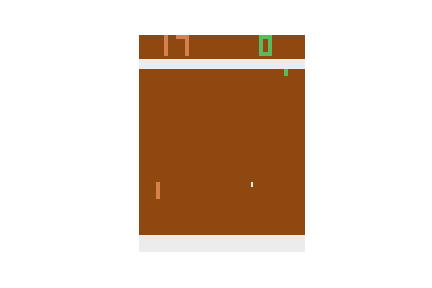
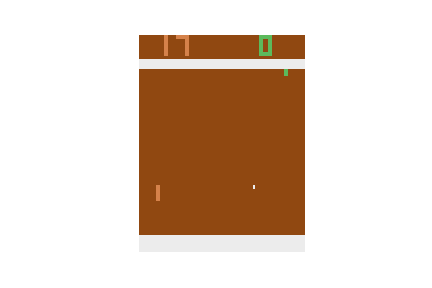
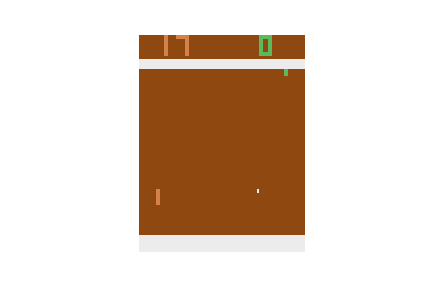
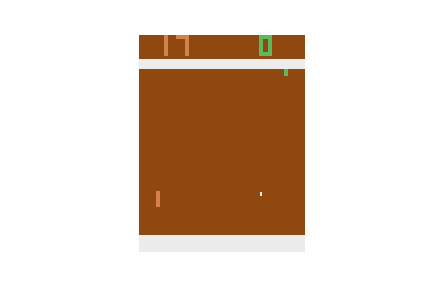
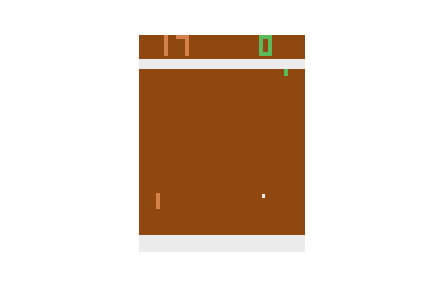
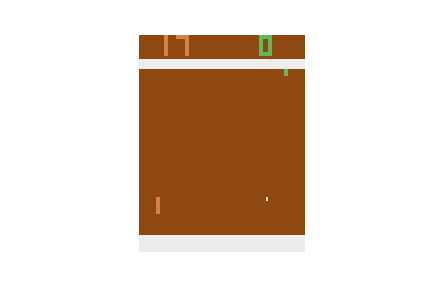
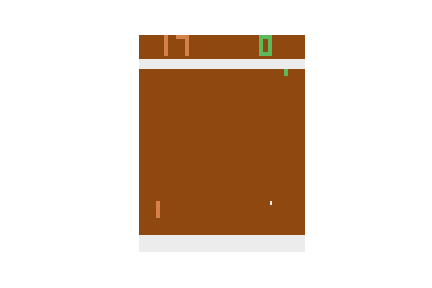
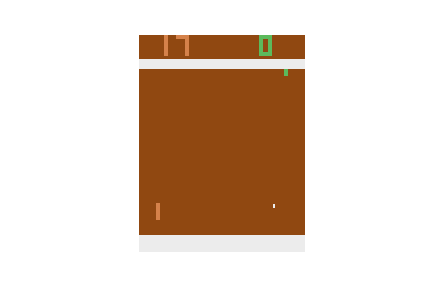
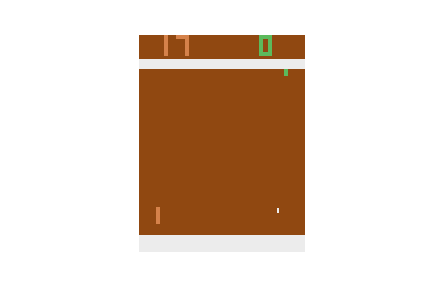
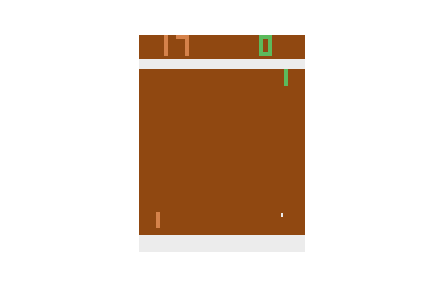
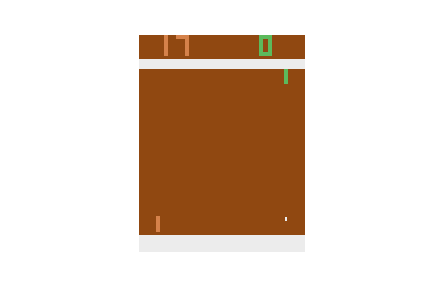
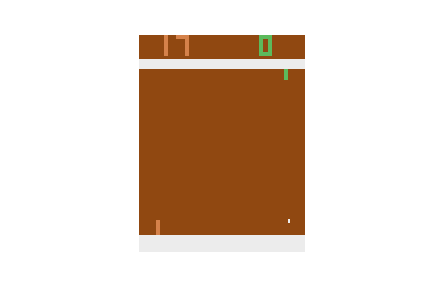
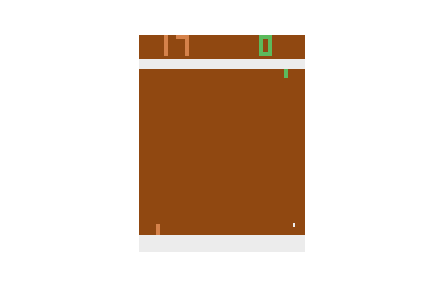
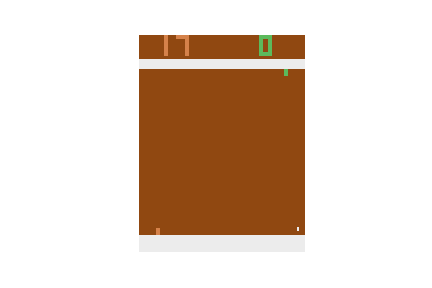
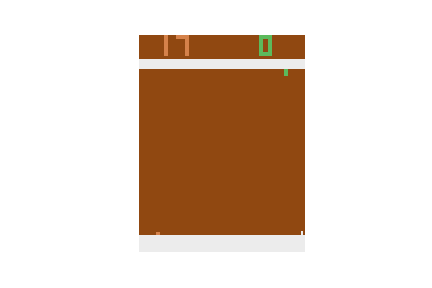
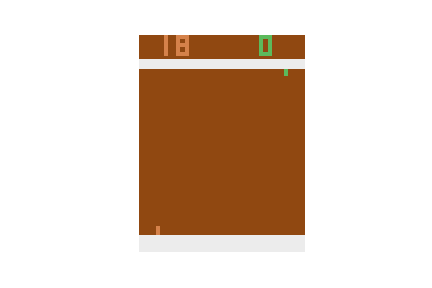
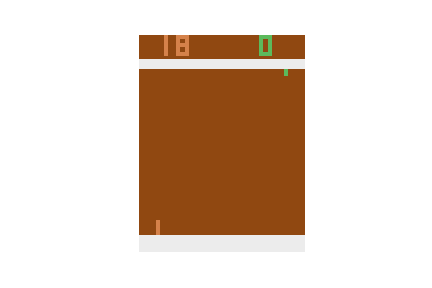
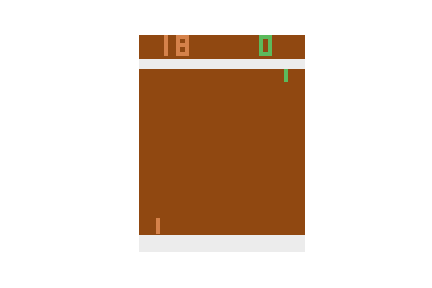
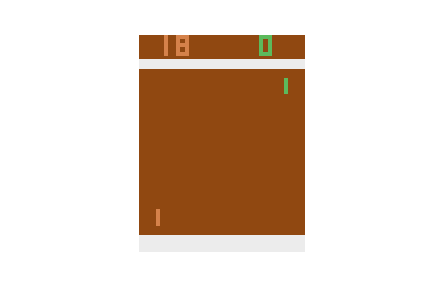
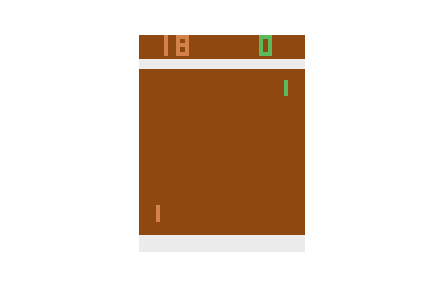
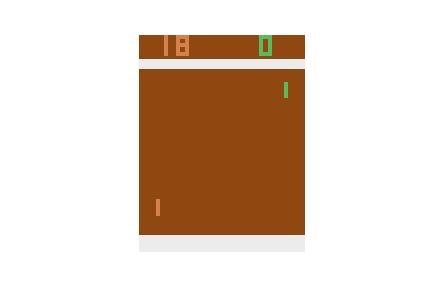
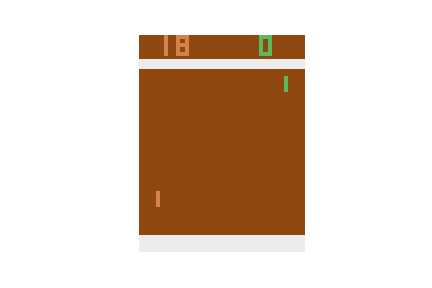
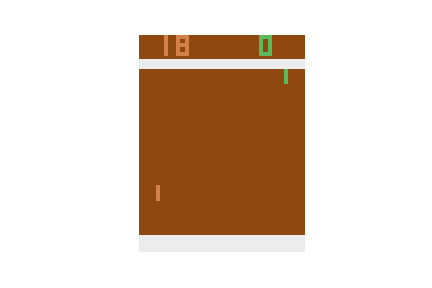
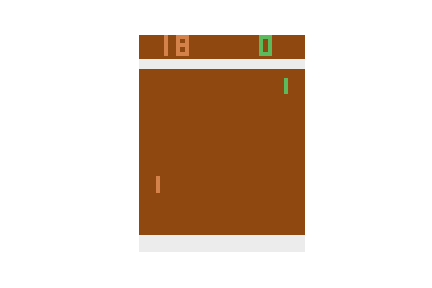
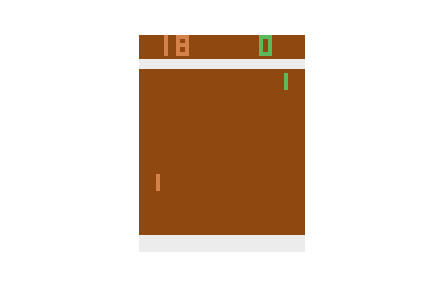
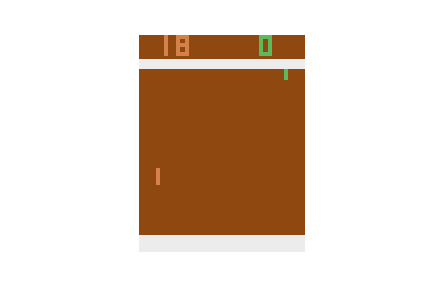
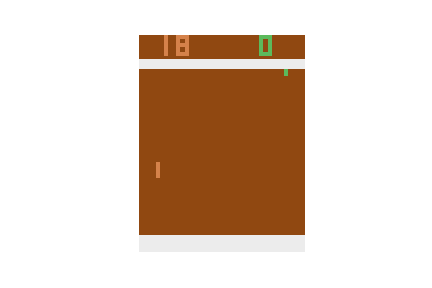
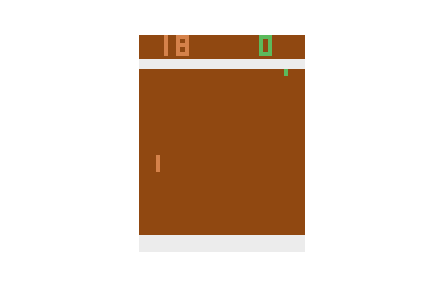
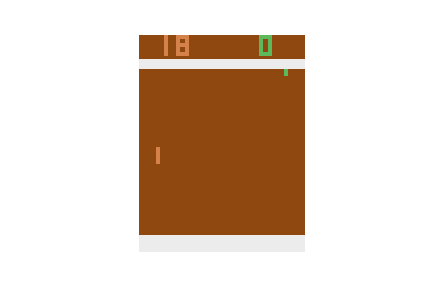
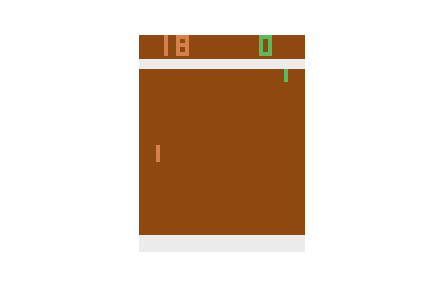
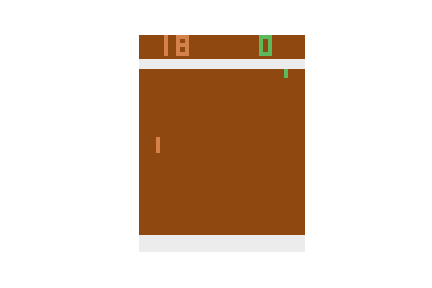
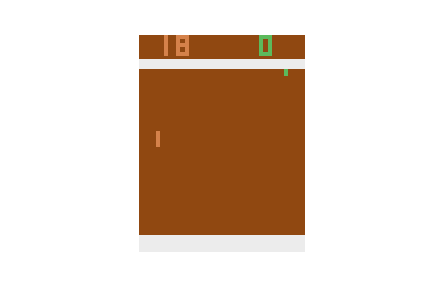
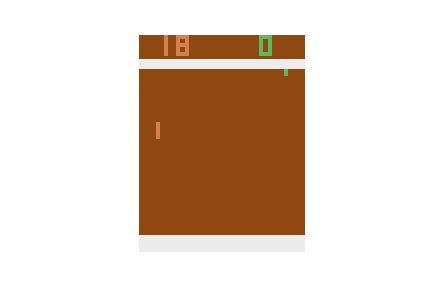
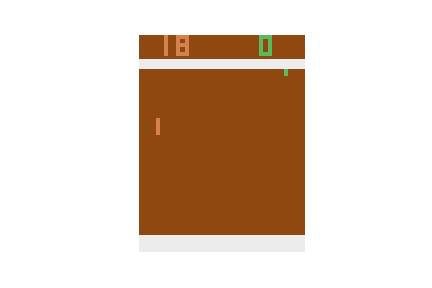
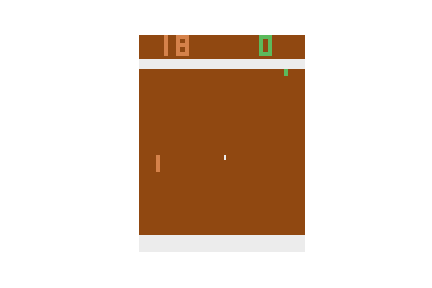
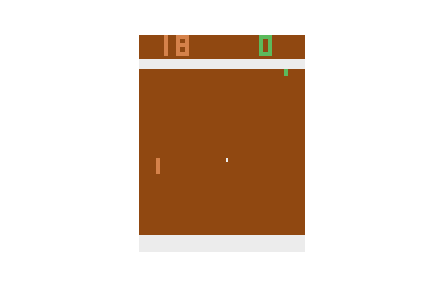
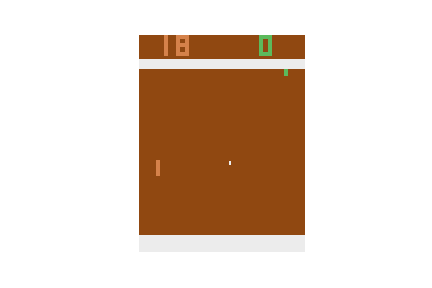
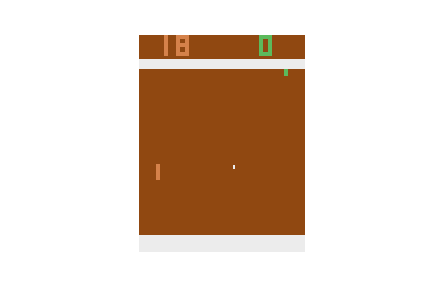
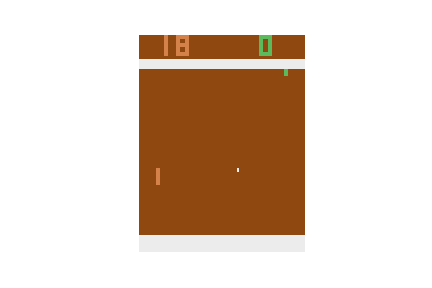
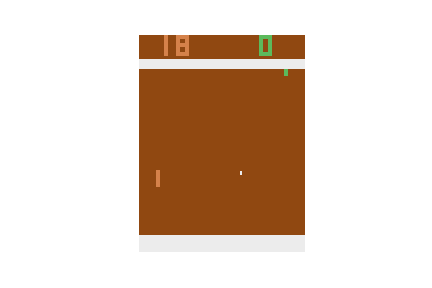
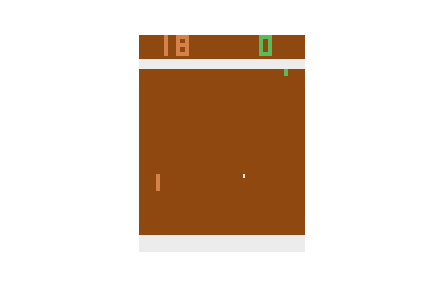
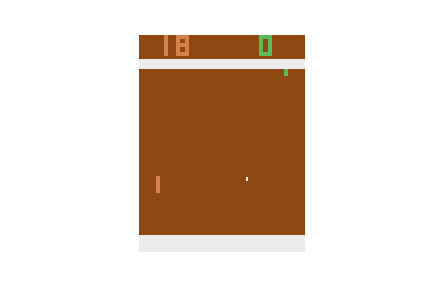
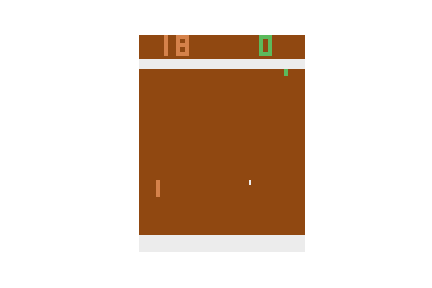
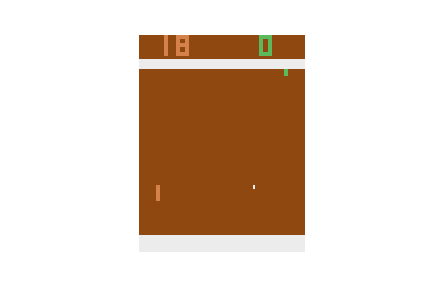
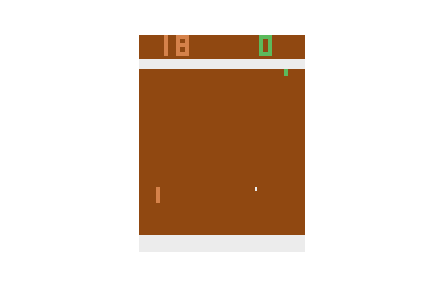
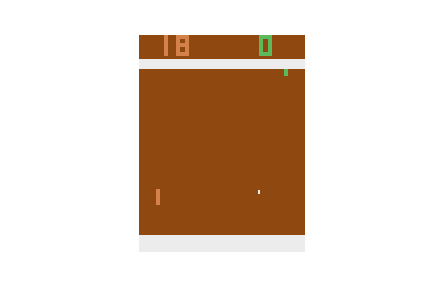
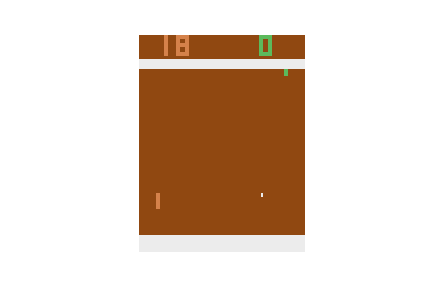
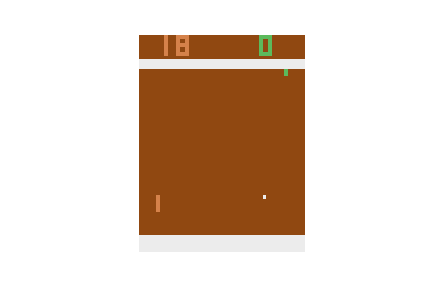
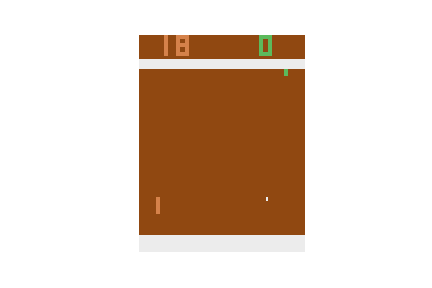
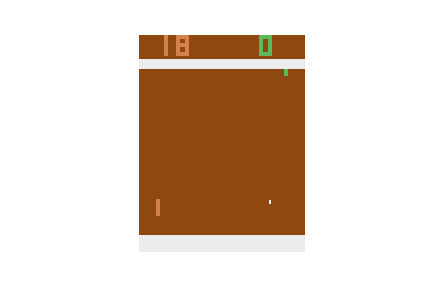
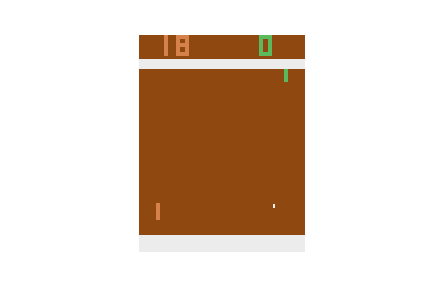
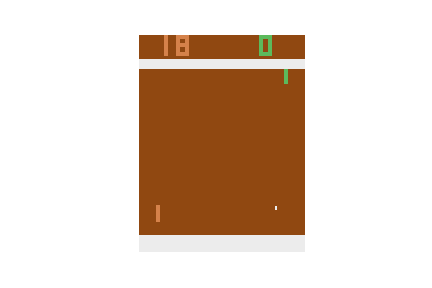
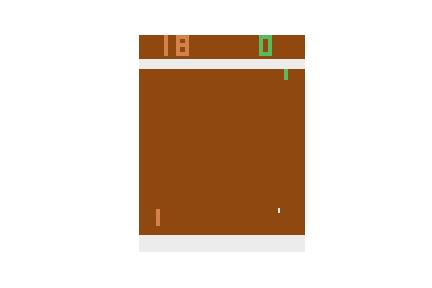
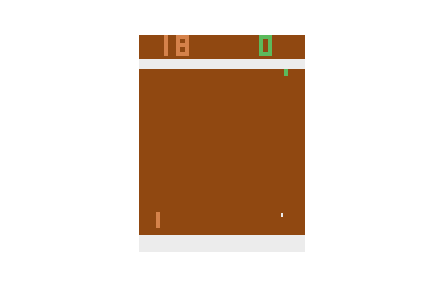
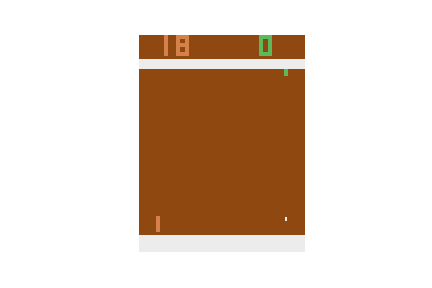
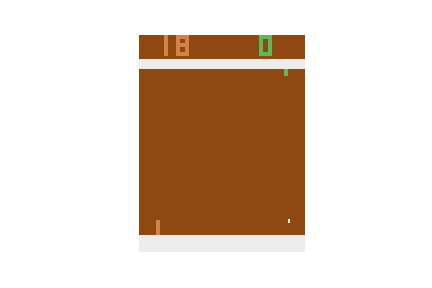
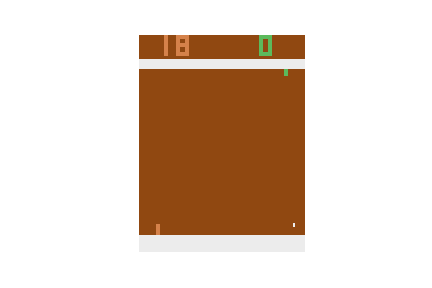
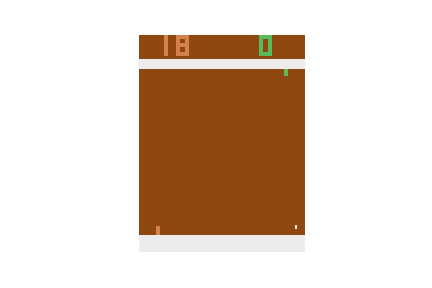
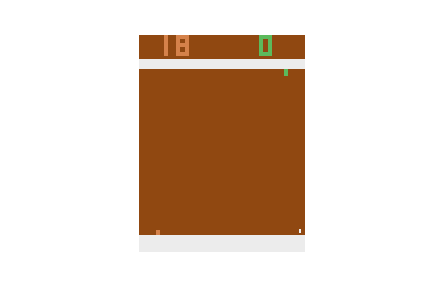
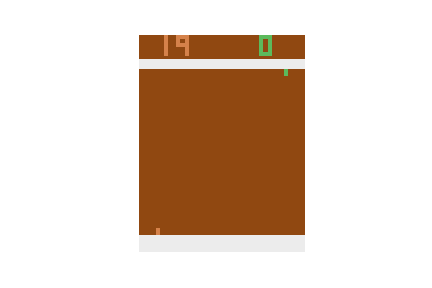
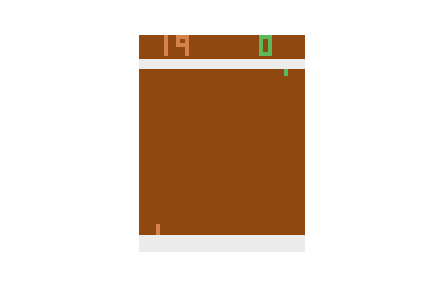
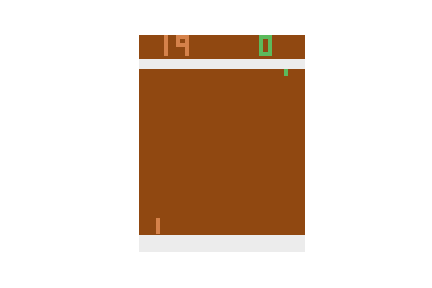
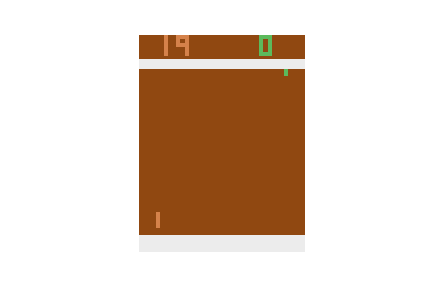
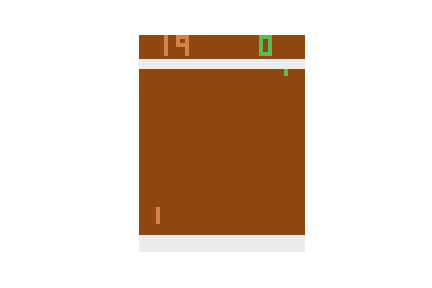
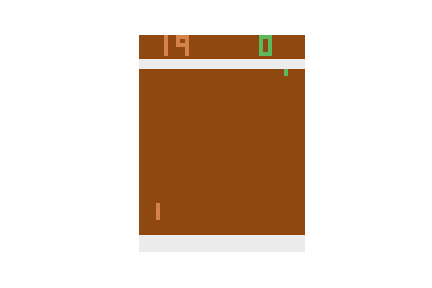
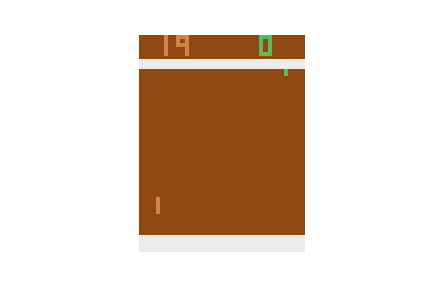
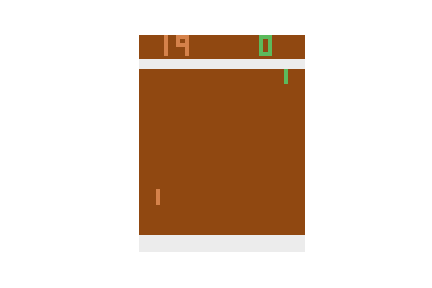
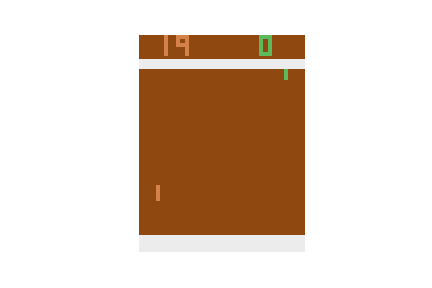
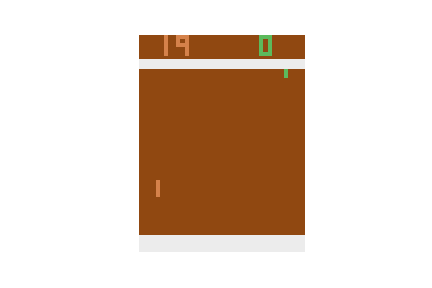
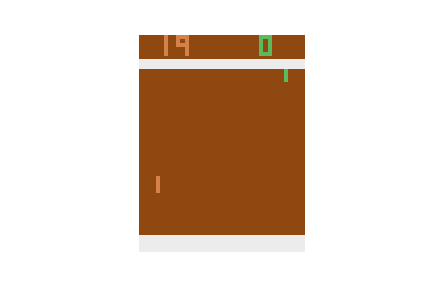
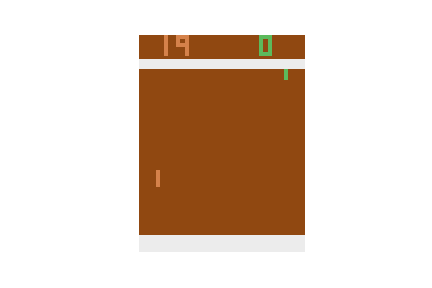
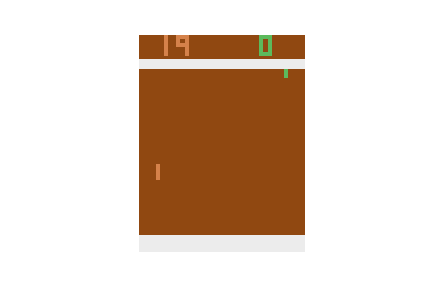
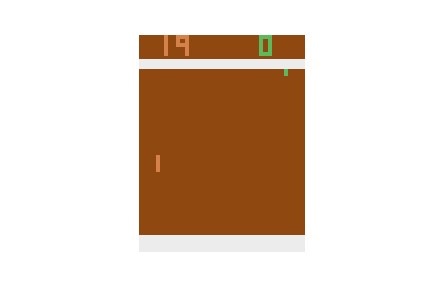
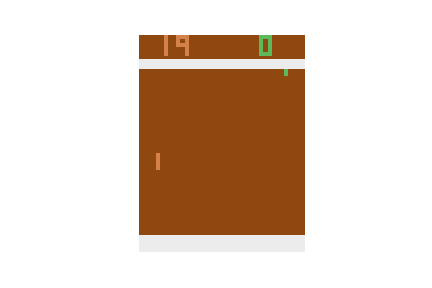
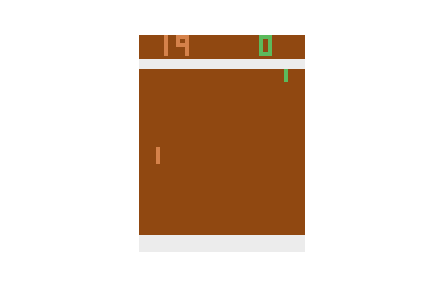
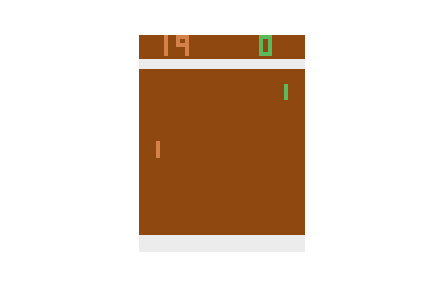
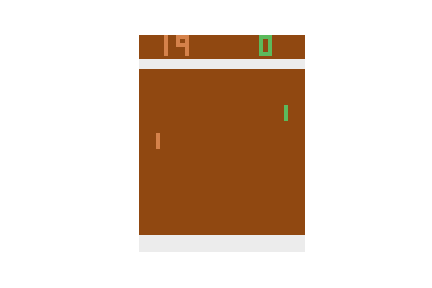
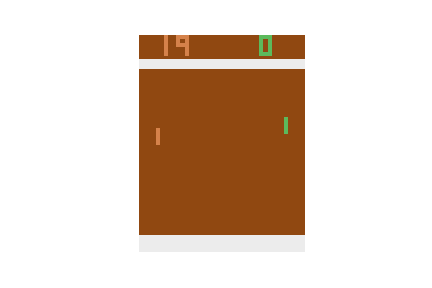
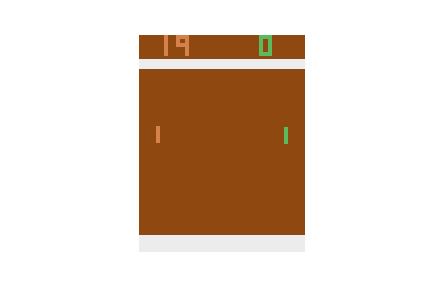
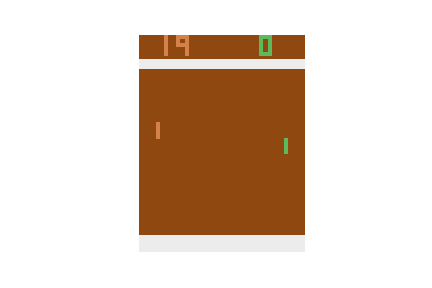
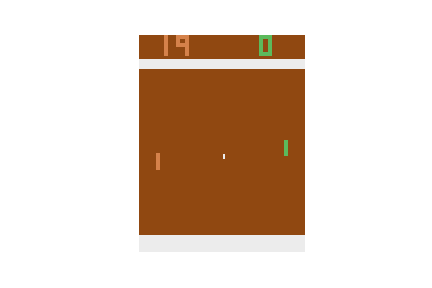
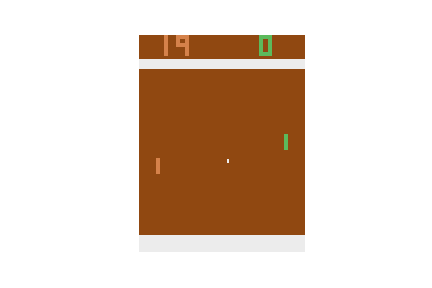
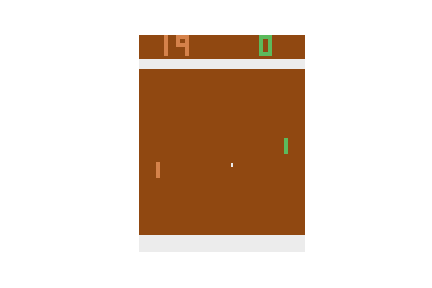
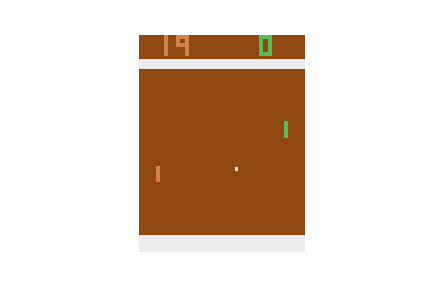
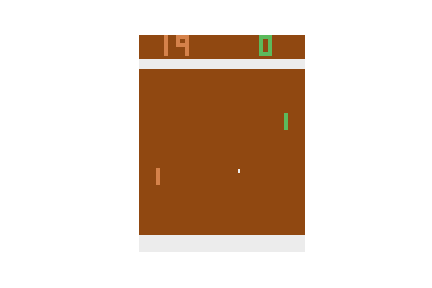
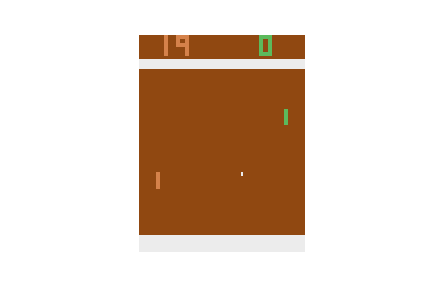
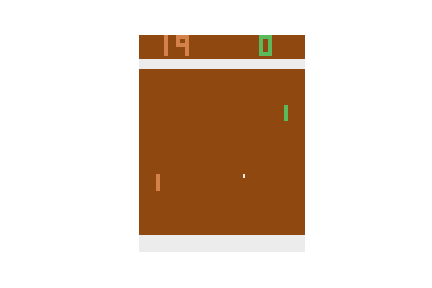
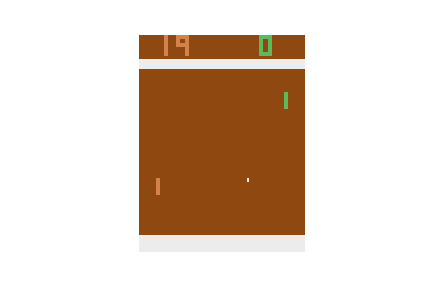
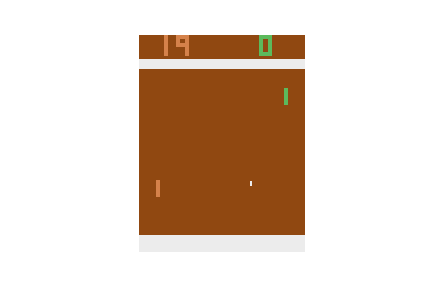
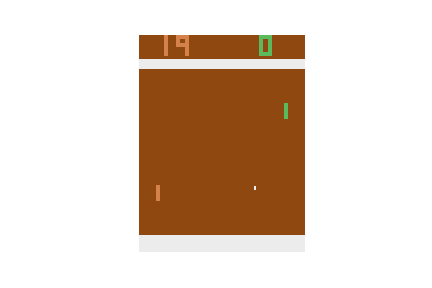
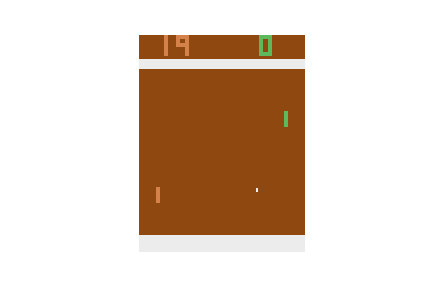
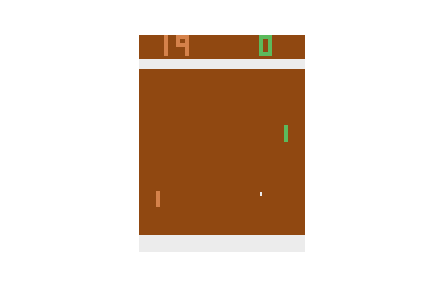
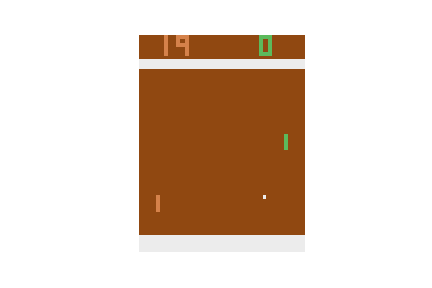
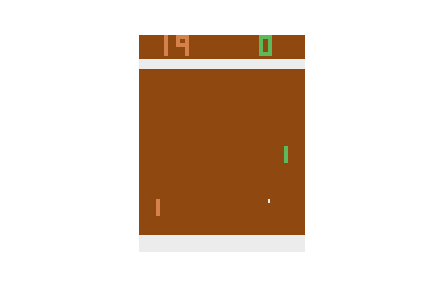
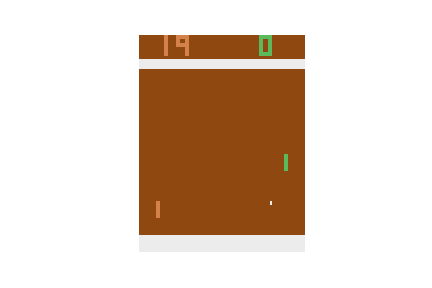
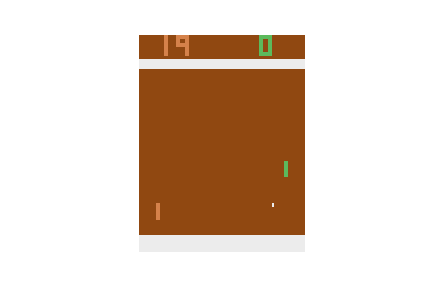
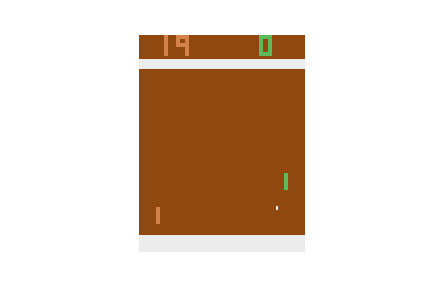
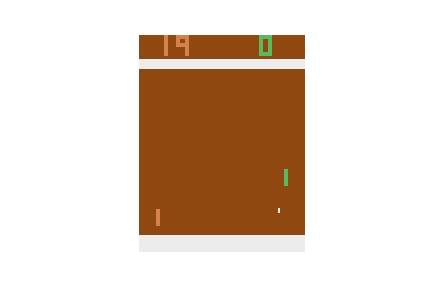
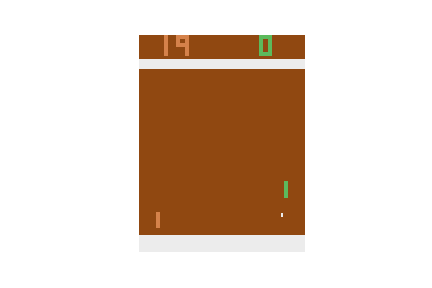
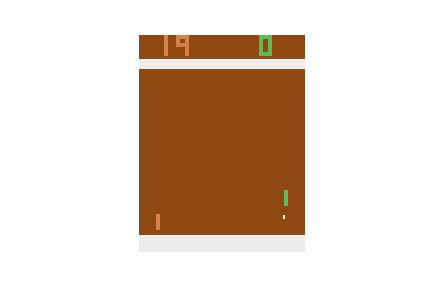
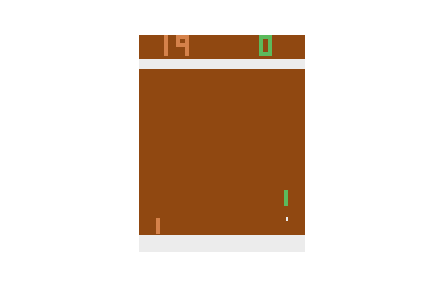
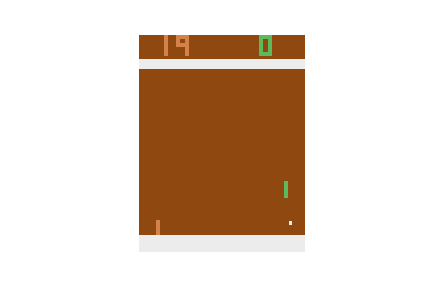
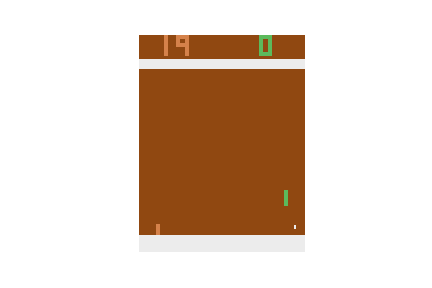
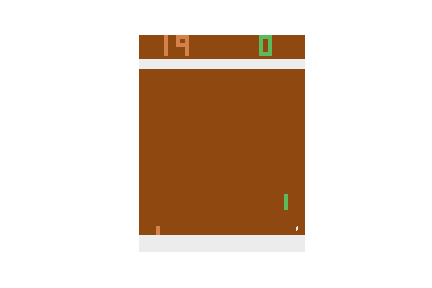
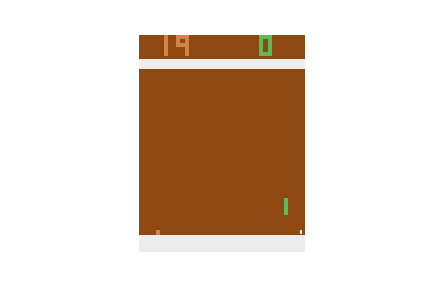
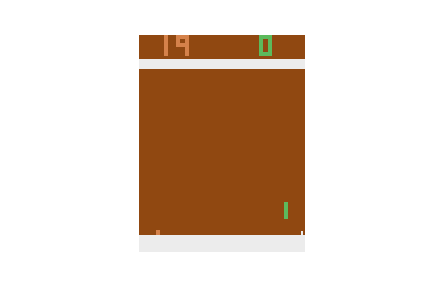
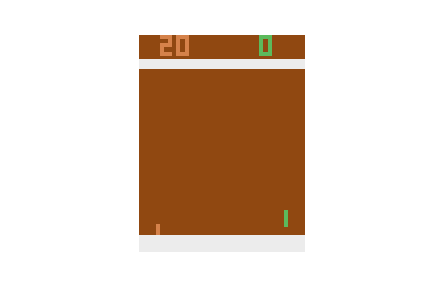
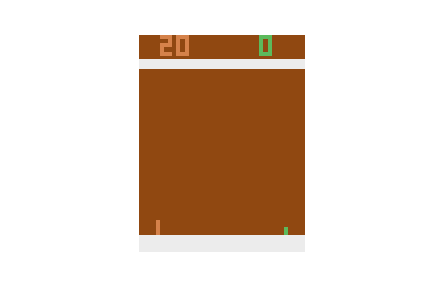
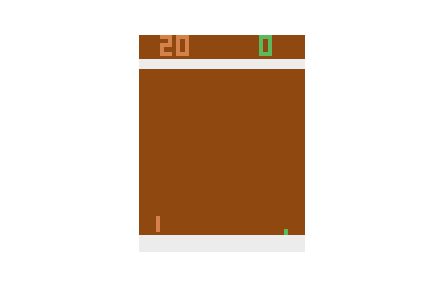
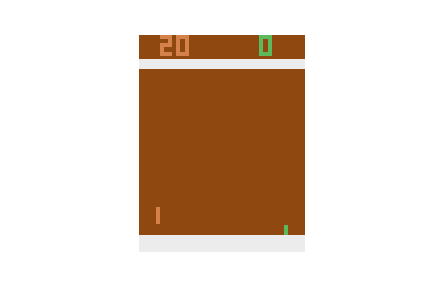
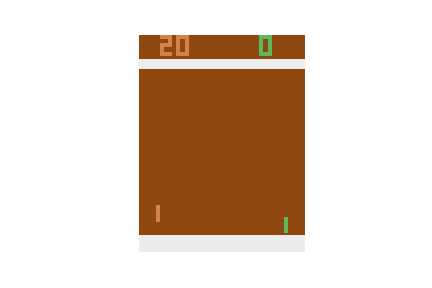
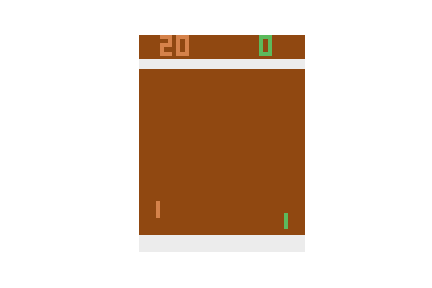
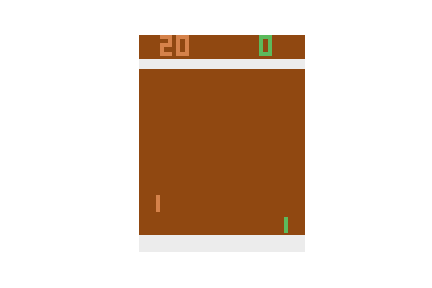
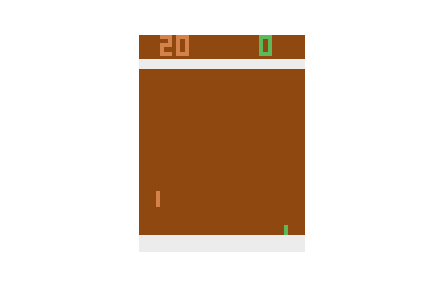
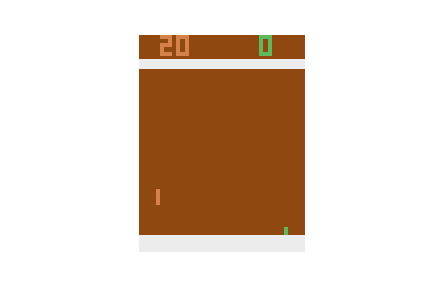
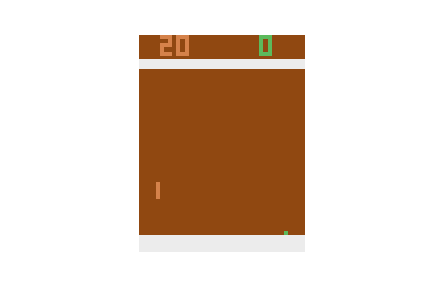
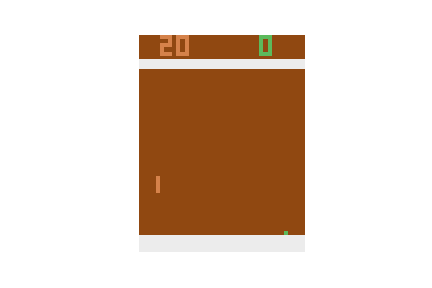
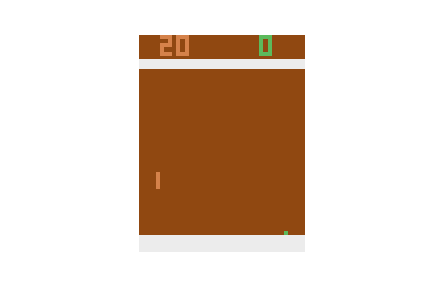
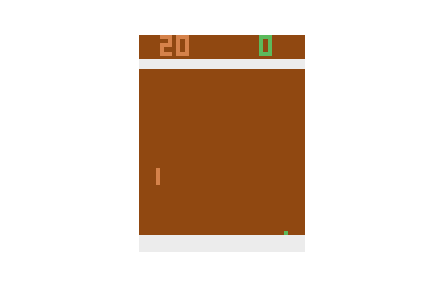
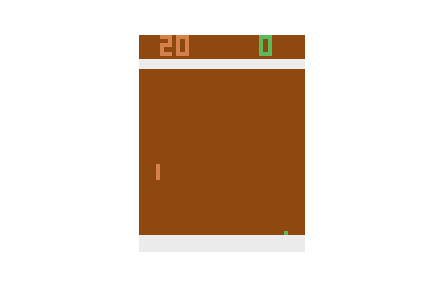
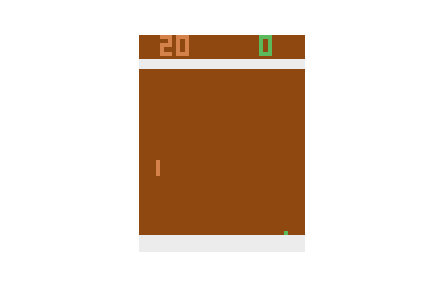
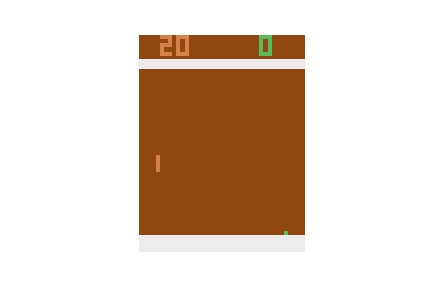
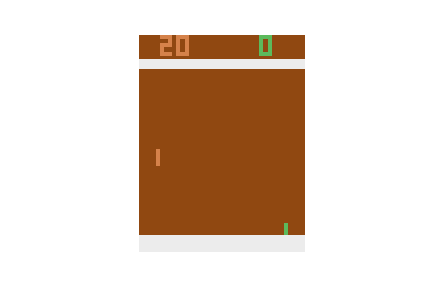
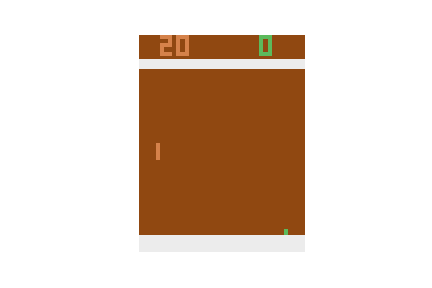
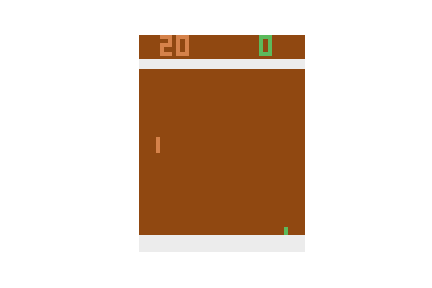
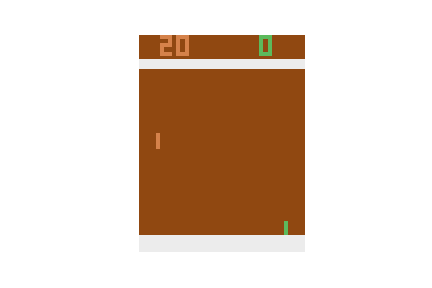
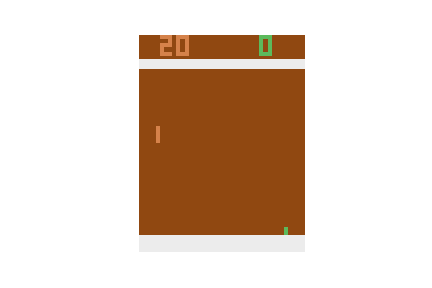
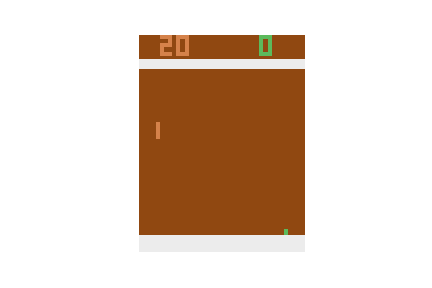
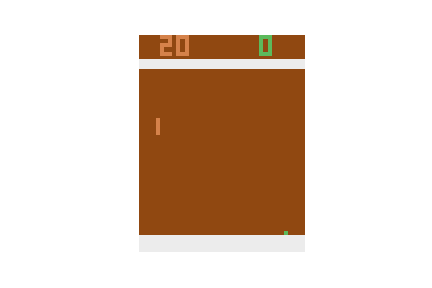
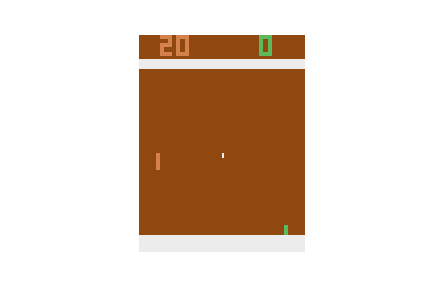
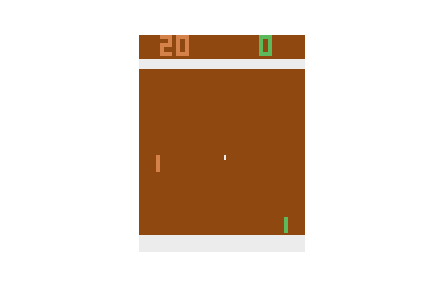
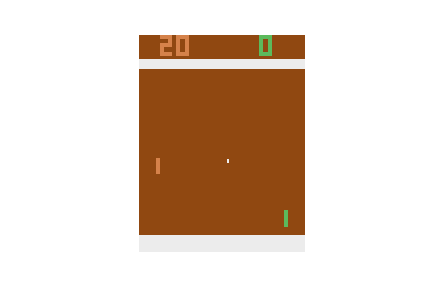
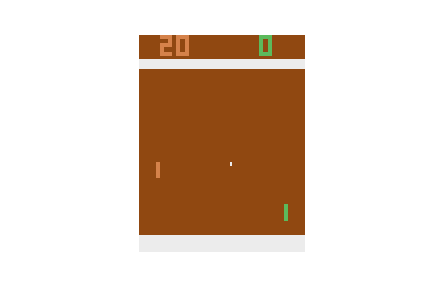
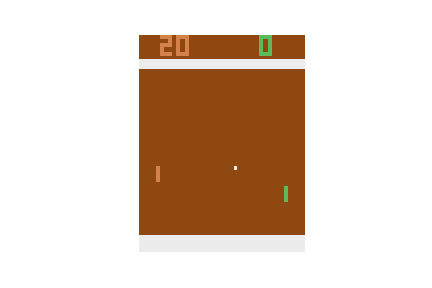
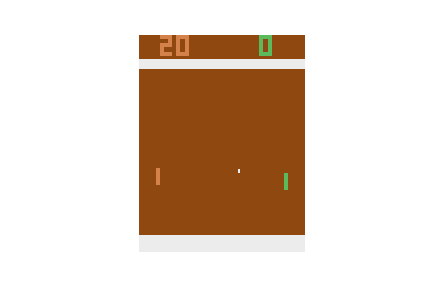
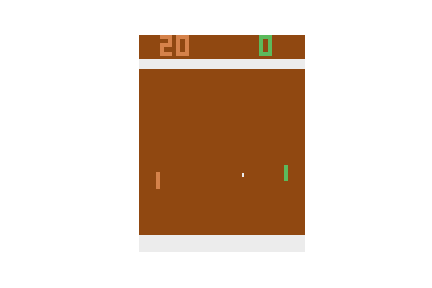
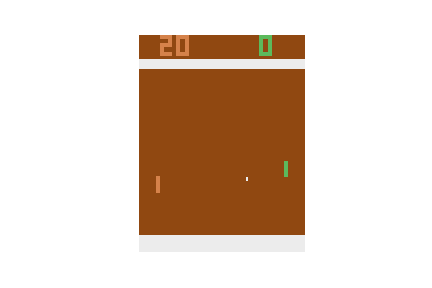
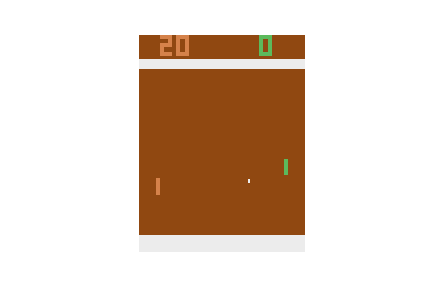
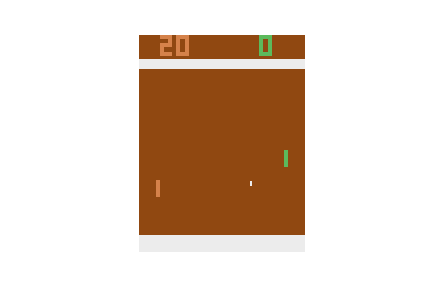
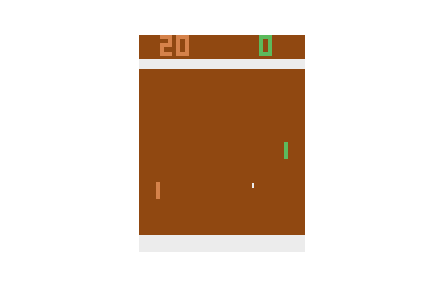
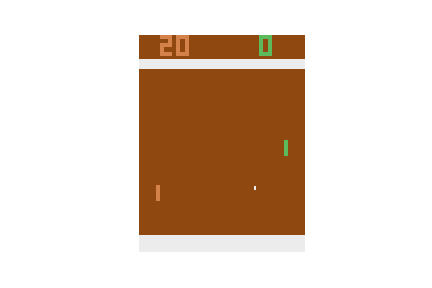
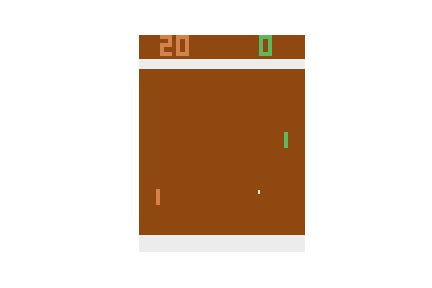
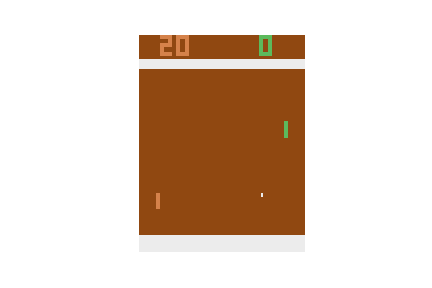
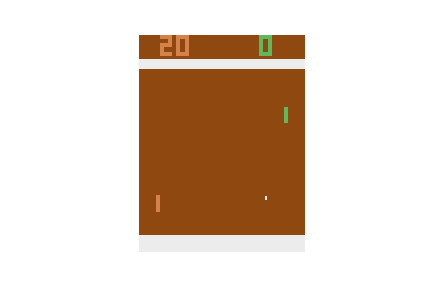
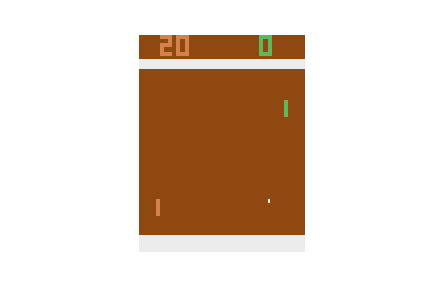
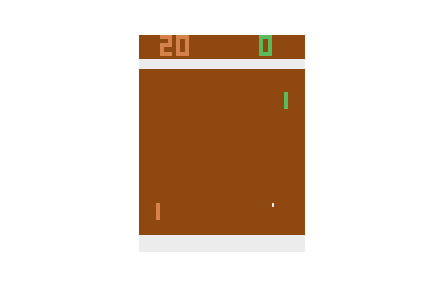
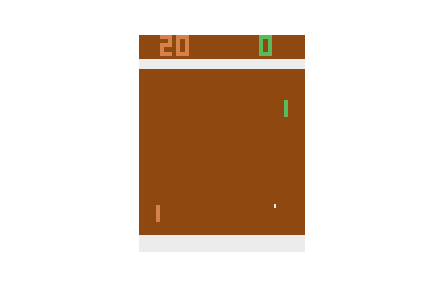
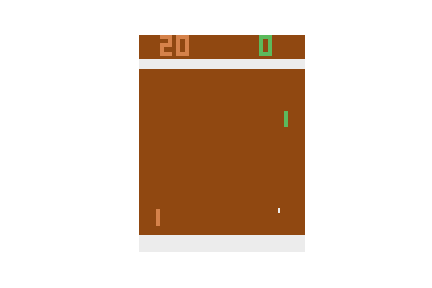
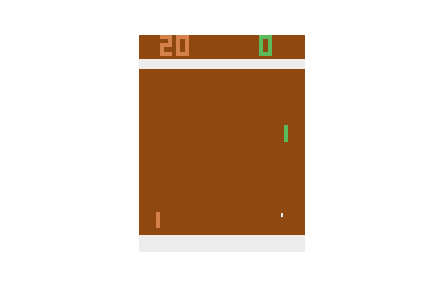
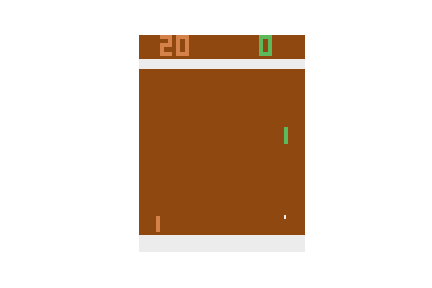
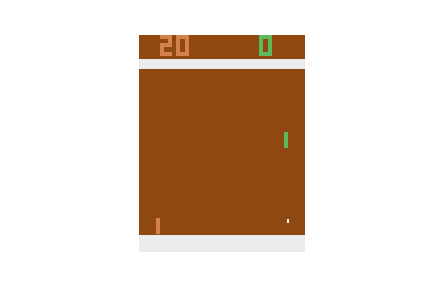
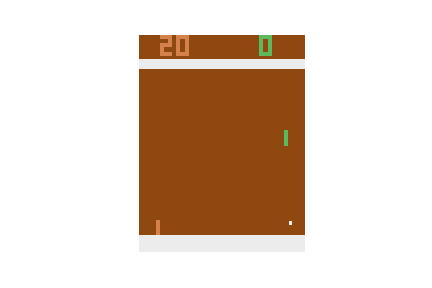
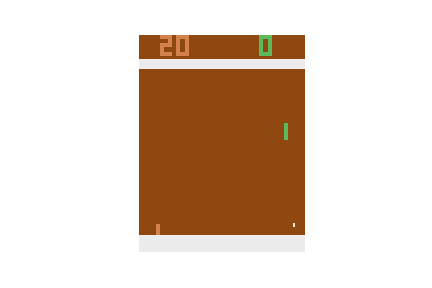
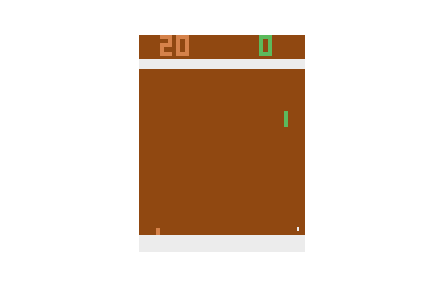
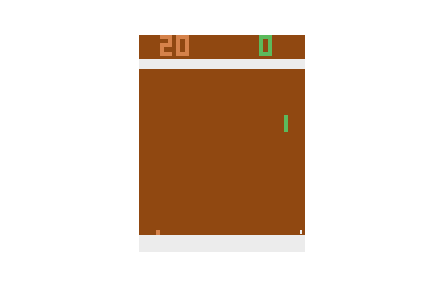
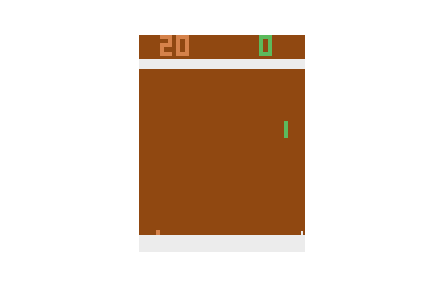

In [9]:
agent.display_game(0)